In [1]:
# Parameters
config = {
    "notebook": "notebooks/tfi_lgbm_optuna.ipynb",
    "data_path": "C:/Users/nico_/Desktop/ITBA/TFI/github/df_procesado/fixed_gear_fe_recortado_v2.csv",
    "output_label": "fixed_gear_optuna",
}


In [2]:
# check if config exists
try:
    config
except NameError:
    config_exists = False
else:
    config_exists = True

# make config if it does not exist already (e.g. passed in by papermill)
if not(config_exists):
    # set up some config for the experiment run
    config = {
        "data_path" : "C:/Users/nico_/Desktop/ITBA/TFI/github/df_procesado/trollers_fe_recortado_v2.csv",
    }
print(config)

{'notebook': 'notebooks/tfi_lgbm_optuna.ipynb', 'data_path': 'C:/Users/nico_/Desktop/ITBA/TFI/github/df_procesado/fixed_gear_fe_recortado_v2.csv', 'output_label': 'fixed_gear_optuna'}


In [3]:
# Importing core libraries
#https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
#https://www.kaggle.com/code/lucamassaron/tutorial-bayesian-optimization-with-lightgbm/notebook
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
from functools import partial

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifiers
import lightgbm as lgb

# Model selection
from sklearn.model_selection import KFold, StratifiedKFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

Cargamos el dataset.

In [4]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

df = pd.read_csv(config['data_path'], header="infer", sep=",",error_bad_lines=False, engine ='python')

In [5]:
df = df.drop(['mmsi', 'source','timestamp','source','datetime','distance_from_shore','distance_from_port'], axis = 1)
lagged_columns = ['A0', 'J0', 'C0','speed_lag_1', 'speed_lag_2',
       'speed_lag_3', 'speed_lag_4', 'speed_lag_5', 'speed_lag_6',
       'course_lag_1', 'course_lag_2', 'course_lag_3', 'course_lag_4',
       'course_lag_5', 'course_lag_6', 'S0_lag_1', 'S0_lag_2', 'S0_lag_3',
       'S0_lag_4', 'S0_lag_5', 'S0_lag_6', 'A0_lag_1', 'A0_lag_2', 'A0_lag_3',
       'A0_lag_4', 'A0_lag_5', 'A0_lag_6', 'J0_lag_1', 'J0_lag_2', 'J0_lag_3',
       'J0_lag_4', 'J0_lag_5', 'J0_lag_6', 'C0_lag_1', 'C0_lag_2', 'C0_lag_3',
       'C0_lag_4', 'C0_lag_5', 'C0_lag_6']
for column in lagged_columns:
    df[column]=df[column].abs()

df['S0']=df['S0'].abs()
df['A0']=df['A0'].abs()
df['J0']=df['J0'].abs()
df['C0']=df['C0'].abs()
df['Delta_S']=df['Delta_S'].abs()
df['Delta_C']=df['Delta_C'].abs()

print(df)


      speed    course       lat       lon is_fishing  sun_state  distance  \
0       1.3  0.475000  0.869816 -0.109285         NO          1  0.580652   
1       2.7  0.047222  0.873736 -0.040467         NO          2  0.180594   
2       2.9  0.870833  0.864615 -0.065224         NO          1  1.323288   
3       3.8  0.127222  0.872260 -0.042893         NO          1  0.977262   
4       0.7  0.239444  0.976756  0.220791         NO          1  2.885812   
...     ...       ...       ...       ...        ...        ...       ...   
9361    5.5  0.986111  0.911210  0.031408         SI          2  3.838587   
9362    1.4  0.946389  0.716522 -0.153425         SI          1  0.699920   
9363    3.2  0.134444  0.882041 -0.049108         SI          1  1.991246   
9364    9.8  0.753611  0.873938 -0.039576         SI          1  2.758194   
9365    5.9  0.711111  0.872294 -0.042157         SI          1  3.479762   

      timediff        S0            A0  ...      J0_lag_3      J0_lag_4  \


Generamos los vectores de train y test.

In [6]:
#Generamos train y test.

#Si la longitud del dataset es mayor a 10000, partiremos agrupado por "is_fishing" ya que nos puede tocar un conjunto con is_fishing='SI' vacio.
#if len(dataset)>10000:
    #df = df.sample(n=10000, random_state=1)
#    df = df.groupby("is_fishing").sample(n=7500, random_state=1,replace=True)
#    df = df.drop_duplicates()

X = df.drop('is_fishing',axis=1)
y = df['is_fishing']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=50)
print(len(df[df['is_fishing']=='SI']))
print(len(df[df['is_fishing']=='NO']))



4683
4683


Funcion para evaluar los modelos.

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
import tabulate
from sklearn.metrics import confusion_matrix, accuracy_score


def evaluate_model(title,y_test, y_pred):

    cm = confusion_matrix(y_test, y_pred)
    display(Markdown(title))
    cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['NO', 'SI'])
    cmd_obj.plot()
    cmd_obj.ax_.set(
                    title='Matriz de confusión.', 
                    xlabel='Predict Values', 
                    ylabel='Actual Values')
    plt.show()
    _precision_score = precision_score(y_test, y_pred,pos_label='SI')
    _recall_score = recall_score(y_test, y_pred, pos_label='SI')
    _accuracy_score = accuracy_score(y_test, y_pred)
    _f1_score = f1_score(y_test, y_pred, pos_label='SI')

    data = [["Precision","Recall","Accuracy","F1"],
            ["%.2f" % _precision_score, "%.2f" % _recall_score, "%.2f" % _accuracy_score, "%.2f" % _f1_score ]]
    table = tabulate.tabulate(data, tablefmt='html')
    display(table)
    return _precision_score, _recall_score, _accuracy_score, _f1_score


Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


Train Accuracy : 0.870
Test Accuracy : 0.805
Best Score Through Grid Search : 0.763
Best Parameters :  {'max_depth': 14, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}


Best Parameters :  {'max_depth': 14, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}


Arboles de decision optimizado

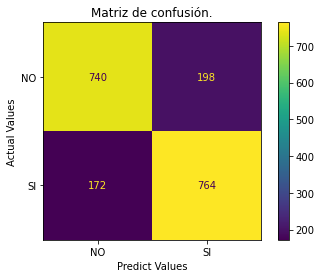

'<table>\n<tbody>\n<tr><td>Precision</td><td>Recall</td><td>Accuracy</td><td>F1  </td></tr>\n<tr><td>0.79     </td><td>0.82  </td><td>0.80    </td><td>0.81</td></tr>\n</tbody>\n</table>'

In [8]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeRegressor
#extra_tree_classifier = ExtraTreeClassifier(random_state=1)
#extra_tree_classifier.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV

parameters={"splitter":["best","random"],
            "max_depth" : [11,12,13,14,15,16],
           "min_samples_leaf":[1,2,3,4,5],
           "min_weight_fraction_leaf":[0, 0.1,0.2],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10] }

grid = GridSearchCV(DecisionTreeClassifier(random_state=1), cv=3, n_jobs=-1, verbose=3,
                    param_grid =parameters
                    )

grid.fit(X_train, y_train)

print('Train Accuracy : %.3f'%grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%grid.best_estimator_.score(X_test, y_test))
print('Best Score Through Grid Search : %.3f'%grid.best_score_)
print('Best Parameters : ',grid.best_params_)

dt = DecisionTreeClassifier(max_depth=grid.best_params_['max_depth'], 
                            max_features=grid.best_params_['max_features'],
                            max_leaf_nodes=grid.best_params_['max_leaf_nodes'],
                            min_samples_leaf=grid.best_params_['min_samples_leaf'],
                            min_weight_fraction_leaf=grid.best_params_['min_weight_fraction_leaf'],
                            splitter=grid.best_params_['splitter']
)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print('Best Parameters : ',grid.best_params_)
dt_precision_score, dt_recall_score, dt_accuracy_score, dt_f1_score = evaluate_model('Arboles de decision optimizado',y_test, y_pred)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


Train Accuracy : 0.977
Test Accuracy : 0.780
Best Score Through Grid Search : 0.768
Best Parameters :  {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


Random forest optimizado

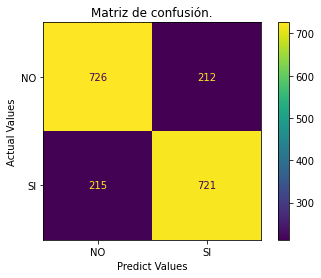

'<table>\n<tbody>\n<tr><td>Precision</td><td>Recall</td><td>Accuracy</td><td>F1  </td></tr>\n<tr><td>0.77     </td><td>0.77  </td><td>0.77    </td><td>0.77</td></tr>\n</tbody>\n</table>'

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [12,13,14,15],
    'max_features': ["auto", "sqrt", "log2"],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2, 5 , 10],
    'n_estimators': [100, 200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid.fit(X_train, y_train)

print('Train Accuracy : %.3f'%grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%grid.best_estimator_.score(X_test, y_test))
print('Best Score Through Grid Search : %.3f'%grid.best_score_)
print('Best Parameters : ',grid.best_params_)

dt = RandomForestClassifier(bootstrap=grid.best_params_['bootstrap'], 
                            max_depth=grid.best_params_['max_depth'],
                            max_features=grid.best_params_['max_features'],
                            min_samples_leaf=grid.best_params_['min_samples_leaf'],
                            min_samples_split=grid.best_params_['min_samples_split'],
                            n_estimators=grid.best_params_['n_estimators']
)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
rf_precision_score, rf_recall_score, rf_accuracy_score, rf_f1_score = evaluate_model('Random forest optimizado', y_test, y_pred)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Train Accuracy : 0.723


Test Accuracy : 0.622
Best Score Through Grid Search : 0.645
Best Parameters :  {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


rbf

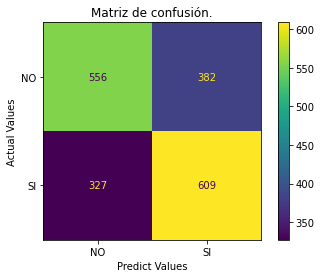

'<table>\n<tbody>\n<tr><td>Precision</td><td>Recall</td><td>Accuracy</td><td>F1  </td></tr>\n<tr><td>0.61     </td><td>0.65  </td><td>0.62    </td><td>0.63</td></tr>\n</tbody>\n</table>'

Fitting 5 folds for each of 120 candidates, totalling 600 fits


Train Accuracy : 0.544


Test Accuracy : 0.523
Best Score Through Grid Search : 0.544
Best Parameters :  {'C': 0.1, 'coef0': 0.01, 'gamma': 1e-06, 'kernel': 'sigmoid'}


sigmoid

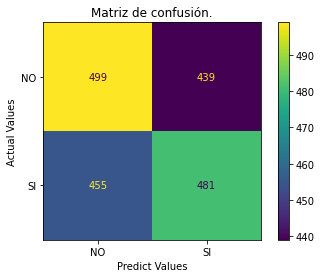

'<table>\n<tbody>\n<tr><td>Precision</td><td>Recall</td><td>Accuracy</td><td>F1  </td></tr>\n<tr><td>0.52     </td><td>0.51  </td><td>0.52    </td><td>0.52</td></tr>\n</tbody>\n</table>'

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],'C': [0.001, 0.10, 0.1, 10 ]},
#              {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],'C': [0.001, 0.10, 0.1, 10], 'coef0 ':[0,0.1,1]},
#              {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 1]}     
#]

parameters = [{'kernel': ['rbf'], 'gamma': [1e-2,1e-3,1e-4,1e-5,1e-6],'C': [0.001,0.01,0.1,1,10,100]},
              {'kernel': ['sigmoid'], 'gamma': [1e-2,1e-3,1e-4,1e-5,1e-6],'C': [0.001,0.01,0.1,1,10,100],'coef0' : [0.01,0.1,1,10]},
              #{'kernel': ['linear'], 'C': [1,10,100]}
              ]

svm_precision_score_rbf=svm_recall_score_rbf=svm_accuracy_score_rbf=svm_f1_score_rbf=0
svm_precision_score_sigmoid=svm_recall_score_sigmoid=svm_accuracy_score_sigmoid=svm_f1_score_sigmoid=0
svm_precision_score_linear=svm_recall_score_linear=svm_accuracy_score_linear=svm_f1_score_linear=0


for parameter in parameters:
    param_grid = parameter
    grid = GridSearchCV(SVC(), param_grid, n_jobs = -1, verbose = 3)
    grid.fit(X_train, y_train)
    kernel_str = parameter['kernel'][0]
    y_pred = grid.predict(X_test)
    dt = grid
    
    print('Train Accuracy : %.3f'%grid.best_estimator_.score(X_train, y_train))
    print('Test Accuracy : %.3f'%grid.best_estimator_.score(X_test, y_test))
    print('Best Score Through Grid Search : %.3f'%grid.best_score_)
    print('Best Parameters : ',grid.best_params_)

    if parameter['kernel'][0] == 'rbf':
        svm_precision_score_rbf, svm_recall_score_rbf, svm_accuracy_score_rbf, svm_f1_score_rbf = evaluate_model(kernel_str, y_test, y_pred)
    if parameter['kernel'][0] == 'sigmoid':
        svm_precision_score_sigmoid, svm_recall_score_sigmoid, svm_accuracy_score_sigmoid, svm_f1_score_sigmoid = evaluate_model(kernel_str, y_test, y_pred)
    if parameter['kernel'][0] == 'linear':
        svm_precision_score_linear, svm_recall_score_linear, svm_accuracy_score_linear, svm_f1_score_linear = evaluate_model(kernel_str, y_test, y_pred)

In [11]:
import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

from optuna.integration import LightGBMPruningCallback


def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 8, 1023, step=10),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            #eval_metric="auc",
            early_stopping_rounds=100,
            callbacks=[
                #LightGBMPruningCallback(trial, "auc")
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)


In [12]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")

#AUC -> maximixe
#study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=2000)


[I 2022-06-18 20:11:03,296] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] min_gain_to_split is set=8.612411992938961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.612411992938961
[LightGBM] [Warning] lambda_l1 is set=9.811179443361, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.811179443361
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=33.44854546055893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.44854546055893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[I 2022-06-18 20:11:03,738] Trial 0 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2805876166593858, 'num_leaves': 228, 'max_depth': 4, 'min_data_in_leaf': 9700, 'lambda_l1': 9.811179443361, 'lambda_l2': 33.44854546055893, 'min_gain_to_split': 8.612411992938961, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 0.6931472446871874.


[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] min_gain_to_split is set=8.612411992938961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.612411992938961
[LightGBM] [Warning] lambda_l1 is set=9.811179443361, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.811179443361
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=33.44854546055893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.44854546055893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8300
[LightGBM] [Warning] min_gain_to_split is set=4.425871262933625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.425871262933625
[LightGBM] [Warning] lambda_l1 is set=5.348468922774004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.348468922774004
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=78.29702494290936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78.29702494290936
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0

[I 2022-06-18 20:11:04,126] Trial 1 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11969504784699803, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 8300, 'lambda_l1': 5.348468922774004, 'lambda_l2': 78.29702494290936, 'min_gain_to_split': 4.425871262933625, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.6931472446871874.


[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8300
[LightGBM] [Warning] min_gain_to_split is set=4.425871262933625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.425871262933625
[LightGBM] [Warning] lambda_l1 is set=5.348468922774004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.348468922774004
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=78.29702494290936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78.29702494290936
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=13.151770113532061, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.151770113532061
[LightGBM] [Warning] lambda_l1 is set=7.071670217748095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.071670217748095
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=67.16300215989286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.16300215989286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-18 20:11:04,521] Trial 2 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2714019758219513, 'num_leaves': 88, 'max_depth': 12, 'min_data_in_leaf': 5000, 'lambda_l1': 7.071670217748095, 'lambda_l2': 67.16300215989286, 'min_gain_to_split': 13.151770113532061, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.6931472446871874.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=13.151770113532061, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.151770113532061
[LightGBM] [Warning] lambda_l1 is set=7.071670217748095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.071670217748095
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=67.16300215989286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.16300215989286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_gain_to_split is set=4.463496907529623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.463496907529623
[LightGBM] [Warning] lambda_l1 is set=3.5837742053088983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5837742053088983
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=1.0464560962015423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0464560962015423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=4.463496907529623, min_split_gain=0.0 will be ignored. Curre

[I 2022-06-18 20:11:05,062] Trial 3 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1139623683650174, 'num_leaves': 488, 'max_depth': 8, 'min_data_in_leaf': 3400, 'lambda_l1': 3.5837742053088983, 'lambda_l2': 1.0464560962015423, 'min_gain_to_split': 4.463496907529623, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.6931472446871874.


[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=4.463496907529623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.463496907529623
[LightGBM] [Warning] lambda_l1 is set=3.5837742053088983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5837742053088983
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=1.0464560962015423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0464560962015423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: mi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=8.84432368596476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.84432368596476
[LightGBM] [Warning] lambda_l1 is set=1.3356883027900357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3356883027900357
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.31524628386333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.31524628386333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=8.84432368596476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.84432368596476
[LightGBM] [Warning] lambda_l1 is set=1.3356883027900357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3356883027900357
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.31524628386333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.31524628386333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=8.84432368596476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.84432368596476
[LightGBM] [Warning] lambda_l1 is set=1.3356883027900357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3356883027900357
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.31524628386333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.31524628386333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=8.84432368596476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.84432368596476
[LightGBM] [Warning] lambda_l1 is set=1.3356883027900357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3356883027900357
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.31524628386333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.31524628386333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:11:06,175] Trial 4 finished with value: 0.664042703472821 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1287599345185931, 'num_leaves': 758, 'max_depth': 8, 'min_data_in_leaf': 2100, 'lambda_l1': 1.3356883027900357, 'lambda_l2': 44.31524628386333, 'min_gain_to_split': 8.84432368596476, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 4 with value: 0.664042703472821.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=8.84432368596476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.84432368596476
[LightGBM] [Warning] lambda_l1 is set=1.3356883027900357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3356883027900357
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.31524628386333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.31524628386333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=10.86057018283874, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.86057018283874
[LightGBM] [Warning] lambda_l1 is set=0.089988907423596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.089988907423596
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.35997081568379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.35997081568379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=10.86057018283874, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.86057018283874
[LightGBM] [Warning] lambda_l1 is set=0.089988907423596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.089988907423596
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.35997081568379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.35997081568379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=10.86057018283874, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.86057018283874
[LightGBM] [Warning] lambda_l1 is set=0.089988907423596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.089988907423596
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.35997081568379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.35997081568379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=10.86057018283874, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.86057018283874
[LightGBM] [Warning] lambda_l1 is set=0.089988907423596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.089988907423596
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.35997081568379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.35997081568379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=10.86057018283874, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.86057018283874
[LightGBM] [Warning] lambda_l1 is set=0.089988907423596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.089988907423596
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.35997081568379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.35997081568379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:11:09,849] Trial 5 finished with value: 0.6648607734986209 and parameters: {'n_estimators': 10000, 'learning_rate': 0.025424738934297614, 'num_leaves': 778, 'max_depth': 6, 'min_data_in_leaf': 2000, 'lambda_l1': 0.089988907423596, 'lambda_l2': 40.35997081568379, 'min_gain_to_split': 10.86057018283874, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 4 with value: 0.664042703472821.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=14.124945806377832, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.124945806377832
[LightGBM] [Warning] lambda_l1 is set=5.819095702720462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.819095702720462
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=49.2830628073196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.2830628073196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-18 20:11:10,286] Trial 6 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21925945172630867, 'num_leaves': 978, 'max_depth': 11, 'min_data_in_leaf': 4400, 'lambda_l1': 5.819095702720462, 'lambda_l2': 49.2830628073196, 'min_gain_to_split': 14.124945806377832, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 4 with value: 0.664042703472821.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=14.124945806377832, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.124945806377832
[LightGBM] [Warning] lambda_l1 is set=5.819095702720462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.819095702720462
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=49.2830628073196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.2830628073196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=12.086701655071328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.086701655071328
[LightGBM] [Warning] lambda_l1 is set=9.1486613466442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.1486613466442
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=4.1238941647704035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1238941647704035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will b

[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=12.086701655071328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.086701655071328
[LightGBM] [Warning] lambda_l1 is set=9.1486613466442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.1486613466442
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=4.1238941647704035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1238941647704035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will b

[I 2022-06-18 20:11:10,801] Trial 7 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08600291115725542, 'num_leaves': 408, 'max_depth': 3, 'min_data_in_leaf': 2100, 'lambda_l1': 9.1486613466442, 'lambda_l2': 4.1238941647704035, 'min_gain_to_split': 12.086701655071328, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 4 with value: 0.664042703472821.


[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=12.086701655071328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.086701655071328
[LightGBM] [Warning] lambda_l1 is set=9.1486613466442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.1486613466442
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=4.1238941647704035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1238941647704035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will b

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=13.27768343074689, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.27768343074689
[LightGBM] [Warning] lambda_l1 is set=2.9007691945168776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9007691945168776
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.076324687985771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.076324687985771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=13.27768343074689, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.27768343074689
[LightGBM] [Warning] lambda_l1 is set=2.9007691945168776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9007691945168776
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.076324687985771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.076324687985771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=13.27768343074689, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.27768343074689
[LightGBM] [Warning] lambda_l1 is set=2.9007691945168776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9007691945168776
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.076324687985771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.076324687985771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


[I 2022-06-18 20:11:11,721] Trial 8 finished with value: 0.6727852272311562 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1636859422347772, 'num_leaves': 518, 'max_depth': 5, 'min_data_in_leaf': 2100, 'lambda_l1': 2.9007691945168776, 'lambda_l2': 10.076324687985771, 'min_gain_to_split': 13.27768343074689, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 4 with value: 0.664042703472821.


[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=13.27768343074689, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.27768343074689
[LightGBM] [Warning] lambda_l1 is set=2.9007691945168776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9007691945168776
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.076324687985771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.076324687985771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: mi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] min_gain_to_split is set=0.010285094217281077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010285094217281077
[LightGBM] [Warning] lambda_l1 is set=4.986897188088135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.986897188088135
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.699825290408688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.699825290408688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-18 20:11:12,160] Trial 9 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13115459928116358, 'num_leaves': 368, 'max_depth': 10, 'min_data_in_leaf': 7900, 'lambda_l1': 4.986897188088135, 'lambda_l2': 4.699825290408688, 'min_gain_to_split': 0.010285094217281077, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 4 with value: 0.664042703472821.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] min_gain_to_split is set=0.010285094217281077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010285094217281077
[LightGBM] [Warning] lambda_l1 is set=4.986897188088135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.986897188088135
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.699825290408688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.699825290408688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.220584096855038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.220584096855038
[LightGBM] [Warning] lambda_l1 is set=0.0807924944761036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0807924944761036
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=94.04436938123408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94.04436938123408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.220584096855038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.220584096855038
[LightGBM] [Warning] lambda_l1 is set=0.0807924944761036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0807924944761036
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=94.04436938123408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94.04436938123408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.220584096855038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.220584096855038
[LightGBM] [Warning] lambda_l1 is set=0.0807924944761036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0807924944761036
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=94.04436938123408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94.04436938123408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.220584096855038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.220584096855038
[LightGBM] [Warning] lambda_l1 is set=0.0807924944761036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0807924944761036
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=94.04436938123408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94.04436938123408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:11:32,927] Trial 10 finished with value: 0.5796367200025976 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03254751529896592, 'num_leaves': 698, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 0.0807924944761036, 'lambda_l2': 94.04436938123408, 'min_gain_to_split': 7.220584096855038, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 10 with value: 0.5796367200025976.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.03871715097102, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.03871715097102
[LightGBM] [Warning] lambda_l1 is set=0.012556639407978007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012556639407978007
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=95.66930595193209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.66930595193209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.03871715097102, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.03871715097102
[LightGBM] [Warning] lambda_l1 is set=0.012556639407978007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012556639407978007
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=95.66930595193209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.66930595193209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.03871715097102, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.03871715097102
[LightGBM] [Warning] lambda_l1 is set=0.012556639407978007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012556639407978007
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=95.66930595193209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.66930595193209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.03871715097102, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.03871715097102
[LightGBM] [Warning] lambda_l1 is set=0.012556639407978007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012556639407978007
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=95.66930595193209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.66930595193209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.03871715097102, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.03871715097102
[LightGBM] [Warning] lambda_l1 is set=0.012556639407978007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012556639407978007
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=95.66930595193209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.66930595193209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:12:21,507] Trial 11 finished with value: 0.564508598382943 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010335447325371717, 'num_leaves': 698, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 0.012556639407978007, 'lambda_l2': 95.66930595193209, 'min_gain_to_split': 7.03871715097102, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 11 with value: 0.564508598382943.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.52905402854039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.52905402854039
[LightGBM] [Warning] lambda_l1 is set=0.03756380122318116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03756380122318116
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=99.86870194914869, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.86870194914869
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.52905402854039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.52905402854039
[LightGBM] [Warning] lambda_l1 is set=0.03756380122318116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03756380122318116
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=99.86870194914869, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.86870194914869
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.52905402854039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.52905402854039
[LightGBM] [Warning] lambda_l1 is set=0.03756380122318116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03756380122318116
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=99.86870194914869, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.86870194914869
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.52905402854039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.52905402854039
[LightGBM] [Warning] lambda_l1 is set=0.03756380122318116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03756380122318116
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=99.86870194914869, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.86870194914869
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.52905402854039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.52905402854039
[LightGBM] [Warning] lambda_l1 is set=0.03756380122318116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03756380122318116
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=99.86870194914869, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.86870194914869
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:13:05,597] Trial 12 finished with value: 0.545561498733212 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016855155729360874, 'num_leaves': 658, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.03756380122318116, 'lambda_l2': 99.86870194914869, 'min_gain_to_split': 5.52905402854039, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.130423351735496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.130423351735496
[LightGBM] [Warning] lambda_l1 is set=1.9266084055270947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9266084055270947
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=97.05797567596767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97.05797567596767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.130423351735496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.130423351735496
[LightGBM] [Warning] lambda_l1 is set=1.9266084055270947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9266084055270947
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=97.05797567596767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97.05797567596767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.130423351735496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.130423351735496
[LightGBM] [Warning] lambda_l1 is set=1.9266084055270947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9266084055270947
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=97.05797567596767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97.05797567596767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.130423351735496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.130423351735496
[LightGBM] [Warning] lambda_l1 is set=1.9266084055270947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9266084055270947
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=97.05797567596767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97.05797567596767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.130423351735496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.130423351735496
[LightGBM] [Warning] lambda_l1 is set=1.9266084055270947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9266084055270947
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=97.05797567596767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97.05797567596767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:13:20,430] Trial 13 finished with value: 0.6199702248237958 and parameters: {'n_estimators': 10000, 'learning_rate': 0.059856055304429695, 'num_leaves': 618, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 1.9266084055270947, 'lambda_l2': 97.05797567596767, 'min_gain_to_split': 5.130423351735496, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=1.5933950332870155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5933950332870155
[LightGBM] [Warning] lambda_l1 is set=1.3746130136271058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3746130136271058
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=75.36210948825307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.36210948825307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will 

[I 2022-06-18 20:13:20,916] Trial 14 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010769815282728041, 'num_leaves': 918, 'max_depth': 6, 'min_data_in_leaf': 6400, 'lambda_l1': 1.3746130136271058, 'lambda_l2': 75.36210948825307, 'min_gain_to_split': 1.5933950332870155, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=1.5933950332870155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5933950332870155
[LightGBM] [Warning] lambda_l1 is set=1.3746130136271058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3746130136271058
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=75.36210948825307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.36210948825307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will 

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=6.51218398411452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.51218398411452
[LightGBM] [Warning] lambda_l1 is set=3.4942283564505034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4942283564505034
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=88.07549431558091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.07549431558091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=6.51218398411452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.51218398411452
[LightGBM] [Warning] lambda_l1 is set=3.4942283564505034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4942283564505034
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=88.07549431558091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.07549431558091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=6.51218398411452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.51218398411452
[LightGBM] [Warning] lambda_l1 is set=3.4942283564505034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4942283564505034
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=88.07549431558091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.07549431558091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=6.51218398411452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.51218398411452
[LightGBM] [Warning] lambda_l1 is set=3.4942283564505034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4942283564505034
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=88.07549431558091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.07549431558091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=6.51218398411452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.51218398411452
[LightGBM] [Warning] lambda_l1 is set=3.4942283564505034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4942283564505034
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=88.07549431558091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.07549431558091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:13:35,922] Trial 15 finished with value: 0.5849648291595875 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06481756687586085, 'num_leaves': 608, 'max_depth': 9, 'min_data_in_leaf': 300, 'lambda_l1': 3.4942283564505034, 'lambda_l2': 88.07549431558091, 'min_gain_to_split': 6.51218398411452, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=2.6405816008638587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6405816008638587
[LightGBM] [Warning] lambda_l1 is set=2.285010773786967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.285010773786967
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=62.56205356647654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.56205356647654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=2.6405816008638587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6405816008638587
[LightGBM] [Warning] lambda_l1 is set=2.285010773786967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.285010773786967
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=62.56205356647654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.56205356647654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be

[I 2022-06-18 20:13:36,501] Trial 16 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1822665565573428, 'num_leaves': 888, 'max_depth': 7, 'min_data_in_leaf': 3300, 'lambda_l1': 2.285010773786967, 'lambda_l2': 62.56205356647654, 'min_gain_to_split': 2.6405816008638587, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=2.6405816008638587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6405816008638587
[LightGBM] [Warning] lambda_l1 is set=2.285010773786967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.285010773786967
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=62.56205356647654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.56205356647654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will b

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=9.968566887025691, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.968566887025691
[LightGBM] [Warning] lambda_l1 is set=0.6559319835608944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6559319835608944
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=84.29054945555055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84.29054945555055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=9.968566887025691, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.968566887025691
[LightGBM] [Warning] lambda_l1 is set=0.6559319835608944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6559319835608944
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=84.29054945555055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84.29054945555055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=9.968566887025691, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.968566887025691
[LightGBM] [Warning] lambda_l1 is set=0.6559319835608944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6559319835608944
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=84.29054945555055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84.29054945555055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=9.968566887025691, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.968566887025691
[LightGBM] [Warning] lambda_l1 is set=0.6559319835608944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6559319835608944
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=84.29054945555055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84.29054945555055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:13:39,180] Trial 17 finished with value: 0.671776180559462 and parameters: {'n_estimators': 10000, 'learning_rate': 0.060362028900972794, 'num_leaves': 668, 'max_depth': 10, 'min_data_in_leaf': 1300, 'lambda_l1': 0.6559319835608944, 'lambda_l2': 84.29054945555055, 'min_gain_to_split': 9.968566887025691, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] min_gain_to_split is set=5.719848374894172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.719848374894172
[LightGBM] [Warning] lambda_l1 is set=7.680614380852026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.680614380852026
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=99.19488832389554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.19488832389554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] min_gain_to_split is set=5.719848374894172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.719848374894172
[LightGBM] [Warning] lambda_l1 is set=7.680614380852026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.680614380852026
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=99.19488832389554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.19488832389554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-18 20:13:39,790] Trial 18 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2218778641882144, 'num_leaves': 278, 'max_depth': 9, 'min_data_in_leaf': 3600, 'lambda_l1': 7.680614380852026, 'lambda_l2': 99.19488832389554, 'min_gain_to_split': 5.719848374894172, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] min_gain_to_split is set=5.719848374894172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.719848374894172
[LightGBM] [Warning] lambda_l1 is set=7.680614380852026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.680614380852026
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=99.19488832389554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.19488832389554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=3.5109889474804876, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5109889474804876
[LightGBM] [Warning] lambda_l1 is set=4.245241468939097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.245241468939097
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=61.18684895856849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.18684895856849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6

[I 2022-06-18 20:13:40,308] Trial 19 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0378981040684333, 'num_leaves': 508, 'max_depth': 7, 'min_data_in_leaf': 5900, 'lambda_l1': 4.245241468939097, 'lambda_l2': 61.18684895856849, 'min_gain_to_split': 3.5109889474804876, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=3.5109889474804876, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5109889474804876
[LightGBM] [Warning] lambda_l1 is set=4.245241468939097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.245241468939097
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=61.18684895856849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.18684895856849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=8.681750693112704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.681750693112704
[LightGBM] [Warning] lambda_l1 is set=1.4308792509479207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4308792509479207
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=29.601903415629366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.601903415629366
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 wil

[I 2022-06-18 20:13:40,887] Trial 20 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08623302064429555, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 1300, 'lambda_l1': 1.4308792509479207, 'lambda_l2': 29.601903415629366, 'min_gain_to_split': 8.681750693112704, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=8.681750693112704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.681750693112704
[LightGBM] [Warning] lambda_l1 is set=1.4308792509479207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4308792509479207
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=29.601903415629366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.601903415629366
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 wil

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.832013766308634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.832013766308634
[LightGBM] [Warning] lambda_l1 is set=0.21029231093347356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21029231093347356
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=90.59774738284814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.59774738284814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.832013766308634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.832013766308634
[LightGBM] [Warning] lambda_l1 is set=0.21029231093347356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21029231093347356
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=90.59774738284814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.59774738284814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.832013766308634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.832013766308634
[LightGBM] [Warning] lambda_l1 is set=0.21029231093347356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21029231093347356
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=90.59774738284814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.59774738284814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.832013766308634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.832013766308634
[LightGBM] [Warning] lambda_l1 is set=0.21029231093347356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21029231093347356
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=90.59774738284814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.59774738284814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.832013766308634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.832013766308634
[LightGBM] [Warning] lambda_l1 is set=0.21029231093347356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21029231093347356
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=90.59774738284814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.59774738284814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:14:23,728] Trial 21 finished with value: 0.5601527209835486 and parameters: {'n_estimators': 10000, 'learning_rate': 0.012839342787898594, 'num_leaves': 668, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 0.21029231093347356, 'lambda_l2': 90.59774738284814, 'min_gain_to_split': 6.832013766308634, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=6.906665576360054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.906665576360054
[LightGBM] [Warning] lambda_l1 is set=0.7654479937159806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7654479937159806
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=88.03120884049345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.03120884049345
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=6.906665576360054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.906665576360054
[LightGBM] [Warning] lambda_l1 is set=0.7654479937159806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7654479937159806
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=88.03120884049345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.03120884049345
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=6.906665576360054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.906665576360054
[LightGBM] [Warning] lambda_l1 is set=0.7654479937159806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7654479937159806
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=88.03120884049345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.03120884049345
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=6.906665576360054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.906665576360054
[LightGBM] [Warning] lambda_l1 is set=0.7654479937159806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7654479937159806
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=88.03120884049345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.03120884049345
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=6.906665576360054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.906665576360054
[LightGBM] [Warning] lambda_l1 is set=0.7654479937159806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7654479937159806
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=88.03120884049345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.03120884049345
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:14:42,570] Trial 22 finished with value: 0.6612818608414888 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010772265923754033, 'num_leaves': 598, 'max_depth': 6, 'min_data_in_leaf': 1200, 'lambda_l1': 0.7654479937159806, 'lambda_l2': 88.03120884049345, 'min_gain_to_split': 6.906665576360054, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=5.955446659094179, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.955446659094179
[LightGBM] [Warning] lambda_l1 is set=2.376638743333105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.376638743333105
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=73.7909746660016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.7909746660016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=5.955446659094179, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.955446659094179
[LightGBM] [Warning] lambda_l1 is set=2.376638743333105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.376638743333105
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=73.7909746660016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.7909746660016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-18 20:14:43,170] Trial 23 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03922145284958306, 'num_leaves': 868, 'max_depth': 7, 'min_data_in_leaf': 3000, 'lambda_l1': 2.376638743333105, 'lambda_l2': 73.7909746660016, 'min_gain_to_split': 5.955446659094179, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=5.955446659094179, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.955446659094179
[LightGBM] [Warning] lambda_l1 is set=2.376638743333105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.376638743333105
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=73.7909746660016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.7909746660016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=8.12988330875524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.12988330875524
[LightGBM] [Warning] lambda_l1 is set=0.11270346649056867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11270346649056867
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90.32703394857735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.32703394857735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=8.12988330875524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.12988330875524
[LightGBM] [Warning] lambda_l1 is set=0.11270346649056867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11270346649056867
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90.32703394857735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.32703394857735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=8.12988330875524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.12988330875524
[LightGBM] [Warning] lambda_l1 is set=0.11270346649056867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11270346649056867
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90.32703394857735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.32703394857735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=8.12988330875524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.12988330875524
[LightGBM] [Warning] lambda_l1 is set=0.11270346649056867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11270346649056867
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90.32703394857735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.32703394857735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:14:49,549] Trial 24 finished with value: 0.5653175651671034 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07451117838100133, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 300, 'lambda_l1': 0.11270346649056867, 'lambda_l2': 90.32703394857735, 'min_gain_to_split': 8.12988330875524, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=10.036181739864062, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.036181739864062
[LightGBM] [Warning] lambda_l1 is set=0.8762271258393104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8762271258393104
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=80.69560054797464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.69560054797464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=10.036181739864062, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.036181739864062
[LightGBM] [Warning] lambda_l1 is set=0.8762271258393104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8762271258393104
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=80.69560054797464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.69560054797464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=10.036181739864062, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.036181739864062
[LightGBM] [Warning] lambda_l1 is set=0.8762271258393104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8762271258393104
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=80.69560054797464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.69560054797464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=10.036181739864062, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.036181739864062
[LightGBM] [Warning] lambda_l1 is set=0.8762271258393104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8762271258393104
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=80.69560054797464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.69560054797464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=10.036181739864062, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.036181739864062
[LightGBM] [Warning] lambda_l1 is set=0.8762271258393104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8762271258393104
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=80.69560054797464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.69560054797464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:14:54,502] Trial 25 finished with value: 0.6661156446700591 and parameters: {'n_estimators': 10000, 'learning_rate': 0.047071121484189266, 'num_leaves': 568, 'max_depth': 8, 'min_data_in_leaf': 1300, 'lambda_l1': 0.8762271258393104, 'lambda_l2': 80.69560054797464, 'min_gain_to_split': 10.036181739864062, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=3.2280799238803457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2280799238803457
[LightGBM] [Warning] lambda_l1 is set=1.6778503748350653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6778503748350653
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=99.72869895757438, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.72869895757438
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=3.2280799238803457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2280799238803457
[LightGBM] [Warning] lambda_l1 is set=1.6778503748350653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6778503748350653
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=99.72869895757438, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.72869895757438
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-18 20:14:55,145] Trial 26 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09911524845135536, 'num_leaves': 438, 'max_depth': 11, 'min_data_in_leaf': 2800, 'lambda_l1': 1.6778503748350653, 'lambda_l2': 99.72869895757438, 'min_gain_to_split': 3.2280799238803457, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=3.2280799238803457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2280799238803457
[LightGBM] [Warning] lambda_l1 is set=1.6778503748350653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6778503748350653
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=99.72869895757438, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.72869895757438
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.80715291784291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.80715291784291
[LightGBM] [Warning] lambda_l1 is set=2.7443833756020797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7443833756020797
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=69.45428746919774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.45428746919774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.80715291784291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.80715291784291
[LightGBM] [Warning] lambda_l1 is set=2.7443833756020797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7443833756020797
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=69.45428746919774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.45428746919774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.80715291784291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.80715291784291
[LightGBM] [Warning] lambda_l1 is set=2.7443833756020797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7443833756020797
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=69.45428746919774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.45428746919774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.80715291784291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.80715291784291
[LightGBM] [Warning] lambda_l1 is set=2.7443833756020797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7443833756020797
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=69.45428746919774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.45428746919774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:15:14,362] Trial 27 finished with value: 0.6260589819451473 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021412861470474193, 'num_leaves': 828, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 2.7443833756020797, 'lambda_l2': 69.45428746919774, 'min_gain_to_split': 7.80715291784291, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=5.007039560658192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.007039560658192
[LightGBM] [Warning] lambda_l1 is set=0.6073562579658582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6073562579658582
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=82.74711473674601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82.74711473674601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=5.007039560658192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.007039560658192
[LightGBM] [Warning] lambda_l1 is set=0.6073562579658582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6073562579658582
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=82.74711473674601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82.74711473674601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_

[I 2022-06-18 20:15:14,881] Trial 28 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05011100203416481, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 4100, 'lambda_l1': 0.6073562579658582, 'lambda_l2': 82.74711473674601, 'min_gain_to_split': 5.007039560658192, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=5.007039560658192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.007039560658192
[LightGBM] [Warning] lambda_l1 is set=0.6073562579658582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6073562579658582
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=82.74711473674601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82.74711473674601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=9.14473939019758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.14473939019758
[LightGBM] [Warning] lambda_l1 is set=3.6367272127829415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6367272127829415
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=91.693100537036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=91.693100537036
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[I 2022-06-18 20:15:15,401] Trial 29 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01238624959007407, 'num_leaves': 678, 'max_depth': 7, 'min_data_in_leaf': 9500, 'lambda_l1': 3.6367272127829415, 'lambda_l2': 91.693100537036, 'min_gain_to_split': 9.14473939019758, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=9.14473939019758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.14473939019758
[LightGBM] [Warning] lambda_l1 is set=3.6367272127829415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6367272127829415
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=91.693100537036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=91.693100537036
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_i

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.7525612188997455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7525612188997455
[LightGBM] [Warning] lambda_l1 is set=1.1115712575907213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1115712575907213
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=56.80693612702595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.80693612702595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.7525612188997455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7525612188997455
[LightGBM] [Warning] lambda_l1 is set=1.1115712575907213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1115712575907213
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=56.80693612702595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.80693612702595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.7525612188997455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7525612188997455
[LightGBM] [Warning] lambda_l1 is set=1.1115712575907213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1115712575907213
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=56.80693612702595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.80693612702595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.7525612188997455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7525612188997455
[LightGBM] [Warning] lambda_l1 is set=1.1115712575907213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1115712575907213
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=56.80693612702595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.80693612702595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.7525612188997455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7525612188997455
[LightGBM] [Warning] lambda_l1 is set=1.1115712575907213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1115712575907213
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=56.80693612702595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.80693612702595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:15:18,528] Trial 30 finished with value: 0.5517539029766121 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2852497815622042, 'num_leaves': 268, 'max_depth': 11, 'min_data_in_leaf': 900, 'lambda_l1': 1.1115712575907213, 'lambda_l2': 56.80693612702595, 'min_gain_to_split': 1.7525612188997455, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.193140378186218, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.193140378186218
[LightGBM] [Warning] lambda_l1 is set=0.9658769490937775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9658769490937775
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=21.78147130872005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.78147130872005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.193140378186218, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.193140378186218
[LightGBM] [Warning] lambda_l1 is set=0.9658769490937775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9658769490937775
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=21.78147130872005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.78147130872005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.193140378186218, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.193140378186218
[LightGBM] [Warning] lambda_l1 is set=0.9658769490937775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9658769490937775
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=21.78147130872005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.78147130872005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.193140378186218, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.193140378186218
[LightGBM] [Warning] lambda_l1 is set=0.9658769490937775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9658769490937775
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=21.78147130872005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.78147130872005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.193140378186218, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.193140378186218
[LightGBM] [Warning] lambda_l1 is set=0.9658769490937775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9658769490937775
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=21.78147130872005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.78147130872005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:15:21,698] Trial 31 finished with value: 0.5623287804773642 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2608675049610895, 'num_leaves': 228, 'max_depth': 11, 'min_data_in_leaf': 1000, 'lambda_l1': 0.9658769490937775, 'lambda_l2': 21.78147130872005, 'min_gain_to_split': 1.193140378186218, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.1079817852450091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1079817852450091
[LightGBM] [Warning] lambda_l1 is set=0.9720302372961204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9720302372961204
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=23.34823781645155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.34823781645155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.1079817852450091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1079817852450091
[LightGBM] [Warning] lambda_l1 is set=0.9720302372961204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9720302372961204
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=23.34823781645155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.34823781645155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.1079817852450091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1079817852450091
[LightGBM] [Warning] lambda_l1 is set=0.9720302372961204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9720302372961204
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=23.34823781645155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.34823781645155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.1079817852450091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1079817852450091
[LightGBM] [Warning] lambda_l1 is set=0.9720302372961204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9720302372961204
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=23.34823781645155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.34823781645155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.1079817852450091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1079817852450091
[LightGBM] [Warning] lambda_l1 is set=0.9720302372961204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9720302372961204
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=23.34823781645155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.34823781645155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:15:24,594] Trial 32 finished with value: 0.5548246249220918 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2983223246930842, 'num_leaves': 188, 'max_depth': 11, 'min_data_in_leaf': 900, 'lambda_l1': 0.9720302372961204, 'lambda_l2': 23.34823781645155, 'min_gain_to_split': 1.1079817852450091, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=0.07408201766221012, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07408201766221012
[LightGBM] [Warning] lambda_l1 is set=1.6785587437185019, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6785587437185019
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=20.23732530249871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.23732530249871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is s

[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=0.07408201766221012, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07408201766221012
[LightGBM] [Warning] lambda_l1 is set=1.6785587437185019, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6785587437185019
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=20.23732530249871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.23732530249871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-06-18 20:15:25,177] Trial 33 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29212466028599515, 'num_leaves': 138, 'max_depth': 12, 'min_data_in_leaf': 2300, 'lambda_l1': 1.6785587437185019, 'lambda_l2': 20.23732530249871, 'min_gain_to_split': 0.07408201766221012, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=0.07408201766221012, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07408201766221012
[LightGBM] [Warning] lambda_l1 is set=1.6785587437185019, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6785587437185019
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=20.23732530249871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.23732530249871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is s

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=2.0485029377604125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0485029377604125
[LightGBM] [Warning] lambda_l1 is set=2.302819895966148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.302819895966148
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.69583343337001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.69583343337001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=2.0485029377604125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0485029377604125
[LightGBM] [Warning] lambda_l1 is set=2.302819895966148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.302819895966148
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.69583343337001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.69583343337001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=2.0485029377604125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0485029377604125
[LightGBM] [Warning] lambda_l1 is set=2.302819895966148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.302819895966148
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.69583343337001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.69583343337001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=2.0485029377604125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0485029377604125
[LightGBM] [Warning] lambda_l1 is set=2.302819895966148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.302819895966148
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.69583343337001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.69583343337001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:15:27,954] Trial 34 finished with value: 0.6252612618143586 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2522150882657574, 'num_leaves': 318, 'max_depth': 11, 'min_data_in_leaf': 1600, 'lambda_l1': 2.302819895966148, 'lambda_l2': 55.69583343337001, 'min_gain_to_split': 2.0485029377604125, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=4.069329045974489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.069329045974489
[LightGBM] [Warning] lambda_l1 is set=1.0112987822136938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0112987822136938
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=33.035332535164706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.035332535164706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=4.069329045974489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.069329045974489
[LightGBM] [Warning] lambda_l1 is set=1.0112987822136938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0112987822136938
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=33.035332535164706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.035332535164706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=4.069329045974489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.069329045974489
[LightGBM] [Warning] lambda_l1 is set=1.0112987822136938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0112987822136938
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=33.035332535164706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.035332535164706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=4.069329045974489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.069329045974489
[LightGBM] [Warning] lambda_l1 is set=1.0112987822136938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0112987822136938
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=33.035332535164706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.035332535164706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=4.069329045974489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.069329045974489
[LightGBM] [Warning] lambda_l1 is set=1.0112987822136938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0112987822136938
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=33.035332535164706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.035332535164706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:15:32,747] Trial 35 finished with value: 0.5524373113724022 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2978390346385695, 'num_leaves': 128, 'max_depth': 12, 'min_data_in_leaf': 900, 'lambda_l1': 1.0112987822136938, 'lambda_l2': 33.035332535164706, 'min_gain_to_split': 4.069329045974489, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=3.694103968392032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.694103968392032
[LightGBM] [Warning] lambda_l1 is set=6.287265532257104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.287265532257104
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.9213973312632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.9213973312632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=3.694103968392032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.694103968392032
[LightGBM] [Warning] lambda_l1 is set=6.287265532257104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.287265532257104
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.9213973312632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.9213973312632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=3.694103968392032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.694103968392032
[LightGBM] [Warning] lambda_l1 is set=6.287265532257104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.287265532257104
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.9213973312632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.9213973312632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=3.694103968392032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.694103968392032
[LightGBM] [Warning] lambda_l1 is set=6.287265532257104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.287265532257104
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.9213973312632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.9213973312632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:15:33,964] Trial 36 finished with value: 0.6700277693952224 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29164393142060896, 'num_leaves': 178, 'max_depth': 12, 'min_data_in_leaf': 2700, 'lambda_l1': 6.287265532257104, 'lambda_l2': 34.9213973312632, 'min_gain_to_split': 3.694103968392032, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 12 with value: 0.545561498733212.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=3.694103968392032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.694103968392032
[LightGBM] [Warning] lambda_l1 is set=6.287265532257104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.287265532257104
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.9213973312632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.9213973312632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9184281534871641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9184281534871641
[LightGBM] [Warning] lambda_l1 is set=3.0160125778497453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0160125778497453
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=23.153328788091272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.153328788091272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9184281534871641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9184281534871641
[LightGBM] [Warning] lambda_l1 is set=3.0160125778497453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0160125778497453
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=23.153328788091272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.153328788091272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9184281534871641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9184281534871641
[LightGBM] [Warning] lambda_l1 is set=3.0160125778497453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0160125778497453
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=23.153328788091272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.153328788091272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9184281534871641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9184281534871641
[LightGBM] [Warning] lambda_l1 is set=3.0160125778497453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0160125778497453
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=23.153328788091272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.153328788091272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9184281534871641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9184281534871641
[LightGBM] [Warning] lambda_l1 is set=3.0160125778497453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0160125778497453
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=23.153328788091272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.153328788091272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:15:37,608] Trial 37 finished with value: 0.5217401514872041 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2376234341331149, 'num_leaves': 68, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 3.0160125778497453, 'lambda_l2': 23.153328788091272, 'min_gain_to_split': 0.9184281534871641, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 37 with value: 0.5217401514872041.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=4.294348456939134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.294348456939134
[LightGBM] [Warning] lambda_l1 is set=3.074218023106346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.074218023106346
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=42.98625206684681, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.98625206684681
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=4.294348456939134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.294348456939134
[LightGBM] [Warning] lambda_l1 is set=3.074218023106346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.074218023106346
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=42.98625206684681, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.98625206684681
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_da

[I 2022-06-18 20:15:38,137] Trial 38 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2395299171274503, 'num_leaves': 38, 'max_depth': 12, 'min_data_in_leaf': 5200, 'lambda_l1': 3.074218023106346, 'lambda_l2': 42.98625206684681, 'min_gain_to_split': 4.294348456939134, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 37 with value: 0.5217401514872041.


[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=4.294348456939134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.294348456939134
[LightGBM] [Warning] lambda_l1 is set=3.074218023106346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.074218023106346
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=42.98625206684681, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.98625206684681
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be 

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=2.4729496610232733, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4729496610232733
[LightGBM] [Warning] lambda_l1 is set=4.485381628486477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.485381628486477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.38356754813775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.38356754813775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=2.4729496610232733, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4729496610232733
[LightGBM] [Warning] lambda_l1 is set=4.485381628486477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.485381628486477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.38356754813775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.38356754813775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=2.4729496610232733, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4729496610232733
[LightGBM] [Warning] lambda_l1 is set=4.485381628486477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.485381628486477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.38356754813775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.38356754813775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=2.4729496610232733, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4729496610232733
[LightGBM] [Warning] lambda_l1 is set=4.485381628486477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.485381628486477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.38356754813775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.38356754813775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:15:41,017] Trial 39 finished with value: 0.6234226524170492 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26996678751353126, 'num_leaves': 98, 'max_depth': 12, 'min_data_in_leaf': 1700, 'lambda_l1': 4.485381628486477, 'lambda_l2': 33.38356754813775, 'min_gain_to_split': 2.4729496610232733, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 37 with value: 0.5217401514872041.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.8445978415903679, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8445978415903679
[LightGBM] [Warning] lambda_l1 is set=1.9947787342850667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9947787342850667
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.243145454993035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.243145454993035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.8445978415903679, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8445978415903679
[LightGBM] [Warning] lambda_l1 is set=1.9947787342850667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9947787342850667
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.243145454993035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.243145454993035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: 

[I 2022-06-18 20:15:41,572] Trial 40 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1939357660418909, 'num_leaves': 68, 'max_depth': 11, 'min_data_in_leaf': 7300, 'lambda_l1': 1.9947787342850667, 'lambda_l2': 13.243145454993035, 'min_gain_to_split': 0.8445978415903679, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 37 with value: 0.5217401514872041.


[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.8445978415903679, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8445978415903679
[LightGBM] [Warning] lambda_l1 is set=1.9947787342850667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9947787342850667
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=13.243145454993035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.243145454993035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: m

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.8227387623975777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8227387623975777
[LightGBM] [Warning] lambda_l1 is set=0.8538965014955187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8538965014955187
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=22.81804921224427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.81804921224427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.8227387623975777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8227387623975777
[LightGBM] [Warning] lambda_l1 is set=0.8538965014955187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8538965014955187
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=22.81804921224427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.81804921224427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.8227387623975777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8227387623975777
[LightGBM] [Warning] lambda_l1 is set=0.8538965014955187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8538965014955187
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=22.81804921224427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.81804921224427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.8227387623975777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8227387623975777
[LightGBM] [Warning] lambda_l1 is set=0.8538965014955187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8538965014955187
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=22.81804921224427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.81804921224427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:15:45,013] Trial 41 finished with value: 0.5335155535278975 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28471586121411513, 'num_leaves': 188, 'max_depth': 11, 'min_data_in_leaf': 900, 'lambda_l1': 0.8538965014955187, 'lambda_l2': 22.81804921224427, 'min_gain_to_split': 0.8227387623975777, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 37 with value: 0.5217401514872041.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=2.7239139374135646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7239139374135646
[LightGBM] [Warning] lambda_l1 is set=1.329640174377655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.329640174377655
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=27.34782095719936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.34782095719936
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=2.7239139374135646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7239139374135646
[LightGBM] [Warning] lambda_l1 is set=1.329640174377655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.329640174377655
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=27.34782095719936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.34782095719936
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=2.7239139374135646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7239139374135646
[LightGBM] [Warning] lambda_l1 is set=1.329640174377655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.329640174377655
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=27.34782095719936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.34782095719936
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=2.7239139374135646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7239139374135646
[LightGBM] [Warning] lambda_l1 is set=1.329640174377655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.329640174377655
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=27.34782095719936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.34782095719936
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=2.7239139374135646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7239139374135646
[LightGBM] [Warning] lambda_l1 is set=1.329640174377655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.329640174377655
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=27.34782095719936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.34782095719936
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:15:46,976] Trial 42 finished with value: 0.6484667132860445 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27814792113738884, 'num_leaves': 248, 'max_depth': 12, 'min_data_in_leaf': 1700, 'lambda_l1': 1.329640174377655, 'lambda_l2': 27.34782095719936, 'min_gain_to_split': 2.7239139374135646, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 37 with value: 0.5217401514872041.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.555385092480684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.555385092480684
[LightGBM] [Warning] lambda_l1 is set=0.6094286325709348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6094286325709348
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.211432486285636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.211432486285636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.555385092480684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.555385092480684
[LightGBM] [Warning] lambda_l1 is set=0.6094286325709348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6094286325709348
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.211432486285636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.211432486285636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.555385092480684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.555385092480684
[LightGBM] [Warning] lambda_l1 is set=0.6094286325709348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6094286325709348
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.211432486285636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.211432486285636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.555385092480684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.555385092480684
[LightGBM] [Warning] lambda_l1 is set=0.6094286325709348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6094286325709348
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.211432486285636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.211432486285636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.555385092480684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.555385092480684
[LightGBM] [Warning] lambda_l1 is set=0.6094286325709348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6094286325709348
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.211432486285636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.211432486285636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:15:49,555] Trial 43 finished with value: 0.5314844626833101 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24337943973263712, 'num_leaves': 128, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 0.6094286325709348, 'lambda_l2': 14.211432486285636, 'min_gain_to_split': 0.555385092480684, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 37 with value: 0.5217401514872041.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=0.5159750948181201, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5159750948181201
[LightGBM] [Warning] lambda_l1 is set=0.3830696459342411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3830696459342411
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.382740574379401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.382740574379401
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=0.5159750948181201, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5159750948181201
[LightGBM] [Warning] lambda_l1 is set=0.3830696459342411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3830696459342411
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.382740574379401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.382740574379401
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=0.5159750948181201, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5159750948181201
[LightGBM] [Warning] lambda_l1 is set=0.3830696459342411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3830696459342411
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.382740574379401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.382740574379401
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=0.5159750948181201, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5159750948181201
[LightGBM] [Warning] lambda_l1 is set=0.3830696459342411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3830696459342411
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.382740574379401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.382740574379401
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=0.5159750948181201, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5159750948181201
[LightGBM] [Warning] lambda_l1 is set=0.3830696459342411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3830696459342411
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.382740574379401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.382740574379401
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:15:51,526] Trial 44 finished with value: 0.663725666469315 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23460698059077156, 'num_leaves': 358, 'max_depth': 10, 'min_data_in_leaf': 2300, 'lambda_l1': 0.3830696459342411, 'lambda_l2': 14.382740574379401, 'min_gain_to_split': 0.5159750948181201, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 37 with value: 0.5217401514872041.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.864109844306545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.864109844306545
[LightGBM] [Warning] lambda_l1 is set=9.965379992922571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.965379992922571
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.670552814955887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.670552814955887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.864109844306545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.864109844306545
[LightGBM] [Warning] lambda_l1 is set=9.965379992922571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.965379992922571
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.670552814955887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.670552814955887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.864109844306545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.864109844306545
[LightGBM] [Warning] lambda_l1 is set=9.965379992922571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.965379992922571
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.670552814955887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.670552814955887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.864109844306545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.864109844306545
[LightGBM] [Warning] lambda_l1 is set=9.965379992922571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.965379992922571
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.670552814955887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.670552814955887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.864109844306545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.864109844306545
[LightGBM] [Warning] lambda_l1 is set=9.965379992922571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.965379992922571
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.670552814955887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.670552814955887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:15:56,226] Trial 45 finished with value: 0.5418526647304466 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19734987073753996, 'num_leaves': 178, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 9.965379992922571, 'lambda_l2': 5.670552814955887, 'min_gain_to_split': 1.864109844306545, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 37 with value: 0.5217401514872041.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5994052921572965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5994052921572965
[LightGBM] [Warning] lambda_l1 is set=6.7990229260311486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.7990229260311486
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.888633449509075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.888633449509075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5994052921572965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5994052921572965
[LightGBM] [Warning] lambda_l1 is set=6.7990229260311486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.7990229260311486
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.888633449509075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.888633449509075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5994052921572965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5994052921572965
[LightGBM] [Warning] lambda_l1 is set=6.7990229260311486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.7990229260311486
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.888633449509075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.888633449509075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5994052921572965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5994052921572965
[LightGBM] [Warning] lambda_l1 is set=6.7990229260311486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.7990229260311486
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.888633449509075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.888633449509075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5994052921572965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5994052921572965
[LightGBM] [Warning] lambda_l1 is set=6.7990229260311486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.7990229260311486
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.888633449509075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.888633449509075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:16:01,099] Trial 46 finished with value: 0.5307781191211609 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20257050222649517, 'num_leaves': 178, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 6.7990229260311486, 'lambda_l2': 7.888633449509075, 'min_gain_to_split': 0.5994052921572965, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 37 with value: 0.5217401514872041.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.43466513807448215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43466513807448215
[LightGBM] [Warning] lambda_l1 is set=9.823046368715278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.823046368715278
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.2230101422052453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2230101422052453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.43466513807448215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43466513807448215
[LightGBM] [Warning] lambda_l1 is set=9.823046368715278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.823046368715278
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.2230101422052453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2230101422052453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.43466513807448215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43466513807448215
[LightGBM] [Warning] lambda_l1 is set=9.823046368715278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.823046368715278
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.2230101422052453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2230101422052453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.43466513807448215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43466513807448215
[LightGBM] [Warning] lambda_l1 is set=9.823046368715278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.823046368715278
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.2230101422052453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2230101422052453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.43466513807448215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43466513807448215
[LightGBM] [Warning] lambda_l1 is set=9.823046368715278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.823046368715278
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.2230101422052453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2230101422052453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:16:06,803] Trial 47 finished with value: 0.5304103980084738 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20191881324818356, 'num_leaves': 178, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 9.823046368715278, 'lambda_l2': 0.2230101422052453, 'min_gain_to_split': 0.43466513807448215, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 37 with value: 0.5217401514872041.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=0.5768714700935222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5768714700935222
[LightGBM] [Warning] lambda_l1 is set=8.602215705602374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.602215705602374
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.27270304418014213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27270304418014213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=0.5768714700935222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5768714700935222
[LightGBM] [Warning] lambda_l1 is set=8.602215705602374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.602215705602374
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.27270304418014213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27270304418014213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=0.5768714700935222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5768714700935222
[LightGBM] [Warning] lambda_l1 is set=8.602215705602374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.602215705602374
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.27270304418014213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27270304418014213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=0.5768714700935222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5768714700935222
[LightGBM] [Warning] lambda_l1 is set=8.602215705602374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.602215705602374
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.27270304418014213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27270304418014213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=0.5768714700935222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5768714700935222
[LightGBM] [Warning] lambda_l1 is set=8.602215705602374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.602215705602374
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.27270304418014213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27270304418014213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:16:14,010] Trial 48 finished with value: 0.6226822020008062 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14907779560998086, 'num_leaves': 78, 'max_depth': 10, 'min_data_in_leaf': 1800, 'lambda_l1': 8.602215705602374, 'lambda_l2': 0.27270304418014213, 'min_gain_to_split': 0.5768714700935222, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 37 with value: 0.5217401514872041.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.11111760605729121, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11111760605729121
[LightGBM] [Warning] lambda_l1 is set=9.020665385620198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.020665385620198
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.717797774066989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.717797774066989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.11111760605729121, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11111760605729121
[LightGBM] [Warning] lambda_l1 is set=9.020665385620198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.020665385620198
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.717797774066989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.717797774066989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.11111760605729121, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11111760605729121
[LightGBM] [Warning] lambda_l1 is set=9.020665385620198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.020665385620198
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.717797774066989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.717797774066989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.11111760605729121, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11111760605729121
[LightGBM] [Warning] lambda_l1 is set=9.020665385620198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.020665385620198
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.717797774066989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.717797774066989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.11111760605729121, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11111760605729121
[LightGBM] [Warning] lambda_l1 is set=9.020665385620198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.020665385620198
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.717797774066989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.717797774066989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:16:18,123] Trial 49 finished with value: 0.5124261476687207 and parameters: {'n_estimators': 10000, 'learning_rate': 0.210331968067662, 'num_leaves': 128, 'max_depth': 11, 'min_data_in_leaf': 700, 'lambda_l1': 9.020665385620198, 'lambda_l2': 7.717797774066989, 'min_gain_to_split': 0.11111760605729121, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 49 with value: 0.5124261476687207.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=0.16653099046632058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.16653099046632058
[LightGBM] [Warning] lambda_l1 is set=9.354100256458313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.354100256458313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.694590532000692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.694590532000692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=0.16653099046632058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.16653099046632058
[LightGBM] [Warning] lambda_l1 is set=9.354100256458313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.354100256458313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.694590532000692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.694590532000692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=0.16653099046632058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.16653099046632058
[LightGBM] [Warning] lambda_l1 is set=9.354100256458313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.354100256458313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.694590532000692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.694590532000692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=0.16653099046632058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.16653099046632058
[LightGBM] [Warning] lambda_l1 is set=9.354100256458313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.354100256458313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.694590532000692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.694590532000692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=0.16653099046632058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.16653099046632058
[LightGBM] [Warning] lambda_l1 is set=9.354100256458313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.354100256458313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.694590532000692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.694590532000692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:16:20,866] Trial 50 finished with value: 0.663173776839765 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20529016127921126, 'num_leaves': 118, 'max_depth': 3, 'min_data_in_leaf': 2500, 'lambda_l1': 9.354100256458313, 'lambda_l2': 8.694590532000692, 'min_gain_to_split': 0.16653099046632058, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 49 with value: 0.5124261476687207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.264929386423328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.264929386423328
[LightGBM] [Warning] lambda_l1 is set=8.46025850489141, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.46025850489141
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.142721914806216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.142721914806216
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.264929386423328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.264929386423328
[LightGBM] [Warning] lambda_l1 is set=8.46025850489141, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.46025850489141
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.142721914806216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.142721914806216
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.264929386423328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.264929386423328
[LightGBM] [Warning] lambda_l1 is set=8.46025850489141, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.46025850489141
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.142721914806216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.142721914806216
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.264929386423328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.264929386423328
[LightGBM] [Warning] lambda_l1 is set=8.46025850489141, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.46025850489141
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.142721914806216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.142721914806216
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.264929386423328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.264929386423328
[LightGBM] [Warning] lambda_l1 is set=8.46025850489141, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.46025850489141
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=17.142721914806216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.142721914806216
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:16:27,772] Trial 51 finished with value: 0.5181338361364123 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1774584621556186, 'num_leaves': 198, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 8.46025850489141, 'lambda_l2': 17.142721914806216, 'min_gain_to_split': 1.264929386423328, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 49 with value: 0.5124261476687207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.4226531996984564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4226531996984564
[LightGBM] [Warning] lambda_l1 is set=8.279508808208863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.279508808208863
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.052762897896702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.052762897896702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.4226531996984564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4226531996984564
[LightGBM] [Warning] lambda_l1 is set=8.279508808208863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.279508808208863
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.052762897896702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.052762897896702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.4226531996984564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4226531996984564
[LightGBM] [Warning] lambda_l1 is set=8.279508808208863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.279508808208863
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.052762897896702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.052762897896702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.4226531996984564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4226531996984564
[LightGBM] [Warning] lambda_l1 is set=8.279508808208863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.279508808208863
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.052762897896702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.052762897896702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.4226531996984564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4226531996984564
[LightGBM] [Warning] lambda_l1 is set=8.279508808208863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.279508808208863
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.052762897896702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.052762897896702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:16:34,254] Trial 52 finished with value: 0.5137115323491545 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17305398250421183, 'num_leaves': 8, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 8.279508808208863, 'lambda_l2': 18.052762897896702, 'min_gain_to_split': 1.4226531996984564, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 49 with value: 0.5124261476687207.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=1.439175645446559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.439175645446559
[LightGBM] [Warning] lambda_l1 is set=8.13891953584147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.13891953584147
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.73177821685458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.73177821685458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=1.439175645446559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.439175645446559
[LightGBM] [Warning] lambda_l1 is set=8.13891953584147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.13891953584147
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.73177821685458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.73177821685458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=1.439175645446559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.439175645446559
[LightGBM] [Warning] lambda_l1 is set=8.13891953584147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.13891953584147
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.73177821685458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.73177821685458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=1.439175645446559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.439175645446559
[LightGBM] [Warning] lambda_l1 is set=8.13891953584147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.13891953584147
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.73177821685458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.73177821685458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=1.439175645446559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.439175645446559
[LightGBM] [Warning] lambda_l1 is set=8.13891953584147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.13891953584147
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.73177821685458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.73177821685458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:16:38,771] Trial 53 finished with value: 0.6321493295159856 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16480871393302304, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 1600, 'lambda_l1': 8.13891953584147, 'lambda_l2': 17.73177821685458, 'min_gain_to_split': 1.439175645446559, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 49 with value: 0.5124261476687207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.2819021297336155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2819021297336155
[LightGBM] [Warning] lambda_l1 is set=7.450220662309357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.450220662309357
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.230759486295065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.230759486295065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.2819021297336155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2819021297336155
[LightGBM] [Warning] lambda_l1 is set=7.450220662309357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.450220662309357
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.230759486295065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.230759486295065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.2819021297336155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2819021297336155
[LightGBM] [Warning] lambda_l1 is set=7.450220662309357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.450220662309357
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.230759486295065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.230759486295065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.2819021297336155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2819021297336155
[LightGBM] [Warning] lambda_l1 is set=7.450220662309357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.450220662309357
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.230759486295065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.230759486295065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.2819021297336155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2819021297336155
[LightGBM] [Warning] lambda_l1 is set=7.450220662309357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.450220662309357
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.230759486295065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.230759486295065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:16:42,975] Trial 54 finished with value: 0.5264896660872838 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17420728976765387, 'num_leaves': 58, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 7.450220662309357, 'lambda_l2': 8.230759486295065, 'min_gain_to_split': 2.2819021297336155, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 49 with value: 0.5124261476687207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=3.0133561454629665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0133561454629665
[LightGBM] [Warning] lambda_l1 is set=9.456676508153784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.456676508153784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.498514433176606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.498514433176606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=3.0133561454629665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0133561454629665
[LightGBM] [Warning] lambda_l1 is set=9.456676508153784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.456676508153784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.498514433176606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.498514433176606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=3.0133561454629665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0133561454629665
[LightGBM] [Warning] lambda_l1 is set=9.456676508153784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.456676508153784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.498514433176606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.498514433176606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=3.0133561454629665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0133561454629665
[LightGBM] [Warning] lambda_l1 is set=9.456676508153784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.456676508153784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.498514433176606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.498514433176606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=3.0133561454629665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0133561454629665
[LightGBM] [Warning] lambda_l1 is set=9.456676508153784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.456676508153784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.498514433176606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.498514433176606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:16:48,148] Trial 55 finished with value: 0.591222916187131 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17235592058090982, 'num_leaves': 48, 'max_depth': 11, 'min_data_in_leaf': 1300, 'lambda_l1': 9.456676508153784, 'lambda_l2': 2.498514433176606, 'min_gain_to_split': 3.0133561454629665, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 49 with value: 0.5124261476687207.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.858476144940696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.858476144940696
[LightGBM] [Warning] lambda_l1 is set=8.687185341394326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.687185341394326
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.10127874370724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.10127874370724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.858476144940696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.858476144940696
[LightGBM] [Warning] lambda_l1 is set=8.687185341394326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.687185341394326
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.10127874370724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.10127874370724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.858476144940696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.858476144940696
[LightGBM] [Warning] lambda_l1 is set=8.687185341394326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.687185341394326
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.10127874370724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.10127874370724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.858476144940696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.858476144940696
[LightGBM] [Warning] lambda_l1 is set=8.687185341394326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.687185341394326
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.10127874370724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.10127874370724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.858476144940696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.858476144940696
[LightGBM] [Warning] lambda_l1 is set=8.687185341394326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.687185341394326
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.10127874370724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.10127874370724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:16:54,324] Trial 56 finished with value: 0.5093999552301726 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1462192895767916, 'num_leaves': 48, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 8.687185341394326, 'lambda_l2': 12.10127874370724, 'min_gain_to_split': 1.858476144940696, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 56 with value: 0.5093999552301726.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=2.356341901094285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.356341901094285
[LightGBM] [Warning] lambda_l1 is set=8.74831070335691, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.74831070335691
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.421953546919635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.421953546919635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=2.356341901094285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.356341901094285
[LightGBM] [Warning] lambda_l1 is set=8.74831070335691, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.74831070335691
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.421953546919635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.421953546919635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=2.356341901094285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.356341901094285
[LightGBM] [Warning] lambda_l1 is set=8.74831070335691, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.74831070335691
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.421953546919635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.421953546919635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=2.356341901094285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.356341901094285
[LightGBM] [Warning] lambda_l1 is set=8.74831070335691, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.74831070335691
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.421953546919635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.421953546919635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=2.356341901094285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.356341901094285
[LightGBM] [Warning] lambda_l1 is set=8.74831070335691, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.74831070335691
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.421953546919635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.421953546919635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:16:58,492] Trial 57 finished with value: 0.6556094926396334 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14250209755097662, 'num_leaves': 38, 'max_depth': 12, 'min_data_in_leaf': 2000, 'lambda_l1': 8.74831070335691, 'lambda_l2': 17.421953546919635, 'min_gain_to_split': 2.356341901094285, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 56 with value: 0.5093999552301726.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.4567866559307343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4567866559307343
[LightGBM] [Warning] lambda_l1 is set=7.559764648294613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.559764648294613
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.694235162152086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.694235162152086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.4567866559307343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4567866559307343
[LightGBM] [Warning] lambda_l1 is set=7.559764648294613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.559764648294613
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.694235162152086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.694235162152086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.4567866559307343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4567866559307343
[LightGBM] [Warning] lambda_l1 is set=7.559764648294613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.559764648294613
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.694235162152086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.694235162152086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.4567866559307343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4567866559307343
[LightGBM] [Warning] lambda_l1 is set=7.559764648294613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.559764648294613
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.694235162152086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.694235162152086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.4567866559307343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4567866559307343
[LightGBM] [Warning] lambda_l1 is set=7.559764648294613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.559764648294613
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.694235162152086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.694235162152086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:02,131] Trial 58 finished with value: 0.49678839875422 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18113611612544617, 'num_leaves': 98, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 7.559764648294613, 'lambda_l2': 10.694235162152086, 'min_gain_to_split': 1.4567866559307343, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 58 with value: 0.49678839875422.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=1.4177782156161285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4177782156161285
[LightGBM] [Warning] lambda_l1 is set=8.162942757782906, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.162942757782906
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.65632700092157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.65632700092157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=1.4177782156161285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4177782156161285
[LightGBM] [Warning] lambda_l1 is set=8.162942757782906, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.162942757782906
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.65632700092157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.65632700092157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=1.4177782156161285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4177782156161285
[LightGBM] [Warning] lambda_l1 is set=8.162942757782906, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.162942757782906
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.65632700092157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.65632700092157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=1.4177782156161285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4177782156161285
[LightGBM] [Warning] lambda_l1 is set=8.162942757782906, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.162942757782906
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.65632700092157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.65632700092157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=1.4177782156161285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4177782156161285
[LightGBM] [Warning] lambda_l1 is set=8.162942757782906, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.162942757782906
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.65632700092157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.65632700092157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:06,990] Trial 59 finished with value: 0.5659203905497816 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21939207480643938, 'num_leaves': 98, 'max_depth': 12, 'min_data_in_leaf': 1400, 'lambda_l1': 8.162942757782906, 'lambda_l2': 11.65632700092157, 'min_gain_to_split': 1.4177782156161285, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 58 with value: 0.49678839875422.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=11.576033811094202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.576033811094202
[LightGBM] [Warning] lambda_l1 is set=9.017375516599243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.017375516599243
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.163070099780214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.163070099780214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=11.576033811094202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.576033811094202
[LightGBM] [Warning] lambda_l1 is set=9.017375516599243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.017375516599243
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.163070099780214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.163070099780214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=11.576033811094202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.576033811094202
[LightGBM] [Warning] lambda_l1 is set=9.017375516599243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.017375516599243
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.163070099780214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.163070099780214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=11.576033811094202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.576033811094202
[LightGBM] [Warning] lambda_l1 is set=9.017375516599243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.017375516599243
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.163070099780214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.163070099780214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:08,445] Trial 60 finished with value: 0.5845536726675421 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12526211130858927, 'num_leaves': 8, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 9.017375516599243, 'lambda_l2': 26.163070099780214, 'min_gain_to_split': 11.576033811094202, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 58 with value: 0.49678839875422.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=11.576033811094202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.576033811094202
[LightGBM] [Warning] lambda_l1 is set=9.017375516599243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.017375516599243
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.163070099780214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.163070099780214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.1477937513238983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1477937513238983
[LightGBM] [Warning] lambda_l1 is set=7.413984790067696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.413984790067696
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.91575341141192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.91575341141192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.1477937513238983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1477937513238983
[LightGBM] [Warning] lambda_l1 is set=7.413984790067696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.413984790067696
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.91575341141192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.91575341141192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.1477937513238983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1477937513238983
[LightGBM] [Warning] lambda_l1 is set=7.413984790067696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.413984790067696
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.91575341141192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.91575341141192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.1477937513238983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1477937513238983
[LightGBM] [Warning] lambda_l1 is set=7.413984790067696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.413984790067696
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.91575341141192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.91575341141192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.1477937513238983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1477937513238983
[LightGBM] [Warning] lambda_l1 is set=7.413984790067696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.413984790067696
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.91575341141192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.91575341141192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:16,626] Trial 61 finished with value: 0.5620021893865136 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1804529895116665, 'num_leaves': 68, 'max_depth': 11, 'min_data_in_leaf': 1100, 'lambda_l1': 7.413984790067696, 'lambda_l2': 5.91575341141192, 'min_gain_to_split': 2.1477937513238983, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 58 with value: 0.49678839875422.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6056647854135757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6056647854135757
[LightGBM] [Warning] lambda_l1 is set=8.201637659418378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.201637659418378
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.77362566205522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.77362566205522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6056647854135757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6056647854135757
[LightGBM] [Warning] lambda_l1 is set=8.201637659418378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.201637659418378
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.77362566205522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.77362566205522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6056647854135757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6056647854135757
[LightGBM] [Warning] lambda_l1 is set=8.201637659418378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.201637659418378
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.77362566205522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.77362566205522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6056647854135757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6056647854135757
[LightGBM] [Warning] lambda_l1 is set=8.201637659418378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.201637659418378
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.77362566205522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.77362566205522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6056647854135757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6056647854135757
[LightGBM] [Warning] lambda_l1 is set=8.201637659418378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.201637659418378
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.77362566205522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.77362566205522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:20,442] Trial 62 finished with value: 0.5027124956959634 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16346126850583945, 'num_leaves': 48, 'max_depth': 11, 'min_data_in_leaf': 500, 'lambda_l1': 8.201637659418378, 'lambda_l2': 16.77362566205522, 'min_gain_to_split': 1.6056647854135757, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 58 with value: 0.49678839875422.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.3802893946915213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3802893946915213
[LightGBM] [Warning] lambda_l1 is set=8.16902327208971, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.16902327208971
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.027992134057243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.027992134057243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.3802893946915213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3802893946915213
[LightGBM] [Warning] lambda_l1 is set=8.16902327208971, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.16902327208971
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.027992134057243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.027992134057243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.3802893946915213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3802893946915213
[LightGBM] [Warning] lambda_l1 is set=8.16902327208971, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.16902327208971
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.027992134057243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.027992134057243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.3802893946915213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3802893946915213
[LightGBM] [Warning] lambda_l1 is set=8.16902327208971, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.16902327208971
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.027992134057243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.027992134057243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.3802893946915213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3802893946915213
[LightGBM] [Warning] lambda_l1 is set=8.16902327208971, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.16902327208971
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.027992134057243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.027992134057243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:25,547] Trial 63 finished with value: 0.49514664817972714 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13920775467648672, 'num_leaves': 98, 'max_depth': 11, 'min_data_in_leaf': 500, 'lambda_l1': 8.16902327208971, 'lambda_l2': 18.027992134057243, 'min_gain_to_split': 1.3802893946915213, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 63 with value: 0.49514664817972714.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.955218136420271, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.955218136420271
[LightGBM] [Warning] lambda_l1 is set=8.128016418042973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.128016418042973
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.471056104423006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.471056104423006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.955218136420271, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.955218136420271
[LightGBM] [Warning] lambda_l1 is set=8.128016418042973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.128016418042973
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.471056104423006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.471056104423006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.955218136420271, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.955218136420271
[LightGBM] [Warning] lambda_l1 is set=8.128016418042973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.128016418042973
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.471056104423006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.471056104423006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.955218136420271, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.955218136420271
[LightGBM] [Warning] lambda_l1 is set=8.128016418042973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.128016418042973
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.471056104423006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.471056104423006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.955218136420271, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.955218136420271
[LightGBM] [Warning] lambda_l1 is set=8.128016418042973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.128016418042973
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.471056104423006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.471056104423006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:27,410] Trial 64 finished with value: 0.4963863739766202 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14183322889820715, 'num_leaves': 148, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 8.128016418042973, 'lambda_l2': 16.471056104423006, 'min_gain_to_split': 2.955218136420271, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 63 with value: 0.49514664817972714.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.0679172015207827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0679172015207827
[LightGBM] [Warning] lambda_l1 is set=7.891311303154726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.891311303154726
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.12114954271064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.12114954271064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.0679172015207827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0679172015207827
[LightGBM] [Warning] lambda_l1 is set=7.891311303154726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.891311303154726
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.12114954271064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.12114954271064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.0679172015207827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0679172015207827
[LightGBM] [Warning] lambda_l1 is set=7.891311303154726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.891311303154726
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.12114954271064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.12114954271064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.0679172015207827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0679172015207827
[LightGBM] [Warning] lambda_l1 is set=7.891311303154726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.891311303154726
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.12114954271064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.12114954271064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.0679172015207827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0679172015207827
[LightGBM] [Warning] lambda_l1 is set=7.891311303154726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.891311303154726
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.12114954271064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.12114954271064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:29,276] Trial 65 finished with value: 0.4950052793116896 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14046264850166823, 'num_leaves': 148, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 7.891311303154726, 'lambda_l2': 12.12114954271064, 'min_gain_to_split': 3.0679172015207827, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 65 with value: 0.4950052793116896.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.077505816156137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.077505816156137
[LightGBM] [Warning] lambda_l1 is set=7.825331397378422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.825331397378422
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.21878914897227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.21878914897227
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.077505816156137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.077505816156137
[LightGBM] [Warning] lambda_l1 is set=7.825331397378422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.825331397378422
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.21878914897227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.21878914897227
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.077505816156137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.077505816156137
[LightGBM] [Warning] lambda_l1 is set=7.825331397378422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.825331397378422
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.21878914897227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.21878914897227
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.077505816156137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.077505816156137
[LightGBM] [Warning] lambda_l1 is set=7.825331397378422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.825331397378422
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.21878914897227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.21878914897227
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.077505816156137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.077505816156137
[LightGBM] [Warning] lambda_l1 is set=7.825331397378422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.825331397378422
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.21878914897227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.21878914897227
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:31,853] Trial 66 finished with value: 0.4927092437119205 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10776937921066271, 'num_leaves': 148, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 7.825331397378422, 'lambda_l2': 11.21878914897227, 'min_gain_to_split': 3.077505816156137, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 66 with value: 0.4927092437119205.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.700920321324088, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.700920321324088
[LightGBM] [Warning] lambda_l1 is set=6.8108059354502455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.8108059354502455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.941136240349362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.941136240349362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.700920321324088, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.700920321324088
[LightGBM] [Warning] lambda_l1 is set=6.8108059354502455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.8108059354502455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.941136240349362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.941136240349362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.700920321324088, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.700920321324088
[LightGBM] [Warning] lambda_l1 is set=6.8108059354502455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.8108059354502455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.941136240349362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.941136240349362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.700920321324088, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.700920321324088
[LightGBM] [Warning] lambda_l1 is set=6.8108059354502455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.8108059354502455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.941136240349362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.941136240349362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.700920321324088, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.700920321324088
[LightGBM] [Warning] lambda_l1 is set=6.8108059354502455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.8108059354502455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.941136240349362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.941136240349362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:34,106] Trial 67 finished with value: 0.5050099665191566 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11091923867208169, 'num_leaves': 228, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 6.8108059354502455, 'lambda_l2': 10.941136240349362, 'min_gain_to_split': 4.700920321324088, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 66 with value: 0.4927092437119205.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.688988182039934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.688988182039934
[LightGBM] [Warning] lambda_l1 is set=6.724339645786847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.724339645786847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.535393368281266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.535393368281266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.688988182039934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.688988182039934
[LightGBM] [Warning] lambda_l1 is set=6.724339645786847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.724339645786847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.535393368281266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.535393368281266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.688988182039934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.688988182039934
[LightGBM] [Warning] lambda_l1 is set=6.724339645786847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.724339645786847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.535393368281266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.535393368281266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.688988182039934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.688988182039934
[LightGBM] [Warning] lambda_l1 is set=6.724339645786847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.724339645786847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.535393368281266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.535393368281266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.688988182039934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.688988182039934
[LightGBM] [Warning] lambda_l1 is set=6.724339645786847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.724339645786847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.535393368281266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.535393368281266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:36,642] Trial 68 finished with value: 0.4973300247275489 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11130860347530334, 'num_leaves': 228, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 6.724339645786847, 'lambda_l2': 15.535393368281266, 'min_gain_to_split': 3.688988182039934, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 66 with value: 0.4927092437119205.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=3.797900943711532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.797900943711532
[LightGBM] [Warning] lambda_l1 is set=7.751948960595093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.751948960595093
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.73787785017236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.73787785017236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=3.797900943711532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.797900943711532
[LightGBM] [Warning] lambda_l1 is set=7.751948960595093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.751948960595093
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.73787785017236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.73787785017236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=3.797900943711532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.797900943711532
[LightGBM] [Warning] lambda_l1 is set=7.751948960595093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.751948960595093
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.73787785017236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.73787785017236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=3.797900943711532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.797900943711532
[LightGBM] [Warning] lambda_l1 is set=7.751948960595093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.751948960595093
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.73787785017236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.73787785017236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=3.797900943711532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.797900943711532
[LightGBM] [Warning] lambda_l1 is set=7.751948960595093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.751948960595093
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.73787785017236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.73787785017236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:41,248] Trial 69 finished with value: 0.5940080431161813 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11296872830817377, 'num_leaves': 288, 'max_depth': 12, 'min_data_in_leaf': 1200, 'lambda_l1': 7.751948960595093, 'lambda_l2': 29.73787785017236, 'min_gain_to_split': 3.797900943711532, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 66 with value: 0.4927092437119205.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.239150476857132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.239150476857132
[LightGBM] [Warning] lambda_l1 is set=6.137880379073819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.137880379073819
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.114083221791471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.114083221791471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.239150476857132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.239150476857132
[LightGBM] [Warning] lambda_l1 is set=6.137880379073819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.137880379073819
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.114083221791471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.114083221791471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.239150476857132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.239150476857132
[LightGBM] [Warning] lambda_l1 is set=6.137880379073819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.137880379073819
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.114083221791471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.114083221791471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.239150476857132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.239150476857132
[LightGBM] [Warning] lambda_l1 is set=6.137880379073819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.137880379073819
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.114083221791471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.114083221791471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.239150476857132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.239150476857132
[LightGBM] [Warning] lambda_l1 is set=6.137880379073819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.137880379073819
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.114083221791471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.114083221791471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:44,020] Trial 70 finished with value: 0.4889843395456417 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13621572590229572, 'num_leaves': 228, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 6.137880379073819, 'lambda_l2': 15.114083221791471, 'min_gain_to_split': 3.239150476857132, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 70 with value: 0.4889843395456417.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.1750920185274247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1750920185274247
[LightGBM] [Warning] lambda_l1 is set=6.110199250124049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.110199250124049
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.712609525580106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.712609525580106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.1750920185274247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1750920185274247
[LightGBM] [Warning] lambda_l1 is set=6.110199250124049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.110199250124049
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.712609525580106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.712609525580106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.1750920185274247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1750920185274247
[LightGBM] [Warning] lambda_l1 is set=6.110199250124049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.110199250124049
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.712609525580106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.712609525580106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.1750920185274247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1750920185274247
[LightGBM] [Warning] lambda_l1 is set=6.110199250124049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.110199250124049
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.712609525580106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.712609525580106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.1750920185274247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1750920185274247
[LightGBM] [Warning] lambda_l1 is set=6.110199250124049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.110199250124049
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.712609525580106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.712609525580106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:46,799] Trial 71 finished with value: 0.48699965871599726 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13613207891987347, 'num_leaves': 318, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 6.110199250124049, 'lambda_l2': 15.712609525580106, 'min_gain_to_split': 3.1750920185274247, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 71 with value: 0.48699965871599726.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.1574409950987605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1574409950987605
[LightGBM] [Warning] lambda_l1 is set=5.656868814462335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.656868814462335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.86879156163522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.86879156163522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.1574409950987605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1574409950987605
[LightGBM] [Warning] lambda_l1 is set=5.656868814462335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.656868814462335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.86879156163522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.86879156163522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.1574409950987605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1574409950987605
[LightGBM] [Warning] lambda_l1 is set=5.656868814462335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.656868814462335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.86879156163522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.86879156163522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.1574409950987605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1574409950987605
[LightGBM] [Warning] lambda_l1 is set=5.656868814462335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.656868814462335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.86879156163522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.86879156163522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.1574409950987605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1574409950987605
[LightGBM] [Warning] lambda_l1 is set=5.656868814462335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.656868814462335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.86879156163522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.86879156163522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:49,514] Trial 72 finished with value: 0.4882934656951502 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13606876955425595, 'num_leaves': 348, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 5.656868814462335, 'lambda_l2': 14.86879156163522, 'min_gain_to_split': 3.1574409950987605, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 71 with value: 0.48699965871599726.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=3.0529963792406756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0529963792406756
[LightGBM] [Warning] lambda_l1 is set=5.62872739875402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.62872739875402
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.338019268380457, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.338019268380457
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=3.0529963792406756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0529963792406756
[LightGBM] [Warning] lambda_l1 is set=5.62872739875402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.62872739875402
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.338019268380457, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.338019268380457
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=3.0529963792406756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0529963792406756
[LightGBM] [Warning] lambda_l1 is set=5.62872739875402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.62872739875402
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.338019268380457, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.338019268380457
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=3.0529963792406756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0529963792406756
[LightGBM] [Warning] lambda_l1 is set=5.62872739875402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.62872739875402
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.338019268380457, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.338019268380457
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=3.0529963792406756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0529963792406756
[LightGBM] [Warning] lambda_l1 is set=5.62872739875402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.62872739875402
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.338019268380457, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.338019268380457
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:51,967] Trial 73 finished with value: 0.49715775461000533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13524160599362173, 'num_leaves': 408, 'max_depth': 11, 'min_data_in_leaf': 300, 'lambda_l1': 5.62872739875402, 'lambda_l2': 19.338019268380457, 'min_gain_to_split': 3.0529963792406756, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 71 with value: 0.48699965871599726.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.149665607673122, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.149665607673122
[LightGBM] [Warning] lambda_l1 is set=6.0994578831721045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0994578831721045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8659254599740738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8659254599740738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.149665607673122, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.149665607673122
[LightGBM] [Warning] lambda_l1 is set=6.0994578831721045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0994578831721045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8659254599740738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8659254599740738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.149665607673122, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.149665607673122
[LightGBM] [Warning] lambda_l1 is set=6.0994578831721045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0994578831721045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8659254599740738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8659254599740738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.149665607673122, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.149665607673122
[LightGBM] [Warning] lambda_l1 is set=6.0994578831721045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0994578831721045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8659254599740738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8659254599740738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.149665607673122, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.149665607673122
[LightGBM] [Warning] lambda_l1 is set=6.0994578831721045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0994578831721045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8659254599740738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8659254599740738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:54,396] Trial 74 finished with value: 0.4820458979756103 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12270395112222654, 'num_leaves': 318, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 6.0994578831721045, 'lambda_l2': 2.8659254599740738, 'min_gain_to_split': 3.149665607673122, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=4.6590734985457445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6590734985457445
[LightGBM] [Warning] lambda_l1 is set=5.184049751152479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.184049751152479
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.358312266444305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.358312266444305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=4.6590734985457445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6590734985457445
[LightGBM] [Warning] lambda_l1 is set=5.184049751152479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.184049751152479
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.358312266444305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.358312266444305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=4.6590734985457445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6590734985457445
[LightGBM] [Warning] lambda_l1 is set=5.184049751152479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.184049751152479
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.358312266444305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.358312266444305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=4.6590734985457445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6590734985457445
[LightGBM] [Warning] lambda_l1 is set=5.184049751152479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.184049751152479
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.358312266444305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.358312266444305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=4.6590734985457445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6590734985457445
[LightGBM] [Warning] lambda_l1 is set=5.184049751152479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.184049751152479
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.358312266444305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.358312266444305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:17:59,692] Trial 75 finished with value: 0.57948163183915 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10302574353279244, 'num_leaves': 338, 'max_depth': 11, 'min_data_in_leaf': 1100, 'lambda_l1': 5.184049751152479, 'lambda_l2': 21.358312266444305, 'min_gain_to_split': 4.6590734985457445, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=5.354934674648291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354934674648291
[LightGBM] [Warning] lambda_l1 is set=6.11755354368349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.11755354368349
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.833697053819408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.833697053819408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=5.354934674648291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354934674648291
[LightGBM] [Warning] lambda_l1 is set=6.11755354368349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.11755354368349
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.833697053819408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.833697053819408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-18 20:18:00,308] Trial 76 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13581800194022547, 'num_leaves': 398, 'max_depth': 12, 'min_data_in_leaf': 9500, 'lambda_l1': 6.11755354368349, 'lambda_l2': 4.833697053819408, 'min_gain_to_split': 5.354934674648291, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=5.354934674648291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354934674648291
[LightGBM] [Warning] lambda_l1 is set=6.11755354368349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.11755354368349
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.833697053819408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.833697053819408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current v

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.2966895031891155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2966895031891155
[LightGBM] [Warning] lambda_l1 is set=6.423779554696408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.423779554696408
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5840815944228996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5840815944228996
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.2966895031891155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2966895031891155
[LightGBM] [Warning] lambda_l1 is set=6.423779554696408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.423779554696408
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5840815944228996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5840815944228996
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.2966895031891155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2966895031891155
[LightGBM] [Warning] lambda_l1 is set=6.423779554696408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.423779554696408
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5840815944228996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5840815944228996
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.2966895031891155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2966895031891155
[LightGBM] [Warning] lambda_l1 is set=6.423779554696408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.423779554696408
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.5840815944228996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5840815944228996
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:18:03,259] Trial 77 finished with value: 0.4914334523777521 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1233867206248269, 'num_leaves': 328, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 6.423779554696408, 'lambda_l2': 2.5840815944228996, 'min_gain_to_split': 3.2966895031891155, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=3.4126761811712614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4126761811712614
[LightGBM] [Warning] lambda_l1 is set=6.275528108176553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.275528108176553
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8776848460771305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8776848460771305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=3.4126761811712614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4126761811712614
[LightGBM] [Warning] lambda_l1 is set=6.275528108176553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.275528108176553
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8776848460771305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8776848460771305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=3.4126761811712614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4126761811712614
[LightGBM] [Warning] lambda_l1 is set=6.275528108176553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.275528108176553
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8776848460771305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8776848460771305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=3.4126761811712614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4126761811712614
[LightGBM] [Warning] lambda_l1 is set=6.275528108176553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.275528108176553
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8776848460771305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8776848460771305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=3.4126761811712614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4126761811712614
[LightGBM] [Warning] lambda_l1 is set=6.275528108176553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.275528108176553
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8776848460771305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8776848460771305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:18:10,559] Trial 78 finished with value: 0.588661564332369 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1209923131614998, 'num_leaves': 308, 'max_depth': 4, 'min_data_in_leaf': 1500, 'lambda_l1': 6.275528108176553, 'lambda_l2': 2.8776848460771305, 'min_gain_to_split': 3.4126761811712614, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=6.0887530594031904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.0887530594031904
[LightGBM] [Warning] lambda_l1 is set=5.55278928587452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.55278928587452
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.9157657623706132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9157657623706132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=6.0887530594031904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.0887530594031904
[LightGBM] [Warning] lambda_l1 is set=5.55278928587452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.55278928587452
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.9157657623706132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9157657623706132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=6.0887530594031904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.0887530594031904
[LightGBM] [Warning] lambda_l1 is set=5.55278928587452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.55278928587452
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.9157657623706132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9157657623706132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=6.0887530594031904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.0887530594031904
[LightGBM] [Warning] lambda_l1 is set=5.55278928587452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.55278928587452
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.9157657623706132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9157657623706132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=6.0887530594031904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.0887530594031904
[LightGBM] [Warning] lambda_l1 is set=5.55278928587452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.55278928587452
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.9157657623706132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9157657623706132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:18:15,644] Trial 79 finished with value: 0.589820944573598 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0890626872226663, 'num_leaves': 378, 'max_depth': 4, 'min_data_in_leaf': 1000, 'lambda_l1': 5.55278928587452, 'lambda_l2': 3.9157657623706132, 'min_gain_to_split': 6.0887530594031904, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] min_gain_to_split is set=4.15888339820321, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.15888339820321
[LightGBM] [Warning] lambda_l1 is set=4.856505583495415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.856505583495415
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.510092562846417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.510092562846417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] min_gain_to_split is set=4.15888339820321, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.15888339820321
[LightGBM] [Warning] lambda_l1 is set=4.856505583495415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.856505583495415
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.510092562846417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.510092562846417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-18 20:18:16,271] Trial 80 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1577002971890307, 'num_leaves': 268, 'max_depth': 12, 'min_data_in_leaf': 4800, 'lambda_l1': 4.856505583495415, 'lambda_l2': 25.510092562846417, 'min_gain_to_split': 4.15888339820321, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] min_gain_to_split is set=4.15888339820321, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.15888339820321
[LightGBM] [Warning] lambda_l1 is set=4.856505583495415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.856505583495415
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.510092562846417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.510092562846417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.7251990554448158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7251990554448158
[LightGBM] [Warning] lambda_l1 is set=7.171967861575699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.171967861575699
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.287055225198738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.287055225198738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.7251990554448158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7251990554448158
[LightGBM] [Warning] lambda_l1 is set=7.171967861575699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.171967861575699
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.287055225198738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.287055225198738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.7251990554448158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7251990554448158
[LightGBM] [Warning] lambda_l1 is set=7.171967861575699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.171967861575699
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.287055225198738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.287055225198738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.7251990554448158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7251990554448158
[LightGBM] [Warning] lambda_l1 is set=7.171967861575699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.171967861575699
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.287055225198738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.287055225198738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:18:19,144] Trial 81 finished with value: 0.4916605522081208 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13110400540426567, 'num_leaves': 478, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 7.171967861575699, 'lambda_l2': 13.287055225198738, 'min_gain_to_split': 2.7251990554448158, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.6296155662003686, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6296155662003686
[LightGBM] [Warning] lambda_l1 is set=6.0421947341626385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0421947341626385
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.773404361191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.773404361191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.6296155662003686, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6296155662003686
[LightGBM] [Warning] lambda_l1 is set=6.0421947341626385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0421947341626385
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.773404361191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.773404361191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.6296155662003686, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6296155662003686
[LightGBM] [Warning] lambda_l1 is set=6.0421947341626385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0421947341626385
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.773404361191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.773404361191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.6296155662003686, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6296155662003686
[LightGBM] [Warning] lambda_l1 is set=6.0421947341626385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0421947341626385
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.773404361191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.773404361191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.6296155662003686, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6296155662003686
[LightGBM] [Warning] lambda_l1 is set=6.0421947341626385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0421947341626385
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.773404361191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.773404361191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:18:23,285] Trial 82 finished with value: 0.504528111716 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12846587228441825, 'num_leaves': 478, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 6.0421947341626385, 'lambda_l2': 9.773404361191, 'min_gain_to_split': 2.6296155662003686, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.3100862650797023, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3100862650797023
[LightGBM] [Warning] lambda_l1 is set=7.1202768968277255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.1202768968277255
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.521544661145487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.521544661145487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.3100862650797023, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3100862650797023
[LightGBM] [Warning] lambda_l1 is set=7.1202768968277255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.1202768968277255
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.521544661145487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.521544661145487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.3100862650797023, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3100862650797023
[LightGBM] [Warning] lambda_l1 is set=7.1202768968277255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.1202768968277255
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.521544661145487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.521544661145487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.3100862650797023, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3100862650797023
[LightGBM] [Warning] lambda_l1 is set=7.1202768968277255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.1202768968277255
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.521544661145487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.521544661145487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.3100862650797023, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3100862650797023
[LightGBM] [Warning] lambda_l1 is set=7.1202768968277255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.1202768968277255
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.521544661145487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.521544661145487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:18:32,660] Trial 83 finished with value: 0.5549366283343955 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10143161147007007, 'num_leaves': 468, 'max_depth': 5, 'min_data_in_leaf': 900, 'lambda_l1': 7.1202768968277255, 'lambda_l2': 13.521544661145487, 'min_gain_to_split': 3.3100862650797023, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.024124692366274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.024124692366274
[LightGBM] [Warning] lambda_l1 is set=6.515415115580864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.515415115580864
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.674083444752031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.674083444752031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.024124692366274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.024124692366274
[LightGBM] [Warning] lambda_l1 is set=6.515415115580864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.515415115580864
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.674083444752031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.674083444752031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.024124692366274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.024124692366274
[LightGBM] [Warning] lambda_l1 is set=6.515415115580864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.515415115580864
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.674083444752031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.674083444752031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.024124692366274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.024124692366274
[LightGBM] [Warning] lambda_l1 is set=6.515415115580864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.515415115580864
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.674083444752031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.674083444752031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.024124692366274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.024124692366274
[LightGBM] [Warning] lambda_l1 is set=6.515415115580864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.515415115580864
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.674083444752031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.674083444752031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:18:34,958] Trial 84 finished with value: 0.5003176195234637 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1505712748395928, 'num_leaves': 558, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 6.515415115580864, 'lambda_l2': 5.674083444752031, 'min_gain_to_split': 4.024124692366274, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=4.8951890953592345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8951890953592345
[LightGBM] [Warning] lambda_l1 is set=7.133470800985245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.133470800985245
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.970074082216044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.970074082216044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=4.8951890953592345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8951890953592345
[LightGBM] [Warning] lambda_l1 is set=7.133470800985245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.133470800985245
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.970074082216044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.970074082216044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-18 20:18:35,601] Trial 85 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12220107464942631, 'num_leaves': 438, 'max_depth': 6, 'min_data_in_leaf': 6400, 'lambda_l1': 7.133470800985245, 'lambda_l2': 6.970074082216044, 'min_gain_to_split': 4.8951890953592345, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=4.8951890953592345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8951890953592345
[LightGBM] [Warning] lambda_l1 is set=7.133470800985245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.133470800985245
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.970074082216044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.970074082216044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.6782813464182422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6782813464182422
[LightGBM] [Warning] lambda_l1 is set=5.8339684566396475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8339684566396475
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.6013602241285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.6013602241285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.6782813464182422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6782813464182422
[LightGBM] [Warning] lambda_l1 is set=5.8339684566396475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8339684566396475
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.6013602241285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.6013602241285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.6782813464182422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6782813464182422
[LightGBM] [Warning] lambda_l1 is set=5.8339684566396475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8339684566396475
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.6013602241285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.6013602241285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.6782813464182422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6782813464182422
[LightGBM] [Warning] lambda_l1 is set=5.8339684566396475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8339684566396475
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.6013602241285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.6013602241285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:18:39,592] Trial 86 finished with value: 0.5082299349221274 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13402863925197858, 'num_leaves': 338, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 5.8339684566396475, 'lambda_l2': 37.6013602241285, 'min_gain_to_split': 2.6782813464182422, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.31922539800809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.31922539800809
[LightGBM] [Warning] lambda_l1 is set=7.8450968832744685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8450968832744685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8898318992971452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8898318992971452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.31922539800809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.31922539800809
[LightGBM] [Warning] lambda_l1 is set=7.8450968832744685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8450968832744685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8898318992971452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8898318992971452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.31922539800809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.31922539800809
[LightGBM] [Warning] lambda_l1 is set=7.8450968832744685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8450968832744685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8898318992971452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8898318992971452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.31922539800809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.31922539800809
[LightGBM] [Warning] lambda_l1 is set=7.8450968832744685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8450968832744685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8898318992971452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8898318992971452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.31922539800809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.31922539800809
[LightGBM] [Warning] lambda_l1 is set=7.8450968832744685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8450968832744685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8898318992971452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8898318992971452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:18:48,872] Trial 87 finished with value: 0.5549449952468327 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09108830058478223, 'num_leaves': 298, 'max_depth': 5, 'min_data_in_leaf': 900, 'lambda_l1': 7.8450968832744685, 'lambda_l2': 2.8898318992971452, 'min_gain_to_split': 3.31922539800809, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=4.403518829646592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.403518829646592
[LightGBM] [Warning] lambda_l1 is set=6.496627231666431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.496627231666431
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.364911674688258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.364911674688258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=4.403518829646592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.403518829646592
[LightGBM] [Warning] lambda_l1 is set=6.496627231666431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.496627231666431
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.364911674688258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.364911674688258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=4.403518829646592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.403518829646592
[LightGBM] [Warning] lambda_l1 is set=6.496627231666431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.496627231666431
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.364911674688258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.364911674688258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=4.403518829646592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.403518829646592
[LightGBM] [Warning] lambda_l1 is set=6.496627231666431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.496627231666431
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.364911674688258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.364911674688258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=4.403518829646592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.403518829646592
[LightGBM] [Warning] lambda_l1 is set=6.496627231666431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.496627231666431
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.364911674688258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.364911674688258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:18:55,617] Trial 88 finished with value: 0.6224636553083023 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11673368792703426, 'num_leaves': 248, 'max_depth': 4, 'min_data_in_leaf': 1400, 'lambda_l1': 6.496627231666431, 'lambda_l2': 13.364911674688258, 'min_gain_to_split': 4.403518829646592, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.8784910620556445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8784910620556445
[LightGBM] [Warning] lambda_l1 is set=7.249335416370767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.249335416370767
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.899908033488176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.899908033488176
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.8784910620556445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8784910620556445
[LightGBM] [Warning] lambda_l1 is set=7.249335416370767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.249335416370767
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.899908033488176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.899908033488176
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.8784910620556445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8784910620556445
[LightGBM] [Warning] lambda_l1 is set=7.249335416370767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.249335416370767
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.899908033488176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.899908033488176
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.8784910620556445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8784910620556445
[LightGBM] [Warning] lambda_l1 is set=7.249335416370767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.249335416370767
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.899908033488176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.899908033488176
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.8784910620556445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8784910620556445
[LightGBM] [Warning] lambda_l1 is set=7.249335416370767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.249335416370767
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.899908033488176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.899908033488176
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:19:01,540] Trial 89 finished with value: 0.5592070592395111 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15745780660602884, 'num_leaves': 328, 'max_depth': 3, 'min_data_in_leaf': 1100, 'lambda_l1': 7.249335416370767, 'lambda_l2': 10.899908033488176, 'min_gain_to_split': 2.8784910620556445, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.358004297036619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.358004297036619
[LightGBM] [Warning] lambda_l1 is set=5.335635918389925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.335635918389925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.02500041028589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.02500041028589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.358004297036619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.358004297036619
[LightGBM] [Warning] lambda_l1 is set=5.335635918389925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.335635918389925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.02500041028589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.02500041028589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.358004297036619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.358004297036619
[LightGBM] [Warning] lambda_l1 is set=5.335635918389925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.335635918389925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.02500041028589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.02500041028589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.358004297036619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.358004297036619
[LightGBM] [Warning] lambda_l1 is set=5.335635918389925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.335635918389925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.02500041028589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.02500041028589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.358004297036619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.358004297036619
[LightGBM] [Warning] lambda_l1 is set=5.335635918389925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.335635918389925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.02500041028589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.02500041028589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:19:03,251] Trial 90 finished with value: 0.5776108150899263 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07175584210368333, 'num_leaves': 438, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 5.335635918389925, 'lambda_l2': 20.02500041028589, 'min_gain_to_split': 13.358004297036619, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.898769291900851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.898769291900851
[LightGBM] [Warning] lambda_l1 is set=7.852913541572993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.852913541572993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.738730945899311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.738730945899311
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.898769291900851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.898769291900851
[LightGBM] [Warning] lambda_l1 is set=7.852913541572993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.852913541572993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.738730945899311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.738730945899311
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.898769291900851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.898769291900851
[LightGBM] [Warning] lambda_l1 is set=7.852913541572993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.852913541572993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.738730945899311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.738730945899311
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.898769291900851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.898769291900851
[LightGBM] [Warning] lambda_l1 is set=7.852913541572993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.852913541572993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.738730945899311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.738730945899311
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.898769291900851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.898769291900851
[LightGBM] [Warning] lambda_l1 is set=7.852913541572993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.852913541572993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.738730945899311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.738730945899311
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:19:05,827] Trial 91 finished with value: 0.5012059650922517 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14110924926795682, 'num_leaves': 148, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 7.852913541572993, 'lambda_l2': 14.738730945899311, 'min_gain_to_split': 3.898769291900851, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.91152694291086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.91152694291086
[LightGBM] [Warning] lambda_l1 is set=5.887306975361584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.887306975361584
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.719847568883278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.719847568883278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.91152694291086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.91152694291086
[LightGBM] [Warning] lambda_l1 is set=5.887306975361584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.887306975361584
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.719847568883278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.719847568883278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.91152694291086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.91152694291086
[LightGBM] [Warning] lambda_l1 is set=5.887306975361584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.887306975361584
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.719847568883278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.719847568883278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.91152694291086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.91152694291086
[LightGBM] [Warning] lambda_l1 is set=5.887306975361584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.887306975361584
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.719847568883278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.719847568883278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.91152694291086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.91152694291086
[LightGBM] [Warning] lambda_l1 is set=5.887306975361584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.887306975361584
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.719847568883278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.719847568883278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:19:07,140] Trial 92 finished with value: 0.5467573917951045 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13978995168451597, 'num_leaves': 158, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 5.887306975361584, 'lambda_l2': 8.719847568883278, 'min_gain_to_split': 14.91152694291086, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.8996982253812242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8996982253812242
[LightGBM] [Warning] lambda_l1 is set=4.73648718499212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.73648718499212
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=24.82442479179014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.82442479179014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.8996982253812242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8996982253812242
[LightGBM] [Warning] lambda_l1 is set=4.73648718499212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.73648718499212
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=24.82442479179014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.82442479179014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.8996982253812242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8996982253812242
[LightGBM] [Warning] lambda_l1 is set=4.73648718499212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.73648718499212
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=24.82442479179014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.82442479179014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.8996982253812242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8996982253812242
[LightGBM] [Warning] lambda_l1 is set=4.73648718499212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.73648718499212
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=24.82442479179014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.82442479179014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.8996982253812242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8996982253812242
[LightGBM] [Warning] lambda_l1 is set=4.73648718499212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.73648718499212
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=24.82442479179014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.82442479179014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:19:13,902] Trial 93 finished with value: 0.5402859788480086 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12901636588378468, 'num_leaves': 368, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 4.73648718499212, 'lambda_l2': 24.82442479179014, 'min_gain_to_split': 2.8996982253812242, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.034402253076769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.034402253076769
[LightGBM] [Warning] lambda_l1 is set=6.794340331747968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.794340331747968
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.65627469519708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.65627469519708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.034402253076769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.034402253076769
[LightGBM] [Warning] lambda_l1 is set=6.794340331747968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.794340331747968
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.65627469519708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.65627469519708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.034402253076769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.034402253076769
[LightGBM] [Warning] lambda_l1 is set=6.794340331747968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.794340331747968
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.65627469519708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.65627469519708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.034402253076769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.034402253076769
[LightGBM] [Warning] lambda_l1 is set=6.794340331747968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.794340331747968
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.65627469519708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.65627469519708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.034402253076769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.034402253076769
[LightGBM] [Warning] lambda_l1 is set=6.794340331747968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.794340331747968
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.65627469519708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.65627469519708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:19:17,694] Trial 94 finished with value: 0.5020495583012737 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14735820423308552, 'num_leaves': 218, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 6.794340331747968, 'lambda_l2': 29.65627469519708, 'min_gain_to_split': 2.034402253076769, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.45644649677366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.45644649677366
[LightGBM] [Warning] lambda_l1 is set=5.617319287178967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.617319287178967
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.40749570455132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.40749570455132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.45644649677366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.45644649677366
[LightGBM] [Warning] lambda_l1 is set=5.617319287178967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.617319287178967
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.40749570455132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.40749570455132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.45644649677366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.45644649677366
[LightGBM] [Warning] lambda_l1 is set=5.617319287178967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.617319287178967
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.40749570455132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.40749570455132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.45644649677366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.45644649677366
[LightGBM] [Warning] lambda_l1 is set=5.617319287178967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.617319287178967
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.40749570455132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.40749570455132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.45644649677366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.45644649677366
[LightGBM] [Warning] lambda_l1 is set=5.617319287178967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.617319287178967
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.40749570455132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.40749570455132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:19:23,978] Trial 95 finished with value: 0.5219069291396974 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09693101122821822, 'num_leaves': 248, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 5.617319287178967, 'lambda_l2': 15.40749570455132, 'min_gain_to_split': 2.45644649677366, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.4281910434514473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4281910434514473
[LightGBM] [Warning] lambda_l1 is set=6.39333619525002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.39333619525002
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.65536383499609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.65536383499609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.4281910434514473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4281910434514473
[LightGBM] [Warning] lambda_l1 is set=6.39333619525002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.39333619525002
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.65536383499609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.65536383499609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.4281910434514473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4281910434514473
[LightGBM] [Warning] lambda_l1 is set=6.39333619525002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.39333619525002
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.65536383499609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.65536383499609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.4281910434514473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4281910434514473
[LightGBM] [Warning] lambda_l1 is set=6.39333619525002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.39333619525002
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.65536383499609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.65536383499609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.4281910434514473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4281910434514473
[LightGBM] [Warning] lambda_l1 is set=6.39333619525002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.39333619525002
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.65536383499609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.65536383499609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:19:31,775] Trial 96 finished with value: 0.5151513691283145 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10628021725870153, 'num_leaves': 208, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 6.39333619525002, 'lambda_l2': 49.65536383499609, 'min_gain_to_split': 3.4281910434514473, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=3.6363303623658143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6363303623658143
[LightGBM] [Warning] lambda_l1 is set=7.311097592279468, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.311097592279468
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.399632371711533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.399632371711533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=3.6363303623658143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6363303623658143
[LightGBM] [Warning] lambda_l1 is set=7.311097592279468, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.311097592279468
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.399632371711533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.399632371711533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=3.6363303623658143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6363303623658143
[LightGBM] [Warning] lambda_l1 is set=7.311097592279468, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.311097592279468
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.399632371711533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.399632371711533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=3.6363303623658143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6363303623658143
[LightGBM] [Warning] lambda_l1 is set=7.311097592279468, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.311097592279468
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.399632371711533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.399632371711533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=3.6363303623658143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6363303623658143
[LightGBM] [Warning] lambda_l1 is set=7.311097592279468, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.311097592279468
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.399632371711533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.399632371711533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:19:35,902] Trial 97 finished with value: 0.6454403690290571 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15289429232755988, 'num_leaves': 158, 'max_depth': 11, 'min_data_in_leaf': 1900, 'lambda_l1': 7.311097592279468, 'lambda_l2': 1.399632371711533, 'min_gain_to_split': 3.6363303623658143, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.9740447961253005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9740447961253005
[LightGBM] [Warning] lambda_l1 is set=6.96798181985573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.96798181985573
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.202537309909523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.202537309909523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.9740447961253005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9740447961253005
[LightGBM] [Warning] lambda_l1 is set=6.96798181985573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.96798181985573
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.202537309909523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.202537309909523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.9740447961253005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9740447961253005
[LightGBM] [Warning] lambda_l1 is set=6.96798181985573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.96798181985573
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.202537309909523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.202537309909523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.9740447961253005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9740447961253005
[LightGBM] [Warning] lambda_l1 is set=6.96798181985573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.96798181985573
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.202537309909523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.202537309909523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.9740447961253005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9740447961253005
[LightGBM] [Warning] lambda_l1 is set=6.96798181985573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.96798181985573
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.202537309909523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.202537309909523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:19:41,105] Trial 98 finished with value: 0.5400609066549668 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12116805106698943, 'num_leaves': 268, 'max_depth': 8, 'min_data_in_leaf': 700, 'lambda_l1': 6.96798181985573, 'lambda_l2': 20.202537309909523, 'min_gain_to_split': 2.9740447961253005, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=2.3559059269491924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3559059269491924
[LightGBM] [Warning] lambda_l1 is set=8.016629308608684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.016629308608684
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.454797251410731, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.454797251410731
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=2.3559059269491924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3559059269491924
[LightGBM] [Warning] lambda_l1 is set=8.016629308608684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.016629308608684
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.454797251410731, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.454797251410731
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-18 20:19:41,767] Trial 99 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1294674081231674, 'num_leaves': 398, 'max_depth': 10, 'min_data_in_leaf': 3900, 'lambda_l1': 8.016629308608684, 'lambda_l2': 12.454797251410731, 'min_gain_to_split': 2.3559059269491924, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=2.3559059269491924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3559059269491924
[LightGBM] [Warning] lambda_l1 is set=8.016629308608684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.016629308608684
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.454797251410731, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.454797251410731
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=4.290118009428604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.290118009428604
[LightGBM] [Warning] lambda_l1 is set=8.380911817811462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.380911817811462
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.31885862717343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.31885862717343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=4.290118009428604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.290118009428604
[LightGBM] [Warning] lambda_l1 is set=8.380911817811462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.380911817811462
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.31885862717343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.31885862717343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=4.290118009428604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.290118009428604
[LightGBM] [Warning] lambda_l1 is set=8.380911817811462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.380911817811462
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.31885862717343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.31885862717343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=4.290118009428604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.290118009428604
[LightGBM] [Warning] lambda_l1 is set=8.380911817811462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.380911817811462
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.31885862717343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.31885862717343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:19:46,256] Trial 100 finished with value: 0.5928776310023357 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16468637692915514, 'num_leaves': 518, 'max_depth': 7, 'min_data_in_leaf': 1200, 'lambda_l1': 8.380911817811462, 'lambda_l2': 9.31885862717343, 'min_gain_to_split': 4.290118009428604, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.7830543383728996, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7830543383728996
[LightGBM] [Warning] lambda_l1 is set=7.511344209372037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.511344209372037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.192697906556296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.192697906556296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.7830543383728996, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7830543383728996
[LightGBM] [Warning] lambda_l1 is set=7.511344209372037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.511344209372037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.192697906556296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.192697906556296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.7830543383728996, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7830543383728996
[LightGBM] [Warning] lambda_l1 is set=7.511344209372037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.511344209372037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.192697906556296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.192697906556296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.7830543383728996, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7830543383728996
[LightGBM] [Warning] lambda_l1 is set=7.511344209372037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.511344209372037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.192697906556296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.192697906556296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.7830543383728996, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7830543383728996
[LightGBM] [Warning] lambda_l1 is set=7.511344209372037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.511344209372037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.192697906556296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.192697906556296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:19:49,654] Trial 101 finished with value: 0.5016609712297173 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1396071354446126, 'num_leaves': 108, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 7.511344209372037, 'lambda_l2': 10.192697906556296, 'min_gain_to_split': 1.7830543383728996, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 74 with value: 0.4820458979756103.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0306647817937056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0306647817937056
[LightGBM] [Warning] lambda_l1 is set=7.547878023794218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.547878023794218
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.956109910365562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.956109910365562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0306647817937056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0306647817937056
[LightGBM] [Warning] lambda_l1 is set=7.547878023794218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.547878023794218
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.956109910365562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.956109910365562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0306647817937056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0306647817937056
[LightGBM] [Warning] lambda_l1 is set=7.547878023794218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.547878023794218
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.956109910365562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.956109910365562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0306647817937056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0306647817937056
[LightGBM] [Warning] lambda_l1 is set=7.547878023794218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.547878023794218
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.956109910365562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.956109910365562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0306647817937056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0306647817937056
[LightGBM] [Warning] lambda_l1 is set=7.547878023794218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.547878023794218
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.956109910365562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.956109910365562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:19:52,567] Trial 102 finished with value: 0.4553692585991277 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14402941454924378, 'num_leaves': 148, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 7.547878023794218, 'lambda_l2': 15.956109910365562, 'min_gain_to_split': 1.0306647817937056, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.199945572482985, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.199945572482985
[LightGBM] [Warning] lambda_l1 is set=6.0737923136868694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0737923136868694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.416057013351427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.416057013351427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.199945572482985, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.199945572482985
[LightGBM] [Warning] lambda_l1 is set=6.0737923136868694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0737923136868694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.416057013351427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.416057013351427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.199945572482985, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.199945572482985
[LightGBM] [Warning] lambda_l1 is set=6.0737923136868694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0737923136868694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.416057013351427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.416057013351427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.199945572482985, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.199945572482985
[LightGBM] [Warning] lambda_l1 is set=6.0737923136868694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0737923136868694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.416057013351427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.416057013351427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.199945572482985, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.199945572482985
[LightGBM] [Warning] lambda_l1 is set=6.0737923136868694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0737923136868694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.416057013351427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.416057013351427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:19:54,941] Trial 103 finished with value: 0.4885850816898968 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15632984390946858, 'num_leaves': 158, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 6.0737923136868694, 'lambda_l2': 16.416057013351427, 'min_gain_to_split': 3.199945572482985, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.258729092159471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.258729092159471
[LightGBM] [Warning] lambda_l1 is set=6.614637791776597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.614637791776597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.19699759606211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.19699759606211
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.258729092159471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.258729092159471
[LightGBM] [Warning] lambda_l1 is set=6.614637791776597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.614637791776597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.19699759606211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.19699759606211
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.258729092159471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.258729092159471
[LightGBM] [Warning] lambda_l1 is set=6.614637791776597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.614637791776597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.19699759606211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.19699759606211
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.258729092159471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.258729092159471
[LightGBM] [Warning] lambda_l1 is set=6.614637791776597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.614637791776597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.19699759606211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.19699759606211
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.258729092159471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.258729092159471
[LightGBM] [Warning] lambda_l1 is set=6.614637791776597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.614637791776597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.19699759606211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.19699759606211
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:20:02,491] Trial 104 finished with value: 0.5496887273271727 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11743110037718206, 'num_leaves': 288, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 6.614637791776597, 'lambda_l2': 46.19699759606211, 'min_gain_to_split': 3.258729092159471, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.9825702381408532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9825702381408532
[LightGBM] [Warning] lambda_l1 is set=6.030642484042614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.030642484042614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.127702655574595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.127702655574595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.9825702381408532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9825702381408532
[LightGBM] [Warning] lambda_l1 is set=6.030642484042614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.030642484042614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.127702655574595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.127702655574595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.9825702381408532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9825702381408532
[LightGBM] [Warning] lambda_l1 is set=6.030642484042614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.030642484042614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.127702655574595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.127702655574595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.9825702381408532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9825702381408532
[LightGBM] [Warning] lambda_l1 is set=6.030642484042614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.030642484042614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.127702655574595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.127702655574595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.9825702381408532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9825702381408532
[LightGBM] [Warning] lambda_l1 is set=6.030642484042614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.030642484042614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.127702655574595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.127702655574595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:20:06,320] Trial 105 finished with value: 0.49539988673326596 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10860432200355474, 'num_leaves': 348, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 6.030642484042614, 'lambda_l2': 22.127702655574595, 'min_gain_to_split': 1.9825702381408532, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0047396030224685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0047396030224685
[LightGBM] [Warning] lambda_l1 is set=6.212941220812545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.212941220812545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.377382568930814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.377382568930814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0047396030224685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0047396030224685
[LightGBM] [Warning] lambda_l1 is set=6.212941220812545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.212941220812545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.377382568930814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.377382568930814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0047396030224685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0047396030224685
[LightGBM] [Warning] lambda_l1 is set=6.212941220812545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.212941220812545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.377382568930814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.377382568930814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0047396030224685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0047396030224685
[LightGBM] [Warning] lambda_l1 is set=6.212941220812545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.212941220812545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.377382568930814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.377382568930814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0047396030224685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0047396030224685
[LightGBM] [Warning] lambda_l1 is set=6.212941220812545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.212941220812545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.377382568930814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.377382568930814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:20:12,798] Trial 106 finished with value: 0.516593052143583 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15893056995936014, 'num_leaves': 198, 'max_depth': 12, 'min_data_in_leaf': 1000, 'lambda_l1': 6.212941220812545, 'lambda_l2': 6.377382568930814, 'min_gain_to_split': 1.0047396030224685, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.5178870478202824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5178870478202824
[LightGBM] [Warning] lambda_l1 is set=6.988966495129228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.988966495129228
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.277698668082788, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.277698668082788
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.5178870478202824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5178870478202824
[LightGBM] [Warning] lambda_l1 is set=6.988966495129228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.988966495129228
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.277698668082788, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.277698668082788
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.5178870478202824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5178870478202824
[LightGBM] [Warning] lambda_l1 is set=6.988966495129228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.988966495129228
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.277698668082788, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.277698668082788
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.5178870478202824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5178870478202824
[LightGBM] [Warning] lambda_l1 is set=6.988966495129228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.988966495129228
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.277698668082788, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.277698668082788
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.5178870478202824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5178870478202824
[LightGBM] [Warning] lambda_l1 is set=6.988966495129228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.988966495129228
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.277698668082788, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.277698668082788
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:20:17,267] Trial 107 finished with value: 0.482069874327897 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12603410617588812, 'num_leaves': 168, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 6.988966495129228, 'lambda_l2': 18.277698668082788, 'min_gain_to_split': 2.5178870478202824, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.5968949233356353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5968949233356353
[LightGBM] [Warning] lambda_l1 is set=5.204414388326437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.204414388326437
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.320141625279193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.320141625279193
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.5968949233356353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5968949233356353
[LightGBM] [Warning] lambda_l1 is set=5.204414388326437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.204414388326437
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.320141625279193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.320141625279193
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.5968949233356353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5968949233356353
[LightGBM] [Warning] lambda_l1 is set=5.204414388326437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.204414388326437
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.320141625279193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.320141625279193
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.5968949233356353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5968949233356353
[LightGBM] [Warning] lambda_l1 is set=5.204414388326437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.204414388326437
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.320141625279193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.320141625279193
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.5968949233356353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5968949233356353
[LightGBM] [Warning] lambda_l1 is set=5.204414388326437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.204414388326437
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=12.320141625279193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.320141625279193
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:20:20,767] Trial 108 finished with value: 0.4758145686387779 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1268425730997676, 'num_leaves': 248, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 5.204414388326437, 'lambda_l2': 12.320141625279193, 'min_gain_to_split': 2.5968949233356353, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=2.213039941489469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.213039941489469
[LightGBM] [Warning] lambda_l1 is set=4.044754988217401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.044754988217401
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.00149688874665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.00149688874665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=2.213039941489469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.213039941489469
[LightGBM] [Warning] lambda_l1 is set=4.044754988217401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.044754988217401
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.00149688874665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.00149688874665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-18 20:20:21,458] Trial 109 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12816505971391887, 'num_leaves': 318, 'max_depth': 12, 'min_data_in_leaf': 8600, 'lambda_l1': 4.044754988217401, 'lambda_l2': 19.00149688874665, 'min_gain_to_split': 2.213039941489469, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=2.213039941489469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.213039941489469
[LightGBM] [Warning] lambda_l1 is set=4.044754988217401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.044754988217401
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.00149688874665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.00149688874665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.5291783365051423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5291783365051423
[LightGBM] [Warning] lambda_l1 is set=5.195769894054358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.195769894054358
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.544375263392956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.544375263392956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.5291783365051423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5291783365051423
[LightGBM] [Warning] lambda_l1 is set=5.195769894054358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.195769894054358
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.544375263392956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.544375263392956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.5291783365051423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5291783365051423
[LightGBM] [Warning] lambda_l1 is set=5.195769894054358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.195769894054358
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.544375263392956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.544375263392956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.5291783365051423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5291783365051423
[LightGBM] [Warning] lambda_l1 is set=5.195769894054358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.195769894054358
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15.544375263392956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.544375263392956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:20:34,912] Trial 110 finished with value: 0.5241891911933843 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09587863843815073, 'num_leaves': 248, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 5.195769894054358, 'lambda_l2': 15.544375263392956, 'min_gain_to_split': 2.5291783365051423, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.518976515803947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.518976515803947
[LightGBM] [Warning] lambda_l1 is set=6.958071069993681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.958071069993681
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.043210368370675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.043210368370675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.518976515803947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.518976515803947
[LightGBM] [Warning] lambda_l1 is set=6.958071069993681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.958071069993681
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.043210368370675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.043210368370675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.518976515803947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.518976515803947
[LightGBM] [Warning] lambda_l1 is set=6.958071069993681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.958071069993681
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.043210368370675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.043210368370675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.518976515803947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.518976515803947
[LightGBM] [Warning] lambda_l1 is set=6.958071069993681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.958071069993681
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.043210368370675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.043210368370675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.518976515803947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.518976515803947
[LightGBM] [Warning] lambda_l1 is set=6.958071069993681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.958071069993681
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.043210368370675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.043210368370675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:20:37,078] Trial 111 finished with value: 0.4954363672983547 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14602700920242118, 'num_leaves': 168, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 6.958071069993681, 'lambda_l2': 14.043210368370675, 'min_gain_to_split': 3.518976515803947, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=3.165238299795266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.165238299795266
[LightGBM] [Warning] lambda_l1 is set=5.646549137019497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.646549137019497
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.86865783120592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.86865783120592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=3.165238299795266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.165238299795266
[LightGBM] [Warning] lambda_l1 is set=5.646549137019497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.646549137019497
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.86865783120592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.86865783120592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=3.165238299795266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.165238299795266
[LightGBM] [Warning] lambda_l1 is set=5.646549137019497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.646549137019497
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.86865783120592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.86865783120592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=3.165238299795266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.165238299795266
[LightGBM] [Warning] lambda_l1 is set=5.646549137019497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.646549137019497
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.86865783120592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.86865783120592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=3.165238299795266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.165238299795266
[LightGBM] [Warning] lambda_l1 is set=5.646549137019497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.646549137019497
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.86865783120592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.86865783120592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:20:41,193] Trial 112 finished with value: 0.49623859572053136 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13263149373635671, 'num_leaves': 208, 'max_depth': 12, 'min_data_in_leaf': 300, 'lambda_l1': 5.646549137019497, 'lambda_l2': 11.86865783120592, 'min_gain_to_split': 3.165238299795266, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.7200294992660576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7200294992660576
[LightGBM] [Warning] lambda_l1 is set=5.431104219485641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.431104219485641
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.384286058750768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.384286058750768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.7200294992660576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7200294992660576
[LightGBM] [Warning] lambda_l1 is set=5.431104219485641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.431104219485641
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.384286058750768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.384286058750768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.7200294992660576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7200294992660576
[LightGBM] [Warning] lambda_l1 is set=5.431104219485641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.431104219485641
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.384286058750768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.384286058750768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.7200294992660576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7200294992660576
[LightGBM] [Warning] lambda_l1 is set=5.431104219485641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.431104219485641
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.384286058750768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.384286058750768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.7200294992660576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7200294992660576
[LightGBM] [Warning] lambda_l1 is set=5.431104219485641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.431104219485641
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.384286058750768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.384286058750768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:20:46,414] Trial 113 finished with value: 0.5120709323719316 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12324639044836724, 'num_leaves': 128, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 5.431104219485641, 'lambda_l2': 7.384286058750768, 'min_gain_to_split': 2.7200294992660576, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.606130802417637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.606130802417637
[LightGBM] [Warning] lambda_l1 is set=5.886944384529588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.886944384529588
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.415971024373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.415971024373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.606130802417637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.606130802417637
[LightGBM] [Warning] lambda_l1 is set=5.886944384529588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.886944384529588
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.415971024373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.415971024373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.606130802417637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.606130802417637
[LightGBM] [Warning] lambda_l1 is set=5.886944384529588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.886944384529588
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.415971024373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.415971024373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.606130802417637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.606130802417637
[LightGBM] [Warning] lambda_l1 is set=5.886944384529588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.886944384529588
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.415971024373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.415971024373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.606130802417637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.606130802417637
[LightGBM] [Warning] lambda_l1 is set=5.886944384529588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.886944384529588
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.415971024373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.415971024373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:20:51,315] Trial 114 finished with value: 0.5567455154776819 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1519070502206668, 'num_leaves': 278, 'max_depth': 12, 'min_data_in_leaf': 900, 'lambda_l1': 5.886944384529588, 'lambda_l2': 23.415971024373, 'min_gain_to_split': 3.606130802417637, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.281213590614422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.281213590614422
[LightGBM] [Warning] lambda_l1 is set=6.637878360109966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.637878360109966
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.276214409579234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.276214409579234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.281213590614422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.281213590614422
[LightGBM] [Warning] lambda_l1 is set=6.637878360109966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.637878360109966
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.276214409579234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.276214409579234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.281213590614422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.281213590614422
[LightGBM] [Warning] lambda_l1 is set=6.637878360109966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.637878360109966
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.276214409579234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.276214409579234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.281213590614422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.281213590614422
[LightGBM] [Warning] lambda_l1 is set=6.637878360109966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.637878360109966
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.276214409579234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.276214409579234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.281213590614422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.281213590614422
[LightGBM] [Warning] lambda_l1 is set=6.637878360109966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.637878360109966
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.276214409579234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.276214409579234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:20:54,947] Trial 115 finished with value: 0.5296772919840921 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11486396828393394, 'num_leaves': 548, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 6.637878360109966, 'lambda_l2': 4.276214409579234, 'min_gain_to_split': 5.281213590614422, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.032705973285303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.032705973285303
[LightGBM] [Warning] lambda_l1 is set=5.024415296468517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.024415296468517
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=27.52436329656372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.52436329656372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.032705973285303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.032705973285303
[LightGBM] [Warning] lambda_l1 is set=5.024415296468517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.024415296468517
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=27.52436329656372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.52436329656372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.032705973285303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.032705973285303
[LightGBM] [Warning] lambda_l1 is set=5.024415296468517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.024415296468517
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=27.52436329656372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.52436329656372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.032705973285303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.032705973285303
[LightGBM] [Warning] lambda_l1 is set=5.024415296468517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.024415296468517
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=27.52436329656372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.52436329656372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.032705973285303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.032705973285303
[LightGBM] [Warning] lambda_l1 is set=5.024415296468517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.024415296468517
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=27.52436329656372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.52436329656372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:20:59,022] Trial 116 finished with value: 0.4985965183328271 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13570130088433863, 'num_leaves': 308, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 5.024415296468517, 'lambda_l2': 27.52436329656372, 'min_gain_to_split': 4.032705973285303, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=3.1087507065032582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1087507065032582
[LightGBM] [Warning] lambda_l1 is set=7.627094468587749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.627094468587749
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.83389902360622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.83389902360622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=3.1087507065032582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1087507065032582
[LightGBM] [Warning] lambda_l1 is set=7.627094468587749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.627094468587749
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.83389902360622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.83389902360622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=3.1087507065032582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1087507065032582
[LightGBM] [Warning] lambda_l1 is set=7.627094468587749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.627094468587749
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.83389902360622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.83389902360622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=3.1087507065032582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1087507065032582
[LightGBM] [Warning] lambda_l1 is set=7.627094468587749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.627094468587749
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.83389902360622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.83389902360622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=3.1087507065032582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1087507065032582
[LightGBM] [Warning] lambda_l1 is set=7.627094468587749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.627094468587749
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.83389902360622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.83389902360622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:21:01,161] Trial 117 finished with value: 0.6723447966410776 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08281071496209799, 'num_leaves': 628, 'max_depth': 12, 'min_data_in_leaf': 3200, 'lambda_l1': 7.627094468587749, 'lambda_l2': 16.83389902360622, 'min_gain_to_split': 3.1087507065032582, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.6156762817932115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6156762817932115
[LightGBM] [Warning] lambda_l1 is set=6.358285325198984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.358285325198984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.7467621557473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.7467621557473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.6156762817932115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6156762817932115
[LightGBM] [Warning] lambda_l1 is set=6.358285325198984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.358285325198984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.7467621557473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.7467621557473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.6156762817932115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6156762817932115
[LightGBM] [Warning] lambda_l1 is set=6.358285325198984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.358285325198984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.7467621557473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.7467621557473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.6156762817932115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6156762817932115
[LightGBM] [Warning] lambda_l1 is set=6.358285325198984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.358285325198984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.7467621557473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.7467621557473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.6156762817932115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6156762817932115
[LightGBM] [Warning] lambda_l1 is set=6.358285325198984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.358285325198984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.7467621557473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.7467621557473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:21:06,196] Trial 118 finished with value: 0.5612066347579437 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12371055180115573, 'num_leaves': 238, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 6.358285325198984, 'lambda_l2': 12.7467621557473, 'min_gain_to_split': 4.6156762817932115, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.7175589963077234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7175589963077234
[LightGBM] [Warning] lambda_l1 is set=6.013214950667315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.013214950667315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8383778605555199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8383778605555199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.7175589963077234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7175589963077234
[LightGBM] [Warning] lambda_l1 is set=6.013214950667315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.013214950667315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8383778605555199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8383778605555199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.7175589963077234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7175589963077234
[LightGBM] [Warning] lambda_l1 is set=6.013214950667315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.013214950667315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8383778605555199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8383778605555199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.7175589963077234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7175589963077234
[LightGBM] [Warning] lambda_l1 is set=6.013214950667315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.013214950667315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8383778605555199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8383778605555199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.7175589963077234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7175589963077234
[LightGBM] [Warning] lambda_l1 is set=6.013214950667315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.013214950667315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8383778605555199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8383778605555199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:21:14,719] Trial 119 finished with value: 0.558832508845737 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1460879439025038, 'num_leaves': 198, 'max_depth': 11, 'min_data_in_leaf': 1100, 'lambda_l1': 6.013214950667315, 'lambda_l2': 1.8383778605555199, 'min_gain_to_split': 2.7175589963077234, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.8394747081515517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8394747081515517
[LightGBM] [Warning] lambda_l1 is set=6.924021686767948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.924021686767948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.582086853494644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.582086853494644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.8394747081515517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8394747081515517
[LightGBM] [Warning] lambda_l1 is set=6.924021686767948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.924021686767948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.582086853494644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.582086853494644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.8394747081515517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8394747081515517
[LightGBM] [Warning] lambda_l1 is set=6.924021686767948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.924021686767948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.582086853494644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.582086853494644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.8394747081515517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8394747081515517
[LightGBM] [Warning] lambda_l1 is set=6.924021686767948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.924021686767948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.582086853494644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.582086853494644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.8394747081515517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8394747081515517
[LightGBM] [Warning] lambda_l1 is set=6.924021686767948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.924021686767948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.582086853494644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.582086853494644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:21:18,573] Trial 120 finished with value: 0.5408723735592182 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1056716249493723, 'num_leaves': 378, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 6.924021686767948, 'lambda_l2': 20.582086853494644, 'min_gain_to_split': 3.8394747081515517, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.7015604330500884, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7015604330500884
[LightGBM] [Warning] lambda_l1 is set=7.1447407311210505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.1447407311210505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.09742247811684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.09742247811684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.7015604330500884, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7015604330500884
[LightGBM] [Warning] lambda_l1 is set=7.1447407311210505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.1447407311210505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.09742247811684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.09742247811684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.7015604330500884, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7015604330500884
[LightGBM] [Warning] lambda_l1 is set=7.1447407311210505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.1447407311210505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.09742247811684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.09742247811684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.7015604330500884, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7015604330500884
[LightGBM] [Warning] lambda_l1 is set=7.1447407311210505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.1447407311210505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.09742247811684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.09742247811684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.7015604330500884, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7015604330500884
[LightGBM] [Warning] lambda_l1 is set=7.1447407311210505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.1447407311210505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.09742247811684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.09742247811684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:21:21,749] Trial 121 finished with value: 0.49609835863486734 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13529102481474545, 'num_leaves': 118, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 7.1447407311210505, 'lambda_l2': 18.09742247811684, 'min_gain_to_split': 1.7015604330500884, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2133431472922545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2133431472922545
[LightGBM] [Warning] lambda_l1 is set=7.843660665251138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.843660665251138
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.506642120300963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.506642120300963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2133431472922545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2133431472922545
[LightGBM] [Warning] lambda_l1 is set=7.843660665251138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.843660665251138
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.506642120300963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.506642120300963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2133431472922545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2133431472922545
[LightGBM] [Warning] lambda_l1 is set=7.843660665251138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.843660665251138
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.506642120300963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.506642120300963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2133431472922545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2133431472922545
[LightGBM] [Warning] lambda_l1 is set=7.843660665251138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.843660665251138
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.506642120300963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.506642120300963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2133431472922545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2133431472922545
[LightGBM] [Warning] lambda_l1 is set=7.843660665251138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.843660665251138
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.506642120300963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.506642120300963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:21:25,585] Trial 122 finished with value: 0.47214912014585053 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11793649641005026, 'num_leaves': 88, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 7.843660665251138, 'lambda_l2': 15.506642120300963, 'min_gain_to_split': 1.2133431472922545, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.2698581529116524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2698581529116524
[LightGBM] [Warning] lambda_l1 is set=5.729829043164913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.729829043164913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.57133501784819, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57133501784819
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.2698581529116524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2698581529116524
[LightGBM] [Warning] lambda_l1 is set=5.729829043164913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.729829043164913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.57133501784819, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57133501784819
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.2698581529116524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2698581529116524
[LightGBM] [Warning] lambda_l1 is set=5.729829043164913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.729829043164913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.57133501784819, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57133501784819
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.2698581529116524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2698581529116524
[LightGBM] [Warning] lambda_l1 is set=5.729829043164913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.729829043164913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.57133501784819, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57133501784819
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.2698581529116524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2698581529116524
[LightGBM] [Warning] lambda_l1 is set=5.729829043164913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.729829043164913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.57133501784819, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57133501784819
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:21:29,139] Trial 123 finished with value: 0.4814638129713102 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11311435072600215, 'num_leaves': 178, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 5.729829043164913, 'lambda_l2': 8.57133501784819, 'min_gain_to_split': 2.2698581529116524, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.2355960313037775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2355960313037775
[LightGBM] [Warning] lambda_l1 is set=5.813904147118643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.813904147118643
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.269668289335696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.269668289335696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.2355960313037775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2355960313037775
[LightGBM] [Warning] lambda_l1 is set=5.813904147118643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.813904147118643
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.269668289335696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.269668289335696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.2355960313037775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2355960313037775
[LightGBM] [Warning] lambda_l1 is set=5.813904147118643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.813904147118643
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.269668289335696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.269668289335696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.2355960313037775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2355960313037775
[LightGBM] [Warning] lambda_l1 is set=5.813904147118643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.813904147118643
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.269668289335696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.269668289335696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.2355960313037775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2355960313037775
[LightGBM] [Warning] lambda_l1 is set=5.813904147118643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.813904147118643
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.269668289335696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.269668289335696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:21:33,171] Trial 124 finished with value: 0.4982503854974823 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1173599413178927, 'num_leaves': 178, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 5.813904147118643, 'lambda_l2': 9.269668289335696, 'min_gain_to_split': 2.2355960313037775, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8034989660907532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8034989660907532
[LightGBM] [Warning] lambda_l1 is set=5.342623084145068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.342623084145068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.649587466360307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.649587466360307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8034989660907532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8034989660907532
[LightGBM] [Warning] lambda_l1 is set=5.342623084145068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.342623084145068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.649587466360307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.649587466360307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8034989660907532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8034989660907532
[LightGBM] [Warning] lambda_l1 is set=5.342623084145068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.342623084145068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.649587466360307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.649587466360307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8034989660907532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8034989660907532
[LightGBM] [Warning] lambda_l1 is set=5.342623084145068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.342623084145068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.649587466360307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.649587466360307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8034989660907532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8034989660907532
[LightGBM] [Warning] lambda_l1 is set=5.342623084145068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.342623084145068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.649587466360307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.649587466360307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:21:37,616] Trial 125 finished with value: 0.4558583224419337 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1272613201908058, 'num_leaves': 78, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 5.342623084145068, 'lambda_l2': 14.649587466360307, 'min_gain_to_split': 0.8034989660907532, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9115922738340181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9115922738340181
[LightGBM] [Warning] lambda_l1 is set=5.347929728850805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.347929728850805
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=16.104075320269125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.104075320269125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9115922738340181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9115922738340181
[LightGBM] [Warning] lambda_l1 is set=5.347929728850805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.347929728850805
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=16.104075320269125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.104075320269125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9115922738340181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9115922738340181
[LightGBM] [Warning] lambda_l1 is set=5.347929728850805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.347929728850805
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=16.104075320269125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.104075320269125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9115922738340181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9115922738340181
[LightGBM] [Warning] lambda_l1 is set=5.347929728850805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.347929728850805
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=16.104075320269125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.104075320269125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9115922738340181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9115922738340181
[LightGBM] [Warning] lambda_l1 is set=5.347929728850805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.347929728850805
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=16.104075320269125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.104075320269125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:21:42,345] Trial 126 finished with value: 0.6296074945332965 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12492875123061471, 'num_leaves': 768, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 5.347929728850805, 'lambda_l2': 16.104075320269125, 'min_gain_to_split': 0.9115922738340181, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.6500466884108065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6500466884108065
[LightGBM] [Warning] lambda_l1 is set=4.606047386337924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.606047386337924
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.09297085128114935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09297085128114935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.6500466884108065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6500466884108065
[LightGBM] [Warning] lambda_l1 is set=4.606047386337924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.606047386337924
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.09297085128114935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09297085128114935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.6500466884108065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6500466884108065
[LightGBM] [Warning] lambda_l1 is set=4.606047386337924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.606047386337924
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.09297085128114935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09297085128114935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.6500466884108065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6500466884108065
[LightGBM] [Warning] lambda_l1 is set=4.606047386337924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.606047386337924
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.09297085128114935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09297085128114935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.6500466884108065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6500466884108065
[LightGBM] [Warning] lambda_l1 is set=4.606047386337924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.606047386337924
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.09297085128114935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09297085128114935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:21:48,227] Trial 127 finished with value: 0.5112330394798544 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13088766987218076, 'num_leaves': 78, 'max_depth': 5, 'min_data_in_leaf': 800, 'lambda_l1': 4.606047386337924, 'lambda_l2': 0.09297085128114935, 'min_gain_to_split': 1.6500466884108065, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=1.2165254706285933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2165254706285933
[LightGBM] [Warning] lambda_l1 is set=6.152970842174067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.152970842174067
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.695214112894061, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.695214112894061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=1.2165254706285933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2165254706285933
[LightGBM] [Warning] lambda_l1 is set=6.152970842174067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.152970842174067
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.695214112894061, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.695214112894061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-18 20:21:48,953] Trial 128 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11726766354131989, 'num_leaves': 258, 'max_depth': 4, 'min_data_in_leaf': 5700, 'lambda_l1': 6.152970842174067, 'lambda_l2': 6.695214112894061, 'min_gain_to_split': 1.2165254706285933, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 102 with value: 0.4553692585991277.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=1.2165254706285933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2165254706285933
[LightGBM] [Warning] lambda_l1 is set=6.152970842174067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.152970842174067
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.695214112894061, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.695214112894061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32742520400789044, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32742520400789044
[LightGBM] [Warning] lambda_l1 is set=4.991938590359992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.991938590359992
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.903583189001743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.903583189001743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32742520400789044, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32742520400789044
[LightGBM] [Warning] lambda_l1 is set=4.991938590359992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.991938590359992
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.903583189001743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.903583189001743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32742520400789044, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32742520400789044
[LightGBM] [Warning] lambda_l1 is set=4.991938590359992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.991938590359992
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.903583189001743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.903583189001743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32742520400789044, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32742520400789044
[LightGBM] [Warning] lambda_l1 is set=4.991938590359992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.991938590359992
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.903583189001743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.903583189001743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32742520400789044, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32742520400789044
[LightGBM] [Warning] lambda_l1 is set=4.991938590359992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.991938590359992
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.903583189001743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.903583189001743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:21:54,719] Trial 129 finished with value: 0.43906345951969533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11307097100969533, 'num_leaves': 358, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 4.991938590359992, 'lambda_l2': 13.903583189001743, 'min_gain_to_split': 0.32742520400789044, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5918475272432402, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5918475272432402
[LightGBM] [Warning] lambda_l1 is set=5.01917122718568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.01917122718568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.76711781550252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.76711781550252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5918475272432402, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5918475272432402
[LightGBM] [Warning] lambda_l1 is set=5.01917122718568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.01917122718568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.76711781550252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.76711781550252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5918475272432402, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5918475272432402
[LightGBM] [Warning] lambda_l1 is set=5.01917122718568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.01917122718568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.76711781550252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.76711781550252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5918475272432402, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5918475272432402
[LightGBM] [Warning] lambda_l1 is set=5.01917122718568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.01917122718568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.76711781550252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.76711781550252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5918475272432402, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5918475272432402
[LightGBM] [Warning] lambda_l1 is set=5.01917122718568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.01917122718568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.76711781550252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.76711781550252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:22:01,326] Trial 130 finished with value: 0.4646536810503313 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11261311121331813, 'num_leaves': 358, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 5.01917122718568, 'lambda_l2': 14.76711781550252, 'min_gain_to_split': 0.5918475272432402, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5759201069669653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5759201069669653
[LightGBM] [Warning] lambda_l1 is set=4.969844178752233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.969844178752233
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.525540227791844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.525540227791844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5759201069669653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5759201069669653
[LightGBM] [Warning] lambda_l1 is set=4.969844178752233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.969844178752233
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.525540227791844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.525540227791844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5759201069669653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5759201069669653
[LightGBM] [Warning] lambda_l1 is set=4.969844178752233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.969844178752233
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.525540227791844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.525540227791844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5759201069669653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5759201069669653
[LightGBM] [Warning] lambda_l1 is set=4.969844178752233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.969844178752233
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.525540227791844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.525540227791844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5759201069669653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5759201069669653
[LightGBM] [Warning] lambda_l1 is set=4.969844178752233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.969844178752233
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.525540227791844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.525540227791844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:22:09,004] Trial 131 finished with value: 0.46199811821364056 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11088127161200913, 'num_leaves': 318, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 4.969844178752233, 'lambda_l2': 14.525540227791844, 'min_gain_to_split': 0.5759201069669653, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2278828197701369, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2278828197701369
[LightGBM] [Warning] lambda_l1 is set=4.353875462004518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.353875462004518
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.318661774666865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.318661774666865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2278828197701369, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2278828197701369
[LightGBM] [Warning] lambda_l1 is set=4.353875462004518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.353875462004518
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.318661774666865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.318661774666865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2278828197701369, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2278828197701369
[LightGBM] [Warning] lambda_l1 is set=4.353875462004518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.353875462004518
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.318661774666865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.318661774666865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2278828197701369, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2278828197701369
[LightGBM] [Warning] lambda_l1 is set=4.353875462004518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.353875462004518
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.318661774666865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.318661774666865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2278828197701369, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2278828197701369
[LightGBM] [Warning] lambda_l1 is set=4.353875462004518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.353875462004518
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.318661774666865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.318661774666865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:22:16,743] Trial 132 finished with value: 0.4649994644284763 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11095838476381888, 'num_leaves': 358, 'max_depth': 4, 'min_data_in_leaf': 500, 'lambda_l1': 4.353875462004518, 'lambda_l2': 19.318661774666865, 'min_gain_to_split': 0.2278828197701369, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3100831021768908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3100831021768908
[LightGBM] [Warning] lambda_l1 is set=4.422695858277381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.422695858277381
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.426801668842955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.426801668842955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3100831021768908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3100831021768908
[LightGBM] [Warning] lambda_l1 is set=4.422695858277381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.422695858277381
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.426801668842955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.426801668842955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3100831021768908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3100831021768908
[LightGBM] [Warning] lambda_l1 is set=4.422695858277381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.422695858277381
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.426801668842955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.426801668842955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3100831021768908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3100831021768908
[LightGBM] [Warning] lambda_l1 is set=4.422695858277381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.422695858277381
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.426801668842955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.426801668842955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3100831021768908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3100831021768908
[LightGBM] [Warning] lambda_l1 is set=4.422695858277381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.422695858277381
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.426801668842955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.426801668842955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:22:29,646] Trial 133 finished with value: 0.4681000598629336 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09793960054255856, 'num_leaves': 358, 'max_depth': 4, 'min_data_in_leaf': 600, 'lambda_l1': 4.422695858277381, 'lambda_l2': 17.426801668842955, 'min_gain_to_split': 0.3100831021768908, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3284455680899808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3284455680899808
[LightGBM] [Warning] lambda_l1 is set=4.063814968669608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.063814968669608
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.22478991648259, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.22478991648259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3284455680899808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3284455680899808
[LightGBM] [Warning] lambda_l1 is set=4.063814968669608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.063814968669608
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.22478991648259, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.22478991648259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3284455680899808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3284455680899808
[LightGBM] [Warning] lambda_l1 is set=4.063814968669608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.063814968669608
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.22478991648259, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.22478991648259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3284455680899808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3284455680899808
[LightGBM] [Warning] lambda_l1 is set=4.063814968669608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.063814968669608
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.22478991648259, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.22478991648259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3284455680899808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3284455680899808
[LightGBM] [Warning] lambda_l1 is set=4.063814968669608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.063814968669608
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.22478991648259, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.22478991648259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:22:39,019] Trial 134 finished with value: 0.47191783429291184 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0933000133073323, 'num_leaves': 358, 'max_depth': 4, 'min_data_in_leaf': 600, 'lambda_l1': 4.063814968669608, 'lambda_l2': 19.22478991648259, 'min_gain_to_split': 0.3284455680899808, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.2272545174901317, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2272545174901317
[LightGBM] [Warning] lambda_l1 is set=4.257246402444388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257246402444388
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.812451688054246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.812451688054246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.2272545174901317, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2272545174901317
[LightGBM] [Warning] lambda_l1 is set=4.257246402444388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257246402444388
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.812451688054246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.812451688054246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.2272545174901317, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2272545174901317
[LightGBM] [Warning] lambda_l1 is set=4.257246402444388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257246402444388
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.812451688054246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.812451688054246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.2272545174901317, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2272545174901317
[LightGBM] [Warning] lambda_l1 is set=4.257246402444388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257246402444388
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.812451688054246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.812451688054246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.2272545174901317, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2272545174901317
[LightGBM] [Warning] lambda_l1 is set=4.257246402444388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257246402444388
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.812451688054246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.812451688054246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:23:04,106] Trial 135 finished with value: 0.5183030813626957 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08103236574957393, 'num_leaves': 418, 'max_depth': 4, 'min_data_in_leaf': 1300, 'lambda_l1': 4.257246402444388, 'lambda_l2': 18.812451688054246, 'min_gain_to_split': 0.2272545174901317, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.646371826407161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.646371826407161
[LightGBM] [Warning] lambda_l1 is set=4.311459434860832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.311459434860832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.069617962737777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.069617962737777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.646371826407161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.646371826407161
[LightGBM] [Warning] lambda_l1 is set=4.311459434860832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.311459434860832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.069617962737777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.069617962737777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.646371826407161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.646371826407161
[LightGBM] [Warning] lambda_l1 is set=4.311459434860832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.311459434860832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.069617962737777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.069617962737777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.646371826407161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.646371826407161
[LightGBM] [Warning] lambda_l1 is set=4.311459434860832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.311459434860832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.069617962737777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.069617962737777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.646371826407161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.646371826407161
[LightGBM] [Warning] lambda_l1 is set=4.311459434860832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.311459434860832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.069617962737777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.069617962737777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:23:13,491] Trial 136 finished with value: 0.47389972680269654 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09663639421775946, 'num_leaves': 368, 'max_depth': 4, 'min_data_in_leaf': 600, 'lambda_l1': 4.311459434860832, 'lambda_l2': 23.069617962737777, 'min_gain_to_split': 0.646371826407161, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3684787882219043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3684787882219043
[LightGBM] [Warning] lambda_l1 is set=3.7391161637509103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7391161637509103
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.442194888561474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.442194888561474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3684787882219043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3684787882219043
[LightGBM] [Warning] lambda_l1 is set=3.7391161637509103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7391161637509103
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.442194888561474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.442194888561474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3684787882219043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3684787882219043
[LightGBM] [Warning] lambda_l1 is set=3.7391161637509103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7391161637509103
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.442194888561474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.442194888561474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3684787882219043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3684787882219043
[LightGBM] [Warning] lambda_l1 is set=3.7391161637509103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7391161637509103
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.442194888561474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.442194888561474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3684787882219043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3684787882219043
[LightGBM] [Warning] lambda_l1 is set=3.7391161637509103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7391161637509103
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.442194888561474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.442194888561474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:23:26,605] Trial 137 finished with value: 0.5013033645212596 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09572714823082898, 'num_leaves': 378, 'max_depth': 4, 'min_data_in_leaf': 1000, 'lambda_l1': 3.7391161637509103, 'lambda_l2': 24.442194888561474, 'min_gain_to_split': 0.3684787882219043, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.0211064876990667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0211064876990667
[LightGBM] [Warning] lambda_l1 is set=4.348528206243322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.348528206243322
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.52798606930268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.52798606930268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.0211064876990667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0211064876990667
[LightGBM] [Warning] lambda_l1 is set=4.348528206243322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.348528206243322
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.52798606930268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.52798606930268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.0211064876990667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0211064876990667
[LightGBM] [Warning] lambda_l1 is set=4.348528206243322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.348528206243322
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.52798606930268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.52798606930268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.0211064876990667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0211064876990667
[LightGBM] [Warning] lambda_l1 is set=4.348528206243322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.348528206243322
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.52798606930268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.52798606930268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.0211064876990667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0211064876990667
[LightGBM] [Warning] lambda_l1 is set=4.348528206243322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.348528206243322
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.52798606930268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.52798606930268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:23:34,446] Trial 138 finished with value: 0.4888138161099375 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10410622404785508, 'num_leaves': 358, 'max_depth': 4, 'min_data_in_leaf': 700, 'lambda_l1': 4.348528206243322, 'lambda_l2': 21.52798606930268, 'min_gain_to_split': 0.0211064876990667, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6509039751859986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6509039751859986
[LightGBM] [Warning] lambda_l1 is set=3.944166929550565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.944166929550565
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.22599913473238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.22599913473238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6509039751859986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6509039751859986
[LightGBM] [Warning] lambda_l1 is set=3.944166929550565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.944166929550565
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.22599913473238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.22599913473238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6509039751859986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6509039751859986
[LightGBM] [Warning] lambda_l1 is set=3.944166929550565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.944166929550565
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.22599913473238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.22599913473238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6509039751859986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6509039751859986
[LightGBM] [Warning] lambda_l1 is set=3.944166929550565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.944166929550565
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.22599913473238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.22599913473238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6509039751859986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6509039751859986
[LightGBM] [Warning] lambda_l1 is set=3.944166929550565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.944166929550565
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.22599913473238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.22599913473238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:23:43,147] Trial 139 finished with value: 0.46983083936218684 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09980285323338509, 'num_leaves': 398, 'max_depth': 3, 'min_data_in_leaf': 500, 'lambda_l1': 3.944166929550565, 'lambda_l2': 19.22599913473238, 'min_gain_to_split': 0.6509039751859986, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7570960901098078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7570960901098078
[LightGBM] [Warning] lambda_l1 is set=3.9660359101701292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9660359101701292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.476497254921433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.476497254921433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7570960901098078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7570960901098078
[LightGBM] [Warning] lambda_l1 is set=3.9660359101701292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9660359101701292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.476497254921433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.476497254921433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7570960901098078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7570960901098078
[LightGBM] [Warning] lambda_l1 is set=3.9660359101701292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9660359101701292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.476497254921433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.476497254921433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7570960901098078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7570960901098078
[LightGBM] [Warning] lambda_l1 is set=3.9660359101701292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9660359101701292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.476497254921433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.476497254921433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7570960901098078, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7570960901098078
[LightGBM] [Warning] lambda_l1 is set=3.9660359101701292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9660359101701292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.476497254921433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.476497254921433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:23:54,979] Trial 140 finished with value: 0.47329740050675423 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07710909142916454, 'num_leaves': 408, 'max_depth': 3, 'min_data_in_leaf': 500, 'lambda_l1': 3.9660359101701292, 'lambda_l2': 27.476497254921433, 'min_gain_to_split': 0.7570960901098078, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6868933448925125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6868933448925125
[LightGBM] [Warning] lambda_l1 is set=3.831978938550678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.831978938550678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.533086092437703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.533086092437703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6868933448925125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6868933448925125
[LightGBM] [Warning] lambda_l1 is set=3.831978938550678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.831978938550678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.533086092437703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.533086092437703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6868933448925125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6868933448925125
[LightGBM] [Warning] lambda_l1 is set=3.831978938550678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.831978938550678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.533086092437703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.533086092437703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6868933448925125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6868933448925125
[LightGBM] [Warning] lambda_l1 is set=3.831978938550678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.831978938550678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.533086092437703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.533086092437703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6868933448925125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6868933448925125
[LightGBM] [Warning] lambda_l1 is set=3.831978938550678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.831978938550678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.533086092437703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.533086092437703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:24:09,884] Trial 141 finished with value: 0.47042848429174305 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07769808658460241, 'num_leaves': 418, 'max_depth': 3, 'min_data_in_leaf': 500, 'lambda_l1': 3.831978938550678, 'lambda_l2': 26.533086092437703, 'min_gain_to_split': 0.6868933448925125, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6638300556164747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6638300556164747
[LightGBM] [Warning] lambda_l1 is set=3.979087364850995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.979087364850995
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.024444471449733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.024444471449733
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6638300556164747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6638300556164747
[LightGBM] [Warning] lambda_l1 is set=3.979087364850995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.979087364850995
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.024444471449733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.024444471449733
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6638300556164747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6638300556164747
[LightGBM] [Warning] lambda_l1 is set=3.979087364850995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.979087364850995
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.024444471449733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.024444471449733
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6638300556164747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6638300556164747
[LightGBM] [Warning] lambda_l1 is set=3.979087364850995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.979087364850995
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.024444471449733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.024444471449733
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6638300556164747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6638300556164747
[LightGBM] [Warning] lambda_l1 is set=3.979087364850995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.979087364850995
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.024444471449733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.024444471449733
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:24:26,648] Trial 142 finished with value: 0.47584618545843255 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07636562502302449, 'num_leaves': 418, 'max_depth': 3, 'min_data_in_leaf': 600, 'lambda_l1': 3.979087364850995, 'lambda_l2': 26.024444471449733, 'min_gain_to_split': 0.6638300556164747, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.74745703506559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.74745703506559
[LightGBM] [Warning] lambda_l1 is set=4.006078586901426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.006078586901426
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.459557094264724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.459557094264724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.74745703506559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.74745703506559
[LightGBM] [Warning] lambda_l1 is set=4.006078586901426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.006078586901426
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.459557094264724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.459557094264724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.74745703506559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.74745703506559
[LightGBM] [Warning] lambda_l1 is set=4.006078586901426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.006078586901426
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.459557094264724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.459557094264724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.74745703506559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.74745703506559
[LightGBM] [Warning] lambda_l1 is set=4.006078586901426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.006078586901426
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.459557094264724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.459557094264724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.74745703506559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.74745703506559
[LightGBM] [Warning] lambda_l1 is set=4.006078586901426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.006078586901426
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.459557094264724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.459557094264724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:24:45,315] Trial 143 finished with value: 0.5043302811042731 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07874994565077187, 'num_leaves': 438, 'max_depth': 3, 'min_data_in_leaf': 1000, 'lambda_l1': 4.006078586901426, 'lambda_l2': 32.459557094264724, 'min_gain_to_split': 0.74745703506559, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6073956185824388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6073956185824388
[LightGBM] [Warning] lambda_l1 is set=3.826329747231616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.826329747231616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.73658578115665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.73658578115665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6073956185824388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6073956185824388
[LightGBM] [Warning] lambda_l1 is set=3.826329747231616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.826329747231616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.73658578115665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.73658578115665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6073956185824388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6073956185824388
[LightGBM] [Warning] lambda_l1 is set=3.826329747231616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.826329747231616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.73658578115665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.73658578115665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6073956185824388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6073956185824388
[LightGBM] [Warning] lambda_l1 is set=3.826329747231616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.826329747231616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.73658578115665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.73658578115665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6073956185824388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6073956185824388
[LightGBM] [Warning] lambda_l1 is set=3.826329747231616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.826329747231616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.73658578115665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.73658578115665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:25:02,496] Trial 144 finished with value: 0.4756076198058408 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06821325929144285, 'num_leaves': 418, 'max_depth': 3, 'min_data_in_leaf': 600, 'lambda_l1': 3.826329747231616, 'lambda_l2': 27.73658578115665, 'min_gain_to_split': 0.6073956185824388, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=0.4772473891785493, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4772473891785493
[LightGBM] [Warning] lambda_l1 is set=3.2534120800179576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2534120800179576
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.013560042542853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.013560042542853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=0.4772473891785493, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4772473891785493
[LightGBM] [Warning] lambda_l1 is set=3.2534120800179576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2534120800179576
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.013560042542853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.013560042542853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=0.4772473891785493, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4772473891785493
[LightGBM] [Warning] lambda_l1 is set=3.2534120800179576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2534120800179576
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.013560042542853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.013560042542853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=0.4772473891785493, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4772473891785493
[LightGBM] [Warning] lambda_l1 is set=3.2534120800179576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2534120800179576
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.013560042542853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.013560042542853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=0.4772473891785493, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4772473891785493
[LightGBM] [Warning] lambda_l1 is set=3.2534120800179576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2534120800179576
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.013560042542853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.013560042542853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:25:25,104] Trial 145 finished with value: 0.5321699369489549 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06457110414714289, 'num_leaves': 458, 'max_depth': 3, 'min_data_in_leaf': 1400, 'lambda_l1': 3.2534120800179576, 'lambda_l2': 27.013560042542853, 'min_gain_to_split': 0.4772473891785493, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0990328881139158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0990328881139158
[LightGBM] [Warning] lambda_l1 is set=3.504194652417022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.504194652417022
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.799127048567374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.799127048567374
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0990328881139158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0990328881139158
[LightGBM] [Warning] lambda_l1 is set=3.504194652417022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.504194652417022
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.799127048567374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.799127048567374
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0990328881139158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0990328881139158
[LightGBM] [Warning] lambda_l1 is set=3.504194652417022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.504194652417022
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.799127048567374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.799127048567374
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0990328881139158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0990328881139158
[LightGBM] [Warning] lambda_l1 is set=3.504194652417022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.504194652417022
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.799127048567374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.799127048567374
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0990328881139158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0990328881139158
[LightGBM] [Warning] lambda_l1 is set=3.504194652417022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.504194652417022
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.799127048567374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.799127048567374
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:25:41,072] Trial 146 finished with value: 0.48094297126085656 and parameters: {'n_estimators': 10000, 'learning_rate': 0.052207797517172486, 'num_leaves': 388, 'max_depth': 3, 'min_data_in_leaf': 500, 'lambda_l1': 3.504194652417022, 'lambda_l2': 28.799127048567374, 'min_gain_to_split': 1.0990328881139158, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.32773018992137626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32773018992137626
[LightGBM] [Warning] lambda_l1 is set=3.7451819797047685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7451819797047685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.659624492652327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.659624492652327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.32773018992137626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32773018992137626
[LightGBM] [Warning] lambda_l1 is set=3.7451819797047685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7451819797047685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.659624492652327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.659624492652327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.32773018992137626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32773018992137626
[LightGBM] [Warning] lambda_l1 is set=3.7451819797047685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7451819797047685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.659624492652327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.659624492652327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.32773018992137626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32773018992137626
[LightGBM] [Warning] lambda_l1 is set=3.7451819797047685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7451819797047685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.659624492652327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.659624492652327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.32773018992137626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32773018992137626
[LightGBM] [Warning] lambda_l1 is set=3.7451819797047685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7451819797047685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.659624492652327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.659624492652327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:25:58,268] Trial 147 finished with value: 0.4909122942009925 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07069995826614986, 'num_leaves': 358, 'max_depth': 4, 'min_data_in_leaf': 800, 'lambda_l1': 3.7451819797047685, 'lambda_l2': 21.659624492652327, 'min_gain_to_split': 0.32773018992137626, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.9620170475200067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9620170475200067
[LightGBM] [Warning] lambda_l1 is set=4.509965385558142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.509965385558142
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.501428175454777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.501428175454777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.9620170475200067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9620170475200067
[LightGBM] [Warning] lambda_l1 is set=4.509965385558142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.509965385558142
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.501428175454777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.501428175454777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.9620170475200067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9620170475200067
[LightGBM] [Warning] lambda_l1 is set=4.509965385558142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.509965385558142
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.501428175454777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.501428175454777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.9620170475200067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9620170475200067
[LightGBM] [Warning] lambda_l1 is set=4.509965385558142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.509965385558142
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.501428175454777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.501428175454777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.9620170475200067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9620170475200067
[LightGBM] [Warning] lambda_l1 is set=4.509965385558142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.509965385558142
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.501428175454777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.501428175454777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:26:16,739] Trial 148 finished with value: 0.516058810798838 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09055389585257122, 'num_leaves': 418, 'max_depth': 3, 'min_data_in_leaf': 1200, 'lambda_l1': 4.509965385558142, 'lambda_l2': 31.501428175454777, 'min_gain_to_split': 0.9620170475200067, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.026046972365385113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.026046972365385113
[LightGBM] [Warning] lambda_l1 is set=3.2865552488693677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2865552488693677
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.65421689079483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.65421689079483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.026046972365385113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.026046972365385113
[LightGBM] [Warning] lambda_l1 is set=3.2865552488693677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2865552488693677
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.65421689079483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.65421689079483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.026046972365385113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.026046972365385113
[LightGBM] [Warning] lambda_l1 is set=3.2865552488693677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2865552488693677
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.65421689079483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.65421689079483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.026046972365385113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.026046972365385113
[LightGBM] [Warning] lambda_l1 is set=3.2865552488693677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2865552488693677
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.65421689079483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.65421689079483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.026046972365385113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.026046972365385113
[LightGBM] [Warning] lambda_l1 is set=3.2865552488693677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2865552488693677
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.65421689079483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.65421689079483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:26:24,276] Trial 149 finished with value: 0.4668763918775497 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09963480231309907, 'num_leaves': 498, 'max_depth': 4, 'min_data_in_leaf': 500, 'lambda_l1': 3.2865552488693677, 'lambda_l2': 35.65421689079483, 'min_gain_to_split': 0.026046972365385113, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.11918020540263496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11918020540263496
[LightGBM] [Warning] lambda_l1 is set=3.2920049809174428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2920049809174428
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.13428111953389, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.13428111953389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.11918020540263496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11918020540263496
[LightGBM] [Warning] lambda_l1 is set=3.2920049809174428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2920049809174428
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.13428111953389, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.13428111953389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.11918020540263496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11918020540263496
[LightGBM] [Warning] lambda_l1 is set=3.2920049809174428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2920049809174428
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.13428111953389, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.13428111953389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.11918020540263496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11918020540263496
[LightGBM] [Warning] lambda_l1 is set=3.2920049809174428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2920049809174428
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.13428111953389, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.13428111953389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.11918020540263496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11918020540263496
[LightGBM] [Warning] lambda_l1 is set=3.2920049809174428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2920049809174428
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.13428111953389, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.13428111953389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:26:36,358] Trial 150 finished with value: 0.5015162509227794 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08653149314726898, 'num_leaves': 508, 'max_depth': 4, 'min_data_in_leaf': 900, 'lambda_l1': 3.2920049809174428, 'lambda_l2': 36.13428111953389, 'min_gain_to_split': 0.11918020540263496, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6775958894811775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6775958894811775
[LightGBM] [Warning] lambda_l1 is set=4.826800965768739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.826800965768739
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.298728586795168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.298728586795168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6775958894811775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6775958894811775
[LightGBM] [Warning] lambda_l1 is set=4.826800965768739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.826800965768739
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.298728586795168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.298728586795168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6775958894811775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6775958894811775
[LightGBM] [Warning] lambda_l1 is set=4.826800965768739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.826800965768739
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.298728586795168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.298728586795168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6775958894811775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6775958894811775
[LightGBM] [Warning] lambda_l1 is set=4.826800965768739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.826800965768739
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.298728586795168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.298728586795168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6775958894811775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6775958894811775
[LightGBM] [Warning] lambda_l1 is set=4.826800965768739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.826800965768739
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.298728586795168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.298728586795168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:26:45,763] Trial 151 finished with value: 0.4668853029206604 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09928589376109156, 'num_leaves': 398, 'max_depth': 4, 'min_data_in_leaf': 500, 'lambda_l1': 4.826800965768739, 'lambda_l2': 20.298728586795168, 'min_gain_to_split': 0.6775958894811775, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6413367002417105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6413367002417105
[LightGBM] [Warning] lambda_l1 is set=4.888870517289602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.888870517289602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.044101549129977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.044101549129977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6413367002417105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6413367002417105
[LightGBM] [Warning] lambda_l1 is set=4.888870517289602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.888870517289602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.044101549129977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.044101549129977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6413367002417105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6413367002417105
[LightGBM] [Warning] lambda_l1 is set=4.888870517289602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.888870517289602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.044101549129977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.044101549129977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6413367002417105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6413367002417105
[LightGBM] [Warning] lambda_l1 is set=4.888870517289602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.888870517289602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.044101549129977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.044101549129977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6413367002417105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6413367002417105
[LightGBM] [Warning] lambda_l1 is set=4.888870517289602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.888870517289602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.044101549129977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.044101549129977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:26:54,648] Trial 152 finished with value: 0.4659360193389738 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09978366915764897, 'num_leaves': 398, 'max_depth': 4, 'min_data_in_leaf': 500, 'lambda_l1': 4.888870517289602, 'lambda_l2': 24.044101549129977, 'min_gain_to_split': 0.6413367002417105, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7946943050237119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7946943050237119
[LightGBM] [Warning] lambda_l1 is set=4.850099093418274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.850099093418274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.998846818364584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.998846818364584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7946943050237119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7946943050237119
[LightGBM] [Warning] lambda_l1 is set=4.850099093418274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.850099093418274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.998846818364584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.998846818364584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7946943050237119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7946943050237119
[LightGBM] [Warning] lambda_l1 is set=4.850099093418274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.850099093418274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.998846818364584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.998846818364584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7946943050237119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7946943050237119
[LightGBM] [Warning] lambda_l1 is set=4.850099093418274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.850099093418274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.998846818364584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.998846818364584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7946943050237119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7946943050237119
[LightGBM] [Warning] lambda_l1 is set=4.850099093418274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.850099093418274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.998846818364584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.998846818364584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:27:02,300] Trial 153 finished with value: 0.47076146464755986 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09750586321157517, 'num_leaves': 458, 'max_depth': 4, 'min_data_in_leaf': 500, 'lambda_l1': 4.850099093418274, 'lambda_l2': 23.998846818364584, 'min_gain_to_split': 0.7946943050237119, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3193672201948933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3193672201948933
[LightGBM] [Warning] lambda_l1 is set=4.882588309449349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.882588309449349
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.260380875381173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.260380875381173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3193672201948933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3193672201948933
[LightGBM] [Warning] lambda_l1 is set=4.882588309449349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.882588309449349
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.260380875381173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.260380875381173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3193672201948933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3193672201948933
[LightGBM] [Warning] lambda_l1 is set=4.882588309449349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.882588309449349
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.260380875381173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.260380875381173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3193672201948933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3193672201948933
[LightGBM] [Warning] lambda_l1 is set=4.882588309449349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.882588309449349
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.260380875381173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.260380875381173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3193672201948933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3193672201948933
[LightGBM] [Warning] lambda_l1 is set=4.882588309449349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.882588309449349
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.260380875381173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.260380875381173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:27:12,077] Trial 154 finished with value: 0.45732801732099804 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10045256212120568, 'num_leaves': 458, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 4.882588309449349, 'lambda_l2': 24.260380875381173, 'min_gain_to_split': 0.3193672201948933, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.3090701598493921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3090701598493921
[LightGBM] [Warning] lambda_l1 is set=4.9613334482645355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9613334482645355
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.92951739350529, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.92951739350529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.3090701598493921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3090701598493921
[LightGBM] [Warning] lambda_l1 is set=4.9613334482645355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9613334482645355
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.92951739350529, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.92951739350529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-18 20:27:12,861] Trial 155 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10051387248036792, 'num_leaves': 458, 'max_depth': 4, 'min_data_in_leaf': 7300, 'lambda_l1': 4.9613334482645355, 'lambda_l2': 39.92951739350529, 'min_gain_to_split': 0.3090701598493921, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.3090701598493921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3090701598493921
[LightGBM] [Warning] lambda_l1 is set=4.9613334482645355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9613334482645355
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.92951739350529, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.92951739350529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.04918122518889673, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04918122518889673
[LightGBM] [Warning] lambda_l1 is set=4.742489891618333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.742489891618333
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.781971199339953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.781971199339953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.04918122518889673, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04918122518889673
[LightGBM] [Warning] lambda_l1 is set=4.742489891618333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.742489891618333
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.781971199339953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.781971199339953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.04918122518889673, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04918122518889673
[LightGBM] [Warning] lambda_l1 is set=4.742489891618333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.742489891618333
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.781971199339953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.781971199339953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.04918122518889673, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04918122518889673
[LightGBM] [Warning] lambda_l1 is set=4.742489891618333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.742489891618333
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.781971199339953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.781971199339953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.04918122518889673, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04918122518889673
[LightGBM] [Warning] lambda_l1 is set=4.742489891618333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.742489891618333
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.781971199339953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.781971199339953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:27:20,197] Trial 156 finished with value: 0.4614224036955319 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09213149685246974, 'num_leaves': 488, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 4.742489891618333, 'lambda_l2': 23.781971199339953, 'min_gain_to_split': 0.04918122518889673, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0009943098739854106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009943098739854106
[LightGBM] [Warning] lambda_l1 is set=4.667300659406454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.667300659406454
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.787042725185543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.787042725185543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0009943098739854106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009943098739854106
[LightGBM] [Warning] lambda_l1 is set=4.667300659406454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.667300659406454
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.787042725185543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.787042725185543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0009943098739854106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009943098739854106
[LightGBM] [Warning] lambda_l1 is set=4.667300659406454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.667300659406454
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.787042725185543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.787042725185543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0009943098739854106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009943098739854106
[LightGBM] [Warning] lambda_l1 is set=4.667300659406454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.667300659406454
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.787042725185543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.787042725185543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0009943098739854106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009943098739854106
[LightGBM] [Warning] lambda_l1 is set=4.667300659406454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.667300659406454
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.787042725185543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.787042725185543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:27:30,818] Trial 157 finished with value: 0.49286338247714284 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09221430065040694, 'num_leaves': 498, 'max_depth': 4, 'min_data_in_leaf': 800, 'lambda_l1': 4.667300659406454, 'lambda_l2': 24.787042725185543, 'min_gain_to_split': 0.0009943098739854106, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.4001515611502098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4001515611502098
[LightGBM] [Warning] lambda_l1 is set=4.892759504113775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.892759504113775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.631317433665068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.631317433665068
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.4001515611502098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4001515611502098
[LightGBM] [Warning] lambda_l1 is set=4.892759504113775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.892759504113775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.631317433665068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.631317433665068
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.4001515611502098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4001515611502098
[LightGBM] [Warning] lambda_l1 is set=4.892759504113775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.892759504113775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.631317433665068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.631317433665068
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.4001515611502098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4001515611502098
[LightGBM] [Warning] lambda_l1 is set=4.892759504113775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.892759504113775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.631317433665068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.631317433665068
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.4001515611502098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4001515611502098
[LightGBM] [Warning] lambda_l1 is set=4.892759504113775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.892759504113775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.631317433665068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.631317433665068
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:27:46,401] Trial 158 finished with value: 0.5019278970064711 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10005449668337496, 'num_leaves': 448, 'max_depth': 4, 'min_data_in_leaf': 1100, 'lambda_l1': 4.892759504113775, 'lambda_l2': 19.631317433665068, 'min_gain_to_split': 0.4001515611502098, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8950804248221423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8950804248221423
[LightGBM] [Warning] lambda_l1 is set=4.7814456597485915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7814456597485915
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.287233548980634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.287233548980634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8950804248221423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8950804248221423
[LightGBM] [Warning] lambda_l1 is set=4.7814456597485915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7814456597485915
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.287233548980634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.287233548980634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8950804248221423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8950804248221423
[LightGBM] [Warning] lambda_l1 is set=4.7814456597485915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7814456597485915
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.287233548980634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.287233548980634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8950804248221423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8950804248221423
[LightGBM] [Warning] lambda_l1 is set=4.7814456597485915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7814456597485915
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.287233548980634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.287233548980634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8950804248221423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8950804248221423
[LightGBM] [Warning] lambda_l1 is set=4.7814456597485915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7814456597485915
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.287233548980634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.287233548980634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:27:54,593] Trial 159 finished with value: 0.4677362028405224 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08650687678884249, 'num_leaves': 488, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 4.7814456597485915, 'lambda_l2': 23.287233548980634, 'min_gain_to_split': 0.8950804248221423, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9555138067218918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9555138067218918
[LightGBM] [Warning] lambda_l1 is set=2.7621145802555356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7621145802555356
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.11297032112688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.11297032112688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9555138067218918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9555138067218918
[LightGBM] [Warning] lambda_l1 is set=2.7621145802555356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7621145802555356
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.11297032112688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.11297032112688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9555138067218918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9555138067218918
[LightGBM] [Warning] lambda_l1 is set=2.7621145802555356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7621145802555356
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.11297032112688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.11297032112688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9555138067218918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9555138067218918
[LightGBM] [Warning] lambda_l1 is set=2.7621145802555356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7621145802555356
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.11297032112688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.11297032112688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9555138067218918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9555138067218918
[LightGBM] [Warning] lambda_l1 is set=2.7621145802555356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7621145802555356
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.11297032112688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.11297032112688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:28:03,617] Trial 160 finished with value: 0.46223487966887794 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08663763375237311, 'num_leaves': 528, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 2.7621145802555356, 'lambda_l2': 24.11297032112688, 'min_gain_to_split': 0.9555138067218918, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9134618273447066, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9134618273447066
[LightGBM] [Warning] lambda_l1 is set=4.734256648855457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.734256648855457
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.673109072862815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.673109072862815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9134618273447066, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9134618273447066
[LightGBM] [Warning] lambda_l1 is set=4.734256648855457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.734256648855457
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.673109072862815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.673109072862815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9134618273447066, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9134618273447066
[LightGBM] [Warning] lambda_l1 is set=4.734256648855457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.734256648855457
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.673109072862815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.673109072862815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9134618273447066, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9134618273447066
[LightGBM] [Warning] lambda_l1 is set=4.734256648855457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.734256648855457
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.673109072862815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.673109072862815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9134618273447066, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9134618273447066
[LightGBM] [Warning] lambda_l1 is set=4.734256648855457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.734256648855457
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.673109072862815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.673109072862815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:28:11,976] Trial 161 finished with value: 0.46762019778573116 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08546771266319993, 'num_leaves': 538, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 4.734256648855457, 'lambda_l2': 23.673109072862815, 'min_gain_to_split': 0.9134618273447066, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0666939260539299, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0666939260539299
[LightGBM] [Warning] lambda_l1 is set=4.670086765728264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.670086765728264
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.88986859806927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.88986859806927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0666939260539299, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0666939260539299
[LightGBM] [Warning] lambda_l1 is set=4.670086765728264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.670086765728264
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.88986859806927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.88986859806927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0666939260539299, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0666939260539299
[LightGBM] [Warning] lambda_l1 is set=4.670086765728264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.670086765728264
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.88986859806927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.88986859806927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0666939260539299, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0666939260539299
[LightGBM] [Warning] lambda_l1 is set=4.670086765728264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.670086765728264
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.88986859806927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.88986859806927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0666939260539299, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0666939260539299
[LightGBM] [Warning] lambda_l1 is set=4.670086765728264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.670086765728264
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.88986859806927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.88986859806927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:28:20,315] Trial 162 finished with value: 0.4706956321614234 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08448142929459036, 'num_leaves': 528, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 4.670086765728264, 'lambda_l2': 22.88986859806927, 'min_gain_to_split': 1.0666939260539299, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0057919885840364005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0057919885840364005
[LightGBM] [Warning] lambda_l1 is set=2.8008658291486217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8008658291486217
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.982876791947884, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.982876791947884
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0057919885840364005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0057919885840364005
[LightGBM] [Warning] lambda_l1 is set=2.8008658291486217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8008658291486217
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.982876791947884, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.982876791947884
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0057919885840364005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0057919885840364005
[LightGBM] [Warning] lambda_l1 is set=2.8008658291486217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8008658291486217
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.982876791947884, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.982876791947884
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0057919885840364005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0057919885840364005
[LightGBM] [Warning] lambda_l1 is set=2.8008658291486217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8008658291486217
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.982876791947884, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.982876791947884
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0057919885840364005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0057919885840364005
[LightGBM] [Warning] lambda_l1 is set=2.8008658291486217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8008658291486217
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.982876791947884, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.982876791947884
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:28:29,561] Trial 163 finished with value: 0.4926498543397397 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08769472752662175, 'num_leaves': 538, 'max_depth': 4, 'min_data_in_leaf': 800, 'lambda_l1': 2.8008658291486217, 'lambda_l2': 20.982876791947884, 'min_gain_to_split': 0.0057919885840364005, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4552700946538413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4552700946538413
[LightGBM] [Warning] lambda_l1 is set=2.6705136083929446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6705136083929446
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.938839156431833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.938839156431833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4552700946538413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4552700946538413
[LightGBM] [Warning] lambda_l1 is set=2.6705136083929446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6705136083929446
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.938839156431833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.938839156431833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4552700946538413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4552700946538413
[LightGBM] [Warning] lambda_l1 is set=2.6705136083929446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6705136083929446
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.938839156431833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.938839156431833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4552700946538413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4552700946538413
[LightGBM] [Warning] lambda_l1 is set=2.6705136083929446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6705136083929446
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.938839156431833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.938839156431833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4552700946538413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4552700946538413
[LightGBM] [Warning] lambda_l1 is set=2.6705136083929446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6705136083929446
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.938839156431833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.938839156431833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:28:36,432] Trial 164 finished with value: 0.47255662155115835 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10832406418237422, 'num_leaves': 588, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 2.6705136083929446, 'lambda_l2': 21.938839156431833, 'min_gain_to_split': 1.4552700946538413, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9174877562985535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9174877562985535
[LightGBM] [Warning] lambda_l1 is set=4.45177954406605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.45177954406605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.364674324460783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.364674324460783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9174877562985535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9174877562985535
[LightGBM] [Warning] lambda_l1 is set=4.45177954406605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.45177954406605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.364674324460783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.364674324460783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9174877562985535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9174877562985535
[LightGBM] [Warning] lambda_l1 is set=4.45177954406605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.45177954406605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.364674324460783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.364674324460783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9174877562985535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9174877562985535
[LightGBM] [Warning] lambda_l1 is set=4.45177954406605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.45177954406605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.364674324460783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.364674324460783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9174877562985535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9174877562985535
[LightGBM] [Warning] lambda_l1 is set=4.45177954406605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.45177954406605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.364674324460783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.364674324460783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:28:45,321] Trial 165 finished with value: 0.46540761762145283 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10328752599002188, 'num_leaves': 578, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 4.45177954406605, 'lambda_l2': 25.364674324460783, 'min_gain_to_split': 0.9174877562985535, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9948928612377558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9948928612377558
[LightGBM] [Warning] lambda_l1 is set=4.450884494378956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.450884494378956
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.560627233461023, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.560627233461023
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9948928612377558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9948928612377558
[LightGBM] [Warning] lambda_l1 is set=4.450884494378956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.450884494378956
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.560627233461023, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.560627233461023
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9948928612377558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9948928612377558
[LightGBM] [Warning] lambda_l1 is set=4.450884494378956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.450884494378956
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.560627233461023, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.560627233461023
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9948928612377558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9948928612377558
[LightGBM] [Warning] lambda_l1 is set=4.450884494378956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.450884494378956
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.560627233461023, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.560627233461023
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9948928612377558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9948928612377558
[LightGBM] [Warning] lambda_l1 is set=4.450884494378956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.450884494378956
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.560627233461023, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.560627233461023
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:28:51,780] Trial 166 finished with value: 0.4685072549126429 and parameters: {'n_estimators': 10000, 'learning_rate': 0.103028803187719, 'num_leaves': 488, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 4.450884494378956, 'lambda_l2': 29.560627233461023, 'min_gain_to_split': 0.9948928612377558, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1788943271186403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1788943271186403
[LightGBM] [Warning] lambda_l1 is set=4.441977928622927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.441977928622927
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.04903306607477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.04903306607477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1788943271186403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1788943271186403
[LightGBM] [Warning] lambda_l1 is set=4.441977928622927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.441977928622927
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.04903306607477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.04903306607477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1788943271186403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1788943271186403
[LightGBM] [Warning] lambda_l1 is set=4.441977928622927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.441977928622927
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.04903306607477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.04903306607477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1788943271186403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1788943271186403
[LightGBM] [Warning] lambda_l1 is set=4.441977928622927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.441977928622927
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.04903306607477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.04903306607477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1788943271186403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1788943271186403
[LightGBM] [Warning] lambda_l1 is set=4.441977928622927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.441977928622927
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.04903306607477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.04903306607477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:28:59,653] Trial 167 finished with value: 0.5016637558365893 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10888372926176784, 'num_leaves': 578, 'max_depth': 4, 'min_data_in_leaf': 800, 'lambda_l1': 4.441977928622927, 'lambda_l2': 32.04903306607477, 'min_gain_to_split': 1.1788943271186403, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8914180119785245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8914180119785245
[LightGBM] [Warning] lambda_l1 is set=4.9966164047688535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9966164047688535
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.660053925461998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.660053925461998
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8914180119785245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8914180119785245
[LightGBM] [Warning] lambda_l1 is set=4.9966164047688535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9966164047688535
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.660053925461998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.660053925461998
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8914180119785245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8914180119785245
[LightGBM] [Warning] lambda_l1 is set=4.9966164047688535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9966164047688535
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.660053925461998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.660053925461998
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8914180119785245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8914180119785245
[LightGBM] [Warning] lambda_l1 is set=4.9966164047688535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9966164047688535
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.660053925461998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.660053925461998
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8914180119785245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8914180119785245
[LightGBM] [Warning] lambda_l1 is set=4.9966164047688535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9966164047688535
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.660053925461998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.660053925461998
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:29:08,755] Trial 168 finished with value: 0.48866172266679103 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10375542113951569, 'num_leaves': 488, 'max_depth': 4, 'min_data_in_leaf': 700, 'lambda_l1': 4.9966164047688535, 'lambda_l2': 24.660053925461998, 'min_gain_to_split': 0.8914180119785245, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3837176425163464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3837176425163464
[LightGBM] [Warning] lambda_l1 is set=5.106169556486784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.106169556486784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.810978867120934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.810978867120934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3837176425163464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3837176425163464
[LightGBM] [Warning] lambda_l1 is set=5.106169556486784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.106169556486784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.810978867120934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.810978867120934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3837176425163464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3837176425163464
[LightGBM] [Warning] lambda_l1 is set=5.106169556486784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.106169556486784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.810978867120934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.810978867120934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3837176425163464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3837176425163464
[LightGBM] [Warning] lambda_l1 is set=5.106169556486784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.106169556486784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.810978867120934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.810978867120934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3837176425163464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3837176425163464
[LightGBM] [Warning] lambda_l1 is set=5.106169556486784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.106169556486784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.810978867120934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.810978867120934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:29:18,936] Trial 169 finished with value: 0.4567150500495005 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08845514857912408, 'num_leaves': 608, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 5.106169556486784, 'lambda_l2': 30.810978867120934, 'min_gain_to_split': 0.3837176425163464, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.4200448390269482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4200448390269482
[LightGBM] [Warning] lambda_l1 is set=5.09038826644932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.09038826644932
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.793663958675594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.793663958675594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.4200448390269482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4200448390269482
[LightGBM] [Warning] lambda_l1 is set=5.09038826644932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.09038826644932
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.793663958675594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.793663958675594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.4200448390269482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4200448390269482
[LightGBM] [Warning] lambda_l1 is set=5.09038826644932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.09038826644932
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.793663958675594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.793663958675594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.4200448390269482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4200448390269482
[LightGBM] [Warning] lambda_l1 is set=5.09038826644932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.09038826644932
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.793663958675594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.793663958675594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.4200448390269482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4200448390269482
[LightGBM] [Warning] lambda_l1 is set=5.09038826644932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.09038826644932
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.793663958675594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.793663958675594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:29:36,020] Trial 170 finished with value: 0.4978778967997079 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09017345785100048, 'num_leaves': 638, 'max_depth': 4, 'min_data_in_leaf': 1000, 'lambda_l1': 5.09038826644932, 'lambda_l2': 29.793663958675594, 'min_gain_to_split': 0.4200448390269482, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.32862252213606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.32862252213606
[LightGBM] [Warning] lambda_l1 is set=4.741185229002263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.741185229002263
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.099595875113245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.099595875113245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.32862252213606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.32862252213606
[LightGBM] [Warning] lambda_l1 is set=4.741185229002263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.741185229002263
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.099595875113245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.099595875113245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.32862252213606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.32862252213606
[LightGBM] [Warning] lambda_l1 is set=4.741185229002263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.741185229002263
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.099595875113245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.099595875113245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.32862252213606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.32862252213606
[LightGBM] [Warning] lambda_l1 is set=4.741185229002263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.741185229002263
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.099595875113245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.099595875113245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.32862252213606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.32862252213606
[LightGBM] [Warning] lambda_l1 is set=4.741185229002263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.741185229002263
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.099595875113245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.099595875113245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:29:44,306] Trial 171 finished with value: 0.4781435757111492 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08439200701915557, 'num_leaves': 518, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 4.741185229002263, 'lambda_l2': 30.099595875113245, 'min_gain_to_split': 1.32862252213606, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3256049848578204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3256049848578204
[LightGBM] [Warning] lambda_l1 is set=4.470754135756512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.470754135756512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.041239192313125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.041239192313125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3256049848578204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3256049848578204
[LightGBM] [Warning] lambda_l1 is set=4.470754135756512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.470754135756512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.041239192313125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.041239192313125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3256049848578204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3256049848578204
[LightGBM] [Warning] lambda_l1 is set=4.470754135756512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.470754135756512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.041239192313125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.041239192313125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3256049848578204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3256049848578204
[LightGBM] [Warning] lambda_l1 is set=4.470754135756512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.470754135756512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.041239192313125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.041239192313125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3256049848578204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3256049848578204
[LightGBM] [Warning] lambda_l1 is set=4.470754135756512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.470754135756512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.041239192313125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.041239192313125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:29:51,949] Trial 172 finished with value: 0.4563733789467581 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10424880164339159, 'num_leaves': 568, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 4.470754135756512, 'lambda_l2': 25.041239192313125, 'min_gain_to_split': 0.3256049848578204, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2832328917671064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2832328917671064
[LightGBM] [Warning] lambda_l1 is set=2.5753392094361383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5753392094361383
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.694252659866464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.694252659866464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2832328917671064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2832328917671064
[LightGBM] [Warning] lambda_l1 is set=2.5753392094361383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5753392094361383
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.694252659866464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.694252659866464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2832328917671064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2832328917671064
[LightGBM] [Warning] lambda_l1 is set=2.5753392094361383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5753392094361383
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.694252659866464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.694252659866464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2832328917671064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2832328917671064
[LightGBM] [Warning] lambda_l1 is set=2.5753392094361383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5753392094361383
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.694252659866464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.694252659866464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2832328917671064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2832328917671064
[LightGBM] [Warning] lambda_l1 is set=2.5753392094361383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5753392094361383
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.694252659866464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.694252659866464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:29:59,522] Trial 173 finished with value: 0.4573551931700548 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11134565009218976, 'num_leaves': 598, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 2.5753392094361383, 'lambda_l2': 25.694252659866464, 'min_gain_to_split': 0.2832328917671064, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5059054312412213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5059054312412213
[LightGBM] [Warning] lambda_l1 is set=2.577904964771009, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.577904964771009
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.793782602482466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.793782602482466
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5059054312412213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5059054312412213
[LightGBM] [Warning] lambda_l1 is set=2.577904964771009, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.577904964771009
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.793782602482466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.793782602482466
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5059054312412213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5059054312412213
[LightGBM] [Warning] lambda_l1 is set=2.577904964771009, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.577904964771009
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.793782602482466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.793782602482466
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5059054312412213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5059054312412213
[LightGBM] [Warning] lambda_l1 is set=2.577904964771009, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.577904964771009
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.793782602482466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.793782602482466
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5059054312412213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5059054312412213
[LightGBM] [Warning] lambda_l1 is set=2.577904964771009, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.577904964771009
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.793782602482466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.793782602482466
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:30:07,418] Trial 174 finished with value: 0.4577332621126158 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11192134466035251, 'num_leaves': 608, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 2.577904964771009, 'lambda_l2': 52.793782602482466, 'min_gain_to_split': 0.5059054312412213, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0013648349734645127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0013648349734645127
[LightGBM] [Warning] lambda_l1 is set=2.4757310449546774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4757310449546774
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.4315614691314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.4315614691314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0013648349734645127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0013648349734645127
[LightGBM] [Warning] lambda_l1 is set=2.4757310449546774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4757310449546774
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.4315614691314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.4315614691314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0013648349734645127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0013648349734645127
[LightGBM] [Warning] lambda_l1 is set=2.4757310449546774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4757310449546774
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.4315614691314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.4315614691314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0013648349734645127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0013648349734645127
[LightGBM] [Warning] lambda_l1 is set=2.4757310449546774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4757310449546774
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.4315614691314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.4315614691314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0013648349734645127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0013648349734645127
[LightGBM] [Warning] lambda_l1 is set=2.4757310449546774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4757310449546774
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.4315614691314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.4315614691314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:30:15,321] Trial 175 finished with value: 0.45806217124920706 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11125763112032894, 'num_leaves': 568, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 2.4757310449546774, 'lambda_l2': 57.4315614691314, 'min_gain_to_split': 0.0013648349734645127, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.10154639472592564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10154639472592564
[LightGBM] [Warning] lambda_l1 is set=2.4101140547877886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4101140547877886
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.51487844878446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.51487844878446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.10154639472592564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10154639472592564
[LightGBM] [Warning] lambda_l1 is set=2.4101140547877886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4101140547877886
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.51487844878446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.51487844878446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.10154639472592564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10154639472592564
[LightGBM] [Warning] lambda_l1 is set=2.4101140547877886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4101140547877886
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.51487844878446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.51487844878446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.10154639472592564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10154639472592564
[LightGBM] [Warning] lambda_l1 is set=2.4101140547877886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4101140547877886
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.51487844878446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.51487844878446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.10154639472592564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10154639472592564
[LightGBM] [Warning] lambda_l1 is set=2.4101140547877886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4101140547877886
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.51487844878446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.51487844878446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:30:23,363] Trial 176 finished with value: 0.48751854143578316 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11432990437611952, 'num_leaves': 568, 'max_depth': 4, 'min_data_in_leaf': 700, 'lambda_l1': 2.4101140547877886, 'lambda_l2': 61.51487844878446, 'min_gain_to_split': 0.10154639472592564, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.011507959584934557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011507959584934557
[LightGBM] [Warning] lambda_l1 is set=2.0889153929300317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0889153929300317
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.51465864824005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.51465864824005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.011507959584934557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011507959584934557
[LightGBM] [Warning] lambda_l1 is set=2.0889153929300317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0889153929300317
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.51465864824005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.51465864824005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.011507959584934557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011507959584934557
[LightGBM] [Warning] lambda_l1 is set=2.0889153929300317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0889153929300317
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.51465864824005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.51465864824005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.011507959584934557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011507959584934557
[LightGBM] [Warning] lambda_l1 is set=2.0889153929300317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0889153929300317
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.51465864824005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.51465864824005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.011507959584934557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011507959584934557
[LightGBM] [Warning] lambda_l1 is set=2.0889153929300317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0889153929300317
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.51465864824005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.51465864824005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:30:32,542] Trial 177 finished with value: 0.5002495984005989 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1112618953517825, 'num_leaves': 598, 'max_depth': 4, 'min_data_in_leaf': 900, 'lambda_l1': 2.0889153929300317, 'lambda_l2': 54.51465864824005, 'min_gain_to_split': 0.011507959584934557, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.47270074030728326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47270074030728326
[LightGBM] [Warning] lambda_l1 is set=1.7320882386077068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7320882386077068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.824743240956586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.824743240956586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.47270074030728326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47270074030728326
[LightGBM] [Warning] lambda_l1 is set=1.7320882386077068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7320882386077068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.824743240956586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.824743240956586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.47270074030728326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47270074030728326
[LightGBM] [Warning] lambda_l1 is set=1.7320882386077068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7320882386077068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.824743240956586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.824743240956586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.47270074030728326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47270074030728326
[LightGBM] [Warning] lambda_l1 is set=1.7320882386077068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7320882386077068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.824743240956586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.824743240956586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.47270074030728326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47270074030728326
[LightGBM] [Warning] lambda_l1 is set=1.7320882386077068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7320882386077068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.824743240956586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.824743240956586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:30:40,531] Trial 178 finished with value: 0.456736076230731 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1100571680939202, 'num_leaves': 618, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 1.7320882386077068, 'lambda_l2': 52.824743240956586, 'min_gain_to_split': 0.47270074030728326, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.41513756288173687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41513756288173687
[LightGBM] [Warning] lambda_l1 is set=1.7741899991530854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7741899991530854
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.96674725686452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.96674725686452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.41513756288173687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41513756288173687
[LightGBM] [Warning] lambda_l1 is set=1.7741899991530854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7741899991530854
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.96674725686452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.96674725686452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.41513756288173687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41513756288173687
[LightGBM] [Warning] lambda_l1 is set=1.7741899991530854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7741899991530854
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.96674725686452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.96674725686452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.41513756288173687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41513756288173687
[LightGBM] [Warning] lambda_l1 is set=1.7741899991530854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7741899991530854
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.96674725686452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.96674725686452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.41513756288173687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41513756288173687
[LightGBM] [Warning] lambda_l1 is set=1.7741899991530854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7741899991530854
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.96674725686452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.96674725686452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:30:48,319] Trial 179 finished with value: 0.4459722853406941 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10718249268440558, 'num_leaves': 648, 'max_depth': 5, 'min_data_in_leaf': 300, 'lambda_l1': 1.7741899991530854, 'lambda_l2': 55.96674725686452, 'min_gain_to_split': 0.41513756288173687, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.41255557610306254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41255557610306254
[LightGBM] [Warning] lambda_l1 is set=1.6407549603152207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6407549603152207
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=56.98625595059592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.98625595059592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.41255557610306254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41255557610306254
[LightGBM] [Warning] lambda_l1 is set=1.6407549603152207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6407549603152207
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=56.98625595059592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.98625595059592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.41255557610306254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41255557610306254
[LightGBM] [Warning] lambda_l1 is set=1.6407549603152207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6407549603152207
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=56.98625595059592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.98625595059592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.41255557610306254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41255557610306254
[LightGBM] [Warning] lambda_l1 is set=1.6407549603152207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6407549603152207
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=56.98625595059592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.98625595059592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.41255557610306254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41255557610306254
[LightGBM] [Warning] lambda_l1 is set=1.6407549603152207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6407549603152207
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=56.98625595059592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.98625595059592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:30:53,788] Trial 180 finished with value: 0.5240116138830911 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11228370428604127, 'num_leaves': 648, 'max_depth': 5, 'min_data_in_leaf': 300, 'lambda_l1': 1.6407549603152207, 'lambda_l2': 56.98625595059592, 'min_gain_to_split': 0.41255557610306254, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4302769814898549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4302769814898549
[LightGBM] [Warning] lambda_l1 is set=2.582309662035145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.582309662035145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.97818140986873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.97818140986873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4302769814898549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4302769814898549
[LightGBM] [Warning] lambda_l1 is set=2.582309662035145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.582309662035145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.97818140986873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.97818140986873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4302769814898549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4302769814898549
[LightGBM] [Warning] lambda_l1 is set=2.582309662035145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.582309662035145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.97818140986873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.97818140986873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4302769814898549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4302769814898549
[LightGBM] [Warning] lambda_l1 is set=2.582309662035145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.582309662035145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.97818140986873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.97818140986873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4302769814898549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4302769814898549
[LightGBM] [Warning] lambda_l1 is set=2.582309662035145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.582309662035145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.97818140986873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.97818140986873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:31:03,023] Trial 181 finished with value: 0.4564193894130675 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10700591877589635, 'num_leaves': 618, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 2.582309662035145, 'lambda_l2': 51.97818140986873, 'min_gain_to_split': 0.4302769814898549, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5220030703759247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5220030703759247
[LightGBM] [Warning] lambda_l1 is set=2.5486215759282604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5486215759282604
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=47.638749057043356, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.638749057043356
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5220030703759247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5220030703759247
[LightGBM] [Warning] lambda_l1 is set=2.5486215759282604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5486215759282604
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=47.638749057043356, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.638749057043356
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5220030703759247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5220030703759247
[LightGBM] [Warning] lambda_l1 is set=2.5486215759282604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5486215759282604
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=47.638749057043356, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.638749057043356
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5220030703759247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5220030703759247
[LightGBM] [Warning] lambda_l1 is set=2.5486215759282604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5486215759282604
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=47.638749057043356, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.638749057043356
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5220030703759247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5220030703759247
[LightGBM] [Warning] lambda_l1 is set=2.5486215759282604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5486215759282604
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=47.638749057043356, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.638749057043356
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:31:09,809] Trial 182 finished with value: 0.5893994054900673 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1046782173626257, 'num_leaves': 618, 'max_depth': 5, 'min_data_in_leaf': 300, 'lambda_l1': 2.5486215759282604, 'lambda_l2': 47.638749057043356, 'min_gain_to_split': 0.5220030703759247, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.37599428614062935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37599428614062935
[LightGBM] [Warning] lambda_l1 is set=1.900616702897031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.900616702897031
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.44692913086162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.44692913086162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.37599428614062935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37599428614062935
[LightGBM] [Warning] lambda_l1 is set=1.900616702897031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.900616702897031
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.44692913086162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.44692913086162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.37599428614062935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37599428614062935
[LightGBM] [Warning] lambda_l1 is set=1.900616702897031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.900616702897031
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.44692913086162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.44692913086162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.37599428614062935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37599428614062935
[LightGBM] [Warning] lambda_l1 is set=1.900616702897031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.900616702897031
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.44692913086162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.44692913086162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.37599428614062935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37599428614062935
[LightGBM] [Warning] lambda_l1 is set=1.900616702897031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.900616702897031
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.44692913086162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.44692913086162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:31:19,347] Trial 183 finished with value: 0.4851664130917276 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10857127133653952, 'num_leaves': 608, 'max_depth': 4, 'min_data_in_leaf': 700, 'lambda_l1': 1.900616702897031, 'lambda_l2': 52.44692913086162, 'min_gain_to_split': 0.37599428614062935, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 129 with value: 0.43906345951969533.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5564818978523918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5564818978523918
[LightGBM] [Warning] lambda_l1 is set=2.3182904183176096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3182904183176096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.68786122409348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.68786122409348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5564818978523918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5564818978523918
[LightGBM] [Warning] lambda_l1 is set=2.3182904183176096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3182904183176096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.68786122409348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.68786122409348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5564818978523918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5564818978523918
[LightGBM] [Warning] lambda_l1 is set=2.3182904183176096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3182904183176096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.68786122409348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.68786122409348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5564818978523918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5564818978523918
[LightGBM] [Warning] lambda_l1 is set=2.3182904183176096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3182904183176096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.68786122409348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.68786122409348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5564818978523918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5564818978523918
[LightGBM] [Warning] lambda_l1 is set=2.3182904183176096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3182904183176096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.68786122409348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.68786122409348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:31:27,011] Trial 184 finished with value: 0.4386771566384106 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11842557494545837, 'num_leaves': 688, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 2.3182904183176096, 'lambda_l2': 51.68786122409348, 'min_gain_to_split': 0.5564818978523918, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 184 with value: 0.4386771566384106.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34111639300708824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34111639300708824
[LightGBM] [Warning] lambda_l1 is set=2.056549866728998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.056549866728998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.66416014661409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.66416014661409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34111639300708824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34111639300708824
[LightGBM] [Warning] lambda_l1 is set=2.056549866728998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.056549866728998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.66416014661409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.66416014661409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34111639300708824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34111639300708824
[LightGBM] [Warning] lambda_l1 is set=2.056549866728998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.056549866728998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.66416014661409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.66416014661409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34111639300708824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34111639300708824
[LightGBM] [Warning] lambda_l1 is set=2.056549866728998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.056549866728998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.66416014661409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.66416014661409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34111639300708824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34111639300708824
[LightGBM] [Warning] lambda_l1 is set=2.056549866728998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.056549866728998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.66416014661409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.66416014661409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:31:34,940] Trial 185 finished with value: 0.4386954729222913 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11695130647921506, 'num_leaves': 698, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 2.056549866728998, 'lambda_l2': 58.66416014661409, 'min_gain_to_split': 0.34111639300708824, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 184 with value: 0.4386771566384106.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2969913873250042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2969913873250042
[LightGBM] [Warning] lambda_l1 is set=2.1430330806714855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1430330806714855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.90277163757149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.90277163757149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2969913873250042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2969913873250042
[LightGBM] [Warning] lambda_l1 is set=2.1430330806714855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1430330806714855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.90277163757149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.90277163757149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2969913873250042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2969913873250042
[LightGBM] [Warning] lambda_l1 is set=2.1430330806714855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1430330806714855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.90277163757149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.90277163757149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2969913873250042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2969913873250042
[LightGBM] [Warning] lambda_l1 is set=2.1430330806714855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1430330806714855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.90277163757149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.90277163757149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2969913873250042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2969913873250042
[LightGBM] [Warning] lambda_l1 is set=2.1430330806714855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1430330806714855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.90277163757149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.90277163757149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:31:41,907] Trial 186 finished with value: 0.437272166566126 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1188639386980177, 'num_leaves': 708, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 2.1430330806714855, 'lambda_l2': 57.90277163757149, 'min_gain_to_split': 0.2969913873250042, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 186 with value: 0.437272166566126.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4362989510788786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4362989510788786
[LightGBM] [Warning] lambda_l1 is set=2.147769397453592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.147769397453592
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.35993363242547, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.35993363242547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4362989510788786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4362989510788786
[LightGBM] [Warning] lambda_l1 is set=2.147769397453592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.147769397453592
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.35993363242547, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.35993363242547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4362989510788786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4362989510788786
[LightGBM] [Warning] lambda_l1 is set=2.147769397453592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.147769397453592
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.35993363242547, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.35993363242547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4362989510788786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4362989510788786
[LightGBM] [Warning] lambda_l1 is set=2.147769397453592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.147769397453592
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.35993363242547, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.35993363242547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4362989510788786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4362989510788786
[LightGBM] [Warning] lambda_l1 is set=2.147769397453592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.147769397453592
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.35993363242547, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.35993363242547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:31:48,402] Trial 187 finished with value: 0.4336567380035251 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11890745687983972, 'num_leaves': 708, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 2.147769397453592, 'lambda_l2': 58.35993363242547, 'min_gain_to_split': 0.4362989510788786, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 187 with value: 0.4336567380035251.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.09303723859068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.09303723859068
[LightGBM] [Warning] lambda_l1 is set=2.1113018127046157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1113018127046157
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.25369972052856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.25369972052856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.09303723859068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.09303723859068
[LightGBM] [Warning] lambda_l1 is set=2.1113018127046157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1113018127046157
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.25369972052856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.25369972052856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.09303723859068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.09303723859068
[LightGBM] [Warning] lambda_l1 is set=2.1113018127046157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1113018127046157
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.25369972052856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.25369972052856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.09303723859068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.09303723859068
[LightGBM] [Warning] lambda_l1 is set=2.1113018127046157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1113018127046157
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.25369972052856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.25369972052856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.09303723859068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.09303723859068
[LightGBM] [Warning] lambda_l1 is set=2.1113018127046157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1113018127046157
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.25369972052856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.25369972052856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:31:51,015] Trial 188 finished with value: 0.5446500977606996 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11899677902246779, 'num_leaves': 728, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 2.1113018127046157, 'lambda_l2': 58.25369972052856, 'min_gain_to_split': 10.09303723859068, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 187 with value: 0.4336567380035251.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25970552065773644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25970552065773644
[LightGBM] [Warning] lambda_l1 is set=2.286575365333209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.286575365333209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.54450414883628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.54450414883628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25970552065773644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25970552065773644
[LightGBM] [Warning] lambda_l1 is set=2.286575365333209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.286575365333209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.54450414883628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.54450414883628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25970552065773644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25970552065773644
[LightGBM] [Warning] lambda_l1 is set=2.286575365333209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.286575365333209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.54450414883628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.54450414883628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25970552065773644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25970552065773644
[LightGBM] [Warning] lambda_l1 is set=2.286575365333209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.286575365333209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.54450414883628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.54450414883628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25970552065773644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25970552065773644
[LightGBM] [Warning] lambda_l1 is set=2.286575365333209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.286575365333209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.54450414883628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.54450414883628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:31:58,863] Trial 189 finished with value: 0.4343631856938287 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11994812124637355, 'num_leaves': 688, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 2.286575365333209, 'lambda_l2': 52.54450414883628, 'min_gain_to_split': 0.25970552065773644, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 187 with value: 0.4336567380035251.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2636314788980909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2636314788980909
[LightGBM] [Warning] lambda_l1 is set=2.2418216309911334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2418216309911334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.43549548975688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.43549548975688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2636314788980909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2636314788980909
[LightGBM] [Warning] lambda_l1 is set=2.2418216309911334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2418216309911334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.43549548975688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.43549548975688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2636314788980909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2636314788980909
[LightGBM] [Warning] lambda_l1 is set=2.2418216309911334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2418216309911334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.43549548975688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.43549548975688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2636314788980909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2636314788980909
[LightGBM] [Warning] lambda_l1 is set=2.2418216309911334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2418216309911334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.43549548975688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.43549548975688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2636314788980909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2636314788980909
[LightGBM] [Warning] lambda_l1 is set=2.2418216309911334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2418216309911334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.43549548975688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.43549548975688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:32:05,872] Trial 190 finished with value: 0.4361768413941724 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1196809474072047, 'num_leaves': 678, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 2.2418216309911334, 'lambda_l2': 52.43549548975688, 'min_gain_to_split': 0.2636314788980909, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 187 with value: 0.4336567380035251.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2550981972777923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2550981972777923
[LightGBM] [Warning] lambda_l1 is set=1.8131114713893863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8131114713893863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.55301744764552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.55301744764552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2550981972777923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2550981972777923
[LightGBM] [Warning] lambda_l1 is set=1.8131114713893863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8131114713893863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.55301744764552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.55301744764552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2550981972777923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2550981972777923
[LightGBM] [Warning] lambda_l1 is set=1.8131114713893863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8131114713893863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.55301744764552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.55301744764552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2550981972777923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2550981972777923
[LightGBM] [Warning] lambda_l1 is set=1.8131114713893863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8131114713893863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.55301744764552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.55301744764552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2550981972777923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2550981972777923
[LightGBM] [Warning] lambda_l1 is set=1.8131114713893863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8131114713893863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.55301744764552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.55301744764552
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:32:14,362] Trial 191 finished with value: 0.43234141099182094 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12069708813423563, 'num_leaves': 688, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.8131114713893863, 'lambda_l2': 66.55301744764552, 'min_gain_to_split': 0.2550981972777923, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29297171231096925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29297171231096925
[LightGBM] [Warning] lambda_l1 is set=1.8196513120554414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8196513120554414
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.83977635687115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.83977635687115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29297171231096925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29297171231096925
[LightGBM] [Warning] lambda_l1 is set=1.8196513120554414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8196513120554414
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.83977635687115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.83977635687115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29297171231096925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29297171231096925
[LightGBM] [Warning] lambda_l1 is set=1.8196513120554414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8196513120554414
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.83977635687115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.83977635687115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29297171231096925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29297171231096925
[LightGBM] [Warning] lambda_l1 is set=1.8196513120554414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8196513120554414
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.83977635687115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.83977635687115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29297171231096925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29297171231096925
[LightGBM] [Warning] lambda_l1 is set=1.8196513120554414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8196513120554414
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.83977635687115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.83977635687115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:32:21,857] Trial 192 finished with value: 0.4338753603002762 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11951789682354685, 'num_leaves': 688, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.8196513120554414, 'lambda_l2': 51.83977635687115, 'min_gain_to_split': 0.29297171231096925, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.34157110223180054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34157110223180054
[LightGBM] [Warning] lambda_l1 is set=1.7770354991870736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7770354991870736
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.62405482607217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.62405482607217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.34157110223180054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34157110223180054
[LightGBM] [Warning] lambda_l1 is set=1.7770354991870736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7770354991870736
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.62405482607217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.62405482607217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.34157110223180054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34157110223180054
[LightGBM] [Warning] lambda_l1 is set=1.7770354991870736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7770354991870736
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.62405482607217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.62405482607217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.34157110223180054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34157110223180054
[LightGBM] [Warning] lambda_l1 is set=1.7770354991870736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7770354991870736
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.62405482607217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.62405482607217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.34157110223180054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34157110223180054
[LightGBM] [Warning] lambda_l1 is set=1.7770354991870736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7770354991870736
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.62405482607217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.62405482607217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:32:30,577] Trial 193 finished with value: 0.4477099413162654 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11844777524332867, 'num_leaves': 688, 'max_depth': 5, 'min_data_in_leaf': 300, 'lambda_l1': 1.7770354991870736, 'lambda_l2': 65.62405482607217, 'min_gain_to_split': 0.34157110223180054, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3435144649220908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3435144649220908
[LightGBM] [Warning] lambda_l1 is set=1.8469663629240758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8469663629240758
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.47605557989166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.47605557989166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3435144649220908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3435144649220908
[LightGBM] [Warning] lambda_l1 is set=1.8469663629240758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8469663629240758
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.47605557989166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.47605557989166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3435144649220908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3435144649220908
[LightGBM] [Warning] lambda_l1 is set=1.8469663629240758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8469663629240758
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.47605557989166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.47605557989166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3435144649220908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3435144649220908
[LightGBM] [Warning] lambda_l1 is set=1.8469663629240758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8469663629240758
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.47605557989166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.47605557989166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3435144649220908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3435144649220908
[LightGBM] [Warning] lambda_l1 is set=1.8469663629240758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8469663629240758
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.47605557989166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.47605557989166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:32:38,270] Trial 194 finished with value: 0.43661762339788146 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12061536524695003, 'num_leaves': 688, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.8469663629240758, 'lambda_l2': 67.47605557989166, 'min_gain_to_split': 0.3435144649220908, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.43689643772745773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43689643772745773
[LightGBM] [Warning] lambda_l1 is set=1.8087637849162423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8087637849162423
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.92511862502936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.92511862502936
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.43689643772745773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43689643772745773
[LightGBM] [Warning] lambda_l1 is set=1.8087637849162423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8087637849162423
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.92511862502936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.92511862502936
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.43689643772745773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43689643772745773
[LightGBM] [Warning] lambda_l1 is set=1.8087637849162423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8087637849162423
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.92511862502936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.92511862502936
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.43689643772745773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43689643772745773
[LightGBM] [Warning] lambda_l1 is set=1.8087637849162423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8087637849162423
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.92511862502936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.92511862502936
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.43689643772745773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43689643772745773
[LightGBM] [Warning] lambda_l1 is set=1.8087637849162423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8087637849162423
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.92511862502936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.92511862502936
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:32:46,063] Trial 195 finished with value: 0.43505713369610177 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11990002234009223, 'num_leaves': 688, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.8087637849162423, 'lambda_l2': 68.92511862502936, 'min_gain_to_split': 0.43689643772745773, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.465575188302651, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.465575188302651
[LightGBM] [Warning] lambda_l1 is set=1.4592132669314002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4592132669314002
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.04493623998631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.04493623998631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.465575188302651, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.465575188302651
[LightGBM] [Warning] lambda_l1 is set=1.4592132669314002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4592132669314002
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.04493623998631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.04493623998631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.465575188302651, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.465575188302651
[LightGBM] [Warning] lambda_l1 is set=1.4592132669314002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4592132669314002
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.04493623998631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.04493623998631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.465575188302651, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.465575188302651
[LightGBM] [Warning] lambda_l1 is set=1.4592132669314002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4592132669314002
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.04493623998631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.04493623998631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.465575188302651, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.465575188302651
[LightGBM] [Warning] lambda_l1 is set=1.4592132669314002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4592132669314002
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.04493623998631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.04493623998631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:32:48,997] Trial 196 finished with value: 0.5334432012332664 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11999589699871066, 'num_leaves': 688, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.4592132669314002, 'lambda_l2': 66.04493623998631, 'min_gain_to_split': 7.465575188302651, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28775950328318933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28775950328318933
[LightGBM] [Warning] lambda_l1 is set=1.7612223551278994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7612223551278994
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.13479185522273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.13479185522273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28775950328318933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28775950328318933
[LightGBM] [Warning] lambda_l1 is set=1.7612223551278994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7612223551278994
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.13479185522273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.13479185522273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28775950328318933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28775950328318933
[LightGBM] [Warning] lambda_l1 is set=1.7612223551278994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7612223551278994
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.13479185522273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.13479185522273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28775950328318933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28775950328318933
[LightGBM] [Warning] lambda_l1 is set=1.7612223551278994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7612223551278994
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.13479185522273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.13479185522273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28775950328318933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28775950328318933
[LightGBM] [Warning] lambda_l1 is set=1.7612223551278994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7612223551278994
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.13479185522273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.13479185522273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:32:57,303] Trial 197 finished with value: 0.4348412562871502 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12045687012750489, 'num_leaves': 728, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.7612223551278994, 'lambda_l2': 71.13479185522273, 'min_gain_to_split': 0.28775950328318933, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.258334731106007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.258334731106007
[LightGBM] [Warning] lambda_l1 is set=1.8508295407263549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8508295407263549
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.31631487540007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.31631487540007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.258334731106007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.258334731106007
[LightGBM] [Warning] lambda_l1 is set=1.8508295407263549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8508295407263549
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.31631487540007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.31631487540007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.258334731106007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.258334731106007
[LightGBM] [Warning] lambda_l1 is set=1.8508295407263549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8508295407263549
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.31631487540007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.31631487540007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.258334731106007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.258334731106007
[LightGBM] [Warning] lambda_l1 is set=1.8508295407263549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8508295407263549
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.31631487540007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.31631487540007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.258334731106007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.258334731106007
[LightGBM] [Warning] lambda_l1 is set=1.8508295407263549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8508295407263549
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.31631487540007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.31631487540007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:33:03,182] Trial 198 finished with value: 0.4509763957810818 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12728394160215925, 'num_leaves': 718, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.8508295407263549, 'lambda_l2': 73.31631487540007, 'min_gain_to_split': 1.258334731106007, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.200630390486126, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.200630390486126
[LightGBM] [Warning] lambda_l1 is set=2.2602627874600265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2602627874600265
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.13996048015724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.13996048015724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.200630390486126, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.200630390486126
[LightGBM] [Warning] lambda_l1 is set=2.2602627874600265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2602627874600265
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.13996048015724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.13996048015724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.200630390486126, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.200630390486126
[LightGBM] [Warning] lambda_l1 is set=2.2602627874600265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2602627874600265
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.13996048015724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.13996048015724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.200630390486126, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.200630390486126
[LightGBM] [Warning] lambda_l1 is set=2.2602627874600265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2602627874600265
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.13996048015724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.13996048015724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.200630390486126, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.200630390486126
[LightGBM] [Warning] lambda_l1 is set=2.2602627874600265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2602627874600265
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.13996048015724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.13996048015724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:33:09,892] Trial 199 finished with value: 0.45158953286960346 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1271394477497357, 'num_leaves': 718, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 2.2602627874600265, 'lambda_l2': 73.13996048015724, 'min_gain_to_split': 1.200630390486126, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3485626973530476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3485626973530476
[LightGBM] [Warning] lambda_l1 is set=2.2298079732037848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2298079732037848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=74.14948301567077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.14948301567077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3485626973530476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3485626973530476
[LightGBM] [Warning] lambda_l1 is set=2.2298079732037848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2298079732037848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=74.14948301567077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.14948301567077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3485626973530476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3485626973530476
[LightGBM] [Warning] lambda_l1 is set=2.2298079732037848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2298079732037848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=74.14948301567077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.14948301567077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3485626973530476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3485626973530476
[LightGBM] [Warning] lambda_l1 is set=2.2298079732037848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2298079732037848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=74.14948301567077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.14948301567077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3485626973530476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3485626973530476
[LightGBM] [Warning] lambda_l1 is set=2.2298079732037848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2298079732037848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=74.14948301567077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.14948301567077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:33:17,224] Trial 200 finished with value: 0.45419554071047485 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12678331927561945, 'num_leaves': 718, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 2.2298079732037848, 'lambda_l2': 74.14948301567077, 'min_gain_to_split': 1.3485626973530476, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2758712581741956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2758712581741956
[LightGBM] [Warning] lambda_l1 is set=2.2319568406305192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2319568406305192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.4055554153029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.4055554153029
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2758712581741956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2758712581741956
[LightGBM] [Warning] lambda_l1 is set=2.2319568406305192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2319568406305192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.4055554153029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.4055554153029
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2758712581741956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2758712581741956
[LightGBM] [Warning] lambda_l1 is set=2.2319568406305192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2319568406305192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.4055554153029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.4055554153029
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2758712581741956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2758712581741956
[LightGBM] [Warning] lambda_l1 is set=2.2319568406305192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2319568406305192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.4055554153029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.4055554153029
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2758712581741956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2758712581741956
[LightGBM] [Warning] lambda_l1 is set=2.2319568406305192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2319568406305192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.4055554153029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.4055554153029
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:33:23,458] Trial 201 finished with value: 0.453811883411389 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12647696855733603, 'num_leaves': 718, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 2.2319568406305192, 'lambda_l2': 73.4055554153029, 'min_gain_to_split': 1.2758712581741956, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.377396769270135, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.377396769270135
[LightGBM] [Warning] lambda_l1 is set=2.2271154821556216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2271154821556216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=74.18187262550099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.18187262550099
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.377396769270135, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.377396769270135
[LightGBM] [Warning] lambda_l1 is set=2.2271154821556216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2271154821556216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=74.18187262550099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.18187262550099
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.377396769270135, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.377396769270135
[LightGBM] [Warning] lambda_l1 is set=2.2271154821556216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2271154821556216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=74.18187262550099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.18187262550099
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.377396769270135, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.377396769270135
[LightGBM] [Warning] lambda_l1 is set=2.2271154821556216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2271154821556216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=74.18187262550099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.18187262550099
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.377396769270135, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.377396769270135
[LightGBM] [Warning] lambda_l1 is set=2.2271154821556216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2271154821556216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=74.18187262550099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.18187262550099
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:33:30,265] Trial 202 finished with value: 0.45476263303084796 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1264023232702506, 'num_leaves': 718, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 2.2271154821556216, 'lambda_l2': 74.18187262550099, 'min_gain_to_split': 1.377396769270135, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4748782094176538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4748782094176538
[LightGBM] [Warning] lambda_l1 is set=2.2233834483001935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2233834483001935
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=74.26595031551348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.26595031551348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4748782094176538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4748782094176538
[LightGBM] [Warning] lambda_l1 is set=2.2233834483001935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2233834483001935
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=74.26595031551348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.26595031551348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4748782094176538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4748782094176538
[LightGBM] [Warning] lambda_l1 is set=2.2233834483001935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2233834483001935
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=74.26595031551348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.26595031551348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4748782094176538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4748782094176538
[LightGBM] [Warning] lambda_l1 is set=2.2233834483001935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2233834483001935
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=74.26595031551348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.26595031551348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4748782094176538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4748782094176538
[LightGBM] [Warning] lambda_l1 is set=2.2233834483001935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2233834483001935
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=74.26595031551348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.26595031551348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:33:36,762] Trial 203 finished with value: 0.4575268980402328 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1262599577433315, 'num_leaves': 718, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 2.2233834483001935, 'lambda_l2': 74.26595031551348, 'min_gain_to_split': 1.4748782094176538, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.390283308058232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.390283308058232
[LightGBM] [Warning] lambda_l1 is set=1.8708777539045534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8708777539045534
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.902314815969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.902314815969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.390283308058232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.390283308058232
[LightGBM] [Warning] lambda_l1 is set=1.8708777539045534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8708777539045534
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.902314815969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.902314815969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.390283308058232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.390283308058232
[LightGBM] [Warning] lambda_l1 is set=1.8708777539045534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8708777539045534
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.902314815969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.902314815969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.390283308058232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.390283308058232
[LightGBM] [Warning] lambda_l1 is set=1.8708777539045534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8708777539045534
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.902314815969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.902314815969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.390283308058232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.390283308058232
[LightGBM] [Warning] lambda_l1 is set=1.8708777539045534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8708777539045534
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.902314815969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.902314815969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:33:43,847] Trial 204 finished with value: 0.4560275472856431 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12168192240337965, 'num_leaves': 738, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.8708777539045534, 'lambda_l2': 77.902314815969, 'min_gain_to_split': 1.390283308058232, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.241197124640361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.241197124640361
[LightGBM] [Warning] lambda_l1 is set=1.5086945403487526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5086945403487526
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70.4444697865187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.4444697865187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.241197124640361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.241197124640361
[LightGBM] [Warning] lambda_l1 is set=1.5086945403487526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5086945403487526
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70.4444697865187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.4444697865187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.241197124640361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.241197124640361
[LightGBM] [Warning] lambda_l1 is set=1.5086945403487526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5086945403487526
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70.4444697865187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.4444697865187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.241197124640361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.241197124640361
[LightGBM] [Warning] lambda_l1 is set=1.5086945403487526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5086945403487526
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70.4444697865187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.4444697865187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.241197124640361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.241197124640361
[LightGBM] [Warning] lambda_l1 is set=1.5086945403487526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5086945403487526
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70.4444697865187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.4444697865187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:33:48,737] Trial 205 finished with value: 0.4500361927027514 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12963880627222923, 'num_leaves': 668, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.5086945403487526, 'lambda_l2': 70.4444697865187, 'min_gain_to_split': 1.241197124640361, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6609786866447571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6609786866447571
[LightGBM] [Warning] lambda_l1 is set=1.3180007710348078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3180007710348078
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70.55512070482413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.55512070482413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6609786866447571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6609786866447571
[LightGBM] [Warning] lambda_l1 is set=1.3180007710348078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3180007710348078
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70.55512070482413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.55512070482413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6609786866447571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6609786866447571
[LightGBM] [Warning] lambda_l1 is set=1.3180007710348078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3180007710348078
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70.55512070482413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.55512070482413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6609786866447571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6609786866447571
[LightGBM] [Warning] lambda_l1 is set=1.3180007710348078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3180007710348078
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70.55512070482413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.55512070482413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6609786866447571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6609786866447571
[LightGBM] [Warning] lambda_l1 is set=1.3180007710348078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3180007710348078
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70.55512070482413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.55512070482413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:33:53,455] Trial 206 finished with value: 0.45633326095408766 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1312597790397469, 'num_leaves': 708, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.3180007710348078, 'lambda_l2': 70.55512070482413, 'min_gain_to_split': 1.6609786866447571, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2595048623558178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2595048623558178
[LightGBM] [Warning] lambda_l1 is set=2.2263837093350647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2263837093350647
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70.61880044725639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.61880044725639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2595048623558178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2595048623558178
[LightGBM] [Warning] lambda_l1 is set=2.2263837093350647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2263837093350647
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70.61880044725639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.61880044725639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2595048623558178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2595048623558178
[LightGBM] [Warning] lambda_l1 is set=2.2263837093350647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2263837093350647
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70.61880044725639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.61880044725639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2595048623558178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2595048623558178
[LightGBM] [Warning] lambda_l1 is set=2.2263837093350647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2263837093350647
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70.61880044725639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.61880044725639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2595048623558178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2595048623558178
[LightGBM] [Warning] lambda_l1 is set=2.2263837093350647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2263837093350647
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70.61880044725639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.61880044725639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:33:58,974] Trial 207 finished with value: 0.4537248873714382 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11955897577188505, 'num_leaves': 678, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 2.2263837093350647, 'lambda_l2': 70.61880044725639, 'min_gain_to_split': 1.2595048623558178, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2290524789376291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2290524789376291
[LightGBM] [Warning] lambda_l1 is set=2.1721894776698933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1721894776698933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.44536479963095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.44536479963095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2290524789376291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2290524789376291
[LightGBM] [Warning] lambda_l1 is set=2.1721894776698933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1721894776698933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.44536479963095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.44536479963095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2290524789376291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2290524789376291
[LightGBM] [Warning] lambda_l1 is set=2.1721894776698933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1721894776698933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.44536479963095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.44536479963095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2290524789376291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2290524789376291
[LightGBM] [Warning] lambda_l1 is set=2.1721894776698933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1721894776698933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.44536479963095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.44536479963095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2290524789376291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2290524789376291
[LightGBM] [Warning] lambda_l1 is set=2.1721894776698933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1721894776698933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.44536479963095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.44536479963095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:34:05,659] Trial 208 finished with value: 0.4506153978035 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1194411160059781, 'num_leaves': 668, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 2.1721894776698933, 'lambda_l2': 71.44536479963095, 'min_gain_to_split': 1.2290524789376291, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=1.1593435795364897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1593435795364897
[LightGBM] [Warning] lambda_l1 is set=1.5622108878090297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5622108878090297
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.77010068162608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.77010068162608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=1.1593435795364897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1593435795364897
[LightGBM] [Warning] lambda_l1 is set=1.5622108878090297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5622108878090297
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.77010068162608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.77010068162608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-18 20:34:06,537] Trial 209 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11832026373833644, 'num_leaves': 668, 'max_depth': 5, 'min_data_in_leaf': 4500, 'lambda_l1': 1.5622108878090297, 'lambda_l2': 68.77010068162608, 'min_gain_to_split': 1.1593435795364897, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=1.1593435795364897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1593435795364897
[LightGBM] [Warning] lambda_l1 is set=1.5622108878090297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5622108878090297
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.77010068162608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.77010068162608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.8079258837470191, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8079258837470191
[LightGBM] [Warning] lambda_l1 is set=1.8474859995925044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8474859995925044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.49297692759086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.49297692759086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.8079258837470191, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8079258837470191
[LightGBM] [Warning] lambda_l1 is set=1.8474859995925044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8474859995925044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.49297692759086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.49297692759086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.8079258837470191, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8079258837470191
[LightGBM] [Warning] lambda_l1 is set=1.8474859995925044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8474859995925044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.49297692759086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.49297692759086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.8079258837470191, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8079258837470191
[LightGBM] [Warning] lambda_l1 is set=1.8474859995925044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8474859995925044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.49297692759086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.49297692759086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.8079258837470191, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8079258837470191
[LightGBM] [Warning] lambda_l1 is set=1.8474859995925044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8474859995925044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.49297692759086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.49297692759086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:34:12,414] Trial 210 finished with value: 0.46316590324345536 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12063775099866356, 'num_leaves': 798, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.8474859995925044, 'lambda_l2': 65.49297692759086, 'min_gain_to_split': 1.8079258837470191, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4427648017455592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4427648017455592
[LightGBM] [Warning] lambda_l1 is set=2.2784629172534854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2784629172534854
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.50525126880326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.50525126880326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4427648017455592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4427648017455592
[LightGBM] [Warning] lambda_l1 is set=2.2784629172534854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2784629172534854
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.50525126880326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.50525126880326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4427648017455592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4427648017455592
[LightGBM] [Warning] lambda_l1 is set=2.2784629172534854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2784629172534854
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.50525126880326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.50525126880326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4427648017455592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4427648017455592
[LightGBM] [Warning] lambda_l1 is set=2.2784629172534854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2784629172534854
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.50525126880326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.50525126880326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4427648017455592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4427648017455592
[LightGBM] [Warning] lambda_l1 is set=2.2784629172534854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2784629172534854
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.50525126880326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.50525126880326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:34:17,700] Trial 211 finished with value: 0.45645223625974457 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1275937084407944, 'num_leaves': 688, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 2.2784629172534854, 'lambda_l2': 71.50525126880326, 'min_gain_to_split': 1.4427648017455592, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0554300079318815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0554300079318815
[LightGBM] [Warning] lambda_l1 is set=2.0848449341233737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0848449341233737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.25717606616111, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.25717606616111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0554300079318815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0554300079318815
[LightGBM] [Warning] lambda_l1 is set=2.0848449341233737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0848449341233737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.25717606616111, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.25717606616111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0554300079318815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0554300079318815
[LightGBM] [Warning] lambda_l1 is set=2.0848449341233737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0848449341233737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.25717606616111, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.25717606616111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0554300079318815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0554300079318815
[LightGBM] [Warning] lambda_l1 is set=2.0848449341233737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0848449341233737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.25717606616111, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.25717606616111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0554300079318815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0554300079318815
[LightGBM] [Warning] lambda_l1 is set=2.0848449341233737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0848449341233737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.25717606616111, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.25717606616111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:34:24,696] Trial 212 finished with value: 0.446187830311621 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1236460829099884, 'num_leaves': 748, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 2.0848449341233737, 'lambda_l2': 73.25717606616111, 'min_gain_to_split': 1.0554300079318815, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0911380683763565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0911380683763565
[LightGBM] [Warning] lambda_l1 is set=2.0158192138600772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0158192138600772
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.28151475502125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.28151475502125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0911380683763565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0911380683763565
[LightGBM] [Warning] lambda_l1 is set=2.0158192138600772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0158192138600772
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.28151475502125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.28151475502125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0911380683763565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0911380683763565
[LightGBM] [Warning] lambda_l1 is set=2.0158192138600772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0158192138600772
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.28151475502125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.28151475502125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0911380683763565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0911380683763565
[LightGBM] [Warning] lambda_l1 is set=2.0158192138600772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0158192138600772
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.28151475502125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.28151475502125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0911380683763565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0911380683763565
[LightGBM] [Warning] lambda_l1 is set=2.0158192138600772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0158192138600772
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.28151475502125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.28151475502125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:34:31,372] Trial 213 finished with value: 0.4480932477903606 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11812450637316385, 'num_leaves': 748, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 2.0158192138600772, 'lambda_l2': 77.28151475502125, 'min_gain_to_split': 1.0911380683763565, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1209479579616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1209479579616
[LightGBM] [Warning] lambda_l1 is set=1.2030409987554052, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2030409987554052
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.84433645559753, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.84433645559753
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1209479579616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1209479579616
[LightGBM] [Warning] lambda_l1 is set=1.2030409987554052, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2030409987554052
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.84433645559753, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.84433645559753
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1209479579616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1209479579616
[LightGBM] [Warning] lambda_l1 is set=1.2030409987554052, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2030409987554052
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.84433645559753, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.84433645559753
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1209479579616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1209479579616
[LightGBM] [Warning] lambda_l1 is set=1.2030409987554052, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2030409987554052
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.84433645559753, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.84433645559753
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1209479579616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1209479579616
[LightGBM] [Warning] lambda_l1 is set=1.2030409987554052, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2030409987554052
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.84433645559753, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.84433645559753
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:34:38,647] Trial 214 finished with value: 0.47292498989728526 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11741988038586455, 'num_leaves': 748, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 1.2030409987554052, 'lambda_l2': 71.84433645559753, 'min_gain_to_split': 1.1209479579616, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7426177924088524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7426177924088524
[LightGBM] [Warning] lambda_l1 is set=1.9869077824120407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9869077824120407
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.8331730885145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.8331730885145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7426177924088524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7426177924088524
[LightGBM] [Warning] lambda_l1 is set=1.9869077824120407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9869077824120407
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.8331730885145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.8331730885145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7426177924088524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7426177924088524
[LightGBM] [Warning] lambda_l1 is set=1.9869077824120407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9869077824120407
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.8331730885145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.8331730885145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7426177924088524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7426177924088524
[LightGBM] [Warning] lambda_l1 is set=1.9869077824120407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9869077824120407
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.8331730885145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.8331730885145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7426177924088524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7426177924088524
[LightGBM] [Warning] lambda_l1 is set=1.9869077824120407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9869077824120407
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.8331730885145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.8331730885145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:34:45,302] Trial 215 finished with value: 0.43878998206160186 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12136020143892542, 'num_leaves': 668, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.9869077824120407, 'lambda_l2': 63.8331730885145, 'min_gain_to_split': 0.7426177924088524, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7742885579947887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7742885579947887
[LightGBM] [Warning] lambda_l1 is set=2.01475229408976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.01475229408976
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.26633744347173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.26633744347173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7742885579947887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7742885579947887
[LightGBM] [Warning] lambda_l1 is set=2.01475229408976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.01475229408976
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.26633744347173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.26633744347173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7742885579947887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7742885579947887
[LightGBM] [Warning] lambda_l1 is set=2.01475229408976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.01475229408976
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.26633744347173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.26633744347173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7742885579947887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7742885579947887
[LightGBM] [Warning] lambda_l1 is set=2.01475229408976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.01475229408976
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.26633744347173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.26633744347173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7742885579947887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7742885579947887
[LightGBM] [Warning] lambda_l1 is set=2.01475229408976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.01475229408976
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=77.26633744347173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.26633744347173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:34:55,166] Trial 216 finished with value: 0.46898155612688147 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1205987808823582, 'num_leaves': 668, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 2.01475229408976, 'lambda_l2': 77.26633744347173, 'min_gain_to_split': 0.7742885579947887, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7355671958429488, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7355671958429488
[LightGBM] [Warning] lambda_l1 is set=1.7510835933723183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7510835933723183
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.64196139577433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.64196139577433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7355671958429488, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7355671958429488
[LightGBM] [Warning] lambda_l1 is set=1.7510835933723183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7510835933723183
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.64196139577433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.64196139577433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7355671958429488, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7355671958429488
[LightGBM] [Warning] lambda_l1 is set=1.7510835933723183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7510835933723183
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.64196139577433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.64196139577433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7355671958429488, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7355671958429488
[LightGBM] [Warning] lambda_l1 is set=1.7510835933723183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7510835933723183
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.64196139577433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.64196139577433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7355671958429488, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7355671958429488
[LightGBM] [Warning] lambda_l1 is set=1.7510835933723183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7510835933723183
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.64196139577433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.64196139577433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:35:02,140] Trial 217 finished with value: 0.43676586910155474 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11742109634542913, 'num_leaves': 688, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.7510835933723183, 'lambda_l2': 67.64196139577433, 'min_gain_to_split': 0.7355671958429488, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7059989929642505, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7059989929642505
[LightGBM] [Warning] lambda_l1 is set=1.7975456686055509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7975456686055509
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.39347578075881, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.39347578075881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7059989929642505, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7059989929642505
[LightGBM] [Warning] lambda_l1 is set=1.7975456686055509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7975456686055509
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.39347578075881, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.39347578075881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7059989929642505, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7059989929642505
[LightGBM] [Warning] lambda_l1 is set=1.7975456686055509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7975456686055509
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.39347578075881, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.39347578075881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7059989929642505, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7059989929642505
[LightGBM] [Warning] lambda_l1 is set=1.7975456686055509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7975456686055509
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.39347578075881, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.39347578075881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7059989929642505, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7059989929642505
[LightGBM] [Warning] lambda_l1 is set=1.7975456686055509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7975456686055509
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.39347578075881, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.39347578075881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:35:10,770] Trial 218 finished with value: 0.46487942756018735 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11692415638320239, 'num_leaves': 698, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 1.7975456686055509, 'lambda_l2': 63.39347578075881, 'min_gain_to_split': 0.7059989929642505, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.793730924646173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.793730924646173
[LightGBM] [Warning] lambda_l1 is set=1.6387030638427382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6387030638427382
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.40978412883514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.40978412883514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.793730924646173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.793730924646173
[LightGBM] [Warning] lambda_l1 is set=1.6387030638427382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6387030638427382
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.40978412883514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.40978412883514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.793730924646173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.793730924646173
[LightGBM] [Warning] lambda_l1 is set=1.6387030638427382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6387030638427382
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.40978412883514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.40978412883514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.793730924646173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.793730924646173
[LightGBM] [Warning] lambda_l1 is set=1.6387030638427382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6387030638427382
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.40978412883514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.40978412883514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.793730924646173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.793730924646173
[LightGBM] [Warning] lambda_l1 is set=1.6387030638427382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6387030638427382
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.40978412883514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.40978412883514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:35:17,369] Trial 219 finished with value: 0.4388522190654894 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13103655960179264, 'num_leaves': 648, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.6387030638427382, 'lambda_l2': 66.40978412883514, 'min_gain_to_split': 0.793730924646173, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7211336849503394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7211336849503394
[LightGBM] [Warning] lambda_l1 is set=1.5795475890052348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5795475890052348
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.4734207928735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.4734207928735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7211336849503394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7211336849503394
[LightGBM] [Warning] lambda_l1 is set=1.5795475890052348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5795475890052348
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.4734207928735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.4734207928735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7211336849503394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7211336849503394
[LightGBM] [Warning] lambda_l1 is set=1.5795475890052348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5795475890052348
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.4734207928735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.4734207928735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7211336849503394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7211336849503394
[LightGBM] [Warning] lambda_l1 is set=1.5795475890052348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5795475890052348
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.4734207928735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.4734207928735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7211336849503394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7211336849503394
[LightGBM] [Warning] lambda_l1 is set=1.5795475890052348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5795475890052348
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.4734207928735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.4734207928735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:35:25,402] Trial 220 finished with value: 0.46650034290546866 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13422534827778115, 'num_leaves': 658, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 1.5795475890052348, 'lambda_l2': 68.4734207928735, 'min_gain_to_split': 0.7211336849503394, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.868780434322466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.868780434322466
[LightGBM] [Warning] lambda_l1 is set=1.9144092840528597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9144092840528597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.931686180310315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.931686180310315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.868780434322466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.868780434322466
[LightGBM] [Warning] lambda_l1 is set=1.9144092840528597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9144092840528597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.931686180310315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.931686180310315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.868780434322466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.868780434322466
[LightGBM] [Warning] lambda_l1 is set=1.9144092840528597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9144092840528597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.931686180310315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.931686180310315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.868780434322466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.868780434322466
[LightGBM] [Warning] lambda_l1 is set=1.9144092840528597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9144092840528597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.931686180310315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.931686180310315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.868780434322466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.868780434322466
[LightGBM] [Warning] lambda_l1 is set=1.9144092840528597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9144092840528597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.931686180310315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.931686180310315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:35:31,688] Trial 221 finished with value: 0.4412526420572493 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12193586691038304, 'num_leaves': 768, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.9144092840528597, 'lambda_l2': 59.931686180310315, 'min_gain_to_split': 0.868780434322466, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8138317395791714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8138317395791714
[LightGBM] [Warning] lambda_l1 is set=1.7670158387666568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7670158387666568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.743718767975594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.743718767975594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8138317395791714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8138317395791714
[LightGBM] [Warning] lambda_l1 is set=1.7670158387666568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7670158387666568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.743718767975594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.743718767975594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8138317395791714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8138317395791714
[LightGBM] [Warning] lambda_l1 is set=1.7670158387666568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7670158387666568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.743718767975594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.743718767975594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8138317395791714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8138317395791714
[LightGBM] [Warning] lambda_l1 is set=1.7670158387666568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7670158387666568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.743718767975594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.743718767975594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8138317395791714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8138317395791714
[LightGBM] [Warning] lambda_l1 is set=1.7670158387666568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7670158387666568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.743718767975594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.743718767975594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:35:38,170] Trial 222 finished with value: 0.4396063702772245 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12151985434006742, 'num_leaves': 778, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.7670158387666568, 'lambda_l2': 59.743718767975594, 'min_gain_to_split': 0.8138317395791714, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7943813850235641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7943813850235641
[LightGBM] [Warning] lambda_l1 is set=1.961913021674562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.961913021674562
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.20682219202878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.20682219202878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7943813850235641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7943813850235641
[LightGBM] [Warning] lambda_l1 is set=1.961913021674562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.961913021674562
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.20682219202878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.20682219202878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7943813850235641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7943813850235641
[LightGBM] [Warning] lambda_l1 is set=1.961913021674562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.961913021674562
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.20682219202878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.20682219202878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7943813850235641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7943813850235641
[LightGBM] [Warning] lambda_l1 is set=1.961913021674562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.961913021674562
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.20682219202878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.20682219202878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7943813850235641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7943813850235641
[LightGBM] [Warning] lambda_l1 is set=1.961913021674562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.961913021674562
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.20682219202878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.20682219202878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:35:44,195] Trial 223 finished with value: 0.4388017247565082 and parameters: {'n_estimators': 10000, 'learning_rate': 0.121617529392064, 'num_leaves': 768, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.961913021674562, 'lambda_l2': 59.20682219202878, 'min_gain_to_split': 0.7943813850235641, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.68274510201509, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.68274510201509
[LightGBM] [Warning] lambda_l1 is set=1.5132255014430478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5132255014430478
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.59497073610656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.59497073610656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.68274510201509, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.68274510201509
[LightGBM] [Warning] lambda_l1 is set=1.5132255014430478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5132255014430478
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.59497073610656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.59497073610656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.68274510201509, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.68274510201509
[LightGBM] [Warning] lambda_l1 is set=1.5132255014430478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5132255014430478
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.59497073610656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.59497073610656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.68274510201509, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.68274510201509
[LightGBM] [Warning] lambda_l1 is set=1.5132255014430478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5132255014430478
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.59497073610656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.59497073610656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.68274510201509, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.68274510201509
[LightGBM] [Warning] lambda_l1 is set=1.5132255014430478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5132255014430478
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.59497073610656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.59497073610656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:35:54,425] Trial 224 finished with value: 0.46525422952546125 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11470636137679555, 'num_leaves': 768, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 1.5132255014430478, 'lambda_l2': 59.59497073610656, 'min_gain_to_split': 0.68274510201509, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30698473788701314, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30698473788701314
[LightGBM] [Warning] lambda_l1 is set=1.9954174162389573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9954174162389573
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.03279054354943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.03279054354943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30698473788701314, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30698473788701314
[LightGBM] [Warning] lambda_l1 is set=1.9954174162389573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9954174162389573
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.03279054354943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.03279054354943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30698473788701314, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30698473788701314
[LightGBM] [Warning] lambda_l1 is set=1.9954174162389573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9954174162389573
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.03279054354943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.03279054354943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30698473788701314, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30698473788701314
[LightGBM] [Warning] lambda_l1 is set=1.9954174162389573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9954174162389573
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.03279054354943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.03279054354943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30698473788701314, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30698473788701314
[LightGBM] [Warning] lambda_l1 is set=1.9954174162389573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9954174162389573
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.03279054354943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.03279054354943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:36:03,964] Trial 225 finished with value: 0.43397162161551667 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12240978270536797, 'num_leaves': 798, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.9954174162389573, 'lambda_l2': 60.03279054354943, 'min_gain_to_split': 0.30698473788701314, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2984058642787869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2984058642787869
[LightGBM] [Warning] lambda_l1 is set=1.968803607472244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.968803607472244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.33077633888799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.33077633888799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2984058642787869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2984058642787869
[LightGBM] [Warning] lambda_l1 is set=1.968803607472244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.968803607472244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.33077633888799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.33077633888799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2984058642787869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2984058642787869
[LightGBM] [Warning] lambda_l1 is set=1.968803607472244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.968803607472244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.33077633888799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.33077633888799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2984058642787869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2984058642787869
[LightGBM] [Warning] lambda_l1 is set=1.968803607472244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.968803607472244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.33077633888799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.33077633888799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2984058642787869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2984058642787869
[LightGBM] [Warning] lambda_l1 is set=1.968803607472244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.968803607472244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.33077633888799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.33077633888799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:36:11,754] Trial 226 finished with value: 0.4555784090403126 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12268063024446162, 'num_leaves': 838, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 1.968803607472244, 'lambda_l2': 63.33077633888799, 'min_gain_to_split': 0.2984058642787869, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.23608575589430136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23608575589430136
[LightGBM] [Warning] lambda_l1 is set=1.9924539830871706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9924539830871706
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.16921237153539, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.16921237153539
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.23608575589430136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23608575589430136
[LightGBM] [Warning] lambda_l1 is set=1.9924539830871706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9924539830871706
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.16921237153539, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.16921237153539
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.23608575589430136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23608575589430136
[LightGBM] [Warning] lambda_l1 is set=1.9924539830871706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9924539830871706
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.16921237153539, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.16921237153539
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.23608575589430136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23608575589430136
[LightGBM] [Warning] lambda_l1 is set=1.9924539830871706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9924539830871706
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.16921237153539, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.16921237153539
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.23608575589430136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23608575589430136
[LightGBM] [Warning] lambda_l1 is set=1.9924539830871706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9924539830871706
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.16921237153539, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.16921237153539
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:36:19,711] Trial 227 finished with value: 0.47194450721283465 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1159217309974448, 'num_leaves': 788, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 1.9924539830871706, 'lambda_l2': 60.16921237153539, 'min_gain_to_split': 0.23608575589430136, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.0016800560477038817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016800560477038817
[LightGBM] [Warning] lambda_l1 is set=1.6757812712049611, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6757812712049611
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.89791859500866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.89791859500866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current va

[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.0016800560477038817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016800560477038817
[LightGBM] [Warning] lambda_l1 is set=1.6757812712049611, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6757812712049611
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.89791859500866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.89791859500866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.0016800560477038817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016800560477038817
[LightGBM] [Warning] lambda_l1 is set=1.6757812712049611, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6757812712049611
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.89791859500866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.89791859500866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current va

[I 2022-06-18 20:36:20,653] Trial 228 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12286695254916592, 'num_leaves': 748, 'max_depth': 6, 'min_data_in_leaf': 10000, 'lambda_l1': 1.6757812712049611, 'lambda_l2': 65.89791859500866, 'min_gain_to_split': 0.0016800560477038817, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.0016800560477038817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016800560477038817
[LightGBM] [Warning] lambda_l1 is set=1.6757812712049611, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6757812712049611
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.89791859500866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.89791859500866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current va

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6434493244592525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6434493244592525
[LightGBM] [Warning] lambda_l1 is set=1.7938199506349308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7938199506349308
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.394773364948406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.394773364948406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6434493244592525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6434493244592525
[LightGBM] [Warning] lambda_l1 is set=1.7938199506349308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7938199506349308
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.394773364948406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.394773364948406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6434493244592525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6434493244592525
[LightGBM] [Warning] lambda_l1 is set=1.7938199506349308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7938199506349308
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.394773364948406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.394773364948406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6434493244592525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6434493244592525
[LightGBM] [Warning] lambda_l1 is set=1.7938199506349308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7938199506349308
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.394773364948406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.394773364948406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6434493244592525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6434493244592525
[LightGBM] [Warning] lambda_l1 is set=1.7938199506349308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7938199506349308
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.394773364948406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.394773364948406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:36:27,261] Trial 229 finished with value: 0.45496077742638513 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13284899035501901, 'num_leaves': 818, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 1.7938199506349308, 'lambda_l2': 55.394773364948406, 'min_gain_to_split': 0.6434493244592525, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.537282436808582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.537282436808582
[LightGBM] [Warning] lambda_l1 is set=1.3672475060830176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3672475060830176
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.10912832454837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.10912832454837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.537282436808582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.537282436808582
[LightGBM] [Warning] lambda_l1 is set=1.3672475060830176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3672475060830176
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.10912832454837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.10912832454837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.537282436808582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.537282436808582
[LightGBM] [Warning] lambda_l1 is set=1.3672475060830176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3672475060830176
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.10912832454837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.10912832454837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.537282436808582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.537282436808582
[LightGBM] [Warning] lambda_l1 is set=1.3672475060830176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3672475060830176
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.10912832454837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.10912832454837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.537282436808582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.537282436808582
[LightGBM] [Warning] lambda_l1 is set=1.3672475060830176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3672475060830176
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.10912832454837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.10912832454837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:36:34,856] Trial 230 finished with value: 0.4339091958961775 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11577497088162524, 'num_leaves': 768, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.3672475060830176, 'lambda_l2': 64.10912832454837, 'min_gain_to_split': 0.537282436808582, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.874048882959693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.874048882959693
[LightGBM] [Warning] lambda_l1 is set=1.2808618458963466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2808618458963466
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.42293218954686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.42293218954686
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.874048882959693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.874048882959693
[LightGBM] [Warning] lambda_l1 is set=1.2808618458963466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2808618458963466
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.42293218954686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.42293218954686
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.874048882959693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.874048882959693
[LightGBM] [Warning] lambda_l1 is set=1.2808618458963466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2808618458963466
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.42293218954686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.42293218954686
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.874048882959693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.874048882959693
[LightGBM] [Warning] lambda_l1 is set=1.2808618458963466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2808618458963466
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.42293218954686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.42293218954686
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.874048882959693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.874048882959693
[LightGBM] [Warning] lambda_l1 is set=1.2808618458963466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2808618458963466
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.42293218954686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.42293218954686
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:36:41,196] Trial 231 finished with value: 0.43831038197090394 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11842293302298075, 'num_leaves': 768, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.2808618458963466, 'lambda_l2': 64.42293218954686, 'min_gain_to_split': 0.874048882959693, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5378212468605014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5378212468605014
[LightGBM] [Warning] lambda_l1 is set=1.1448990820480542, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1448990820480542
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=63.91318340057217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.91318340057217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5378212468605014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5378212468605014
[LightGBM] [Warning] lambda_l1 is set=1.1448990820480542, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1448990820480542
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=63.91318340057217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.91318340057217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5378212468605014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5378212468605014
[LightGBM] [Warning] lambda_l1 is set=1.1448990820480542, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1448990820480542
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=63.91318340057217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.91318340057217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5378212468605014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5378212468605014
[LightGBM] [Warning] lambda_l1 is set=1.1448990820480542, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1448990820480542
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=63.91318340057217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.91318340057217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5378212468605014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5378212468605014
[LightGBM] [Warning] lambda_l1 is set=1.1448990820480542, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1448990820480542
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=63.91318340057217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.91318340057217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:36:46,854] Trial 232 finished with value: 0.5188034969735309 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11437300535325044, 'num_leaves': 778, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 1.1448990820480542, 'lambda_l2': 63.91318340057217, 'min_gain_to_split': 0.5378212468605014, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7924267321162572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7924267321162572
[LightGBM] [Warning] lambda_l1 is set=1.710729505276616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.710729505276616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.34147271941313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.34147271941313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7924267321162572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7924267321162572
[LightGBM] [Warning] lambda_l1 is set=1.710729505276616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.710729505276616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.34147271941313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.34147271941313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7924267321162572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7924267321162572
[LightGBM] [Warning] lambda_l1 is set=1.710729505276616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.710729505276616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.34147271941313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.34147271941313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7924267321162572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7924267321162572
[LightGBM] [Warning] lambda_l1 is set=1.710729505276616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.710729505276616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.34147271941313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.34147271941313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7924267321162572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7924267321162572
[LightGBM] [Warning] lambda_l1 is set=1.710729505276616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.710729505276616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.34147271941313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.34147271941313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:36:54,458] Trial 233 finished with value: 0.4381126519019675 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12198557176794643, 'num_leaves': 698, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.710729505276616, 'lambda_l2': 67.34147271941313, 'min_gain_to_split': 0.7924267321162572, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8485704407365757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8485704407365757
[LightGBM] [Warning] lambda_l1 is set=1.380536264047618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.380536264047618
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.41616129935916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.41616129935916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8485704407365757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8485704407365757
[LightGBM] [Warning] lambda_l1 is set=1.380536264047618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.380536264047618
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.41616129935916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.41616129935916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8485704407365757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8485704407365757
[LightGBM] [Warning] lambda_l1 is set=1.380536264047618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.380536264047618
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.41616129935916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.41616129935916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8485704407365757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8485704407365757
[LightGBM] [Warning] lambda_l1 is set=1.380536264047618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.380536264047618
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.41616129935916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.41616129935916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8485704407365757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8485704407365757
[LightGBM] [Warning] lambda_l1 is set=1.380536264047618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.380536264047618
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.41616129935916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.41616129935916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:37:00,420] Trial 234 finished with value: 0.4333485828691012 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12251499655253653, 'num_leaves': 768, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.380536264047618, 'lambda_l2': 61.41616129935916, 'min_gain_to_split': 0.8485704407365757, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8089149066464085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8089149066464085
[LightGBM] [Warning] lambda_l1 is set=1.385245370825605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.385245370825605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.79231074196825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.79231074196825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8089149066464085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8089149066464085
[LightGBM] [Warning] lambda_l1 is set=1.385245370825605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.385245370825605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.79231074196825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.79231074196825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8089149066464085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8089149066464085
[LightGBM] [Warning] lambda_l1 is set=1.385245370825605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.385245370825605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.79231074196825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.79231074196825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8089149066464085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8089149066464085
[LightGBM] [Warning] lambda_l1 is set=1.385245370825605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.385245370825605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.79231074196825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.79231074196825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8089149066464085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8089149066464085
[LightGBM] [Warning] lambda_l1 is set=1.385245370825605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.385245370825605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.79231074196825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.79231074196825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:37:08,327] Trial 235 finished with value: 0.4519167024870619 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12292021015970889, 'num_leaves': 698, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.385245370825605, 'lambda_l2': 59.79231074196825, 'min_gain_to_split': 0.8089149066464085, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5569490134325249, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5569490134325249
[LightGBM] [Warning] lambda_l1 is set=0.9303408734587029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9303408734587029
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.008618481226215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.008618481226215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5569490134325249, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5569490134325249
[LightGBM] [Warning] lambda_l1 is set=0.9303408734587029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9303408734587029
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.008618481226215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.008618481226215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5569490134325249, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5569490134325249
[LightGBM] [Warning] lambda_l1 is set=0.9303408734587029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9303408734587029
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.008618481226215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.008618481226215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5569490134325249, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5569490134325249
[LightGBM] [Warning] lambda_l1 is set=0.9303408734587029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9303408734587029
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.008618481226215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.008618481226215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5569490134325249, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5569490134325249
[LightGBM] [Warning] lambda_l1 is set=0.9303408734587029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9303408734587029
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.008618481226215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.008618481226215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:37:17,063] Trial 236 finished with value: 0.4649475720059252 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11482558893217554, 'num_leaves': 838, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 0.9303408734587029, 'lambda_l2': 63.008618481226215, 'min_gain_to_split': 0.5569490134325249, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8413447753659931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8413447753659931
[LightGBM] [Warning] lambda_l1 is set=1.3740853350005249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3740853350005249
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.63620614969341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.63620614969341
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8413447753659931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8413447753659931
[LightGBM] [Warning] lambda_l1 is set=1.3740853350005249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3740853350005249
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.63620614969341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.63620614969341
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8413447753659931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8413447753659931
[LightGBM] [Warning] lambda_l1 is set=1.3740853350005249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3740853350005249
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.63620614969341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.63620614969341
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8413447753659931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8413447753659931
[LightGBM] [Warning] lambda_l1 is set=1.3740853350005249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3740853350005249
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.63620614969341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.63620614969341
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8413447753659931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8413447753659931
[LightGBM] [Warning] lambda_l1 is set=1.3740853350005249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3740853350005249
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.63620614969341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.63620614969341
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:37:23,025] Trial 237 finished with value: 0.4397011042488027 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13303678319955406, 'num_leaves': 798, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.3740853350005249, 'lambda_l2': 67.63620614969341, 'min_gain_to_split': 0.8413447753659931, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8369288164204767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8369288164204767
[LightGBM] [Warning] lambda_l1 is set=1.2558380195057615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2558380195057615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.48902825846488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.48902825846488
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8369288164204767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8369288164204767
[LightGBM] [Warning] lambda_l1 is set=1.2558380195057615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2558380195057615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.48902825846488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.48902825846488
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8369288164204767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8369288164204767
[LightGBM] [Warning] lambda_l1 is set=1.2558380195057615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2558380195057615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.48902825846488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.48902825846488
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8369288164204767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8369288164204767
[LightGBM] [Warning] lambda_l1 is set=1.2558380195057615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2558380195057615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.48902825846488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.48902825846488
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8369288164204767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8369288164204767
[LightGBM] [Warning] lambda_l1 is set=1.2558380195057615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2558380195057615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.48902825846488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.48902825846488
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:37:30,366] Trial 238 finished with value: 0.4379382662180774 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1334948318871794, 'num_leaves': 798, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.2558380195057615, 'lambda_l2': 67.48902825846488, 'min_gain_to_split': 0.8369288164204767, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8061609509354748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8061609509354748
[LightGBM] [Warning] lambda_l1 is set=1.1788184524267122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1788184524267122
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.68019695929553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.68019695929553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8061609509354748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8061609509354748
[LightGBM] [Warning] lambda_l1 is set=1.1788184524267122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1788184524267122
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.68019695929553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.68019695929553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8061609509354748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8061609509354748
[LightGBM] [Warning] lambda_l1 is set=1.1788184524267122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1788184524267122
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.68019695929553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.68019695929553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8061609509354748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8061609509354748
[LightGBM] [Warning] lambda_l1 is set=1.1788184524267122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1788184524267122
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.68019695929553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.68019695929553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8061609509354748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8061609509354748
[LightGBM] [Warning] lambda_l1 is set=1.1788184524267122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1788184524267122
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=67.68019695929553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.68019695929553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:37:37,391] Trial 239 finished with value: 0.4673796623039018 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13700727861733517, 'num_leaves': 808, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.1788184524267122, 'lambda_l2': 67.68019695929553, 'min_gain_to_split': 0.8061609509354748, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28073165314981624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28073165314981624
[LightGBM] [Warning] lambda_l1 is set=1.3303011783978103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3303011783978103
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.91658110757719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.91658110757719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28073165314981624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28073165314981624
[LightGBM] [Warning] lambda_l1 is set=1.3303011783978103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3303011783978103
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.91658110757719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.91658110757719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28073165314981624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28073165314981624
[LightGBM] [Warning] lambda_l1 is set=1.3303011783978103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3303011783978103
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.91658110757719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.91658110757719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28073165314981624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28073165314981624
[LightGBM] [Warning] lambda_l1 is set=1.3303011783978103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3303011783978103
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.91658110757719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.91658110757719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28073165314981624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28073165314981624
[LightGBM] [Warning] lambda_l1 is set=1.3303011783978103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3303011783978103
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.91658110757719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.91658110757719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:37:44,684] Trial 240 finished with value: 0.4542390451083678 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13083609791219616, 'num_leaves': 788, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.3303011783978103, 'lambda_l2': 66.91658110757719, 'min_gain_to_split': 0.28073165314981624, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7864105083517641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7864105083517641
[LightGBM] [Warning] lambda_l1 is set=1.6132821379514342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6132821379514342
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.937783837423375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.937783837423375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7864105083517641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7864105083517641
[LightGBM] [Warning] lambda_l1 is set=1.6132821379514342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6132821379514342
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.937783837423375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.937783837423375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7864105083517641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7864105083517641
[LightGBM] [Warning] lambda_l1 is set=1.6132821379514342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6132821379514342
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.937783837423375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.937783837423375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7864105083517641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7864105083517641
[LightGBM] [Warning] lambda_l1 is set=1.6132821379514342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6132821379514342
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.937783837423375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.937783837423375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7864105083517641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7864105083517641
[LightGBM] [Warning] lambda_l1 is set=1.6132821379514342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6132821379514342
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.937783837423375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.937783837423375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:37:51,104] Trial 241 finished with value: 0.4369421096242688 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13310304293320105, 'num_leaves': 758, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.6132821379514342, 'lambda_l2': 60.937783837423375, 'min_gain_to_split': 0.7864105083517641, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5942845517894954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5942845517894954
[LightGBM] [Warning] lambda_l1 is set=0.7635837994084339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7635837994084339
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.275090731030375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.275090731030375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5942845517894954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5942845517894954
[LightGBM] [Warning] lambda_l1 is set=0.7635837994084339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7635837994084339
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.275090731030375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.275090731030375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5942845517894954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5942845517894954
[LightGBM] [Warning] lambda_l1 is set=0.7635837994084339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7635837994084339
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.275090731030375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.275090731030375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5942845517894954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5942845517894954
[LightGBM] [Warning] lambda_l1 is set=0.7635837994084339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7635837994084339
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.275090731030375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.275090731030375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5942845517894954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5942845517894954
[LightGBM] [Warning] lambda_l1 is set=0.7635837994084339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7635837994084339
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.275090731030375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.275090731030375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:37:58,087] Trial 242 finished with value: 0.43463582976839776 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1318951411036345, 'num_leaves': 698, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.7635837994084339, 'lambda_l2': 62.275090731030375, 'min_gain_to_split': 0.5942845517894954, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.21468053324057232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21468053324057232
[LightGBM] [Warning] lambda_l1 is set=0.2909890371197101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2909890371197101
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.93826920785264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.93826920785264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.21468053324057232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21468053324057232
[LightGBM] [Warning] lambda_l1 is set=0.2909890371197101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2909890371197101
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.93826920785264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.93826920785264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.21468053324057232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21468053324057232
[LightGBM] [Warning] lambda_l1 is set=0.2909890371197101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2909890371197101
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.93826920785264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.93826920785264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.21468053324057232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21468053324057232
[LightGBM] [Warning] lambda_l1 is set=0.2909890371197101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2909890371197101
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.93826920785264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.93826920785264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.21468053324057232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21468053324057232
[LightGBM] [Warning] lambda_l1 is set=0.2909890371197101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2909890371197101
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.93826920785264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.93826920785264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:38:04,431] Trial 243 finished with value: 0.4579415413021352 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14027175111969573, 'num_leaves': 698, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.2909890371197101, 'lambda_l2': 61.93826920785264, 'min_gain_to_split': 0.21468053324057232, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5686483048066058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5686483048066058
[LightGBM] [Warning] lambda_l1 is set=1.5716992743356313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5716992743356313
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.43234007018606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.43234007018606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5686483048066058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5686483048066058
[LightGBM] [Warning] lambda_l1 is set=1.5716992743356313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5716992743356313
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.43234007018606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.43234007018606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5686483048066058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5686483048066058
[LightGBM] [Warning] lambda_l1 is set=1.5716992743356313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5716992743356313
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.43234007018606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.43234007018606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5686483048066058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5686483048066058
[LightGBM] [Warning] lambda_l1 is set=1.5716992743356313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5716992743356313
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.43234007018606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.43234007018606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5686483048066058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5686483048066058
[LightGBM] [Warning] lambda_l1 is set=1.5716992743356313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5716992743356313
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.43234007018606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.43234007018606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:38:12,470] Trial 244 finished with value: 0.43541408483602095 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13202133100326424, 'num_leaves': 738, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.5716992743356313, 'lambda_l2': 58.43234007018606, 'min_gain_to_split': 0.5686483048066058, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5368192462216522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5368192462216522
[LightGBM] [Warning] lambda_l1 is set=0.6533816969950872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6533816969950872
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.09195056536278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.09195056536278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5368192462216522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5368192462216522
[LightGBM] [Warning] lambda_l1 is set=0.6533816969950872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6533816969950872
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.09195056536278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.09195056536278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5368192462216522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5368192462216522
[LightGBM] [Warning] lambda_l1 is set=0.6533816969950872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6533816969950872
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.09195056536278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.09195056536278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5368192462216522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5368192462216522
[LightGBM] [Warning] lambda_l1 is set=0.6533816969950872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6533816969950872
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.09195056536278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.09195056536278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5368192462216522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5368192462216522
[LightGBM] [Warning] lambda_l1 is set=0.6533816969950872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6533816969950872
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.09195056536278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.09195056536278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:38:19,872] Trial 245 finished with value: 0.4525807995629842 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13043309981972376, 'num_leaves': 738, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.6533816969950872, 'lambda_l2': 64.09195056536278, 'min_gain_to_split': 0.5368192462216522, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.15478182526728715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.15478182526728715
[LightGBM] [Warning] lambda_l1 is set=1.6027695699139353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6027695699139353
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.554855371267884, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.554855371267884
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.15478182526728715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.15478182526728715
[LightGBM] [Warning] lambda_l1 is set=1.6027695699139353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6027695699139353
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.554855371267884, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.554855371267884
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.15478182526728715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.15478182526728715
[LightGBM] [Warning] lambda_l1 is set=1.6027695699139353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6027695699139353
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.554855371267884, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.554855371267884
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.15478182526728715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.15478182526728715
[LightGBM] [Warning] lambda_l1 is set=1.6027695699139353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6027695699139353
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.554855371267884, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.554855371267884
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.15478182526728715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.15478182526728715
[LightGBM] [Warning] lambda_l1 is set=1.6027695699139353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6027695699139353
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.554855371267884, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.554855371267884
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:38:27,128] Trial 246 finished with value: 0.4358243896503229 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13731825672275777, 'num_leaves': 678, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.6027695699139353, 'lambda_l2': 50.554855371267884, 'min_gain_to_split': 0.15478182526728715, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.042734571977494085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.042734571977494085
[LightGBM] [Warning] lambda_l1 is set=1.0411455780678818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0411455780678818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.477097913398325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.477097913398325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.042734571977494085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.042734571977494085
[LightGBM] [Warning] lambda_l1 is set=1.0411455780678818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0411455780678818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.477097913398325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.477097913398325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.042734571977494085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.042734571977494085
[LightGBM] [Warning] lambda_l1 is set=1.0411455780678818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0411455780678818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.477097913398325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.477097913398325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.042734571977494085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.042734571977494085
[LightGBM] [Warning] lambda_l1 is set=1.0411455780678818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0411455780678818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.477097913398325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.477097913398325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.042734571977494085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.042734571977494085
[LightGBM] [Warning] lambda_l1 is set=1.0411455780678818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0411455780678818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.477097913398325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.477097913398325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:38:33,574] Trial 247 finished with value: 0.47082119798293237 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14159296141729324, 'num_leaves': 688, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 1.0411455780678818, 'lambda_l2': 49.477097913398325, 'min_gain_to_split': 0.042734571977494085, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5179479353147979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5179479353147979
[LightGBM] [Warning] lambda_l1 is set=1.5623979014802616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5623979014802616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.83169671990406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.83169671990406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5179479353147979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5179479353147979
[LightGBM] [Warning] lambda_l1 is set=1.5623979014802616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5623979014802616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.83169671990406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.83169671990406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5179479353147979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5179479353147979
[LightGBM] [Warning] lambda_l1 is set=1.5623979014802616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5623979014802616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.83169671990406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.83169671990406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5179479353147979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5179479353147979
[LightGBM] [Warning] lambda_l1 is set=1.5623979014802616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5623979014802616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.83169671990406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.83169671990406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5179479353147979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5179479353147979
[LightGBM] [Warning] lambda_l1 is set=1.5623979014802616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5623979014802616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.83169671990406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.83169671990406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:38:40,058] Trial 248 finished with value: 0.43449175153880304 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13401501697397897, 'num_leaves': 758, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.5623979014802616, 'lambda_l2': 57.83169671990406, 'min_gain_to_split': 0.5179479353147979, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5412606143078815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5412606143078815
[LightGBM] [Warning] lambda_l1 is set=1.4884403956692696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4884403956692696
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.33757092929194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.33757092929194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5412606143078815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5412606143078815
[LightGBM] [Warning] lambda_l1 is set=1.4884403956692696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4884403956692696
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.33757092929194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.33757092929194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5412606143078815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5412606143078815
[LightGBM] [Warning] lambda_l1 is set=1.4884403956692696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4884403956692696
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.33757092929194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.33757092929194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5412606143078815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5412606143078815
[LightGBM] [Warning] lambda_l1 is set=1.4884403956692696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4884403956692696
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.33757092929194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.33757092929194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5412606143078815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5412606143078815
[LightGBM] [Warning] lambda_l1 is set=1.4884403956692696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4884403956692696
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.33757092929194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.33757092929194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:38:46,601] Trial 249 finished with value: 0.4545221330050115 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13638226003040335, 'num_leaves': 758, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 1.4884403956692696, 'lambda_l2': 58.33757092929194, 'min_gain_to_split': 0.5412606143078815, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.25129681000548604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25129681000548604
[LightGBM] [Warning] lambda_l1 is set=0.8644507112851025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8644507112851025
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=54.618298930371836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.618298930371836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.25129681000548604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25129681000548604
[LightGBM] [Warning] lambda_l1 is set=0.8644507112851025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8644507112851025
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=54.618298930371836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.618298930371836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.25129681000548604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25129681000548604
[LightGBM] [Warning] lambda_l1 is set=0.8644507112851025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8644507112851025
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=54.618298930371836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.618298930371836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.25129681000548604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25129681000548604
[LightGBM] [Warning] lambda_l1 is set=0.8644507112851025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8644507112851025
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=54.618298930371836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.618298930371836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.25129681000548604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25129681000548604
[LightGBM] [Warning] lambda_l1 is set=0.8644507112851025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8644507112851025
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=54.618298930371836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.618298930371836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:38:53,241] Trial 250 finished with value: 0.5270580681153512 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12612524359412317, 'num_leaves': 738, 'max_depth': 5, 'min_data_in_leaf': 700, 'lambda_l1': 0.8644507112851025, 'lambda_l2': 54.618298930371836, 'min_gain_to_split': 0.25129681000548604, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01296529257801976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01296529257801976
[LightGBM] [Warning] lambda_l1 is set=1.6083048160645215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6083048160645215
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.182978996614686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.182978996614686
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01296529257801976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01296529257801976
[LightGBM] [Warning] lambda_l1 is set=1.6083048160645215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6083048160645215
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.182978996614686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.182978996614686
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01296529257801976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01296529257801976
[LightGBM] [Warning] lambda_l1 is set=1.6083048160645215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6083048160645215
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.182978996614686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.182978996614686
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01296529257801976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01296529257801976
[LightGBM] [Warning] lambda_l1 is set=1.6083048160645215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6083048160645215
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.182978996614686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.182978996614686
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01296529257801976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01296529257801976
[LightGBM] [Warning] lambda_l1 is set=1.6083048160645215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6083048160645215
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.182978996614686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.182978996614686
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:39:00,525] Trial 251 finished with value: 0.4561420046714906 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13774210613930873, 'num_leaves': 698, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 1.6083048160645215, 'lambda_l2': 62.182978996614686, 'min_gain_to_split': 0.01296529257801976, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5113828177858861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5113828177858861
[LightGBM] [Warning] lambda_l1 is set=1.3321185066242056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3321185066242056
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.709602610063484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.709602610063484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5113828177858861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5113828177858861
[LightGBM] [Warning] lambda_l1 is set=1.3321185066242056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3321185066242056
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.709602610063484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.709602610063484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5113828177858861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5113828177858861
[LightGBM] [Warning] lambda_l1 is set=1.3321185066242056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3321185066242056
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.709602610063484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.709602610063484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5113828177858861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5113828177858861
[LightGBM] [Warning] lambda_l1 is set=1.3321185066242056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3321185066242056
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.709602610063484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.709602610063484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5113828177858861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5113828177858861
[LightGBM] [Warning] lambda_l1 is set=1.3321185066242056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3321185066242056
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.709602610063484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.709602610063484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:39:07,443] Trial 252 finished with value: 0.43463129088518493 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12492274703278998, 'num_leaves': 728, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.3321185066242056, 'lambda_l2': 61.709602610063484, 'min_gain_to_split': 0.5113828177858861, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5491576731454608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5491576731454608
[LightGBM] [Warning] lambda_l1 is set=1.177333141380271, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.177333141380271
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.86971999516124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.86971999516124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5491576731454608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5491576731454608
[LightGBM] [Warning] lambda_l1 is set=1.177333141380271, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.177333141380271
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.86971999516124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.86971999516124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5491576731454608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5491576731454608
[LightGBM] [Warning] lambda_l1 is set=1.177333141380271, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.177333141380271
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.86971999516124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.86971999516124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5491576731454608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5491576731454608
[LightGBM] [Warning] lambda_l1 is set=1.177333141380271, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.177333141380271
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.86971999516124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.86971999516124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5491576731454608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5491576731454608
[LightGBM] [Warning] lambda_l1 is set=1.177333141380271, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.177333141380271
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.86971999516124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.86971999516124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:39:14,068] Trial 253 finished with value: 0.45576211384647003 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1446627903917324, 'num_leaves': 708, 'max_depth': 7, 'min_data_in_leaf': 500, 'lambda_l1': 1.177333141380271, 'lambda_l2': 50.86971999516124, 'min_gain_to_split': 0.5491576731454608, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3008993584569007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3008993584569007
[LightGBM] [Warning] lambda_l1 is set=1.2922384410552954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2922384410552954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=47.13559317619019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.13559317619019
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3008993584569007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3008993584569007
[LightGBM] [Warning] lambda_l1 is set=1.2922384410552954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2922384410552954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=47.13559317619019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.13559317619019
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3008993584569007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3008993584569007
[LightGBM] [Warning] lambda_l1 is set=1.2922384410552954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2922384410552954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=47.13559317619019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.13559317619019
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3008993584569007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3008993584569007
[LightGBM] [Warning] lambda_l1 is set=1.2922384410552954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2922384410552954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=47.13559317619019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.13559317619019
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3008993584569007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3008993584569007
[LightGBM] [Warning] lambda_l1 is set=1.2922384410552954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2922384410552954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=47.13559317619019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.13559317619019
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:39:20,241] Trial 254 finished with value: 0.43755102264263773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13118921350861174, 'num_leaves': 728, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.2922384410552954, 'lambda_l2': 47.13559317619019, 'min_gain_to_split': 0.3008993584569007, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.350443598795902, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.350443598795902
[LightGBM] [Warning] lambda_l1 is set=0.4804725605916087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4804725605916087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.37248307720187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.37248307720187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.350443598795902, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.350443598795902
[LightGBM] [Warning] lambda_l1 is set=0.4804725605916087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4804725605916087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.37248307720187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.37248307720187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.350443598795902, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.350443598795902
[LightGBM] [Warning] lambda_l1 is set=0.4804725605916087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4804725605916087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.37248307720187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.37248307720187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.350443598795902, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.350443598795902
[LightGBM] [Warning] lambda_l1 is set=0.4804725605916087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4804725605916087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.37248307720187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.37248307720187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.350443598795902, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.350443598795902
[LightGBM] [Warning] lambda_l1 is set=0.4804725605916087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4804725605916087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.37248307720187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.37248307720187
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:39:22,714] Trial 255 finished with value: 0.5511273735433988 and parameters: {'n_estimators': 10000, 'learning_rate': 0.133069454917149, 'num_leaves': 868, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.4804725605916087, 'lambda_l2': 46.37248307720187, 'min_gain_to_split': 8.350443598795902, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.2605369456432744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2605369456432744
[LightGBM] [Warning] lambda_l1 is set=1.3031079609231115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3031079609231115
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=47.698142921177606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.698142921177606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.2605369456432744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2605369456432744
[LightGBM] [Warning] lambda_l1 is set=1.3031079609231115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3031079609231115
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=47.698142921177606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.698142921177606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.2605369456432744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2605369456432744
[LightGBM] [Warning] lambda_l1 is set=1.3031079609231115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3031079609231115
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=47.698142921177606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.698142921177606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.2605369456432744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2605369456432744
[LightGBM] [Warning] lambda_l1 is set=1.3031079609231115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3031079609231115
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=47.698142921177606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.698142921177606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.2605369456432744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2605369456432744
[LightGBM] [Warning] lambda_l1 is set=1.3031079609231115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3031079609231115
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=47.698142921177606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.698142921177606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:39:29,557] Trial 256 finished with value: 0.4839450347651814 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13153531230660398, 'num_leaves': 728, 'max_depth': 5, 'min_data_in_leaf': 700, 'lambda_l1': 1.3031079609231115, 'lambda_l2': 47.698142921177606, 'min_gain_to_split': 0.2605369456432744, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is set=0.2721917565325321, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2721917565325321
[LightGBM] [Warning] lambda_l1 is set=1.0360820308624437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0360820308624437
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.21871590635205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.21871590635205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is set=0.2721917565325321, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2721917565325321
[LightGBM] [Warning] lambda_l1 is set=1.0360820308624437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0360820308624437
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.21871590635205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.21871590635205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is set=0.2721917565325321, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2721917565325321
[LightGBM] [Warning] lambda_l1 is set=1.0360820308624437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0360820308624437
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.21871590635205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.21871590635205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-18 20:39:30,500] Trial 257 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12799718551196249, 'num_leaves': 738, 'max_depth': 5, 'min_data_in_leaf': 3800, 'lambda_l1': 1.0360820308624437, 'lambda_l2': 43.21871590635205, 'min_gain_to_split': 0.2721917565325321, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is set=0.2721917565325321, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2721917565325321
[LightGBM] [Warning] lambda_l1 is set=1.0360820308624437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0360820308624437
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.21871590635205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.21871590635205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5025412210006416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5025412210006416
[LightGBM] [Warning] lambda_l1 is set=1.460238940309336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.460238940309336
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.52479606239445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.52479606239445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5025412210006416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5025412210006416
[LightGBM] [Warning] lambda_l1 is set=1.460238940309336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.460238940309336
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.52479606239445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.52479606239445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5025412210006416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5025412210006416
[LightGBM] [Warning] lambda_l1 is set=1.460238940309336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.460238940309336
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.52479606239445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.52479606239445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5025412210006416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5025412210006416
[LightGBM] [Warning] lambda_l1 is set=1.460238940309336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.460238940309336
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.52479606239445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.52479606239445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5025412210006416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5025412210006416
[LightGBM] [Warning] lambda_l1 is set=1.460238940309336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.460238940309336
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.52479606239445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.52479606239445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:39:36,634] Trial 258 finished with value: 0.43409258502572684 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13912130669914768, 'num_leaves': 688, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.460238940309336, 'lambda_l2': 56.52479606239445, 'min_gain_to_split': 0.5025412210006416, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5239516684628391, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5239516684628391
[LightGBM] [Warning] lambda_l1 is set=1.4562323626971458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4562323626971458
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.18948600045738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.18948600045738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5239516684628391, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5239516684628391
[LightGBM] [Warning] lambda_l1 is set=1.4562323626971458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4562323626971458
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.18948600045738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.18948600045738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5239516684628391, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5239516684628391
[LightGBM] [Warning] lambda_l1 is set=1.4562323626971458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4562323626971458
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.18948600045738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.18948600045738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5239516684628391, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5239516684628391
[LightGBM] [Warning] lambda_l1 is set=1.4562323626971458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4562323626971458
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.18948600045738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.18948600045738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5239516684628391, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5239516684628391
[LightGBM] [Warning] lambda_l1 is set=1.4562323626971458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4562323626971458
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.18948600045738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.18948600045738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:39:43,414] Trial 259 finished with value: 0.4514118210244211 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1403300368984973, 'num_leaves': 678, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.4562323626971458, 'lambda_l2': 54.18948600045738, 'min_gain_to_split': 0.5239516684628391, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=0.06550667995880999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06550667995880999
[LightGBM] [Warning] lambda_l1 is set=0.7505797997525945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7505797997525945
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.36553182606644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.36553182606644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=0.06550667995880999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06550667995880999
[LightGBM] [Warning] lambda_l1 is set=0.7505797997525945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7505797997525945
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.36553182606644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.36553182606644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=0.06550667995880999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06550667995880999
[LightGBM] [Warning] lambda_l1 is set=0.7505797997525945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7505797997525945
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.36553182606644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.36553182606644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=0.06550667995880999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06550667995880999
[LightGBM] [Warning] lambda_l1 is set=0.7505797997525945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7505797997525945
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.36553182606644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.36553182606644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: 

[I 2022-06-18 20:39:44,377] Trial 260 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14977370992727224, 'num_leaves': 758, 'max_depth': 8, 'min_data_in_leaf': 8900, 'lambda_l1': 0.7505797997525945, 'lambda_l2': 50.36553182606644, 'min_gain_to_split': 0.06550667995880999, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] min_gain_to_split is set=0.06550667995880999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06550667995880999
[LightGBM] [Warning] lambda_l1 is set=0.7505797997525945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7505797997525945
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.36553182606644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.36553182606644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.684472900773871, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.684472900773871
[LightGBM] [Warning] lambda_l1 is set=1.61202963600832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.61202963600832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.816505949179856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.816505949179856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.684472900773871, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.684472900773871
[LightGBM] [Warning] lambda_l1 is set=1.61202963600832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.61202963600832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.816505949179856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.816505949179856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.684472900773871, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.684472900773871
[LightGBM] [Warning] lambda_l1 is set=1.61202963600832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.61202963600832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.816505949179856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.816505949179856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.684472900773871, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.684472900773871
[LightGBM] [Warning] lambda_l1 is set=1.61202963600832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.61202963600832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.816505949179856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.816505949179856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.684472900773871, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.684472900773871
[LightGBM] [Warning] lambda_l1 is set=1.61202963600832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.61202963600832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.816505949179856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.816505949179856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:39:46,499] Trial 261 finished with value: 0.55483342504838 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1366667205035617, 'num_leaves': 728, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.61202963600832, 'lambda_l2': 56.816505949179856, 'min_gain_to_split': 11.684472900773871, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.527850502445471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.527850502445471
[LightGBM] [Warning] lambda_l1 is set=1.2986404206134954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2986404206134954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.581403153947086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.581403153947086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.527850502445471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.527850502445471
[LightGBM] [Warning] lambda_l1 is set=1.2986404206134954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2986404206134954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.581403153947086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.581403153947086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.527850502445471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.527850502445471
[LightGBM] [Warning] lambda_l1 is set=1.2986404206134954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2986404206134954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.581403153947086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.581403153947086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.527850502445471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.527850502445471
[LightGBM] [Warning] lambda_l1 is set=1.2986404206134954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2986404206134954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.581403153947086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.581403153947086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.527850502445471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.527850502445471
[LightGBM] [Warning] lambda_l1 is set=1.2986404206134954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2986404206134954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.581403153947086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.581403153947086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:39:54,438] Trial 262 finished with value: 0.4688153987859013 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14354455837621644, 'num_leaves': 698, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 1.2986404206134954, 'lambda_l2': 61.581403153947086, 'min_gain_to_split': 0.527850502445471, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=0.985833303707513, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.985833303707513
[LightGBM] [Warning] lambda_l1 is set=1.4468696807922365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4468696807922365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.8499511438534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.8499511438534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] lambda_l1 is set=1.4468696807922365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4468696807922365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.8499511438534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.8499511438534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700


[LightGBM] [Warning] min_gain_to_split is set=0.985833303707513, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.985833303707513
[LightGBM] [Warning] lambda_l1 is set=1.4468696807922365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4468696807922365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.8499511438534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.8499511438534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=0.985833303707513, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.985833303707513
[LightGBM] [Warning] lambda_l1 is set=1.4468696807922365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4468696807922365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.8499511438534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.8499511438534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-18 20:39:55,391] Trial 263 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12767265359722849, 'num_leaves': 968, 'max_depth': 5, 'min_data_in_leaf': 7700, 'lambda_l1': 1.4468696807922365, 'lambda_l2': 64.8499511438534, 'min_gain_to_split': 0.985833303707513, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=0.985833303707513, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.985833303707513
[LightGBM] [Warning] lambda_l1 is set=1.4468696807922365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4468696807922365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.8499511438534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.8499511438534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009828841161861002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009828841161861002
[LightGBM] [Warning] lambda_l1 is set=1.6809104515544624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6809104515544624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.922999149287605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.922999149287605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009828841161861002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009828841161861002
[LightGBM] [Warning] lambda_l1 is set=1.6809104515544624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6809104515544624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.922999149287605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.922999149287605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009828841161861002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009828841161861002
[LightGBM] [Warning] lambda_l1 is set=1.6809104515544624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6809104515544624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.922999149287605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.922999149287605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009828841161861002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009828841161861002
[LightGBM] [Warning] lambda_l1 is set=1.6809104515544624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6809104515544624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.922999149287605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.922999149287605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009828841161861002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009828841161861002
[LightGBM] [Warning] lambda_l1 is set=1.6809104515544624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6809104515544624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.922999149287605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.922999149287605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:40:01,724] Trial 264 finished with value: 0.4563145761934626 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13385562800043793, 'num_leaves': 708, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 1.6809104515544624, 'lambda_l2': 53.922999149287605, 'min_gain_to_split': 0.009828841161861002, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5237763367256338, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5237763367256338
[LightGBM] [Warning] lambda_l1 is set=1.2191399741816449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2191399741816449
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.9970429216564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.9970429216564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5237763367256338, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5237763367256338
[LightGBM] [Warning] lambda_l1 is set=1.2191399741816449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2191399741816449
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.9970429216564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.9970429216564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5237763367256338, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5237763367256338
[LightGBM] [Warning] lambda_l1 is set=1.2191399741816449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2191399741816449
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.9970429216564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.9970429216564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5237763367256338, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5237763367256338
[LightGBM] [Warning] lambda_l1 is set=1.2191399741816449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2191399741816449
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.9970429216564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.9970429216564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5237763367256338, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5237763367256338
[LightGBM] [Warning] lambda_l1 is set=1.2191399741816449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2191399741816449
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.9970429216564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.9970429216564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:40:09,740] Trial 265 finished with value: 0.49127226759629583 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1240156792079485, 'num_leaves': 678, 'max_depth': 5, 'min_data_in_leaf': 800, 'lambda_l1': 1.2191399741816449, 'lambda_l2': 68.9970429216564, 'min_gain_to_split': 0.5237763367256338, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3078724141065659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3078724141065659
[LightGBM] [Warning] lambda_l1 is set=1.6460294424920563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6460294424920563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.546971223750944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.546971223750944
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3078724141065659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3078724141065659
[LightGBM] [Warning] lambda_l1 is set=1.6460294424920563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6460294424920563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.546971223750944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.546971223750944
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3078724141065659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3078724141065659
[LightGBM] [Warning] lambda_l1 is set=1.6460294424920563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6460294424920563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.546971223750944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.546971223750944
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3078724141065659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3078724141065659
[LightGBM] [Warning] lambda_l1 is set=1.6460294424920563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6460294424920563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.546971223750944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.546971223750944
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3078724141065659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3078724141065659
[LightGBM] [Warning] lambda_l1 is set=1.6460294424920563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6460294424920563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.546971223750944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.546971223750944
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:40:17,385] Trial 266 finished with value: 0.4335341950814485 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12869566964210782, 'num_leaves': 818, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.6460294424920563, 'lambda_l2': 56.546971223750944, 'min_gain_to_split': 0.3078724141065659, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=0.24299737775124522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24299737775124522
[LightGBM] [Warning] lambda_l1 is set=1.0037777911737196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0037777911737196
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.488255195455885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.488255195455885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value:

[LightGBM] [Warning] lambda_l1 is set=1.0037777911737196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0037777911737196
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.488255195455885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.488255195455885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=0.24299737775124522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24299737775124522


[LightGBM] [Warning] lambda_l1 is set=1.0037777911737196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0037777911737196
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.488255195455885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.488255195455885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=0.24299737775124522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24299737775124522


[LightGBM] [Warning] lambda_l1 is set=1.0037777911737196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0037777911737196
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.488255195455885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.488255195455885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-18 20:40:18,348] Trial 267 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14032904513720554, 'num_leaves': 818, 'max_depth': 5, 'min_data_in_leaf': 5200, 'lambda_l1': 1.0037777911737196, 'lambda_l2': 56.488255195455885, 'min_gain_to_split': 0.24299737775124522, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=0.24299737775124522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24299737775124522
[LightGBM] [Warning] lambda_l1 is set=1.0037777911737196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0037777911737196
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.488255195455885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.488255195455885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8704447187691866, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8704447187691866
[LightGBM] [Warning] lambda_l1 is set=1.5687599663524596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5687599663524596
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.22879217316543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.22879217316543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8704447187691866, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8704447187691866
[LightGBM] [Warning] lambda_l1 is set=1.5687599663524596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5687599663524596
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.22879217316543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.22879217316543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8704447187691866, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8704447187691866
[LightGBM] [Warning] lambda_l1 is set=1.5687599663524596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5687599663524596
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.22879217316543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.22879217316543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8704447187691866, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8704447187691866
[LightGBM] [Warning] lambda_l1 is set=1.5687599663524596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5687599663524596
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.22879217316543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.22879217316543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8704447187691866, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8704447187691866
[LightGBM] [Warning] lambda_l1 is set=1.5687599663524596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5687599663524596
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.22879217316543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.22879217316543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:40:25,570] Trial 268 finished with value: 0.4616962711318638 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13056476318095295, 'num_leaves': 788, 'max_depth': 5, 'min_data_in_leaf': 500, 'lambda_l1': 1.5687599663524596, 'lambda_l2': 61.22879217316543, 'min_gain_to_split': 0.8704447187691866, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0103319718882795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0103319718882795
[LightGBM] [Warning] lambda_l1 is set=1.7152206301131294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7152206301131294
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.98862302481684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.98862302481684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0103319718882795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0103319718882795
[LightGBM] [Warning] lambda_l1 is set=1.7152206301131294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7152206301131294
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.98862302481684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.98862302481684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0103319718882795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0103319718882795
[LightGBM] [Warning] lambda_l1 is set=1.7152206301131294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7152206301131294
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.98862302481684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.98862302481684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0103319718882795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0103319718882795
[LightGBM] [Warning] lambda_l1 is set=1.7152206301131294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7152206301131294
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.98862302481684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.98862302481684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0103319718882795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0103319718882795
[LightGBM] [Warning] lambda_l1 is set=1.7152206301131294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7152206301131294
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.98862302481684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.98862302481684
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:40:33,292] Trial 269 finished with value: 0.43457722483976263 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12570136636216217, 'num_leaves': 758, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.7152206301131294, 'lambda_l2': 56.98862302481684, 'min_gain_to_split': 0.0103319718882795, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.010354781226832588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010354781226832588
[LightGBM] [Warning] lambda_l1 is set=1.8031515065879709, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8031515065879709
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.16816573709178, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.16816573709178
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.010354781226832588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010354781226832588
[LightGBM] [Warning] lambda_l1 is set=1.8031515065879709, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8031515065879709
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.16816573709178, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.16816573709178
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.010354781226832588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010354781226832588
[LightGBM] [Warning] lambda_l1 is set=1.8031515065879709, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8031515065879709
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.16816573709178, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.16816573709178
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.010354781226832588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010354781226832588
[LightGBM] [Warning] lambda_l1 is set=1.8031515065879709, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8031515065879709
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.16816573709178, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.16816573709178
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.010354781226832588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010354781226832588
[LightGBM] [Warning] lambda_l1 is set=1.8031515065879709, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8031515065879709
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.16816573709178, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.16816573709178
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:40:40,913] Trial 270 finished with value: 0.45608220354259227 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1356081045040227, 'num_leaves': 848, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 1.8031515065879709, 'lambda_l2': 57.16816573709178, 'min_gain_to_split': 0.010354781226832588, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.27457361920617307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27457361920617307
[LightGBM] [Warning] lambda_l1 is set=1.6982249279413193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6982249279413193
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.56974177236465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.56974177236465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.27457361920617307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27457361920617307
[LightGBM] [Warning] lambda_l1 is set=1.6982249279413193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6982249279413193
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.56974177236465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.56974177236465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.27457361920617307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27457361920617307
[LightGBM] [Warning] lambda_l1 is set=1.6982249279413193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6982249279413193
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.56974177236465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.56974177236465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.27457361920617307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27457361920617307
[LightGBM] [Warning] lambda_l1 is set=1.6982249279413193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6982249279413193
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.56974177236465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.56974177236465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.27457361920617307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27457361920617307
[LightGBM] [Warning] lambda_l1 is set=1.6982249279413193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6982249279413193
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.56974177236465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.56974177236465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:40:47,740] Trial 271 finished with value: 0.4720143751457697 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12743670043123342, 'num_leaves': 728, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 1.6982249279413193, 'lambda_l2': 55.56974177236465, 'min_gain_to_split': 0.27457361920617307, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.44998369763665413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44998369763665413
[LightGBM] [Warning] lambda_l1 is set=1.4876597286382864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4876597286382864
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.732602774907456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.732602774907456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.44998369763665413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44998369763665413
[LightGBM] [Warning] lambda_l1 is set=1.4876597286382864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4876597286382864
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.732602774907456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.732602774907456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.44998369763665413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44998369763665413
[LightGBM] [Warning] lambda_l1 is set=1.4876597286382864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4876597286382864
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.732602774907456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.732602774907456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.44998369763665413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44998369763665413
[LightGBM] [Warning] lambda_l1 is set=1.4876597286382864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4876597286382864
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.732602774907456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.732602774907456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.44998369763665413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44998369763665413
[LightGBM] [Warning] lambda_l1 is set=1.4876597286382864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4876597286382864
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.732602774907456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.732602774907456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:40:55,868] Trial 272 finished with value: 0.4361465127634487 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12466858461900805, 'num_leaves': 748, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 1.4876597286382864, 'lambda_l2': 60.732602774907456, 'min_gain_to_split': 0.44998369763665413, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=12.777785463287106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.777785463287106
[LightGBM] [Warning] lambda_l1 is set=1.4215205333059728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4215205333059728
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.382592580464184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.382592580464184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=12.777785463287106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.777785463287106
[LightGBM] [Warning] lambda_l1 is set=1.4215205333059728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4215205333059728
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.382592580464184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.382592580464184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=12.777785463287106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.777785463287106
[LightGBM] [Warning] lambda_l1 is set=1.4215205333059728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4215205333059728
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.382592580464184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.382592580464184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=12.777785463287106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.777785463287106
[LightGBM] [Warning] lambda_l1 is set=1.4215205333059728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4215205333059728
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.382592580464184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.382592580464184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=12.777785463287106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.777785463287106
[LightGBM] [Warning] lambda_l1 is set=1.4215205333059728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4215205333059728
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.382592580464184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.382592580464184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:40:58,005] Trial 273 finished with value: 0.5753115068978527 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1460411254259635, 'num_leaves': 748, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 1.4215205333059728, 'lambda_l2': 58.382592580464184, 'min_gain_to_split': 12.777785463287106, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 191 with value: 0.43234141099182094.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.36466249269715767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.36466249269715767
[LightGBM] [Warning] lambda_l1 is set=1.509179593293085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.509179593293085
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.01216116075704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.01216116075704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.36466249269715767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.36466249269715767
[LightGBM] [Warning] lambda_l1 is set=1.509179593293085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.509179593293085
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.01216116075704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.01216116075704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.36466249269715767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.36466249269715767
[LightGBM] [Warning] lambda_l1 is set=1.509179593293085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.509179593293085
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.01216116075704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.01216116075704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.36466249269715767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.36466249269715767
[LightGBM] [Warning] lambda_l1 is set=1.509179593293085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.509179593293085
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.01216116075704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.01216116075704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.36466249269715767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.36466249269715767
[LightGBM] [Warning] lambda_l1 is set=1.509179593293085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.509179593293085
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.01216116075704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.01216116075704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:41:04,888] Trial 274 finished with value: 0.43197750667597196 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13215417626005285, 'num_leaves': 808, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.509179593293085, 'lambda_l2': 61.01216116075704, 'min_gain_to_split': 0.36466249269715767, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 274 with value: 0.43197750667597196.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.32068532131096594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32068532131096594
[LightGBM] [Warning] lambda_l1 is set=1.5346490750501602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5346490750501602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.11090441448084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.11090441448084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.32068532131096594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32068532131096594
[LightGBM] [Warning] lambda_l1 is set=1.5346490750501602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5346490750501602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.11090441448084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.11090441448084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.32068532131096594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32068532131096594
[LightGBM] [Warning] lambda_l1 is set=1.5346490750501602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5346490750501602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.11090441448084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.11090441448084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.32068532131096594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32068532131096594
[LightGBM] [Warning] lambda_l1 is set=1.5346490750501602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5346490750501602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.11090441448084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.11090441448084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.32068532131096594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32068532131096594
[LightGBM] [Warning] lambda_l1 is set=1.5346490750501602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5346490750501602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.11090441448084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.11090441448084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:41:13,216] Trial 275 finished with value: 0.4841584897312547 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1267859590600457, 'num_leaves': 758, 'max_depth': 6, 'min_data_in_leaf': 700, 'lambda_l1': 1.5346490750501602, 'lambda_l2': 62.11090441448084, 'min_gain_to_split': 0.32068532131096594, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 274 with value: 0.43197750667597196.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] min_gain_to_split is set=6.526591747546839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.526591747546839
[LightGBM] [Warning] lambda_l1 is set=1.9239611025533225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9239611025533225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.169861263502604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.169861263502604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] min_gain_to_split is set=6.526591747546839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.526591747546839
[LightGBM] [Warning] lambda_l1 is set=1.9239611025533225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9239611025533225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.169861263502604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.169861263502604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] min_gain_to_split is set=6.526591747546839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.526591747546839
[LightGBM] [Warning] lambda_l1 is set=1.9239611025533225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9239611025533225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.169861263502604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.169861263502604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] min_gain_to_split is set=6.526591747546839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.526591747546839
[LightGBM] [Warning] lambda_l1 is set=1.9239611025533225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9239611025533225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.169861263502604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.169861263502604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-18 20:41:14,181] Trial 276 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13785670444968, 'num_leaves': 728, 'max_depth': 6, 'min_data_in_leaf': 6300, 'lambda_l1': 1.9239611025533225, 'lambda_l2': 60.169861263502604, 'min_gain_to_split': 6.526591747546839, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 274 with value: 0.43197750667597196.


[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] min_gain_to_split is set=6.526591747546839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.526591747546839
[LightGBM] [Warning] lambda_l1 is set=1.9239611025533225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9239611025533225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.169861263502604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.169861263502604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.007080689334344581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007080689334344581
[LightGBM] [Warning] lambda_l1 is set=1.5782125054209253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5782125054209253
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.98426562582158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.98426562582158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.007080689334344581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007080689334344581
[LightGBM] [Warning] lambda_l1 is set=1.5782125054209253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5782125054209253
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.98426562582158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.98426562582158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.007080689334344581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007080689334344581
[LightGBM] [Warning] lambda_l1 is set=1.5782125054209253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5782125054209253
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.98426562582158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.98426562582158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.007080689334344581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007080689334344581
[LightGBM] [Warning] lambda_l1 is set=1.5782125054209253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5782125054209253
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.98426562582158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.98426562582158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.007080689334344581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007080689334344581
[LightGBM] [Warning] lambda_l1 is set=1.5782125054209253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5782125054209253
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.98426562582158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.98426562582158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:41:21,752] Trial 277 finished with value: 0.4549035955361619 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12477761693964493, 'num_leaves': 648, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.5782125054209253, 'lambda_l2': 57.98426562582158, 'min_gain_to_split': 0.007080689334344581, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 274 with value: 0.43197750667597196.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3893363069362108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3893363069362108
[LightGBM] [Warning] lambda_l1 is set=1.7556784178806493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7556784178806493
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.213136541864245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.213136541864245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3893363069362108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3893363069362108
[LightGBM] [Warning] lambda_l1 is set=1.7556784178806493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7556784178806493
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.213136541864245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.213136541864245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3893363069362108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3893363069362108
[LightGBM] [Warning] lambda_l1 is set=1.7556784178806493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7556784178806493
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.213136541864245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.213136541864245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3893363069362108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3893363069362108
[LightGBM] [Warning] lambda_l1 is set=1.7556784178806493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7556784178806493
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.213136541864245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.213136541864245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3893363069362108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3893363069362108
[LightGBM] [Warning] lambda_l1 is set=1.7556784178806493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7556784178806493
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.213136541864245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.213136541864245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:41:29,568] Trial 278 finished with value: 0.43110435111329315 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11426508056801284, 'num_leaves': 808, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.7556784178806493, 'lambda_l2': 61.213136541864245, 'min_gain_to_split': 0.3893363069362108, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4935984014084059, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4935984014084059
[LightGBM] [Warning] lambda_l1 is set=1.815440585264206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.815440585264206
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=61.40656543315734, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.40656543315734
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4935984014084059, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4935984014084059
[LightGBM] [Warning] lambda_l1 is set=1.815440585264206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.815440585264206
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=61.40656543315734, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.40656543315734
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4935984014084059, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4935984014084059
[LightGBM] [Warning] lambda_l1 is set=1.815440585264206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.815440585264206
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=61.40656543315734, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.40656543315734
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4935984014084059, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4935984014084059
[LightGBM] [Warning] lambda_l1 is set=1.815440585264206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.815440585264206
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=61.40656543315734, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.40656543315734
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4935984014084059, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4935984014084059
[LightGBM] [Warning] lambda_l1 is set=1.815440585264206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.815440585264206
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=61.40656543315734, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.40656543315734
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:41:39,940] Trial 279 finished with value: 0.5777631909557263 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1143560025862107, 'num_leaves': 818, 'max_depth': 6, 'min_data_in_leaf': 500, 'lambda_l1': 1.815440585264206, 'lambda_l2': 61.40656543315734, 'min_gain_to_split': 0.4935984014084059, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=9.264325652571728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.264325652571728
[LightGBM] [Warning] lambda_l1 is set=2.076442852019058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.076442852019058
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.70324304480333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.70324304480333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=9.264325652571728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.264325652571728
[LightGBM] [Warning] lambda_l1 is set=2.076442852019058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.076442852019058
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.70324304480333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.70324304480333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=9.264325652571728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.264325652571728
[LightGBM] [Warning] lambda_l1 is set=2.076442852019058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.076442852019058
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.70324304480333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.70324304480333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=9.264325652571728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.264325652571728
[LightGBM] [Warning] lambda_l1 is set=2.076442852019058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.076442852019058
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.70324304480333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.70324304480333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=9.264325652571728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.264325652571728
[LightGBM] [Warning] lambda_l1 is set=2.076442852019058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.076442852019058
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.70324304480333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.70324304480333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:41:43,240] Trial 280 finished with value: 0.5994859334427867 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11395250546034327, 'num_leaves': 778, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 2.076442852019058, 'lambda_l2': 55.70324304480333, 'min_gain_to_split': 9.264325652571728, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0012362120969740542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012362120969740542
[LightGBM] [Warning] lambda_l1 is set=1.72977804651979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.72977804651979
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.20346048642504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.20346048642504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0012362120969740542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012362120969740542
[LightGBM] [Warning] lambda_l1 is set=1.72977804651979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.72977804651979
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.20346048642504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.20346048642504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0012362120969740542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012362120969740542
[LightGBM] [Warning] lambda_l1 is set=1.72977804651979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.72977804651979
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.20346048642504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.20346048642504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0012362120969740542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012362120969740542
[LightGBM] [Warning] lambda_l1 is set=1.72977804651979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.72977804651979
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.20346048642504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.20346048642504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0012362120969740542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012362120969740542
[LightGBM] [Warning] lambda_l1 is set=1.72977804651979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.72977804651979
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.20346048642504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.20346048642504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:41:51,851] Trial 281 finished with value: 0.43175695459313435 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12404885508525076, 'num_leaves': 758, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.72977804651979, 'lambda_l2': 60.20346048642504, 'min_gain_to_split': 0.0012362120969740542, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011755906149136297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011755906149136297
[LightGBM] [Warning] lambda_l1 is set=1.716550411569419, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.716550411569419
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.54950279527616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.54950279527616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011755906149136297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011755906149136297
[LightGBM] [Warning] lambda_l1 is set=1.716550411569419, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.716550411569419
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.54950279527616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.54950279527616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011755906149136297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011755906149136297
[LightGBM] [Warning] lambda_l1 is set=1.716550411569419, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.716550411569419
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.54950279527616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.54950279527616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011755906149136297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011755906149136297
[LightGBM] [Warning] lambda_l1 is set=1.716550411569419, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.716550411569419
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.54950279527616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.54950279527616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011755906149136297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011755906149136297
[LightGBM] [Warning] lambda_l1 is set=1.716550411569419, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.716550411569419
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.54950279527616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.54950279527616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:41:59,267] Trial 282 finished with value: 0.45196820174917507 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12388952781060955, 'num_leaves': 808, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.716550411569419, 'lambda_l2': 60.54950279527616, 'min_gain_to_split': 0.011755906149136297, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.46546094612236993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46546094612236993
[LightGBM] [Warning] lambda_l1 is set=1.456194245184602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.456194245184602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.913700622229854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.913700622229854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.46546094612236993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46546094612236993
[LightGBM] [Warning] lambda_l1 is set=1.456194245184602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.456194245184602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.913700622229854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.913700622229854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.46546094612236993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46546094612236993
[LightGBM] [Warning] lambda_l1 is set=1.456194245184602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.456194245184602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.913700622229854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.913700622229854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.46546094612236993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46546094612236993
[LightGBM] [Warning] lambda_l1 is set=1.456194245184602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.456194245184602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.913700622229854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.913700622229854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.46546094612236993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46546094612236993
[LightGBM] [Warning] lambda_l1 is set=1.456194245184602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.456194245184602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.913700622229854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.913700622229854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:42:06,512] Trial 283 finished with value: 0.4681974470803342 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12953778110366396, 'num_leaves': 848, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.456194245184602, 'lambda_l2': 61.913700622229854, 'min_gain_to_split': 0.46546094612236993, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5514610548132981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5514610548132981
[LightGBM] [Warning] lambda_l1 is set=1.85018740479955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.85018740479955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.354313475030736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.354313475030736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5514610548132981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5514610548132981
[LightGBM] [Warning] lambda_l1 is set=1.85018740479955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.85018740479955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.354313475030736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.354313475030736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5514610548132981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5514610548132981
[LightGBM] [Warning] lambda_l1 is set=1.85018740479955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.85018740479955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.354313475030736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.354313475030736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5514610548132981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5514610548132981
[LightGBM] [Warning] lambda_l1 is set=1.85018740479955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.85018740479955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.354313475030736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.354313475030736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5514610548132981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5514610548132981
[LightGBM] [Warning] lambda_l1 is set=1.85018740479955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.85018740479955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.354313475030736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.354313475030736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:42:13,096] Trial 284 finished with value: 0.43426148903406026 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12385479866900893, 'num_leaves': 778, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.85018740479955, 'lambda_l2': 54.354313475030736, 'min_gain_to_split': 0.5514610548132981, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.007035743589094517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007035743589094517
[LightGBM] [Warning] lambda_l1 is set=1.871954711034598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.871954711034598
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=54.13134308735378, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.13134308735378
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.007035743589094517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007035743589094517
[LightGBM] [Warning] lambda_l1 is set=1.871954711034598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.871954711034598
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=54.13134308735378, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.13134308735378
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.007035743589094517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007035743589094517
[LightGBM] [Warning] lambda_l1 is set=1.871954711034598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.871954711034598
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=54.13134308735378, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.13134308735378
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.007035743589094517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007035743589094517
[LightGBM] [Warning] lambda_l1 is set=1.871954711034598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.871954711034598
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=54.13134308735378, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.13134308735378
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.007035743589094517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007035743589094517
[LightGBM] [Warning] lambda_l1 is set=1.871954711034598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.871954711034598
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=54.13134308735378, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.13134308735378
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:42:20,184] Trial 285 finished with value: 0.5391017557247293 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11401246116335695, 'num_leaves': 788, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.871954711034598, 'lambda_l2': 54.13134308735378, 'min_gain_to_split': 0.007035743589094517, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=0.5019429143056664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5019429143056664
[LightGBM] [Warning] lambda_l1 is set=1.931612012525678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.931612012525678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.55231680601803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.55231680601803
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=0.5019429143056664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5019429143056664
[LightGBM] [Warning] lambda_l1 is set=1.931612012525678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.931612012525678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.55231680601803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.55231680601803
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=0.5019429143056664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5019429143056664
[LightGBM] [Warning] lambda_l1 is set=1.931612012525678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.931612012525678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.55231680601803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.55231680601803
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=0.5019429143056664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5019429143056664
[LightGBM] [Warning] lambda_l1 is set=1.931612012525678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.931612012525678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.55231680601803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.55231680601803
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=0.5019429143056664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5019429143056664
[LightGBM] [Warning] lambda_l1 is set=1.931612012525678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.931612012525678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.55231680601803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.55231680601803
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:42:26,216] Trial 286 finished with value: 0.6631518723001035 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12390053863280495, 'num_leaves': 868, 'max_depth': 6, 'min_data_in_leaf': 2900, 'lambda_l1': 1.931612012525678, 'lambda_l2': 52.55231680601803, 'min_gain_to_split': 0.5019429143056664, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2783585474633057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2783585474633057
[LightGBM] [Warning] lambda_l1 is set=1.6756113074838959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6756113074838959
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.78513194721508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.78513194721508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2783585474633057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2783585474633057
[LightGBM] [Warning] lambda_l1 is set=1.6756113074838959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6756113074838959
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.78513194721508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.78513194721508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2783585474633057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2783585474633057
[LightGBM] [Warning] lambda_l1 is set=1.6756113074838959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6756113074838959
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.78513194721508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.78513194721508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2783585474633057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2783585474633057
[LightGBM] [Warning] lambda_l1 is set=1.6756113074838959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6756113074838959
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.78513194721508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.78513194721508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2783585474633057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2783585474633057
[LightGBM] [Warning] lambda_l1 is set=1.6756113074838959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6756113074838959
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.78513194721508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.78513194721508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:42:35,391] Trial 287 finished with value: 0.43975081964940815 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10933806389707981, 'num_leaves': 828, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.6756113074838959, 'lambda_l2': 56.78513194721508, 'min_gain_to_split': 0.2783585474633057, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5576769383821649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5576769383821649
[LightGBM] [Warning] lambda_l1 is set=2.431154737285273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.431154737285273
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.8043038897445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.8043038897445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5576769383821649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5576769383821649
[LightGBM] [Warning] lambda_l1 is set=2.431154737285273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.431154737285273
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.8043038897445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.8043038897445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5576769383821649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5576769383821649
[LightGBM] [Warning] lambda_l1 is set=2.431154737285273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.431154737285273
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.8043038897445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.8043038897445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5576769383821649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5576769383821649
[LightGBM] [Warning] lambda_l1 is set=2.431154737285273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.431154737285273
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.8043038897445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.8043038897445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5576769383821649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5576769383821649
[LightGBM] [Warning] lambda_l1 is set=2.431154737285273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.431154737285273
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.8043038897445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.8043038897445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:42:44,879] Trial 288 finished with value: 0.46571911164719015 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11670626629904174, 'num_leaves': 778, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 2.431154737285273, 'lambda_l2': 53.8043038897445, 'min_gain_to_split': 0.5576769383821649, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27258430847012366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27258430847012366
[LightGBM] [Warning] lambda_l1 is set=1.4530115720640233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4530115720640233
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.89477240020271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.89477240020271
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27258430847012366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27258430847012366
[LightGBM] [Warning] lambda_l1 is set=1.4530115720640233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4530115720640233
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.89477240020271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.89477240020271
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27258430847012366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27258430847012366
[LightGBM] [Warning] lambda_l1 is set=1.4530115720640233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4530115720640233
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.89477240020271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.89477240020271
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27258430847012366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27258430847012366
[LightGBM] [Warning] lambda_l1 is set=1.4530115720640233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4530115720640233
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.89477240020271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.89477240020271
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27258430847012366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27258430847012366
[LightGBM] [Warning] lambda_l1 is set=1.4530115720640233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4530115720640233
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.89477240020271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.89477240020271
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:42:52,843] Trial 289 finished with value: 0.45397276248055957 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12412704634729377, 'num_leaves': 808, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.4530115720640233, 'lambda_l2': 50.89477240020271, 'min_gain_to_split': 0.27258430847012366, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5564254663574951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5564254663574951
[LightGBM] [Warning] lambda_l1 is set=1.834261018473554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.834261018473554
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.657343145070854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.657343145070854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5564254663574951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5564254663574951
[LightGBM] [Warning] lambda_l1 is set=1.834261018473554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.834261018473554
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.657343145070854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.657343145070854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5564254663574951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5564254663574951
[LightGBM] [Warning] lambda_l1 is set=1.834261018473554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.834261018473554
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.657343145070854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.657343145070854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5564254663574951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5564254663574951
[LightGBM] [Warning] lambda_l1 is set=1.834261018473554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.834261018473554
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.657343145070854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.657343145070854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5564254663574951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5564254663574951
[LightGBM] [Warning] lambda_l1 is set=1.834261018473554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.834261018473554
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.657343145070854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.657343145070854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:43:00,930] Trial 290 finished with value: 0.43229584143231925 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11963960781906494, 'num_leaves': 748, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.834261018473554, 'lambda_l2': 58.657343145070854, 'min_gain_to_split': 0.5564254663574951, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.5083451595121152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5083451595121152
[LightGBM] [Warning] lambda_l1 is set=2.0437636499287475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0437636499287475
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.64149640694497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.64149640694497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.5083451595121152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5083451595121152
[LightGBM] [Warning] lambda_l1 is set=2.0437636499287475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0437636499287475
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.64149640694497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.64149640694497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.5083451595121152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5083451595121152
[LightGBM] [Warning] lambda_l1 is set=2.0437636499287475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0437636499287475
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.64149640694497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.64149640694497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.5083451595121152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5083451595121152
[LightGBM] [Warning] lambda_l1 is set=2.0437636499287475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0437636499287475
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.64149640694497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.64149640694497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.5083451595121152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5083451595121152
[LightGBM] [Warning] lambda_l1 is set=2.0437636499287475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0437636499287475
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.64149640694497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.64149640694497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:43:07,274] Trial 291 finished with value: 0.6559404161590193 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1275600388436337, 'num_leaves': 748, 'max_depth': 6, 'min_data_in_leaf': 2400, 'lambda_l1': 2.0437636499287475, 'lambda_l2': 58.64149640694497, 'min_gain_to_split': 0.5083451595121152, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27959762321671583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27959762321671583
[LightGBM] [Warning] lambda_l1 is set=1.0959575410497966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0959575410497966
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.09456579251226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.09456579251226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27959762321671583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27959762321671583
[LightGBM] [Warning] lambda_l1 is set=1.0959575410497966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0959575410497966
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.09456579251226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.09456579251226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27959762321671583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27959762321671583
[LightGBM] [Warning] lambda_l1 is set=1.0959575410497966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0959575410497966
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.09456579251226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.09456579251226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27959762321671583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27959762321671583
[LightGBM] [Warning] lambda_l1 is set=1.0959575410497966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0959575410497966
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.09456579251226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.09456579251226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27959762321671583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27959762321671583
[LightGBM] [Warning] lambda_l1 is set=1.0959575410497966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0959575410497966
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.09456579251226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.09456579251226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:43:15,143] Trial 292 finished with value: 0.45345941797330613 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12220202740852334, 'num_leaves': 768, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.0959575410497966, 'lambda_l2': 56.09456579251226, 'min_gain_to_split': 0.27959762321671583, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5955001500317013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5955001500317013
[LightGBM] [Warning] lambda_l1 is set=1.9159747317263423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9159747317263423
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=59.17965759140919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.17965759140919
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5955001500317013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5955001500317013
[LightGBM] [Warning] lambda_l1 is set=1.9159747317263423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9159747317263423
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=59.17965759140919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.17965759140919
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5955001500317013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5955001500317013
[LightGBM] [Warning] lambda_l1 is set=1.9159747317263423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9159747317263423
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=59.17965759140919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.17965759140919
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5955001500317013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5955001500317013
[LightGBM] [Warning] lambda_l1 is set=1.9159747317263423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9159747317263423
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=59.17965759140919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.17965759140919
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5955001500317013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5955001500317013
[LightGBM] [Warning] lambda_l1 is set=1.9159747317263423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9159747317263423
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=59.17965759140919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.17965759140919
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:43:26,143] Trial 293 finished with value: 0.5305205980498685 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1102634972804573, 'num_leaves': 798, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 1.9159747317263423, 'lambda_l2': 59.17965759140919, 'min_gain_to_split': 0.5955001500317013, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26056957908893036, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26056957908893036
[LightGBM] [Warning] lambda_l1 is set=1.460935426649832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.460935426649832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.235118097995915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.235118097995915
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26056957908893036, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26056957908893036
[LightGBM] [Warning] lambda_l1 is set=1.460935426649832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.460935426649832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.235118097995915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.235118097995915
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26056957908893036, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26056957908893036
[LightGBM] [Warning] lambda_l1 is set=1.460935426649832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.460935426649832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.235118097995915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.235118097995915
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26056957908893036, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26056957908893036
[LightGBM] [Warning] lambda_l1 is set=1.460935426649832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.460935426649832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.235118097995915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.235118097995915
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26056957908893036, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26056957908893036
[LightGBM] [Warning] lambda_l1 is set=1.460935426649832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.460935426649832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.235118097995915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.235118097995915
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:43:33,464] Trial 294 finished with value: 0.4334171682871366 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13894323921472868, 'num_leaves': 738, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.460935426649832, 'lambda_l2': 63.235118097995915, 'min_gain_to_split': 0.26056957908893036, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0266319604885024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0266319604885024
[LightGBM] [Warning] lambda_l1 is set=1.4390476057412427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4390476057412427
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.873565170331645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.873565170331645
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0266319604885024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0266319604885024
[LightGBM] [Warning] lambda_l1 is set=1.4390476057412427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4390476057412427
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.873565170331645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.873565170331645
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0266319604885024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0266319604885024
[LightGBM] [Warning] lambda_l1 is set=1.4390476057412427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4390476057412427
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.873565170331645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.873565170331645
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0266319604885024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0266319604885024
[LightGBM] [Warning] lambda_l1 is set=1.4390476057412427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4390476057412427
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.873565170331645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.873565170331645
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0266319604885024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0266319604885024
[LightGBM] [Warning] lambda_l1 is set=1.4390476057412427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4390476057412427
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.873565170331645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.873565170331645
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:43:41,352] Trial 295 finished with value: 0.46938168207307995 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1545946539299684, 'num_leaves': 738, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 1.4390476057412427, 'lambda_l2': 63.873565170331645, 'min_gain_to_split': 1.0266319604885024, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.006614051218949757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006614051218949757
[LightGBM] [Warning] lambda_l1 is set=0.8331072050591685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8331072050591685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.3746716507182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.3746716507182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.006614051218949757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006614051218949757
[LightGBM] [Warning] lambda_l1 is set=0.8331072050591685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8331072050591685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.3746716507182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.3746716507182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.006614051218949757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006614051218949757
[LightGBM] [Warning] lambda_l1 is set=0.8331072050591685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8331072050591685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.3746716507182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.3746716507182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.006614051218949757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006614051218949757
[LightGBM] [Warning] lambda_l1 is set=0.8331072050591685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8331072050591685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.3746716507182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.3746716507182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.006614051218949757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006614051218949757
[LightGBM] [Warning] lambda_l1 is set=0.8331072050591685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8331072050591685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.3746716507182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.3746716507182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:43:47,775] Trial 296 finished with value: 0.45558481925149197 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14768904919532372, 'num_leaves': 768, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.8331072050591685, 'lambda_l2': 62.3746716507182, 'min_gain_to_split': 0.006614051218949757, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24397843771104094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24397843771104094
[LightGBM] [Warning] lambda_l1 is set=1.6123340393548786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6123340393548786
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.90904215934613, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.90904215934613
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24397843771104094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24397843771104094
[LightGBM] [Warning] lambda_l1 is set=1.6123340393548786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6123340393548786
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.90904215934613, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.90904215934613
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24397843771104094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24397843771104094
[LightGBM] [Warning] lambda_l1 is set=1.6123340393548786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6123340393548786
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.90904215934613, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.90904215934613
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24397843771104094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24397843771104094
[LightGBM] [Warning] lambda_l1 is set=1.6123340393548786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6123340393548786
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.90904215934613, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.90904215934613
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24397843771104094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24397843771104094
[LightGBM] [Warning] lambda_l1 is set=1.6123340393548786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6123340393548786
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.90904215934613, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.90904215934613
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:43:55,627] Trial 297 finished with value: 0.4319983407345299 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14023654667276736, 'num_leaves': 748, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.6123340393548786, 'lambda_l2': 57.90904215934613, 'min_gain_to_split': 0.24397843771104094, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.5420131809616997e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5420131809616997e-05
[LightGBM] [Warning] lambda_l1 is set=1.0997440105797143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0997440105797143
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.89440477832858, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.89440477832858
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.5420131809616997e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5420131809616997e-05
[LightGBM] [Warning] lambda_l1 is set=1.0997440105797143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0997440105797143
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.89440477832858, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.89440477832858
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.5420131809616997e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5420131809616997e-05
[LightGBM] [Warning] lambda_l1 is set=1.0997440105797143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0997440105797143
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.89440477832858, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.89440477832858
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.5420131809616997e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5420131809616997e-05
[LightGBM] [Warning] lambda_l1 is set=1.0997440105797143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0997440105797143
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.89440477832858, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.89440477832858
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.5420131809616997e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5420131809616997e-05
[LightGBM] [Warning] lambda_l1 is set=1.0997440105797143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0997440105797143
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.89440477832858, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.89440477832858
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:44:02,526] Trial 298 finished with value: 0.4595785830130007 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14213446262017929, 'num_leaves': 748, 'max_depth': 6, 'min_data_in_leaf': 500, 'lambda_l1': 1.0997440105797143, 'lambda_l2': 58.89440477832858, 'min_gain_to_split': 2.5420131809616997e-05, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.534101989296848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.534101989296848
[LightGBM] [Warning] lambda_l1 is set=1.5688141257541646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5688141257541646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.09907598475698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.09907598475698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.534101989296848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.534101989296848
[LightGBM] [Warning] lambda_l1 is set=1.5688141257541646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5688141257541646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.09907598475698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.09907598475698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.534101989296848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.534101989296848
[LightGBM] [Warning] lambda_l1 is set=1.5688141257541646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5688141257541646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.09907598475698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.09907598475698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.534101989296848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.534101989296848
[LightGBM] [Warning] lambda_l1 is set=1.5688141257541646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5688141257541646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.09907598475698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.09907598475698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.534101989296848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.534101989296848
[LightGBM] [Warning] lambda_l1 is set=1.5688141257541646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5688141257541646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.09907598475698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.09907598475698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:44:09,083] Trial 299 finished with value: 0.4316314411673289 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1359928882255197, 'num_leaves': 788, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.5688141257541646, 'lambda_l2': 57.09907598475698, 'min_gain_to_split': 0.534101989296848, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.647176627127648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.647176627127648
[LightGBM] [Warning] lambda_l1 is set=1.689768210271277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.689768210271277
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.49327387958331, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.49327387958331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.647176627127648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.647176627127648
[LightGBM] [Warning] lambda_l1 is set=1.689768210271277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.689768210271277
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.49327387958331, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.49327387958331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.647176627127648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.647176627127648
[LightGBM] [Warning] lambda_l1 is set=1.689768210271277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.689768210271277
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.49327387958331, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.49327387958331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.647176627127648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.647176627127648
[LightGBM] [Warning] lambda_l1 is set=1.689768210271277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.689768210271277
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.49327387958331, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.49327387958331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.647176627127648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.647176627127648
[LightGBM] [Warning] lambda_l1 is set=1.689768210271277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.689768210271277
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.49327387958331, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.49327387958331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:44:15,604] Trial 300 finished with value: 0.45111872408675435 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1394429211148745, 'num_leaves': 798, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.689768210271277, 'lambda_l2': 55.49327387958331, 'min_gain_to_split': 0.647176627127648, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0135952340718544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0135952340718544
[LightGBM] [Warning] lambda_l1 is set=1.3735921061540326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3735921061540326
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.68774604494122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.68774604494122
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0135952340718544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0135952340718544
[LightGBM] [Warning] lambda_l1 is set=1.3735921061540326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3735921061540326
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.68774604494122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.68774604494122
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0135952340718544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0135952340718544
[LightGBM] [Warning] lambda_l1 is set=1.3735921061540326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3735921061540326
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.68774604494122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.68774604494122
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0135952340718544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0135952340718544
[LightGBM] [Warning] lambda_l1 is set=1.3735921061540326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3735921061540326
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.68774604494122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.68774604494122
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0135952340718544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0135952340718544
[LightGBM] [Warning] lambda_l1 is set=1.3735921061540326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3735921061540326
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.68774604494122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.68774604494122
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:44:23,199] Trial 301 finished with value: 0.4812047907569677 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1486927837816561, 'num_leaves': 898, 'max_depth': 6, 'min_data_in_leaf': 700, 'lambda_l1': 1.3735921061540326, 'lambda_l2': 56.68774604494122, 'min_gain_to_split': 1.0135952340718544, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6006612504000043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6006612504000043
[LightGBM] [Warning] lambda_l1 is set=1.6105249753328963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6105249753328963
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.14129502684545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.14129502684545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6006612504000043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6006612504000043
[LightGBM] [Warning] lambda_l1 is set=1.6105249753328963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6105249753328963
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.14129502684545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.14129502684545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6006612504000043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6006612504000043
[LightGBM] [Warning] lambda_l1 is set=1.6105249753328963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6105249753328963
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.14129502684545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.14129502684545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6006612504000043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6006612504000043
[LightGBM] [Warning] lambda_l1 is set=1.6105249753328963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6105249753328963
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.14129502684545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.14129502684545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6006612504000043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6006612504000043
[LightGBM] [Warning] lambda_l1 is set=1.6105249753328963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6105249753328963
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.14129502684545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.14129502684545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:44:29,275] Trial 302 finished with value: 0.4331827793294978 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1377857554020371, 'num_leaves': 778, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.6105249753328963, 'lambda_l2': 58.14129502684545, 'min_gain_to_split': 0.6006612504000043, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0392002285446238, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0392002285446238
[LightGBM] [Warning] lambda_l1 is set=1.2326244441432874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2326244441432874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.23719749057177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.23719749057177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0392002285446238, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0392002285446238
[LightGBM] [Warning] lambda_l1 is set=1.2326244441432874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2326244441432874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.23719749057177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.23719749057177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0392002285446238, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0392002285446238
[LightGBM] [Warning] lambda_l1 is set=1.2326244441432874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2326244441432874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.23719749057177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.23719749057177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0392002285446238, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0392002285446238
[LightGBM] [Warning] lambda_l1 is set=1.2326244441432874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2326244441432874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.23719749057177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.23719749057177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0392002285446238, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0392002285446238
[LightGBM] [Warning] lambda_l1 is set=1.2326244441432874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2326244441432874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.23719749057177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.23719749057177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:44:34,720] Trial 303 finished with value: 0.45705873726013324 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1400083818547978, 'num_leaves': 788, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.2326244441432874, 'lambda_l2': 58.23719749057177, 'min_gain_to_split': 1.0392002285446238, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6191006079622647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6191006079622647
[LightGBM] [Warning] lambda_l1 is set=1.8162759309527867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8162759309527867
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.830170843892724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.830170843892724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6191006079622647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6191006079622647
[LightGBM] [Warning] lambda_l1 is set=1.8162759309527867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8162759309527867
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.830170843892724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.830170843892724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6191006079622647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6191006079622647
[LightGBM] [Warning] lambda_l1 is set=1.8162759309527867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8162759309527867
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.830170843892724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.830170843892724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6191006079622647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6191006079622647
[LightGBM] [Warning] lambda_l1 is set=1.8162759309527867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8162759309527867
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.830170843892724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.830170843892724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6191006079622647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6191006079622647
[LightGBM] [Warning] lambda_l1 is set=1.8162759309527867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8162759309527867
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.830170843892724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.830170843892724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:44:43,327] Trial 304 finished with value: 0.465960539659761 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13364791725917013, 'num_leaves': 828, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 1.8162759309527867, 'lambda_l2': 59.830170843892724, 'min_gain_to_split': 0.6191006079622647, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6215403046139711, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6215403046139711
[LightGBM] [Warning] lambda_l1 is set=1.5590411742993455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5590411742993455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.14207763066925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.14207763066925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6215403046139711, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6215403046139711
[LightGBM] [Warning] lambda_l1 is set=1.5590411742993455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5590411742993455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.14207763066925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.14207763066925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6215403046139711, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6215403046139711
[LightGBM] [Warning] lambda_l1 is set=1.5590411742993455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5590411742993455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.14207763066925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.14207763066925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6215403046139711, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6215403046139711
[LightGBM] [Warning] lambda_l1 is set=1.5590411742993455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5590411742993455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.14207763066925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.14207763066925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6215403046139711, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6215403046139711
[LightGBM] [Warning] lambda_l1 is set=1.5590411742993455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5590411742993455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.14207763066925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.14207763066925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:44:49,498] Trial 305 finished with value: 0.43455456595205877 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14197609588248347, 'num_leaves': 778, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.5590411742993455, 'lambda_l2': 63.14207763066925, 'min_gain_to_split': 0.6215403046139711, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.0509001853955162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0509001853955162
[LightGBM] [Warning] lambda_l1 is set=2.053375714419974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.053375714419974
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=64.1326112795317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.1326112795317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.0509001853955162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0509001853955162
[LightGBM] [Warning] lambda_l1 is set=2.053375714419974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.053375714419974
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=64.1326112795317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.1326112795317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.0509001853955162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0509001853955162
[LightGBM] [Warning] lambda_l1 is set=2.053375714419974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.053375714419974
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=64.1326112795317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.1326112795317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.0509001853955162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0509001853955162
[LightGBM] [Warning] lambda_l1 is set=2.053375714419974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.053375714419974
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=64.1326112795317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.1326112795317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.0509001853955162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0509001853955162
[LightGBM] [Warning] lambda_l1 is set=2.053375714419974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.053375714419974
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=64.1326112795317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.1326112795317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:44:57,501] Trial 306 finished with value: 0.5032365762040151 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15132956195842376, 'num_leaves': 778, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 2.053375714419974, 'lambda_l2': 64.1326112795317, 'min_gain_to_split': 1.0509001853955162, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3447975161449871, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3447975161449871
[LightGBM] [Warning] lambda_l1 is set=1.6849929096293303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6849929096293303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.811524879814485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.811524879814485
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3447975161449871, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3447975161449871
[LightGBM] [Warning] lambda_l1 is set=1.6849929096293303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6849929096293303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.811524879814485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.811524879814485
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3447975161449871, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3447975161449871
[LightGBM] [Warning] lambda_l1 is set=1.6849929096293303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6849929096293303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.811524879814485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.811524879814485
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3447975161449871, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3447975161449871
[LightGBM] [Warning] lambda_l1 is set=1.6849929096293303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6849929096293303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.811524879814485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.811524879814485
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3447975161449871, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3447975161449871
[LightGBM] [Warning] lambda_l1 is set=1.6849929096293303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6849929096293303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.811524879814485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.811524879814485
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:45:04,697] Trial 307 finished with value: 0.45335080543046924 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14275158820332934, 'num_leaves': 808, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.6849929096293303, 'lambda_l2': 62.811524879814485, 'min_gain_to_split': 0.3447975161449871, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.754280481937748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.754280481937748
[LightGBM] [Warning] lambda_l1 is set=1.3311192233810354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3311192233810354
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.607081332512756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.607081332512756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.754280481937748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.754280481937748
[LightGBM] [Warning] lambda_l1 is set=1.3311192233810354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3311192233810354
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.607081332512756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.607081332512756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.754280481937748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.754280481937748
[LightGBM] [Warning] lambda_l1 is set=1.3311192233810354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3311192233810354
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.607081332512756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.607081332512756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.754280481937748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.754280481937748
[LightGBM] [Warning] lambda_l1 is set=1.3311192233810354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3311192233810354
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.607081332512756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.607081332512756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.754280481937748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.754280481937748
[LightGBM] [Warning] lambda_l1 is set=1.3311192233810354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3311192233810354
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.607081332512756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.607081332512756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:45:07,893] Trial 308 finished with value: 0.5131467713725967 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1458219591650765, 'num_leaves': 768, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.3311192233810354, 'lambda_l2': 54.607081332512756, 'min_gain_to_split': 5.754280481937748, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7278958222620893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7278958222620893
[LightGBM] [Warning] lambda_l1 is set=0.9901070243928878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9901070243928878
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.64993828595318, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.64993828595318
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7278958222620893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7278958222620893
[LightGBM] [Warning] lambda_l1 is set=0.9901070243928878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9901070243928878
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.64993828595318, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.64993828595318
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7278958222620893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7278958222620893
[LightGBM] [Warning] lambda_l1 is set=0.9901070243928878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9901070243928878
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.64993828595318, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.64993828595318
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7278958222620893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7278958222620893
[LightGBM] [Warning] lambda_l1 is set=0.9901070243928878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9901070243928878
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.64993828595318, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.64993828595318
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7278958222620893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7278958222620893
[LightGBM] [Warning] lambda_l1 is set=0.9901070243928878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9901070243928878
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.64993828595318, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.64993828595318
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:45:15,457] Trial 309 finished with value: 0.46492618608138425 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13730795372008023, 'num_leaves': 788, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 0.9901070243928878, 'lambda_l2': 65.64993828595318, 'min_gain_to_split': 0.7278958222620893, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2925462955617015, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2925462955617015
[LightGBM] [Warning] lambda_l1 is set=1.8539199363563343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8539199363563343
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.30160909442445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.30160909442445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2925462955617015, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2925462955617015
[LightGBM] [Warning] lambda_l1 is set=1.8539199363563343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8539199363563343
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.30160909442445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.30160909442445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2925462955617015, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2925462955617015
[LightGBM] [Warning] lambda_l1 is set=1.8539199363563343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8539199363563343
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.30160909442445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.30160909442445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2925462955617015, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2925462955617015
[LightGBM] [Warning] lambda_l1 is set=1.8539199363563343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8539199363563343
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.30160909442445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.30160909442445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2925462955617015, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2925462955617015
[LightGBM] [Warning] lambda_l1 is set=1.8539199363563343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8539199363563343
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.30160909442445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.30160909442445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:45:22,065] Trial 310 finished with value: 0.45449822135511775 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14356774365470928, 'num_leaves': 828, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.8539199363563343, 'lambda_l2': 61.30160909442445, 'min_gain_to_split': 0.2925462955617015, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 278 with value: 0.43110435111329315.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6739973854030257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6739973854030257
[LightGBM] [Warning] lambda_l1 is set=0.5285845215771601, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5285845215771601
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.86451330173807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.86451330173807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6739973854030257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6739973854030257
[LightGBM] [Warning] lambda_l1 is set=0.5285845215771601, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5285845215771601
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.86451330173807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.86451330173807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6739973854030257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6739973854030257
[LightGBM] [Warning] lambda_l1 is set=0.5285845215771601, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5285845215771601
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.86451330173807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.86451330173807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6739973854030257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6739973854030257
[LightGBM] [Warning] lambda_l1 is set=0.5285845215771601, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5285845215771601
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.86451330173807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.86451330173807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6739973854030257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6739973854030257
[LightGBM] [Warning] lambda_l1 is set=0.5285845215771601, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5285845215771601
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.86451330173807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.86451330173807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:45:27,386] Trial 311 finished with value: 0.42899138318806057 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16091772403871263, 'num_leaves': 758, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 0.5285845215771601, 'lambda_l2': 56.86451330173807, 'min_gain_to_split': 0.6739973854030257, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9420363606020019, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9420363606020019
[LightGBM] [Warning] lambda_l1 is set=0.5841681058631196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5841681058631196
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.663488591571934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.663488591571934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9420363606020019, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9420363606020019
[LightGBM] [Warning] lambda_l1 is set=0.5841681058631196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5841681058631196
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.663488591571934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.663488591571934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9420363606020019, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9420363606020019
[LightGBM] [Warning] lambda_l1 is set=0.5841681058631196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5841681058631196
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.663488591571934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.663488591571934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9420363606020019, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9420363606020019
[LightGBM] [Warning] lambda_l1 is set=0.5841681058631196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5841681058631196
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.663488591571934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.663488591571934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9420363606020019, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9420363606020019
[LightGBM] [Warning] lambda_l1 is set=0.5841681058631196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5841681058631196
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.663488591571934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.663488591571934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:45:31,696] Trial 312 finished with value: 0.4347617030710387 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15951981866054626, 'num_leaves': 758, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 0.5841681058631196, 'lambda_l2': 56.663488591571934, 'min_gain_to_split': 0.9420363606020019, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.020491653158325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.020491653158325
[LightGBM] [Warning] lambda_l1 is set=0.11725693728727382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11725693728727382
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.22607097203307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.22607097203307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.020491653158325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.020491653158325
[LightGBM] [Warning] lambda_l1 is set=0.11725693728727382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11725693728727382
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.22607097203307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.22607097203307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.020491653158325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.020491653158325
[LightGBM] [Warning] lambda_l1 is set=0.11725693728727382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11725693728727382
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.22607097203307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.22607097203307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.020491653158325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.020491653158325
[LightGBM] [Warning] lambda_l1 is set=0.11725693728727382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11725693728727382
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.22607097203307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.22607097203307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.020491653158325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.020491653158325
[LightGBM] [Warning] lambda_l1 is set=0.11725693728727382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11725693728727382
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.22607097203307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.22607097203307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:45:37,439] Trial 313 finished with value: 0.4591039605979826 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15276408253822824, 'num_leaves': 768, 'max_depth': 7, 'min_data_in_leaf': 500, 'lambda_l1': 0.11725693728727382, 'lambda_l2': 57.22607097203307, 'min_gain_to_split': 1.020491653158325, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8344897819731527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8344897819731527
[LightGBM] [Warning] lambda_l1 is set=0.7980868350963504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7980868350963504
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.15051143026957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.15051143026957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8344897819731527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8344897819731527
[LightGBM] [Warning] lambda_l1 is set=0.7980868350963504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7980868350963504
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.15051143026957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.15051143026957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8344897819731527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8344897819731527
[LightGBM] [Warning] lambda_l1 is set=0.7980868350963504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7980868350963504
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.15051143026957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.15051143026957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8344897819731527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8344897819731527
[LightGBM] [Warning] lambda_l1 is set=0.7980868350963504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7980868350963504
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.15051143026957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.15051143026957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8344897819731527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8344897819731527
[LightGBM] [Warning] lambda_l1 is set=0.7980868350963504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7980868350963504
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.15051143026957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.15051143026957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:45:42,414] Trial 314 finished with value: 0.4539959609221359 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1648433821536006, 'num_leaves': 758, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 0.7980868350963504, 'lambda_l2': 56.15051143026957, 'min_gain_to_split': 0.8344897819731527, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.66626868902549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.66626868902549
[LightGBM] [Warning] lambda_l1 is set=0.6231961702922862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6231961702922862
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.28982566661162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.28982566661162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.66626868902549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.66626868902549
[LightGBM] [Warning] lambda_l1 is set=0.6231961702922862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6231961702922862
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.28982566661162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.28982566661162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.66626868902549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.66626868902549
[LightGBM] [Warning] lambda_l1 is set=0.6231961702922862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6231961702922862
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.28982566661162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.28982566661162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.66626868902549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.66626868902549
[LightGBM] [Warning] lambda_l1 is set=0.6231961702922862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6231961702922862
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.28982566661162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.28982566661162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.66626868902549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.66626868902549
[LightGBM] [Warning] lambda_l1 is set=0.6231961702922862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6231961702922862
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.28982566661162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.28982566661162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:45:51,666] Trial 315 finished with value: 0.494811533355801 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15812543418059816, 'num_leaves': 808, 'max_depth': 7, 'min_data_in_leaf': 900, 'lambda_l1': 0.6231961702922862, 'lambda_l2': 60.28982566661162, 'min_gain_to_split': 0.66626868902549, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0694165963846274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0694165963846274
[LightGBM] [Warning] lambda_l1 is set=0.7788575803679403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7788575803679403
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.71072624306357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.71072624306357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0694165963846274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0694165963846274
[LightGBM] [Warning] lambda_l1 is set=0.7788575803679403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7788575803679403
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.71072624306357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.71072624306357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0694165963846274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0694165963846274
[LightGBM] [Warning] lambda_l1 is set=0.7788575803679403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7788575803679403
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.71072624306357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.71072624306357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0694165963846274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0694165963846274
[LightGBM] [Warning] lambda_l1 is set=0.7788575803679403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7788575803679403
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.71072624306357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.71072624306357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0694165963846274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0694165963846274
[LightGBM] [Warning] lambda_l1 is set=0.7788575803679403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7788575803679403
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.71072624306357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.71072624306357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:45:55,430] Trial 316 finished with value: 0.43918763438762676 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1711601843575624, 'num_leaves': 778, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 0.7788575803679403, 'lambda_l2': 53.71072624306357, 'min_gain_to_split': 1.0694165963846274, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6522753157972954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6522753157972954
[LightGBM] [Warning] lambda_l1 is set=0.2015837304132313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2015837304132313
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.12926364014475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.12926364014475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6522753157972954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6522753157972954
[LightGBM] [Warning] lambda_l1 is set=0.2015837304132313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2015837304132313
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.12926364014475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.12926364014475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6522753157972954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6522753157972954
[LightGBM] [Warning] lambda_l1 is set=0.2015837304132313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2015837304132313
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.12926364014475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.12926364014475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6522753157972954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6522753157972954
[LightGBM] [Warning] lambda_l1 is set=0.2015837304132313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2015837304132313
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.12926364014475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.12926364014475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6522753157972954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6522753157972954
[LightGBM] [Warning] lambda_l1 is set=0.2015837304132313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2015837304132313
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.12926364014475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.12926364014475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:46:03,436] Trial 317 finished with value: 0.4629208108806596 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15125462802288822, 'num_leaves': 858, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 0.2015837304132313, 'lambda_l2': 58.12926364014475, 'min_gain_to_split': 0.6522753157972954, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=0.5565889619727038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5565889619727038
[LightGBM] [Warning] lambda_l1 is set=0.5057429692779041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5057429692779041
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.120121459837826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.120121459837826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=0.5565889619727038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5565889619727038
[LightGBM] [Warning] lambda_l1 is set=0.5057429692779041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5057429692779041
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.120121459837826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.120121459837826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=0.5565889619727038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5565889619727038
[LightGBM] [Warning] lambda_l1 is set=0.5057429692779041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5057429692779041
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.120121459837826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.120121459837826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=0.5565889619727038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5565889619727038
[LightGBM] [Warning] lambda_l1 is set=0.5057429692779041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5057429692779041
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.120121459837826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.120121459837826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:46:04,500] Trial 318 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1656349218628786, 'num_leaves': 788, 'max_depth': 7, 'min_data_in_leaf': 5700, 'lambda_l1': 0.5057429692779041, 'lambda_l2': 55.120121459837826, 'min_gain_to_split': 0.5565889619727038, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=0.5565889619727038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5565889619727038
[LightGBM] [Warning] lambda_l1 is set=0.5057429692779041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5057429692779041
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.120121459837826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.120121459837826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.506986748907254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.506986748907254
[LightGBM] [Warning] lambda_l1 is set=0.9436615236921673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9436615236921673
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.47954766052414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.47954766052414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.506986748907254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.506986748907254
[LightGBM] [Warning] lambda_l1 is set=0.9436615236921673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9436615236921673
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.47954766052414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.47954766052414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.506986748907254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.506986748907254
[LightGBM] [Warning] lambda_l1 is set=0.9436615236921673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9436615236921673
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.47954766052414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.47954766052414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.506986748907254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.506986748907254
[LightGBM] [Warning] lambda_l1 is set=0.9436615236921673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9436615236921673
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.47954766052414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.47954766052414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.506986748907254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.506986748907254
[LightGBM] [Warning] lambda_l1 is set=0.9436615236921673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9436615236921673
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.47954766052414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.47954766052414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:46:09,351] Trial 319 finished with value: 0.44892776189946115 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15695094746347127, 'num_leaves': 758, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.9436615236921673, 'lambda_l2': 62.47954766052414, 'min_gain_to_split': 1.506986748907254, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9775479362660986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9775479362660986
[LightGBM] [Warning] lambda_l1 is set=0.593759436784082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.593759436784082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.80363329262415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.80363329262415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9775479362660986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9775479362660986
[LightGBM] [Warning] lambda_l1 is set=0.593759436784082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.593759436784082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.80363329262415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.80363329262415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9775479362660986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9775479362660986
[LightGBM] [Warning] lambda_l1 is set=0.593759436784082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.593759436784082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.80363329262415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.80363329262415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9775479362660986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9775479362660986
[LightGBM] [Warning] lambda_l1 is set=0.593759436784082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.593759436784082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.80363329262415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.80363329262415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9775479362660986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9775479362660986
[LightGBM] [Warning] lambda_l1 is set=0.593759436784082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.593759436784082
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.80363329262415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.80363329262415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:46:14,527] Trial 320 finished with value: 0.4547014596556619 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18686407073775985, 'num_leaves': 718, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 0.593759436784082, 'lambda_l2': 59.80363329262415, 'min_gain_to_split': 0.9775479362660986, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.20426546548647706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20426546548647706
[LightGBM] [Warning] lambda_l1 is set=1.1584142168414338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1584142168414338
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=56.79652757947503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.79652757947503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.20426546548647706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20426546548647706
[LightGBM] [Warning] lambda_l1 is set=1.1584142168414338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1584142168414338
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=56.79652757947503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.79652757947503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.20426546548647706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20426546548647706
[LightGBM] [Warning] lambda_l1 is set=1.1584142168414338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1584142168414338
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=56.79652757947503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.79652757947503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.20426546548647706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20426546548647706
[LightGBM] [Warning] lambda_l1 is set=1.1584142168414338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1584142168414338
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=56.79652757947503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.79652757947503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.20426546548647706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20426546548647706
[LightGBM] [Warning] lambda_l1 is set=1.1584142168414338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1584142168414338
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=56.79652757947503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.79652757947503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:46:19,974] Trial 321 finished with value: 0.538143664465376 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16149948269730202, 'num_leaves': 818, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 1.1584142168414338, 'lambda_l2': 56.79652757947503, 'min_gain_to_split': 0.20426546548647706, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7604130035183347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7604130035183347
[LightGBM] [Warning] lambda_l1 is set=0.40716672990790803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40716672990790803
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.10410177626828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.10410177626828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7604130035183347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7604130035183347
[LightGBM] [Warning] lambda_l1 is set=0.40716672990790803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40716672990790803
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.10410177626828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.10410177626828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7604130035183347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7604130035183347
[LightGBM] [Warning] lambda_l1 is set=0.40716672990790803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40716672990790803
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.10410177626828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.10410177626828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7604130035183347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7604130035183347
[LightGBM] [Warning] lambda_l1 is set=0.40716672990790803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40716672990790803
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.10410177626828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.10410177626828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7604130035183347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7604130035183347
[LightGBM] [Warning] lambda_l1 is set=0.40716672990790803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40716672990790803
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.10410177626828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.10410177626828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:46:25,309] Trial 322 finished with value: 0.4343487592351821 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16724983503561977, 'num_leaves': 748, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.40716672990790803, 'lambda_l2': 58.10410177626828, 'min_gain_to_split': 0.7604130035183347, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5141918105411616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5141918105411616
[LightGBM] [Warning] lambda_l1 is set=1.4531493466760657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4531493466760657
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.0183862180402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.0183862180402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5141918105411616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5141918105411616
[LightGBM] [Warning] lambda_l1 is set=1.4531493466760657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4531493466760657
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.0183862180402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.0183862180402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5141918105411616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5141918105411616
[LightGBM] [Warning] lambda_l1 is set=1.4531493466760657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4531493466760657
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.0183862180402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.0183862180402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5141918105411616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5141918105411616
[LightGBM] [Warning] lambda_l1 is set=1.4531493466760657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4531493466760657
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.0183862180402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.0183862180402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5141918105411616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5141918105411616
[LightGBM] [Warning] lambda_l1 is set=1.4531493466760657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4531493466760657
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.0183862180402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.0183862180402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:46:31,400] Trial 323 finished with value: 0.4538344732698409 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1751407613521937, 'num_leaves': 798, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.4531493466760657, 'lambda_l2': 63.0183862180402, 'min_gain_to_split': 0.5141918105411616, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.231165364787276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.231165364787276
[LightGBM] [Warning] lambda_l1 is set=0.36385958809170926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36385958809170926
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.140384458240355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.140384458240355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.231165364787276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.231165364787276
[LightGBM] [Warning] lambda_l1 is set=0.36385958809170926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36385958809170926
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.140384458240355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.140384458240355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.231165364787276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.231165364787276
[LightGBM] [Warning] lambda_l1 is set=0.36385958809170926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36385958809170926
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.140384458240355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.140384458240355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.231165364787276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.231165364787276
[LightGBM] [Warning] lambda_l1 is set=0.36385958809170926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36385958809170926
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.140384458240355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.140384458240355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.231165364787276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.231165364787276
[LightGBM] [Warning] lambda_l1 is set=0.36385958809170926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36385958809170926
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.140384458240355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.140384458240355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:46:38,695] Trial 324 finished with value: 0.5088188977794378 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13594363608304716, 'num_leaves': 738, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 0.36385958809170926, 'lambda_l2': 60.140384458240355, 'min_gain_to_split': 0.231165364787276, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.04932222089556654, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04932222089556654
[LightGBM] [Warning] lambda_l1 is set=0.4137218113810926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4137218113810926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.77159049473813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.77159049473813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.04932222089556654, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04932222089556654
[LightGBM] [Warning] lambda_l1 is set=0.4137218113810926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4137218113810926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.77159049473813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.77159049473813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.04932222089556654, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04932222089556654
[LightGBM] [Warning] lambda_l1 is set=0.4137218113810926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4137218113810926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.77159049473813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.77159049473813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.04932222089556654, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04932222089556654
[LightGBM] [Warning] lambda_l1 is set=0.4137218113810926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4137218113810926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.77159049473813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.77159049473813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.04932222089556654, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04932222089556654
[LightGBM] [Warning] lambda_l1 is set=0.4137218113810926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4137218113810926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.77159049473813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.77159049473813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:46:44,265] Trial 325 finished with value: 0.43500294979871945 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17044419949766906, 'num_leaves': 778, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.4137218113810926, 'lambda_l2': 64.77159049473813, 'min_gain_to_split': 0.04932222089556654, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7065219922198794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7065219922198794
[LightGBM] [Warning] lambda_l1 is set=1.5426379588601806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5426379588601806
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.41401943208448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.41401943208448
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7065219922198794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7065219922198794
[LightGBM] [Warning] lambda_l1 is set=1.5426379588601806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5426379588601806
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.41401943208448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.41401943208448
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7065219922198794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7065219922198794
[LightGBM] [Warning] lambda_l1 is set=1.5426379588601806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5426379588601806
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.41401943208448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.41401943208448
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7065219922198794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7065219922198794
[LightGBM] [Warning] lambda_l1 is set=1.5426379588601806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5426379588601806
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.41401943208448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.41401943208448
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7065219922198794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7065219922198794
[LightGBM] [Warning] lambda_l1 is set=1.5426379588601806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5426379588601806
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.41401943208448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.41401943208448
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:46:51,173] Trial 326 finished with value: 0.45233281053058416 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14671670372668072, 'num_leaves': 718, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.5426379588601806, 'lambda_l2': 59.41401943208448, 'min_gain_to_split': 0.7065219922198794, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.41093210075337416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41093210075337416
[LightGBM] [Warning] lambda_l1 is set=1.3374623729883126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3374623729883126
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.545220178758825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.545220178758825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.41093210075337416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41093210075337416
[LightGBM] [Warning] lambda_l1 is set=1.3374623729883126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3374623729883126
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.545220178758825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.545220178758825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.41093210075337416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41093210075337416
[LightGBM] [Warning] lambda_l1 is set=1.3374623729883126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3374623729883126
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.545220178758825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.545220178758825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.41093210075337416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41093210075337416
[LightGBM] [Warning] lambda_l1 is set=1.3374623729883126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3374623729883126
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.545220178758825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.545220178758825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.41093210075337416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41093210075337416
[LightGBM] [Warning] lambda_l1 is set=1.3374623729883126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3374623729883126
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.545220178758825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.545220178758825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:46:59,829] Trial 327 finished with value: 0.4685399480037199 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13055768690768518, 'num_leaves': 748, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 1.3374623729883126, 'lambda_l2': 52.545220178758825, 'min_gain_to_split': 0.41093210075337416, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.001936058228691473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001936058228691473
[LightGBM] [Warning] lambda_l1 is set=1.1355051628344315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1355051628344315
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.95509703869728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.95509703869728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.001936058228691473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001936058228691473
[LightGBM] [Warning] lambda_l1 is set=1.1355051628344315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1355051628344315
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.95509703869728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.95509703869728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.001936058228691473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001936058228691473
[LightGBM] [Warning] lambda_l1 is set=1.1355051628344315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1355051628344315
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.95509703869728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.95509703869728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.001936058228691473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001936058228691473
[LightGBM] [Warning] lambda_l1 is set=1.1355051628344315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1355051628344315
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.95509703869728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.95509703869728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.001936058228691473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001936058228691473
[LightGBM] [Warning] lambda_l1 is set=1.1355051628344315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1355051628344315
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.95509703869728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.95509703869728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:47:07,909] Trial 328 finished with value: 0.43123007173033817 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1385037765386087, 'num_leaves': 828, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.1355051628344315, 'lambda_l2': 57.95509703869728, 'min_gain_to_split': 0.001936058228691473, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.05153369273915298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05153369273915298
[LightGBM] [Warning] lambda_l1 is set=1.0694710782590096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0694710782590096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.078360583369715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.078360583369715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.05153369273915298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05153369273915298
[LightGBM] [Warning] lambda_l1 is set=1.0694710782590096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0694710782590096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.078360583369715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.078360583369715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.05153369273915298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05153369273915298
[LightGBM] [Warning] lambda_l1 is set=1.0694710782590096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0694710782590096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.078360583369715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.078360583369715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.05153369273915298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05153369273915298
[LightGBM] [Warning] lambda_l1 is set=1.0694710782590096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0694710782590096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.078360583369715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.078360583369715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.05153369273915298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05153369273915298
[LightGBM] [Warning] lambda_l1 is set=1.0694710782590096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0694710782590096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.078360583369715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.078360583369715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:47:15,094] Trial 329 finished with value: 0.45580592986138485 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14286681187924694, 'num_leaves': 838, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.0694710782590096, 'lambda_l2': 58.078360583369715, 'min_gain_to_split': 0.05153369273915298, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23680979049297227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23680979049297227
[LightGBM] [Warning] lambda_l1 is set=1.5989202051736797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5989202051736797
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.97428848243219, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.97428848243219
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23680979049297227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23680979049297227
[LightGBM] [Warning] lambda_l1 is set=1.5989202051736797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5989202051736797
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.97428848243219, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.97428848243219
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23680979049297227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23680979049297227
[LightGBM] [Warning] lambda_l1 is set=1.5989202051736797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5989202051736797
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.97428848243219, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.97428848243219
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23680979049297227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23680979049297227
[LightGBM] [Warning] lambda_l1 is set=1.5989202051736797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5989202051736797
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.97428848243219, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.97428848243219
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23680979049297227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23680979049297227
[LightGBM] [Warning] lambda_l1 is set=1.5989202051736797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5989202051736797
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.97428848243219, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.97428848243219
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:47:22,243] Trial 330 finished with value: 0.433408570570126 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16745564863608747, 'num_leaves': 818, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.5989202051736797, 'lambda_l2': 54.97428848243219, 'min_gain_to_split': 0.23680979049297227, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.017262393339078752, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017262393339078752
[LightGBM] [Warning] lambda_l1 is set=2.08092135980954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.08092135980954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.66792520809028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.66792520809028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.017262393339078752, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017262393339078752
[LightGBM] [Warning] lambda_l1 is set=2.08092135980954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.08092135980954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.66792520809028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.66792520809028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.017262393339078752, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017262393339078752
[LightGBM] [Warning] lambda_l1 is set=2.08092135980954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.08092135980954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.66792520809028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.66792520809028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.017262393339078752, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017262393339078752
[LightGBM] [Warning] lambda_l1 is set=2.08092135980954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.08092135980954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.66792520809028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.66792520809028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.017262393339078752, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017262393339078752
[LightGBM] [Warning] lambda_l1 is set=2.08092135980954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.08092135980954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.66792520809028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.66792520809028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:47:30,649] Trial 331 finished with value: 0.4701743817782125 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1377370300291875, 'num_leaves': 828, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 2.08092135980954, 'lambda_l2': 54.66792520809028, 'min_gain_to_split': 0.017262393339078752, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0037479231003332055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0037479231003332055
[LightGBM] [Warning] lambda_l1 is set=1.605790295983001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.605790295983001
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.162399307426554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.162399307426554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0037479231003332055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0037479231003332055
[LightGBM] [Warning] lambda_l1 is set=1.605790295983001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.605790295983001
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.162399307426554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.162399307426554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0037479231003332055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0037479231003332055
[LightGBM] [Warning] lambda_l1 is set=1.605790295983001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.605790295983001
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.162399307426554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.162399307426554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0037479231003332055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0037479231003332055
[LightGBM] [Warning] lambda_l1 is set=1.605790295983001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.605790295983001
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.162399307426554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.162399307426554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0037479231003332055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0037479231003332055
[LightGBM] [Warning] lambda_l1 is set=1.605790295983001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.605790295983001
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.162399307426554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.162399307426554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:47:36,346] Trial 332 finished with value: 0.45644162396246435 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18512124489383744, 'num_leaves': 878, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.605790295983001, 'lambda_l2': 55.162399307426554, 'min_gain_to_split': 0.0037479231003332055, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.28007107978894313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28007107978894313
[LightGBM] [Warning] lambda_l1 is set=1.9670809688592856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9670809688592856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.94803849893237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.94803849893237
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.28007107978894313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28007107978894313
[LightGBM] [Warning] lambda_l1 is set=1.9670809688592856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9670809688592856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.94803849893237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.94803849893237
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.28007107978894313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28007107978894313
[LightGBM] [Warning] lambda_l1 is set=1.9670809688592856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9670809688592856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.94803849893237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.94803849893237
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.28007107978894313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28007107978894313
[LightGBM] [Warning] lambda_l1 is set=1.9670809688592856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9670809688592856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.94803849893237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.94803849893237
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.28007107978894313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28007107978894313
[LightGBM] [Warning] lambda_l1 is set=1.9670809688592856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9670809688592856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.94803849893237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.94803849893237
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:47:43,893] Trial 333 finished with value: 0.49923986072410803 and parameters: {'n_estimators': 10000, 'learning_rate': 0.170511973661823, 'num_leaves': 818, 'max_depth': 6, 'min_data_in_leaf': 900, 'lambda_l1': 1.9670809688592856, 'lambda_l2': 51.94803849893237, 'min_gain_to_split': 0.28007107978894313, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=0.29005680022011826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29005680022011826
[LightGBM] [Warning] lambda_l1 is set=2.345396287925695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.345396287925695
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.34912779525718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.34912779525718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=0.29005680022011826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29005680022011826
[LightGBM] [Warning] lambda_l1 is set=2.345396287925695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.345396287925695
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.34912779525718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.34912779525718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: mi

[LightGBM] [Warning] min_gain_to_split is set=0.29005680022011826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29005680022011826
[LightGBM] [Warning] lambda_l1 is set=2.345396287925695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.345396287925695
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.34912779525718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.34912779525718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=0.29005680022011826, min_split_gain=0.0 will be ignored. Cur

[LightGBM] [Warning] lambda_l1 is set=2.345396287925695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.345396287925695
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.34912779525718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.34912779525718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:47:44,989] Trial 334 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16482660919994424, 'num_leaves': 848, 'max_depth': 6, 'min_data_in_leaf': 7100, 'lambda_l1': 2.345396287925695, 'lambda_l2': 57.34912779525718, 'min_gain_to_split': 0.29005680022011826, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=0.29005680022011826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29005680022011826
[LightGBM] [Warning] lambda_l1 is set=2.345396287925695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.345396287925695
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.34912779525718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.34912779525718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.79895415936133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.79895415936133
[LightGBM] [Warning] lambda_l1 is set=0.03069671190270562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03069671190270562
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.78354670833308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.78354670833308
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.79895415936133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.79895415936133
[LightGBM] [Warning] lambda_l1 is set=0.03069671190270562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03069671190270562
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.78354670833308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.78354670833308
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.79895415936133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.79895415936133
[LightGBM] [Warning] lambda_l1 is set=0.03069671190270562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03069671190270562
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.78354670833308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.78354670833308
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.79895415936133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.79895415936133
[LightGBM] [Warning] lambda_l1 is set=0.03069671190270562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03069671190270562
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.78354670833308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.78354670833308
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.79895415936133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.79895415936133
[LightGBM] [Warning] lambda_l1 is set=0.03069671190270562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03069671190270562
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.78354670833308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.78354670833308
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:47:47,724] Trial 335 finished with value: 0.5454670390638533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15208880188359247, 'num_leaves': 798, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.03069671190270562, 'lambda_l2': 54.78354670833308, 'min_gain_to_split': 10.79895415936133, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8087121978801827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8087121978801827
[LightGBM] [Warning] lambda_l1 is set=1.6363769125377012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6363769125377012
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.74147776446401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.74147776446401
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8087121978801827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8087121978801827
[LightGBM] [Warning] lambda_l1 is set=1.6363769125377012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6363769125377012
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.74147776446401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.74147776446401
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8087121978801827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8087121978801827
[LightGBM] [Warning] lambda_l1 is set=1.6363769125377012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6363769125377012
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.74147776446401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.74147776446401
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8087121978801827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8087121978801827
[LightGBM] [Warning] lambda_l1 is set=1.6363769125377012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6363769125377012
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.74147776446401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.74147776446401
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8087121978801827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8087121978801827
[LightGBM] [Warning] lambda_l1 is set=1.6363769125377012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6363769125377012
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.74147776446401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.74147776446401
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:47:53,671] Trial 336 finished with value: 0.4541276536274294 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1558290367434469, 'num_leaves': 798, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.6363769125377012, 'lambda_l2': 48.74147776446401, 'min_gain_to_split': 0.8087121978801827, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3065277154632259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3065277154632259
[LightGBM] [Warning] lambda_l1 is set=1.4625372942883572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4625372942883572
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.982309508575725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.982309508575725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3065277154632259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3065277154632259
[LightGBM] [Warning] lambda_l1 is set=1.4625372942883572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4625372942883572
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.982309508575725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.982309508575725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3065277154632259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3065277154632259
[LightGBM] [Warning] lambda_l1 is set=1.4625372942883572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4625372942883572
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.982309508575725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.982309508575725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3065277154632259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3065277154632259
[LightGBM] [Warning] lambda_l1 is set=1.4625372942883572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4625372942883572
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.982309508575725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.982309508575725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3065277154632259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3065277154632259
[LightGBM] [Warning] lambda_l1 is set=1.4625372942883572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4625372942883572
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.982309508575725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.982309508575725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:48:00,304] Trial 337 finished with value: 0.48666118188058094 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16333410262674716, 'num_leaves': 778, 'max_depth': 6, 'min_data_in_leaf': 700, 'lambda_l1': 1.4625372942883572, 'lambda_l2': 57.982309508575725, 'min_gain_to_split': 0.3065277154632259, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=1.2670135032793435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2670135032793435
[LightGBM] [Warning] lambda_l1 is set=1.7838125141976926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7838125141976926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.26983673196477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.26983673196477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=1.2670135032793435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2670135032793435
[LightGBM] [Warning] lambda_l1 is set=1.7838125141976926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7838125141976926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.26983673196477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.26983673196477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=1.2670135032793435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2670135032793435
[LightGBM] [Warning] lambda_l1 is set=1.7838125141976926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7838125141976926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.26983673196477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.26983673196477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=1.2670135032793435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2670135032793435
[LightGBM] [Warning] lambda_l1 is set=1.7838125141976926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7838125141976926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.26983673196477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.26983673196477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:48:01,393] Trial 338 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17507775148871765, 'num_leaves': 818, 'max_depth': 6, 'min_data_in_leaf': 4900, 'lambda_l1': 1.7838125141976926, 'lambda_l2': 53.26983673196477, 'min_gain_to_split': 1.2670135032793435, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=1.2670135032793435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2670135032793435
[LightGBM] [Warning] lambda_l1 is set=1.7838125141976926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7838125141976926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.26983673196477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.26983673196477
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=0.010870788779490659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010870788779490659
[LightGBM] [Warning] lambda_l1 is set=1.1607963326775255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1607963326775255
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.35788578074756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.35788578074756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value:

[LightGBM] [Warning] min_gain_to_split is set=0.010870788779490659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010870788779490659
[LightGBM] [Warning] lambda_l1 is set=1.1607963326775255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1607963326775255
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.35788578074756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.35788578074756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=0.010870788779490659, min_split_gain=0.0 will be ignored

[LightGBM] [Warning] lambda_l1 is set=1.1607963326775255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1607963326775255
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.35788578074756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.35788578074756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=0.010870788779490659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010870788779490659
[LightGBM] [Warning] lambda_l1 is set=1.1607963326775255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1607963326775255
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.35788578074756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.35788578074756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:48:02,444] Trial 339 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22488369329649605, 'num_leaves': 768, 'max_depth': 6, 'min_data_in_leaf': 4200, 'lambda_l1': 1.1607963326775255, 'lambda_l2': 56.35788578074756, 'min_gain_to_split': 0.010870788779490659, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=0.010870788779490659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010870788779490659
[LightGBM] [Warning] lambda_l1 is set=1.1607963326775255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1607963326775255
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.35788578074756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.35788578074756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5653257111776352, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5653257111776352
[LightGBM] [Warning] lambda_l1 is set=2.091130384997209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.091130384997209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.22372737034396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.22372737034396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5653257111776352, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5653257111776352
[LightGBM] [Warning] lambda_l1 is set=2.091130384997209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.091130384997209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.22372737034396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.22372737034396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5653257111776352, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5653257111776352
[LightGBM] [Warning] lambda_l1 is set=2.091130384997209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.091130384997209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.22372737034396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.22372737034396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5653257111776352, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5653257111776352
[LightGBM] [Warning] lambda_l1 is set=2.091130384997209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.091130384997209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.22372737034396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.22372737034396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5653257111776352, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5653257111776352
[LightGBM] [Warning] lambda_l1 is set=2.091130384997209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.091130384997209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.22372737034396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.22372737034396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:48:08,233] Trial 340 finished with value: 0.43584399639666016 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14617985897108965, 'num_leaves': 808, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 2.091130384997209, 'lambda_l2': 59.22372737034396, 'min_gain_to_split': 0.5653257111776352, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3862258986764826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3862258986764826
[LightGBM] [Warning] lambda_l1 is set=1.602496706398193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.602496706398193
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.61418683984014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.61418683984014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3862258986764826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3862258986764826
[LightGBM] [Warning] lambda_l1 is set=1.602496706398193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.602496706398193
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.61418683984014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.61418683984014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3862258986764826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3862258986764826
[LightGBM] [Warning] lambda_l1 is set=1.602496706398193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.602496706398193
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.61418683984014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.61418683984014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3862258986764826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3862258986764826
[LightGBM] [Warning] lambda_l1 is set=1.602496706398193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.602496706398193
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.61418683984014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.61418683984014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3862258986764826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3862258986764826
[LightGBM] [Warning] lambda_l1 is set=1.602496706398193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.602496706398193
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.61418683984014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.61418683984014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:48:31,540] Trial 341 finished with value: 0.4608426661952339 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03385653658885593, 'num_leaves': 838, 'max_depth': 6, 'min_data_in_leaf': 500, 'lambda_l1': 1.602496706398193, 'lambda_l2': 60.61418683984014, 'min_gain_to_split': 0.3862258986764826, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8607430610300715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8607430610300715
[LightGBM] [Warning] lambda_l1 is set=1.897461190939942, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.897461190939942
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.0267419371642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.0267419371642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8607430610300715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8607430610300715
[LightGBM] [Warning] lambda_l1 is set=1.897461190939942, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.897461190939942
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.0267419371642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.0267419371642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8607430610300715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8607430610300715
[LightGBM] [Warning] lambda_l1 is set=1.897461190939942, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.897461190939942
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.0267419371642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.0267419371642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8607430610300715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8607430610300715
[LightGBM] [Warning] lambda_l1 is set=1.897461190939942, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.897461190939942
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.0267419371642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.0267419371642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8607430610300715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8607430610300715
[LightGBM] [Warning] lambda_l1 is set=1.897461190939942, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.897461190939942
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.0267419371642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.0267419371642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:48:37,608] Trial 342 finished with value: 0.45632729943742134 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1788545811309651, 'num_leaves': 788, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.897461190939942, 'lambda_l2': 58.0267419371642, 'min_gain_to_split': 0.8607430610300715, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7126085138654971, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7126085138654971
[LightGBM] [Warning] lambda_l1 is set=1.3180387854851021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3180387854851021
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.593056830388505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.593056830388505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7126085138654971, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7126085138654971
[LightGBM] [Warning] lambda_l1 is set=1.3180387854851021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3180387854851021
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.593056830388505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.593056830388505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7126085138654971, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7126085138654971
[LightGBM] [Warning] lambda_l1 is set=1.3180387854851021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3180387854851021
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.593056830388505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.593056830388505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7126085138654971, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7126085138654971
[LightGBM] [Warning] lambda_l1 is set=1.3180387854851021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3180387854851021
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.593056830388505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.593056830388505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7126085138654971, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7126085138654971
[LightGBM] [Warning] lambda_l1 is set=1.3180387854851021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3180387854851021
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.593056830388505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.593056830388505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:48:44,591] Trial 343 finished with value: 0.4306341924452908 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1402021430983361, 'num_leaves': 758, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.3180387854851021, 'lambda_l2': 53.593056830388505, 'min_gain_to_split': 0.7126085138654971, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1230134702695582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1230134702695582
[LightGBM] [Warning] lambda_l1 is set=1.262176840696984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.262176840696984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.30524768563119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.30524768563119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1230134702695582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1230134702695582
[LightGBM] [Warning] lambda_l1 is set=1.262176840696984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.262176840696984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.30524768563119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.30524768563119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1230134702695582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1230134702695582
[LightGBM] [Warning] lambda_l1 is set=1.262176840696984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.262176840696984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.30524768563119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.30524768563119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1230134702695582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1230134702695582
[LightGBM] [Warning] lambda_l1 is set=1.262176840696984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.262176840696984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.30524768563119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.30524768563119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1230134702695582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1230134702695582
[LightGBM] [Warning] lambda_l1 is set=1.262176840696984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.262176840696984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.30524768563119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.30524768563119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:48:51,847] Trial 344 finished with value: 0.46825848595175057 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1401542483315241, 'num_leaves': 778, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.262176840696984, 'lambda_l2': 50.30524768563119, 'min_gain_to_split': 1.1230134702695582, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.6817811787919249, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6817811787919249
[LightGBM] [Warning] lambda_l1 is set=1.3257572440645875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3257572440645875
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.32669266442567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.32669266442567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.6817811787919249, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6817811787919249
[LightGBM] [Warning] lambda_l1 is set=1.3257572440645875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3257572440645875
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.32669266442567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.32669266442567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.6817811787919249, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6817811787919249
[LightGBM] [Warning] lambda_l1 is set=1.3257572440645875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3257572440645875
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.32669266442567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.32669266442567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.6817811787919249, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6817811787919249
[LightGBM] [Warning] lambda_l1 is set=1.3257572440645875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3257572440645875
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.32669266442567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.32669266442567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.6817811787919249, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6817811787919249
[LightGBM] [Warning] lambda_l1 is set=1.3257572440645875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3257572440645875
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.32669266442567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.32669266442567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:49:02,963] Trial 345 finished with value: 0.6229176197273003 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16930210254439076, 'num_leaves': 748, 'max_depth': 7, 'min_data_in_leaf': 2100, 'lambda_l1': 1.3257572440645875, 'lambda_l2': 52.32669266442567, 'min_gain_to_split': 0.6817811787919249, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.095090608641122, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.095090608641122
[LightGBM] [Warning] lambda_l1 is set=1.5059891865582191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5059891865582191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.79772157448627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.79772157448627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.095090608641122, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.095090608641122
[LightGBM] [Warning] lambda_l1 is set=1.5059891865582191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5059891865582191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.79772157448627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.79772157448627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.095090608641122, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.095090608641122
[LightGBM] [Warning] lambda_l1 is set=1.5059891865582191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5059891865582191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.79772157448627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.79772157448627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.095090608641122, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.095090608641122
[LightGBM] [Warning] lambda_l1 is set=1.5059891865582191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5059891865582191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.79772157448627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.79772157448627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.095090608641122, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.095090608641122
[LightGBM] [Warning] lambda_l1 is set=1.5059891865582191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5059891865582191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.79772157448627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.79772157448627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:49:05,359] Trial 346 finished with value: 0.5568693557256804 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14975185632985635, 'num_leaves': 808, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.5059891865582191, 'lambda_l2': 53.79772157448627, 'min_gain_to_split': 14.095090608641122, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9371150118922137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9371150118922137
[LightGBM] [Warning] lambda_l1 is set=0.9566100188159821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9566100188159821
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.775888959165364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.775888959165364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9371150118922137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9371150118922137
[LightGBM] [Warning] lambda_l1 is set=0.9566100188159821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9566100188159821
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.775888959165364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.775888959165364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9371150118922137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9371150118922137
[LightGBM] [Warning] lambda_l1 is set=0.9566100188159821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9566100188159821
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.775888959165364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.775888959165364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9371150118922137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9371150118922137
[LightGBM] [Warning] lambda_l1 is set=0.9566100188159821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9566100188159821
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.775888959165364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.775888959165364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9371150118922137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9371150118922137
[LightGBM] [Warning] lambda_l1 is set=0.9566100188159821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9566100188159821
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.775888959165364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.775888959165364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:49:12,665] Trial 347 finished with value: 0.4533249835993967 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1369732067544612, 'num_leaves': 768, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 0.9566100188159821, 'lambda_l2': 55.775888959165364, 'min_gain_to_split': 0.9371150118922137, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6875225687675728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6875225687675728
[LightGBM] [Warning] lambda_l1 is set=1.1425855399865994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1425855399865994
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=61.1059664978354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.1059664978354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6875225687675728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6875225687675728
[LightGBM] [Warning] lambda_l1 is set=1.1425855399865994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1425855399865994
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=61.1059664978354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.1059664978354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6875225687675728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6875225687675728
[LightGBM] [Warning] lambda_l1 is set=1.1425855399865994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1425855399865994
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=61.1059664978354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.1059664978354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6875225687675728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6875225687675728
[LightGBM] [Warning] lambda_l1 is set=1.1425855399865994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1425855399865994
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=61.1059664978354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.1059664978354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6875225687675728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6875225687675728
[LightGBM] [Warning] lambda_l1 is set=1.1425855399865994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1425855399865994
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=61.1059664978354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.1059664978354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:49:22,513] Trial 348 finished with value: 0.5156489323918764 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1327391864682978, 'num_leaves': 828, 'max_depth': 7, 'min_data_in_leaf': 800, 'lambda_l1': 1.1425855399865994, 'lambda_l2': 61.1059664978354, 'min_gain_to_split': 0.6875225687675728, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4466444828124658, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4466444828124658
[LightGBM] [Warning] lambda_l1 is set=1.3761083653883948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3761083653883948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.31567114944807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.31567114944807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4466444828124658, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4466444828124658
[LightGBM] [Warning] lambda_l1 is set=1.3761083653883948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3761083653883948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.31567114944807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.31567114944807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4466444828124658, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4466444828124658
[LightGBM] [Warning] lambda_l1 is set=1.3761083653883948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3761083653883948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.31567114944807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.31567114944807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4466444828124658, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4466444828124658
[LightGBM] [Warning] lambda_l1 is set=1.3761083653883948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3761083653883948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.31567114944807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.31567114944807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4466444828124658, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4466444828124658
[LightGBM] [Warning] lambda_l1 is set=1.3761083653883948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3761083653883948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.31567114944807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.31567114944807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:49:30,106] Trial 349 finished with value: 0.4539805261004508 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14271569104147083, 'num_leaves': 858, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.3761083653883948, 'lambda_l2': 63.31567114944807, 'min_gain_to_split': 0.4466444828124658, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=1.608293036341388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.608293036341388
[LightGBM] [Warning] lambda_l1 is set=1.7220037183313206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7220037183313206
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.24600629210363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.24600629210363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=1.608293036341388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.608293036341388
[LightGBM] [Warning] lambda_l1 is set=1.7220037183313206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7220037183313206
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.24600629210363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.24600629210363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=1.608293036341388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.608293036341388
[LightGBM] [Warning] lambda_l1 is set=1.7220037183313206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7220037183313206
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.24600629210363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.24600629210363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=1.608293036341388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.608293036341388
[LightGBM] [Warning] lambda_l1 is set=1.7220037183313206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7220037183313206
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.24600629210363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.24600629210363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=1.608293036341388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.608293036341388
[LightGBM] [Warning] lambda_l1 is set=1.7220037183313206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7220037183313206
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.24600629210363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.24600629210363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:49:35,634] Trial 350 finished with value: 0.6605702441677022 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14730496056416478, 'num_leaves': 788, 'max_depth': 6, 'min_data_in_leaf': 2600, 'lambda_l1': 1.7220037183313206, 'lambda_l2': 59.24600629210363, 'min_gain_to_split': 1.608293036341388, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1677567593718363, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1677567593718363
[LightGBM] [Warning] lambda_l1 is set=1.9280619461437163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9280619461437163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.49480369863035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.49480369863035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1677567593718363, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1677567593718363
[LightGBM] [Warning] lambda_l1 is set=1.9280619461437163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9280619461437163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.49480369863035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.49480369863035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1677567593718363, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1677567593718363
[LightGBM] [Warning] lambda_l1 is set=1.9280619461437163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9280619461437163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.49480369863035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.49480369863035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1677567593718363, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1677567593718363
[LightGBM] [Warning] lambda_l1 is set=1.9280619461437163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9280619461437163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.49480369863035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.49480369863035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1677567593718363, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1677567593718363
[LightGBM] [Warning] lambda_l1 is set=1.9280619461437163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9280619461437163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.49480369863035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.49480369863035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:49:41,007] Trial 351 finished with value: 0.44258805629154657 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1582294875992176, 'num_leaves': 738, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.9280619461437163, 'lambda_l2': 53.49480369863035, 'min_gain_to_split': 1.1677567593718363, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3490762416262948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3490762416262948
[LightGBM] [Warning] lambda_l1 is set=2.368610300853071, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.368610300853071
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.36674862587141, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.36674862587141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3490762416262948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3490762416262948
[LightGBM] [Warning] lambda_l1 is set=2.368610300853071, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.368610300853071
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.36674862587141, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.36674862587141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3490762416262948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3490762416262948
[LightGBM] [Warning] lambda_l1 is set=2.368610300853071, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.368610300853071
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.36674862587141, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.36674862587141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3490762416262948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3490762416262948
[LightGBM] [Warning] lambda_l1 is set=2.368610300853071, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.368610300853071
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.36674862587141, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.36674862587141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3490762416262948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3490762416262948
[LightGBM] [Warning] lambda_l1 is set=2.368610300853071, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.368610300853071
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.36674862587141, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.36674862587141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:49:50,794] Trial 352 finished with value: 0.46860933066386445 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13103746783620152, 'num_leaves': 748, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 2.368610300853071, 'lambda_l2': 64.36674862587141, 'min_gain_to_split': 0.3490762416262948, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7950279636647878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7950279636647878
[LightGBM] [Warning] lambda_l1 is set=1.5224371440216258, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5224371440216258
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.868049147812584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.868049147812584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7950279636647878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7950279636647878
[LightGBM] [Warning] lambda_l1 is set=1.5224371440216258, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5224371440216258
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.868049147812584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.868049147812584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7950279636647878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7950279636647878
[LightGBM] [Warning] lambda_l1 is set=1.5224371440216258, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5224371440216258
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.868049147812584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.868049147812584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7950279636647878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7950279636647878
[LightGBM] [Warning] lambda_l1 is set=1.5224371440216258, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5224371440216258
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.868049147812584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.868049147812584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7950279636647878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7950279636647878
[LightGBM] [Warning] lambda_l1 is set=1.5224371440216258, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5224371440216258
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.868049147812584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.868049147812584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:49:57,500] Trial 353 finished with value: 0.43112361774099106 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13821435439264315, 'num_leaves': 798, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.5224371440216258, 'lambda_l2': 56.868049147812584, 'min_gain_to_split': 0.7950279636647878, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8616632777985843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8616632777985843
[LightGBM] [Warning] lambda_l1 is set=2.139367238322194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.139367238322194
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.50836638308416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.50836638308416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8616632777985843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8616632777985843
[LightGBM] [Warning] lambda_l1 is set=2.139367238322194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.139367238322194
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.50836638308416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.50836638308416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8616632777985843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8616632777985843
[LightGBM] [Warning] lambda_l1 is set=2.139367238322194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.139367238322194
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.50836638308416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.50836638308416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8616632777985843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8616632777985843
[LightGBM] [Warning] lambda_l1 is set=2.139367238322194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.139367238322194
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.50836638308416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.50836638308416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8616632777985843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8616632777985843
[LightGBM] [Warning] lambda_l1 is set=2.139367238322194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.139367238322194
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.50836638308416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.50836638308416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:50:05,104] Trial 354 finished with value: 0.4543114074526258 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13510907841340494, 'num_leaves': 888, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.139367238322194, 'lambda_l2': 56.50836638308416, 'min_gain_to_split': 0.8616632777985843, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.375279616590698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.375279616590698
[LightGBM] [Warning] lambda_l1 is set=1.459302718123292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.459302718123292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.70892542646239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.70892542646239
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.375279616590698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.375279616590698
[LightGBM] [Warning] lambda_l1 is set=1.459302718123292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.459302718123292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.70892542646239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.70892542646239
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.375279616590698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.375279616590698
[LightGBM] [Warning] lambda_l1 is set=1.459302718123292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.459302718123292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.70892542646239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.70892542646239
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.375279616590698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.375279616590698
[LightGBM] [Warning] lambda_l1 is set=1.459302718123292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.459302718123292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.70892542646239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.70892542646239
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.375279616590698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.375279616590698
[LightGBM] [Warning] lambda_l1 is set=1.459302718123292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.459302718123292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.70892542646239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.70892542646239
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:50:13,494] Trial 355 finished with value: 0.47605564166090275 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12848089496870696, 'num_leaves': 808, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 1.459302718123292, 'lambda_l2': 54.70892542646239, 'min_gain_to_split': 1.375279616590698, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34747757718536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34747757718536
[LightGBM] [Warning] lambda_l1 is set=1.2018172112152314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2018172112152314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.454047351041716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.454047351041716
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34747757718536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34747757718536
[LightGBM] [Warning] lambda_l1 is set=1.2018172112152314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2018172112152314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.454047351041716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.454047351041716
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34747757718536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34747757718536
[LightGBM] [Warning] lambda_l1 is set=1.2018172112152314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2018172112152314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.454047351041716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.454047351041716
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34747757718536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34747757718536
[LightGBM] [Warning] lambda_l1 is set=1.2018172112152314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2018172112152314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.454047351041716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.454047351041716
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34747757718536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34747757718536
[LightGBM] [Warning] lambda_l1 is set=1.2018172112152314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2018172112152314
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.454047351041716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.454047351041716
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:50:17,731] Trial 356 finished with value: 0.450321446307245 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2668850598410906, 'num_leaves': 838, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.2018172112152314, 'lambda_l2': 58.454047351041716, 'min_gain_to_split': 0.34747757718536, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1329977699663476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1329977699663476
[LightGBM] [Warning] lambda_l1 is set=1.8863220168071928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8863220168071928
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.42652655169373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.42652655169373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1329977699663476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1329977699663476
[LightGBM] [Warning] lambda_l1 is set=1.8863220168071928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8863220168071928
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.42652655169373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.42652655169373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1329977699663476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1329977699663476
[LightGBM] [Warning] lambda_l1 is set=1.8863220168071928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8863220168071928
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.42652655169373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.42652655169373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1329977699663476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1329977699663476
[LightGBM] [Warning] lambda_l1 is set=1.8863220168071928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8863220168071928
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.42652655169373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.42652655169373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1329977699663476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1329977699663476
[LightGBM] [Warning] lambda_l1 is set=1.8863220168071928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8863220168071928
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.42652655169373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.42652655169373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:50:24,316] Trial 357 finished with value: 0.45926975546116794 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13879118022745487, 'num_leaves': 718, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.8863220168071928, 'lambda_l2': 51.42652655169373, 'min_gain_to_split': 1.1329977699663476, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7777184888024276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7777184888024276
[LightGBM] [Warning] lambda_l1 is set=1.7214708907107115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7214708907107115
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.56332638537424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.56332638537424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7777184888024276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7777184888024276
[LightGBM] [Warning] lambda_l1 is set=1.7214708907107115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7214708907107115
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.56332638537424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.56332638537424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7777184888024276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7777184888024276
[LightGBM] [Warning] lambda_l1 is set=1.7214708907107115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7214708907107115
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.56332638537424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.56332638537424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7777184888024276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7777184888024276
[LightGBM] [Warning] lambda_l1 is set=1.7214708907107115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7214708907107115
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.56332638537424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.56332638537424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7777184888024276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7777184888024276
[LightGBM] [Warning] lambda_l1 is set=1.7214708907107115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7214708907107115
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.56332638537424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.56332638537424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:50:35,104] Trial 358 finished with value: 0.4886532645407626 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1077175318082677, 'num_leaves': 798, 'max_depth': 7, 'min_data_in_leaf': 800, 'lambda_l1': 1.7214708907107115, 'lambda_l2': 55.56332638537424, 'min_gain_to_split': 0.7777184888024276, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 311 with value: 0.42899138318806057.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4996037826667851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4996037826667851
[LightGBM] [Warning] lambda_l1 is set=1.3923179024312602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3923179024312602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.31053190692215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.31053190692215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4996037826667851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4996037826667851
[LightGBM] [Warning] lambda_l1 is set=1.3923179024312602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3923179024312602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.31053190692215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.31053190692215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4996037826667851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4996037826667851
[LightGBM] [Warning] lambda_l1 is set=1.3923179024312602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3923179024312602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.31053190692215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.31053190692215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4996037826667851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4996037826667851
[LightGBM] [Warning] lambda_l1 is set=1.3923179024312602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3923179024312602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.31053190692215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.31053190692215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4996037826667851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4996037826667851
[LightGBM] [Warning] lambda_l1 is set=1.3923179024312602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3923179024312602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.31053190692215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.31053190692215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:50:41,370] Trial 359 finished with value: 0.4285305752366752 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12985464794608312, 'num_leaves': 758, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.3923179024312602, 'lambda_l2': 49.31053190692215, 'min_gain_to_split': 0.4996037826667851, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.24701867363170812, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24701867363170812
[LightGBM] [Warning] lambda_l1 is set=1.0902737254173203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0902737254173203
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.60517146147089, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.60517146147089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.24701867363170812, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24701867363170812
[LightGBM] [Warning] lambda_l1 is set=1.0902737254173203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0902737254173203
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.60517146147089, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.60517146147089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.24701867363170812, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24701867363170812
[LightGBM] [Warning] lambda_l1 is set=1.0902737254173203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0902737254173203
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.60517146147089, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.60517146147089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.24701867363170812, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24701867363170812
[LightGBM] [Warning] lambda_l1 is set=1.0902737254173203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0902737254173203
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.60517146147089, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.60517146147089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.24701867363170812, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24701867363170812
[LightGBM] [Warning] lambda_l1 is set=1.0902737254173203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0902737254173203
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.60517146147089, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.60517146147089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:50:52,737] Trial 360 finished with value: 0.5033884552058867 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11507116203288943, 'num_leaves': 818, 'max_depth': 8, 'min_data_in_leaf': 1000, 'lambda_l1': 1.0902737254173203, 'lambda_l2': 49.60517146147089, 'min_gain_to_split': 0.24701867363170812, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9152633400071312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9152633400071312
[LightGBM] [Warning] lambda_l1 is set=1.352396932327951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.352396932327951
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.97174031047943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.97174031047943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9152633400071312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9152633400071312
[LightGBM] [Warning] lambda_l1 is set=1.352396932327951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.352396932327951
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.97174031047943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.97174031047943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9152633400071312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9152633400071312
[LightGBM] [Warning] lambda_l1 is set=1.352396932327951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.352396932327951
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.97174031047943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.97174031047943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9152633400071312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9152633400071312
[LightGBM] [Warning] lambda_l1 is set=1.352396932327951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.352396932327951
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.97174031047943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.97174031047943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9152633400071312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9152633400071312
[LightGBM] [Warning] lambda_l1 is set=1.352396932327951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.352396932327951
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.97174031047943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.97174031047943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:50:59,915] Trial 361 finished with value: 0.4575032235373214 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12837272794946353, 'num_leaves': 768, 'max_depth': 8, 'min_data_in_leaf': 500, 'lambda_l1': 1.352396932327951, 'lambda_l2': 48.97174031047943, 'min_gain_to_split': 0.9152633400071312, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5396144757374409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5396144757374409
[LightGBM] [Warning] lambda_l1 is set=1.4625883416610888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4625883416610888
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.21494112308903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.21494112308903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5396144757374409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5396144757374409
[LightGBM] [Warning] lambda_l1 is set=1.4625883416610888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4625883416610888
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.21494112308903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.21494112308903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5396144757374409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5396144757374409
[LightGBM] [Warning] lambda_l1 is set=1.4625883416610888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4625883416610888
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.21494112308903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.21494112308903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5396144757374409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5396144757374409
[LightGBM] [Warning] lambda_l1 is set=1.4625883416610888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4625883416610888
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.21494112308903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.21494112308903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5396144757374409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5396144757374409
[LightGBM] [Warning] lambda_l1 is set=1.4625883416610888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4625883416610888
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.21494112308903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.21494112308903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:51:06,087] Trial 362 finished with value: 0.4490196087274594 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16727102419939668, 'num_leaves': 738, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.4625883416610888, 'lambda_l2': 45.21494112308903, 'min_gain_to_split': 0.5396144757374409, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23980774066357327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23980774066357327
[LightGBM] [Warning] lambda_l1 is set=0.9729624645073505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9729624645073505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.88794028510468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.88794028510468
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23980774066357327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23980774066357327
[LightGBM] [Warning] lambda_l1 is set=0.9729624645073505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9729624645073505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.88794028510468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.88794028510468
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23980774066357327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23980774066357327
[LightGBM] [Warning] lambda_l1 is set=0.9729624645073505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9729624645073505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.88794028510468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.88794028510468
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23980774066357327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23980774066357327
[LightGBM] [Warning] lambda_l1 is set=0.9729624645073505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9729624645073505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.88794028510468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.88794028510468
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23980774066357327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23980774066357327
[LightGBM] [Warning] lambda_l1 is set=0.9729624645073505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9729624645073505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.88794028510468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.88794028510468
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:51:15,461] Trial 363 finished with value: 0.42987426403328266 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11505218763334546, 'num_leaves': 798, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 0.9729624645073505, 'lambda_l2': 52.88794028510468, 'min_gain_to_split': 0.23980774066357327, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0029629837712133456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0029629837712133456
[LightGBM] [Warning] lambda_l1 is set=0.8102148366190302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8102148366190302
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=51.043486904406606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.043486904406606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0029629837712133456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0029629837712133456
[LightGBM] [Warning] lambda_l1 is set=0.8102148366190302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8102148366190302
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=51.043486904406606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.043486904406606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0029629837712133456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0029629837712133456
[LightGBM] [Warning] lambda_l1 is set=0.8102148366190302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8102148366190302
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=51.043486904406606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.043486904406606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0029629837712133456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0029629837712133456
[LightGBM] [Warning] lambda_l1 is set=0.8102148366190302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8102148366190302
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=51.043486904406606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.043486904406606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0029629837712133456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0029629837712133456
[LightGBM] [Warning] lambda_l1 is set=0.8102148366190302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8102148366190302
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=51.043486904406606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.043486904406606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:51:18,502] Trial 364 finished with value: 0.6642900360856252 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11277016715004133, 'num_leaves': 788, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 0.8102148366190302, 'lambda_l2': 51.043486904406606, 'min_gain_to_split': 0.0029629837712133456, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7139985918058833, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7139985918058833
[LightGBM] [Warning] lambda_l1 is set=1.1720661686894889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1720661686894889
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.7447759017573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.7447759017573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7139985918058833, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7139985918058833
[LightGBM] [Warning] lambda_l1 is set=1.1720661686894889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1720661686894889
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.7447759017573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.7447759017573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7139985918058833, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7139985918058833
[LightGBM] [Warning] lambda_l1 is set=1.1720661686894889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1720661686894889
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.7447759017573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.7447759017573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7139985918058833, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7139985918058833
[LightGBM] [Warning] lambda_l1 is set=1.1720661686894889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1720661686894889
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.7447759017573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.7447759017573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7139985918058833, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7139985918058833
[LightGBM] [Warning] lambda_l1 is set=1.1720661686894889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1720661686894889
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.7447759017573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.7447759017573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:51:24,868] Trial 365 finished with value: 0.4309894076859188 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1298516279847131, 'num_leaves': 828, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.1720661686894889, 'lambda_l2': 59.7447759017573, 'min_gain_to_split': 0.7139985918058833, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.39350690938966837, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39350690938966837
[LightGBM] [Warning] lambda_l1 is set=1.1364133120650046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1364133120650046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.734352317325204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.734352317325204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.39350690938966837, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39350690938966837
[LightGBM] [Warning] lambda_l1 is set=1.1364133120650046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1364133120650046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.734352317325204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.734352317325204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.39350690938966837, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39350690938966837
[LightGBM] [Warning] lambda_l1 is set=1.1364133120650046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1364133120650046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.734352317325204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.734352317325204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.39350690938966837, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39350690938966837
[LightGBM] [Warning] lambda_l1 is set=1.1364133120650046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1364133120650046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.734352317325204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.734352317325204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.39350690938966837, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39350690938966837
[LightGBM] [Warning] lambda_l1 is set=1.1364133120650046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1364133120650046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.734352317325204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.734352317325204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:51:33,103] Trial 366 finished with value: 0.45028340191299704 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12860113281000368, 'num_leaves': 848, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.1364133120650046, 'lambda_l2': 60.734352317325204, 'min_gain_to_split': 0.39350690938966837, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1450513458910105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1450513458910105
[LightGBM] [Warning] lambda_l1 is set=0.9770699238702215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9770699238702215
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.624614627114774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.624614627114774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1450513458910105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1450513458910105
[LightGBM] [Warning] lambda_l1 is set=0.9770699238702215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9770699238702215
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.624614627114774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.624614627114774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1450513458910105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1450513458910105
[LightGBM] [Warning] lambda_l1 is set=0.9770699238702215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9770699238702215
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.624614627114774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.624614627114774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1450513458910105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1450513458910105
[LightGBM] [Warning] lambda_l1 is set=0.9770699238702215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9770699238702215
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.624614627114774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.624614627114774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1450513458910105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1450513458910105
[LightGBM] [Warning] lambda_l1 is set=0.9770699238702215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9770699238702215
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.624614627114774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.624614627114774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:51:39,837] Trial 367 finished with value: 0.4384464259341748 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13696786717188442, 'num_leaves': 818, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.9770699238702215, 'lambda_l2': 53.624614627114774, 'min_gain_to_split': 1.1450513458910105, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6281147903695655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6281147903695655
[LightGBM] [Warning] lambda_l1 is set=1.3400387192833898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3400387192833898
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.79790866091459, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.79790866091459
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6281147903695655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6281147903695655
[LightGBM] [Warning] lambda_l1 is set=1.3400387192833898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3400387192833898
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.79790866091459, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.79790866091459
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6281147903695655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6281147903695655
[LightGBM] [Warning] lambda_l1 is set=1.3400387192833898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3400387192833898
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.79790866091459, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.79790866091459
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6281147903695655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6281147903695655
[LightGBM] [Warning] lambda_l1 is set=1.3400387192833898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3400387192833898
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.79790866091459, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.79790866091459
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6281147903695655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6281147903695655
[LightGBM] [Warning] lambda_l1 is set=1.3400387192833898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3400387192833898
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.79790866091459, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.79790866091459
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:51:51,373] Trial 368 finished with value: 0.47777836602102486 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12466608994357041, 'num_leaves': 868, 'max_depth': 8, 'min_data_in_leaf': 700, 'lambda_l1': 1.3400387192833898, 'lambda_l2': 60.79790866091459, 'min_gain_to_split': 0.6281147903695655, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=7.863816204766964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.863816204766964
[LightGBM] [Warning] lambda_l1 is set=0.8962007565704986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8962007565704986
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=86.8905941381609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=86.8905941381609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=7.863816204766964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.863816204766964
[LightGBM] [Warning] lambda_l1 is set=0.8962007565704986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8962007565704986
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=86.8905941381609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=86.8905941381609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=7.863816204766964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.863816204766964
[LightGBM] [Warning] lambda_l1 is set=0.8962007565704986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8962007565704986
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=86.8905941381609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=86.8905941381609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=7.863816204766964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.863816204766964
[LightGBM] [Warning] lambda_l1 is set=0.8962007565704986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8962007565704986
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=86.8905941381609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=86.8905941381609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=7.863816204766964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.863816204766964
[LightGBM] [Warning] lambda_l1 is set=0.8962007565704986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8962007565704986
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=86.8905941381609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=86.8905941381609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:51:53,938] Trial 369 finished with value: 0.6727759657760175 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1071571079423297, 'num_leaves': 838, 'max_depth': 8, 'min_data_in_leaf': 3100, 'lambda_l1': 0.8962007565704986, 'lambda_l2': 86.8905941381609, 'min_gain_to_split': 7.863816204766964, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3186769094554887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3186769094554887
[LightGBM] [Warning] lambda_l1 is set=1.141998430663495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.141998430663495
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.25943862495242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.25943862495242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3186769094554887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3186769094554887
[LightGBM] [Warning] lambda_l1 is set=1.141998430663495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.141998430663495
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.25943862495242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.25943862495242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3186769094554887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3186769094554887
[LightGBM] [Warning] lambda_l1 is set=1.141998430663495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.141998430663495
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.25943862495242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.25943862495242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3186769094554887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3186769094554887
[LightGBM] [Warning] lambda_l1 is set=1.141998430663495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.141998430663495
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.25943862495242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.25943862495242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3186769094554887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3186769094554887
[LightGBM] [Warning] lambda_l1 is set=1.141998430663495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.141998430663495
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.25943862495242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.25943862495242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:52:02,794] Trial 370 finished with value: 0.4503350392201543 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13233980366379047, 'num_leaves': 798, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.141998430663495, 'lambda_l2': 55.25943862495242, 'min_gain_to_split': 0.3186769094554887, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8748015208113413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8748015208113413
[LightGBM] [Warning] lambda_l1 is set=1.2603716800955853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2603716800955853
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.33781581876434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.33781581876434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8748015208113413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8748015208113413
[LightGBM] [Warning] lambda_l1 is set=1.2603716800955853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2603716800955853
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.33781581876434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.33781581876434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8748015208113413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8748015208113413
[LightGBM] [Warning] lambda_l1 is set=1.2603716800955853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2603716800955853
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.33781581876434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.33781581876434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8748015208113413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8748015208113413
[LightGBM] [Warning] lambda_l1 is set=1.2603716800955853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2603716800955853
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.33781581876434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.33781581876434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8748015208113413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8748015208113413
[LightGBM] [Warning] lambda_l1 is set=1.2603716800955853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2603716800955853
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.33781581876434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.33781581876434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:52:09,742] Trial 371 finished with value: 0.43290843544859553 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1179882049039422, 'num_leaves': 928, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.2603716800955853, 'lambda_l2': 59.33781581876434, 'min_gain_to_split': 0.8748015208113413, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.5384158818675113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5384158818675113
[LightGBM] [Warning] lambda_l1 is set=1.2182677257680425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2182677257680425
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.753540708568465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.753540708568465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.5384158818675113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5384158818675113
[LightGBM] [Warning] lambda_l1 is set=1.2182677257680425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2182677257680425
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.753540708568465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.753540708568465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.5384158818675113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5384158818675113
[LightGBM] [Warning] lambda_l1 is set=1.2182677257680425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2182677257680425
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.753540708568465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.753540708568465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.5384158818675113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5384158818675113
[LightGBM] [Warning] lambda_l1 is set=1.2182677257680425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2182677257680425
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.753540708568465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.753540708568465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.5384158818675113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5384158818675113
[LightGBM] [Warning] lambda_l1 is set=1.2182677257680425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2182677257680425
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.753540708568465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.753540708568465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:52:17,582] Trial 372 finished with value: 0.4710439798302983 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11615853708307475, 'num_leaves': 828, 'max_depth': 8, 'min_data_in_leaf': 500, 'lambda_l1': 1.2182677257680425, 'lambda_l2': 59.753540708568465, 'min_gain_to_split': 1.5384158818675113, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9400876540015841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9400876540015841
[LightGBM] [Warning] lambda_l1 is set=0.9549875189969015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9549875189969015
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=57.19897294616735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.19897294616735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9400876540015841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9400876540015841
[LightGBM] [Warning] lambda_l1 is set=0.9549875189969015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9549875189969015
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=57.19897294616735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.19897294616735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9400876540015841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9400876540015841
[LightGBM] [Warning] lambda_l1 is set=0.9549875189969015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9549875189969015
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=57.19897294616735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.19897294616735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9400876540015841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9400876540015841
[LightGBM] [Warning] lambda_l1 is set=0.9549875189969015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9549875189969015
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=57.19897294616735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.19897294616735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9400876540015841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9400876540015841
[LightGBM] [Warning] lambda_l1 is set=0.9549875189969015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9549875189969015
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=57.19897294616735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.19897294616735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:52:24,109] Trial 373 finished with value: 0.46157833396989806 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14343189082486865, 'num_leaves': 978, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 0.9549875189969015, 'lambda_l2': 57.19897294616735, 'min_gain_to_split': 0.9400876540015841, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2665571617111337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2665571617111337
[LightGBM] [Warning] lambda_l1 is set=1.2459930666826633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2459930666826633
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.85896597509223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.85896597509223
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2665571617111337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2665571617111337
[LightGBM] [Warning] lambda_l1 is set=1.2459930666826633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2459930666826633
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.85896597509223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.85896597509223
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2665571617111337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2665571617111337
[LightGBM] [Warning] lambda_l1 is set=1.2459930666826633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2459930666826633
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.85896597509223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.85896597509223
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2665571617111337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2665571617111337
[LightGBM] [Warning] lambda_l1 is set=1.2459930666826633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2459930666826633
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.85896597509223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.85896597509223
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2665571617111337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2665571617111337
[LightGBM] [Warning] lambda_l1 is set=1.2459930666826633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2459930666826633
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.85896597509223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.85896597509223
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:52:29,803] Trial 374 finished with value: 0.4423849374873785 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11128707522143111, 'num_leaves': 858, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.2459930666826633, 'lambda_l2': 61.85896597509223, 'min_gain_to_split': 1.2665571617111337, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.23494309800378455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23494309800378455
[LightGBM] [Warning] lambda_l1 is set=1.445923027250452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.445923027250452
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.87460565008072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.87460565008072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.23494309800378455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23494309800378455
[LightGBM] [Warning] lambda_l1 is set=1.445923027250452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.445923027250452
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.87460565008072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.87460565008072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.23494309800378455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23494309800378455
[LightGBM] [Warning] lambda_l1 is set=1.445923027250452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.445923027250452
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.87460565008072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.87460565008072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.23494309800378455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23494309800378455
[LightGBM] [Warning] lambda_l1 is set=1.445923027250452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.445923027250452
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.87460565008072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.87460565008072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.23494309800378455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23494309800378455
[LightGBM] [Warning] lambda_l1 is set=1.445923027250452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.445923027250452
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.87460565008072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.87460565008072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:52:38,941] Trial 375 finished with value: 0.4850597799514718 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11717607820731256, 'num_leaves': 918, 'max_depth': 8, 'min_data_in_leaf': 700, 'lambda_l1': 1.445923027250452, 'lambda_l2': 64.87460565008072, 'min_gain_to_split': 0.23494309800378455, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8918438527851267, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8918438527851267
[LightGBM] [Warning] lambda_l1 is set=1.077408249249578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.077408249249578
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.53360053350026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.53360053350026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8918438527851267, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8918438527851267
[LightGBM] [Warning] lambda_l1 is set=1.077408249249578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.077408249249578
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.53360053350026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.53360053350026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8918438527851267, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8918438527851267
[LightGBM] [Warning] lambda_l1 is set=1.077408249249578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.077408249249578
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.53360053350026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.53360053350026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8918438527851267, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8918438527851267
[LightGBM] [Warning] lambda_l1 is set=1.077408249249578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.077408249249578
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.53360053350026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.53360053350026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8918438527851267, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8918438527851267
[LightGBM] [Warning] lambda_l1 is set=1.077408249249578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.077408249249578
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.53360053350026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.53360053350026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:52:46,189] Trial 376 finished with value: 0.45154347201823974 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12863425497546457, 'num_leaves': 808, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.077408249249578, 'lambda_l2': 59.53360053350026, 'min_gain_to_split': 0.8918438527851267, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6198477637073936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6198477637073936
[LightGBM] [Warning] lambda_l1 is set=1.597732920653084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.597732920653084
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=94.6400259650896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94.6400259650896
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6198477637073936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6198477637073936
[LightGBM] [Warning] lambda_l1 is set=1.597732920653084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.597732920653084
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=94.6400259650896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94.6400259650896
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6198477637073936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6198477637073936
[LightGBM] [Warning] lambda_l1 is set=1.597732920653084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.597732920653084
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=94.6400259650896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94.6400259650896
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6198477637073936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6198477637073936
[LightGBM] [Warning] lambda_l1 is set=1.597732920653084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.597732920653084
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=94.6400259650896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94.6400259650896
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6198477637073936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6198477637073936
[LightGBM] [Warning] lambda_l1 is set=1.597732920653084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.597732920653084
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=94.6400259650896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94.6400259650896
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:52:52,555] Trial 377 finished with value: 0.4329942363418363 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13625146762975918, 'num_leaves': 788, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.597732920653084, 'lambda_l2': 94.6400259650896, 'min_gain_to_split': 0.6198477637073936, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0007182989461409217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007182989461409217
[LightGBM] [Warning] lambda_l1 is set=1.6167242740510956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6167242740510956
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.0116952727854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.0116952727854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0007182989461409217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007182989461409217
[LightGBM] [Warning] lambda_l1 is set=1.6167242740510956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6167242740510956
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.0116952727854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.0116952727854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0007182989461409217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007182989461409217
[LightGBM] [Warning] lambda_l1 is set=1.6167242740510956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6167242740510956
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.0116952727854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.0116952727854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0007182989461409217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007182989461409217
[LightGBM] [Warning] lambda_l1 is set=1.6167242740510956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6167242740510956
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.0116952727854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.0116952727854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0007182989461409217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007182989461409217
[LightGBM] [Warning] lambda_l1 is set=1.6167242740510956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6167242740510956
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.0116952727854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.0116952727854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:53:01,914] Trial 378 finished with value: 0.46680250687364166 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12078828956688534, 'num_leaves': 898, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 1.6167242740510956, 'lambda_l2': 62.0116952727854, 'min_gain_to_split': 0.0007182989461409217, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6893522533391117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6893522533391117
[LightGBM] [Warning] lambda_l1 is set=1.2851842284397696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2851842284397696
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=89.32066879374034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=89.32066879374034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6893522533391117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6893522533391117
[LightGBM] [Warning] lambda_l1 is set=1.2851842284397696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2851842284397696
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=89.32066879374034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=89.32066879374034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6893522533391117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6893522533391117
[LightGBM] [Warning] lambda_l1 is set=1.2851842284397696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2851842284397696
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=89.32066879374034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=89.32066879374034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6893522533391117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6893522533391117
[LightGBM] [Warning] lambda_l1 is set=1.2851842284397696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2851842284397696
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=89.32066879374034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=89.32066879374034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6893522533391117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6893522533391117
[LightGBM] [Warning] lambda_l1 is set=1.2851842284397696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2851842284397696
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=89.32066879374034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=89.32066879374034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:53:08,502] Trial 379 finished with value: 0.43569466767763076 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1348365403990695, 'num_leaves': 788, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.2851842284397696, 'lambda_l2': 89.32066879374034, 'min_gain_to_split': 0.6893522533391117, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.8886156088619197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8886156088619197
[LightGBM] [Warning] lambda_l1 is set=1.5498178066838069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5498178066838069
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=97.10011055884652, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97.10011055884652
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.8886156088619197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8886156088619197
[LightGBM] [Warning] lambda_l1 is set=1.5498178066838069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5498178066838069
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=97.10011055884652, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97.10011055884652
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.8886156088619197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8886156088619197
[LightGBM] [Warning] lambda_l1 is set=1.5498178066838069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5498178066838069
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=97.10011055884652, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97.10011055884652
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.8886156088619197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8886156088619197
[LightGBM] [Warning] lambda_l1 is set=1.5498178066838069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5498178066838069
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=97.10011055884652, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97.10011055884652
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.8886156088619197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8886156088619197
[LightGBM] [Warning] lambda_l1 is set=1.5498178066838069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5498178066838069
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=97.10011055884652, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97.10011055884652
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:53:17,541] Trial 380 finished with value: 0.4778146830235056 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11416938154914913, 'num_leaves': 768, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.5498178066838069, 'lambda_l2': 97.10011055884652, 'min_gain_to_split': 1.8886156088619197, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.1154787918233178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1154787918233178
[LightGBM] [Warning] lambda_l1 is set=0.9805928883004358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9805928883004358
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=39.41789281056289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.41789281056289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.1154787918233178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1154787918233178
[LightGBM] [Warning] lambda_l1 is set=0.9805928883004358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9805928883004358
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=39.41789281056289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.41789281056289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.1154787918233178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1154787918233178
[LightGBM] [Warning] lambda_l1 is set=0.9805928883004358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9805928883004358
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=39.41789281056289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.41789281056289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.1154787918233178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1154787918233178
[LightGBM] [Warning] lambda_l1 is set=0.9805928883004358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9805928883004358
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=39.41789281056289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.41789281056289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.1154787918233178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1154787918233178
[LightGBM] [Warning] lambda_l1 is set=0.9805928883004358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9805928883004358
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=39.41789281056289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.41789281056289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:53:27,081] Trial 381 finished with value: 0.5467249922144457 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12511630932901702, 'num_leaves': 948, 'max_depth': 8, 'min_data_in_leaf': 900, 'lambda_l1': 0.9805928883004358, 'lambda_l2': 39.41789281056289, 'min_gain_to_split': 1.1154787918233178, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3085861402902199, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3085861402902199
[LightGBM] [Warning] lambda_l1 is set=1.6990268668286312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6990268668286312
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=47.887589311861646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.887589311861646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3085861402902199, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3085861402902199
[LightGBM] [Warning] lambda_l1 is set=1.6990268668286312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6990268668286312
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=47.887589311861646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.887589311861646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3085861402902199, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3085861402902199
[LightGBM] [Warning] lambda_l1 is set=1.6990268668286312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6990268668286312
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=47.887589311861646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.887589311861646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3085861402902199, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3085861402902199
[LightGBM] [Warning] lambda_l1 is set=1.6990268668286312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6990268668286312
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=47.887589311861646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.887589311861646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3085861402902199, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3085861402902199
[LightGBM] [Warning] lambda_l1 is set=1.6990268668286312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6990268668286312
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=47.887589311861646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.887589311861646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:53:35,646] Trial 382 finished with value: 0.469192785752667 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13032098506855305, 'num_leaves': 918, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 1.6990268668286312, 'lambda_l2': 47.887589311861646, 'min_gain_to_split': 0.3085861402902199, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7456819047182166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7456819047182166
[LightGBM] [Warning] lambda_l1 is set=1.429519964377564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.429519964377564
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.1726929885434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.1726929885434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7456819047182166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7456819047182166
[LightGBM] [Warning] lambda_l1 is set=1.429519964377564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.429519964377564
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.1726929885434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.1726929885434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7456819047182166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7456819047182166
[LightGBM] [Warning] lambda_l1 is set=1.429519964377564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.429519964377564
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.1726929885434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.1726929885434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7456819047182166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7456819047182166
[LightGBM] [Warning] lambda_l1 is set=1.429519964377564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.429519964377564
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.1726929885434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.1726929885434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7456819047182166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7456819047182166
[LightGBM] [Warning] lambda_l1 is set=1.429519964377564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.429519964377564
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.1726929885434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.1726929885434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:53:41,598] Trial 383 finished with value: 0.43227250820221264 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15168519102689426, 'num_leaves': 1018, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.429519964377564, 'lambda_l2': 60.1726929885434, 'min_gain_to_split': 0.7456819047182166, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.361098356818308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.361098356818308
[LightGBM] [Warning] lambda_l1 is set=1.3221554554339776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3221554554339776
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.345017863544186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.345017863544186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.361098356818308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.361098356818308
[LightGBM] [Warning] lambda_l1 is set=1.3221554554339776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3221554554339776
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.345017863544186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.345017863544186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.361098356818308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.361098356818308
[LightGBM] [Warning] lambda_l1 is set=1.3221554554339776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3221554554339776
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.345017863544186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.345017863544186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.361098356818308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.361098356818308
[LightGBM] [Warning] lambda_l1 is set=1.3221554554339776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3221554554339776
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.345017863544186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.345017863544186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.361098356818308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.361098356818308
[LightGBM] [Warning] lambda_l1 is set=1.3221554554339776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3221554554339776
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.345017863544186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.345017863544186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:53:46,514] Trial 384 finished with value: 0.46251990700270945 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1487435729232382, 'num_leaves': 978, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.3221554554339776, 'lambda_l2': 58.345017863544186, 'min_gain_to_split': 1.361098356818308, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9097336713586983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9097336713586983
[LightGBM] [Warning] lambda_l1 is set=1.190071657031763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.190071657031763
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=93.6704767421275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=93.6704767421275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9097336713586983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9097336713586983
[LightGBM] [Warning] lambda_l1 is set=1.190071657031763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.190071657031763
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=93.6704767421275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=93.6704767421275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9097336713586983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9097336713586983
[LightGBM] [Warning] lambda_l1 is set=1.190071657031763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.190071657031763
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=93.6704767421275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=93.6704767421275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9097336713586983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9097336713586983
[LightGBM] [Warning] lambda_l1 is set=1.190071657031763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.190071657031763
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=93.6704767421275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=93.6704767421275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9097336713586983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9097336713586983
[LightGBM] [Warning] lambda_l1 is set=1.190071657031763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.190071657031763
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=93.6704767421275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=93.6704767421275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:53:52,012] Trial 385 finished with value: 0.4374158655032992 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15319734410324473, 'num_leaves': 968, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.190071657031763, 'lambda_l2': 93.6704767421275, 'min_gain_to_split': 0.9097336713586983, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7539281562960698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7539281562960698
[LightGBM] [Warning] lambda_l1 is set=0.7114525489717157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7114525489717157
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.03589416832647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.03589416832647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7539281562960698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7539281562960698
[LightGBM] [Warning] lambda_l1 is set=0.7114525489717157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7114525489717157
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.03589416832647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.03589416832647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7539281562960698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7539281562960698
[LightGBM] [Warning] lambda_l1 is set=0.7114525489717157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7114525489717157
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.03589416832647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.03589416832647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7539281562960698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7539281562960698
[LightGBM] [Warning] lambda_l1 is set=0.7114525489717157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7114525489717157
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.03589416832647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.03589416832647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7539281562960698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7539281562960698
[LightGBM] [Warning] lambda_l1 is set=0.7114525489717157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7114525489717157
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.03589416832647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.03589416832647
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:53:58,547] Trial 386 finished with value: 0.45051020087025284 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14531578287441868, 'num_leaves': 958, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 0.7114525489717157, 'lambda_l2': 61.03589416832647, 'min_gain_to_split': 0.7539281562960698, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.5479304482079603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5479304482079603
[LightGBM] [Warning] lambda_l1 is set=1.432800894825991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.432800894825991
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=83.12284449219317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83.12284449219317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.5479304482079603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5479304482079603
[LightGBM] [Warning] lambda_l1 is set=1.432800894825991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.432800894825991
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=83.12284449219317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83.12284449219317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.5479304482079603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5479304482079603
[LightGBM] [Warning] lambda_l1 is set=1.432800894825991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.432800894825991
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=83.12284449219317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83.12284449219317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.5479304482079603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5479304482079603
[LightGBM] [Warning] lambda_l1 is set=1.432800894825991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.432800894825991
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=83.12284449219317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83.12284449219317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.5479304482079603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5479304482079603
[LightGBM] [Warning] lambda_l1 is set=1.432800894825991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.432800894825991
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=83.12284449219317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83.12284449219317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:54:05,214] Trial 387 finished with value: 0.4837022437688751 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15361665591576767, 'num_leaves': 1018, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 1.432800894825991, 'lambda_l2': 83.12284449219317, 'min_gain_to_split': 1.5479304482079603, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0948992325879763, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0948992325879763
[LightGBM] [Warning] lambda_l1 is set=1.6547113394569268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6547113394569268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.286047542526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.286047542526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0948992325879763, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0948992325879763
[LightGBM] [Warning] lambda_l1 is set=1.6547113394569268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6547113394569268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.286047542526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.286047542526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0948992325879763, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0948992325879763
[LightGBM] [Warning] lambda_l1 is set=1.6547113394569268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6547113394569268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.286047542526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.286047542526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0948992325879763, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0948992325879763
[LightGBM] [Warning] lambda_l1 is set=1.6547113394569268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6547113394569268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.286047542526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.286047542526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0948992325879763, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0948992325879763
[LightGBM] [Warning] lambda_l1 is set=1.6547113394569268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6547113394569268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.286047542526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.286047542526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:54:10,448] Trial 388 finished with value: 0.4386493396058581 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14018418406197944, 'num_leaves': 818, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 1.6547113394569268, 'lambda_l2': 52.286047542526, 'min_gain_to_split': 1.0948992325879763, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5480732743433046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5480732743433046
[LightGBM] [Warning] lambda_l1 is set=0.8685515203878236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8685515203878236
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=56.306096669566834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.306096669566834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5480732743433046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5480732743433046
[LightGBM] [Warning] lambda_l1 is set=0.8685515203878236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8685515203878236
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=56.306096669566834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.306096669566834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5480732743433046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5480732743433046
[LightGBM] [Warning] lambda_l1 is set=0.8685515203878236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8685515203878236
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=56.306096669566834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.306096669566834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5480732743433046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5480732743433046
[LightGBM] [Warning] lambda_l1 is set=0.8685515203878236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8685515203878236
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=56.306096669566834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.306096669566834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5480732743433046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5480732743433046
[LightGBM] [Warning] lambda_l1 is set=0.8685515203878236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8685515203878236
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=56.306096669566834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.306096669566834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:54:13,423] Trial 389 finished with value: 0.6591457423217045 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1477994728394741, 'num_leaves': 918, 'max_depth': 8, 'min_data_in_leaf': 800, 'lambda_l1': 0.8685515203878236, 'lambda_l2': 56.306096669566834, 'min_gain_to_split': 0.5480732743433046, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6986538538654705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6986538538654705
[LightGBM] [Warning] lambda_l1 is set=1.3453797850726654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3453797850726654
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.96829777851478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.96829777851478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6986538538654705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6986538538654705
[LightGBM] [Warning] lambda_l1 is set=1.3453797850726654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3453797850726654
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.96829777851478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.96829777851478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6986538538654705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6986538538654705
[LightGBM] [Warning] lambda_l1 is set=1.3453797850726654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3453797850726654
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.96829777851478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.96829777851478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6986538538654705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6986538538654705
[LightGBM] [Warning] lambda_l1 is set=1.3453797850726654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3453797850726654
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.96829777851478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.96829777851478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6986538538654705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6986538538654705
[LightGBM] [Warning] lambda_l1 is set=1.3453797850726654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3453797850726654
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.96829777851478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.96829777851478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:54:20,510] Trial 390 finished with value: 0.45109314429710023 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13651728510667221, 'num_leaves': 758, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.3453797850726654, 'lambda_l2': 58.96829777851478, 'min_gain_to_split': 0.6986538538654705, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 359 with value: 0.4285305752366752.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2878506238452069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2878506238452069
[LightGBM] [Warning] lambda_l1 is set=1.1187920145119739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1187920145119739
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.34934783193492, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.34934783193492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2878506238452069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2878506238452069
[LightGBM] [Warning] lambda_l1 is set=1.1187920145119739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1187920145119739
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.34934783193492, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.34934783193492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2878506238452069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2878506238452069
[LightGBM] [Warning] lambda_l1 is set=1.1187920145119739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1187920145119739
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.34934783193492, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.34934783193492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2878506238452069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2878506238452069
[LightGBM] [Warning] lambda_l1 is set=1.1187920145119739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1187920145119739
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.34934783193492, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.34934783193492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2878506238452069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2878506238452069
[LightGBM] [Warning] lambda_l1 is set=1.1187920145119739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1187920145119739
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.34934783193492, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.34934783193492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:54:30,533] Trial 391 finished with value: 0.4271538302424675 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10677117640801817, 'num_leaves': 998, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.1187920145119739, 'lambda_l2': 63.34934783193492, 'min_gain_to_split': 0.2878506238452069, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0017579011675279421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0017579011675279421
[LightGBM] [Warning] lambda_l1 is set=1.1407255399269558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1407255399269558
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.28101217689693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.28101217689693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0017579011675279421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0017579011675279421
[LightGBM] [Warning] lambda_l1 is set=1.1407255399269558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1407255399269558
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.28101217689693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.28101217689693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0017579011675279421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0017579011675279421
[LightGBM] [Warning] lambda_l1 is set=1.1407255399269558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1407255399269558
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.28101217689693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.28101217689693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0017579011675279421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0017579011675279421
[LightGBM] [Warning] lambda_l1 is set=1.1407255399269558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1407255399269558
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.28101217689693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.28101217689693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0017579011675279421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0017579011675279421
[LightGBM] [Warning] lambda_l1 is set=1.1407255399269558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1407255399269558
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.28101217689693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.28101217689693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:54:37,765] Trial 392 finished with value: 0.4597880246625368 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14218410530238298, 'num_leaves': 1008, 'max_depth': 8, 'min_data_in_leaf': 500, 'lambda_l1': 1.1407255399269558, 'lambda_l2': 62.28101217689693, 'min_gain_to_split': 0.0017579011675279421, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25277595829363464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25277595829363464
[LightGBM] [Warning] lambda_l1 is set=0.9810732720179587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9810732720179587
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.36449815401668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.36449815401668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25277595829363464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25277595829363464
[LightGBM] [Warning] lambda_l1 is set=0.9810732720179587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9810732720179587
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.36449815401668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.36449815401668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25277595829363464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25277595829363464
[LightGBM] [Warning] lambda_l1 is set=0.9810732720179587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9810732720179587
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.36449815401668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.36449815401668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25277595829363464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25277595829363464
[LightGBM] [Warning] lambda_l1 is set=0.9810732720179587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9810732720179587
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.36449815401668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.36449815401668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25277595829363464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25277595829363464
[LightGBM] [Warning] lambda_l1 is set=0.9810732720179587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9810732720179587
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.36449815401668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.36449815401668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:54:44,317] Trial 393 finished with value: 0.4323161368958527 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1559150940109408, 'num_leaves': 998, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 0.9810732720179587, 'lambda_l2': 57.36449815401668, 'min_gain_to_split': 0.25277595829363464, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27885305498933977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27885305498933977
[LightGBM] [Warning] lambda_l1 is set=0.8838294020156479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8838294020156479
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=57.89914176790521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.89914176790521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27885305498933977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27885305498933977
[LightGBM] [Warning] lambda_l1 is set=0.8838294020156479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8838294020156479
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=57.89914176790521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.89914176790521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27885305498933977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27885305498933977
[LightGBM] [Warning] lambda_l1 is set=0.8838294020156479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8838294020156479
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=57.89914176790521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.89914176790521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27885305498933977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27885305498933977
[LightGBM] [Warning] lambda_l1 is set=0.8838294020156479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8838294020156479
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=57.89914176790521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.89914176790521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27885305498933977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27885305498933977
[LightGBM] [Warning] lambda_l1 is set=0.8838294020156479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8838294020156479
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=57.89914176790521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.89914176790521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:54:49,206] Trial 394 finished with value: 0.4804595134967359 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15498026705765222, 'num_leaves': 998, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 0.8838294020156479, 'lambda_l2': 57.89914176790521, 'min_gain_to_split': 0.27885305498933977, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9223460827064371, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9223460827064371
[LightGBM] [Warning] lambda_l1 is set=0.6572232523540992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6572232523540992
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.23874382183812, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.23874382183812
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9223460827064371, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9223460827064371
[LightGBM] [Warning] lambda_l1 is set=0.6572232523540992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6572232523540992
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.23874382183812, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.23874382183812
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9223460827064371, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9223460827064371
[LightGBM] [Warning] lambda_l1 is set=0.6572232523540992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6572232523540992
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.23874382183812, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.23874382183812
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9223460827064371, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9223460827064371
[LightGBM] [Warning] lambda_l1 is set=0.6572232523540992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6572232523540992
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.23874382183812, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.23874382183812
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9223460827064371, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9223460827064371
[LightGBM] [Warning] lambda_l1 is set=0.6572232523540992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6572232523540992
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.23874382183812, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.23874382183812
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:54:56,221] Trial 395 finished with value: 0.4666777191766098 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1610431546479127, 'num_leaves': 928, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 0.6572232523540992, 'lambda_l2': 60.23874382183812, 'min_gain_to_split': 0.9223460827064371, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.026809247113506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.026809247113506
[LightGBM] [Warning] lambda_l1 is set=0.948821836756091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.948821836756091
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.59130489819821, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.59130489819821
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.026809247113506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.026809247113506
[LightGBM] [Warning] lambda_l1 is set=0.948821836756091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.948821836756091
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.59130489819821, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.59130489819821
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.026809247113506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.026809247113506
[LightGBM] [Warning] lambda_l1 is set=0.948821836756091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.948821836756091
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.59130489819821, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.59130489819821
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.026809247113506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.026809247113506
[LightGBM] [Warning] lambda_l1 is set=0.948821836756091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.948821836756091
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.59130489819821, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.59130489819821
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.026809247113506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.026809247113506
[LightGBM] [Warning] lambda_l1 is set=0.948821836756091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.948821836756091
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.59130489819821, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.59130489819821
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:55:00,422] Trial 396 finished with value: 0.5207788204045379 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1617550261971289, 'num_leaves': 988, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 0.948821836756091, 'lambda_l2': 56.59130489819821, 'min_gain_to_split': 7.026809247113506, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5907178527169212, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5907178527169212
[LightGBM] [Warning] lambda_l1 is set=1.072150594222307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.072150594222307
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.14107829930636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.14107829930636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5907178527169212, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5907178527169212
[LightGBM] [Warning] lambda_l1 is set=1.072150594222307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.072150594222307
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.14107829930636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.14107829930636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5907178527169212, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5907178527169212
[LightGBM] [Warning] lambda_l1 is set=1.072150594222307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.072150594222307
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.14107829930636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.14107829930636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5907178527169212, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5907178527169212
[LightGBM] [Warning] lambda_l1 is set=1.072150594222307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.072150594222307
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.14107829930636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.14107829930636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5907178527169212, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5907178527169212
[LightGBM] [Warning] lambda_l1 is set=1.072150594222307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.072150594222307
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.14107829930636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.14107829930636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:55:10,820] Trial 397 finished with value: 0.4873774070006678 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15028450602988508, 'num_leaves': 998, 'max_depth': 8, 'min_data_in_leaf': 800, 'lambda_l1': 1.072150594222307, 'lambda_l2': 59.14107829930636, 'min_gain_to_split': 0.5907178527169212, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.002382005858568792, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002382005858568792
[LightGBM] [Warning] lambda_l1 is set=1.1992922706422522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1992922706422522
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.322851242523726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.322851242523726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.002382005858568792, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002382005858568792
[LightGBM] [Warning] lambda_l1 is set=1.1992922706422522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1992922706422522
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.322851242523726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.322851242523726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.002382005858568792, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002382005858568792
[LightGBM] [Warning] lambda_l1 is set=1.1992922706422522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1992922706422522
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.322851242523726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.322851242523726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.002382005858568792, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002382005858568792
[LightGBM] [Warning] lambda_l1 is set=1.1992922706422522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1992922706422522
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.322851242523726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.322851242523726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.002382005858568792, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002382005858568792
[LightGBM] [Warning] lambda_l1 is set=1.1992922706422522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1992922706422522
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.322851242523726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.322851242523726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:55:20,422] Trial 398 finished with value: 0.4524844332757457 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10602399989407596, 'num_leaves': 988, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.1992922706422522, 'lambda_l2': 63.322851242523726, 'min_gain_to_split': 0.002382005858568792, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] min_gain_to_split is set=0.29028443183838454, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29028443183838454
[LightGBM] [Warning] lambda_l1 is set=0.6767624261492281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6767624261492281
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.32232456557617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.32232456557617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] min_gain_to_split is set=0.29028443183838454, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29028443183838454
[LightGBM] [Warning] lambda_l1 is set=0.6767624261492281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6767624261492281
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.32232456557617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.32232456557617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] min_gain_to_split is set=0.29028443183838454, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29028443183838454
[LightGBM] [Warning] lambda_l1 is set=0.6767624261492281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6767624261492281
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.32232456557617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.32232456557617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] min_gain_to_split is set=0.29028443183838454, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29028443183838454
[LightGBM] [Warning] lambda_l1 is set=0.6767624261492281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6767624261492281
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.32232456557617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.32232456557617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:55:21,676] Trial 399 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1446065524759091, 'num_leaves': 1018, 'max_depth': 8, 'min_data_in_leaf': 3600, 'lambda_l1': 0.6767624261492281, 'lambda_l2': 55.32232456557617, 'min_gain_to_split': 0.29028443183838454, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] min_gain_to_split is set=0.29028443183838454, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29028443183838454
[LightGBM] [Warning] lambda_l1 is set=0.6767624261492281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6767624261492281
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.32232456557617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.32232456557617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1597882590548778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1597882590548778
[LightGBM] [Warning] lambda_l1 is set=1.0181189560022903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0181189560022903
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.35318528582307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.35318528582307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1597882590548778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1597882590548778
[LightGBM] [Warning] lambda_l1 is set=1.0181189560022903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0181189560022903
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.35318528582307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.35318528582307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1597882590548778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1597882590548778
[LightGBM] [Warning] lambda_l1 is set=1.0181189560022903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0181189560022903
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.35318528582307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.35318528582307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1597882590548778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1597882590548778
[LightGBM] [Warning] lambda_l1 is set=1.0181189560022903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0181189560022903
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.35318528582307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.35318528582307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1597882590548778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1597882590548778
[LightGBM] [Warning] lambda_l1 is set=1.0181189560022903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0181189560022903
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.35318528582307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.35318528582307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:55:27,847] Trial 400 finished with value: 0.43857961985324384 and parameters: {'n_estimators': 10000, 'learning_rate': 0.137096894783378, 'num_leaves': 878, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.0181189560022903, 'lambda_l2': 61.35318528582307, 'min_gain_to_split': 1.1597882590548778, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5074299975791945, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5074299975791945
[LightGBM] [Warning] lambda_l1 is set=1.5113697187182058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5113697187182058
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.084863276835236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.084863276835236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5074299975791945, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5074299975791945
[LightGBM] [Warning] lambda_l1 is set=1.5113697187182058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5113697187182058
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.084863276835236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.084863276835236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5074299975791945, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5074299975791945
[LightGBM] [Warning] lambda_l1 is set=1.5113697187182058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5113697187182058
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.084863276835236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.084863276835236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5074299975791945, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5074299975791945
[LightGBM] [Warning] lambda_l1 is set=1.5113697187182058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5113697187182058
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.084863276835236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.084863276835236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5074299975791945, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5074299975791945
[LightGBM] [Warning] lambda_l1 is set=1.5113697187182058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5113697187182058
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.084863276835236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.084863276835236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:55:35,595] Trial 401 finished with value: 0.4658549154470477 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15668550028237405, 'num_leaves': 1018, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.5113697187182058, 'lambda_l2': 58.084863276835236, 'min_gain_to_split': 0.5074299975791945, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7819120399495734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7819120399495734
[LightGBM] [Warning] lambda_l1 is set=1.3253955530278194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3253955530278194
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.82151397484736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.82151397484736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7819120399495734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7819120399495734
[LightGBM] [Warning] lambda_l1 is set=1.3253955530278194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3253955530278194
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.82151397484736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.82151397484736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7819120399495734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7819120399495734
[LightGBM] [Warning] lambda_l1 is set=1.3253955530278194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3253955530278194
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.82151397484736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.82151397484736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7819120399495734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7819120399495734
[LightGBM] [Warning] lambda_l1 is set=1.3253955530278194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3253955530278194
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.82151397484736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.82151397484736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7819120399495734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7819120399495734
[LightGBM] [Warning] lambda_l1 is set=1.3253955530278194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3253955530278194
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.82151397484736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.82151397484736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:55:41,124] Trial 402 finished with value: 0.45478893628230804 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15027837046662632, 'num_leaves': 1008, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.3253955530278194, 'lambda_l2': 59.82151397484736, 'min_gain_to_split': 0.7819120399495734, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2714642391952533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2714642391952533
[LightGBM] [Warning] lambda_l1 is set=1.57589951321815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.57589951321815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.77922644321455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.77922644321455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2714642391952533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2714642391952533
[LightGBM] [Warning] lambda_l1 is set=1.57589951321815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.57589951321815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.77922644321455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.77922644321455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2714642391952533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2714642391952533
[LightGBM] [Warning] lambda_l1 is set=1.57589951321815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.57589951321815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.77922644321455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.77922644321455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2714642391952533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2714642391952533
[LightGBM] [Warning] lambda_l1 is set=1.57589951321815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.57589951321815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.77922644321455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.77922644321455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2714642391952533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2714642391952533
[LightGBM] [Warning] lambda_l1 is set=1.57589951321815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.57589951321815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.77922644321455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.77922644321455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:55:45,758] Trial 403 finished with value: 0.4358529359574671 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2506444532122207, 'num_leaves': 948, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.57589951321815, 'lambda_l2': 65.77922644321455, 'min_gain_to_split': 0.2714642391952533, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=0.5208179215980754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5208179215980754
[LightGBM] [Warning] lambda_l1 is set=2.981815315449622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.981815315449622
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=92.28684833868064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92.28684833868064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=0.5208179215980754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5208179215980754
[LightGBM] [Warning] lambda_l1 is set=2.981815315449622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.981815315449622
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=92.28684833868064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92.28684833868064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=0.5208179215980754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5208179215980754
[LightGBM] [Warning] lambda_l1 is set=2.981815315449622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.981815315449622
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=92.28684833868064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92.28684833868064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=0.5208179215980754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5208179215980754
[LightGBM] [Warning] lambda_l1 is set=2.981815315449622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.981815315449622
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=92.28684833868064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92.28684833868064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:55:46,906] Trial 404 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1402580524881521, 'num_leaves': 998, 'max_depth': 9, 'min_data_in_leaf': 9200, 'lambda_l1': 2.981815315449622, 'lambda_l2': 92.28684833868064, 'min_gain_to_split': 0.5208179215980754, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=0.5208179215980754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5208179215980754
[LightGBM] [Warning] lambda_l1 is set=2.981815315449622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.981815315449622
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=92.28684833868064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92.28684833868064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.9128568172771774, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9128568172771774
[LightGBM] [Warning] lambda_l1 is set=0.7831275315603698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7831275315603698
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.588032761681575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.588032761681575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.9128568172771774, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9128568172771774
[LightGBM] [Warning] lambda_l1 is set=0.7831275315603698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7831275315603698
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.588032761681575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.588032761681575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.9128568172771774, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9128568172771774
[LightGBM] [Warning] lambda_l1 is set=0.7831275315603698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7831275315603698
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.588032761681575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.588032761681575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.9128568172771774, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9128568172771774
[LightGBM] [Warning] lambda_l1 is set=0.7831275315603698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7831275315603698
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.588032761681575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.588032761681575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.9128568172771774, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9128568172771774
[LightGBM] [Warning] lambda_l1 is set=0.7831275315603698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7831275315603698
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.588032761681575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.588032761681575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:55:56,391] Trial 405 finished with value: 0.5008614919010883 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13360039191395, 'num_leaves': 938, 'max_depth': 8, 'min_data_in_leaf': 1000, 'lambda_l1': 0.7831275315603698, 'lambda_l2': 53.588032761681575, 'min_gain_to_split': 0.9128568172771774, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3814275980656392, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3814275980656392
[LightGBM] [Warning] lambda_l1 is set=1.1494135546927582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1494135546927582
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=56.843089637642386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.843089637642386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3814275980656392, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3814275980656392
[LightGBM] [Warning] lambda_l1 is set=1.1494135546927582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1494135546927582
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=56.843089637642386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.843089637642386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3814275980656392, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3814275980656392
[LightGBM] [Warning] lambda_l1 is set=1.1494135546927582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1494135546927582
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=56.843089637642386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.843089637642386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3814275980656392, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3814275980656392
[LightGBM] [Warning] lambda_l1 is set=1.1494135546927582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1494135546927582
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=56.843089637642386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.843089637642386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3814275980656392, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3814275980656392
[LightGBM] [Warning] lambda_l1 is set=1.1494135546927582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1494135546927582
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=56.843089637642386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.843089637642386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:56:02,387] Trial 406 finished with value: 0.5403391284709216 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1447828692910323, 'num_leaves': 968, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.1494135546927582, 'lambda_l2': 56.843089637642386, 'min_gain_to_split': 1.3814275980656392, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.23890107060937502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23890107060937502
[LightGBM] [Warning] lambda_l1 is set=1.718638179098946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.718638179098946
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=84.95691908038347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84.95691908038347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.23890107060937502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23890107060937502
[LightGBM] [Warning] lambda_l1 is set=1.718638179098946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.718638179098946
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=84.95691908038347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84.95691908038347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.23890107060937502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23890107060937502
[LightGBM] [Warning] lambda_l1 is set=1.718638179098946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.718638179098946
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=84.95691908038347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84.95691908038347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.23890107060937502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23890107060937502
[LightGBM] [Warning] lambda_l1 is set=1.718638179098946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.718638179098946
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=84.95691908038347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84.95691908038347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.23890107060937502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23890107060937502
[LightGBM] [Warning] lambda_l1 is set=1.718638179098946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.718638179098946
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=84.95691908038347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84.95691908038347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:56:09,086] Trial 407 finished with value: 0.47369983781611547 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16040486234014079, 'num_leaves': 838, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 1.718638179098946, 'lambda_l2': 84.95691908038347, 'min_gain_to_split': 0.23890107060937502, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5975855522718397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5975855522718397
[LightGBM] [Warning] lambda_l1 is set=1.4459729871585616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4459729871585616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.305486950931495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.305486950931495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5975855522718397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5975855522718397
[LightGBM] [Warning] lambda_l1 is set=1.4459729871585616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4459729871585616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.305486950931495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.305486950931495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5975855522718397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5975855522718397
[LightGBM] [Warning] lambda_l1 is set=1.4459729871585616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4459729871585616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.305486950931495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.305486950931495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5975855522718397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5975855522718397
[LightGBM] [Warning] lambda_l1 is set=1.4459729871585616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4459729871585616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.305486950931495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.305486950931495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5975855522718397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5975855522718397
[LightGBM] [Warning] lambda_l1 is set=1.4459729871585616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4459729871585616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.305486950931495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.305486950931495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:56:15,915] Trial 408 finished with value: 0.4299346428573658 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12994807130536498, 'num_leaves': 998, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.4459729871585616, 'lambda_l2': 62.305486950931495, 'min_gain_to_split': 0.5975855522718397, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0014882481377732626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0014882481377732626
[LightGBM] [Warning] lambda_l1 is set=1.3506890329053904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3506890329053904
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.952775258658825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.952775258658825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0014882481377732626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0014882481377732626
[LightGBM] [Warning] lambda_l1 is set=1.3506890329053904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3506890329053904
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.952775258658825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.952775258658825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0014882481377732626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0014882481377732626
[LightGBM] [Warning] lambda_l1 is set=1.3506890329053904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3506890329053904
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.952775258658825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.952775258658825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0014882481377732626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0014882481377732626
[LightGBM] [Warning] lambda_l1 is set=1.3506890329053904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3506890329053904
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.952775258658825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.952775258658825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0014882481377732626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0014882481377732626
[LightGBM] [Warning] lambda_l1 is set=1.3506890329053904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3506890329053904
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.952775258658825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.952775258658825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:56:24,684] Trial 409 finished with value: 0.45037202779679414 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1309484024259911, 'num_leaves': 958, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.3506890329053904, 'lambda_l2': 62.952775258658825, 'min_gain_to_split': 0.0014882481377732626, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7636368737897923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7636368737897923
[LightGBM] [Warning] lambda_l1 is set=9.533893252379304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.533893252379304
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.08620141519827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.08620141519827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7636368737897923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7636368737897923
[LightGBM] [Warning] lambda_l1 is set=9.533893252379304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.533893252379304
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.08620141519827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.08620141519827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7636368737897923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7636368737897923
[LightGBM] [Warning] lambda_l1 is set=9.533893252379304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.533893252379304
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.08620141519827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.08620141519827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7636368737897923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7636368737897923
[LightGBM] [Warning] lambda_l1 is set=9.533893252379304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.533893252379304
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.08620141519827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.08620141519827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7636368737897923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7636368737897923
[LightGBM] [Warning] lambda_l1 is set=9.533893252379304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.533893252379304
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.08620141519827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.08620141519827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:56:33,988] Trial 410 finished with value: 0.47530600775532433 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13577426906368462, 'num_leaves': 998, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 9.533893252379304, 'lambda_l2': 65.08620141519827, 'min_gain_to_split': 0.7636368737897923, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.6485221543138193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6485221543138193
[LightGBM] [Warning] lambda_l1 is set=1.0178470998403073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0178470998403073
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.39555606584246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.39555606584246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.6485221543138193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6485221543138193
[LightGBM] [Warning] lambda_l1 is set=1.0178470998403073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0178470998403073
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.39555606584246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.39555606584246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.6485221543138193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6485221543138193
[LightGBM] [Warning] lambda_l1 is set=1.0178470998403073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0178470998403073
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.39555606584246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.39555606584246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.6485221543138193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6485221543138193
[LightGBM] [Warning] lambda_l1 is set=1.0178470998403073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0178470998403073
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.39555606584246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.39555606584246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.6485221543138193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6485221543138193
[LightGBM] [Warning] lambda_l1 is set=1.0178470998403073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0178470998403073
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.39555606584246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.39555606584246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:56:42,572] Trial 411 finished with value: 0.4944596475704174 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14345082324109806, 'num_leaves': 1018, 'max_depth': 8, 'min_data_in_leaf': 700, 'lambda_l1': 1.0178470998403073, 'lambda_l2': 61.39555606584246, 'min_gain_to_split': 1.6485221543138193, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.119281005845818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.119281005845818
[LightGBM] [Warning] lambda_l1 is set=1.4383376588845358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4383376588845358
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=97.60959691880534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97.60959691880534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.119281005845818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.119281005845818
[LightGBM] [Warning] lambda_l1 is set=1.4383376588845358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4383376588845358
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=97.60959691880534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97.60959691880534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.119281005845818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.119281005845818
[LightGBM] [Warning] lambda_l1 is set=1.4383376588845358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4383376588845358
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=97.60959691880534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97.60959691880534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.119281005845818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.119281005845818
[LightGBM] [Warning] lambda_l1 is set=1.4383376588845358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4383376588845358
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=97.60959691880534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97.60959691880534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.119281005845818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.119281005845818
[LightGBM] [Warning] lambda_l1 is set=1.4383376588845358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4383376588845358
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=97.60959691880534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97.60959691880534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:56:50,852] Trial 412 finished with value: 0.4625778596963486 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12993341852939033, 'num_leaves': 968, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.4383376588845358, 'lambda_l2': 97.60959691880534, 'min_gain_to_split': 1.119281005845818, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5535394999692025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5535394999692025
[LightGBM] [Warning] lambda_l1 is set=1.2208991850841158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2208991850841158
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.62839758427643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.62839758427643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5535394999692025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5535394999692025
[LightGBM] [Warning] lambda_l1 is set=1.2208991850841158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2208991850841158
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.62839758427643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.62839758427643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5535394999692025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5535394999692025
[LightGBM] [Warning] lambda_l1 is set=1.2208991850841158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2208991850841158
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.62839758427643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.62839758427643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5535394999692025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5535394999692025
[LightGBM] [Warning] lambda_l1 is set=1.2208991850841158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2208991850841158
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.62839758427643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.62839758427643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5535394999692025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5535394999692025
[LightGBM] [Warning] lambda_l1 is set=1.2208991850841158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2208991850841158
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.62839758427643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.62839758427643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:56:57,635] Trial 413 finished with value: 0.42957456048244824 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15126539020267166, 'num_leaves': 998, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 1.2208991850841158, 'lambda_l2': 62.62839758427643, 'min_gain_to_split': 0.5535394999692025, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7331540843136493, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7331540843136493
[LightGBM] [Warning] lambda_l1 is set=1.2094307844577983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2094307844577983
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.577330718846895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.577330718846895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7331540843136493, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7331540843136493
[LightGBM] [Warning] lambda_l1 is set=1.2094307844577983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2094307844577983
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.577330718846895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.577330718846895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7331540843136493, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7331540843136493
[LightGBM] [Warning] lambda_l1 is set=1.2094307844577983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2094307844577983
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.577330718846895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.577330718846895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7331540843136493, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7331540843136493
[LightGBM] [Warning] lambda_l1 is set=1.2094307844577983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2094307844577983
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.577330718846895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.577330718846895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7331540843136493, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7331540843136493
[LightGBM] [Warning] lambda_l1 is set=1.2094307844577983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2094307844577983
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.577330718846895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.577330718846895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:57:05,400] Trial 414 finished with value: 0.48751885943540074 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15173382730899834, 'num_leaves': 968, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 1.2094307844577983, 'lambda_l2': 63.577330718846895, 'min_gain_to_split': 0.7331540843136493, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0557344096608259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0557344096608259
[LightGBM] [Warning] lambda_l1 is set=0.811045677068811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.811045677068811
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=81.28756064637665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=81.28756064637665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0557344096608259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0557344096608259
[LightGBM] [Warning] lambda_l1 is set=0.811045677068811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.811045677068811
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=81.28756064637665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=81.28756064637665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0557344096608259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0557344096608259
[LightGBM] [Warning] lambda_l1 is set=0.811045677068811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.811045677068811
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=81.28756064637665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=81.28756064637665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0557344096608259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0557344096608259
[LightGBM] [Warning] lambda_l1 is set=0.811045677068811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.811045677068811
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=81.28756064637665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=81.28756064637665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0557344096608259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0557344096608259
[LightGBM] [Warning] lambda_l1 is set=0.811045677068811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.811045677068811
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=81.28756064637665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=81.28756064637665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:57:11,823] Trial 415 finished with value: 0.43838485627252777 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15674078879416747, 'num_leaves': 998, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.811045677068811, 'lambda_l2': 81.28756064637665, 'min_gain_to_split': 1.0557344096608259, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.327850504171863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.327850504171863
[LightGBM] [Warning] lambda_l1 is set=0.9698885718447328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9698885718447328
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.39292749110028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.39292749110028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.327850504171863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.327850504171863
[LightGBM] [Warning] lambda_l1 is set=0.9698885718447328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9698885718447328
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.39292749110028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.39292749110028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.327850504171863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.327850504171863
[LightGBM] [Warning] lambda_l1 is set=0.9698885718447328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9698885718447328
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.39292749110028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.39292749110028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.327850504171863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.327850504171863
[LightGBM] [Warning] lambda_l1 is set=0.9698885718447328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9698885718447328
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.39292749110028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.39292749110028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.327850504171863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.327850504171863
[LightGBM] [Warning] lambda_l1 is set=0.9698885718447328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9698885718447328
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.39292749110028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.39292749110028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:57:14,802] Trial 416 finished with value: 0.5601176426769575 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14652413097563505, 'num_leaves': 1018, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 0.9698885718447328, 'lambda_l2': 66.39292749110028, 'min_gain_to_split': 9.327850504171863, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.686074457935031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.686074457935031
[LightGBM] [Warning] lambda_l1 is set=1.2270409478508455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2270409478508455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.42175701547158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.42175701547158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.686074457935031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.686074457935031
[LightGBM] [Warning] lambda_l1 is set=1.2270409478508455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2270409478508455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.42175701547158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.42175701547158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.686074457935031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.686074457935031
[LightGBM] [Warning] lambda_l1 is set=1.2270409478508455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2270409478508455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.42175701547158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.42175701547158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.686074457935031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.686074457935031
[LightGBM] [Warning] lambda_l1 is set=1.2270409478508455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2270409478508455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.42175701547158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.42175701547158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.686074457935031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.686074457935031
[LightGBM] [Warning] lambda_l1 is set=1.2270409478508455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2270409478508455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.42175701547158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.42175701547158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:57:25,821] Trial 417 finished with value: 0.48624357648172334 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15254324975176045, 'num_leaves': 788, 'max_depth': 7, 'min_data_in_leaf': 800, 'lambda_l1': 1.2270409478508455, 'lambda_l2': 62.42175701547158, 'min_gain_to_split': 0.686074457935031, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.38930263183953595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38930263183953595
[LightGBM] [Warning] lambda_l1 is set=1.4888381969637938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4888381969637938
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.434561047576416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.434561047576416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.38930263183953595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38930263183953595
[LightGBM] [Warning] lambda_l1 is set=1.4888381969637938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4888381969637938
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.434561047576416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.434561047576416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.38930263183953595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38930263183953595
[LightGBM] [Warning] lambda_l1 is set=1.4888381969637938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4888381969637938
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.434561047576416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.434561047576416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.38930263183953595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38930263183953595
[LightGBM] [Warning] lambda_l1 is set=1.4888381969637938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4888381969637938
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.434561047576416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.434561047576416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.38930263183953595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38930263183953595
[LightGBM] [Warning] lambda_l1 is set=1.4888381969637938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4888381969637938
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.434561047576416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.434561047576416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:57:33,053] Trial 418 finished with value: 0.43154245947621783 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14129904747359662, 'num_leaves': 988, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.4888381969637938, 'lambda_l2': 60.434561047576416, 'min_gain_to_split': 0.38930263183953595, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.3298376031232997, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3298376031232997
[LightGBM] [Warning] lambda_l1 is set=0.5617565993514276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5617565993514276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.36773642593972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.36773642593972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.3298376031232997, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3298376031232997
[LightGBM] [Warning] lambda_l1 is set=0.5617565993514276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5617565993514276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.36773642593972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.36773642593972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.3298376031232997, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3298376031232997
[LightGBM] [Warning] lambda_l1 is set=0.5617565993514276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5617565993514276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.36773642593972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.36773642593972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.3298376031232997, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3298376031232997
[LightGBM] [Warning] lambda_l1 is set=0.5617565993514276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5617565993514276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.36773642593972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.36773642593972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.3298376031232997, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3298376031232997
[LightGBM] [Warning] lambda_l1 is set=0.5617565993514276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5617565993514276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.36773642593972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.36773642593972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:57:39,911] Trial 419 finished with value: 0.4638247081867317 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14830048881254407, 'num_leaves': 978, 'max_depth': 7, 'min_data_in_leaf': 500, 'lambda_l1': 0.5617565993514276, 'lambda_l2': 60.36773642593972, 'min_gain_to_split': 1.3298376031232997, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9588075715272677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9588075715272677
[LightGBM] [Warning] lambda_l1 is set=1.0565830078868295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0565830078868295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.85079524863116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.85079524863116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9588075715272677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9588075715272677
[LightGBM] [Warning] lambda_l1 is set=1.0565830078868295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0565830078868295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.85079524863116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.85079524863116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9588075715272677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9588075715272677
[LightGBM] [Warning] lambda_l1 is set=1.0565830078868295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0565830078868295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.85079524863116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.85079524863116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9588075715272677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9588075715272677
[LightGBM] [Warning] lambda_l1 is set=1.0565830078868295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0565830078868295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.85079524863116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.85079524863116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9588075715272677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9588075715272677
[LightGBM] [Warning] lambda_l1 is set=1.0565830078868295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0565830078868295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.85079524863116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.85079524863116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:57:46,319] Trial 420 finished with value: 0.4364863046318931 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15914189976521717, 'num_leaves': 978, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.0565830078868295, 'lambda_l2': 59.85079524863116, 'min_gain_to_split': 0.9588075715272677, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.584002250974112, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.584002250974112
[LightGBM] [Warning] lambda_l1 is set=1.301136688665361, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.301136688665361
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.60981580697278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.60981580697278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.584002250974112, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.584002250974112
[LightGBM] [Warning] lambda_l1 is set=1.301136688665361, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.301136688665361
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.60981580697278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.60981580697278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.584002250974112, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.584002250974112
[LightGBM] [Warning] lambda_l1 is set=1.301136688665361, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.301136688665361
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.60981580697278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.60981580697278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.584002250974112, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.584002250974112
[LightGBM] [Warning] lambda_l1 is set=1.301136688665361, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.301136688665361
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.60981580697278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.60981580697278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.584002250974112, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.584002250974112
[LightGBM] [Warning] lambda_l1 is set=1.301136688665361, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.301136688665361
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.60981580697278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.60981580697278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:57:53,930] Trial 421 finished with value: 0.44903509187087626 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1403654416122253, 'num_leaves': 988, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 1.301136688665361, 'lambda_l2': 58.60981580697278, 'min_gain_to_split': 0.584002250974112, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5047881238170848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5047881238170848
[LightGBM] [Warning] lambda_l1 is set=1.5283469681550268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5283469681550268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.07821383288429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.07821383288429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5047881238170848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5047881238170848
[LightGBM] [Warning] lambda_l1 is set=1.5283469681550268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5283469681550268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.07821383288429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.07821383288429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5047881238170848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5047881238170848
[LightGBM] [Warning] lambda_l1 is set=1.5283469681550268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5283469681550268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.07821383288429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.07821383288429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5047881238170848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5047881238170848
[LightGBM] [Warning] lambda_l1 is set=1.5283469681550268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5283469681550268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.07821383288429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.07821383288429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5047881238170848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5047881238170848
[LightGBM] [Warning] lambda_l1 is set=1.5283469681550268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5283469681550268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.07821383288429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.07821383288429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:58:02,659] Trial 422 finished with value: 0.4682647720877967 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15488513968165374, 'num_leaves': 978, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.5283469681550268, 'lambda_l2': 65.07821383288429, 'min_gain_to_split': 0.5047881238170848, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.8953427243137186, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8953427243137186
[LightGBM] [Warning] lambda_l1 is set=0.8267655216913926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8267655216913926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.08126998800524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.08126998800524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.8953427243137186, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8953427243137186
[LightGBM] [Warning] lambda_l1 is set=0.8267655216913926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8267655216913926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.08126998800524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.08126998800524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.8953427243137186, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8953427243137186
[LightGBM] [Warning] lambda_l1 is set=0.8267655216913926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8267655216913926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.08126998800524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.08126998800524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.8953427243137186, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8953427243137186
[LightGBM] [Warning] lambda_l1 is set=0.8267655216913926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8267655216913926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.08126998800524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.08126998800524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.8953427243137186, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8953427243137186
[LightGBM] [Warning] lambda_l1 is set=0.8267655216913926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8267655216913926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.08126998800524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.08126998800524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:58:12,084] Trial 423 finished with value: 0.5047556942748668 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14984051114045177, 'num_leaves': 1018, 'max_depth': 7, 'min_data_in_leaf': 1100, 'lambda_l1': 0.8267655216913926, 'lambda_l2': 62.08126998800524, 'min_gain_to_split': 0.8953427243137186, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4826288417357574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4826288417357574
[LightGBM] [Warning] lambda_l1 is set=1.1407156548000423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1407156548000423
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.78450526248786, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.78450526248786
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4826288417357574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4826288417357574
[LightGBM] [Warning] lambda_l1 is set=1.1407156548000423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1407156548000423
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.78450526248786, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.78450526248786
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4826288417357574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4826288417357574
[LightGBM] [Warning] lambda_l1 is set=1.1407156548000423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1407156548000423
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.78450526248786, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.78450526248786
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4826288417357574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4826288417357574
[LightGBM] [Warning] lambda_l1 is set=1.1407156548000423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1407156548000423
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.78450526248786, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.78450526248786
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4826288417357574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4826288417357574
[LightGBM] [Warning] lambda_l1 is set=1.1407156548000423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1407156548000423
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.78450526248786, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.78450526248786
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:58:18,007] Trial 424 finished with value: 0.43193731979347205 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1624048436637937, 'num_leaves': 948, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.1407156548000423, 'lambda_l2': 60.78450526248786, 'min_gain_to_split': 0.4826288417357574, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2193447072080295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2193447072080295
[LightGBM] [Warning] lambda_l1 is set=0.9452205577676293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9452205577676293
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.1023149792373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.1023149792373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2193447072080295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2193447072080295
[LightGBM] [Warning] lambda_l1 is set=0.9452205577676293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9452205577676293
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.1023149792373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.1023149792373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2193447072080295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2193447072080295
[LightGBM] [Warning] lambda_l1 is set=0.9452205577676293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9452205577676293
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.1023149792373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.1023149792373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2193447072080295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2193447072080295
[LightGBM] [Warning] lambda_l1 is set=0.9452205577676293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9452205577676293
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.1023149792373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.1023149792373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2193447072080295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2193447072080295
[LightGBM] [Warning] lambda_l1 is set=0.9452205577676293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9452205577676293
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.1023149792373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.1023149792373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:58:24,441] Trial 425 finished with value: 0.45893386936738034 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14410451533158047, 'num_leaves': 948, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 0.9452205577676293, 'lambda_l2': 61.1023149792373, 'min_gain_to_split': 1.2193447072080295, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.9451085180227594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9451085180227594
[LightGBM] [Warning] lambda_l1 is set=1.1519564904383206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1519564904383206
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.005214549004315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.005214549004315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.9451085180227594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9451085180227594
[LightGBM] [Warning] lambda_l1 is set=1.1519564904383206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1519564904383206
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.005214549004315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.005214549004315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.9451085180227594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9451085180227594
[LightGBM] [Warning] lambda_l1 is set=1.1519564904383206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1519564904383206
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.005214549004315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.005214549004315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.9451085180227594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9451085180227594
[LightGBM] [Warning] lambda_l1 is set=1.1519564904383206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1519564904383206
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.005214549004315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.005214549004315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.9451085180227594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9451085180227594
[LightGBM] [Warning] lambda_l1 is set=1.1519564904383206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1519564904383206
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.005214549004315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.005214549004315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:58:30,716] Trial 426 finished with value: 0.4566661217500439 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1629867901612088, 'num_leaves': 988, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.1519564904383206, 'lambda_l2': 60.005214549004315, 'min_gain_to_split': 1.9451085180227594, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.5198835775106173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5198835775106173
[LightGBM] [Warning] lambda_l1 is set=0.3272570790752507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3272570790752507
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.53155632646121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.53155632646121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.5198835775106173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5198835775106173
[LightGBM] [Warning] lambda_l1 is set=0.3272570790752507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3272570790752507
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.53155632646121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.53155632646121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.5198835775106173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5198835775106173
[LightGBM] [Warning] lambda_l1 is set=0.3272570790752507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3272570790752507
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.53155632646121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.53155632646121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.5198835775106173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5198835775106173
[LightGBM] [Warning] lambda_l1 is set=0.3272570790752507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3272570790752507
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.53155632646121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.53155632646121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:58:31,937] Trial 427 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10482690674464856, 'num_leaves': 938, 'max_depth': 8, 'min_data_in_leaf': 8000, 'lambda_l1': 0.3272570790752507, 'lambda_l2': 63.53155632646121, 'min_gain_to_split': 0.5198835775106173, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.5198835775106173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5198835775106173
[LightGBM] [Warning] lambda_l1 is set=0.3272570790752507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3272570790752507
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=63.53155632646121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.53155632646121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8654947401576276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8654947401576276
[LightGBM] [Warning] lambda_l1 is set=0.7257113814011416, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7257113814011416
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.62569234707233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.62569234707233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8654947401576276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8654947401576276
[LightGBM] [Warning] lambda_l1 is set=0.7257113814011416, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7257113814011416
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.62569234707233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.62569234707233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8654947401576276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8654947401576276
[LightGBM] [Warning] lambda_l1 is set=0.7257113814011416, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7257113814011416
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.62569234707233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.62569234707233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8654947401576276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8654947401576276
[LightGBM] [Warning] lambda_l1 is set=0.7257113814011416, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7257113814011416
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.62569234707233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.62569234707233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8654947401576276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8654947401576276
[LightGBM] [Warning] lambda_l1 is set=0.7257113814011416, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7257113814011416
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.62569234707233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.62569234707233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:58:41,827] Trial 428 finished with value: 0.48710665559323496 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13606802290294126, 'num_leaves': 988, 'max_depth': 8, 'min_data_in_leaf': 800, 'lambda_l1': 0.7257113814011416, 'lambda_l2': 58.62569234707233, 'min_gain_to_split': 0.8654947401576276, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.4716471460725793, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4716471460725793
[LightGBM] [Warning] lambda_l1 is set=1.3487820461654334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3487820461654334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.78954145519191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.78954145519191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.4716471460725793, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4716471460725793
[LightGBM] [Warning] lambda_l1 is set=1.3487820461654334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3487820461654334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.78954145519191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.78954145519191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.4716471460725793, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4716471460725793
[LightGBM] [Warning] lambda_l1 is set=1.3487820461654334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3487820461654334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.78954145519191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.78954145519191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.4716471460725793, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4716471460725793
[LightGBM] [Warning] lambda_l1 is set=1.3487820461654334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3487820461654334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.78954145519191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.78954145519191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.4716471460725793, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4716471460725793
[LightGBM] [Warning] lambda_l1 is set=1.3487820461654334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3487820461654334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.78954145519191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.78954145519191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:58:47,724] Trial 429 finished with value: 0.46891956857544537 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1409325406211786, 'num_leaves': 948, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 1.3487820461654334, 'lambda_l2': 44.78954145519191, 'min_gain_to_split': 1.4716471460725793, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5157165666998829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5157165666998829
[LightGBM] [Warning] lambda_l1 is set=1.0708264604903384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0708264604903384
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.11820163000125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.11820163000125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5157165666998829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5157165666998829
[LightGBM] [Warning] lambda_l1 is set=1.0708264604903384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0708264604903384
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.11820163000125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.11820163000125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5157165666998829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5157165666998829
[LightGBM] [Warning] lambda_l1 is set=1.0708264604903384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0708264604903384
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.11820163000125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.11820163000125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5157165666998829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5157165666998829
[LightGBM] [Warning] lambda_l1 is set=1.0708264604903384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0708264604903384
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.11820163000125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.11820163000125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5157165666998829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5157165666998829
[LightGBM] [Warning] lambda_l1 is set=1.0708264604903384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0708264604903384
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.11820163000125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.11820163000125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:58:55,774] Trial 430 finished with value: 0.45036369216594024 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1483039819616638, 'num_leaves': 988, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.0708264604903384, 'lambda_l2': 61.11820163000125, 'min_gain_to_split': 0.5157165666998829, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=1.00219728571633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.00219728571633
[LightGBM] [Warning] lambda_l1 is set=1.3477605030763173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3477605030763173
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=57.6611482547633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.6611482547633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=1.00219728571633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.00219728571633
[LightGBM] [Warning] lambda_l1 is set=1.3477605030763173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3477605030763173
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=57.6611482547633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.6611482547633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=1.00219728571633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.00219728571633
[LightGBM] [Warning] lambda_l1 is set=1.3477605030763173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3477605030763173
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=57.6611482547633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.6611482547633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=1.00219728571633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.00219728571633
[LightGBM] [Warning] lambda_l1 is set=1.3477605030763173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3477605030763173
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=57.6611482547633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.6611482547633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:58:57,058] Trial 431 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13456812245611954, 'num_leaves': 1008, 'max_depth': 8, 'min_data_in_leaf': 6800, 'lambda_l1': 1.3477605030763173, 'lambda_l2': 57.6611482547633, 'min_gain_to_split': 1.00219728571633, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=1.00219728571633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.00219728571633
[LightGBM] [Warning] lambda_l1 is set=1.3477605030763173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3477605030763173
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=57.6611482547633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.6611482547633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23950909830602946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23950909830602946
[LightGBM] [Warning] lambda_l1 is set=1.2095854366208365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2095854366208365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.25995960389974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.25995960389974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23950909830602946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23950909830602946
[LightGBM] [Warning] lambda_l1 is set=1.2095854366208365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2095854366208365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.25995960389974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.25995960389974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23950909830602946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23950909830602946
[LightGBM] [Warning] lambda_l1 is set=1.2095854366208365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2095854366208365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.25995960389974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.25995960389974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23950909830602946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23950909830602946
[LightGBM] [Warning] lambda_l1 is set=1.2095854366208365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2095854366208365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.25995960389974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.25995960389974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23950909830602946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23950909830602946
[LightGBM] [Warning] lambda_l1 is set=1.2095854366208365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2095854366208365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.25995960389974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.25995960389974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:59:04,264] Trial 432 finished with value: 0.43399870003282875 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15743627812580963, 'num_leaves': 1018, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.2095854366208365, 'lambda_l2': 64.25995960389974, 'min_gain_to_split': 0.23950909830602946, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7367605781665781, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7367605781665781
[LightGBM] [Warning] lambda_l1 is set=0.5142428560898322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5142428560898322
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=61.281930079953895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.281930079953895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7367605781665781, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7367605781665781
[LightGBM] [Warning] lambda_l1 is set=0.5142428560898322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5142428560898322
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=61.281930079953895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.281930079953895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7367605781665781, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7367605781665781
[LightGBM] [Warning] lambda_l1 is set=0.5142428560898322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5142428560898322
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=61.281930079953895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.281930079953895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7367605781665781, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7367605781665781
[LightGBM] [Warning] lambda_l1 is set=0.5142428560898322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5142428560898322
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=61.281930079953895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.281930079953895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7367605781665781, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7367605781665781
[LightGBM] [Warning] lambda_l1 is set=0.5142428560898322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5142428560898322
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=61.281930079953895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.281930079953895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:59:12,826] Trial 433 finished with value: 0.5362531747867564 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12682351544745024, 'num_leaves': 998, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 0.5142428560898322, 'lambda_l2': 61.281930079953895, 'min_gain_to_split': 0.7367605781665781, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is set=0.002375157076701273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002375157076701273
[LightGBM] [Warning] lambda_l1 is set=1.0408464473781114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0408464473781114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.78175597547261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.78175597547261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is set=0.002375157076701273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002375157076701273
[LightGBM] [Warning] lambda_l1 is set=1.0408464473781114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0408464473781114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.78175597547261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.78175597547261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is set=0.002375157076701273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002375157076701273
[LightGBM] [Warning] lambda_l1 is set=1.0408464473781114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0408464473781114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.78175597547261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.78175597547261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is set=0.002375157076701273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002375157076701273
[LightGBM] [Warning] lambda_l1 is set=1.0408464473781114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0408464473781114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.78175597547261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.78175597547261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:59:13,989] Trial 434 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13326636125875765, 'num_leaves': 958, 'max_depth': 7, 'min_data_in_leaf': 5400, 'lambda_l1': 1.0408464473781114, 'lambda_l2': 58.78175597547261, 'min_gain_to_split': 0.002375157076701273, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is set=0.002375157076701273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002375157076701273
[LightGBM] [Warning] lambda_l1 is set=1.0408464473781114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0408464473781114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.78175597547261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.78175597547261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.448992825733404, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.448992825733404
[LightGBM] [Warning] lambda_l1 is set=1.4674418546554244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4674418546554244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.985131216278454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.985131216278454
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.448992825733404, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.448992825733404
[LightGBM] [Warning] lambda_l1 is set=1.4674418546554244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4674418546554244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.985131216278454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.985131216278454
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.448992825733404, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.448992825733404
[LightGBM] [Warning] lambda_l1 is set=1.4674418546554244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4674418546554244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.985131216278454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.985131216278454
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.448992825733404, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.448992825733404
[LightGBM] [Warning] lambda_l1 is set=1.4674418546554244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4674418546554244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.985131216278454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.985131216278454
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.448992825733404, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.448992825733404
[LightGBM] [Warning] lambda_l1 is set=1.4674418546554244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4674418546554244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.985131216278454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.985131216278454
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:59:22,084] Trial 435 finished with value: 0.4500704058225815 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14275605782957165, 'num_leaves': 928, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.4674418546554244, 'lambda_l2': 61.985131216278454, 'min_gain_to_split': 0.448992825733404, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.979458382349353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.979458382349353
[LightGBM] [Warning] lambda_l1 is set=0.8266813880913173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8266813880913173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.11733853887974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.11733853887974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.979458382349353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.979458382349353
[LightGBM] [Warning] lambda_l1 is set=0.8266813880913173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8266813880913173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.11733853887974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.11733853887974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.979458382349353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.979458382349353
[LightGBM] [Warning] lambda_l1 is set=0.8266813880913173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8266813880913173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.11733853887974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.11733853887974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.979458382349353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.979458382349353
[LightGBM] [Warning] lambda_l1 is set=0.8266813880913173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8266813880913173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.11733853887974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.11733853887974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.979458382349353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.979458382349353
[LightGBM] [Warning] lambda_l1 is set=0.8266813880913173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8266813880913173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.11733853887974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.11733853887974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:59:25,806] Trial 436 finished with value: 0.5072405572023454 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15310693635768013, 'num_leaves': 968, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 0.8266813880913173, 'lambda_l2': 66.11733853887974, 'min_gain_to_split': 4.979458382349353, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1264219289525368, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1264219289525368
[LightGBM] [Warning] lambda_l1 is set=1.7322660073733094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7322660073733094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.94728849823483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.94728849823483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1264219289525368, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1264219289525368
[LightGBM] [Warning] lambda_l1 is set=1.7322660073733094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7322660073733094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.94728849823483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.94728849823483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1264219289525368, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1264219289525368
[LightGBM] [Warning] lambda_l1 is set=1.7322660073733094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7322660073733094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.94728849823483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.94728849823483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1264219289525368, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1264219289525368
[LightGBM] [Warning] lambda_l1 is set=1.7322660073733094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7322660073733094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.94728849823483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.94728849823483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1264219289525368, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1264219289525368
[LightGBM] [Warning] lambda_l1 is set=1.7322660073733094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7322660073733094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.94728849823483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.94728849823483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:59:37,283] Trial 437 finished with value: 0.47022292425475687 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10912784326645321, 'num_leaves': 978, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 1.7322660073733094, 'lambda_l2': 55.94728849823483, 'min_gain_to_split': 1.1264219289525368, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7365378276749851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7365378276749851
[LightGBM] [Warning] lambda_l1 is set=1.2743710087473124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2743710087473124
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.90163937192732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.90163937192732
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7365378276749851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7365378276749851
[LightGBM] [Warning] lambda_l1 is set=1.2743710087473124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2743710087473124
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.90163937192732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.90163937192732
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7365378276749851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7365378276749851
[LightGBM] [Warning] lambda_l1 is set=1.2743710087473124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2743710087473124
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.90163937192732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.90163937192732
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7365378276749851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7365378276749851
[LightGBM] [Warning] lambda_l1 is set=1.2743710087473124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2743710087473124
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.90163937192732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.90163937192732
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7365378276749851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7365378276749851
[LightGBM] [Warning] lambda_l1 is set=1.2743710087473124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2743710087473124
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.90163937192732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.90163937192732
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:59:44,753] Trial 438 finished with value: 0.4498764188320318 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12546192574675927, 'num_leaves': 1018, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.2743710087473124, 'lambda_l2': 59.90163937192732, 'min_gain_to_split': 0.7365378276749851, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3560231344449545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3560231344449545
[LightGBM] [Warning] lambda_l1 is set=1.5262933847107218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5262933847107218
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.91736690514642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.91736690514642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3560231344449545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3560231344449545
[LightGBM] [Warning] lambda_l1 is set=1.5262933847107218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5262933847107218
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.91736690514642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.91736690514642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3560231344449545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3560231344449545
[LightGBM] [Warning] lambda_l1 is set=1.5262933847107218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5262933847107218
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.91736690514642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.91736690514642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3560231344449545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3560231344449545
[LightGBM] [Warning] lambda_l1 is set=1.5262933847107218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5262933847107218
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.91736690514642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.91736690514642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3560231344449545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3560231344449545
[LightGBM] [Warning] lambda_l1 is set=1.5262933847107218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5262933847107218
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.91736690514642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.91736690514642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 20:59:52,069] Trial 439 finished with value: 0.4293647741950483 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1385820347498256, 'num_leaves': 998, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.5262933847107218, 'lambda_l2': 41.91736690514642, 'min_gain_to_split': 0.3560231344449545, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.3222277273968175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3222277273968175
[LightGBM] [Warning] lambda_l1 is set=1.5801607798327393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5801607798327393
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.91755571213586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.91755571213586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.3222277273968175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3222277273968175
[LightGBM] [Warning] lambda_l1 is set=1.5801607798327393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5801607798327393
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.91755571213586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.91755571213586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.3222277273968175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3222277273968175
[LightGBM] [Warning] lambda_l1 is set=1.5801607798327393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5801607798327393
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.91755571213586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.91755571213586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.3222277273968175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3222277273968175
[LightGBM] [Warning] lambda_l1 is set=1.5801607798327393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5801607798327393
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.91755571213586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.91755571213586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.3222277273968175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3222277273968175
[LightGBM] [Warning] lambda_l1 is set=1.5801607798327393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5801607798327393
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.91755571213586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.91755571213586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:00:02,494] Trial 440 finished with value: 0.4916480668327828 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1465965418227186, 'num_leaves': 898, 'max_depth': 8, 'min_data_in_leaf': 800, 'lambda_l1': 1.5801607798327393, 'lambda_l2': 56.91755571213586, 'min_gain_to_split': 0.3222277273968175, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26218832447310264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26218832447310264
[LightGBM] [Warning] lambda_l1 is set=1.823705731661381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.823705731661381
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.098875161997185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.098875161997185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26218832447310264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26218832447310264
[LightGBM] [Warning] lambda_l1 is set=1.823705731661381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.823705731661381
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.098875161997185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.098875161997185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26218832447310264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26218832447310264
[LightGBM] [Warning] lambda_l1 is set=1.823705731661381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.823705731661381
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.098875161997185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.098875161997185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26218832447310264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26218832447310264
[LightGBM] [Warning] lambda_l1 is set=1.823705731661381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.823705731661381
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.098875161997185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.098875161997185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26218832447310264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26218832447310264
[LightGBM] [Warning] lambda_l1 is set=1.823705731661381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.823705731661381
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.098875161997185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.098875161997185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:00:09,387] Trial 441 finished with value: 0.4314248957336023 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13992233311816765, 'num_leaves': 998, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.823705731661381, 'lambda_l2': 41.098875161997185, 'min_gain_to_split': 0.26218832447310264, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2053468954281132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2053468954281132
[LightGBM] [Warning] lambda_l1 is set=1.8562439711086989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8562439711086989
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.506995490635695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.506995490635695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2053468954281132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2053468954281132
[LightGBM] [Warning] lambda_l1 is set=1.8562439711086989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8562439711086989
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.506995490635695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.506995490635695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2053468954281132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2053468954281132
[LightGBM] [Warning] lambda_l1 is set=1.8562439711086989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8562439711086989
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.506995490635695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.506995490635695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2053468954281132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2053468954281132
[LightGBM] [Warning] lambda_l1 is set=1.8562439711086989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8562439711086989
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.506995490635695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.506995490635695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2053468954281132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2053468954281132
[LightGBM] [Warning] lambda_l1 is set=1.8562439711086989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8562439711086989
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.506995490635695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.506995490635695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:00:15,904] Trial 442 finished with value: 0.45201693003313625 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14050888091196412, 'num_leaves': 988, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.8562439711086989, 'lambda_l2': 42.506995490635695, 'min_gain_to_split': 0.2053468954281132, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.29994139464013436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29994139464013436
[LightGBM] [Warning] lambda_l1 is set=1.8033354208544239, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8033354208544239
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.25727413919717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.25727413919717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.29994139464013436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29994139464013436
[LightGBM] [Warning] lambda_l1 is set=1.8033354208544239, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8033354208544239
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.25727413919717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.25727413919717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.29994139464013436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29994139464013436
[LightGBM] [Warning] lambda_l1 is set=1.8033354208544239, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8033354208544239
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.25727413919717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.25727413919717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.29994139464013436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29994139464013436
[LightGBM] [Warning] lambda_l1 is set=1.8033354208544239, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8033354208544239
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.25727413919717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.25727413919717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.29994139464013436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29994139464013436
[LightGBM] [Warning] lambda_l1 is set=1.8033354208544239, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8033354208544239
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.25727413919717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.25727413919717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:00:22,869] Trial 443 finished with value: 0.47132412824256287 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1486926894413685, 'num_leaves': 998, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 1.8033354208544239, 'lambda_l2': 41.25727413919717, 'min_gain_to_split': 0.29994139464013436, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.06054479115693459, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06054479115693459
[LightGBM] [Warning] lambda_l1 is set=1.106181846929045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.106181846929045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.806350167250464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.806350167250464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.06054479115693459, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06054479115693459
[LightGBM] [Warning] lambda_l1 is set=1.106181846929045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.106181846929045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.806350167250464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.806350167250464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.06054479115693459, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06054479115693459
[LightGBM] [Warning] lambda_l1 is set=1.106181846929045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.106181846929045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.806350167250464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.806350167250464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.06054479115693459, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06054479115693459
[LightGBM] [Warning] lambda_l1 is set=1.106181846929045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.106181846929045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.806350167250464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.806350167250464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.06054479115693459, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06054479115693459
[LightGBM] [Warning] lambda_l1 is set=1.106181846929045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.106181846929045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.806350167250464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.806350167250464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:00:29,267] Trial 444 finished with value: 0.4293833583554295 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15370878851892036, 'num_leaves': 998, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.106181846929045, 'lambda_l2': 35.806350167250464, 'min_gain_to_split': 0.06054479115693459, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0026767873302161174, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0026767873302161174
[LightGBM] [Warning] lambda_l1 is set=0.658291853020337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.658291853020337
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=37.27876447291375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.27876447291375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0026767873302161174, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0026767873302161174
[LightGBM] [Warning] lambda_l1 is set=0.658291853020337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.658291853020337
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=37.27876447291375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.27876447291375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0026767873302161174, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0026767873302161174
[LightGBM] [Warning] lambda_l1 is set=0.658291853020337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.658291853020337
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=37.27876447291375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.27876447291375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0026767873302161174, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0026767873302161174
[LightGBM] [Warning] lambda_l1 is set=0.658291853020337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.658291853020337
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=37.27876447291375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.27876447291375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0026767873302161174, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0026767873302161174
[LightGBM] [Warning] lambda_l1 is set=0.658291853020337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.658291853020337
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=37.27876447291375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.27876447291375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:00:34,813] Trial 445 finished with value: 0.46495946141007877 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16318205437285757, 'num_leaves': 958, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 0.658291853020337, 'lambda_l2': 37.27876447291375, 'min_gain_to_split': 0.0026767873302161174, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0070198789134713335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0070198789134713335
[LightGBM] [Warning] lambda_l1 is set=0.9149903202712986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9149903202712986
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.725214355945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.725214355945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0070198789134713335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0070198789134713335
[LightGBM] [Warning] lambda_l1 is set=0.9149903202712986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9149903202712986
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.725214355945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.725214355945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0070198789134713335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0070198789134713335
[LightGBM] [Warning] lambda_l1 is set=0.9149903202712986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9149903202712986
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.725214355945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.725214355945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0070198789134713335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0070198789134713335
[LightGBM] [Warning] lambda_l1 is set=0.9149903202712986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9149903202712986
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.725214355945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.725214355945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0070198789134713335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0070198789134713335
[LightGBM] [Warning] lambda_l1 is set=0.9149903202712986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9149903202712986
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.725214355945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.725214355945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:00:40,776] Trial 446 finished with value: 0.42981402899588694 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15480255749423485, 'num_leaves': 1008, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.9149903202712986, 'lambda_l2': 38.725214355945, 'min_gain_to_split': 0.0070198789134713335, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.0747340022432546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0747340022432546
[LightGBM] [Warning] lambda_l1 is set=0.9637862919248051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9637862919248051
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.539541202989874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.539541202989874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.0747340022432546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0747340022432546
[LightGBM] [Warning] lambda_l1 is set=0.9637862919248051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9637862919248051
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.539541202989874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.539541202989874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.0747340022432546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0747340022432546
[LightGBM] [Warning] lambda_l1 is set=0.9637862919248051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9637862919248051
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.539541202989874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.539541202989874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.0747340022432546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0747340022432546
[LightGBM] [Warning] lambda_l1 is set=0.9637862919248051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9637862919248051
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.539541202989874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.539541202989874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.0747340022432546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0747340022432546
[LightGBM] [Warning] lambda_l1 is set=0.9637862919248051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9637862919248051
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.539541202989874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.539541202989874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:00:47,767] Trial 447 finished with value: 0.4824085278949214 and parameters: {'n_estimators': 10000, 'learning_rate': 0.159628511790567, 'num_leaves': 1018, 'max_depth': 7, 'min_data_in_leaf': 700, 'lambda_l1': 0.9637862919248051, 'lambda_l2': 36.539541202989874, 'min_gain_to_split': 0.0747340022432546, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0026250363504281005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0026250363504281005
[LightGBM] [Warning] lambda_l1 is set=0.7618089796760913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7618089796760913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.893680433563134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.893680433563134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0026250363504281005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0026250363504281005
[LightGBM] [Warning] lambda_l1 is set=0.7618089796760913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7618089796760913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.893680433563134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.893680433563134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0026250363504281005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0026250363504281005
[LightGBM] [Warning] lambda_l1 is set=0.7618089796760913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7618089796760913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.893680433563134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.893680433563134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0026250363504281005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0026250363504281005
[LightGBM] [Warning] lambda_l1 is set=0.7618089796760913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7618089796760913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.893680433563134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.893680433563134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0026250363504281005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0026250363504281005
[LightGBM] [Warning] lambda_l1 is set=0.7618089796760913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7618089796760913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.893680433563134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.893680433563134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:00:53,830] Trial 448 finished with value: 0.452934023038469 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15473747973961297, 'num_leaves': 1008, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 0.7618089796760913, 'lambda_l2': 33.893680433563134, 'min_gain_to_split': 0.0026250363504281005, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.21604578514264777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21604578514264777
[LightGBM] [Warning] lambda_l1 is set=0.4889742701245842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4889742701245842
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.99232386784451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.99232386784451
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.21604578514264777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21604578514264777
[LightGBM] [Warning] lambda_l1 is set=0.4889742701245842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4889742701245842
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.99232386784451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.99232386784451
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.21604578514264777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21604578514264777
[LightGBM] [Warning] lambda_l1 is set=0.4889742701245842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4889742701245842
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.99232386784451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.99232386784451
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.21604578514264777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21604578514264777
[LightGBM] [Warning] lambda_l1 is set=0.4889742701245842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4889742701245842
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.99232386784451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.99232386784451
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.21604578514264777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21604578514264777
[LightGBM] [Warning] lambda_l1 is set=0.4889742701245842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4889742701245842
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.99232386784451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.99232386784451
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:01:00,451] Trial 449 finished with value: 0.4309924535617492 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15696767871494569, 'num_leaves': 998, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.4889742701245842, 'lambda_l2': 38.99232386784451, 'min_gain_to_split': 0.21604578514264777, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=6.342044296895637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.342044296895637
[LightGBM] [Warning] lambda_l1 is set=0.39866951871602363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39866951871602363
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.646324407785784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.646324407785784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=6.342044296895637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.342044296895637
[LightGBM] [Warning] lambda_l1 is set=0.39866951871602363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39866951871602363
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.646324407785784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.646324407785784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=6.342044296895637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.342044296895637
[LightGBM] [Warning] lambda_l1 is set=0.39866951871602363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39866951871602363
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.646324407785784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.646324407785784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=6.342044296895637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.342044296895637
[LightGBM] [Warning] lambda_l1 is set=0.39866951871602363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39866951871602363
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.646324407785784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.646324407785784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=6.342044296895637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.342044296895637
[LightGBM] [Warning] lambda_l1 is set=0.39866951871602363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39866951871602363
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.646324407785784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.646324407785784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:01:06,643] Trial 450 finished with value: 0.5770292073825918 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16428311243503294, 'num_leaves': 998, 'max_depth': 9, 'min_data_in_leaf': 1000, 'lambda_l1': 0.39866951871602363, 'lambda_l2': 40.646324407785784, 'min_gain_to_split': 6.342044296895637, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23830426911562108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23830426911562108
[LightGBM] [Warning] lambda_l1 is set=0.21422589736601017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21422589736601017
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.23080088298125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.23080088298125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23830426911562108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23830426911562108
[LightGBM] [Warning] lambda_l1 is set=0.21422589736601017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21422589736601017
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.23080088298125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.23080088298125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23830426911562108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23830426911562108
[LightGBM] [Warning] lambda_l1 is set=0.21422589736601017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21422589736601017
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.23080088298125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.23080088298125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23830426911562108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23830426911562108
[LightGBM] [Warning] lambda_l1 is set=0.21422589736601017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21422589736601017
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.23080088298125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.23080088298125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23830426911562108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23830426911562108
[LightGBM] [Warning] lambda_l1 is set=0.21422589736601017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21422589736601017
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.23080088298125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.23080088298125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:01:12,003] Trial 451 finished with value: 0.4575611838551021 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15634937657028772, 'num_leaves': 998, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 0.21422589736601017, 'lambda_l2': 39.23080088298125, 'min_gain_to_split': 0.23830426911562108, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.020372673616635972, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020372673616635972
[LightGBM] [Warning] lambda_l1 is set=0.7082500574288586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7082500574288586
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.10089322915522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.10089322915522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.020372673616635972, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020372673616635972
[LightGBM] [Warning] lambda_l1 is set=0.7082500574288586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7082500574288586
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.10089322915522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.10089322915522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.020372673616635972, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020372673616635972
[LightGBM] [Warning] lambda_l1 is set=0.7082500574288586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7082500574288586
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.10089322915522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.10089322915522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.020372673616635972, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020372673616635972
[LightGBM] [Warning] lambda_l1 is set=0.7082500574288586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7082500574288586
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.10089322915522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.10089322915522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.020372673616635972, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020372673616635972
[LightGBM] [Warning] lambda_l1 is set=0.7082500574288586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7082500574288586
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.10089322915522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.10089322915522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:01:18,064] Trial 452 finished with value: 0.47029997356682063 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16093708004226087, 'num_leaves': 978, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 0.7082500574288586, 'lambda_l2': 35.10089322915522, 'min_gain_to_split': 0.020372673616635972, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.38064001802725356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38064001802725356
[LightGBM] [Warning] lambda_l1 is set=0.4583690460471464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4583690460471464
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.89942834555071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.89942834555071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.38064001802725356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38064001802725356
[LightGBM] [Warning] lambda_l1 is set=0.4583690460471464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4583690460471464
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.89942834555071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.89942834555071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.38064001802725356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38064001802725356
[LightGBM] [Warning] lambda_l1 is set=0.4583690460471464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4583690460471464
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.89942834555071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.89942834555071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.38064001802725356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38064001802725356
[LightGBM] [Warning] lambda_l1 is set=0.4583690460471464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4583690460471464
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.89942834555071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.89942834555071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.38064001802725356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38064001802725356
[LightGBM] [Warning] lambda_l1 is set=0.4583690460471464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4583690460471464
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.89942834555071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.89942834555071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:01:24,056] Trial 453 finished with value: 0.4306090636336467 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17222905490536333, 'num_leaves': 1018, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.4583690460471464, 'lambda_l2': 38.89942834555071, 'min_gain_to_split': 0.38064001802725356, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44703468927928247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44703468927928247
[LightGBM] [Warning] lambda_l1 is set=0.22279661821688118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22279661821688118
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.447614611354545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.447614611354545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44703468927928247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44703468927928247
[LightGBM] [Warning] lambda_l1 is set=0.22279661821688118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22279661821688118
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.447614611354545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.447614611354545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44703468927928247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44703468927928247
[LightGBM] [Warning] lambda_l1 is set=0.22279661821688118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22279661821688118
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.447614611354545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.447614611354545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44703468927928247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44703468927928247
[LightGBM] [Warning] lambda_l1 is set=0.22279661821688118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22279661821688118
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.447614611354545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.447614611354545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44703468927928247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44703468927928247
[LightGBM] [Warning] lambda_l1 is set=0.22279661821688118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22279661821688118
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.447614611354545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.447614611354545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:01:30,001] Trial 454 finished with value: 0.44959537130347255 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1736370907767412, 'num_leaves': 1018, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 0.22279661821688118, 'lambda_l2': 38.447614611354545, 'min_gain_to_split': 0.44703468927928247, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3379385661522801, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3379385661522801
[LightGBM] [Warning] lambda_l1 is set=0.4804231652596687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4804231652596687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.79596542092184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.79596542092184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3379385661522801, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3379385661522801
[LightGBM] [Warning] lambda_l1 is set=0.4804231652596687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4804231652596687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.79596542092184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.79596542092184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3379385661522801, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3379385661522801
[LightGBM] [Warning] lambda_l1 is set=0.4804231652596687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4804231652596687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.79596542092184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.79596542092184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3379385661522801, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3379385661522801
[LightGBM] [Warning] lambda_l1 is set=0.4804231652596687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4804231652596687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.79596542092184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.79596542092184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3379385661522801, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3379385661522801
[LightGBM] [Warning] lambda_l1 is set=0.4804231652596687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4804231652596687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.79596542092184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.79596542092184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:01:36,926] Trial 455 finished with value: 0.4318785073127841 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14960770382389943, 'num_leaves': 1018, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.4804231652596687, 'lambda_l2': 42.79596542092184, 'min_gain_to_split': 0.3379385661522801, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.301618548808338, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.301618548808338
[LightGBM] [Warning] lambda_l1 is set=0.43081992590189033, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43081992590189033
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.31312934195149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.31312934195149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.301618548808338, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.301618548808338
[LightGBM] [Warning] lambda_l1 is set=0.43081992590189033, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43081992590189033
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.31312934195149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.31312934195149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.301618548808338, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.301618548808338
[LightGBM] [Warning] lambda_l1 is set=0.43081992590189033, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43081992590189033
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.31312934195149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.31312934195149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.301618548808338, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.301618548808338
[LightGBM] [Warning] lambda_l1 is set=0.43081992590189033, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43081992590189033
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.31312934195149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.31312934195149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.301618548808338, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.301618548808338
[LightGBM] [Warning] lambda_l1 is set=0.43081992590189033, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43081992590189033
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.31312934195149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.31312934195149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:01:44,344] Trial 456 finished with value: 0.4700573252249905 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15393908371373602, 'num_leaves': 1018, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 0.43081992590189033, 'lambda_l2': 40.31312934195149, 'min_gain_to_split': 0.301618548808338, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.37264336462161385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37264336462161385
[LightGBM] [Warning] lambda_l1 is set=0.5017606048219241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5017606048219241
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.43606148602011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.43606148602011
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.37264336462161385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37264336462161385
[LightGBM] [Warning] lambda_l1 is set=0.5017606048219241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5017606048219241
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.43606148602011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.43606148602011
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.37264336462161385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37264336462161385
[LightGBM] [Warning] lambda_l1 is set=0.5017606048219241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5017606048219241
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.43606148602011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.43606148602011
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.37264336462161385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37264336462161385
[LightGBM] [Warning] lambda_l1 is set=0.5017606048219241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5017606048219241
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.43606148602011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.43606148602011
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.37264336462161385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37264336462161385
[LightGBM] [Warning] lambda_l1 is set=0.5017606048219241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5017606048219241
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.43606148602011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.43606148602011
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:01:50,103] Trial 457 finished with value: 0.42919758138534625 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1739369717968169, 'num_leaves': 988, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.5017606048219241, 'lambda_l2': 37.43606148602011, 'min_gain_to_split': 0.37264336462161385, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.015843183411972744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015843183411972744
[LightGBM] [Warning] lambda_l1 is set=0.5003035668365502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5003035668365502
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.742293002465594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.742293002465594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.015843183411972744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015843183411972744
[LightGBM] [Warning] lambda_l1 is set=0.5003035668365502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5003035668365502
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.742293002465594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.742293002465594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.015843183411972744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015843183411972744
[LightGBM] [Warning] lambda_l1 is set=0.5003035668365502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5003035668365502
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.742293002465594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.742293002465594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.015843183411972744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015843183411972744
[LightGBM] [Warning] lambda_l1 is set=0.5003035668365502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5003035668365502
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.742293002465594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.742293002465594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.015843183411972744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015843183411972744
[LightGBM] [Warning] lambda_l1 is set=0.5003035668365502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5003035668365502
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.742293002465594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.742293002465594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:01:57,144] Trial 458 finished with value: 0.49379786952716687 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17812713289297605, 'num_leaves': 968, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 0.5003035668365502, 'lambda_l2': 42.742293002465594, 'min_gain_to_split': 0.015843183411972744, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=0.34481782382081994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34481782382081994
[LightGBM] [Warning] lambda_l1 is set=0.21706938526123212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21706938526123212
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.39194280490144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.39194280490144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=0.34481782382081994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34481782382081994
[LightGBM] [Warning] lambda_l1 is set=0.21706938526123212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21706938526123212
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.39194280490144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.39194280490144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=0.34481782382081994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34481782382081994
[LightGBM] [Warning] lambda_l1 is set=0.21706938526123212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21706938526123212
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.39194280490144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.39194280490144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=0.34481782382081994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34481782382081994
[LightGBM] [Warning] lambda_l1 is set=0.21706938526123212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21706938526123212
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.39194280490144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.39194280490144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:01:58,447] Trial 459 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17075492974453266, 'num_leaves': 988, 'max_depth': 9, 'min_data_in_leaf': 3400, 'lambda_l1': 0.21706938526123212, 'lambda_l2': 37.39194280490144, 'min_gain_to_split': 0.34481782382081994, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=0.34481782382081994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34481782382081994
[LightGBM] [Warning] lambda_l1 is set=0.21706938526123212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21706938526123212
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.39194280490144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.39194280490144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008586389407334083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008586389407334083
[LightGBM] [Warning] lambda_l1 is set=0.42551413430051577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42551413430051577
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.63991505153693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.63991505153693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008586389407334083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008586389407334083
[LightGBM] [Warning] lambda_l1 is set=0.42551413430051577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42551413430051577
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.63991505153693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.63991505153693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008586389407334083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008586389407334083
[LightGBM] [Warning] lambda_l1 is set=0.42551413430051577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42551413430051577
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.63991505153693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.63991505153693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008586389407334083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008586389407334083
[LightGBM] [Warning] lambda_l1 is set=0.42551413430051577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42551413430051577
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.63991505153693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.63991505153693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008586389407334083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008586389407334083
[LightGBM] [Warning] lambda_l1 is set=0.42551413430051577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42551413430051577
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.63991505153693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.63991505153693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:02:04,266] Trial 460 finished with value: 0.4518100306829519 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17571392921980813, 'num_leaves': 958, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 0.42551413430051577, 'lambda_l2': 42.63991505153693, 'min_gain_to_split': 0.008586389407334083, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4620057974784533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4620057974784533
[LightGBM] [Warning] lambda_l1 is set=0.17280363841654411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17280363841654411
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.80774199105483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.80774199105483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4620057974784533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4620057974784533
[LightGBM] [Warning] lambda_l1 is set=0.17280363841654411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17280363841654411
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.80774199105483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.80774199105483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4620057974784533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4620057974784533
[LightGBM] [Warning] lambda_l1 is set=0.17280363841654411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17280363841654411
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.80774199105483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.80774199105483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4620057974784533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4620057974784533
[LightGBM] [Warning] lambda_l1 is set=0.17280363841654411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17280363841654411
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.80774199105483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.80774199105483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4620057974784533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4620057974784533
[LightGBM] [Warning] lambda_l1 is set=0.17280363841654411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17280363841654411
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.80774199105483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.80774199105483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:02:09,961] Trial 461 finished with value: 0.4286537647249248 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1637088212425588, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.17280363841654411, 'lambda_l2': 34.80774199105483, 'min_gain_to_split': 0.4620057974784533, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.47089812831982525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47089812831982525
[LightGBM] [Warning] lambda_l1 is set=0.16770246324171367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16770246324171367
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.182131149602384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.182131149602384
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.47089812831982525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47089812831982525
[LightGBM] [Warning] lambda_l1 is set=0.16770246324171367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16770246324171367
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.182131149602384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.182131149602384
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.47089812831982525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47089812831982525
[LightGBM] [Warning] lambda_l1 is set=0.16770246324171367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16770246324171367
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.182131149602384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.182131149602384
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.47089812831982525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47089812831982525
[LightGBM] [Warning] lambda_l1 is set=0.16770246324171367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16770246324171367
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.182131149602384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.182131149602384
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.47089812831982525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47089812831982525
[LightGBM] [Warning] lambda_l1 is set=0.16770246324171367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16770246324171367
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.182131149602384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.182131149602384
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:02:16,272] Trial 462 finished with value: 0.4595949512555476 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1826144206934878, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 500, 'lambda_l1': 0.16770246324171367, 'lambda_l2': 34.182131149602384, 'min_gain_to_split': 0.47089812831982525, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0016112996077501732, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016112996077501732
[LightGBM] [Warning] lambda_l1 is set=0.12570325439602342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12570325439602342
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=36.62251096721688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.62251096721688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0016112996077501732, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016112996077501732
[LightGBM] [Warning] lambda_l1 is set=0.12570325439602342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12570325439602342
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=36.62251096721688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.62251096721688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0016112996077501732, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016112996077501732
[LightGBM] [Warning] lambda_l1 is set=0.12570325439602342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12570325439602342
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=36.62251096721688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.62251096721688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0016112996077501732, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016112996077501732
[LightGBM] [Warning] lambda_l1 is set=0.12570325439602342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12570325439602342
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=36.62251096721688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.62251096721688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0016112996077501732, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016112996077501732
[LightGBM] [Warning] lambda_l1 is set=0.12570325439602342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12570325439602342
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=36.62251096721688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.62251096721688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:02:21,817] Trial 463 finished with value: 0.438476090101905 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17039293120149993, 'num_leaves': 978, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.12570325439602342, 'lambda_l2': 36.62251096721688, 'min_gain_to_split': 0.0016112996077501732, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4633640705236005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4633640705236005
[LightGBM] [Warning] lambda_l1 is set=0.07500728338183282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07500728338183282
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.288767532109325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.288767532109325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4633640705236005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4633640705236005
[LightGBM] [Warning] lambda_l1 is set=0.07500728338183282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07500728338183282
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.288767532109325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.288767532109325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4633640705236005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4633640705236005
[LightGBM] [Warning] lambda_l1 is set=0.07500728338183282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07500728338183282
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.288767532109325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.288767532109325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4633640705236005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4633640705236005
[LightGBM] [Warning] lambda_l1 is set=0.07500728338183282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07500728338183282
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.288767532109325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.288767532109325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4633640705236005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4633640705236005
[LightGBM] [Warning] lambda_l1 is set=0.07500728338183282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07500728338183282
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.288767532109325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.288767532109325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:02:28,417] Trial 464 finished with value: 0.45232346755423275 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19059638942492801, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.07500728338183282, 'lambda_l2': 38.288767532109325, 'min_gain_to_split': 0.4633640705236005, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.48318217154766613, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48318217154766613
[LightGBM] [Warning] lambda_l1 is set=0.015865359037193466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015865359037193466
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.69220216018668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.69220216018668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.48318217154766613, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48318217154766613
[LightGBM] [Warning] lambda_l1 is set=0.015865359037193466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015865359037193466
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.69220216018668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.69220216018668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.48318217154766613, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48318217154766613
[LightGBM] [Warning] lambda_l1 is set=0.015865359037193466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015865359037193466
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.69220216018668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.69220216018668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.48318217154766613, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48318217154766613
[LightGBM] [Warning] lambda_l1 is set=0.015865359037193466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015865359037193466
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.69220216018668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.69220216018668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.48318217154766613, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48318217154766613
[LightGBM] [Warning] lambda_l1 is set=0.015865359037193466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015865359037193466
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.69220216018668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.69220216018668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:02:34,851] Trial 465 finished with value: 0.4713662504543598 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16668023466763443, 'num_leaves': 978, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 0.015865359037193466, 'lambda_l2': 40.69220216018668, 'min_gain_to_split': 0.48318217154766613, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2885910421394413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2885910421394413
[LightGBM] [Warning] lambda_l1 is set=0.5606481932841922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5606481932841922
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.39082116197226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.39082116197226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2885910421394413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2885910421394413
[LightGBM] [Warning] lambda_l1 is set=0.5606481932841922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5606481932841922
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.39082116197226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.39082116197226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2885910421394413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2885910421394413
[LightGBM] [Warning] lambda_l1 is set=0.5606481932841922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5606481932841922
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.39082116197226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.39082116197226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2885910421394413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2885910421394413
[LightGBM] [Warning] lambda_l1 is set=0.5606481932841922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5606481932841922
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.39082116197226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.39082116197226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2885910421394413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2885910421394413
[LightGBM] [Warning] lambda_l1 is set=0.5606481932841922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5606481932841922
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.39082116197226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.39082116197226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:02:40,721] Trial 466 finished with value: 0.4298328503005163 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17451438607084183, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.5606481932841922, 'lambda_l2': 32.39082116197226, 'min_gain_to_split': 0.2885910421394413, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=0.0020965653774605957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020965653774605957
[LightGBM] [Warning] lambda_l1 is set=0.45118372553717234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45118372553717234
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.80428459641303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.80428459641303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=0.0020965653774605957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020965653774605957
[LightGBM] [Warning] lambda_l1 is set=0.45118372553717234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45118372553717234
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.80428459641303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.80428459641303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=0.0020965653774605957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020965653774605957
[LightGBM] [Warning] lambda_l1 is set=0.45118372553717234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45118372553717234
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.80428459641303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.80428459641303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=0.0020965653774605957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020965653774605957
[LightGBM] [Warning] lambda_l1 is set=0.45118372553717234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45118372553717234
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.80428459641303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.80428459641303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=0.0020965653774605957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020965653774605957
[LightGBM] [Warning] lambda_l1 is set=0.45118372553717234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45118372553717234
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.80428459641303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.80428459641303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:02:55,402] Trial 467 finished with value: 0.5459590450041384 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18313095834393392, 'num_leaves': 1008, 'max_depth': 10, 'min_data_in_leaf': 1600, 'lambda_l1': 0.45118372553717234, 'lambda_l2': 32.80428459641303, 'min_gain_to_split': 0.0020965653774605957, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5237716262930946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5237716262930946
[LightGBM] [Warning] lambda_l1 is set=0.6069355965117965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6069355965117965
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.781085095470594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.781085095470594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5237716262930946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5237716262930946
[LightGBM] [Warning] lambda_l1 is set=0.6069355965117965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6069355965117965
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.781085095470594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.781085095470594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5237716262930946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5237716262930946
[LightGBM] [Warning] lambda_l1 is set=0.6069355965117965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6069355965117965
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.781085095470594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.781085095470594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5237716262930946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5237716262930946
[LightGBM] [Warning] lambda_l1 is set=0.6069355965117965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6069355965117965
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.781085095470594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.781085095470594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5237716262930946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5237716262930946
[LightGBM] [Warning] lambda_l1 is set=0.6069355965117965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6069355965117965
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.781085095470594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.781085095470594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:03:01,407] Trial 468 finished with value: 0.4510855364725511 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1797980729910015, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.6069355965117965, 'lambda_l2': 34.781085095470594, 'min_gain_to_split': 0.5237716262930946, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2937844394376856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2937844394376856
[LightGBM] [Warning] lambda_l1 is set=0.32617839107731916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32617839107731916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.29517729148006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.29517729148006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2937844394376856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2937844394376856
[LightGBM] [Warning] lambda_l1 is set=0.32617839107731916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32617839107731916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.29517729148006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.29517729148006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2937844394376856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2937844394376856
[LightGBM] [Warning] lambda_l1 is set=0.32617839107731916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32617839107731916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.29517729148006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.29517729148006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2937844394376856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2937844394376856
[LightGBM] [Warning] lambda_l1 is set=0.32617839107731916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32617839107731916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.29517729148006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.29517729148006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2937844394376856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2937844394376856
[LightGBM] [Warning] lambda_l1 is set=0.32617839107731916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32617839107731916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.29517729148006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.29517729148006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:03:08,345] Trial 469 finished with value: 0.4945423964024182 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17286588288116372, 'num_leaves': 958, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 0.32617839107731916, 'lambda_l2': 32.29517729148006, 'min_gain_to_split': 0.2937844394376856, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=14.808454528544221, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.808454528544221
[LightGBM] [Warning] lambda_l1 is set=0.6553236815225412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6553236815225412
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.374823021928464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.374823021928464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=14.808454528544221, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.808454528544221
[LightGBM] [Warning] lambda_l1 is set=0.6553236815225412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6553236815225412
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.374823021928464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.374823021928464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=14.808454528544221, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.808454528544221
[LightGBM] [Warning] lambda_l1 is set=0.6553236815225412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6553236815225412
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.374823021928464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.374823021928464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=14.808454528544221, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.808454528544221
[LightGBM] [Warning] lambda_l1 is set=0.6553236815225412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6553236815225412
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.374823021928464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.374823021928464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:03:09,560] Trial 470 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17642679896586175, 'num_leaves': 988, 'max_depth': 10, 'min_data_in_leaf': 4500, 'lambda_l1': 0.6553236815225412, 'lambda_l2': 38.374823021928464, 'min_gain_to_split': 14.808454528544221, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=14.808454528544221, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.808454528544221
[LightGBM] [Warning] lambda_l1 is set=0.6553236815225412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6553236815225412
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.374823021928464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.374823021928464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.680077761761916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.680077761761916
[LightGBM] [Warning] lambda_l1 is set=0.5203677055140865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5203677055140865
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.57244173714941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.57244173714941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.680077761761916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.680077761761916
[LightGBM] [Warning] lambda_l1 is set=0.5203677055140865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5203677055140865
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.57244173714941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.57244173714941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.680077761761916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.680077761761916
[LightGBM] [Warning] lambda_l1 is set=0.5203677055140865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5203677055140865
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.57244173714941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.57244173714941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.680077761761916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.680077761761916
[LightGBM] [Warning] lambda_l1 is set=0.5203677055140865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5203677055140865
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.57244173714941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.57244173714941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.680077761761916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.680077761761916
[LightGBM] [Warning] lambda_l1 is set=0.5203677055140865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5203677055140865
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.57244173714941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.57244173714941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:03:15,163] Trial 471 finished with value: 0.4287318185901901 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15968272000531214, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.5203677055140865, 'lambda_l2': 35.57244173714941, 'min_gain_to_split': 0.680077761761916, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7075613411576428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7075613411576428
[LightGBM] [Warning] lambda_l1 is set=0.3539911038715604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3539911038715604
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.2160410442411, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.2160410442411
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7075613411576428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7075613411576428
[LightGBM] [Warning] lambda_l1 is set=0.3539911038715604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3539911038715604
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.2160410442411, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.2160410442411
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7075613411576428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7075613411576428
[LightGBM] [Warning] lambda_l1 is set=0.3539911038715604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3539911038715604
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.2160410442411, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.2160410442411
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7075613411576428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7075613411576428
[LightGBM] [Warning] lambda_l1 is set=0.3539911038715604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3539911038715604
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.2160410442411, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.2160410442411
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7075613411576428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7075613411576428
[LightGBM] [Warning] lambda_l1 is set=0.3539911038715604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3539911038715604
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.2160410442411, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.2160410442411
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:03:22,713] Trial 472 finished with value: 0.4643109582920532 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17001932456893964, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.3539911038715604, 'lambda_l2': 34.2160410442411, 'min_gain_to_split': 0.7075613411576428, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25681461882427525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25681461882427525
[LightGBM] [Warning] lambda_l1 is set=0.538037528261846, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.538037528261846
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.84623271112806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.84623271112806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25681461882427525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25681461882427525
[LightGBM] [Warning] lambda_l1 is set=0.538037528261846, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.538037528261846
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.84623271112806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.84623271112806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25681461882427525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25681461882427525
[LightGBM] [Warning] lambda_l1 is set=0.538037528261846, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.538037528261846
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.84623271112806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.84623271112806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25681461882427525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25681461882427525
[LightGBM] [Warning] lambda_l1 is set=0.538037528261846, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.538037528261846
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.84623271112806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.84623271112806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25681461882427525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25681461882427525
[LightGBM] [Warning] lambda_l1 is set=0.538037528261846, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.538037528261846
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.84623271112806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.84623271112806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:03:28,591] Trial 473 finished with value: 0.4566757323193874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16703319645214865, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.538037528261846, 'lambda_l2': 35.84623271112806, 'min_gain_to_split': 0.25681461882427525, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6987953717868536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6987953717868536
[LightGBM] [Warning] lambda_l1 is set=0.27868462354169027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27868462354169027
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.937622397238044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.937622397238044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6987953717868536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6987953717868536
[LightGBM] [Warning] lambda_l1 is set=0.27868462354169027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27868462354169027
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.937622397238044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.937622397238044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6987953717868536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6987953717868536
[LightGBM] [Warning] lambda_l1 is set=0.27868462354169027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27868462354169027
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.937622397238044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.937622397238044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6987953717868536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6987953717868536
[LightGBM] [Warning] lambda_l1 is set=0.27868462354169027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27868462354169027
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.937622397238044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.937622397238044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6987953717868536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6987953717868536
[LightGBM] [Warning] lambda_l1 is set=0.27868462354169027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27868462354169027
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.937622397238044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.937622397238044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:03:34,549] Trial 474 finished with value: 0.4306501185385775 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18006942422346486, 'num_leaves': 978, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.27868462354169027, 'lambda_l2': 43.937622397238044, 'min_gain_to_split': 0.6987953717868536, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8035806246058251, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8035806246058251
[LightGBM] [Warning] lambda_l1 is set=0.00831189556287032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00831189556287032
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.04229785106297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.04229785106297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8035806246058251, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8035806246058251
[LightGBM] [Warning] lambda_l1 is set=0.00831189556287032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00831189556287032
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.04229785106297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.04229785106297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8035806246058251, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8035806246058251
[LightGBM] [Warning] lambda_l1 is set=0.00831189556287032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00831189556287032
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.04229785106297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.04229785106297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8035806246058251, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8035806246058251
[LightGBM] [Warning] lambda_l1 is set=0.00831189556287032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00831189556287032
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.04229785106297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.04229785106297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8035806246058251, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8035806246058251
[LightGBM] [Warning] lambda_l1 is set=0.00831189556287032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00831189556287032
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.04229785106297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.04229785106297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:03:40,088] Trial 475 finished with value: 0.4536414665833485 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20158087753515624, 'num_leaves': 978, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.00831189556287032, 'lambda_l2': 39.04229785106297, 'min_gain_to_split': 0.8035806246058251, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9685236272296642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9685236272296642
[LightGBM] [Warning] lambda_l1 is set=0.30583814698315925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30583814698315925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.95506607118596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.95506607118596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9685236272296642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9685236272296642
[LightGBM] [Warning] lambda_l1 is set=0.30583814698315925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30583814698315925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.95506607118596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.95506607118596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9685236272296642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9685236272296642
[LightGBM] [Warning] lambda_l1 is set=0.30583814698315925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30583814698315925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.95506607118596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.95506607118596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9685236272296642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9685236272296642
[LightGBM] [Warning] lambda_l1 is set=0.30583814698315925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30583814698315925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.95506607118596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.95506607118596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9685236272296642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9685236272296642
[LightGBM] [Warning] lambda_l1 is set=0.30583814698315925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30583814698315925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.95506607118596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.95506607118596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:03:44,989] Trial 476 finished with value: 0.43307824015359475 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17922407267014995, 'num_leaves': 968, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.30583814698315925, 'lambda_l2': 40.95506607118596, 'min_gain_to_split': 0.9685236272296642, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6052846994736722, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6052846994736722
[LightGBM] [Warning] lambda_l1 is set=0.3016402822688782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3016402822688782
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.148101627765904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.148101627765904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6052846994736722, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6052846994736722
[LightGBM] [Warning] lambda_l1 is set=0.3016402822688782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3016402822688782
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.148101627765904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.148101627765904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6052846994736722, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6052846994736722
[LightGBM] [Warning] lambda_l1 is set=0.3016402822688782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3016402822688782
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.148101627765904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.148101627765904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6052846994736722, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6052846994736722
[LightGBM] [Warning] lambda_l1 is set=0.3016402822688782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3016402822688782
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.148101627765904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.148101627765904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6052846994736722, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6052846994736722
[LightGBM] [Warning] lambda_l1 is set=0.3016402822688782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3016402822688782
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.148101627765904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.148101627765904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:03:52,618] Trial 477 finished with value: 0.46745979129434634 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18185174582348487, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.3016402822688782, 'lambda_l2': 44.148101627765904, 'min_gain_to_split': 0.6052846994736722, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1538849673736342, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1538849673736342
[LightGBM] [Warning] lambda_l1 is set=0.4919835212467517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4919835212467517
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=36.2729372452939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.2729372452939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1538849673736342, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1538849673736342
[LightGBM] [Warning] lambda_l1 is set=0.4919835212467517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4919835212467517
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=36.2729372452939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.2729372452939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1538849673736342, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1538849673736342
[LightGBM] [Warning] lambda_l1 is set=0.4919835212467517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4919835212467517
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=36.2729372452939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.2729372452939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1538849673736342, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1538849673736342
[LightGBM] [Warning] lambda_l1 is set=0.4919835212467517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4919835212467517
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=36.2729372452939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.2729372452939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1538849673736342, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1538849673736342
[LightGBM] [Warning] lambda_l1 is set=0.4919835212467517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4919835212467517
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=36.2729372452939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.2729372452939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:03:58,892] Trial 478 finished with value: 0.4730502817826137 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17777432360355044, 'num_leaves': 978, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.4919835212467517, 'lambda_l2': 36.2729372452939, 'min_gain_to_split': 1.1538849673736342, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.6608594557207162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6608594557207162
[LightGBM] [Warning] lambda_l1 is set=0.5954483585880789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5954483585880789
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.30442844609198, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.30442844609198
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.6608594557207162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6608594557207162
[LightGBM] [Warning] lambda_l1 is set=0.5954483585880789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5954483585880789
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.30442844609198, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.30442844609198
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.6608594557207162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6608594557207162
[LightGBM] [Warning] lambda_l1 is set=0.5954483585880789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5954483585880789
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.30442844609198, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.30442844609198
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.6608594557207162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6608594557207162
[LightGBM] [Warning] lambda_l1 is set=0.5954483585880789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5954483585880789
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.30442844609198, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.30442844609198
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.6608594557207162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6608594557207162
[LightGBM] [Warning] lambda_l1 is set=0.5954483585880789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5954483585880789
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.30442844609198, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.30442844609198
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:06:07,721] Trial 479 finished with value: 0.49281554868404653 and parameters: {'n_estimators': 10000, 'learning_rate': 0.018121382149081294, 'num_leaves': 948, 'max_depth': 10, 'min_data_in_leaf': 900, 'lambda_l1': 0.5954483585880789, 'lambda_l2': 32.30442844609198, 'min_gain_to_split': 0.6608594557207162, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26809329561659234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26809329561659234
[LightGBM] [Warning] lambda_l1 is set=0.33367263191287916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33367263191287916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.061572456265836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.061572456265836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26809329561659234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26809329561659234
[LightGBM] [Warning] lambda_l1 is set=0.33367263191287916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33367263191287916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.061572456265836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.061572456265836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26809329561659234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26809329561659234
[LightGBM] [Warning] lambda_l1 is set=0.33367263191287916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33367263191287916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.061572456265836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.061572456265836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26809329561659234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26809329561659234
[LightGBM] [Warning] lambda_l1 is set=0.33367263191287916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33367263191287916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.061572456265836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.061572456265836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26809329561659234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26809329561659234
[LightGBM] [Warning] lambda_l1 is set=0.33367263191287916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33367263191287916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.061572456265836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.061572456265836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:06:13,870] Trial 480 finished with value: 0.43190521836697615 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17079537418406718, 'num_leaves': 998, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.33367263191287916, 'lambda_l2': 38.061572456265836, 'min_gain_to_split': 0.26809329561659234, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7425604436450921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7425604436450921
[LightGBM] [Warning] lambda_l1 is set=0.6946499893546392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6946499893546392
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.82093941331804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.82093941331804
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7425604436450921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7425604436450921
[LightGBM] [Warning] lambda_l1 is set=0.6946499893546392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6946499893546392
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.82093941331804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.82093941331804
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7425604436450921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7425604436450921
[LightGBM] [Warning] lambda_l1 is set=0.6946499893546392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6946499893546392
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.82093941331804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.82093941331804
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7425604436450921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7425604436450921
[LightGBM] [Warning] lambda_l1 is set=0.6946499893546392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6946499893546392
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.82093941331804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.82093941331804
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7425604436450921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7425604436450921
[LightGBM] [Warning] lambda_l1 is set=0.6946499893546392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6946499893546392
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.82093941331804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.82093941331804
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:06:21,168] Trial 481 finished with value: 0.4658820064658574 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16579641144422513, 'num_leaves': 968, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.6946499893546392, 'lambda_l2': 40.82093941331804, 'min_gain_to_split': 0.7425604436450921, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5026509276189393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5026509276189393
[LightGBM] [Warning] lambda_l1 is set=0.012461699498248352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012461699498248352
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.29292971757632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.29292971757632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5026509276189393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5026509276189393
[LightGBM] [Warning] lambda_l1 is set=0.012461699498248352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012461699498248352
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.29292971757632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.29292971757632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5026509276189393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5026509276189393
[LightGBM] [Warning] lambda_l1 is set=0.012461699498248352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012461699498248352
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.29292971757632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.29292971757632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5026509276189393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5026509276189393
[LightGBM] [Warning] lambda_l1 is set=0.012461699498248352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012461699498248352
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.29292971757632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.29292971757632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5026509276189393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5026509276189393
[LightGBM] [Warning] lambda_l1 is set=0.012461699498248352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012461699498248352
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.29292971757632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.29292971757632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:06:27,674] Trial 482 finished with value: 0.45239326864521645 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17330868502226454, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.012461699498248352, 'lambda_l2': 45.29292971757632, 'min_gain_to_split': 0.5026509276189393, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9787737813414328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9787737813414328
[LightGBM] [Warning] lambda_l1 is set=0.5682395409931174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5682395409931174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.5429221021314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.5429221021314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9787737813414328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9787737813414328
[LightGBM] [Warning] lambda_l1 is set=0.5682395409931174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5682395409931174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.5429221021314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.5429221021314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9787737813414328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9787737813414328
[LightGBM] [Warning] lambda_l1 is set=0.5682395409931174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5682395409931174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.5429221021314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.5429221021314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9787737813414328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9787737813414328
[LightGBM] [Warning] lambda_l1 is set=0.5682395409931174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5682395409931174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.5429221021314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.5429221021314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9787737813414328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9787737813414328
[LightGBM] [Warning] lambda_l1 is set=0.5682395409931174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5682395409931174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.5429221021314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.5429221021314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:06:32,688] Trial 483 finished with value: 0.43118766575932516 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18422021012980352, 'num_leaves': 988, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.5682395409931174, 'lambda_l2': 35.5429221021314, 'min_gain_to_split': 0.9787737813414328, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.356798124111753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.356798124111753
[LightGBM] [Warning] lambda_l1 is set=0.2031487457369744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2031487457369744
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35.58208705886191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.58208705886191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.356798124111753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.356798124111753
[LightGBM] [Warning] lambda_l1 is set=0.2031487457369744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2031487457369744
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35.58208705886191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.58208705886191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.356798124111753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.356798124111753
[LightGBM] [Warning] lambda_l1 is set=0.2031487457369744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2031487457369744
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35.58208705886191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.58208705886191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.356798124111753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.356798124111753
[LightGBM] [Warning] lambda_l1 is set=0.2031487457369744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2031487457369744
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35.58208705886191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.58208705886191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.356798124111753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.356798124111753
[LightGBM] [Warning] lambda_l1 is set=0.2031487457369744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2031487457369744
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35.58208705886191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.58208705886191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:06:38,142] Trial 484 finished with value: 0.46479480109150895 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18505276533091733, 'num_leaves': 938, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.2031487457369744, 'lambda_l2': 35.58208705886191, 'min_gain_to_split': 1.356798124111753, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0898103228752547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0898103228752547
[LightGBM] [Warning] lambda_l1 is set=0.5069879454192303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5069879454192303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.880309720779497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.880309720779497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0898103228752547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0898103228752547
[LightGBM] [Warning] lambda_l1 is set=0.5069879454192303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5069879454192303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.880309720779497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.880309720779497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0898103228752547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0898103228752547
[LightGBM] [Warning] lambda_l1 is set=0.5069879454192303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5069879454192303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.880309720779497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.880309720779497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0898103228752547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0898103228752547
[LightGBM] [Warning] lambda_l1 is set=0.5069879454192303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5069879454192303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.880309720779497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.880309720779497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0898103228752547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0898103228752547
[LightGBM] [Warning] lambda_l1 is set=0.5069879454192303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5069879454192303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.880309720779497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.880309720779497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:06:45,392] Trial 485 finished with value: 0.48118326433259223 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19598875219918077, 'num_leaves': 978, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 0.5069879454192303, 'lambda_l2': 30.880309720779497, 'min_gain_to_split': 1.0898103228752547, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9858901676693965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9858901676693965
[LightGBM] [Warning] lambda_l1 is set=0.6537420782716022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6537420782716022
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.743673985115166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.743673985115166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9858901676693965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9858901676693965
[LightGBM] [Warning] lambda_l1 is set=0.6537420782716022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6537420782716022
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.743673985115166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.743673985115166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9858901676693965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9858901676693965
[LightGBM] [Warning] lambda_l1 is set=0.6537420782716022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6537420782716022
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.743673985115166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.743673985115166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9858901676693965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9858901676693965
[LightGBM] [Warning] lambda_l1 is set=0.6537420782716022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6537420782716022
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.743673985115166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.743673985115166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9858901676693965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9858901676693965
[LightGBM] [Warning] lambda_l1 is set=0.6537420782716022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6537420782716022
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.743673985115166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.743673985115166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:06:50,807] Trial 486 finished with value: 0.4334038120968966 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18717262222436953, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.6537420782716022, 'lambda_l2': 33.743673985115166, 'min_gain_to_split': 0.9858901676693965, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6124348219883229, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6124348219883229
[LightGBM] [Warning] lambda_l1 is set=0.27308528986500274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27308528986500274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.36152833120263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.36152833120263
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6124348219883229, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6124348219883229
[LightGBM] [Warning] lambda_l1 is set=0.27308528986500274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27308528986500274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.36152833120263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.36152833120263
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6124348219883229, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6124348219883229
[LightGBM] [Warning] lambda_l1 is set=0.27308528986500274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27308528986500274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.36152833120263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.36152833120263
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6124348219883229, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6124348219883229
[LightGBM] [Warning] lambda_l1 is set=0.27308528986500274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27308528986500274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.36152833120263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.36152833120263
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6124348219883229, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6124348219883229
[LightGBM] [Warning] lambda_l1 is set=0.27308528986500274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27308528986500274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.36152833120263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.36152833120263
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:06:56,731] Trial 487 finished with value: 0.46704907706206356 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1951282029696781, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 500, 'lambda_l1': 0.27308528986500274, 'lambda_l2': 37.36152833120263, 'min_gain_to_split': 1.6124348219883229, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7540980147155523, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7540980147155523
[LightGBM] [Warning] lambda_l1 is set=0.7870888524124936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7870888524124936
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.194687621744634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.194687621744634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7540980147155523, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7540980147155523
[LightGBM] [Warning] lambda_l1 is set=0.7870888524124936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7870888524124936
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.194687621744634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.194687621744634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7540980147155523, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7540980147155523
[LightGBM] [Warning] lambda_l1 is set=0.7870888524124936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7870888524124936
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.194687621744634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.194687621744634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7540980147155523, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7540980147155523
[LightGBM] [Warning] lambda_l1 is set=0.7870888524124936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7870888524124936
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.194687621744634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.194687621744634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7540980147155523, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7540980147155523
[LightGBM] [Warning] lambda_l1 is set=0.7870888524124936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7870888524124936
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.194687621744634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.194687621744634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:07:01,571] Trial 488 finished with value: 0.43039263164034447 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18605945603957594, 'num_leaves': 988, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.7870888524124936, 'lambda_l2': 39.194687621744634, 'min_gain_to_split': 0.7540980147155523, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2495384479259253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2495384479259253
[LightGBM] [Warning] lambda_l1 is set=0.817902145937819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.817902145937819
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.303276224627204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.303276224627204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2495384479259253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2495384479259253
[LightGBM] [Warning] lambda_l1 is set=0.817902145937819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.817902145937819
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.303276224627204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.303276224627204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2495384479259253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2495384479259253
[LightGBM] [Warning] lambda_l1 is set=0.817902145937819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.817902145937819
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.303276224627204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.303276224627204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2495384479259253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2495384479259253
[LightGBM] [Warning] lambda_l1 is set=0.817902145937819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.817902145937819
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.303276224627204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.303276224627204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2495384479259253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2495384479259253
[LightGBM] [Warning] lambda_l1 is set=0.817902145937819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.817902145937819
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.303276224627204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.303276224627204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:07:06,744] Trial 489 finished with value: 0.45954898165434566 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18912266916699363, 'num_leaves': 968, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.817902145937819, 'lambda_l2': 39.303276224627204, 'min_gain_to_split': 1.2495384479259253, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8383624293024197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8383624293024197
[LightGBM] [Warning] lambda_l1 is set=0.6496379483652492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6496379483652492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.376150707546344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.376150707546344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8383624293024197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8383624293024197
[LightGBM] [Warning] lambda_l1 is set=0.6496379483652492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6496379483652492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.376150707546344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.376150707546344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8383624293024197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8383624293024197
[LightGBM] [Warning] lambda_l1 is set=0.6496379483652492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6496379483652492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.376150707546344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.376150707546344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8383624293024197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8383624293024197
[LightGBM] [Warning] lambda_l1 is set=0.6496379483652492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6496379483652492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.376150707546344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.376150707546344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8383624293024197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8383624293024197
[LightGBM] [Warning] lambda_l1 is set=0.6496379483652492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6496379483652492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.376150707546344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.376150707546344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:07:11,163] Trial 490 finished with value: 0.4340035124920808 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18429507450892346, 'num_leaves': 988, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.6496379483652492, 'lambda_l2': 36.376150707546344, 'min_gain_to_split': 0.8383624293024197, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7414611608429926, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7414611608429926
[LightGBM] [Warning] lambda_l1 is set=0.4587514948692477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4587514948692477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.27470731008114, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.27470731008114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7414611608429926, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7414611608429926
[LightGBM] [Warning] lambda_l1 is set=0.4587514948692477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4587514948692477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.27470731008114, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.27470731008114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7414611608429926, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7414611608429926
[LightGBM] [Warning] lambda_l1 is set=0.4587514948692477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4587514948692477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.27470731008114, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.27470731008114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7414611608429926, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7414611608429926
[LightGBM] [Warning] lambda_l1 is set=0.4587514948692477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4587514948692477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.27470731008114, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.27470731008114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7414611608429926, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7414611608429926
[LightGBM] [Warning] lambda_l1 is set=0.4587514948692477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4587514948692477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.27470731008114, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.27470731008114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:07:19,382] Trial 491 finished with value: 0.4870095583300623 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19175414409619723, 'num_leaves': 938, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 0.4587514948692477, 'lambda_l2': 42.27470731008114, 'min_gain_to_split': 0.7414611608429926, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.033082133716141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.033082133716141
[LightGBM] [Warning] lambda_l1 is set=0.8156424598452717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8156424598452717
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.572376448458655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.572376448458655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.033082133716141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.033082133716141
[LightGBM] [Warning] lambda_l1 is set=0.8156424598452717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8156424598452717
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.572376448458655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.572376448458655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.033082133716141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.033082133716141
[LightGBM] [Warning] lambda_l1 is set=0.8156424598452717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8156424598452717
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.572376448458655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.572376448458655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.033082133716141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.033082133716141
[LightGBM] [Warning] lambda_l1 is set=0.8156424598452717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8156424598452717
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.572376448458655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.572376448458655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.033082133716141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.033082133716141
[LightGBM] [Warning] lambda_l1 is set=0.8156424598452717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8156424598452717
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.572376448458655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.572376448458655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:07:26,232] Trial 492 finished with value: 0.4681384899639262 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1995702284203228, 'num_leaves': 958, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.8156424598452717, 'lambda_l2': 38.572376448458655, 'min_gain_to_split': 1.033082133716141, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.336324450267937, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.336324450267937
[LightGBM] [Warning] lambda_l1 is set=0.6200862535213101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6200862535213101
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.99841207429266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.99841207429266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.336324450267937, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.336324450267937
[LightGBM] [Warning] lambda_l1 is set=0.6200862535213101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6200862535213101
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.99841207429266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.99841207429266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.336324450267937, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.336324450267937
[LightGBM] [Warning] lambda_l1 is set=0.6200862535213101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6200862535213101
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.99841207429266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.99841207429266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.336324450267937, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.336324450267937
[LightGBM] [Warning] lambda_l1 is set=0.6200862535213101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6200862535213101
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.99841207429266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.99841207429266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.336324450267937, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.336324450267937
[LightGBM] [Warning] lambda_l1 is set=0.6200862535213101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6200862535213101
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.99841207429266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.99841207429266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:07:31,809] Trial 493 finished with value: 0.45921862120907353 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18916407285673256, 'num_leaves': 1018, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.6200862535213101, 'lambda_l2': 39.99841207429266, 'min_gain_to_split': 1.336324450267937, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.749844880001916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.749844880001916
[LightGBM] [Warning] lambda_l1 is set=0.8141030350649012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8141030350649012
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.43773012830243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.43773012830243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.749844880001916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.749844880001916
[LightGBM] [Warning] lambda_l1 is set=0.8141030350649012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8141030350649012
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.43773012830243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.43773012830243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.749844880001916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.749844880001916
[LightGBM] [Warning] lambda_l1 is set=0.8141030350649012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8141030350649012
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.43773012830243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.43773012830243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.749844880001916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.749844880001916
[LightGBM] [Warning] lambda_l1 is set=0.8141030350649012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8141030350649012
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.43773012830243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.43773012830243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.749844880001916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.749844880001916
[LightGBM] [Warning] lambda_l1 is set=0.8141030350649012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8141030350649012
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.43773012830243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.43773012830243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:07:36,553] Trial 494 finished with value: 0.4308289851696017 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17973562828236594, 'num_leaves': 988, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.8141030350649012, 'lambda_l2': 46.43773012830243, 'min_gain_to_split': 0.749844880001916, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9476337075380322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9476337075380322
[LightGBM] [Warning] lambda_l1 is set=0.8028064238662521, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8028064238662521
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.01334628361121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.01334628361121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9476337075380322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9476337075380322
[LightGBM] [Warning] lambda_l1 is set=0.8028064238662521, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8028064238662521
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.01334628361121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.01334628361121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9476337075380322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9476337075380322
[LightGBM] [Warning] lambda_l1 is set=0.8028064238662521, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8028064238662521
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.01334628361121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.01334628361121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9476337075380322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9476337075380322
[LightGBM] [Warning] lambda_l1 is set=0.8028064238662521, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8028064238662521
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.01334628361121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.01334628361121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9476337075380322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9476337075380322
[LightGBM] [Warning] lambda_l1 is set=0.8028064238662521, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8028064238662521
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.01334628361121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.01334628361121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:07:42,343] Trial 495 finished with value: 0.45250345796863956 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1803730534870747, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.8028064238662521, 'lambda_l2': 44.01334628361121, 'min_gain_to_split': 0.9476337075380322, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4524340414853467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4524340414853467
[LightGBM] [Warning] lambda_l1 is set=0.35870366427784545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35870366427784545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.55775594664521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.55775594664521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4524340414853467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4524340414853467
[LightGBM] [Warning] lambda_l1 is set=0.35870366427784545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35870366427784545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.55775594664521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.55775594664521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4524340414853467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4524340414853467
[LightGBM] [Warning] lambda_l1 is set=0.35870366427784545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35870366427784545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.55775594664521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.55775594664521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4524340414853467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4524340414853467
[LightGBM] [Warning] lambda_l1 is set=0.35870366427784545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35870366427784545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.55775594664521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.55775594664521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4524340414853467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4524340414853467
[LightGBM] [Warning] lambda_l1 is set=0.35870366427784545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35870366427784545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.55775594664521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.55775594664521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:07:48,218] Trial 496 finished with value: 0.4428306692963718 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17586592845461854, 'num_leaves': 968, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.35870366427784545, 'lambda_l2': 46.55775594664521, 'min_gain_to_split': 1.4524340414853467, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.7316672677802696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7316672677802696
[LightGBM] [Warning] lambda_l1 is set=0.5845540193580492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5845540193580492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.40512329565993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.40512329565993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.7316672677802696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7316672677802696
[LightGBM] [Warning] lambda_l1 is set=0.5845540193580492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5845540193580492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.40512329565993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.40512329565993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.7316672677802696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7316672677802696
[LightGBM] [Warning] lambda_l1 is set=0.5845540193580492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5845540193580492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.40512329565993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.40512329565993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.7316672677802696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7316672677802696
[LightGBM] [Warning] lambda_l1 is set=0.5845540193580492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5845540193580492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.40512329565993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.40512329565993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.7316672677802696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7316672677802696
[LightGBM] [Warning] lambda_l1 is set=0.5845540193580492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5845540193580492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.40512329565993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.40512329565993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:07:55,002] Trial 497 finished with value: 0.4813859582961098 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1876281024415771, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.5845540193580492, 'lambda_l2': 44.40512329565993, 'min_gain_to_split': 1.7316672677802696, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7444936410925235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7444936410925235
[LightGBM] [Warning] lambda_l1 is set=0.8164127941889656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8164127941889656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.3881406505175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.3881406505175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7444936410925235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7444936410925235
[LightGBM] [Warning] lambda_l1 is set=0.8164127941889656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8164127941889656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.3881406505175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.3881406505175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7444936410925235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7444936410925235
[LightGBM] [Warning] lambda_l1 is set=0.8164127941889656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8164127941889656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.3881406505175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.3881406505175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7444936410925235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7444936410925235
[LightGBM] [Warning] lambda_l1 is set=0.8164127941889656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8164127941889656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.3881406505175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.3881406505175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7444936410925235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7444936410925235
[LightGBM] [Warning] lambda_l1 is set=0.8164127941889656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8164127941889656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.3881406505175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.3881406505175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:08:01,812] Trial 498 finished with value: 0.45194426336252935 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18222979238505332, 'num_leaves': 988, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.8164127941889656, 'lambda_l2': 46.3881406505175, 'min_gain_to_split': 0.7444936410925235, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0770203015518443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0770203015518443
[LightGBM] [Warning] lambda_l1 is set=0.16592416292534273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16592416292534273
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.80751388644212, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.80751388644212
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0770203015518443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0770203015518443
[LightGBM] [Warning] lambda_l1 is set=0.16592416292534273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16592416292534273
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.80751388644212, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.80751388644212
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0770203015518443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0770203015518443
[LightGBM] [Warning] lambda_l1 is set=0.16592416292534273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16592416292534273
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.80751388644212, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.80751388644212
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0770203015518443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0770203015518443
[LightGBM] [Warning] lambda_l1 is set=0.16592416292534273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16592416292534273
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.80751388644212, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.80751388644212
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0770203015518443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0770203015518443
[LightGBM] [Warning] lambda_l1 is set=0.16592416292534273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16592416292534273
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.80751388644212, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.80751388644212
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:08:06,353] Trial 499 finished with value: 0.4343147995427553 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21416757971539518, 'num_leaves': 958, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.16592416292534273, 'lambda_l2': 34.80751388644212, 'min_gain_to_split': 1.0770203015518443, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.7484264659889048, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7484264659889048
[LightGBM] [Warning] lambda_l1 is set=0.5328243955122511, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5328243955122511
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.73749839585709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.73749839585709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.7484264659889048, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7484264659889048
[LightGBM] [Warning] lambda_l1 is set=0.5328243955122511, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5328243955122511
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.73749839585709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.73749839585709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.7484264659889048, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7484264659889048
[LightGBM] [Warning] lambda_l1 is set=0.5328243955122511, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5328243955122511
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.73749839585709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.73749839585709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.7484264659889048, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7484264659889048
[LightGBM] [Warning] lambda_l1 is set=0.5328243955122511, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5328243955122511
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.73749839585709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.73749839585709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.7484264659889048, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7484264659889048
[LightGBM] [Warning] lambda_l1 is set=0.5328243955122511, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5328243955122511
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.73749839585709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.73749839585709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:08:17,149] Trial 500 finished with value: 0.5029446475026516 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19207888792355204, 'num_leaves': 908, 'max_depth': 10, 'min_data_in_leaf': 1100, 'lambda_l1': 0.5328243955122511, 'lambda_l2': 41.73749839585709, 'min_gain_to_split': 0.7484264659889048, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5332109263625817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5332109263625817
[LightGBM] [Warning] lambda_l1 is set=0.8288971262114526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8288971262114526
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=37.05075826082649, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.05075826082649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5332109263625817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5332109263625817
[LightGBM] [Warning] lambda_l1 is set=0.8288971262114526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8288971262114526
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=37.05075826082649, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.05075826082649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5332109263625817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5332109263625817
[LightGBM] [Warning] lambda_l1 is set=0.8288971262114526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8288971262114526
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=37.05075826082649, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.05075826082649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5332109263625817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5332109263625817
[LightGBM] [Warning] lambda_l1 is set=0.8288971262114526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8288971262114526
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=37.05075826082649, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.05075826082649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5332109263625817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5332109263625817
[LightGBM] [Warning] lambda_l1 is set=0.8288971262114526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8288971262114526
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=37.05075826082649, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.05075826082649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:08:25,884] Trial 501 finished with value: 0.5459340562351389 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1742220047955516, 'num_leaves': 998, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 0.8288971262114526, 'lambda_l2': 37.05075826082649, 'min_gain_to_split': 0.5332109263625817, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.1920863198716143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1920863198716143
[LightGBM] [Warning] lambda_l1 is set=0.4422439349314642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4422439349314642
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=34.57093314255076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.57093314255076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.1920863198716143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1920863198716143
[LightGBM] [Warning] lambda_l1 is set=0.4422439349314642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4422439349314642
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=34.57093314255076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.57093314255076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.1920863198716143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1920863198716143
[LightGBM] [Warning] lambda_l1 is set=0.4422439349314642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4422439349314642
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=34.57093314255076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.57093314255076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.1920863198716143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1920863198716143
[LightGBM] [Warning] lambda_l1 is set=0.4422439349314642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4422439349314642
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=34.57093314255076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.57093314255076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.1920863198716143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1920863198716143
[LightGBM] [Warning] lambda_l1 is set=0.4422439349314642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4422439349314642
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=34.57093314255076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.57093314255076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:08:29,602] Trial 502 finished with value: 0.6543601368332932 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17577086470675984, 'num_leaves': 978, 'max_depth': 10, 'min_data_in_leaf': 500, 'lambda_l1': 0.4422439349314642, 'lambda_l2': 34.57093314255076, 'min_gain_to_split': 1.1920863198716143, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30111932200139313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30111932200139313
[LightGBM] [Warning] lambda_l1 is set=0.25772460915803375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25772460915803375
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=32.09844454000573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.09844454000573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30111932200139313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30111932200139313
[LightGBM] [Warning] lambda_l1 is set=0.25772460915803375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25772460915803375
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=32.09844454000573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.09844454000573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30111932200139313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30111932200139313
[LightGBM] [Warning] lambda_l1 is set=0.25772460915803375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25772460915803375
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=32.09844454000573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.09844454000573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30111932200139313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30111932200139313
[LightGBM] [Warning] lambda_l1 is set=0.25772460915803375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25772460915803375
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=32.09844454000573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.09844454000573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30111932200139313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30111932200139313
[LightGBM] [Warning] lambda_l1 is set=0.25772460915803375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25772460915803375
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=32.09844454000573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.09844454000573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:08:35,755] Trial 503 finished with value: 0.4425265611247884 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16941374143110138, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.25772460915803375, 'lambda_l2': 32.09844454000573, 'min_gain_to_split': 0.30111932200139313, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7115571398926127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7115571398926127
[LightGBM] [Warning] lambda_l1 is set=0.7837616860856274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7837616860856274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.130265020714276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.130265020714276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7115571398926127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7115571398926127
[LightGBM] [Warning] lambda_l1 is set=0.7837616860856274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7837616860856274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.130265020714276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.130265020714276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7115571398926127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7115571398926127
[LightGBM] [Warning] lambda_l1 is set=0.7837616860856274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7837616860856274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.130265020714276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.130265020714276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7115571398926127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7115571398926127
[LightGBM] [Warning] lambda_l1 is set=0.7837616860856274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7837616860856274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.130265020714276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.130265020714276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7115571398926127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7115571398926127
[LightGBM] [Warning] lambda_l1 is set=0.7837616860856274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7837616860856274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.130265020714276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.130265020714276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:08:41,838] Trial 504 finished with value: 0.4514795655802568 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16468328493777518, 'num_leaves': 948, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 0.7837616860856274, 'lambda_l2': 39.130265020714276, 'min_gain_to_split': 0.7115571398926127, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.905247438779206, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.905247438779206
[LightGBM] [Warning] lambda_l1 is set=0.5827004472047006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5827004472047006
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.388611065137475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.388611065137475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.905247438779206, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.905247438779206
[LightGBM] [Warning] lambda_l1 is set=0.5827004472047006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5827004472047006
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.388611065137475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.388611065137475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.905247438779206, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.905247438779206
[LightGBM] [Warning] lambda_l1 is set=0.5827004472047006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5827004472047006
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.388611065137475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.388611065137475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.905247438779206, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.905247438779206
[LightGBM] [Warning] lambda_l1 is set=0.5827004472047006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5827004472047006
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.388611065137475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.388611065137475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.905247438779206, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.905247438779206
[LightGBM] [Warning] lambda_l1 is set=0.5827004472047006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5827004472047006
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.388611065137475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.388611065137475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:08:44,470] Trial 505 finished with value: 0.5431213928686671 and parameters: {'n_estimators': 10000, 'learning_rate': 0.179100198347066, 'num_leaves': 978, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.5827004472047006, 'lambda_l2': 42.388611065137475, 'min_gain_to_split': 12.905247438779206, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=11.222156959539205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.222156959539205
[LightGBM] [Warning] lambda_l1 is set=0.8945376372854863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8945376372854863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.31862961371959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.31862961371959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=11.222156959539205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.222156959539205
[LightGBM] [Warning] lambda_l1 is set=0.8945376372854863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8945376372854863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.31862961371959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.31862961371959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=11.222156959539205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.222156959539205
[LightGBM] [Warning] lambda_l1 is set=0.8945376372854863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8945376372854863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.31862961371959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.31862961371959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=11.222156959539205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.222156959539205
[LightGBM] [Warning] lambda_l1 is set=0.8945376372854863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8945376372854863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.31862961371959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.31862961371959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=11.222156959539205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.222156959539205
[LightGBM] [Warning] lambda_l1 is set=0.8945376372854863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8945376372854863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.31862961371959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.31862961371959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:08:47,527] Trial 506 finished with value: 0.6030700442703749 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18462786448407453, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 0.8945376372854863, 'lambda_l2': 48.31862961371959, 'min_gain_to_split': 11.222156959539205, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5188828458454273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5188828458454273
[LightGBM] [Warning] lambda_l1 is set=0.6593041623838378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6593041623838378
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.28041964704852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.28041964704852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5188828458454273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5188828458454273
[LightGBM] [Warning] lambda_l1 is set=0.6593041623838378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6593041623838378
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.28041964704852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.28041964704852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5188828458454273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5188828458454273
[LightGBM] [Warning] lambda_l1 is set=0.6593041623838378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6593041623838378
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.28041964704852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.28041964704852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5188828458454273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5188828458454273
[LightGBM] [Warning] lambda_l1 is set=0.6593041623838378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6593041623838378
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.28041964704852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.28041964704852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5188828458454273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5188828458454273
[LightGBM] [Warning] lambda_l1 is set=0.6593041623838378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6593041623838378
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.28041964704852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.28041964704852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:08:54,873] Trial 507 finished with value: 0.45577785901886914 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16049345121204783, 'num_leaves': 998, 'max_depth': 11, 'min_data_in_leaf': 500, 'lambda_l1': 0.6593041623838378, 'lambda_l2': 36.28041964704852, 'min_gain_to_split': 0.5188828458454273, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9734505036478217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9734505036478217
[LightGBM] [Warning] lambda_l1 is set=0.3181464136867309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3181464136867309
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.802245275770954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.802245275770954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9734505036478217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9734505036478217
[LightGBM] [Warning] lambda_l1 is set=0.3181464136867309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3181464136867309
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.802245275770954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.802245275770954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9734505036478217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9734505036478217
[LightGBM] [Warning] lambda_l1 is set=0.3181464136867309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3181464136867309
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.802245275770954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.802245275770954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9734505036478217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9734505036478217
[LightGBM] [Warning] lambda_l1 is set=0.3181464136867309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3181464136867309
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.802245275770954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.802245275770954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9734505036478217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9734505036478217
[LightGBM] [Warning] lambda_l1 is set=0.3181464136867309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3181464136867309
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.802245275770954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.802245275770954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:09:00,553] Trial 508 finished with value: 0.4524649217742306 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17012512000153182, 'num_leaves': 958, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 0.3181464136867309, 'lambda_l2': 29.802245275770954, 'min_gain_to_split': 0.9734505036478217, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26018186965859896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26018186965859896
[LightGBM] [Warning] lambda_l1 is set=0.961657134652121, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.961657134652121
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.8301659899214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.8301659899214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26018186965859896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26018186965859896
[LightGBM] [Warning] lambda_l1 is set=0.961657134652121, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.961657134652121
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.8301659899214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.8301659899214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26018186965859896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26018186965859896
[LightGBM] [Warning] lambda_l1 is set=0.961657134652121, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.961657134652121
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.8301659899214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.8301659899214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26018186965859896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26018186965859896
[LightGBM] [Warning] lambda_l1 is set=0.961657134652121, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.961657134652121
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.8301659899214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.8301659899214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26018186965859896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26018186965859896
[LightGBM] [Warning] lambda_l1 is set=0.961657134652121, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.961657134652121
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.8301659899214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.8301659899214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:09:06,680] Trial 509 finished with value: 0.4313459137923745 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18237389656544847, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.961657134652121, 'lambda_l2': 39.8301659899214, 'min_gain_to_split': 0.26018186965859896, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=0.5839249118989727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5839249118989727
[LightGBM] [Warning] lambda_l1 is set=0.8494274899172868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8494274899172868
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.26033315584085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.26033315584085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=0.5839249118989727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5839249118989727
[LightGBM] [Warning] lambda_l1 is set=0.8494274899172868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8494274899172868
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.26033315584085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.26033315584085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=0.5839249118989727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5839249118989727
[LightGBM] [Warning] lambda_l1 is set=0.8494274899172868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8494274899172868
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.26033315584085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.26033315584085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=0.5839249118989727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5839249118989727
[LightGBM] [Warning] lambda_l1 is set=0.8494274899172868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8494274899172868
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.26033315584085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.26033315584085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=0.5839249118989727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5839249118989727
[LightGBM] [Warning] lambda_l1 is set=0.8494274899172868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8494274899172868
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.26033315584085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.26033315584085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:09:17,741] Trial 510 finished with value: 0.634273589287688 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19465057223215945, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 2200, 'lambda_l1': 0.8494274899172868, 'lambda_l2': 38.26033315584085, 'min_gain_to_split': 0.5839249118989727, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.8816777852626189, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8816777852626189
[LightGBM] [Warning] lambda_l1 is set=0.9275836123323477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9275836123323477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.998382611622056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.998382611622056
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.8816777852626189, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8816777852626189
[LightGBM] [Warning] lambda_l1 is set=0.9275836123323477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9275836123323477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.998382611622056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.998382611622056
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.8816777852626189, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8816777852626189
[LightGBM] [Warning] lambda_l1 is set=0.9275836123323477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9275836123323477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.998382611622056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.998382611622056
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.8816777852626189, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8816777852626189
[LightGBM] [Warning] lambda_l1 is set=0.9275836123323477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9275836123323477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.998382611622056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.998382611622056
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:09:19,053] Trial 511 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18383844713154385, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 6100, 'lambda_l1': 0.9275836123323477, 'lambda_l2': 32.998382611622056, 'min_gain_to_split': 0.8816777852626189, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.8816777852626189, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8816777852626189
[LightGBM] [Warning] lambda_l1 is set=0.9275836123323477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9275836123323477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.998382611622056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.998382611622056
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24643965127883502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24643965127883502
[LightGBM] [Warning] lambda_l1 is set=0.4677004521187144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4677004521187144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.70518056294458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.70518056294458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24643965127883502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24643965127883502
[LightGBM] [Warning] lambda_l1 is set=0.4677004521187144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4677004521187144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.70518056294458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.70518056294458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24643965127883502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24643965127883502
[LightGBM] [Warning] lambda_l1 is set=0.4677004521187144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4677004521187144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.70518056294458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.70518056294458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24643965127883502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24643965127883502
[LightGBM] [Warning] lambda_l1 is set=0.4677004521187144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4677004521187144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.70518056294458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.70518056294458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24643965127883502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24643965127883502
[LightGBM] [Warning] lambda_l1 is set=0.4677004521187144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4677004521187144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.70518056294458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.70518056294458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:09:24,400] Trial 512 finished with value: 0.473991079321631 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18698623782015264, 'num_leaves': 988, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.4677004521187144, 'lambda_l2': 35.70518056294458, 'min_gain_to_split': 0.24643965127883502, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5682482740458253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5682482740458253
[LightGBM] [Warning] lambda_l1 is set=0.7221927136234163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7221927136234163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.013476449430414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.013476449430414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5682482740458253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5682482740458253
[LightGBM] [Warning] lambda_l1 is set=0.7221927136234163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7221927136234163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.013476449430414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.013476449430414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5682482740458253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5682482740458253
[LightGBM] [Warning] lambda_l1 is set=0.7221927136234163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7221927136234163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.013476449430414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.013476449430414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5682482740458253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5682482740458253
[LightGBM] [Warning] lambda_l1 is set=0.7221927136234163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7221927136234163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.013476449430414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.013476449430414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5682482740458253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5682482740458253
[LightGBM] [Warning] lambda_l1 is set=0.7221927136234163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7221927136234163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.013476449430414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.013476449430414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:09:30,129] Trial 513 finished with value: 0.45166245475160477 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2052099968171202, 'num_leaves': 928, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.7221927136234163, 'lambda_l2': 40.013476449430414, 'min_gain_to_split': 0.5682482740458253, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0009603051223110448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009603051223110448
[LightGBM] [Warning] lambda_l1 is set=0.9612208913233904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9612208913233904
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.3488214216933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.3488214216933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0009603051223110448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009603051223110448
[LightGBM] [Warning] lambda_l1 is set=0.9612208913233904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9612208913233904
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.3488214216933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.3488214216933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0009603051223110448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009603051223110448
[LightGBM] [Warning] lambda_l1 is set=0.9612208913233904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9612208913233904
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.3488214216933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.3488214216933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0009603051223110448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009603051223110448
[LightGBM] [Warning] lambda_l1 is set=0.9612208913233904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9612208913233904
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.3488214216933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.3488214216933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0009603051223110448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009603051223110448
[LightGBM] [Warning] lambda_l1 is set=0.9612208913233904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9612208913233904
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.3488214216933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.3488214216933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:09:36,723] Trial 514 finished with value: 0.4329146081446925 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17592655100169508, 'num_leaves': 978, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.9612208913233904, 'lambda_l2': 44.3488214216933, 'min_gain_to_split': 0.0009603051223110448, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.4079309604999715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4079309604999715
[LightGBM] [Warning] lambda_l1 is set=0.22872442872878107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22872442872878107
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=37.22986931397669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.22986931397669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.4079309604999715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4079309604999715
[LightGBM] [Warning] lambda_l1 is set=0.22872442872878107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22872442872878107
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=37.22986931397669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.22986931397669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.4079309604999715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4079309604999715
[LightGBM] [Warning] lambda_l1 is set=0.22872442872878107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22872442872878107
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=37.22986931397669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.22986931397669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.4079309604999715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4079309604999715
[LightGBM] [Warning] lambda_l1 is set=0.22872442872878107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22872442872878107
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=37.22986931397669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.22986931397669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.4079309604999715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4079309604999715
[LightGBM] [Warning] lambda_l1 is set=0.22872442872878107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22872442872878107
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=37.22986931397669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.22986931397669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:09:44,547] Trial 515 finished with value: 0.48633297723701274 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1802443673675925, 'num_leaves': 1018, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 0.22872442872878107, 'lambda_l2': 37.22986931397669, 'min_gain_to_split': 1.4079309604999715, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2548301432879161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2548301432879161
[LightGBM] [Warning] lambda_l1 is set=0.6077767208246276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6077767208246276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.9609809458077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.9609809458077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2548301432879161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2548301432879161
[LightGBM] [Warning] lambda_l1 is set=0.6077767208246276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6077767208246276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.9609809458077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.9609809458077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2548301432879161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2548301432879161
[LightGBM] [Warning] lambda_l1 is set=0.6077767208246276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6077767208246276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.9609809458077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.9609809458077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2548301432879161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2548301432879161
[LightGBM] [Warning] lambda_l1 is set=0.6077767208246276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6077767208246276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.9609809458077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.9609809458077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2548301432879161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2548301432879161
[LightGBM] [Warning] lambda_l1 is set=0.6077767208246276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6077767208246276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.9609809458077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.9609809458077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:09:53,043] Trial 516 finished with value: 0.5020803968898176 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1916317870910456, 'num_leaves': 968, 'max_depth': 10, 'min_data_in_leaf': 900, 'lambda_l1': 0.6077767208246276, 'lambda_l2': 45.9609809458077, 'min_gain_to_split': 0.2548301432879161, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.977194871104567, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.977194871104567
[LightGBM] [Warning] lambda_l1 is set=0.9712451005649277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9712451005649277
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.23193621907105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.23193621907105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.977194871104567, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.977194871104567
[LightGBM] [Warning] lambda_l1 is set=0.9712451005649277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9712451005649277
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.23193621907105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.23193621907105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.977194871104567, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.977194871104567
[LightGBM] [Warning] lambda_l1 is set=0.9712451005649277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9712451005649277
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.23193621907105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.23193621907105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.977194871104567, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.977194871104567
[LightGBM] [Warning] lambda_l1 is set=0.9712451005649277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9712451005649277
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.23193621907105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.23193621907105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.977194871104567, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.977194871104567
[LightGBM] [Warning] lambda_l1 is set=0.9712451005649277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9712451005649277
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.23193621907105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.23193621907105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:09:59,784] Trial 517 finished with value: 0.45349832970796966 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17301532555718466, 'num_leaves': 988, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.9712451005649277, 'lambda_l2': 40.23193621907105, 'min_gain_to_split': 0.977194871104567, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.4784417052737, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.4784417052737
[LightGBM] [Warning] lambda_l1 is set=0.4420345555761316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4420345555761316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.04153659289242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.04153659289242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.4784417052737, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.4784417052737
[LightGBM] [Warning] lambda_l1 is set=0.4420345555761316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4420345555761316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.04153659289242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.04153659289242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.4784417052737, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.4784417052737
[LightGBM] [Warning] lambda_l1 is set=0.4420345555761316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4420345555761316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.04153659289242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.04153659289242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.4784417052737, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.4784417052737
[LightGBM] [Warning] lambda_l1 is set=0.4420345555761316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4420345555761316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.04153659289242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.04153659289242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.4784417052737, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.4784417052737
[LightGBM] [Warning] lambda_l1 is set=0.4420345555761316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4420345555761316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.04153659289242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.04153659289242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:10:02,508] Trial 518 finished with value: 0.5293090579567014 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1661990621055752, 'num_leaves': 948, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.4420345555761316, 'lambda_l2': 34.04153659289242, 'min_gain_to_split': 10.4784417052737, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.518684780008561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.518684780008561
[LightGBM] [Warning] lambda_l1 is set=0.7103541257912771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7103541257912771
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.4944955835468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.4944955835468
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.518684780008561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.518684780008561
[LightGBM] [Warning] lambda_l1 is set=0.7103541257912771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7103541257912771
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.4944955835468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.4944955835468
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.518684780008561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.518684780008561
[LightGBM] [Warning] lambda_l1 is set=0.7103541257912771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7103541257912771
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.4944955835468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.4944955835468
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.518684780008561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.518684780008561
[LightGBM] [Warning] lambda_l1 is set=0.7103541257912771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7103541257912771
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.4944955835468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.4944955835468
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.518684780008561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.518684780008561
[LightGBM] [Warning] lambda_l1 is set=0.7103541257912771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7103541257912771
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.4944955835468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.4944955835468
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:10:08,238] Trial 519 finished with value: 0.429521121967604 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18093030701120685, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.7103541257912771, 'lambda_l2': 37.4944955835468, 'min_gain_to_split': 0.518684780008561, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.1790032620465962, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1790032620465962
[LightGBM] [Warning] lambda_l1 is set=0.13163549084331383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13163549084331383
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.08341221250646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.08341221250646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.1790032620465962, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1790032620465962
[LightGBM] [Warning] lambda_l1 is set=0.13163549084331383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13163549084331383
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.08341221250646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.08341221250646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.1790032620465962, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1790032620465962
[LightGBM] [Warning] lambda_l1 is set=0.13163549084331383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13163549084331383
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.08341221250646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.08341221250646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.1790032620465962, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1790032620465962
[LightGBM] [Warning] lambda_l1 is set=0.13163549084331383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13163549084331383
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.08341221250646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.08341221250646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.1790032620465962, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1790032620465962
[LightGBM] [Warning] lambda_l1 is set=0.13163549084331383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13163549084331383
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.08341221250646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.08341221250646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:10:15,802] Trial 520 finished with value: 0.4818523992199453 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17603471933544362, 'num_leaves': 968, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 0.13163549084331383, 'lambda_l2': 37.08341221250646, 'min_gain_to_split': 1.1790032620465962, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8206030217403862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8206030217403862
[LightGBM] [Warning] lambda_l1 is set=0.6931287569079687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6931287569079687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.925137462548093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.925137462548093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8206030217403862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8206030217403862
[LightGBM] [Warning] lambda_l1 is set=0.6931287569079687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6931287569079687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.925137462548093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.925137462548093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8206030217403862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8206030217403862
[LightGBM] [Warning] lambda_l1 is set=0.6931287569079687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6931287569079687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.925137462548093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.925137462548093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8206030217403862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8206030217403862
[LightGBM] [Warning] lambda_l1 is set=0.6931287569079687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6931287569079687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.925137462548093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.925137462548093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8206030217403862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8206030217403862
[LightGBM] [Warning] lambda_l1 is set=0.6931287569079687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6931287569079687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.925137462548093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.925137462548093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:10:22,813] Trial 521 finished with value: 0.4532411365931247 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1654199241970305, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.6931287569079687, 'lambda_l2': 31.925137462548093, 'min_gain_to_split': 0.8206030217403862, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6537914592703709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6537914592703709
[LightGBM] [Warning] lambda_l1 is set=0.3927991745928553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3927991745928553
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.43530578875593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.43530578875593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6537914592703709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6537914592703709
[LightGBM] [Warning] lambda_l1 is set=0.3927991745928553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3927991745928553
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.43530578875593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.43530578875593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6537914592703709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6537914592703709
[LightGBM] [Warning] lambda_l1 is set=0.3927991745928553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3927991745928553
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.43530578875593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.43530578875593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6537914592703709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6537914592703709
[LightGBM] [Warning] lambda_l1 is set=0.3927991745928553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3927991745928553
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.43530578875593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.43530578875593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6537914592703709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6537914592703709
[LightGBM] [Warning] lambda_l1 is set=0.3927991745928553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3927991745928553
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.43530578875593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.43530578875593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:10:29,179] Trial 522 finished with value: 0.45083642763392495 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16089763034422702, 'num_leaves': 938, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 0.3927991745928553, 'lambda_l2': 35.43530578875593, 'min_gain_to_split': 0.6537914592703709, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=1.6662018294902001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6662018294902001
[LightGBM] [Warning] lambda_l1 is set=0.6059259953976639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6059259953976639
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.2187118560447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.2187118560447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=1.6662018294902001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6662018294902001
[LightGBM] [Warning] lambda_l1 is set=0.6059259953976639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6059259953976639
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.2187118560447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.2187118560447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=1.6662018294902001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6662018294902001
[LightGBM] [Warning] lambda_l1 is set=0.6059259953976639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6059259953976639
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.2187118560447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.2187118560447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=1.6662018294902001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6662018294902001
[LightGBM] [Warning] lambda_l1 is set=0.6059259953976639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6059259953976639
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.2187118560447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.2187118560447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=1.6662018294902001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6662018294902001
[LightGBM] [Warning] lambda_l1 is set=0.6059259953976639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6059259953976639
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.2187118560447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.2187118560447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:10:44,314] Trial 523 finished with value: 0.5276460494364819 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1692891762284523, 'num_leaves': 978, 'max_depth': 10, 'min_data_in_leaf': 1300, 'lambda_l1': 0.6059259953976639, 'lambda_l2': 38.2187118560447, 'min_gain_to_split': 1.6662018294902001, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.48832077903462956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48832077903462956
[LightGBM] [Warning] lambda_l1 is set=0.7543839284022988, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7543839284022988
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.310785796233866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.310785796233866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.48832077903462956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48832077903462956
[LightGBM] [Warning] lambda_l1 is set=0.7543839284022988, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7543839284022988
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.310785796233866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.310785796233866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.48832077903462956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48832077903462956
[LightGBM] [Warning] lambda_l1 is set=0.7543839284022988, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7543839284022988
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.310785796233866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.310785796233866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.48832077903462956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48832077903462956
[LightGBM] [Warning] lambda_l1 is set=0.7543839284022988, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7543839284022988
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.310785796233866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.310785796233866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.48832077903462956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48832077903462956
[LightGBM] [Warning] lambda_l1 is set=0.7543839284022988, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7543839284022988
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.310785796233866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.310785796233866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:10:51,074] Trial 524 finished with value: 0.43116006941535756 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19781819219298255, 'num_leaves': 998, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.7543839284022988, 'lambda_l2': 48.310785796233866, 'min_gain_to_split': 0.48832077903462956, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=9.718381519288688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.718381519288688
[LightGBM] [Warning] lambda_l1 is set=0.28939205345962987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28939205345962987
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=47.27019636226835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.27019636226835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=9.718381519288688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.718381519288688
[LightGBM] [Warning] lambda_l1 is set=0.28939205345962987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28939205345962987
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=47.27019636226835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.27019636226835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=9.718381519288688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.718381519288688
[LightGBM] [Warning] lambda_l1 is set=0.28939205345962987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28939205345962987
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=47.27019636226835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.27019636226835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=9.718381519288688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.718381519288688
[LightGBM] [Warning] lambda_l1 is set=0.28939205345962987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28939205345962987
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=47.27019636226835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.27019636226835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=9.718381519288688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.718381519288688
[LightGBM] [Warning] lambda_l1 is set=0.28939205345962987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28939205345962987
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=47.27019636226835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.27019636226835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:10:58,953] Trial 525 finished with value: 0.5892108647099595 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1984738863247234, 'num_leaves': 998, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 0.28939205345962987, 'lambda_l2': 47.27019636226835, 'min_gain_to_split': 9.718381519288688, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.437767879906599, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.437767879906599
[LightGBM] [Warning] lambda_l1 is set=0.4863664282740626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4863664282740626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.24428518057964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.24428518057964
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.437767879906599, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.437767879906599
[LightGBM] [Warning] lambda_l1 is set=0.4863664282740626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4863664282740626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.24428518057964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.24428518057964
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.437767879906599, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.437767879906599
[LightGBM] [Warning] lambda_l1 is set=0.4863664282740626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4863664282740626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.24428518057964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.24428518057964
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.437767879906599, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.437767879906599
[LightGBM] [Warning] lambda_l1 is set=0.4863664282740626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4863664282740626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.24428518057964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.24428518057964
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.437767879906599, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.437767879906599
[LightGBM] [Warning] lambda_l1 is set=0.4863664282740626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4863664282740626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.24428518057964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.24428518057964
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:11:02,406] Trial 526 finished with value: 0.5004239853790247 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1943251956046313, 'num_leaves': 968, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.4863664282740626, 'lambda_l2': 44.24428518057964, 'min_gain_to_split': 5.437767879906599, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.2217996143342922, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2217996143342922
[LightGBM] [Warning] lambda_l1 is set=0.7521141643782936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7521141643782936
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.58366801732191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.58366801732191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.2217996143342922, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2217996143342922
[LightGBM] [Warning] lambda_l1 is set=0.7521141643782936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7521141643782936
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.58366801732191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.58366801732191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.2217996143342922, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2217996143342922
[LightGBM] [Warning] lambda_l1 is set=0.7521141643782936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7521141643782936
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.58366801732191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.58366801732191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.2217996143342922, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2217996143342922
[LightGBM] [Warning] lambda_l1 is set=0.7521141643782936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7521141643782936
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.58366801732191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.58366801732191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.2217996143342922, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2217996143342922
[LightGBM] [Warning] lambda_l1 is set=0.7521141643782936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7521141643782936
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.58366801732191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.58366801732191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:11:09,070] Trial 527 finished with value: 0.46220687210096106 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18669452320517513, 'num_leaves': 988, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 0.7521141643782936, 'lambda_l2': 34.58366801732191, 'min_gain_to_split': 1.2217996143342922, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=12.028575849422998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.028575849422998
[LightGBM] [Warning] lambda_l1 is set=0.7079285530556556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7079285530556556
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.589849534383134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.589849534383134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=12.028575849422998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.028575849422998
[LightGBM] [Warning] lambda_l1 is set=0.7079285530556556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7079285530556556
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.589849534383134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.589849534383134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=12.028575849422998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.028575849422998
[LightGBM] [Warning] lambda_l1 is set=0.7079285530556556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7079285530556556
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.589849534383134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.589849534383134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=12.028575849422998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.028575849422998
[LightGBM] [Warning] lambda_l1 is set=0.7079285530556556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7079285530556556
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.589849534383134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.589849534383134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:11:10,418] Trial 528 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20010494540438375, 'num_leaves': 998, 'max_depth': 9, 'min_data_in_leaf': 8600, 'lambda_l1': 0.7079285530556556, 'lambda_l2': 49.589849534383134, 'min_gain_to_split': 12.028575849422998, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=12.028575849422998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.028575849422998
[LightGBM] [Warning] lambda_l1 is set=0.7079285530556556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7079285530556556
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.589849534383134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.589849534383134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8855030520333804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8855030520333804
[LightGBM] [Warning] lambda_l1 is set=0.21475688211399713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21475688211399713
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.61229068749257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.61229068749257
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8855030520333804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8855030520333804
[LightGBM] [Warning] lambda_l1 is set=0.21475688211399713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21475688211399713
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.61229068749257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.61229068749257
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8855030520333804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8855030520333804
[LightGBM] [Warning] lambda_l1 is set=0.21475688211399713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21475688211399713
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.61229068749257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.61229068749257
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8855030520333804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8855030520333804
[LightGBM] [Warning] lambda_l1 is set=0.21475688211399713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21475688211399713
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.61229068749257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.61229068749257
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8855030520333804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8855030520333804
[LightGBM] [Warning] lambda_l1 is set=0.21475688211399713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21475688211399713
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.61229068749257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.61229068749257
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:11:17,095] Trial 529 finished with value: 0.45380483374072467 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17995516862007124, 'num_leaves': 958, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 0.21475688211399713, 'lambda_l2': 41.61229068749257, 'min_gain_to_split': 0.8855030520333804, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6189352201764441, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6189352201764441
[LightGBM] [Warning] lambda_l1 is set=0.567226971034998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.567226971034998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.354968742155854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.354968742155854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6189352201764441, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6189352201764441
[LightGBM] [Warning] lambda_l1 is set=0.567226971034998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.567226971034998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.354968742155854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.354968742155854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6189352201764441, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6189352201764441
[LightGBM] [Warning] lambda_l1 is set=0.567226971034998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.567226971034998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.354968742155854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.354968742155854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6189352201764441, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6189352201764441
[LightGBM] [Warning] lambda_l1 is set=0.567226971034998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.567226971034998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.354968742155854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.354968742155854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6189352201764441, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6189352201764441
[LightGBM] [Warning] lambda_l1 is set=0.567226971034998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.567226971034998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.354968742155854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.354968742155854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:11:25,803] Trial 530 finished with value: 0.4917820495964625 and parameters: {'n_estimators': 10000, 'learning_rate': 0.209353233101064, 'num_leaves': 1018, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 0.567226971034998, 'lambda_l2': 49.354968742155854, 'min_gain_to_split': 0.6189352201764441, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.848712409258296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.848712409258296
[LightGBM] [Warning] lambda_l1 is set=0.8669542220976567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8669542220976567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.139623315873465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.139623315873465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.848712409258296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.848712409258296
[LightGBM] [Warning] lambda_l1 is set=0.8669542220976567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8669542220976567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.139623315873465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.139623315873465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.848712409258296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.848712409258296
[LightGBM] [Warning] lambda_l1 is set=0.8669542220976567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8669542220976567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.139623315873465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.139623315873465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.848712409258296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.848712409258296
[LightGBM] [Warning] lambda_l1 is set=0.8669542220976567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8669542220976567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.139623315873465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.139623315873465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.848712409258296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.848712409258296
[LightGBM] [Warning] lambda_l1 is set=0.8669542220976567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8669542220976567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.139623315873465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.139623315873465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:11:29,016] Trial 531 finished with value: 0.5255401332458948 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20776859024548927, 'num_leaves': 978, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.8669542220976567, 'lambda_l2': 48.139623315873465, 'min_gain_to_split': 8.848712409258296, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.105516904526655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.105516904526655
[LightGBM] [Warning] lambda_l1 is set=0.4412250846263728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4412250846263728
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=45.79002472151637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.79002472151637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.105516904526655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.105516904526655
[LightGBM] [Warning] lambda_l1 is set=0.4412250846263728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4412250846263728
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=45.79002472151637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.79002472151637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.105516904526655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.105516904526655
[LightGBM] [Warning] lambda_l1 is set=0.4412250846263728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4412250846263728
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=45.79002472151637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.79002472151637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.105516904526655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.105516904526655
[LightGBM] [Warning] lambda_l1 is set=0.4412250846263728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4412250846263728
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=45.79002472151637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.79002472151637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.105516904526655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.105516904526655
[LightGBM] [Warning] lambda_l1 is set=0.4412250846263728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4412250846263728
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=45.79002472151637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.79002472151637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:11:34,998] Trial 532 finished with value: 0.4616727549722701 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19144775504854206, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.4412250846263728, 'lambda_l2': 45.79002472151637, 'min_gain_to_split': 1.105516904526655, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.5312749254161258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5312749254161258
[LightGBM] [Warning] lambda_l1 is set=0.833875159169054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.833875159169054
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.05294316022595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.05294316022595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.5312749254161258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5312749254161258
[LightGBM] [Warning] lambda_l1 is set=0.833875159169054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.833875159169054
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.05294316022595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.05294316022595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.5312749254161258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5312749254161258
[LightGBM] [Warning] lambda_l1 is set=0.833875159169054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.833875159169054
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.05294316022595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.05294316022595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.5312749254161258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5312749254161258
[LightGBM] [Warning] lambda_l1 is set=0.833875159169054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.833875159169054
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.05294316022595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.05294316022595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.5312749254161258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5312749254161258
[LightGBM] [Warning] lambda_l1 is set=0.833875159169054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.833875159169054
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.05294316022595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.05294316022595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:11:46,141] Trial 533 finished with value: 0.5008905078950318 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1743523994379872, 'num_leaves': 958, 'max_depth': 11, 'min_data_in_leaf': 1000, 'lambda_l1': 0.833875159169054, 'lambda_l2': 43.05294316022595, 'min_gain_to_split': 0.5312749254161258, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.84374534214266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.84374534214266
[LightGBM] [Warning] lambda_l1 is set=0.022752613858534665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022752613858534665
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.889706767218875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.889706767218875
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.84374534214266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.84374534214266
[LightGBM] [Warning] lambda_l1 is set=0.022752613858534665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022752613858534665
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.889706767218875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.889706767218875
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.84374534214266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.84374534214266
[LightGBM] [Warning] lambda_l1 is set=0.022752613858534665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022752613858534665
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.889706767218875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.889706767218875
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.84374534214266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.84374534214266
[LightGBM] [Warning] lambda_l1 is set=0.022752613858534665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022752613858534665
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.889706767218875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.889706767218875
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.84374534214266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.84374534214266
[LightGBM] [Warning] lambda_l1 is set=0.022752613858534665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022752613858534665
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.889706767218875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.889706767218875
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:11:53,513] Trial 534 finished with value: 0.46694418899688844 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18830384811532652, 'num_leaves': 1018, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 0.022752613858534665, 'lambda_l2': 37.889706767218875, 'min_gain_to_split': 0.84374534214266, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 391 with value: 0.4271538302424675.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4333427310845647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4333427310845647
[LightGBM] [Warning] lambda_l1 is set=0.639018604912092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.639018604912092
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.724033263684966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.724033263684966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4333427310845647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4333427310845647
[LightGBM] [Warning] lambda_l1 is set=0.639018604912092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.639018604912092
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.724033263684966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.724033263684966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4333427310845647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4333427310845647
[LightGBM] [Warning] lambda_l1 is set=0.639018604912092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.639018604912092
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.724033263684966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.724033263684966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4333427310845647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4333427310845647
[LightGBM] [Warning] lambda_l1 is set=0.639018604912092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.639018604912092
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.724033263684966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.724033263684966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4333427310845647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4333427310845647
[LightGBM] [Warning] lambda_l1 is set=0.639018604912092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.639018604912092
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.724033263684966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.724033263684966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:11:59,664] Trial 535 finished with value: 0.42645010351848567 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16759782480174779, 'num_leaves': 938, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.639018604912092, 'lambda_l2': 35.724033263684966, 'min_gain_to_split': 0.4333427310845647, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.4170540764338155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4170540764338155
[LightGBM] [Warning] lambda_l1 is set=0.9877835160221556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9877835160221556
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=31.299855835918397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.299855835918397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.4170540764338155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4170540764338155
[LightGBM] [Warning] lambda_l1 is set=0.9877835160221556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9877835160221556
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=31.299855835918397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.299855835918397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.4170540764338155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4170540764338155
[LightGBM] [Warning] lambda_l1 is set=0.9877835160221556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9877835160221556
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=31.299855835918397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.299855835918397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.4170540764338155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4170540764338155
[LightGBM] [Warning] lambda_l1 is set=0.9877835160221556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9877835160221556
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=31.299855835918397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.299855835918397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:12:01,230] Trial 536 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16529996130392827, 'num_leaves': 938, 'max_depth': 10, 'min_data_in_leaf': 2800, 'lambda_l1': 0.9877835160221556, 'lambda_l2': 31.299855835918397, 'min_gain_to_split': 0.4170540764338155, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.4170540764338155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4170540764338155
[LightGBM] [Warning] lambda_l1 is set=0.9877835160221556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9877835160221556
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=31.299855835918397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.299855835918397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4529187884865684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4529187884865684
[LightGBM] [Warning] lambda_l1 is set=0.7204874170046145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7204874170046145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.17116089817236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.17116089817236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4529187884865684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4529187884865684
[LightGBM] [Warning] lambda_l1 is set=0.7204874170046145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7204874170046145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.17116089817236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.17116089817236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4529187884865684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4529187884865684
[LightGBM] [Warning] lambda_l1 is set=0.7204874170046145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7204874170046145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.17116089817236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.17116089817236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4529187884865684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4529187884865684
[LightGBM] [Warning] lambda_l1 is set=0.7204874170046145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7204874170046145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.17116089817236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.17116089817236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4529187884865684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4529187884865684
[LightGBM] [Warning] lambda_l1 is set=0.7204874170046145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7204874170046145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.17116089817236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.17116089817236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:12:07,700] Trial 537 finished with value: 0.4510841625550482 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17013815460322745, 'num_leaves': 978, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 0.7204874170046145, 'lambda_l2': 33.17116089817236, 'min_gain_to_split': 0.4529187884865684, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.731994506011489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.731994506011489
[LightGBM] [Warning] lambda_l1 is set=0.3724383437063486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3724383437063486
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.317340792130594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.317340792130594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.731994506011489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.731994506011489
[LightGBM] [Warning] lambda_l1 is set=0.3724383437063486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3724383437063486
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.317340792130594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.317340792130594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.731994506011489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.731994506011489
[LightGBM] [Warning] lambda_l1 is set=0.3724383437063486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3724383437063486
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.317340792130594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.317340792130594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.731994506011489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.731994506011489
[LightGBM] [Warning] lambda_l1 is set=0.3724383437063486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3724383437063486
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.317340792130594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.317340792130594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.731994506011489, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.731994506011489
[LightGBM] [Warning] lambda_l1 is set=0.3724383437063486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3724383437063486
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.317340792130594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.317340792130594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:12:13,353] Trial 538 finished with value: 0.4289012554157983 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15830710628380013, 'num_leaves': 918, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.3724383437063486, 'lambda_l2': 37.317340792130594, 'min_gain_to_split': 0.731994506011489, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7349656139224456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7349656139224456
[LightGBM] [Warning] lambda_l1 is set=0.20645708322367545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20645708322367545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.90665136413853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.90665136413853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7349656139224456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7349656139224456
[LightGBM] [Warning] lambda_l1 is set=0.20645708322367545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20645708322367545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.90665136413853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.90665136413853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7349656139224456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7349656139224456
[LightGBM] [Warning] lambda_l1 is set=0.20645708322367545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20645708322367545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.90665136413853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.90665136413853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7349656139224456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7349656139224456
[LightGBM] [Warning] lambda_l1 is set=0.20645708322367545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20645708322367545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.90665136413853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.90665136413853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.7349656139224456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7349656139224456
[LightGBM] [Warning] lambda_l1 is set=0.20645708322367545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20645708322367545
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.90665136413853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.90665136413853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:12:22,031] Trial 539 finished with value: 0.47765817631234003 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15895455810115824, 'num_leaves': 918, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 0.20645708322367545, 'lambda_l2': 36.90665136413853, 'min_gain_to_split': 0.7349656139224456, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2552780940398087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2552780940398087
[LightGBM] [Warning] lambda_l1 is set=0.293458001210123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.293458001210123
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.505112475367895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.505112475367895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2552780940398087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2552780940398087
[LightGBM] [Warning] lambda_l1 is set=0.293458001210123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.293458001210123
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.505112475367895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.505112475367895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2552780940398087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2552780940398087
[LightGBM] [Warning] lambda_l1 is set=0.293458001210123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.293458001210123
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.505112475367895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.505112475367895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2552780940398087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2552780940398087
[LightGBM] [Warning] lambda_l1 is set=0.293458001210123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.293458001210123
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.505112475367895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.505112475367895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2552780940398087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2552780940398087
[LightGBM] [Warning] lambda_l1 is set=0.293458001210123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.293458001210123
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.505112475367895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.505112475367895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:12:28,450] Trial 540 finished with value: 0.4571349915662838 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15629202620844687, 'num_leaves': 908, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 0.293458001210123, 'lambda_l2': 39.505112475367895, 'min_gain_to_split': 1.2552780940398087, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=0.7398624291593419, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7398624291593419
[LightGBM] [Warning] lambda_l1 is set=0.4416836975809798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4416836975809798
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.88557045535795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.88557045535795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=0.7398624291593419, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7398624291593419
[LightGBM] [Warning] lambda_l1 is set=0.4416836975809798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4416836975809798
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.88557045535795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.88557045535795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=0.7398624291593419, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7398624291593419
[LightGBM] [Warning] lambda_l1 is set=0.4416836975809798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4416836975809798
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.88557045535795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.88557045535795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=0.7398624291593419, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7398624291593419
[LightGBM] [Warning] lambda_l1 is set=0.4416836975809798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4416836975809798
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.88557045535795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.88557045535795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:12:29,718] Trial 541 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16189539592316537, 'num_leaves': 938, 'max_depth': 10, 'min_data_in_leaf': 6600, 'lambda_l1': 0.4416836975809798, 'lambda_l2': 33.88557045535795, 'min_gain_to_split': 0.7398624291593419, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=0.7398624291593419, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7398624291593419
[LightGBM] [Warning] lambda_l1 is set=0.4416836975809798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4416836975809798
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.88557045535795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.88557045535795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2584962791502917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2584962791502917
[LightGBM] [Warning] lambda_l1 is set=0.36135067801713927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36135067801713927
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.35603720694728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.35603720694728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2584962791502917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2584962791502917
[LightGBM] [Warning] lambda_l1 is set=0.36135067801713927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36135067801713927
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.35603720694728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.35603720694728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2584962791502917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2584962791502917
[LightGBM] [Warning] lambda_l1 is set=0.36135067801713927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36135067801713927
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.35603720694728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.35603720694728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2584962791502917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2584962791502917
[LightGBM] [Warning] lambda_l1 is set=0.36135067801713927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36135067801713927
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.35603720694728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.35603720694728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2584962791502917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2584962791502917
[LightGBM] [Warning] lambda_l1 is set=0.36135067801713927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36135067801713927
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.35603720694728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.35603720694728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:12:36,753] Trial 542 finished with value: 0.42929754531334885 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16641482808845173, 'num_leaves': 948, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.36135067801713927, 'lambda_l2': 38.35603720694728, 'min_gain_to_split': 0.2584962791502917, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2632641318526754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2632641318526754
[LightGBM] [Warning] lambda_l1 is set=0.0024966377156111497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024966377156111497
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.183804845151776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.183804845151776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2632641318526754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2632641318526754
[LightGBM] [Warning] lambda_l1 is set=0.0024966377156111497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024966377156111497
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.183804845151776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.183804845151776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2632641318526754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2632641318526754
[LightGBM] [Warning] lambda_l1 is set=0.0024966377156111497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024966377156111497
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.183804845151776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.183804845151776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2632641318526754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2632641318526754
[LightGBM] [Warning] lambda_l1 is set=0.0024966377156111497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024966377156111497
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.183804845151776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.183804845151776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2632641318526754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2632641318526754
[LightGBM] [Warning] lambda_l1 is set=0.0024966377156111497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024966377156111497
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.183804845151776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.183804845151776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:12:43,829] Trial 543 finished with value: 0.4719000269201582 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16434084775842325, 'num_leaves': 918, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.0024966377156111497, 'lambda_l2': 38.183804845151776, 'min_gain_to_split': 0.2632641318526754, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.3009895499390776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3009895499390776
[LightGBM] [Warning] lambda_l1 is set=0.324488012562119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.324488012562119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.061027902572782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.061027902572782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.3009895499390776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3009895499390776
[LightGBM] [Warning] lambda_l1 is set=0.324488012562119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.324488012562119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.061027902572782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.061027902572782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.3009895499390776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3009895499390776
[LightGBM] [Warning] lambda_l1 is set=0.324488012562119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.324488012562119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.061027902572782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.061027902572782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.3009895499390776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3009895499390776
[LightGBM] [Warning] lambda_l1 is set=0.324488012562119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.324488012562119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.061027902572782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.061027902572782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.3009895499390776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3009895499390776
[LightGBM] [Warning] lambda_l1 is set=0.324488012562119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.324488012562119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.061027902572782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.061027902572782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:12:56,896] Trial 544 finished with value: 0.609180394217043 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16888354276947562, 'num_leaves': 938, 'max_depth': 10, 'min_data_in_leaf': 1900, 'lambda_l1': 0.324488012562119, 'lambda_l2': 29.061027902572782, 'min_gain_to_split': 0.3009895499390776, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.020632632136317303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020632632136317303
[LightGBM] [Warning] lambda_l1 is set=0.14943359146791216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14943359146791216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.864738219055745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.864738219055745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.020632632136317303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020632632136317303
[LightGBM] [Warning] lambda_l1 is set=0.14943359146791216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14943359146791216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.864738219055745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.864738219055745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.020632632136317303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020632632136317303
[LightGBM] [Warning] lambda_l1 is set=0.14943359146791216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14943359146791216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.864738219055745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.864738219055745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.020632632136317303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020632632136317303
[LightGBM] [Warning] lambda_l1 is set=0.14943359146791216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14943359146791216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.864738219055745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.864738219055745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.020632632136317303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020632632136317303
[LightGBM] [Warning] lambda_l1 is set=0.14943359146791216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14943359146791216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.864738219055745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.864738219055745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:13:03,103] Trial 545 finished with value: 0.45360578696182297 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16213831969333647, 'num_leaves': 948, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.14943359146791216, 'lambda_l2': 41.864738219055745, 'min_gain_to_split': 0.020632632136317303, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4160926633448714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4160926633448714
[LightGBM] [Warning] lambda_l1 is set=0.40570257941274535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40570257941274535
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.03404008320805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.03404008320805
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4160926633448714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4160926633448714
[LightGBM] [Warning] lambda_l1 is set=0.40570257941274535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40570257941274535
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.03404008320805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.03404008320805
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4160926633448714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4160926633448714
[LightGBM] [Warning] lambda_l1 is set=0.40570257941274535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40570257941274535
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.03404008320805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.03404008320805
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4160926633448714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4160926633448714
[LightGBM] [Warning] lambda_l1 is set=0.40570257941274535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40570257941274535
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.03404008320805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.03404008320805
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4160926633448714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4160926633448714
[LightGBM] [Warning] lambda_l1 is set=0.40570257941274535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40570257941274535
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.03404008320805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.03404008320805
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:13:09,171] Trial 546 finished with value: 0.43069786642660546 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17240228492491486, 'num_leaves': 888, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.40570257941274535, 'lambda_l2': 36.03404008320805, 'min_gain_to_split': 0.4160926633448714, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2669345316508471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2669345316508471
[LightGBM] [Warning] lambda_l1 is set=0.3899247621103984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3899247621103984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.96652153578583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.96652153578583
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2669345316508471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2669345316508471
[LightGBM] [Warning] lambda_l1 is set=0.3899247621103984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3899247621103984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.96652153578583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.96652153578583
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2669345316508471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2669345316508471
[LightGBM] [Warning] lambda_l1 is set=0.3899247621103984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3899247621103984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.96652153578583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.96652153578583
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2669345316508471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2669345316508471
[LightGBM] [Warning] lambda_l1 is set=0.3899247621103984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3899247621103984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.96652153578583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.96652153578583
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2669345316508471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2669345316508471
[LightGBM] [Warning] lambda_l1 is set=0.3899247621103984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3899247621103984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.96652153578583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.96652153578583
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:13:15,389] Trial 547 finished with value: 0.4300230207433085 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1723093187079607, 'num_leaves': 888, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.3899247621103984, 'lambda_l2': 35.96652153578583, 'min_gain_to_split': 0.2669345316508471, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4734532812131066, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4734532812131066
[LightGBM] [Warning] lambda_l1 is set=0.3045659600775843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3045659600775843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.62256839733723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.62256839733723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4734532812131066, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4734532812131066
[LightGBM] [Warning] lambda_l1 is set=0.3045659600775843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3045659600775843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.62256839733723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.62256839733723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4734532812131066, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4734532812131066
[LightGBM] [Warning] lambda_l1 is set=0.3045659600775843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3045659600775843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.62256839733723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.62256839733723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4734532812131066, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4734532812131066
[LightGBM] [Warning] lambda_l1 is set=0.3045659600775843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3045659600775843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.62256839733723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.62256839733723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4734532812131066, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4734532812131066
[LightGBM] [Warning] lambda_l1 is set=0.3045659600775843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3045659600775843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.62256839733723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.62256839733723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:13:21,728] Trial 548 finished with value: 0.4599898854065452 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17531418855127714, 'num_leaves': 898, 'max_depth': 10, 'min_data_in_leaf': 500, 'lambda_l1': 0.3045659600775843, 'lambda_l2': 35.62256839733723, 'min_gain_to_split': 0.4734532812131066, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6537453165822021, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6537453165822021
[LightGBM] [Warning] lambda_l1 is set=0.13346054395729667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13346054395729667
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.894970268472306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.894970268472306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6537453165822021, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6537453165822021
[LightGBM] [Warning] lambda_l1 is set=0.13346054395729667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13346054395729667
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.894970268472306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.894970268472306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6537453165822021, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6537453165822021
[LightGBM] [Warning] lambda_l1 is set=0.13346054395729667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13346054395729667
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.894970268472306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.894970268472306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6537453165822021, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6537453165822021
[LightGBM] [Warning] lambda_l1 is set=0.13346054395729667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13346054395729667
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.894970268472306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.894970268472306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6537453165822021, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6537453165822021
[LightGBM] [Warning] lambda_l1 is set=0.13346054395729667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13346054395729667
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.894970268472306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.894970268472306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:13:28,768] Trial 549 finished with value: 0.4509747553930027 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16952074052417374, 'num_leaves': 888, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.13346054395729667, 'lambda_l2': 33.894970268472306, 'min_gain_to_split': 0.6537453165822021, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.27916140853194943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27916140853194943
[LightGBM] [Warning] lambda_l1 is set=0.3869640890461067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3869640890461067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.165405705654194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.165405705654194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.27916140853194943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27916140853194943
[LightGBM] [Warning] lambda_l1 is set=0.3869640890461067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3869640890461067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.165405705654194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.165405705654194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.27916140853194943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27916140853194943
[LightGBM] [Warning] lambda_l1 is set=0.3869640890461067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3869640890461067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.165405705654194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.165405705654194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.27916140853194943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27916140853194943
[LightGBM] [Warning] lambda_l1 is set=0.3869640890461067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3869640890461067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.165405705654194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.165405705654194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.27916140853194943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27916140853194943
[LightGBM] [Warning] lambda_l1 is set=0.3869640890461067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3869640890461067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.165405705654194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.165405705654194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:13:36,212] Trial 550 finished with value: 0.49434718846063774 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1752047578285114, 'num_leaves': 908, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 0.3869640890461067, 'lambda_l2': 31.165405705654194, 'min_gain_to_split': 0.27916140853194943, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005268997949759361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005268997949759361
[LightGBM] [Warning] lambda_l1 is set=0.017996879332293547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017996879332293547
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.12828542059429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.12828542059429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005268997949759361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005268997949759361
[LightGBM] [Warning] lambda_l1 is set=0.017996879332293547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017996879332293547
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.12828542059429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.12828542059429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005268997949759361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005268997949759361
[LightGBM] [Warning] lambda_l1 is set=0.017996879332293547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017996879332293547
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.12828542059429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.12828542059429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005268997949759361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005268997949759361
[LightGBM] [Warning] lambda_l1 is set=0.017996879332293547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017996879332293547
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.12828542059429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.12828542059429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005268997949759361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005268997949759361
[LightGBM] [Warning] lambda_l1 is set=0.017996879332293547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017996879332293547
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.12828542059429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.12828542059429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:13:43,254] Trial 551 finished with value: 0.42707385340203496 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1711825697477774, 'num_leaves': 888, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.017996879332293547, 'lambda_l2': 36.12828542059429, 'min_gain_to_split': 0.005268997949759361, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.04053200783803329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04053200783803329
[LightGBM] [Warning] lambda_l1 is set=0.007210220114746924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007210220114746924
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.92770439191148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.92770439191148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.04053200783803329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04053200783803329
[LightGBM] [Warning] lambda_l1 is set=0.007210220114746924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007210220114746924
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.92770439191148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.92770439191148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.04053200783803329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04053200783803329
[LightGBM] [Warning] lambda_l1 is set=0.007210220114746924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007210220114746924
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.92770439191148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.92770439191148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.04053200783803329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04053200783803329
[LightGBM] [Warning] lambda_l1 is set=0.007210220114746924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007210220114746924
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.92770439191148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.92770439191148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.04053200783803329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04053200783803329
[LightGBM] [Warning] lambda_l1 is set=0.007210220114746924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007210220114746924
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.92770439191148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.92770439191148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:13:49,381] Trial 552 finished with value: 0.4712948160220279 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1721830566733286, 'num_leaves': 928, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.007210220114746924, 'lambda_l2': 35.92770439191148, 'min_gain_to_split': 0.04053200783803329, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.029417244935346944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.029417244935346944
[LightGBM] [Warning] lambda_l1 is set=0.019925101585386074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019925101585386074
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.90543262191403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.90543262191403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.029417244935346944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.029417244935346944
[LightGBM] [Warning] lambda_l1 is set=0.019925101585386074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019925101585386074
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.90543262191403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.90543262191403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.029417244935346944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.029417244935346944
[LightGBM] [Warning] lambda_l1 is set=0.019925101585386074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019925101585386074
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.90543262191403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.90543262191403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.029417244935346944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.029417244935346944
[LightGBM] [Warning] lambda_l1 is set=0.019925101585386074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019925101585386074
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.90543262191403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.90543262191403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.029417244935346944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.029417244935346944
[LightGBM] [Warning] lambda_l1 is set=0.019925101585386074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019925101585386074
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.90543262191403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.90543262191403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:13:55,857] Trial 553 finished with value: 0.4317574173156382 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17889269804430244, 'num_leaves': 928, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.019925101585386074, 'lambda_l2': 37.90543262191403, 'min_gain_to_split': 0.029417244935346944, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3213717553256721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3213717553256721
[LightGBM] [Warning] lambda_l1 is set=0.20123827180961137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20123827180961137
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.22815917862619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.22815917862619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3213717553256721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3213717553256721
[LightGBM] [Warning] lambda_l1 is set=0.20123827180961137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20123827180961137
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.22815917862619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.22815917862619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3213717553256721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3213717553256721
[LightGBM] [Warning] lambda_l1 is set=0.20123827180961137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20123827180961137
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.22815917862619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.22815917862619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3213717553256721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3213717553256721
[LightGBM] [Warning] lambda_l1 is set=0.20123827180961137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20123827180961137
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.22815917862619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.22815917862619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3213717553256721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3213717553256721
[LightGBM] [Warning] lambda_l1 is set=0.20123827180961137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20123827180961137
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.22815917862619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.22815917862619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:14:01,684] Trial 554 finished with value: 0.4563574567279072 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16914895186179452, 'num_leaves': 868, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.20123827180961137, 'lambda_l2': 36.22815917862619, 'min_gain_to_split': 0.3213717553256721, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2461801258613217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2461801258613217
[LightGBM] [Warning] lambda_l1 is set=0.3549428518078489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3549428518078489
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=33.366105842707874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.366105842707874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2461801258613217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2461801258613217
[LightGBM] [Warning] lambda_l1 is set=0.3549428518078489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3549428518078489
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=33.366105842707874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.366105842707874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2461801258613217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2461801258613217
[LightGBM] [Warning] lambda_l1 is set=0.3549428518078489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3549428518078489
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=33.366105842707874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.366105842707874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2461801258613217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2461801258613217
[LightGBM] [Warning] lambda_l1 is set=0.3549428518078489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3549428518078489
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=33.366105842707874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.366105842707874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2461801258613217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2461801258613217
[LightGBM] [Warning] lambda_l1 is set=0.3549428518078489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3549428518078489
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=33.366105842707874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.366105842707874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:14:08,057] Trial 555 finished with value: 0.4408227117729175 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16579193433977027, 'num_leaves': 898, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.3549428518078489, 'lambda_l2': 33.366105842707874, 'min_gain_to_split': 0.2461801258613217, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4829818838544702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4829818838544702
[LightGBM] [Warning] lambda_l1 is set=0.5271497638350308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5271497638350308
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.60841804514166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.60841804514166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4829818838544702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4829818838544702
[LightGBM] [Warning] lambda_l1 is set=0.5271497638350308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5271497638350308
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.60841804514166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.60841804514166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4829818838544702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4829818838544702
[LightGBM] [Warning] lambda_l1 is set=0.5271497638350308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5271497638350308
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.60841804514166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.60841804514166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4829818838544702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4829818838544702
[LightGBM] [Warning] lambda_l1 is set=0.5271497638350308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5271497638350308
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.60841804514166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.60841804514166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4829818838544702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4829818838544702
[LightGBM] [Warning] lambda_l1 is set=0.5271497638350308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5271497638350308
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.60841804514166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.60841804514166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:14:15,037] Trial 556 finished with value: 0.46886553554685123 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17203141014017398, 'num_leaves': 878, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.5271497638350308, 'lambda_l2': 40.60841804514166, 'min_gain_to_split': 0.4829818838544702, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25017210792514544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25017210792514544
[LightGBM] [Warning] lambda_l1 is set=0.1997398145806281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1997398145806281
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.10840903618206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.10840903618206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25017210792514544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25017210792514544
[LightGBM] [Warning] lambda_l1 is set=0.1997398145806281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1997398145806281
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.10840903618206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.10840903618206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25017210792514544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25017210792514544
[LightGBM] [Warning] lambda_l1 is set=0.1997398145806281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1997398145806281
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.10840903618206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.10840903618206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25017210792514544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25017210792514544
[LightGBM] [Warning] lambda_l1 is set=0.1997398145806281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1997398145806281
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.10840903618206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.10840903618206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25017210792514544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25017210792514544
[LightGBM] [Warning] lambda_l1 is set=0.1997398145806281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1997398145806281
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.10840903618206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.10840903618206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:14:21,131] Trial 557 finished with value: 0.4549289538542748 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17856888090276868, 'num_leaves': 918, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.1997398145806281, 'lambda_l2': 37.10840903618206, 'min_gain_to_split': 0.25017210792514544, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=0.020536058510938815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020536058510938815
[LightGBM] [Warning] lambda_l1 is set=0.011778979259559175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011778979259559175
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.55977818618511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.55977818618511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=0.020536058510938815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020536058510938815
[LightGBM] [Warning] lambda_l1 is set=0.011778979259559175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011778979259559175
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.55977818618511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.55977818618511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=0.020536058510938815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020536058510938815
[LightGBM] [Warning] lambda_l1 is set=0.011778979259559175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011778979259559175
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.55977818618511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.55977818618511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=0.020536058510938815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020536058510938815
[LightGBM] [Warning] lambda_l1 is set=0.011778979259559175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011778979259559175
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.55977818618511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.55977818618511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:14:22,518] Trial 558 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1625696447230826, 'num_leaves': 888, 'max_depth': 10, 'min_data_in_leaf': 4100, 'lambda_l1': 0.011778979259559175, 'lambda_l2': 34.55977818618511, 'min_gain_to_split': 0.020536058510938815, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=0.020536058510938815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020536058510938815
[LightGBM] [Warning] lambda_l1 is set=0.011778979259559175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011778979259559175
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.55977818618511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.55977818618511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5391531370705704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5391531370705704
[LightGBM] [Warning] lambda_l1 is set=0.525270579235256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.525270579235256
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.63789998975556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.63789998975556
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5391531370705704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5391531370705704
[LightGBM] [Warning] lambda_l1 is set=0.525270579235256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.525270579235256
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.63789998975556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.63789998975556
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5391531370705704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5391531370705704
[LightGBM] [Warning] lambda_l1 is set=0.525270579235256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.525270579235256
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.63789998975556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.63789998975556
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5391531370705704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5391531370705704
[LightGBM] [Warning] lambda_l1 is set=0.525270579235256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.525270579235256
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.63789998975556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.63789998975556
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5391531370705704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5391531370705704
[LightGBM] [Warning] lambda_l1 is set=0.525270579235256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.525270579235256
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.63789998975556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.63789998975556
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:14:28,682] Trial 559 finished with value: 0.42803169688859094 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16734600543636655, 'num_leaves': 908, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.525270579235256, 'lambda_l2': 38.63789998975556, 'min_gain_to_split': 0.5391531370705704, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.43450745113662387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43450745113662387
[LightGBM] [Warning] lambda_l1 is set=0.3007899524131744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3007899524131744
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=38.99831403334206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.99831403334206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.43450745113662387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43450745113662387
[LightGBM] [Warning] lambda_l1 is set=0.3007899524131744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3007899524131744
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=38.99831403334206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.99831403334206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.43450745113662387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43450745113662387
[LightGBM] [Warning] lambda_l1 is set=0.3007899524131744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3007899524131744
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=38.99831403334206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.99831403334206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.43450745113662387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43450745113662387
[LightGBM] [Warning] lambda_l1 is set=0.3007899524131744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3007899524131744
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=38.99831403334206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.99831403334206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.43450745113662387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43450745113662387
[LightGBM] [Warning] lambda_l1 is set=0.3007899524131744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3007899524131744
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=38.99831403334206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.99831403334206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:14:34,722] Trial 560 finished with value: 0.4792162489430634 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1658654734459851, 'num_leaves': 888, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.3007899524131744, 'lambda_l2': 38.99831403334206, 'min_gain_to_split': 0.43450745113662387, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.02799332493217055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02799332493217055
[LightGBM] [Warning] lambda_l1 is set=0.5441578596495378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5441578596495378
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.59143220983649, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.59143220983649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.02799332493217055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02799332493217055
[LightGBM] [Warning] lambda_l1 is set=0.5441578596495378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5441578596495378
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.59143220983649, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.59143220983649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.02799332493217055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02799332493217055
[LightGBM] [Warning] lambda_l1 is set=0.5441578596495378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5441578596495378
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.59143220983649, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.59143220983649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.02799332493217055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02799332493217055
[LightGBM] [Warning] lambda_l1 is set=0.5441578596495378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5441578596495378
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.59143220983649, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.59143220983649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.02799332493217055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02799332493217055
[LightGBM] [Warning] lambda_l1 is set=0.5441578596495378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5441578596495378
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.59143220983649, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.59143220983649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:14:43,985] Trial 561 finished with value: 0.49948241883838274 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16063251003818613, 'num_leaves': 908, 'max_depth': 11, 'min_data_in_leaf': 900, 'lambda_l1': 0.5441578596495378, 'lambda_l2': 36.59143220983649, 'min_gain_to_split': 0.02799332493217055, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4840943395279652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4840943395279652
[LightGBM] [Warning] lambda_l1 is set=0.36925571530108653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36925571530108653
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.24446736567043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.24446736567043
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4840943395279652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4840943395279652
[LightGBM] [Warning] lambda_l1 is set=0.36925571530108653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36925571530108653
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.24446736567043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.24446736567043
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4840943395279652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4840943395279652
[LightGBM] [Warning] lambda_l1 is set=0.36925571530108653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36925571530108653
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.24446736567043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.24446736567043
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4840943395279652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4840943395279652
[LightGBM] [Warning] lambda_l1 is set=0.36925571530108653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36925571530108653
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.24446736567043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.24446736567043
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4840943395279652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4840943395279652
[LightGBM] [Warning] lambda_l1 is set=0.36925571530108653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36925571530108653
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.24446736567043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.24446736567043
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:14:52,579] Trial 562 finished with value: 0.4692398851165421 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17225116934552326, 'num_leaves': 918, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 0.36925571530108653, 'lambda_l2': 32.24446736567043, 'min_gain_to_split': 0.4840943395279652, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5697821566446806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5697821566446806
[LightGBM] [Warning] lambda_l1 is set=0.5619757431817928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5619757431817928
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.80115456840343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.80115456840343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5697821566446806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5697821566446806
[LightGBM] [Warning] lambda_l1 is set=0.5619757431817928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5619757431817928
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.80115456840343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.80115456840343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5697821566446806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5697821566446806
[LightGBM] [Warning] lambda_l1 is set=0.5619757431817928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5619757431817928
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.80115456840343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.80115456840343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5697821566446806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5697821566446806
[LightGBM] [Warning] lambda_l1 is set=0.5619757431817928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5619757431817928
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.80115456840343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.80115456840343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5697821566446806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5697821566446806
[LightGBM] [Warning] lambda_l1 is set=0.5619757431817928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5619757431817928
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.80115456840343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.80115456840343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:14:59,341] Trial 563 finished with value: 0.4289966087466365 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16543094182998103, 'num_leaves': 938, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.5619757431817928, 'lambda_l2': 39.80115456840343, 'min_gain_to_split': 0.5697821566446806, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9673783982415587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9673783982415587
[LightGBM] [Warning] lambda_l1 is set=0.5596603464740811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5596603464740811
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.71970039997444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.71970039997444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9673783982415587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9673783982415587
[LightGBM] [Warning] lambda_l1 is set=0.5596603464740811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5596603464740811
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.71970039997444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.71970039997444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9673783982415587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9673783982415587
[LightGBM] [Warning] lambda_l1 is set=0.5596603464740811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5596603464740811
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.71970039997444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.71970039997444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9673783982415587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9673783982415587
[LightGBM] [Warning] lambda_l1 is set=0.5596603464740811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5596603464740811
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.71970039997444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.71970039997444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9673783982415587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9673783982415587
[LightGBM] [Warning] lambda_l1 is set=0.5596603464740811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5596603464740811
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.71970039997444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.71970039997444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:15:06,408] Trial 564 finished with value: 0.4548301058284293 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15703639586207807, 'num_leaves': 948, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.5596603464740811, 'lambda_l2': 39.71970039997444, 'min_gain_to_split': 0.9673783982415587, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6382629755791932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6382629755791932
[LightGBM] [Warning] lambda_l1 is set=0.6017284690166188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6017284690166188
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.82248564901836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.82248564901836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6382629755791932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6382629755791932
[LightGBM] [Warning] lambda_l1 is set=0.6017284690166188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6017284690166188
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.82248564901836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.82248564901836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6382629755791932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6382629755791932
[LightGBM] [Warning] lambda_l1 is set=0.6017284690166188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6017284690166188
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.82248564901836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.82248564901836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6382629755791932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6382629755791932
[LightGBM] [Warning] lambda_l1 is set=0.6017284690166188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6017284690166188
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.82248564901836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.82248564901836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6382629755791932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6382629755791932
[LightGBM] [Warning] lambda_l1 is set=0.6017284690166188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6017284690166188
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.82248564901836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.82248564901836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:15:12,662] Trial 565 finished with value: 0.4291642858381879 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1676651313974954, 'num_leaves': 928, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.6017284690166188, 'lambda_l2': 40.82248564901836, 'min_gain_to_split': 0.6382629755791932, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.25001593103437897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25001593103437897
[LightGBM] [Warning] lambda_l1 is set=0.6521040690890343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6521040690890343
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.25445212732519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.25445212732519
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.25001593103437897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25001593103437897
[LightGBM] [Warning] lambda_l1 is set=0.6521040690890343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6521040690890343
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.25445212732519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.25445212732519
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.25001593103437897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25001593103437897
[LightGBM] [Warning] lambda_l1 is set=0.6521040690890343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6521040690890343
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.25445212732519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.25445212732519
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.25001593103437897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25001593103437897
[LightGBM] [Warning] lambda_l1 is set=0.6521040690890343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6521040690890343
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.25445212732519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.25445212732519
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.25001593103437897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25001593103437897
[LightGBM] [Warning] lambda_l1 is set=0.6521040690890343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6521040690890343
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.25445212732519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.25445212732519
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:15:20,217] Trial 566 finished with value: 0.48503873998826863 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16595323545962032, 'num_leaves': 908, 'max_depth': 11, 'min_data_in_leaf': 700, 'lambda_l1': 0.6521040690890343, 'lambda_l2': 38.25445212732519, 'min_gain_to_split': 0.25001593103437897, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6187754337556012, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6187754337556012
[LightGBM] [Warning] lambda_l1 is set=0.6425620291443075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6425620291443075
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.90313299231465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.90313299231465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6187754337556012, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6187754337556012
[LightGBM] [Warning] lambda_l1 is set=0.6425620291443075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6425620291443075
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.90313299231465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.90313299231465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6187754337556012, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6187754337556012
[LightGBM] [Warning] lambda_l1 is set=0.6425620291443075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6425620291443075
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.90313299231465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.90313299231465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6187754337556012, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6187754337556012
[LightGBM] [Warning] lambda_l1 is set=0.6425620291443075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6425620291443075
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.90313299231465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.90313299231465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6187754337556012, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6187754337556012
[LightGBM] [Warning] lambda_l1 is set=0.6425620291443075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6425620291443075
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.90313299231465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.90313299231465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:15:28,074] Trial 567 finished with value: 0.45078613629244924 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15971456453849792, 'num_leaves': 928, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 0.6425620291443075, 'lambda_l2': 40.90313299231465, 'min_gain_to_split': 0.6187754337556012, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9715431789438632, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9715431789438632
[LightGBM] [Warning] lambda_l1 is set=0.5827860878720775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5827860878720775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.34720252082051, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.34720252082051
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9715431789438632, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9715431789438632
[LightGBM] [Warning] lambda_l1 is set=0.5827860878720775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5827860878720775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.34720252082051, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.34720252082051
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9715431789438632, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9715431789438632
[LightGBM] [Warning] lambda_l1 is set=0.5827860878720775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5827860878720775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.34720252082051, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.34720252082051
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9715431789438632, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9715431789438632
[LightGBM] [Warning] lambda_l1 is set=0.5827860878720775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5827860878720775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.34720252082051, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.34720252082051
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9715431789438632, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9715431789438632
[LightGBM] [Warning] lambda_l1 is set=0.5827860878720775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5827860878720775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.34720252082051, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.34720252082051
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:15:34,641] Trial 568 finished with value: 0.45796829320771204 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1635058462191663, 'num_leaves': 928, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 0.5827860878720775, 'lambda_l2': 38.34720252082051, 'min_gain_to_split': 0.9715431789438632, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.2239493094653829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2239493094653829
[LightGBM] [Warning] lambda_l1 is set=0.7080395526269958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7080395526269958
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.83505017541164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.83505017541164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.2239493094653829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2239493094653829
[LightGBM] [Warning] lambda_l1 is set=0.7080395526269958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7080395526269958
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.83505017541164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.83505017541164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.2239493094653829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2239493094653829
[LightGBM] [Warning] lambda_l1 is set=0.7080395526269958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7080395526269958
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.83505017541164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.83505017541164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.2239493094653829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2239493094653829
[LightGBM] [Warning] lambda_l1 is set=0.7080395526269958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7080395526269958
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.83505017541164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.83505017541164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:15:36,037] Trial 569 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16784715386274224, 'num_leaves': 938, 'max_depth': 11, 'min_data_in_leaf': 10000, 'lambda_l1': 0.7080395526269958, 'lambda_l2': 34.83505017541164, 'min_gain_to_split': 0.2239493094653829, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 535 with value: 0.42645010351848567.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.2239493094653829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2239493094653829
[LightGBM] [Warning] lambda_l1 is set=0.7080395526269958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7080395526269958
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.83505017541164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.83505017541164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6872226329393365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6872226329393365
[LightGBM] [Warning] lambda_l1 is set=0.42158663747425684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42158663747425684
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.593676428445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.593676428445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6872226329393365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6872226329393365
[LightGBM] [Warning] lambda_l1 is set=0.42158663747425684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42158663747425684
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.593676428445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.593676428445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6872226329393365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6872226329393365
[LightGBM] [Warning] lambda_l1 is set=0.42158663747425684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42158663747425684
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.593676428445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.593676428445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6872226329393365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6872226329393365
[LightGBM] [Warning] lambda_l1 is set=0.42158663747425684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42158663747425684
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.593676428445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.593676428445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6872226329393365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6872226329393365
[LightGBM] [Warning] lambda_l1 is set=0.42158663747425684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42158663747425684
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.593676428445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.593676428445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:15:42,971] Trial 570 finished with value: 0.4262867920966297 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15767818534726627, 'num_leaves': 908, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.42158663747425684, 'lambda_l2': 41.593676428445, 'min_gain_to_split': 0.6872226329393365, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 570 with value: 0.4262867920966297.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007636923170500055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007636923170500055
[LightGBM] [Warning] lambda_l1 is set=0.1874411264630037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1874411264630037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.444517668289485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.444517668289485
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007636923170500055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007636923170500055
[LightGBM] [Warning] lambda_l1 is set=0.1874411264630037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1874411264630037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.444517668289485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.444517668289485
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007636923170500055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007636923170500055
[LightGBM] [Warning] lambda_l1 is set=0.1874411264630037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1874411264630037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.444517668289485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.444517668289485
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007636923170500055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007636923170500055
[LightGBM] [Warning] lambda_l1 is set=0.1874411264630037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1874411264630037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.444517668289485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.444517668289485
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007636923170500055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007636923170500055
[LightGBM] [Warning] lambda_l1 is set=0.1874411264630037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1874411264630037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.444517668289485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.444517668289485
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:15:50,154] Trial 571 finished with value: 0.4282565119146554 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15733159366426605, 'num_leaves': 868, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.1874411264630037, 'lambda_l2': 41.444517668289485, 'min_gain_to_split': 0.007636923170500055, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 570 with value: 0.4262867920966297.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0032474932807695644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0032474932807695644
[LightGBM] [Warning] lambda_l1 is set=0.1612801158070912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1612801158070912
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=41.62638941026722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.62638941026722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0032474932807695644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0032474932807695644
[LightGBM] [Warning] lambda_l1 is set=0.1612801158070912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1612801158070912
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=41.62638941026722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.62638941026722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0032474932807695644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0032474932807695644
[LightGBM] [Warning] lambda_l1 is set=0.1612801158070912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1612801158070912
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=41.62638941026722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.62638941026722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0032474932807695644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0032474932807695644
[LightGBM] [Warning] lambda_l1 is set=0.1612801158070912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1612801158070912
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=41.62638941026722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.62638941026722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0032474932807695644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0032474932807695644
[LightGBM] [Warning] lambda_l1 is set=0.1612801158070912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1612801158070912
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=41.62638941026722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.62638941026722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:15:56,633] Trial 572 finished with value: 0.4946619529621218 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16064924063707017, 'num_leaves': 888, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.1612801158070912, 'lambda_l2': 41.62638941026722, 'min_gain_to_split': 0.0032474932807695644, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 570 with value: 0.4262867920966297.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.26358036050277117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26358036050277117
[LightGBM] [Warning] lambda_l1 is set=0.19950975894784087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19950975894784087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.71765987660778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.71765987660778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.26358036050277117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26358036050277117
[LightGBM] [Warning] lambda_l1 is set=0.19950975894784087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19950975894784087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.71765987660778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.71765987660778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.26358036050277117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26358036050277117
[LightGBM] [Warning] lambda_l1 is set=0.19950975894784087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19950975894784087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.71765987660778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.71765987660778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.26358036050277117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26358036050277117
[LightGBM] [Warning] lambda_l1 is set=0.19950975894784087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19950975894784087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.71765987660778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.71765987660778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.26358036050277117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26358036050277117
[LightGBM] [Warning] lambda_l1 is set=0.19950975894784087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19950975894784087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.71765987660778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.71765987660778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:16:06,489] Trial 573 finished with value: 0.49291334209012705 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1568607174812615, 'num_leaves': 868, 'max_depth': 11, 'min_data_in_leaf': 800, 'lambda_l1': 0.19950975894784087, 'lambda_l2': 41.71765987660778, 'min_gain_to_split': 0.26358036050277117, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 570 with value: 0.4262867920966297.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007857425290860441, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007857425290860441
[LightGBM] [Warning] lambda_l1 is set=0.3834041819700412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3834041819700412
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.674248972011185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.674248972011185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007857425290860441, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007857425290860441
[LightGBM] [Warning] lambda_l1 is set=0.3834041819700412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3834041819700412
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.674248972011185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.674248972011185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007857425290860441, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007857425290860441
[LightGBM] [Warning] lambda_l1 is set=0.3834041819700412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3834041819700412
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.674248972011185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.674248972011185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007857425290860441, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007857425290860441
[LightGBM] [Warning] lambda_l1 is set=0.3834041819700412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3834041819700412
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.674248972011185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.674248972011185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007857425290860441, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007857425290860441
[LightGBM] [Warning] lambda_l1 is set=0.3834041819700412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3834041819700412
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.674248972011185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.674248972011185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:16:13,776] Trial 574 finished with value: 0.4702891901680892 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16445865322388717, 'num_leaves': 898, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 0.3834041819700412, 'lambda_l2': 40.674248972011185, 'min_gain_to_split': 0.007857425290860441, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 570 with value: 0.4262867920966297.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5379360938763681, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5379360938763681
[LightGBM] [Warning] lambda_l1 is set=0.17545888676913207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17545888676913207
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.28094944472336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.28094944472336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5379360938763681, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5379360938763681
[LightGBM] [Warning] lambda_l1 is set=0.17545888676913207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17545888676913207
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.28094944472336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.28094944472336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5379360938763681, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5379360938763681
[LightGBM] [Warning] lambda_l1 is set=0.17545888676913207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17545888676913207
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.28094944472336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.28094944472336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5379360938763681, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5379360938763681
[LightGBM] [Warning] lambda_l1 is set=0.17545888676913207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17545888676913207
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.28094944472336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.28094944472336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5379360938763681, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5379360938763681
[LightGBM] [Warning] lambda_l1 is set=0.17545888676913207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17545888676913207
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.28094944472336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.28094944472336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:16:21,415] Trial 575 finished with value: 0.4249079109241096 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15590238268657053, 'num_leaves': 908, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.17545888676913207, 'lambda_l2': 37.28094944472336, 'min_gain_to_split': 0.5379360938763681, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.41973171951694477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41973171951694477
[LightGBM] [Warning] lambda_l1 is set=0.010509529305796739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010509529305796739
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.636728230798802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.636728230798802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.41973171951694477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41973171951694477
[LightGBM] [Warning] lambda_l1 is set=0.010509529305796739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010509529305796739
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.636728230798802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.636728230798802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.41973171951694477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41973171951694477
[LightGBM] [Warning] lambda_l1 is set=0.010509529305796739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010509529305796739
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.636728230798802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.636728230798802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.41973171951694477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41973171951694477
[LightGBM] [Warning] lambda_l1 is set=0.010509529305796739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010509529305796739
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.636728230798802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.636728230798802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.41973171951694477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41973171951694477
[LightGBM] [Warning] lambda_l1 is set=0.010509529305796739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010509529305796739
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.636728230798802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.636728230798802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:16:27,461] Trial 576 finished with value: 0.4654190366006764 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1544565485505219, 'num_leaves': 878, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.010509529305796739, 'lambda_l2': 30.636728230798802, 'min_gain_to_split': 0.41973171951694477, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.49321852347568984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49321852347568984
[LightGBM] [Warning] lambda_l1 is set=0.18193958730774099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18193958730774099
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.19611671650857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.19611671650857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.49321852347568984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49321852347568984
[LightGBM] [Warning] lambda_l1 is set=0.18193958730774099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18193958730774099
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.19611671650857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.19611671650857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.49321852347568984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49321852347568984
[LightGBM] [Warning] lambda_l1 is set=0.18193958730774099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18193958730774099
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.19611671650857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.19611671650857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.49321852347568984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49321852347568984
[LightGBM] [Warning] lambda_l1 is set=0.18193958730774099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18193958730774099
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.19611671650857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.19611671650857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.49321852347568984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49321852347568984
[LightGBM] [Warning] lambda_l1 is set=0.18193958730774099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18193958730774099
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.19611671650857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.19611671650857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:16:34,662] Trial 577 finished with value: 0.42627644291487526 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15567006105703077, 'num_leaves': 908, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.18193958730774099, 'lambda_l2': 37.19611671650857, 'min_gain_to_split': 0.49321852347568984, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.455043585073429, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.455043585073429
[LightGBM] [Warning] lambda_l1 is set=0.08854059140222104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08854059140222104
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.067502107962355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.067502107962355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.455043585073429, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.455043585073429
[LightGBM] [Warning] lambda_l1 is set=0.08854059140222104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08854059140222104
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.067502107962355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.067502107962355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.455043585073429, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.455043585073429
[LightGBM] [Warning] lambda_l1 is set=0.08854059140222104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08854059140222104
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.067502107962355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.067502107962355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.455043585073429, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.455043585073429
[LightGBM] [Warning] lambda_l1 is set=0.08854059140222104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08854059140222104
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.067502107962355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.067502107962355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.455043585073429, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.455043585073429
[LightGBM] [Warning] lambda_l1 is set=0.08854059140222104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08854059140222104
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.067502107962355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.067502107962355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:16:38,972] Trial 578 finished with value: 0.55468120897907 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1550568323561877, 'num_leaves': 908, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 0.08854059140222104, 'lambda_l2': 37.067502107962355, 'min_gain_to_split': 7.455043585073429, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5776986765409017, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5776986765409017
[LightGBM] [Warning] lambda_l1 is set=0.16536168901694143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16536168901694143
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.01603601528692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.01603601528692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5776986765409017, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5776986765409017
[LightGBM] [Warning] lambda_l1 is set=0.16536168901694143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16536168901694143
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.01603601528692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.01603601528692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5776986765409017, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5776986765409017
[LightGBM] [Warning] lambda_l1 is set=0.16536168901694143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16536168901694143
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.01603601528692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.01603601528692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5776986765409017, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5776986765409017
[LightGBM] [Warning] lambda_l1 is set=0.16536168901694143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16536168901694143
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.01603601528692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.01603601528692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5776986765409017, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5776986765409017
[LightGBM] [Warning] lambda_l1 is set=0.16536168901694143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16536168901694143
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.01603601528692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.01603601528692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:16:46,502] Trial 579 finished with value: 0.4499417357331456 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15359549081636234, 'num_leaves': 918, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.16536168901694143, 'lambda_l2': 43.01603601528692, 'min_gain_to_split': 0.5776986765409017, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0107021745137477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0107021745137477
[LightGBM] [Warning] lambda_l1 is set=0.0046343337474733515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0046343337474733515
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.821270792672145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.821270792672145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0107021745137477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0107021745137477
[LightGBM] [Warning] lambda_l1 is set=0.0046343337474733515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0046343337474733515
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.821270792672145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.821270792672145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0107021745137477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0107021745137477
[LightGBM] [Warning] lambda_l1 is set=0.0046343337474733515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0046343337474733515
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.821270792672145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.821270792672145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0107021745137477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0107021745137477
[LightGBM] [Warning] lambda_l1 is set=0.0046343337474733515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0046343337474733515
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.821270792672145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.821270792672145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0107021745137477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0107021745137477
[LightGBM] [Warning] lambda_l1 is set=0.0046343337474733515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0046343337474733515
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.821270792672145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.821270792672145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:16:52,285] Trial 580 finished with value: 0.43017511451926066 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15922749053308058, 'num_leaves': 918, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.0046343337474733515, 'lambda_l2': 32.821270792672145, 'min_gain_to_split': 1.0107021745137477, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.538802645872629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.538802645872629
[LightGBM] [Warning] lambda_l1 is set=0.2068421829409503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2068421829409503
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.60015926879086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.60015926879086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.538802645872629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.538802645872629
[LightGBM] [Warning] lambda_l1 is set=0.2068421829409503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2068421829409503
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.60015926879086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.60015926879086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.538802645872629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.538802645872629
[LightGBM] [Warning] lambda_l1 is set=0.2068421829409503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2068421829409503
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.60015926879086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.60015926879086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.538802645872629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.538802645872629
[LightGBM] [Warning] lambda_l1 is set=0.2068421829409503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2068421829409503
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.60015926879086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.60015926879086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.538802645872629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.538802645872629
[LightGBM] [Warning] lambda_l1 is set=0.2068421829409503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2068421829409503
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.60015926879086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.60015926879086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:17:00,035] Trial 581 finished with value: 0.5557832175366325 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15682549375642874, 'num_leaves': 908, 'max_depth': 11, 'min_data_in_leaf': 1000, 'lambda_l1': 0.2068421829409503, 'lambda_l2': 37.60015926879086, 'min_gain_to_split': 4.538802645872629, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021979080207442325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021979080207442325
[LightGBM] [Warning] lambda_l1 is set=0.31119081983337504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31119081983337504
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.928481673493984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.928481673493984
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021979080207442325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021979080207442325
[LightGBM] [Warning] lambda_l1 is set=0.31119081983337504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31119081983337504
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.928481673493984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.928481673493984
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021979080207442325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021979080207442325
[LightGBM] [Warning] lambda_l1 is set=0.31119081983337504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31119081983337504
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.928481673493984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.928481673493984
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021979080207442325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021979080207442325
[LightGBM] [Warning] lambda_l1 is set=0.31119081983337504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31119081983337504
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.928481673493984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.928481673493984
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021979080207442325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021979080207442325
[LightGBM] [Warning] lambda_l1 is set=0.31119081983337504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31119081983337504
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.928481673493984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.928481673493984
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:17:06,387] Trial 582 finished with value: 0.45444941314143694 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1601404082456181, 'num_leaves': 868, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.31119081983337504, 'lambda_l2': 40.928481673493984, 'min_gain_to_split': 0.021979080207442325, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6184972287286721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6184972287286721
[LightGBM] [Warning] lambda_l1 is set=0.46201994682661973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46201994682661973
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.342552623877296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.342552623877296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6184972287286721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6184972287286721
[LightGBM] [Warning] lambda_l1 is set=0.46201994682661973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46201994682661973
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.342552623877296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.342552623877296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6184972287286721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6184972287286721
[LightGBM] [Warning] lambda_l1 is set=0.46201994682661973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46201994682661973
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.342552623877296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.342552623877296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6184972287286721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6184972287286721
[LightGBM] [Warning] lambda_l1 is set=0.46201994682661973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46201994682661973
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.342552623877296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.342552623877296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6184972287286721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6184972287286721
[LightGBM] [Warning] lambda_l1 is set=0.46201994682661973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46201994682661973
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.342552623877296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.342552623877296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:17:14,645] Trial 583 finished with value: 0.4651312455443192 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1539580670882272, 'num_leaves': 938, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 0.46201994682661973, 'lambda_l2': 34.342552623877296, 'min_gain_to_split': 0.6184972287286721, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.008957011770266863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008957011770266863
[LightGBM] [Warning] lambda_l1 is set=0.5299621374319881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5299621374319881
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.555868001989644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.555868001989644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.008957011770266863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008957011770266863
[LightGBM] [Warning] lambda_l1 is set=0.5299621374319881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5299621374319881
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.555868001989644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.555868001989644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.008957011770266863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008957011770266863
[LightGBM] [Warning] lambda_l1 is set=0.5299621374319881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5299621374319881
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.555868001989644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.555868001989644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.008957011770266863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008957011770266863
[LightGBM] [Warning] lambda_l1 is set=0.5299621374319881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5299621374319881
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.555868001989644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.555868001989644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.008957011770266863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008957011770266863
[LightGBM] [Warning] lambda_l1 is set=0.5299621374319881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5299621374319881
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.555868001989644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.555868001989644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:17:21,575] Trial 584 finished with value: 0.4303710006314101 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16398525346404852, 'num_leaves': 888, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.5299621374319881, 'lambda_l2': 39.555868001989644, 'min_gain_to_split': 0.008957011770266863, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2909116464718677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2909116464718677
[LightGBM] [Warning] lambda_l1 is set=0.1362309526167802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1362309526167802
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.15644563524346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.15644563524346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2909116464718677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2909116464718677
[LightGBM] [Warning] lambda_l1 is set=0.1362309526167802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1362309526167802
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.15644563524346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.15644563524346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2909116464718677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2909116464718677
[LightGBM] [Warning] lambda_l1 is set=0.1362309526167802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1362309526167802
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.15644563524346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.15644563524346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2909116464718677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2909116464718677
[LightGBM] [Warning] lambda_l1 is set=0.1362309526167802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1362309526167802
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.15644563524346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.15644563524346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2909116464718677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2909116464718677
[LightGBM] [Warning] lambda_l1 is set=0.1362309526167802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1362309526167802
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.15644563524346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.15644563524346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:17:29,233] Trial 585 finished with value: 0.4554205481543893 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1513739960990334, 'num_leaves': 908, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.1362309526167802, 'lambda_l2': 37.15644563524346, 'min_gain_to_split': 1.2909116464718677, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.513799271115838, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.513799271115838
[LightGBM] [Warning] lambda_l1 is set=0.304191020786161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.304191020786161
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.26123620859434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.26123620859434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.513799271115838, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.513799271115838
[LightGBM] [Warning] lambda_l1 is set=0.304191020786161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.304191020786161
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.26123620859434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.26123620859434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.513799271115838, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.513799271115838
[LightGBM] [Warning] lambda_l1 is set=0.304191020786161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.304191020786161
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.26123620859434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.26123620859434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.513799271115838, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.513799271115838
[LightGBM] [Warning] lambda_l1 is set=0.304191020786161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.304191020786161
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.26123620859434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.26123620859434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.513799271115838, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.513799271115838
[LightGBM] [Warning] lambda_l1 is set=0.304191020786161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.304191020786161
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.26123620859434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.26123620859434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:17:38,173] Trial 586 finished with value: 0.4908479239321733 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15829463358273388, 'num_leaves': 928, 'max_depth': 11, 'min_data_in_leaf': 800, 'lambda_l1': 0.304191020786161, 'lambda_l2': 28.26123620859434, 'min_gain_to_split': 0.513799271115838, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8871150068528816, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8871150068528816
[LightGBM] [Warning] lambda_l1 is set=0.5072310726986229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5072310726986229
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.04402914391509, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.04402914391509
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8871150068528816, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8871150068528816
[LightGBM] [Warning] lambda_l1 is set=0.5072310726986229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5072310726986229
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.04402914391509, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.04402914391509
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8871150068528816, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8871150068528816
[LightGBM] [Warning] lambda_l1 is set=0.5072310726986229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5072310726986229
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.04402914391509, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.04402914391509
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8871150068528816, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8871150068528816
[LightGBM] [Warning] lambda_l1 is set=0.5072310726986229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5072310726986229
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.04402914391509, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.04402914391509
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8871150068528816, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8871150068528816
[LightGBM] [Warning] lambda_l1 is set=0.5072310726986229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5072310726986229
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.04402914391509, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.04402914391509
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:17:44,184] Trial 587 finished with value: 0.4297928764465106 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1652286815707772, 'num_leaves': 948, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.5072310726986229, 'lambda_l2': 35.04402914391509, 'min_gain_to_split': 0.8871150068528816, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9752318534452431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9752318534452431
[LightGBM] [Warning] lambda_l1 is set=0.5168031603919327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5168031603919327
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.03810183487408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.03810183487408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9752318534452431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9752318534452431
[LightGBM] [Warning] lambda_l1 is set=0.5168031603919327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5168031603919327
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.03810183487408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.03810183487408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9752318534452431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9752318534452431
[LightGBM] [Warning] lambda_l1 is set=0.5168031603919327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5168031603919327
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.03810183487408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.03810183487408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9752318534452431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9752318534452431
[LightGBM] [Warning] lambda_l1 is set=0.5168031603919327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5168031603919327
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.03810183487408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.03810183487408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9752318534452431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9752318534452431
[LightGBM] [Warning] lambda_l1 is set=0.5168031603919327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5168031603919327
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.03810183487408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.03810183487408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:17:51,237] Trial 588 finished with value: 0.46852503815078694 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1657516138219794, 'num_leaves': 938, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 0.5168031603919327, 'lambda_l2': 33.03810183487408, 'min_gain_to_split': 0.9752318534452431, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.476870119184508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.476870119184508
[LightGBM] [Warning] lambda_l1 is set=0.23877171327024183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23877171327024183
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.95837112762819, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.95837112762819
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.476870119184508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.476870119184508
[LightGBM] [Warning] lambda_l1 is set=0.23877171327024183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23877171327024183
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.95837112762819, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.95837112762819
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.476870119184508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.476870119184508
[LightGBM] [Warning] lambda_l1 is set=0.23877171327024183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23877171327024183
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.95837112762819, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.95837112762819
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.476870119184508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.476870119184508
[LightGBM] [Warning] lambda_l1 is set=0.23877171327024183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23877171327024183
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.95837112762819, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.95837112762819
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.476870119184508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.476870119184508
[LightGBM] [Warning] lambda_l1 is set=0.23877171327024183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23877171327024183
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.95837112762819, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.95837112762819
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:17:56,422] Trial 589 finished with value: 0.4354913765419638 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16151595763218676, 'num_leaves': 908, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.23877171327024183, 'lambda_l2': 34.95837112762819, 'min_gain_to_split': 1.476870119184508, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7764062292004137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7764062292004137
[LightGBM] [Warning] lambda_l1 is set=0.4125159261416802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4125159261416802
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.85122966250538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.85122966250538
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7764062292004137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7764062292004137
[LightGBM] [Warning] lambda_l1 is set=0.4125159261416802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4125159261416802
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.85122966250538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.85122966250538
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7764062292004137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7764062292004137
[LightGBM] [Warning] lambda_l1 is set=0.4125159261416802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4125159261416802
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.85122966250538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.85122966250538
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7764062292004137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7764062292004137
[LightGBM] [Warning] lambda_l1 is set=0.4125159261416802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4125159261416802
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.85122966250538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.85122966250538
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7764062292004137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7764062292004137
[LightGBM] [Warning] lambda_l1 is set=0.4125159261416802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4125159261416802
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.85122966250538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.85122966250538
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:18:03,505] Trial 590 finished with value: 0.44968226344193407 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16702242570062864, 'num_leaves': 948, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.4125159261416802, 'lambda_l2': 35.85122966250538, 'min_gain_to_split': 0.7764062292004137, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3156534699831476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3156534699831476
[LightGBM] [Warning] lambda_l1 is set=0.6273461184607952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6273461184607952
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.92401467361954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.92401467361954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3156534699831476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3156534699831476
[LightGBM] [Warning] lambda_l1 is set=0.6273461184607952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6273461184607952
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.92401467361954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.92401467361954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3156534699831476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3156534699831476
[LightGBM] [Warning] lambda_l1 is set=0.6273461184607952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6273461184607952
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.92401467361954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.92401467361954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3156534699831476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3156534699831476
[LightGBM] [Warning] lambda_l1 is set=0.6273461184607952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6273461184607952
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.92401467361954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.92401467361954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3156534699831476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3156534699831476
[LightGBM] [Warning] lambda_l1 is set=0.6273461184607952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6273461184607952
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.92401467361954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.92401467361954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:18:11,326] Trial 591 finished with value: 0.4529620509858586 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15927289705868033, 'num_leaves': 898, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.6273461184607952, 'lambda_l2': 30.92401467361954, 'min_gain_to_split': 0.3156534699831476, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0252492794323969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0252492794323969
[LightGBM] [Warning] lambda_l1 is set=0.03127330404692581, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03127330404692581
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.900835615033564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.900835615033564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0252492794323969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0252492794323969
[LightGBM] [Warning] lambda_l1 is set=0.03127330404692581, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03127330404692581
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.900835615033564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.900835615033564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0252492794323969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0252492794323969
[LightGBM] [Warning] lambda_l1 is set=0.03127330404692581, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03127330404692581
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.900835615033564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.900835615033564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0252492794323969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0252492794323969
[LightGBM] [Warning] lambda_l1 is set=0.03127330404692581, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03127330404692581
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.900835615033564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.900835615033564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0252492794323969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0252492794323969
[LightGBM] [Warning] lambda_l1 is set=0.03127330404692581, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03127330404692581
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.900835615033564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.900835615033564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:18:20,813] Trial 592 finished with value: 0.46551557111848585 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15251219793549833, 'num_leaves': 948, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 0.03127330404692581, 'lambda_l2': 38.900835615033564, 'min_gain_to_split': 1.0252492794323969, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4929224280304626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4929224280304626
[LightGBM] [Warning] lambda_l1 is set=0.31949657460157666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31949657460157666
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.13402483067564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.13402483067564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4929224280304626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4929224280304626
[LightGBM] [Warning] lambda_l1 is set=0.31949657460157666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31949657460157666
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.13402483067564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.13402483067564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4929224280304626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4929224280304626
[LightGBM] [Warning] lambda_l1 is set=0.31949657460157666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31949657460157666
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.13402483067564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.13402483067564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4929224280304626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4929224280304626
[LightGBM] [Warning] lambda_l1 is set=0.31949657460157666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31949657460157666
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.13402483067564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.13402483067564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4929224280304626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4929224280304626
[LightGBM] [Warning] lambda_l1 is set=0.31949657460157666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31949657460157666
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=43.13402483067564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.13402483067564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:18:27,497] Trial 593 finished with value: 0.4273416177356689 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16624826865122108, 'num_leaves': 868, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.31949657460157666, 'lambda_l2': 43.13402483067564, 'min_gain_to_split': 0.4929224280304626, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.207856808757094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.207856808757094
[LightGBM] [Warning] lambda_l1 is set=0.23114651363883748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23114651363883748
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=43.19983865903499, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.19983865903499
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.207856808757094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.207856808757094
[LightGBM] [Warning] lambda_l1 is set=0.23114651363883748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23114651363883748
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=43.19983865903499, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.19983865903499
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.207856808757094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.207856808757094
[LightGBM] [Warning] lambda_l1 is set=0.23114651363883748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23114651363883748
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=43.19983865903499, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.19983865903499
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.207856808757094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.207856808757094
[LightGBM] [Warning] lambda_l1 is set=0.23114651363883748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23114651363883748
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=43.19983865903499, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.19983865903499
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.207856808757094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.207856808757094
[LightGBM] [Warning] lambda_l1 is set=0.23114651363883748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23114651363883748
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=43.19983865903499, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.19983865903499
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:18:35,085] Trial 594 finished with value: 0.46260967339315434 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16807424652587585, 'num_leaves': 858, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.23114651363883748, 'lambda_l2': 43.19983865903499, 'min_gain_to_split': 1.207856808757094, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8397679214454432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8397679214454432
[LightGBM] [Warning] lambda_l1 is set=0.010130906000308026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010130906000308026
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.15774903444903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.15774903444903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8397679214454432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8397679214454432
[LightGBM] [Warning] lambda_l1 is set=0.010130906000308026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010130906000308026
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.15774903444903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.15774903444903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8397679214454432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8397679214454432
[LightGBM] [Warning] lambda_l1 is set=0.010130906000308026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010130906000308026
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.15774903444903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.15774903444903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8397679214454432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8397679214454432
[LightGBM] [Warning] lambda_l1 is set=0.010130906000308026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010130906000308026
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.15774903444903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.15774903444903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8397679214454432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8397679214454432
[LightGBM] [Warning] lambda_l1 is set=0.010130906000308026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010130906000308026
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.15774903444903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.15774903444903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:18:41,746] Trial 595 finished with value: 0.429366597398195 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16216206273979925, 'num_leaves': 858, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.010130906000308026, 'lambda_l2': 42.15774903444903, 'min_gain_to_split': 0.8397679214454432, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.9098623658614482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9098623658614482
[LightGBM] [Warning] lambda_l1 is set=0.008509097409354738, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008509097409354738
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.40442282299182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.40442282299182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.9098623658614482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9098623658614482
[LightGBM] [Warning] lambda_l1 is set=0.008509097409354738, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008509097409354738
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.40442282299182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.40442282299182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.9098623658614482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9098623658614482
[LightGBM] [Warning] lambda_l1 is set=0.008509097409354738, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008509097409354738
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.40442282299182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.40442282299182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.9098623658614482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9098623658614482
[LightGBM] [Warning] lambda_l1 is set=0.008509097409354738, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008509097409354738
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.40442282299182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.40442282299182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.9098623658614482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9098623658614482
[LightGBM] [Warning] lambda_l1 is set=0.008509097409354738, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008509097409354738
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.40442282299182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.40442282299182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:18:51,228] Trial 596 finished with value: 0.5016246500303013 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1608705542285342, 'num_leaves': 858, 'max_depth': 11, 'min_data_in_leaf': 800, 'lambda_l1': 0.008509097409354738, 'lambda_l2': 42.40442282299182, 'min_gain_to_split': 1.9098623658614482, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.4469965859031308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4469965859031308
[LightGBM] [Warning] lambda_l1 is set=8.867001469561806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.867001469561806
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.101758339365084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.101758339365084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.4469965859031308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4469965859031308
[LightGBM] [Warning] lambda_l1 is set=8.867001469561806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.867001469561806
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.101758339365084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.101758339365084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.4469965859031308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4469965859031308
[LightGBM] [Warning] lambda_l1 is set=8.867001469561806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.867001469561806
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.101758339365084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.101758339365084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.4469965859031308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4469965859031308
[LightGBM] [Warning] lambda_l1 is set=8.867001469561806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.867001469561806
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.101758339365084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.101758339365084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.4469965859031308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4469965859031308
[LightGBM] [Warning] lambda_l1 is set=8.867001469561806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.867001469561806
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.101758339365084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.101758339365084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:18:59,404] Trial 597 finished with value: 0.5028160262850689 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15342472764163523, 'num_leaves': 878, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 8.867001469561806, 'lambda_l2': 41.101758339365084, 'min_gain_to_split': 1.4469965859031308, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1244279563478168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1244279563478168
[LightGBM] [Warning] lambda_l1 is set=0.013841404578858962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013841404578858962
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.01182635730874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.01182635730874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1244279563478168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1244279563478168
[LightGBM] [Warning] lambda_l1 is set=0.013841404578858962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013841404578858962
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.01182635730874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.01182635730874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1244279563478168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1244279563478168
[LightGBM] [Warning] lambda_l1 is set=0.013841404578858962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013841404578858962
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.01182635730874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.01182635730874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1244279563478168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1244279563478168
[LightGBM] [Warning] lambda_l1 is set=0.013841404578858962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013841404578858962
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.01182635730874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.01182635730874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1244279563478168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1244279563478168
[LightGBM] [Warning] lambda_l1 is set=0.013841404578858962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013841404578858962
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.01182635730874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.01182635730874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:19:06,185] Trial 598 finished with value: 0.43302682743001786 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1638546074550975, 'num_leaves': 878, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.013841404578858962, 'lambda_l2': 44.01182635730874, 'min_gain_to_split': 1.1244279563478168, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8620813132848111, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8620813132848111
[LightGBM] [Warning] lambda_l1 is set=0.2515938347817458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2515938347817458
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.69368690071712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.69368690071712
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8620813132848111, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8620813132848111
[LightGBM] [Warning] lambda_l1 is set=0.2515938347817458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2515938347817458
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.69368690071712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.69368690071712
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8620813132848111, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8620813132848111
[LightGBM] [Warning] lambda_l1 is set=0.2515938347817458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2515938347817458
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.69368690071712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.69368690071712
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8620813132848111, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8620813132848111
[LightGBM] [Warning] lambda_l1 is set=0.2515938347817458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2515938347817458
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.69368690071712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.69368690071712
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8620813132848111, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8620813132848111
[LightGBM] [Warning] lambda_l1 is set=0.2515938347817458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2515938347817458
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.69368690071712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.69368690071712
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:19:13,591] Trial 599 finished with value: 0.45029221484314297 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15589704506719193, 'num_leaves': 858, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.2515938347817458, 'lambda_l2': 40.69368690071712, 'min_gain_to_split': 0.8620813132848111, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8329749833242435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8329749833242435
[LightGBM] [Warning] lambda_l1 is set=0.2523865953716979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2523865953716979
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=43.08765399335238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.08765399335238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8329749833242435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8329749833242435
[LightGBM] [Warning] lambda_l1 is set=0.2523865953716979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2523865953716979
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=43.08765399335238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.08765399335238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8329749833242435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8329749833242435
[LightGBM] [Warning] lambda_l1 is set=0.2523865953716979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2523865953716979
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=43.08765399335238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.08765399335238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8329749833242435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8329749833242435
[LightGBM] [Warning] lambda_l1 is set=0.2523865953716979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2523865953716979
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=43.08765399335238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.08765399335238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8329749833242435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8329749833242435
[LightGBM] [Warning] lambda_l1 is set=0.2523865953716979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2523865953716979
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=43.08765399335238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.08765399335238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:19:18,957] Trial 600 finished with value: 0.5343303819776298 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1612688591081384, 'num_leaves': 918, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.2523865953716979, 'lambda_l2': 43.08765399335238, 'min_gain_to_split': 0.8329749833242435, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.2375665670701101, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2375665670701101
[LightGBM] [Warning] lambda_l1 is set=0.3726481454346478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3726481454346478
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.300278279163955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.300278279163955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.2375665670701101, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2375665670701101
[LightGBM] [Warning] lambda_l1 is set=0.3726481454346478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3726481454346478
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.300278279163955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.300278279163955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.2375665670701101, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2375665670701101
[LightGBM] [Warning] lambda_l1 is set=0.3726481454346478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3726481454346478
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.300278279163955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.300278279163955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.2375665670701101, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2375665670701101
[LightGBM] [Warning] lambda_l1 is set=0.3726481454346478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3726481454346478
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.300278279163955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.300278279163955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.2375665670701101, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2375665670701101
[LightGBM] [Warning] lambda_l1 is set=0.3726481454346478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3726481454346478
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.300278279163955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.300278279163955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:19:27,005] Trial 601 finished with value: 0.46340198638027025 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16831702882126515, 'num_leaves': 898, 'max_depth': 11, 'min_data_in_leaf': 500, 'lambda_l1': 0.3726481454346478, 'lambda_l2': 39.300278279163955, 'min_gain_to_split': 1.2375665670701101, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5973691715384332, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5973691715384332
[LightGBM] [Warning] lambda_l1 is set=0.005565710860311296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005565710860311296
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.65922578056358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.65922578056358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5973691715384332, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5973691715384332
[LightGBM] [Warning] lambda_l1 is set=0.005565710860311296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005565710860311296
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.65922578056358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.65922578056358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5973691715384332, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5973691715384332
[LightGBM] [Warning] lambda_l1 is set=0.005565710860311296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005565710860311296
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.65922578056358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.65922578056358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5973691715384332, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5973691715384332
[LightGBM] [Warning] lambda_l1 is set=0.005565710860311296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005565710860311296
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.65922578056358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.65922578056358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5973691715384332, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5973691715384332
[LightGBM] [Warning] lambda_l1 is set=0.005565710860311296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005565710860311296
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.65922578056358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.65922578056358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:19:34,474] Trial 602 finished with value: 0.4455397445157606 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15076031308493115, 'num_leaves': 878, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.005565710860311296, 'lambda_l2': 37.65922578056358, 'min_gain_to_split': 0.5973691715384332, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.5525270712084644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5525270712084644
[LightGBM] [Warning] lambda_l1 is set=0.212050638102087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.212050638102087
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=41.17079281549192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.17079281549192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.5525270712084644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5525270712084644
[LightGBM] [Warning] lambda_l1 is set=0.212050638102087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.212050638102087
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=41.17079281549192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.17079281549192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.5525270712084644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5525270712084644
[LightGBM] [Warning] lambda_l1 is set=0.212050638102087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.212050638102087
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=41.17079281549192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.17079281549192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.5525270712084644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5525270712084644
[LightGBM] [Warning] lambda_l1 is set=0.212050638102087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.212050638102087
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=41.17079281549192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.17079281549192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.5525270712084644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5525270712084644
[LightGBM] [Warning] lambda_l1 is set=0.212050638102087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.212050638102087
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=41.17079281549192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.17079281549192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:19:43,632] Trial 603 finished with value: 0.5819241067858859 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1598903627000845, 'num_leaves': 928, 'max_depth': 11, 'min_data_in_leaf': 700, 'lambda_l1': 0.212050638102087, 'lambda_l2': 41.17079281549192, 'min_gain_to_split': 1.5525270712084644, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8337160813172204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8337160813172204
[LightGBM] [Warning] lambda_l1 is set=0.35560572107182187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35560572107182187
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.013220116890864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.013220116890864
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8337160813172204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8337160813172204
[LightGBM] [Warning] lambda_l1 is set=0.35560572107182187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35560572107182187
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.013220116890864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.013220116890864
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8337160813172204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8337160813172204
[LightGBM] [Warning] lambda_l1 is set=0.35560572107182187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35560572107182187
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.013220116890864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.013220116890864
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8337160813172204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8337160813172204
[LightGBM] [Warning] lambda_l1 is set=0.35560572107182187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35560572107182187
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.013220116890864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.013220116890864
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8337160813172204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8337160813172204
[LightGBM] [Warning] lambda_l1 is set=0.35560572107182187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35560572107182187
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40.013220116890864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.013220116890864
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:19:49,811] Trial 604 finished with value: 0.43022769816166717 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1667295305010303, 'num_leaves': 898, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.35560572107182187, 'lambda_l2': 40.013220116890864, 'min_gain_to_split': 0.8337160813172204, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5712545305994682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5712545305994682
[LightGBM] [Warning] lambda_l1 is set=0.4605041087979241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4605041087979241
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.34904469194249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.34904469194249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5712545305994682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5712545305994682
[LightGBM] [Warning] lambda_l1 is set=0.4605041087979241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4605041087979241
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.34904469194249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.34904469194249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5712545305994682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5712545305994682
[LightGBM] [Warning] lambda_l1 is set=0.4605041087979241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4605041087979241
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.34904469194249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.34904469194249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5712545305994682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5712545305994682
[LightGBM] [Warning] lambda_l1 is set=0.4605041087979241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4605041087979241
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.34904469194249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.34904469194249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5712545305994682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5712545305994682
[LightGBM] [Warning] lambda_l1 is set=0.4605041087979241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4605041087979241
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.34904469194249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.34904469194249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:19:59,384] Trial 605 finished with value: 0.44990791130879193 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1517043959420667, 'num_leaves': 868, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.4605041087979241, 'lambda_l2': 37.34904469194249, 'min_gain_to_split': 0.5712545305994682, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0641821794908686, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0641821794908686
[LightGBM] [Warning] lambda_l1 is set=0.1618742735149546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1618742735149546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.2228422942055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.2228422942055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0641821794908686, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0641821794908686
[LightGBM] [Warning] lambda_l1 is set=0.1618742735149546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1618742735149546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.2228422942055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.2228422942055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0641821794908686, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0641821794908686
[LightGBM] [Warning] lambda_l1 is set=0.1618742735149546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1618742735149546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.2228422942055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.2228422942055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0641821794908686, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0641821794908686
[LightGBM] [Warning] lambda_l1 is set=0.1618742735149546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1618742735149546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.2228422942055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.2228422942055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0641821794908686, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0641821794908686
[LightGBM] [Warning] lambda_l1 is set=0.1618742735149546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1618742735149546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.2228422942055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.2228422942055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:20:10,917] Trial 606 finished with value: 0.5007718159186496 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15693908231702303, 'num_leaves': 918, 'max_depth': 11, 'min_data_in_leaf': 1000, 'lambda_l1': 0.1618742735149546, 'lambda_l2': 44.2228422942055, 'min_gain_to_split': 1.0641821794908686, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5392912783366485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5392912783366485
[LightGBM] [Warning] lambda_l1 is set=0.5153103796223993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5153103796223993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.24207524660006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.24207524660006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5392912783366485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5392912783366485
[LightGBM] [Warning] lambda_l1 is set=0.5153103796223993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5153103796223993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.24207524660006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.24207524660006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5392912783366485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5392912783366485
[LightGBM] [Warning] lambda_l1 is set=0.5153103796223993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5153103796223993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.24207524660006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.24207524660006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5392912783366485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5392912783366485
[LightGBM] [Warning] lambda_l1 is set=0.5153103796223993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5153103796223993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.24207524660006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.24207524660006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5392912783366485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5392912783366485
[LightGBM] [Warning] lambda_l1 is set=0.5153103796223993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5153103796223993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.24207524660006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.24207524660006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:20:16,920] Trial 607 finished with value: 0.4271477060304855 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1647163463427042, 'num_leaves': 948, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.5153103796223993, 'lambda_l2': 39.24207524660006, 'min_gain_to_split': 0.5392912783366485, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2141223201277787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2141223201277787
[LightGBM] [Warning] lambda_l1 is set=0.40117618423332063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40117618423332063
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.73644653373635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.73644653373635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2141223201277787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2141223201277787
[LightGBM] [Warning] lambda_l1 is set=0.40117618423332063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40117618423332063
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.73644653373635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.73644653373635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2141223201277787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2141223201277787
[LightGBM] [Warning] lambda_l1 is set=0.40117618423332063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40117618423332063
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.73644653373635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.73644653373635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2141223201277787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2141223201277787
[LightGBM] [Warning] lambda_l1 is set=0.40117618423332063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40117618423332063
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.73644653373635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.73644653373635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2141223201277787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2141223201277787
[LightGBM] [Warning] lambda_l1 is set=0.40117618423332063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40117618423332063
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.73644653373635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.73644653373635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:20:22,510] Trial 608 finished with value: 0.47008622225144164 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28920716380084677, 'num_leaves': 938, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 0.40117618423332063, 'lambda_l2': 42.73644653373635, 'min_gain_to_split': 1.2141223201277787, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8079080363383419, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8079080363383419
[LightGBM] [Warning] lambda_l1 is set=0.19106027762904412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19106027762904412
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.337749310869974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.337749310869974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8079080363383419, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8079080363383419
[LightGBM] [Warning] lambda_l1 is set=0.19106027762904412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19106027762904412
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.337749310869974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.337749310869974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8079080363383419, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8079080363383419
[LightGBM] [Warning] lambda_l1 is set=0.19106027762904412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19106027762904412
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.337749310869974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.337749310869974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8079080363383419, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8079080363383419
[LightGBM] [Warning] lambda_l1 is set=0.19106027762904412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19106027762904412
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.337749310869974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.337749310869974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8079080363383419, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8079080363383419
[LightGBM] [Warning] lambda_l1 is set=0.19106027762904412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19106027762904412
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.337749310869974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.337749310869974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:20:30,075] Trial 609 finished with value: 0.45006635482682417 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16719645835921448, 'num_leaves': 948, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.19106027762904412, 'lambda_l2': 36.337749310869974, 'min_gain_to_split': 0.8079080363383419, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6782023715101118, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6782023715101118
[LightGBM] [Warning] lambda_l1 is set=0.5710266969432692, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5710266969432692
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=41.17543085805422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.17543085805422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6782023715101118, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6782023715101118
[LightGBM] [Warning] lambda_l1 is set=0.5710266969432692, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5710266969432692
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=41.17543085805422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.17543085805422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6782023715101118, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6782023715101118
[LightGBM] [Warning] lambda_l1 is set=0.5710266969432692, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5710266969432692
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=41.17543085805422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.17543085805422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6782023715101118, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6782023715101118
[LightGBM] [Warning] lambda_l1 is set=0.5710266969432692, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5710266969432692
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=41.17543085805422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.17543085805422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6782023715101118, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6782023715101118
[LightGBM] [Warning] lambda_l1 is set=0.5710266969432692, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5710266969432692
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=41.17543085805422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.17543085805422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:20:37,247] Trial 610 finished with value: 0.44550044384234155 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16330128394501528, 'num_leaves': 898, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.5710266969432692, 'lambda_l2': 41.17543085805422, 'min_gain_to_split': 1.6782023715101118, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9884220470961302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9884220470961302
[LightGBM] [Warning] lambda_l1 is set=0.0036167050796884585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036167050796884585
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.9635019567807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.9635019567807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9884220470961302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9884220470961302
[LightGBM] [Warning] lambda_l1 is set=0.0036167050796884585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036167050796884585
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.9635019567807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.9635019567807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9884220470961302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9884220470961302
[LightGBM] [Warning] lambda_l1 is set=0.0036167050796884585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036167050796884585
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.9635019567807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.9635019567807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9884220470961302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9884220470961302
[LightGBM] [Warning] lambda_l1 is set=0.0036167050796884585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036167050796884585
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.9635019567807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.9635019567807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9884220470961302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9884220470961302
[LightGBM] [Warning] lambda_l1 is set=0.0036167050796884585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036167050796884585
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.9635019567807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.9635019567807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:20:47,335] Trial 611 finished with value: 0.4886648898136233 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16849782695396642, 'num_leaves': 928, 'max_depth': 11, 'min_data_in_leaf': 800, 'lambda_l1': 0.0036167050796884585, 'lambda_l2': 38.9635019567807, 'min_gain_to_split': 0.9884220470961302, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5531054909207633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5531054909207633
[LightGBM] [Warning] lambda_l1 is set=0.37493930992361113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37493930992361113
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.84746533469566, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.84746533469566
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5531054909207633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5531054909207633
[LightGBM] [Warning] lambda_l1 is set=0.37493930992361113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37493930992361113
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.84746533469566, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.84746533469566
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5531054909207633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5531054909207633
[LightGBM] [Warning] lambda_l1 is set=0.37493930992361113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37493930992361113
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.84746533469566, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.84746533469566
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5531054909207633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5531054909207633
[LightGBM] [Warning] lambda_l1 is set=0.37493930992361113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37493930992361113
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.84746533469566, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.84746533469566
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5531054909207633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5531054909207633
[LightGBM] [Warning] lambda_l1 is set=0.37493930992361113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37493930992361113
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.84746533469566, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.84746533469566
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:20:55,440] Trial 612 finished with value: 0.4576785323406417 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16243966298307067, 'num_leaves': 918, 'max_depth': 11, 'min_data_in_leaf': 500, 'lambda_l1': 0.37493930992361113, 'lambda_l2': 44.84746533469566, 'min_gain_to_split': 0.5531054909207633, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.999142571532012, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.999142571532012
[LightGBM] [Warning] lambda_l1 is set=0.6395694655668606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6395694655668606
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.87843162134806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.87843162134806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.999142571532012, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.999142571532012
[LightGBM] [Warning] lambda_l1 is set=0.6395694655668606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6395694655668606
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.87843162134806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.87843162134806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.999142571532012, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.999142571532012
[LightGBM] [Warning] lambda_l1 is set=0.6395694655668606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6395694655668606
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.87843162134806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.87843162134806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.999142571532012, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.999142571532012
[LightGBM] [Warning] lambda_l1 is set=0.6395694655668606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6395694655668606
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.87843162134806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.87843162134806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.999142571532012, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.999142571532012
[LightGBM] [Warning] lambda_l1 is set=0.6395694655668606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6395694655668606
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.87843162134806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.87843162134806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:20:59,472] Trial 613 finished with value: 0.5026201661375653 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17016615579850655, 'num_leaves': 958, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.6395694655668606, 'lambda_l2': 34.87843162134806, 'min_gain_to_split': 5.999142571532012, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6518534733638399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6518534733638399
[LightGBM] [Warning] lambda_l1 is set=0.21144950216659514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21144950216659514
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.41439599396379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.41439599396379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6518534733638399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6518534733638399
[LightGBM] [Warning] lambda_l1 is set=0.21144950216659514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21144950216659514
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.41439599396379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.41439599396379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6518534733638399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6518534733638399
[LightGBM] [Warning] lambda_l1 is set=0.21144950216659514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21144950216659514
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.41439599396379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.41439599396379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6518534733638399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6518534733638399
[LightGBM] [Warning] lambda_l1 is set=0.21144950216659514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21144950216659514
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.41439599396379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.41439599396379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6518534733638399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6518534733638399
[LightGBM] [Warning] lambda_l1 is set=0.21144950216659514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21144950216659514
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.41439599396379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.41439599396379
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:21:06,836] Trial 614 finished with value: 0.45378434226939507 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15895611961911826, 'num_leaves': 878, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.21144950216659514, 'lambda_l2': 37.41439599396379, 'min_gain_to_split': 0.6518534733638399, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=1.3623668076735562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3623668076735562
[LightGBM] [Warning] lambda_l1 is set=0.486880415841295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.486880415841295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.249539188006246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.249539188006246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=1.3623668076735562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3623668076735562
[LightGBM] [Warning] lambda_l1 is set=0.486880415841295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.486880415841295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.249539188006246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.249539188006246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=1.3623668076735562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3623668076735562
[LightGBM] [Warning] lambda_l1 is set=0.486880415841295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.486880415841295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.249539188006246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.249539188006246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=1.3623668076735562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3623668076735562
[LightGBM] [Warning] lambda_l1 is set=0.486880415841295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.486880415841295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.249539188006246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.249539188006246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=1.3623668076735562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3623668076735562
[LightGBM] [Warning] lambda_l1 is set=0.486880415841295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.486880415841295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=42.249539188006246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.249539188006246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:21:21,109] Trial 615 finished with value: 0.511861338089654 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17126501586819556, 'num_leaves': 908, 'max_depth': 11, 'min_data_in_leaf': 1200, 'lambda_l1': 0.486880415841295, 'lambda_l2': 42.249539188006246, 'min_gain_to_split': 1.3623668076735562, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9143753205048392, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9143753205048392
[LightGBM] [Warning] lambda_l1 is set=0.3363387070928068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3363387070928068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.947917841519306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.947917841519306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9143753205048392, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9143753205048392
[LightGBM] [Warning] lambda_l1 is set=0.3363387070928068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3363387070928068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.947917841519306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.947917841519306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9143753205048392, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9143753205048392
[LightGBM] [Warning] lambda_l1 is set=0.3363387070928068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3363387070928068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.947917841519306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.947917841519306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9143753205048392, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9143753205048392
[LightGBM] [Warning] lambda_l1 is set=0.3363387070928068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3363387070928068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.947917841519306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.947917841519306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9143753205048392, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9143753205048392
[LightGBM] [Warning] lambda_l1 is set=0.3363387070928068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3363387070928068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.947917841519306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.947917841519306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:21:44,956] Trial 616 finished with value: 0.46408726391844546 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05383153595727211, 'num_leaves': 948, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 0.3363387070928068, 'lambda_l2': 39.947917841519306, 'min_gain_to_split': 0.9143753205048392, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.6272689968306535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.6272689968306535
[LightGBM] [Warning] lambda_l1 is set=0.672873110046605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.672873110046605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.76457869889399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.76457869889399
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.6272689968306535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.6272689968306535
[LightGBM] [Warning] lambda_l1 is set=0.672873110046605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.672873110046605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.76457869889399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.76457869889399
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.6272689968306535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.6272689968306535
[LightGBM] [Warning] lambda_l1 is set=0.672873110046605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.672873110046605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.76457869889399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.76457869889399
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.6272689968306535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.6272689968306535
[LightGBM] [Warning] lambda_l1 is set=0.672873110046605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.672873110046605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.76457869889399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.76457869889399
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.6272689968306535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.6272689968306535
[LightGBM] [Warning] lambda_l1 is set=0.672873110046605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.672873110046605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.76457869889399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.76457869889399
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:21:48,559] Trial 617 finished with value: 0.5087901964797773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16330102745588404, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.672873110046605, 'lambda_l2': 35.76457869889399, 'min_gain_to_split': 6.6272689968306535, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4998110396911462, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4998110396911462
[LightGBM] [Warning] lambda_l1 is set=0.186769055251855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.186769055251855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.08331518555583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.08331518555583
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4998110396911462, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4998110396911462
[LightGBM] [Warning] lambda_l1 is set=0.186769055251855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.186769055251855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.08331518555583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.08331518555583
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4998110396911462, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4998110396911462
[LightGBM] [Warning] lambda_l1 is set=0.186769055251855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.186769055251855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.08331518555583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.08331518555583
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4998110396911462, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4998110396911462
[LightGBM] [Warning] lambda_l1 is set=0.186769055251855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.186769055251855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.08331518555583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.08331518555583
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4998110396911462, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4998110396911462
[LightGBM] [Warning] lambda_l1 is set=0.186769055251855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.186769055251855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.08331518555583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.08331518555583
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:21:57,883] Trial 618 finished with value: 0.4521035208943097 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15073594407576704, 'num_leaves': 928, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.186769055251855, 'lambda_l2': 38.08331518555583, 'min_gain_to_split': 0.4998110396911462, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7397760618226858, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7397760618226858
[LightGBM] [Warning] lambda_l1 is set=0.48768294127240486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48768294127240486
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.27050948156657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.27050948156657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7397760618226858, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7397760618226858
[LightGBM] [Warning] lambda_l1 is set=0.48768294127240486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48768294127240486
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.27050948156657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.27050948156657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7397760618226858, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7397760618226858
[LightGBM] [Warning] lambda_l1 is set=0.48768294127240486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48768294127240486
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.27050948156657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.27050948156657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7397760618226858, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7397760618226858
[LightGBM] [Warning] lambda_l1 is set=0.48768294127240486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48768294127240486
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.27050948156657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.27050948156657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7397760618226858, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7397760618226858
[LightGBM] [Warning] lambda_l1 is set=0.48768294127240486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48768294127240486
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.27050948156657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.27050948156657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:22:04,419] Trial 619 finished with value: 0.4260000441442077 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15842024178510994, 'num_leaves': 888, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.48768294127240486, 'lambda_l2': 34.27050948156657, 'min_gain_to_split': 0.7397760618226858, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.46982009903671323, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46982009903671323
[LightGBM] [Warning] lambda_l1 is set=0.003827931592759626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003827931592759626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.470906807322656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.470906807322656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.46982009903671323, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46982009903671323
[LightGBM] [Warning] lambda_l1 is set=0.003827931592759626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003827931592759626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.470906807322656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.470906807322656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.46982009903671323, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46982009903671323
[LightGBM] [Warning] lambda_l1 is set=0.003827931592759626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003827931592759626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.470906807322656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.470906807322656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.46982009903671323, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46982009903671323
[LightGBM] [Warning] lambda_l1 is set=0.003827931592759626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003827931592759626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.470906807322656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.470906807322656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:22:05,945] Trial 620 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15501384369787297, 'num_leaves': 888, 'max_depth': 11, 'min_data_in_leaf': 7300, 'lambda_l1': 0.003827931592759626, 'lambda_l2': 33.470906807322656, 'min_gain_to_split': 0.46982009903671323, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.46982009903671323, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46982009903671323
[LightGBM] [Warning] lambda_l1 is set=0.003827931592759626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003827931592759626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.470906807322656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.470906807322656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4823513882130759, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4823513882130759
[LightGBM] [Warning] lambda_l1 is set=0.33662401357080884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33662401357080884
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.84032783488728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.84032783488728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4823513882130759, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4823513882130759
[LightGBM] [Warning] lambda_l1 is set=0.33662401357080884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33662401357080884
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.84032783488728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.84032783488728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4823513882130759, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4823513882130759
[LightGBM] [Warning] lambda_l1 is set=0.33662401357080884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33662401357080884
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.84032783488728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.84032783488728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4823513882130759, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4823513882130759
[LightGBM] [Warning] lambda_l1 is set=0.33662401357080884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33662401357080884
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.84032783488728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.84032783488728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4823513882130759, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4823513882130759
[LightGBM] [Warning] lambda_l1 is set=0.33662401357080884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33662401357080884
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.84032783488728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.84032783488728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:22:14,516] Trial 621 finished with value: 0.47026449146183413 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14943945432406683, 'num_leaves': 858, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 0.33662401357080884, 'lambda_l2': 39.84032783488728, 'min_gain_to_split': 0.4823513882130759, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6946362269742548, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6946362269742548
[LightGBM] [Warning] lambda_l1 is set=0.7188845260057817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7188845260057817
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.46114631818584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.46114631818584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6946362269742548, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6946362269742548
[LightGBM] [Warning] lambda_l1 is set=0.7188845260057817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7188845260057817
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.46114631818584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.46114631818584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6946362269742548, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6946362269742548
[LightGBM] [Warning] lambda_l1 is set=0.7188845260057817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7188845260057817
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.46114631818584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.46114631818584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6946362269742548, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6946362269742548
[LightGBM] [Warning] lambda_l1 is set=0.7188845260057817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7188845260057817
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.46114631818584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.46114631818584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6946362269742548, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6946362269742548
[LightGBM] [Warning] lambda_l1 is set=0.7188845260057817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7188845260057817
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=44.46114631818584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.46114631818584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:22:22,853] Trial 622 finished with value: 0.4500846297541489 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15837663222219003, 'num_leaves': 888, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.7188845260057817, 'lambda_l2': 44.46114631818584, 'min_gain_to_split': 0.6946362269742548, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28984311532852847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28984311532852847
[LightGBM] [Warning] lambda_l1 is set=0.21776393813347067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21776393813347067
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=41.8111677749351, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.8111677749351
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28984311532852847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28984311532852847
[LightGBM] [Warning] lambda_l1 is set=0.21776393813347067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21776393813347067
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=41.8111677749351, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.8111677749351
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28984311532852847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28984311532852847
[LightGBM] [Warning] lambda_l1 is set=0.21776393813347067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21776393813347067
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=41.8111677749351, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.8111677749351
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28984311532852847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28984311532852847
[LightGBM] [Warning] lambda_l1 is set=0.21776393813347067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21776393813347067
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=41.8111677749351, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.8111677749351
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28984311532852847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28984311532852847
[LightGBM] [Warning] lambda_l1 is set=0.21776393813347067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21776393813347067
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=41.8111677749351, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.8111677749351
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:22:29,818] Trial 623 finished with value: 0.45723694543393173 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15777394026031324, 'num_leaves': 898, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.21776393813347067, 'lambda_l2': 41.8111677749351, 'min_gain_to_split': 0.28984311532852847, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.0629013093222053, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0629013093222053
[LightGBM] [Warning] lambda_l1 is set=0.5090386258070114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5090386258070114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.53560028040124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.53560028040124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.0629013093222053, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0629013093222053
[LightGBM] [Warning] lambda_l1 is set=0.5090386258070114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5090386258070114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.53560028040124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.53560028040124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.0629013093222053, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0629013093222053
[LightGBM] [Warning] lambda_l1 is set=0.5090386258070114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5090386258070114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.53560028040124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.53560028040124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.0629013093222053, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0629013093222053
[LightGBM] [Warning] lambda_l1 is set=0.5090386258070114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5090386258070114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.53560028040124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.53560028040124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.0629013093222053, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0629013093222053
[LightGBM] [Warning] lambda_l1 is set=0.5090386258070114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5090386258070114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.53560028040124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.53560028040124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:22:39,309] Trial 624 finished with value: 0.48968833865702166 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17368685602132208, 'num_leaves': 868, 'max_depth': 11, 'min_data_in_leaf': 800, 'lambda_l1': 0.5090386258070114, 'lambda_l2': 37.53560028040124, 'min_gain_to_split': 1.0629013093222053, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7898616825467089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7898616825467089
[LightGBM] [Warning] lambda_l1 is set=0.3846712107021862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3846712107021862
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.787515461575836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.787515461575836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7898616825467089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7898616825467089
[LightGBM] [Warning] lambda_l1 is set=0.3846712107021862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3846712107021862
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.787515461575836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.787515461575836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7898616825467089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7898616825467089
[LightGBM] [Warning] lambda_l1 is set=0.3846712107021862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3846712107021862
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.787515461575836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.787515461575836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7898616825467089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7898616825467089
[LightGBM] [Warning] lambda_l1 is set=0.3846712107021862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3846712107021862
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.787515461575836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.787515461575836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7898616825467089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7898616825467089
[LightGBM] [Warning] lambda_l1 is set=0.3846712107021862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3846712107021862
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.787515461575836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.787515461575836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:22:46,707] Trial 625 finished with value: 0.4509043307173407 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16636692454596502, 'num_leaves': 918, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 0.3846712107021862, 'lambda_l2': 39.787515461575836, 'min_gain_to_split': 0.7898616825467089, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.052118194051163, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.052118194051163
[LightGBM] [Warning] lambda_l1 is set=0.6987078017025421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6987078017025421
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.94760164069877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.94760164069877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.052118194051163, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.052118194051163
[LightGBM] [Warning] lambda_l1 is set=0.6987078017025421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6987078017025421
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.94760164069877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.94760164069877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.052118194051163, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.052118194051163
[LightGBM] [Warning] lambda_l1 is set=0.6987078017025421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6987078017025421
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.94760164069877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.94760164069877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.052118194051163, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.052118194051163
[LightGBM] [Warning] lambda_l1 is set=0.6987078017025421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6987078017025421
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.94760164069877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.94760164069877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.052118194051163, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.052118194051163
[LightGBM] [Warning] lambda_l1 is set=0.6987078017025421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6987078017025421
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.94760164069877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.94760164069877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:22:52,323] Trial 626 finished with value: 0.5594786806533657 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15008085266628943, 'num_leaves': 878, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 0.6987078017025421, 'lambda_l2': 33.94760164069877, 'min_gain_to_split': 8.052118194051163, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3816418612229162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3816418612229162
[LightGBM] [Warning] lambda_l1 is set=0.1288028197515793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1288028197515793
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.079285540803106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.079285540803106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3816418612229162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3816418612229162
[LightGBM] [Warning] lambda_l1 is set=0.1288028197515793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1288028197515793
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.079285540803106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.079285540803106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3816418612229162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3816418612229162
[LightGBM] [Warning] lambda_l1 is set=0.1288028197515793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1288028197515793
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.079285540803106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.079285540803106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3816418612229162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3816418612229162
[LightGBM] [Warning] lambda_l1 is set=0.1288028197515793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1288028197515793
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.079285540803106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.079285540803106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3816418612229162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3816418612229162
[LightGBM] [Warning] lambda_l1 is set=0.1288028197515793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1288028197515793
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.079285540803106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.079285540803106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:22:59,054] Trial 627 finished with value: 0.42790392138003597 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16052178100635364, 'num_leaves': 908, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.1288028197515793, 'lambda_l2': 36.079285540803106, 'min_gain_to_split': 0.3816418612229162, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3118690597451906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3118690597451906
[LightGBM] [Warning] lambda_l1 is set=0.00809137396590398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00809137396590398
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.68910799841003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.68910799841003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3118690597451906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3118690597451906
[LightGBM] [Warning] lambda_l1 is set=0.00809137396590398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00809137396590398
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.68910799841003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.68910799841003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3118690597451906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3118690597451906
[LightGBM] [Warning] lambda_l1 is set=0.00809137396590398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00809137396590398
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.68910799841003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.68910799841003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3118690597451906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3118690597451906
[LightGBM] [Warning] lambda_l1 is set=0.00809137396590398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00809137396590398
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.68910799841003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.68910799841003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3118690597451906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3118690597451906
[LightGBM] [Warning] lambda_l1 is set=0.00809137396590398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00809137396590398
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.68910799841003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.68910799841003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:23:04,997] Trial 628 finished with value: 0.45496541137846946 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1682971159529121, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.00809137396590398, 'lambda_l2': 36.68910799841003, 'min_gain_to_split': 0.3118690597451906, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2529778167716068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2529778167716068
[LightGBM] [Warning] lambda_l1 is set=0.20617710575415685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20617710575415685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.449172972801406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.449172972801406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2529778167716068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2529778167716068
[LightGBM] [Warning] lambda_l1 is set=0.20617710575415685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20617710575415685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.449172972801406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.449172972801406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2529778167716068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2529778167716068
[LightGBM] [Warning] lambda_l1 is set=0.20617710575415685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20617710575415685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.449172972801406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.449172972801406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2529778167716068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2529778167716068
[LightGBM] [Warning] lambda_l1 is set=0.20617710575415685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20617710575415685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.449172972801406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.449172972801406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2529778167716068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2529778167716068
[LightGBM] [Warning] lambda_l1 is set=0.20617710575415685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20617710575415685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.449172972801406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.449172972801406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:23:12,215] Trial 629 finished with value: 0.42742850975158025 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17441757354293294, 'num_leaves': 908, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.20617710575415685, 'lambda_l2': 35.449172972801406, 'min_gain_to_split': 0.2529778167716068, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=0.24251695705360946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24251695705360946
[LightGBM] [Warning] lambda_l1 is set=0.15245419343667216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15245419343667216
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=32.23212007585131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.23212007585131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=0.24251695705360946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24251695705360946
[LightGBM] [Warning] lambda_l1 is set=0.15245419343667216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15245419343667216
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=32.23212007585131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.23212007585131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=0.24251695705360946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24251695705360946
[LightGBM] [Warning] lambda_l1 is set=0.15245419343667216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15245419343667216
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=32.23212007585131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.23212007585131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=0.24251695705360946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24251695705360946
[LightGBM] [Warning] lambda_l1 is set=0.15245419343667216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15245419343667216
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=32.23212007585131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.23212007585131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:23:13,702] Trial 630 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16240121332360752, 'num_leaves': 908, 'max_depth': 12, 'min_data_in_leaf': 5200, 'lambda_l1': 0.15245419343667216, 'lambda_l2': 32.23212007585131, 'min_gain_to_split': 0.24251695705360946, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=0.24251695705360946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24251695705360946
[LightGBM] [Warning] lambda_l1 is set=0.15245419343667216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15245419343667216
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=32.23212007585131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.23212007585131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.010472794113858652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010472794113858652
[LightGBM] [Warning] lambda_l1 is set=0.17557393310759886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17557393310759886
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35.11292035060028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.11292035060028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.010472794113858652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010472794113858652
[LightGBM] [Warning] lambda_l1 is set=0.17557393310759886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17557393310759886
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35.11292035060028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.11292035060028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.010472794113858652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010472794113858652
[LightGBM] [Warning] lambda_l1 is set=0.17557393310759886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17557393310759886
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35.11292035060028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.11292035060028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.010472794113858652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010472794113858652
[LightGBM] [Warning] lambda_l1 is set=0.17557393310759886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17557393310759886
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35.11292035060028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.11292035060028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.010472794113858652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010472794113858652
[LightGBM] [Warning] lambda_l1 is set=0.17557393310759886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17557393310759886
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35.11292035060028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.11292035060028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:23:20,545] Trial 631 finished with value: 0.4893793471641069 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1732631132368385, 'num_leaves': 898, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.17557393310759886, 'lambda_l2': 35.11292035060028, 'min_gain_to_split': 0.010472794113858652, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.1381757644136137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1381757644136137
[LightGBM] [Warning] lambda_l1 is set=0.24303051693959074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24303051693959074
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=30.391645817346205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.391645817346205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.1381757644136137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1381757644136137
[LightGBM] [Warning] lambda_l1 is set=0.24303051693959074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24303051693959074
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=30.391645817346205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.391645817346205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.1381757644136137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1381757644136137
[LightGBM] [Warning] lambda_l1 is set=0.24303051693959074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24303051693959074
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=30.391645817346205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.391645817346205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.1381757644136137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1381757644136137
[LightGBM] [Warning] lambda_l1 is set=0.24303051693959074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24303051693959074
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=30.391645817346205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.391645817346205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.1381757644136137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1381757644136137
[LightGBM] [Warning] lambda_l1 is set=0.24303051693959074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24303051693959074
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=30.391645817346205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.391645817346205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:23:26,018] Trial 632 finished with value: 0.6373860456543491 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1612947206655205, 'num_leaves': 888, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.24303051693959074, 'lambda_l2': 30.391645817346205, 'min_gain_to_split': 2.1381757644136137, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.31547698029784416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31547698029784416
[LightGBM] [Warning] lambda_l1 is set=0.014605285721447037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014605285721447037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.05460288850431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.05460288850431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.31547698029784416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31547698029784416
[LightGBM] [Warning] lambda_l1 is set=0.014605285721447037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014605285721447037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.05460288850431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.05460288850431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.31547698029784416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31547698029784416
[LightGBM] [Warning] lambda_l1 is set=0.014605285721447037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014605285721447037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.05460288850431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.05460288850431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.31547698029784416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31547698029784416
[LightGBM] [Warning] lambda_l1 is set=0.014605285721447037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014605285721447037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.05460288850431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.05460288850431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.31547698029784416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31547698029784416
[LightGBM] [Warning] lambda_l1 is set=0.014605285721447037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014605285721447037
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.05460288850431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.05460288850431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:23:32,502] Trial 633 finished with value: 0.4284886300225962 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16920459029254137, 'num_leaves': 918, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.014605285721447037, 'lambda_l2': 36.05460288850431, 'min_gain_to_split': 0.31547698029784416, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6248358211119741, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6248358211119741
[LightGBM] [Warning] lambda_l1 is set=0.03580621466997834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03580621466997834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.37478556637579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.37478556637579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6248358211119741, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6248358211119741
[LightGBM] [Warning] lambda_l1 is set=0.03580621466997834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03580621466997834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.37478556637579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.37478556637579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6248358211119741, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6248358211119741
[LightGBM] [Warning] lambda_l1 is set=0.03580621466997834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03580621466997834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.37478556637579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.37478556637579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6248358211119741, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6248358211119741
[LightGBM] [Warning] lambda_l1 is set=0.03580621466997834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03580621466997834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.37478556637579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.37478556637579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.6248358211119741, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6248358211119741
[LightGBM] [Warning] lambda_l1 is set=0.03580621466997834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03580621466997834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.37478556637579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.37478556637579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:23:41,697] Trial 634 finished with value: 0.4902932646821528 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17010832473375512, 'num_leaves': 918, 'max_depth': 11, 'min_data_in_leaf': 800, 'lambda_l1': 0.03580621466997834, 'lambda_l2': 34.37478556637579, 'min_gain_to_split': 0.6248358211119741, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.354536046052307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.354536046052307
[LightGBM] [Warning] lambda_l1 is set=0.1646482591006341, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1646482591006341
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.85846225754882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.85846225754882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.354536046052307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.354536046052307
[LightGBM] [Warning] lambda_l1 is set=0.1646482591006341, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1646482591006341
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.85846225754882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.85846225754882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.354536046052307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.354536046052307
[LightGBM] [Warning] lambda_l1 is set=0.1646482591006341, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1646482591006341
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.85846225754882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.85846225754882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.354536046052307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.354536046052307
[LightGBM] [Warning] lambda_l1 is set=0.1646482591006341, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1646482591006341
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.85846225754882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.85846225754882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.354536046052307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.354536046052307
[LightGBM] [Warning] lambda_l1 is set=0.1646482591006341, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1646482591006341
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.85846225754882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.85846225754882
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:23:47,982] Trial 635 finished with value: 0.4538075206137454 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17641145218182894, 'num_leaves': 898, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.1646482591006341, 'lambda_l2': 38.85846225754882, 'min_gain_to_split': 0.354536046052307, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8292775395090124, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8292775395090124
[LightGBM] [Warning] lambda_l1 is set=0.008306743776211397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008306743776211397
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.53271414113373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.53271414113373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8292775395090124, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8292775395090124
[LightGBM] [Warning] lambda_l1 is set=0.008306743776211397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008306743776211397
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.53271414113373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.53271414113373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8292775395090124, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8292775395090124
[LightGBM] [Warning] lambda_l1 is set=0.008306743776211397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008306743776211397
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.53271414113373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.53271414113373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8292775395090124, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8292775395090124
[LightGBM] [Warning] lambda_l1 is set=0.008306743776211397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008306743776211397
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.53271414113373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.53271414113373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8292775395090124, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8292775395090124
[LightGBM] [Warning] lambda_l1 is set=0.008306743776211397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008306743776211397
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.53271414113373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.53271414113373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:23:54,539] Trial 636 finished with value: 0.42847028968100326 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1649241114666986, 'num_leaves': 868, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.008306743776211397, 'lambda_l2': 41.53271414113373, 'min_gain_to_split': 0.8292775395090124, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3146792521528141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3146792521528141
[LightGBM] [Warning] lambda_l1 is set=0.31339459155192095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31339459155192095
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.79529152758728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.79529152758728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3146792521528141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3146792521528141
[LightGBM] [Warning] lambda_l1 is set=0.31339459155192095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31339459155192095
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.79529152758728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.79529152758728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3146792521528141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3146792521528141
[LightGBM] [Warning] lambda_l1 is set=0.31339459155192095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31339459155192095
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.79529152758728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.79529152758728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3146792521528141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3146792521528141
[LightGBM] [Warning] lambda_l1 is set=0.31339459155192095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31339459155192095
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.79529152758728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.79529152758728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3146792521528141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3146792521528141
[LightGBM] [Warning] lambda_l1 is set=0.31339459155192095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31339459155192095
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.79529152758728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.79529152758728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:24:02,718] Trial 637 finished with value: 0.47000824492504306 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1690698123143822, 'num_leaves': 918, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.31339459155192095, 'lambda_l2': 32.79529152758728, 'min_gain_to_split': 1.3146792521528141, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44938606262437086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44938606262437086
[LightGBM] [Warning] lambda_l1 is set=0.18813602386804107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18813602386804107
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.64067209482875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.64067209482875
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44938606262437086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44938606262437086
[LightGBM] [Warning] lambda_l1 is set=0.18813602386804107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18813602386804107
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.64067209482875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.64067209482875
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44938606262437086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44938606262437086
[LightGBM] [Warning] lambda_l1 is set=0.18813602386804107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18813602386804107
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.64067209482875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.64067209482875
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44938606262437086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44938606262437086
[LightGBM] [Warning] lambda_l1 is set=0.18813602386804107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18813602386804107
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.64067209482875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.64067209482875
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44938606262437086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44938606262437086
[LightGBM] [Warning] lambda_l1 is set=0.18813602386804107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18813602386804107
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.64067209482875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.64067209482875
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:24:08,826] Trial 638 finished with value: 0.4551901720130174 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17459342216140536, 'num_leaves': 928, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.18813602386804107, 'lambda_l2': 36.64067209482875, 'min_gain_to_split': 0.44938606262437086, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0330059025967024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0330059025967024
[LightGBM] [Warning] lambda_l1 is set=0.006633517716402989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006633517716402989
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.487369633051536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.487369633051536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0330059025967024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0330059025967024
[LightGBM] [Warning] lambda_l1 is set=0.006633517716402989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006633517716402989
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.487369633051536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.487369633051536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0330059025967024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0330059025967024
[LightGBM] [Warning] lambda_l1 is set=0.006633517716402989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006633517716402989
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.487369633051536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.487369633051536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0330059025967024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0330059025967024
[LightGBM] [Warning] lambda_l1 is set=0.006633517716402989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006633517716402989
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.487369633051536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.487369633051536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0330059025967024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0330059025967024
[LightGBM] [Warning] lambda_l1 is set=0.006633517716402989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006633517716402989
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=39.487369633051536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39.487369633051536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:24:15,485] Trial 639 finished with value: 0.4340139675597923 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16687634006410024, 'num_leaves': 878, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.006633517716402989, 'lambda_l2': 39.487369633051536, 'min_gain_to_split': 1.0330059025967024, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7320694434381492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7320694434381492
[LightGBM] [Warning] lambda_l1 is set=0.3985774929910525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3985774929910525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.56370192185893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.56370192185893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7320694434381492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7320694434381492
[LightGBM] [Warning] lambda_l1 is set=0.3985774929910525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3985774929910525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.56370192185893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.56370192185893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7320694434381492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7320694434381492
[LightGBM] [Warning] lambda_l1 is set=0.3985774929910525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3985774929910525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.56370192185893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.56370192185893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7320694434381492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7320694434381492
[LightGBM] [Warning] lambda_l1 is set=0.3985774929910525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3985774929910525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.56370192185893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.56370192185893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7320694434381492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7320694434381492
[LightGBM] [Warning] lambda_l1 is set=0.3985774929910525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3985774929910525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.56370192185893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.56370192185893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:24:23,950] Trial 640 finished with value: 0.4557711352518017 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1734140854958405, 'num_leaves': 908, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 0.3985774929910525, 'lambda_l2': 45.56370192185893, 'min_gain_to_split': 0.7320694434381492, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2939100823352589, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2939100823352589
[LightGBM] [Warning] lambda_l1 is set=0.33104807955594867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33104807955594867
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.50047057644135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.50047057644135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2939100823352589, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2939100823352589
[LightGBM] [Warning] lambda_l1 is set=0.33104807955594867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33104807955594867
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.50047057644135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.50047057644135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2939100823352589, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2939100823352589
[LightGBM] [Warning] lambda_l1 is set=0.33104807955594867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33104807955594867
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.50047057644135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.50047057644135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2939100823352589, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2939100823352589
[LightGBM] [Warning] lambda_l1 is set=0.33104807955594867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33104807955594867
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.50047057644135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.50047057644135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2939100823352589, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2939100823352589
[LightGBM] [Warning] lambda_l1 is set=0.33104807955594867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33104807955594867
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.50047057644135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.50047057644135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:24:30,468] Trial 641 finished with value: 0.42944692940539075 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16342239193815064, 'num_leaves': 888, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.33104807955594867, 'lambda_l2': 37.50047057644135, 'min_gain_to_split': 0.2939100823352589, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.661653395107431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.661653395107431
[LightGBM] [Warning] lambda_l1 is set=0.18931120216419495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18931120216419495
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=40.69407571600722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.69407571600722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.661653395107431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.661653395107431
[LightGBM] [Warning] lambda_l1 is set=0.18931120216419495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18931120216419495
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=40.69407571600722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.69407571600722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.661653395107431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.661653395107431
[LightGBM] [Warning] lambda_l1 is set=0.18931120216419495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18931120216419495
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=40.69407571600722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.69407571600722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.661653395107431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.661653395107431
[LightGBM] [Warning] lambda_l1 is set=0.18931120216419495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18931120216419495
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=40.69407571600722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.69407571600722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.661653395107431, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.661653395107431
[LightGBM] [Warning] lambda_l1 is set=0.18931120216419495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18931120216419495
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=40.69407571600722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.69407571600722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:24:39,365] Trial 642 finished with value: 0.5275995828483309 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15872767572200522, 'num_leaves': 868, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 0.18931120216419495, 'lambda_l2': 40.69407571600722, 'min_gain_to_split': 0.661653395107431, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3593252282210499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3593252282210499
[LightGBM] [Warning] lambda_l1 is set=0.5143715747885494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5143715747885494
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.48613439883682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.48613439883682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3593252282210499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3593252282210499
[LightGBM] [Warning] lambda_l1 is set=0.5143715747885494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5143715747885494
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.48613439883682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.48613439883682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3593252282210499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3593252282210499
[LightGBM] [Warning] lambda_l1 is set=0.5143715747885494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5143715747885494
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.48613439883682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.48613439883682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3593252282210499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3593252282210499
[LightGBM] [Warning] lambda_l1 is set=0.5143715747885494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5143715747885494
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.48613439883682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.48613439883682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3593252282210499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3593252282210499
[LightGBM] [Warning] lambda_l1 is set=0.5143715747885494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5143715747885494
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.48613439883682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.48613439883682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:24:46,698] Trial 643 finished with value: 0.4535180243127505 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1677081429953116, 'num_leaves': 928, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.5143715747885494, 'lambda_l2': 34.48613439883682, 'min_gain_to_split': 0.3593252282210499, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.1691366812640611, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1691366812640611
[LightGBM] [Warning] lambda_l1 is set=0.3821367597080119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3821367597080119
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=42.70466810821153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.70466810821153
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.1691366812640611, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1691366812640611
[LightGBM] [Warning] lambda_l1 is set=0.3821367597080119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3821367597080119
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=42.70466810821153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.70466810821153
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.1691366812640611, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1691366812640611
[LightGBM] [Warning] lambda_l1 is set=0.3821367597080119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3821367597080119
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=42.70466810821153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.70466810821153
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.1691366812640611, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1691366812640611
[LightGBM] [Warning] lambda_l1 is set=0.3821367597080119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3821367597080119
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=42.70466810821153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.70466810821153
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.1691366812640611, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1691366812640611
[LightGBM] [Warning] lambda_l1 is set=0.3821367597080119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3821367597080119
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=42.70466810821153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=42.70466810821153
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:24:52,474] Trial 644 finished with value: 0.6504936753717949 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15818215841405234, 'num_leaves': 908, 'max_depth': 12, 'min_data_in_leaf': 1000, 'lambda_l1': 0.3821367597080119, 'lambda_l2': 42.70466810821153, 'min_gain_to_split': 1.1691366812640611, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.272752871683944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.272752871683944
[LightGBM] [Warning] lambda_l1 is set=0.1690195560839729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1690195560839729
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.1017210822972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.1017210822972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.272752871683944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.272752871683944
[LightGBM] [Warning] lambda_l1 is set=0.1690195560839729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1690195560839729
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.1017210822972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.1017210822972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.272752871683944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.272752871683944
[LightGBM] [Warning] lambda_l1 is set=0.1690195560839729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1690195560839729
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.1017210822972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.1017210822972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.272752871683944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.272752871683944
[LightGBM] [Warning] lambda_l1 is set=0.1690195560839729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1690195560839729
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.1017210822972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.1017210822972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.272752871683944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.272752871683944
[LightGBM] [Warning] lambda_l1 is set=0.1690195560839729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1690195560839729
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.1017210822972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.1017210822972
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:24:59,084] Trial 645 finished with value: 0.42933742316666157 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1760836871437894, 'num_leaves': 938, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.1690195560839729, 'lambda_l2': 36.1017210822972, 'min_gain_to_split': 0.272752871683944, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01594653519601741, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01594653519601741
[LightGBM] [Warning] lambda_l1 is set=0.010821321141598617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010821321141598617
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=33.52198022121151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.52198022121151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01594653519601741, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01594653519601741
[LightGBM] [Warning] lambda_l1 is set=0.010821321141598617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010821321141598617
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=33.52198022121151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.52198022121151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01594653519601741, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01594653519601741
[LightGBM] [Warning] lambda_l1 is set=0.010821321141598617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010821321141598617
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=33.52198022121151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.52198022121151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01594653519601741, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01594653519601741
[LightGBM] [Warning] lambda_l1 is set=0.010821321141598617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010821321141598617
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=33.52198022121151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.52198022121151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01594653519601741, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01594653519601741
[LightGBM] [Warning] lambda_l1 is set=0.010821321141598617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010821321141598617
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=33.52198022121151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.52198022121151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:25:05,495] Trial 646 finished with value: 0.4647891578930876 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1776422432844596, 'num_leaves': 938, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.010821321141598617, 'lambda_l2': 33.52198022121151, 'min_gain_to_split': 0.01594653519601741, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8200080915451562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8200080915451562
[LightGBM] [Warning] lambda_l1 is set=0.189035547325817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.189035547325817
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.01707002081435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.01707002081435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8200080915451562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8200080915451562
[LightGBM] [Warning] lambda_l1 is set=0.189035547325817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.189035547325817
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.01707002081435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.01707002081435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8200080915451562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8200080915451562
[LightGBM] [Warning] lambda_l1 is set=0.189035547325817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.189035547325817
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.01707002081435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.01707002081435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8200080915451562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8200080915451562
[LightGBM] [Warning] lambda_l1 is set=0.189035547325817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.189035547325817
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.01707002081435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.01707002081435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8200080915451562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8200080915451562
[LightGBM] [Warning] lambda_l1 is set=0.189035547325817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.189035547325817
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.01707002081435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.01707002081435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:25:14,977] Trial 647 finished with value: 0.46536868118718544 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17286694751216117, 'num_leaves': 908, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.189035547325817, 'lambda_l2': 36.01707002081435, 'min_gain_to_split': 0.8200080915451562, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5408567325475057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5408567325475057
[LightGBM] [Warning] lambda_l1 is set=0.3466471631540623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3466471631540623
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.677730868130098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.677730868130098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5408567325475057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5408567325475057
[LightGBM] [Warning] lambda_l1 is set=0.3466471631540623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3466471631540623
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.677730868130098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.677730868130098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5408567325475057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5408567325475057
[LightGBM] [Warning] lambda_l1 is set=0.3466471631540623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3466471631540623
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.677730868130098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.677730868130098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5408567325475057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5408567325475057
[LightGBM] [Warning] lambda_l1 is set=0.3466471631540623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3466471631540623
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.677730868130098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.677730868130098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5408567325475057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5408567325475057
[LightGBM] [Warning] lambda_l1 is set=0.3466471631540623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3466471631540623
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.677730868130098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.677730868130098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:25:21,531] Trial 648 finished with value: 0.4252602694760895 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16847319339223807, 'num_leaves': 928, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.3466471631540623, 'lambda_l2': 30.677730868130098, 'min_gain_to_split': 0.5408567325475057, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4408897929199367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4408897929199367
[LightGBM] [Warning] lambda_l1 is set=0.4530126210349646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4530126210349646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.268768922490576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.268768922490576
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4408897929199367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4408897929199367
[LightGBM] [Warning] lambda_l1 is set=0.4530126210349646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4530126210349646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.268768922490576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.268768922490576
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4408897929199367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4408897929199367
[LightGBM] [Warning] lambda_l1 is set=0.4530126210349646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4530126210349646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.268768922490576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.268768922490576
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4408897929199367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4408897929199367
[LightGBM] [Warning] lambda_l1 is set=0.4530126210349646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4530126210349646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.268768922490576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.268768922490576
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4408897929199367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4408897929199367
[LightGBM] [Warning] lambda_l1 is set=0.4530126210349646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4530126210349646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.268768922490576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.268768922490576
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:25:28,163] Trial 649 finished with value: 0.45694440693159494 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16662701722455334, 'num_leaves': 878, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.4530126210349646, 'lambda_l2': 29.268768922490576, 'min_gain_to_split': 1.4408897929199367, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0198453202228581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0198453202228581
[LightGBM] [Warning] lambda_l1 is set=0.34591637666574643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34591637666574643
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.040765138389638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.040765138389638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0198453202228581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0198453202228581
[LightGBM] [Warning] lambda_l1 is set=0.34591637666574643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34591637666574643
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.040765138389638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.040765138389638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0198453202228581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0198453202228581
[LightGBM] [Warning] lambda_l1 is set=0.34591637666574643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34591637666574643
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.040765138389638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.040765138389638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0198453202228581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0198453202228581
[LightGBM] [Warning] lambda_l1 is set=0.34591637666574643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34591637666574643
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.040765138389638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.040765138389638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0198453202228581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0198453202228581
[LightGBM] [Warning] lambda_l1 is set=0.34591637666574643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34591637666574643
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.040765138389638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.040765138389638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:25:34,029] Trial 650 finished with value: 0.42891233522729255 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16888749613243997, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.34591637666574643, 'lambda_l2': 28.040765138389638, 'min_gain_to_split': 1.0198453202228581, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=13.747037991347192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.747037991347192
[LightGBM] [Warning] lambda_l1 is set=0.5351799858957428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5351799858957428
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.02978684993297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.02978684993297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=13.747037991347192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.747037991347192
[LightGBM] [Warning] lambda_l1 is set=0.5351799858957428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5351799858957428
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.02978684993297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.02978684993297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=13.747037991347192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.747037991347192
[LightGBM] [Warning] lambda_l1 is set=0.5351799858957428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5351799858957428
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.02978684993297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.02978684993297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=13.747037991347192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.747037991347192
[LightGBM] [Warning] lambda_l1 is set=0.5351799858957428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5351799858957428
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.02978684993297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.02978684993297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:25:35,494] Trial 651 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17045871165313206, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 9500, 'lambda_l1': 0.5351799858957428, 'lambda_l2': 33.02978684993297, 'min_gain_to_split': 13.747037991347192, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=13.747037991347192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.747037991347192
[LightGBM] [Warning] lambda_l1 is set=0.5351799858957428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5351799858957428
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.02978684993297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.02978684993297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1328303310756558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1328303310756558
[LightGBM] [Warning] lambda_l1 is set=0.2939583277122924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2939583277122924
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.400614984808783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.400614984808783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1328303310756558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1328303310756558
[LightGBM] [Warning] lambda_l1 is set=0.2939583277122924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2939583277122924
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.400614984808783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.400614984808783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1328303310756558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1328303310756558
[LightGBM] [Warning] lambda_l1 is set=0.2939583277122924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2939583277122924
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.400614984808783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.400614984808783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1328303310756558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1328303310756558
[LightGBM] [Warning] lambda_l1 is set=0.2939583277122924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2939583277122924
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.400614984808783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.400614984808783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1328303310756558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1328303310756558
[LightGBM] [Warning] lambda_l1 is set=0.2939583277122924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2939583277122924
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.400614984808783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.400614984808783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:25:44,932] Trial 652 finished with value: 0.4895317514377179 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16324421270923042, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 0.2939583277122924, 'lambda_l2': 31.400614984808783, 'min_gain_to_split': 1.1328303310756558, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6672017287005476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6672017287005476
[LightGBM] [Warning] lambda_l1 is set=0.4896685690638136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4896685690638136
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.922559757466644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.922559757466644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6672017287005476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6672017287005476
[LightGBM] [Warning] lambda_l1 is set=0.4896685690638136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4896685690638136
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.922559757466644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.922559757466644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6672017287005476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6672017287005476
[LightGBM] [Warning] lambda_l1 is set=0.4896685690638136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4896685690638136
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.922559757466644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.922559757466644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6672017287005476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6672017287005476
[LightGBM] [Warning] lambda_l1 is set=0.4896685690638136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4896685690638136
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.922559757466644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.922559757466644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.6672017287005476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6672017287005476
[LightGBM] [Warning] lambda_l1 is set=0.4896685690638136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4896685690638136
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.922559757466644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.922559757466644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:25:54,834] Trial 653 finished with value: 0.46805740641068505 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1715366745530251, 'num_leaves': 888, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 0.4896685690638136, 'lambda_l2': 32.922559757466644, 'min_gain_to_split': 1.6672017287005476, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0052932007365114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0052932007365114
[LightGBM] [Warning] lambda_l1 is set=0.20117796706271623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20117796706271623
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.983216868119126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.983216868119126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0052932007365114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0052932007365114
[LightGBM] [Warning] lambda_l1 is set=0.20117796706271623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20117796706271623
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.983216868119126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.983216868119126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0052932007365114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0052932007365114
[LightGBM] [Warning] lambda_l1 is set=0.20117796706271623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20117796706271623
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.983216868119126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.983216868119126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0052932007365114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0052932007365114
[LightGBM] [Warning] lambda_l1 is set=0.20117796706271623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20117796706271623
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.983216868119126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.983216868119126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0052932007365114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0052932007365114
[LightGBM] [Warning] lambda_l1 is set=0.20117796706271623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20117796706271623
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.983216868119126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.983216868119126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:26:00,767] Trial 654 finished with value: 0.4292986595953079 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15723514875103775, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.20117796706271623, 'lambda_l2': 27.983216868119126, 'min_gain_to_split': 1.0052932007365114, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=1.2876946947178478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2876946947178478
[LightGBM] [Warning] lambda_l1 is set=0.3515563956190299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3515563956190299
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.820735885791883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.820735885791883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=1.2876946947178478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2876946947178478
[LightGBM] [Warning] lambda_l1 is set=0.3515563956190299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3515563956190299
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.820735885791883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.820735885791883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=1.2876946947178478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2876946947178478
[LightGBM] [Warning] lambda_l1 is set=0.3515563956190299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3515563956190299
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.820735885791883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.820735885791883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=1.2876946947178478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2876946947178478
[LightGBM] [Warning] lambda_l1 is set=0.3515563956190299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3515563956190299
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.820735885791883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.820735885791883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:26:02,497] Trial 655 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17598939814794112, 'num_leaves': 878, 'max_depth': 12, 'min_data_in_leaf': 3700, 'lambda_l1': 0.3515563956190299, 'lambda_l2': 27.820735885791883, 'min_gain_to_split': 1.2876946947178478, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=1.2876946947178478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2876946947178478
[LightGBM] [Warning] lambda_l1 is set=0.3515563956190299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3515563956190299
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.820735885791883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.820735885791883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8450730061933436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8450730061933436
[LightGBM] [Warning] lambda_l1 is set=0.007146492681116334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007146492681116334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.260030485799145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.260030485799145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8450730061933436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8450730061933436
[LightGBM] [Warning] lambda_l1 is set=0.007146492681116334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007146492681116334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.260030485799145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.260030485799145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8450730061933436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8450730061933436
[LightGBM] [Warning] lambda_l1 is set=0.007146492681116334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007146492681116334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.260030485799145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.260030485799145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8450730061933436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8450730061933436
[LightGBM] [Warning] lambda_l1 is set=0.007146492681116334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007146492681116334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.260030485799145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.260030485799145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8450730061933436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8450730061933436
[LightGBM] [Warning] lambda_l1 is set=0.007146492681116334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007146492681116334
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.260030485799145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.260030485799145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:26:09,691] Trial 656 finished with value: 0.45097925420090296 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16328782488290833, 'num_leaves': 888, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.007146492681116334, 'lambda_l2': 27.260030485799145, 'min_gain_to_split': 0.8450730061933436, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=0.6955418728194621, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6955418728194621
[LightGBM] [Warning] lambda_l1 is set=0.5474246472544015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5474246472544015
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.226361044652478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.226361044652478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=0.6955418728194621, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6955418728194621
[LightGBM] [Warning] lambda_l1 is set=0.5474246472544015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5474246472544015
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.226361044652478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.226361044652478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=0.6955418728194621, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6955418728194621
[LightGBM] [Warning] lambda_l1 is set=0.5474246472544015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5474246472544015
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.226361044652478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.226361044652478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=0.6955418728194621, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6955418728194621
[LightGBM] [Warning] lambda_l1 is set=0.5474246472544015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5474246472544015
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.226361044652478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.226361044652478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=0.6955418728194621, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6955418728194621
[LightGBM] [Warning] lambda_l1 is set=0.5474246472544015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5474246472544015
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.226361044652478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.226361044652478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:26:12,621] Trial 657 finished with value: 0.6709750594274619 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16766673904838883, 'num_leaves': 908, 'max_depth': 12, 'min_data_in_leaf': 3200, 'lambda_l1': 0.5474246472544015, 'lambda_l2': 31.226361044652478, 'min_gain_to_split': 0.6955418728194621, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0395072734659543, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0395072734659543
[LightGBM] [Warning] lambda_l1 is set=0.19601301122447362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19601301122447362
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.14629562145973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.14629562145973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0395072734659543, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0395072734659543
[LightGBM] [Warning] lambda_l1 is set=0.19601301122447362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19601301122447362
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.14629562145973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.14629562145973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0395072734659543, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0395072734659543
[LightGBM] [Warning] lambda_l1 is set=0.19601301122447362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19601301122447362
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.14629562145973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.14629562145973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0395072734659543, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0395072734659543
[LightGBM] [Warning] lambda_l1 is set=0.19601301122447362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19601301122447362
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.14629562145973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.14629562145973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0395072734659543, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0395072734659543
[LightGBM] [Warning] lambda_l1 is set=0.19601301122447362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19601301122447362
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.14629562145973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.14629562145973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:26:21,385] Trial 658 finished with value: 0.46483106789043765 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1596564524287145, 'num_leaves': 868, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.19601301122447362, 'lambda_l2': 31.14629562145973, 'min_gain_to_split': 1.0395072734659543, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.6332754108758993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6332754108758993
[LightGBM] [Warning] lambda_l1 is set=0.4336002103380434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4336002103380434
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.947236776689056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.947236776689056
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.6332754108758993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6332754108758993
[LightGBM] [Warning] lambda_l1 is set=0.4336002103380434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4336002103380434
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.947236776689056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.947236776689056
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.6332754108758993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6332754108758993
[LightGBM] [Warning] lambda_l1 is set=0.4336002103380434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4336002103380434
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.947236776689056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.947236776689056
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.6332754108758993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6332754108758993
[LightGBM] [Warning] lambda_l1 is set=0.4336002103380434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4336002103380434
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.947236776689056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.947236776689056
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:26:22,957] Trial 659 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17727448564914633, 'num_leaves': 908, 'max_depth': 12, 'min_data_in_leaf': 4700, 'lambda_l1': 0.4336002103380434, 'lambda_l2': 28.947236776689056, 'min_gain_to_split': 0.6332754108758993, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.6332754108758993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6332754108758993
[LightGBM] [Warning] lambda_l1 is set=0.4336002103380434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4336002103380434
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.947236776689056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.947236776689056
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=1.4340396815882412, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4340396815882412
[LightGBM] [Warning] lambda_l1 is set=0.6128040014927815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6128040014927815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.6886739009421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.6886739009421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=1.4340396815882412, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4340396815882412
[LightGBM] [Warning] lambda_l1 is set=0.6128040014927815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6128040014927815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.6886739009421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.6886739009421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=1.4340396815882412, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4340396815882412
[LightGBM] [Warning] lambda_l1 is set=0.6128040014927815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6128040014927815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.6886739009421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.6886739009421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=1.4340396815882412, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4340396815882412
[LightGBM] [Warning] lambda_l1 is set=0.6128040014927815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6128040014927815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.6886739009421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.6886739009421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:26:24,465] Trial 660 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1552116334441389, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 5800, 'lambda_l1': 0.6128040014927815, 'lambda_l2': 34.6886739009421, 'min_gain_to_split': 1.4340396815882412, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=1.4340396815882412, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4340396815882412
[LightGBM] [Warning] lambda_l1 is set=0.6128040014927815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6128040014927815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.6886739009421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.6886739009421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8823246235116153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8823246235116153
[LightGBM] [Warning] lambda_l1 is set=0.2413282569577514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2413282569577514
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.170874570444447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.170874570444447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8823246235116153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8823246235116153
[LightGBM] [Warning] lambda_l1 is set=0.2413282569577514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2413282569577514
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.170874570444447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.170874570444447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8823246235116153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8823246235116153
[LightGBM] [Warning] lambda_l1 is set=0.2413282569577514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2413282569577514
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.170874570444447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.170874570444447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8823246235116153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8823246235116153
[LightGBM] [Warning] lambda_l1 is set=0.2413282569577514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2413282569577514
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.170874570444447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.170874570444447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8823246235116153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8823246235116153
[LightGBM] [Warning] lambda_l1 is set=0.2413282569577514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2413282569577514
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.170874570444447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.170874570444447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:26:29,777] Trial 661 finished with value: 0.42678971769402646 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16967560617845678, 'num_leaves': 928, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.2413282569577514, 'lambda_l2': 29.170874570444447, 'min_gain_to_split': 0.8823246235116153, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5932650362979555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5932650362979555
[LightGBM] [Warning] lambda_l1 is set=0.009755644986516007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009755644986516007
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.26485177139599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.26485177139599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5932650362979555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5932650362979555
[LightGBM] [Warning] lambda_l1 is set=0.009755644986516007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009755644986516007
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.26485177139599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.26485177139599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5932650362979555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5932650362979555
[LightGBM] [Warning] lambda_l1 is set=0.009755644986516007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009755644986516007
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.26485177139599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.26485177139599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5932650362979555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5932650362979555
[LightGBM] [Warning] lambda_l1 is set=0.009755644986516007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009755644986516007
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.26485177139599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.26485177139599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5932650362979555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5932650362979555
[LightGBM] [Warning] lambda_l1 is set=0.009755644986516007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009755644986516007
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.26485177139599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.26485177139599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:26:36,385] Trial 662 finished with value: 0.46106503294695933 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16332154207660463, 'num_leaves': 898, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.009755644986516007, 'lambda_l2': 33.26485177139599, 'min_gain_to_split': 1.5932650362979555, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] min_gain_to_split is set=1.2109538914962805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2109538914962805
[LightGBM] [Warning] lambda_l1 is set=0.22062507351724014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22062507351724014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.78543311108385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.78543311108385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] min_gain_to_split is set=1.2109538914962805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2109538914962805
[LightGBM] [Warning] lambda_l1 is set=0.22062507351724014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22062507351724014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.78543311108385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.78543311108385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] min_gain_to_split is set=1.2109538914962805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2109538914962805
[LightGBM] [Warning] lambda_l1 is set=0.22062507351724014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22062507351724014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.78543311108385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.78543311108385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] min_gain_to_split is set=1.2109538914962805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2109538914962805
[LightGBM] [Warning] lambda_l1 is set=0.22062507351724014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22062507351724014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.78543311108385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.78543311108385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:26:37,926] Trial 663 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16935133846795308, 'num_leaves': 928, 'max_depth': 12, 'min_data_in_leaf': 7800, 'lambda_l1': 0.22062507351724014, 'lambda_l2': 27.78543311108385, 'min_gain_to_split': 1.2109538914962805, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] min_gain_to_split is set=1.2109538914962805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2109538914962805
[LightGBM] [Warning] lambda_l1 is set=0.22062507351724014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22062507351724014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.78543311108385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.78543311108385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.99128604427106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.99128604427106
[LightGBM] [Warning] lambda_l1 is set=3.50449798942964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.50449798942964
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.95088684481416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.95088684481416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.99128604427106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.99128604427106
[LightGBM] [Warning] lambda_l1 is set=3.50449798942964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.50449798942964
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.95088684481416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.95088684481416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.99128604427106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.99128604427106
[LightGBM] [Warning] lambda_l1 is set=3.50449798942964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.50449798942964
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.95088684481416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.95088684481416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.99128604427106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.99128604427106
[LightGBM] [Warning] lambda_l1 is set=3.50449798942964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.50449798942964
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.95088684481416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.95088684481416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.99128604427106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.99128604427106
[LightGBM] [Warning] lambda_l1 is set=3.50449798942964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.50449798942964
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.95088684481416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.95088684481416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:26:48,658] Trial 664 finished with value: 0.5060030747037021 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1574916565492773, 'num_leaves': 918, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 3.50449798942964, 'lambda_l2': 29.95088684481416, 'min_gain_to_split': 1.99128604427106, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9570665583564643, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9570665583564643
[LightGBM] [Warning] lambda_l1 is set=0.1814731817501729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1814731817501729
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.79630219167834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.79630219167834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9570665583564643, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9570665583564643
[LightGBM] [Warning] lambda_l1 is set=0.1814731817501729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1814731817501729
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.79630219167834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.79630219167834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9570665583564643, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9570665583564643
[LightGBM] [Warning] lambda_l1 is set=0.1814731817501729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1814731817501729
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.79630219167834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.79630219167834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9570665583564643, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9570665583564643
[LightGBM] [Warning] lambda_l1 is set=0.1814731817501729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1814731817501729
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.79630219167834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.79630219167834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9570665583564643, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9570665583564643
[LightGBM] [Warning] lambda_l1 is set=0.1814731817501729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1814731817501729
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.79630219167834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.79630219167834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:26:54,520] Trial 665 finished with value: 0.429787003760182 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16230548236908515, 'num_leaves': 878, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.1814731817501729, 'lambda_l2': 26.79630219167834, 'min_gain_to_split': 0.9570665583564643, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.203564080009802, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.203564080009802
[LightGBM] [Warning] lambda_l1 is set=0.37748074482671035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37748074482671035
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.18250963044265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.18250963044265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.203564080009802, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.203564080009802
[LightGBM] [Warning] lambda_l1 is set=0.37748074482671035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37748074482671035
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.18250963044265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.18250963044265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.203564080009802, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.203564080009802
[LightGBM] [Warning] lambda_l1 is set=0.37748074482671035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37748074482671035
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.18250963044265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.18250963044265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.203564080009802, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.203564080009802
[LightGBM] [Warning] lambda_l1 is set=0.37748074482671035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37748074482671035
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.18250963044265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.18250963044265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.203564080009802, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.203564080009802
[LightGBM] [Warning] lambda_l1 is set=0.37748074482671035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37748074482671035
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.18250963044265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.18250963044265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:27:01,052] Trial 666 finished with value: 0.4569458327407362 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16893312937022464, 'num_leaves': 898, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.37748074482671035, 'lambda_l2': 29.18250963044265, 'min_gain_to_split': 1.203564080009802, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8652082828764309, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8652082828764309
[LightGBM] [Warning] lambda_l1 is set=0.021572531427837195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.021572531427837195
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.037650773714883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.037650773714883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8652082828764309, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8652082828764309
[LightGBM] [Warning] lambda_l1 is set=0.021572531427837195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.021572531427837195
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.037650773714883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.037650773714883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8652082828764309, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8652082828764309
[LightGBM] [Warning] lambda_l1 is set=0.021572531427837195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.021572531427837195
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.037650773714883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.037650773714883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8652082828764309, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8652082828764309
[LightGBM] [Warning] lambda_l1 is set=0.021572531427837195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.021572531427837195
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.037650773714883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.037650773714883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8652082828764309, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8652082828764309
[LightGBM] [Warning] lambda_l1 is set=0.021572531427837195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.021572531427837195
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.037650773714883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.037650773714883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:27:09,161] Trial 667 finished with value: 0.46474665614798366 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15412701462103323, 'num_leaves': 928, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.021572531427837195, 'lambda_l2': 30.037650773714883, 'min_gain_to_split': 0.8652082828764309, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7958117554801968, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7958117554801968
[LightGBM] [Warning] lambda_l1 is set=0.3345669391829452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3345669391829452
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=31.03359985505831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.03359985505831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7958117554801968, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7958117554801968
[LightGBM] [Warning] lambda_l1 is set=0.3345669391829452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3345669391829452
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=31.03359985505831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.03359985505831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7958117554801968, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7958117554801968
[LightGBM] [Warning] lambda_l1 is set=0.3345669391829452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3345669391829452
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=31.03359985505831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.03359985505831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7958117554801968, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7958117554801968
[LightGBM] [Warning] lambda_l1 is set=0.3345669391829452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3345669391829452
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=31.03359985505831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.03359985505831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7958117554801968, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7958117554801968
[LightGBM] [Warning] lambda_l1 is set=0.3345669391829452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3345669391829452
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=31.03359985505831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.03359985505831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:27:14,452] Trial 668 finished with value: 0.43500265805716587 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16411410433816417, 'num_leaves': 898, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.3345669391829452, 'lambda_l2': 31.03359985505831, 'min_gain_to_split': 0.7958117554801968, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=0.5988738029983685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5988738029983685
[LightGBM] [Warning] lambda_l1 is set=0.1824191428037335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1824191428037335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.753426489012014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.753426489012014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=0.5988738029983685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5988738029983685
[LightGBM] [Warning] lambda_l1 is set=0.1824191428037335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1824191428037335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.753426489012014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.753426489012014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=0.5988738029983685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5988738029983685
[LightGBM] [Warning] lambda_l1 is set=0.1824191428037335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1824191428037335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.753426489012014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.753426489012014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=0.5988738029983685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5988738029983685
[LightGBM] [Warning] lambda_l1 is set=0.1824191428037335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1824191428037335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.753426489012014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.753426489012014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:27:15,982] Trial 669 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1721541280909339, 'num_leaves': 878, 'max_depth': 12, 'min_data_in_leaf': 5500, 'lambda_l1': 0.1824191428037335, 'lambda_l2': 25.753426489012014, 'min_gain_to_split': 0.5988738029983685, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=0.5988738029983685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5988738029983685
[LightGBM] [Warning] lambda_l1 is set=0.1824191428037335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1824191428037335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.753426489012014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.753426489012014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0453971341789339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0453971341789339
[LightGBM] [Warning] lambda_l1 is set=0.003206787932727495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003206787932727495
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.71193790916959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.71193790916959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0453971341789339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0453971341789339
[LightGBM] [Warning] lambda_l1 is set=0.003206787932727495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003206787932727495
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.71193790916959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.71193790916959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0453971341789339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0453971341789339
[LightGBM] [Warning] lambda_l1 is set=0.003206787932727495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003206787932727495
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.71193790916959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.71193790916959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0453971341789339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0453971341789339
[LightGBM] [Warning] lambda_l1 is set=0.003206787932727495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003206787932727495
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.71193790916959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.71193790916959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0453971341789339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0453971341789339
[LightGBM] [Warning] lambda_l1 is set=0.003206787932727495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003206787932727495
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.71193790916959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.71193790916959
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:27:28,801] Trial 670 finished with value: 0.44862691839960644 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06345662242777543, 'num_leaves': 918, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.003206787932727495, 'lambda_l2': 29.71193790916959, 'min_gain_to_split': 1.0453971341789339, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.4638773935509024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4638773935509024
[LightGBM] [Warning] lambda_l1 is set=0.5999029385530563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5999029385530563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.248128884608025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.248128884608025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.4638773935509024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4638773935509024
[LightGBM] [Warning] lambda_l1 is set=0.5999029385530563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5999029385530563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.248128884608025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.248128884608025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.4638773935509024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4638773935509024
[LightGBM] [Warning] lambda_l1 is set=0.5999029385530563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5999029385530563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.248128884608025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.248128884608025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.4638773935509024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4638773935509024
[LightGBM] [Warning] lambda_l1 is set=0.5999029385530563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5999029385530563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.248128884608025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.248128884608025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.4638773935509024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4638773935509024
[LightGBM] [Warning] lambda_l1 is set=0.5999029385530563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5999029385530563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.248128884608025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.248128884608025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:27:38,106] Trial 671 finished with value: 0.4937343962534236 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15735299992641177, 'num_leaves': 928, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 0.5999029385530563, 'lambda_l2': 26.248128884608025, 'min_gain_to_split': 1.4638773935509024, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6085803833165679, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6085803833165679
[LightGBM] [Warning] lambda_l1 is set=0.33811935515273295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33811935515273295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.39127185301978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.39127185301978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6085803833165679, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6085803833165679
[LightGBM] [Warning] lambda_l1 is set=0.33811935515273295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33811935515273295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.39127185301978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.39127185301978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6085803833165679, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6085803833165679
[LightGBM] [Warning] lambda_l1 is set=0.33811935515273295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33811935515273295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.39127185301978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.39127185301978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6085803833165679, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6085803833165679
[LightGBM] [Warning] lambda_l1 is set=0.33811935515273295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33811935515273295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.39127185301978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.39127185301978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6085803833165679, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6085803833165679
[LightGBM] [Warning] lambda_l1 is set=0.33811935515273295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33811935515273295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.39127185301978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.39127185301978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:27:44,697] Trial 672 finished with value: 0.427418745030685 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1644474163087245, 'num_leaves': 868, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.33811935515273295, 'lambda_l2': 34.39127185301978, 'min_gain_to_split': 0.6085803833165679, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5668696005661781, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5668696005661781
[LightGBM] [Warning] lambda_l1 is set=0.33901406124581385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33901406124581385
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.739399748312284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.739399748312284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5668696005661781, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5668696005661781
[LightGBM] [Warning] lambda_l1 is set=0.33901406124581385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33901406124581385
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.739399748312284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.739399748312284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5668696005661781, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5668696005661781
[LightGBM] [Warning] lambda_l1 is set=0.33901406124581385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33901406124581385
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.739399748312284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.739399748312284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5668696005661781, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5668696005661781
[LightGBM] [Warning] lambda_l1 is set=0.33901406124581385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33901406124581385
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.739399748312284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.739399748312284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5668696005661781, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5668696005661781
[LightGBM] [Warning] lambda_l1 is set=0.33901406124581385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33901406124581385
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.739399748312284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.739399748312284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:27:53,262] Trial 673 finished with value: 0.45819171564227335 and parameters: {'n_estimators': 10000, 'learning_rate': 0.150115718657464, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 0.33901406124581385, 'lambda_l2': 31.739399748312284, 'min_gain_to_split': 0.5668696005661781, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9133827852390213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9133827852390213
[LightGBM] [Warning] lambda_l1 is set=0.17724562475480038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17724562475480038
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.252421074563586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.252421074563586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9133827852390213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9133827852390213
[LightGBM] [Warning] lambda_l1 is set=0.17724562475480038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17724562475480038
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.252421074563586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.252421074563586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9133827852390213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9133827852390213
[LightGBM] [Warning] lambda_l1 is set=0.17724562475480038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17724562475480038
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.252421074563586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.252421074563586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9133827852390213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9133827852390213
[LightGBM] [Warning] lambda_l1 is set=0.17724562475480038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17724562475480038
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.252421074563586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.252421074563586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9133827852390213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9133827852390213
[LightGBM] [Warning] lambda_l1 is set=0.17724562475480038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17724562475480038
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.252421074563586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.252421074563586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:28:00,327] Trial 674 finished with value: 0.44937027812561225 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15952713823269707, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.17724562475480038, 'lambda_l2': 32.252421074563586, 'min_gain_to_split': 0.9133827852390213, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.835950990572819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.835950990572819
[LightGBM] [Warning] lambda_l1 is set=0.36432342201938794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36432342201938794
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.78547967833386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.78547967833386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.835950990572819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.835950990572819
[LightGBM] [Warning] lambda_l1 is set=0.36432342201938794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36432342201938794
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.78547967833386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.78547967833386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.835950990572819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.835950990572819
[LightGBM] [Warning] lambda_l1 is set=0.36432342201938794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36432342201938794
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.78547967833386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.78547967833386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.835950990572819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.835950990572819
[LightGBM] [Warning] lambda_l1 is set=0.36432342201938794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36432342201938794
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.78547967833386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.78547967833386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.835950990572819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.835950990572819
[LightGBM] [Warning] lambda_l1 is set=0.36432342201938794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36432342201938794
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.78547967833386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.78547967833386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:28:07,046] Trial 675 finished with value: 0.4429471765492446 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1636562584681411, 'num_leaves': 878, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.36432342201938794, 'lambda_l2': 34.78547967833386, 'min_gain_to_split': 1.835950990572819, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=1.2759839125130443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2759839125130443
[LightGBM] [Warning] lambda_l1 is set=0.006835728051846929, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006835728051846929
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.865882103983964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.865882103983964
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=1.2759839125130443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2759839125130443
[LightGBM] [Warning] lambda_l1 is set=0.006835728051846929, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006835728051846929
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.865882103983964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.865882103983964
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=1.2759839125130443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2759839125130443
[LightGBM] [Warning] lambda_l1 is set=0.006835728051846929, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006835728051846929
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.865882103983964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.865882103983964
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=1.2759839125130443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2759839125130443
[LightGBM] [Warning] lambda_l1 is set=0.006835728051846929, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006835728051846929
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.865882103983964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.865882103983964
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:28:08,577] Trial 676 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15360449917489652, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 7000, 'lambda_l1': 0.006835728051846929, 'lambda_l2': 34.865882103983964, 'min_gain_to_split': 1.2759839125130443, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=1.2759839125130443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2759839125130443
[LightGBM] [Warning] lambda_l1 is set=0.006835728051846929, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006835728051846929
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.865882103983964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.865882103983964
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=0.5398110129987576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5398110129987576
[LightGBM] [Warning] lambda_l1 is set=0.23479645751130884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23479645751130884
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.618034019174644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.618034019174644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=0.5398110129987576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5398110129987576
[LightGBM] [Warning] lambda_l1 is set=0.23479645751130884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23479645751130884
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.618034019174644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.618034019174644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=0.5398110129987576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5398110129987576
[LightGBM] [Warning] lambda_l1 is set=0.23479645751130884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23479645751130884
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.618034019174644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.618034019174644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=0.5398110129987576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5398110129987576
[LightGBM] [Warning] lambda_l1 is set=0.23479645751130884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23479645751130884
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.618034019174644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.618034019174644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:28:10,108] Trial 677 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17884270870492636, 'num_leaves': 868, 'max_depth': 12, 'min_data_in_leaf': 8200, 'lambda_l1': 0.23479645751130884, 'lambda_l2': 29.618034019174644, 'min_gain_to_split': 0.5398110129987576, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=0.5398110129987576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5398110129987576
[LightGBM] [Warning] lambda_l1 is set=0.23479645751130884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23479645751130884
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.618034019174644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.618034019174644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8541367129131653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8541367129131653
[LightGBM] [Warning] lambda_l1 is set=3.1527873222903793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1527873222903793
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=32.9040595485181, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.9040595485181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8541367129131653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8541367129131653
[LightGBM] [Warning] lambda_l1 is set=3.1527873222903793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1527873222903793
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=32.9040595485181, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.9040595485181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8541367129131653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8541367129131653
[LightGBM] [Warning] lambda_l1 is set=3.1527873222903793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1527873222903793
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=32.9040595485181, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.9040595485181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8541367129131653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8541367129131653
[LightGBM] [Warning] lambda_l1 is set=3.1527873222903793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1527873222903793
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=32.9040595485181, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.9040595485181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8541367129131653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8541367129131653
[LightGBM] [Warning] lambda_l1 is set=3.1527873222903793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1527873222903793
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=32.9040595485181, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.9040595485181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:28:22,211] Trial 678 finished with value: 0.5132727783961452 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1699073660336899, 'num_leaves': 898, 'max_depth': 12, 'min_data_in_leaf': 1000, 'lambda_l1': 3.1527873222903793, 'lambda_l2': 32.9040595485181, 'min_gain_to_split': 0.8541367129131653, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5490172419359414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5490172419359414
[LightGBM] [Warning] lambda_l1 is set=0.4758985442693316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4758985442693316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.914140472321456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.914140472321456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5490172419359414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5490172419359414
[LightGBM] [Warning] lambda_l1 is set=0.4758985442693316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4758985442693316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.914140472321456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.914140472321456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5490172419359414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5490172419359414
[LightGBM] [Warning] lambda_l1 is set=0.4758985442693316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4758985442693316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.914140472321456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.914140472321456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5490172419359414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5490172419359414
[LightGBM] [Warning] lambda_l1 is set=0.4758985442693316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4758985442693316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.914140472321456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.914140472321456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5490172419359414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5490172419359414
[LightGBM] [Warning] lambda_l1 is set=0.4758985442693316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4758985442693316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.914140472321456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.914140472321456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:28:31,555] Trial 679 finished with value: 0.467809397862751 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1591938712332993, 'num_leaves': 868, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.4758985442693316, 'lambda_l2': 34.914140472321456, 'min_gain_to_split': 0.5490172419359414, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9994217380123981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9994217380123981
[LightGBM] [Warning] lambda_l1 is set=0.20736590798423768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20736590798423768
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.621782231667495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.621782231667495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9994217380123981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9994217380123981
[LightGBM] [Warning] lambda_l1 is set=0.20736590798423768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20736590798423768
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.621782231667495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.621782231667495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9994217380123981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9994217380123981
[LightGBM] [Warning] lambda_l1 is set=0.20736590798423768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20736590798423768
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.621782231667495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.621782231667495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9994217380123981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9994217380123981
[LightGBM] [Warning] lambda_l1 is set=0.20736590798423768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20736590798423768
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.621782231667495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.621782231667495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9994217380123981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9994217380123981
[LightGBM] [Warning] lambda_l1 is set=0.20736590798423768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20736590798423768
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.621782231667495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.621782231667495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:28:37,615] Trial 680 finished with value: 0.4512447104988048 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16435626041113122, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.20736590798423768, 'lambda_l2': 31.621782231667495, 'min_gain_to_split': 0.9994217380123981, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32197108104176747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32197108104176747
[LightGBM] [Warning] lambda_l1 is set=0.3819438591718998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3819438591718998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.703698657489326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.703698657489326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32197108104176747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32197108104176747
[LightGBM] [Warning] lambda_l1 is set=0.3819438591718998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3819438591718998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.703698657489326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.703698657489326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32197108104176747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32197108104176747
[LightGBM] [Warning] lambda_l1 is set=0.3819438591718998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3819438591718998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.703698657489326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.703698657489326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32197108104176747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32197108104176747
[LightGBM] [Warning] lambda_l1 is set=0.3819438591718998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3819438591718998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.703698657489326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.703698657489326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32197108104176747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32197108104176747
[LightGBM] [Warning] lambda_l1 is set=0.3819438591718998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3819438591718998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.703698657489326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.703698657489326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:28:46,793] Trial 681 finished with value: 0.4249086452827414 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1487345882221527, 'num_leaves': 898, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.3819438591718998, 'lambda_l2': 36.703698657489326, 'min_gain_to_split': 0.32197108104176747, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24333441184583005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24333441184583005
[LightGBM] [Warning] lambda_l1 is set=0.0004846368745499152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004846368745499152
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.419179250777574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.419179250777574
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24333441184583005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24333441184583005
[LightGBM] [Warning] lambda_l1 is set=0.0004846368745499152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004846368745499152
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.419179250777574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.419179250777574
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24333441184583005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24333441184583005
[LightGBM] [Warning] lambda_l1 is set=0.0004846368745499152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004846368745499152
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.419179250777574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.419179250777574
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24333441184583005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24333441184583005
[LightGBM] [Warning] lambda_l1 is set=0.0004846368745499152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004846368745499152
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.419179250777574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.419179250777574
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24333441184583005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24333441184583005
[LightGBM] [Warning] lambda_l1 is set=0.0004846368745499152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004846368745499152
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.419179250777574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.419179250777574
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:28:51,628] Trial 682 finished with value: 0.45676974320469343 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22964633363550818, 'num_leaves': 888, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.0004846368745499152, 'lambda_l2': 33.419179250777574, 'min_gain_to_split': 0.24333441184583005, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 575 with value: 0.4249079109241096.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.1993754516628205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1993754516628205
[LightGBM] [Warning] lambda_l1 is set=0.3538274555364374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3538274555364374
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.95863416463478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.95863416463478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.1993754516628205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1993754516628205
[LightGBM] [Warning] lambda_l1 is set=0.3538274555364374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3538274555364374
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.95863416463478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.95863416463478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.1993754516628205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1993754516628205
[LightGBM] [Warning] lambda_l1 is set=0.3538274555364374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3538274555364374
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.95863416463478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.95863416463478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.1993754516628205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1993754516628205
[LightGBM] [Warning] lambda_l1 is set=0.3538274555364374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3538274555364374
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.95863416463478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.95863416463478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.1993754516628205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1993754516628205
[LightGBM] [Warning] lambda_l1 is set=0.3538274555364374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3538274555364374
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.95863416463478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.95863416463478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:29:26,550] Trial 683 finished with value: 0.4225307876484929 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02662900617205541, 'num_leaves': 868, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.3538274555364374, 'lambda_l2': 35.95863416463478, 'min_gain_to_split': 0.1993754516628205, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 683 with value: 0.4225307876484929.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004082286063800011, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004082286063800011
[LightGBM] [Warning] lambda_l1 is set=0.2985666655353053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2985666655353053
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.23998252166252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.23998252166252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004082286063800011, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004082286063800011
[LightGBM] [Warning] lambda_l1 is set=0.2985666655353053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2985666655353053
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.23998252166252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.23998252166252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004082286063800011, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004082286063800011
[LightGBM] [Warning] lambda_l1 is set=0.2985666655353053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2985666655353053
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.23998252166252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.23998252166252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004082286063800011, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004082286063800011
[LightGBM] [Warning] lambda_l1 is set=0.2985666655353053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2985666655353053
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.23998252166252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.23998252166252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004082286063800011, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004082286063800011
[LightGBM] [Warning] lambda_l1 is set=0.2985666655353053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2985666655353053
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.23998252166252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.23998252166252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:29:45,715] Trial 684 finished with value: 0.4646611161740887 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0676990183084912, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.2985666655353053, 'lambda_l2': 36.23998252166252, 'min_gain_to_split': 0.004082286063800011, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 683 with value: 0.4225307876484929.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26294062659486306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26294062659486306
[LightGBM] [Warning] lambda_l1 is set=0.2049744271043683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2049744271043683
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.29950865553926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.29950865553926
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26294062659486306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26294062659486306
[LightGBM] [Warning] lambda_l1 is set=0.2049744271043683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2049744271043683
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.29950865553926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.29950865553926
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26294062659486306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26294062659486306
[LightGBM] [Warning] lambda_l1 is set=0.2049744271043683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2049744271043683
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.29950865553926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.29950865553926
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26294062659486306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26294062659486306
[LightGBM] [Warning] lambda_l1 is set=0.2049744271043683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2049744271043683
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.29950865553926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.29950865553926
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26294062659486306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26294062659486306
[LightGBM] [Warning] lambda_l1 is set=0.2049744271043683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2049744271043683
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.29950865553926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.29950865553926
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:30:00,287] Trial 685 finished with value: 0.42287810328332026 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07812087053714212, 'num_leaves': 878, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.2049744271043683, 'lambda_l2': 36.29950865553926, 'min_gain_to_split': 0.26294062659486306, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 683 with value: 0.4225307876484929.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.22582393093200004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22582393093200004
[LightGBM] [Warning] lambda_l1 is set=0.2062656390470211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2062656390470211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.11490094941469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.11490094941469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.22582393093200004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22582393093200004
[LightGBM] [Warning] lambda_l1 is set=0.2062656390470211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2062656390470211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.11490094941469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.11490094941469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.22582393093200004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22582393093200004
[LightGBM] [Warning] lambda_l1 is set=0.2062656390470211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2062656390470211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.11490094941469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.11490094941469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.22582393093200004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22582393093200004
[LightGBM] [Warning] lambda_l1 is set=0.2062656390470211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2062656390470211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.11490094941469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.11490094941469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.22582393093200004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22582393093200004
[LightGBM] [Warning] lambda_l1 is set=0.2062656390470211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2062656390470211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.11490094941469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.11490094941469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:30:18,231] Trial 686 finished with value: 0.4491974155226643 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05777154946826578, 'num_leaves': 888, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.2062656390470211, 'lambda_l2': 36.11490094941469, 'min_gain_to_split': 0.22582393093200004, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 683 with value: 0.4225307876484929.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.23023948299479502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23023948299479502
[LightGBM] [Warning] lambda_l1 is set=0.16707367316075816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16707367316075816
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.32816361154523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.32816361154523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.23023948299479502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23023948299479502
[LightGBM] [Warning] lambda_l1 is set=0.16707367316075816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16707367316075816
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.32816361154523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.32816361154523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.23023948299479502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23023948299479502
[LightGBM] [Warning] lambda_l1 is set=0.16707367316075816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16707367316075816
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.32816361154523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.32816361154523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.23023948299479502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23023948299479502
[LightGBM] [Warning] lambda_l1 is set=0.16707367316075816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16707367316075816
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.32816361154523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.32816361154523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.23023948299479502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23023948299479502
[LightGBM] [Warning] lambda_l1 is set=0.16707367316075816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16707367316075816
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.32816361154523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.32816361154523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:30:40,184] Trial 687 finished with value: 0.4833799429156545 and parameters: {'n_estimators': 10000, 'learning_rate': 0.051816988046392856, 'num_leaves': 898, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 0.16707367316075816, 'lambda_l2': 34.32816361154523, 'min_gain_to_split': 0.23023948299479502, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 683 with value: 0.4225307876484929.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26355454471268047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26355454471268047
[LightGBM] [Warning] lambda_l1 is set=0.15984264425216793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15984264425216793
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.32364199398359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.32364199398359
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26355454471268047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26355454471268047
[LightGBM] [Warning] lambda_l1 is set=0.15984264425216793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15984264425216793
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.32364199398359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.32364199398359
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26355454471268047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26355454471268047
[LightGBM] [Warning] lambda_l1 is set=0.15984264425216793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15984264425216793
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.32364199398359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.32364199398359
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26355454471268047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26355454471268047
[LightGBM] [Warning] lambda_l1 is set=0.15984264425216793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15984264425216793
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.32364199398359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.32364199398359
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26355454471268047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26355454471268047
[LightGBM] [Warning] lambda_l1 is set=0.15984264425216793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15984264425216793
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.32364199398359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.32364199398359
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:31:00,506] Trial 688 finished with value: 0.4216247274993087 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04524507622000393, 'num_leaves': 868, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.15984264425216793, 'lambda_l2': 36.32364199398359, 'min_gain_to_split': 0.26355454471268047, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 688 with value: 0.4216247274993087.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.038013386619797265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.038013386619797265
[LightGBM] [Warning] lambda_l1 is set=0.14491601768764895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14491601768764895
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.319892300506716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.319892300506716
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.038013386619797265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.038013386619797265
[LightGBM] [Warning] lambda_l1 is set=0.14491601768764895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14491601768764895
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.319892300506716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.319892300506716
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.038013386619797265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.038013386619797265
[LightGBM] [Warning] lambda_l1 is set=0.14491601768764895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14491601768764895
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.319892300506716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.319892300506716
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.038013386619797265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.038013386619797265
[LightGBM] [Warning] lambda_l1 is set=0.14491601768764895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14491601768764895
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.319892300506716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.319892300506716
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.038013386619797265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.038013386619797265
[LightGBM] [Warning] lambda_l1 is set=0.14491601768764895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14491601768764895
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.319892300506716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.319892300506716
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:31:24,335] Trial 689 finished with value: 0.4483668162285614 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03695365248961727, 'num_leaves': 868, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.14491601768764895, 'lambda_l2': 35.319892300506716, 'min_gain_to_split': 0.038013386619797265, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 688 with value: 0.4216247274993087.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2143277540962616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2143277540962616
[LightGBM] [Warning] lambda_l1 is set=0.016779205976222036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016779205976222036
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.802598062117504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.802598062117504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2143277540962616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2143277540962616
[LightGBM] [Warning] lambda_l1 is set=0.016779205976222036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016779205976222036
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.802598062117504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.802598062117504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2143277540962616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2143277540962616
[LightGBM] [Warning] lambda_l1 is set=0.016779205976222036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016779205976222036
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.802598062117504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.802598062117504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2143277540962616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2143277540962616
[LightGBM] [Warning] lambda_l1 is set=0.016779205976222036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016779205976222036
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.802598062117504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.802598062117504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2143277540962616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2143277540962616
[LightGBM] [Warning] lambda_l1 is set=0.016779205976222036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016779205976222036
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.802598062117504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.802598062117504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:32:43,202] Trial 690 finished with value: 0.4996942639974701 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021765334911858725, 'num_leaves': 868, 'max_depth': 12, 'min_data_in_leaf': 900, 'lambda_l1': 0.016779205976222036, 'lambda_l2': 32.802598062117504, 'min_gain_to_split': 0.2143277540962616, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 688 with value: 0.4216247274993087.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0018714508172709143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018714508172709143
[LightGBM] [Warning] lambda_l1 is set=9.976027827371379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.976027827371379
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.45337878448285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.45337878448285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0018714508172709143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018714508172709143
[LightGBM] [Warning] lambda_l1 is set=9.976027827371379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.976027827371379
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.45337878448285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.45337878448285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0018714508172709143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018714508172709143
[LightGBM] [Warning] lambda_l1 is set=9.976027827371379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.976027827371379
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.45337878448285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.45337878448285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0018714508172709143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018714508172709143
[LightGBM] [Warning] lambda_l1 is set=9.976027827371379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.976027827371379
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.45337878448285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.45337878448285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0018714508172709143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018714508172709143
[LightGBM] [Warning] lambda_l1 is set=9.976027827371379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.976027827371379
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.45337878448285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.45337878448285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:33:34,922] Trial 691 finished with value: 0.43893538700389206 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024763913618178666, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 9.976027827371379, 'lambda_l2': 37.45337878448285, 'min_gain_to_split': 0.0018714508172709143, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 688 with value: 0.4216247274993087.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.38775985966256366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38775985966256366
[LightGBM] [Warning] lambda_l1 is set=0.1954462274272764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1954462274272764
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.21198651535838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.21198651535838
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.38775985966256366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38775985966256366
[LightGBM] [Warning] lambda_l1 is set=0.1954462274272764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1954462274272764
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.21198651535838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.21198651535838
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.38775985966256366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38775985966256366
[LightGBM] [Warning] lambda_l1 is set=0.1954462274272764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1954462274272764
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.21198651535838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.21198651535838
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.38775985966256366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38775985966256366
[LightGBM] [Warning] lambda_l1 is set=0.1954462274272764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1954462274272764
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.21198651535838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.21198651535838
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.38775985966256366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38775985966256366
[LightGBM] [Warning] lambda_l1 is set=0.1954462274272764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1954462274272764
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.21198651535838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.21198651535838
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:34:01,581] Trial 692 finished with value: 0.4665414435399532 and parameters: {'n_estimators': 10000, 'learning_rate': 0.045273365078153244, 'num_leaves': 868, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.1954462274272764, 'lambda_l2': 34.21198651535838, 'min_gain_to_split': 0.38775985966256366, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 688 with value: 0.4216247274993087.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004155668038148264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004155668038148264
[LightGBM] [Warning] lambda_l1 is set=0.00346664400142091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00346664400142091
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.56396991510462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.56396991510462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004155668038148264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004155668038148264
[LightGBM] [Warning] lambda_l1 is set=0.00346664400142091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00346664400142091
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.56396991510462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.56396991510462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004155668038148264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004155668038148264
[LightGBM] [Warning] lambda_l1 is set=0.00346664400142091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00346664400142091
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.56396991510462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.56396991510462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004155668038148264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004155668038148264
[LightGBM] [Warning] lambda_l1 is set=0.00346664400142091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00346664400142091
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.56396991510462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.56396991510462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004155668038148264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004155668038148264
[LightGBM] [Warning] lambda_l1 is set=0.00346664400142091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00346664400142091
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=36.56396991510462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36.56396991510462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:34:31,202] Trial 693 finished with value: 0.44668621197635894 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03200015514985473, 'num_leaves': 888, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.00346664400142091, 'lambda_l2': 36.56396991510462, 'min_gain_to_split': 0.004155668038148264, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 688 with value: 0.4216247274993087.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32892754888799963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32892754888799963
[LightGBM] [Warning] lambda_l1 is set=0.3372632841735269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3372632841735269
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.56471885241584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.56471885241584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32892754888799963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32892754888799963
[LightGBM] [Warning] lambda_l1 is set=0.3372632841735269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3372632841735269
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.56471885241584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.56471885241584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32892754888799963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32892754888799963
[LightGBM] [Warning] lambda_l1 is set=0.3372632841735269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3372632841735269
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.56471885241584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.56471885241584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32892754888799963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32892754888799963
[LightGBM] [Warning] lambda_l1 is set=0.3372632841735269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3372632841735269
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.56471885241584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.56471885241584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32892754888799963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32892754888799963
[LightGBM] [Warning] lambda_l1 is set=0.3372632841735269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3372632841735269
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.56471885241584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.56471885241584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:35:44,079] Trial 694 finished with value: 0.4188851362078608 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014786117988046838, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.3372632841735269, 'lambda_l2': 35.56471885241584, 'min_gain_to_split': 0.32892754888799963, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3047357076052215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3047357076052215
[LightGBM] [Warning] lambda_l1 is set=0.0024022467181428753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024022467181428753
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.85127079218431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.85127079218431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3047357076052215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3047357076052215
[LightGBM] [Warning] lambda_l1 is set=0.0024022467181428753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024022467181428753
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.85127079218431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.85127079218431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3047357076052215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3047357076052215
[LightGBM] [Warning] lambda_l1 is set=0.0024022467181428753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024022467181428753
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.85127079218431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.85127079218431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3047357076052215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3047357076052215
[LightGBM] [Warning] lambda_l1 is set=0.0024022467181428753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024022467181428753
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.85127079218431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.85127079218431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3047357076052215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3047357076052215
[LightGBM] [Warning] lambda_l1 is set=0.0024022467181428753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024022467181428753
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.85127079218431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.85127079218431
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:36:37,655] Trial 695 finished with value: 0.4568584966516678 and parameters: {'n_estimators': 10000, 'learning_rate': 0.020564094305564856, 'num_leaves': 878, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 0.0024022467181428753, 'lambda_l2': 37.85127079218431, 'min_gain_to_split': 0.3047357076052215, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28410697268125235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28410697268125235
[LightGBM] [Warning] lambda_l1 is set=0.33632258550292676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33632258550292676
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.02936419607013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.02936419607013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28410697268125235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28410697268125235
[LightGBM] [Warning] lambda_l1 is set=0.33632258550292676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33632258550292676
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.02936419607013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.02936419607013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28410697268125235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28410697268125235
[LightGBM] [Warning] lambda_l1 is set=0.33632258550292676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33632258550292676
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.02936419607013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.02936419607013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28410697268125235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28410697268125235
[LightGBM] [Warning] lambda_l1 is set=0.33632258550292676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33632258550292676
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.02936419607013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.02936419607013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28410697268125235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28410697268125235
[LightGBM] [Warning] lambda_l1 is set=0.33632258550292676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33632258550292676
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.02936419607013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.02936419607013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:38:36,189] Trial 696 finished with value: 0.4193827527095215 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010160278061015805, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.33632258550292676, 'lambda_l2': 34.02936419607013, 'min_gain_to_split': 0.28410697268125235, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.24031715599978087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24031715599978087
[LightGBM] [Warning] lambda_l1 is set=0.37334524982731887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37334524982731887
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.295121362113036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.295121362113036
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.24031715599978087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24031715599978087
[LightGBM] [Warning] lambda_l1 is set=0.37334524982731887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37334524982731887
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.295121362113036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.295121362113036
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.24031715599978087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24031715599978087
[LightGBM] [Warning] lambda_l1 is set=0.37334524982731887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37334524982731887
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.295121362113036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.295121362113036
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.24031715599978087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24031715599978087
[LightGBM] [Warning] lambda_l1 is set=0.37334524982731887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37334524982731887
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.295121362113036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.295121362113036
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.24031715599978087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24031715599978087
[LightGBM] [Warning] lambda_l1 is set=0.37334524982731887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37334524982731887
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.295121362113036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.295121362113036
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:41:41,023] Trial 697 finished with value: 0.49271568401137733 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010006310377614841, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 0.37334524982731887, 'lambda_l2': 32.295121362113036, 'min_gain_to_split': 0.24031715599978087, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.21720664441212215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21720664441212215
[LightGBM] [Warning] lambda_l1 is set=0.3534823805697718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3534823805697718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.674667806843665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.674667806843665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.21720664441212215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21720664441212215
[LightGBM] [Warning] lambda_l1 is set=0.3534823805697718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3534823805697718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.674667806843665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.674667806843665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.21720664441212215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21720664441212215
[LightGBM] [Warning] lambda_l1 is set=0.3534823805697718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3534823805697718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.674667806843665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.674667806843665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.21720664441212215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21720664441212215
[LightGBM] [Warning] lambda_l1 is set=0.3534823805697718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3534823805697718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.674667806843665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.674667806843665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.21720664441212215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21720664441212215
[LightGBM] [Warning] lambda_l1 is set=0.3534823805697718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3534823805697718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.674667806843665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.674667806843665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:42:47,305] Trial 698 finished with value: 0.45019546846581804 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01545839268351046, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.3534823805697718, 'lambda_l2': 38.674667806843665, 'min_gain_to_split': 0.21720664441212215, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29875717156965326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29875717156965326
[LightGBM] [Warning] lambda_l1 is set=0.38574729336033065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38574729336033065
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.649449217762072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.649449217762072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29875717156965326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29875717156965326
[LightGBM] [Warning] lambda_l1 is set=0.38574729336033065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38574729336033065
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.649449217762072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.649449217762072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29875717156965326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29875717156965326
[LightGBM] [Warning] lambda_l1 is set=0.38574729336033065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38574729336033065
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.649449217762072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.649449217762072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29875717156965326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29875717156965326
[LightGBM] [Warning] lambda_l1 is set=0.38574729336033065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38574729336033065
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.649449217762072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.649449217762072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29875717156965326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29875717156965326
[LightGBM] [Warning] lambda_l1 is set=0.38574729336033065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38574729336033065
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.649449217762072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.649449217762072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:43:24,136] Trial 699 finished with value: 0.41979658367297124 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02329104090162138, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.38574729336033065, 'lambda_l2': 31.649449217762072, 'min_gain_to_split': 0.29875717156965326, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.014088312447409046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014088312447409046
[LightGBM] [Warning] lambda_l1 is set=0.35397237240792045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35397237240792045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.44780560152522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.44780560152522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.014088312447409046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014088312447409046
[LightGBM] [Warning] lambda_l1 is set=0.35397237240792045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35397237240792045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.44780560152522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.44780560152522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.014088312447409046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014088312447409046
[LightGBM] [Warning] lambda_l1 is set=0.35397237240792045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35397237240792045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.44780560152522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.44780560152522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.014088312447409046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014088312447409046
[LightGBM] [Warning] lambda_l1 is set=0.35397237240792045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35397237240792045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.44780560152522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.44780560152522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.014088312447409046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014088312447409046
[LightGBM] [Warning] lambda_l1 is set=0.35397237240792045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35397237240792045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.44780560152522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.44780560152522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:44:04,728] Trial 700 finished with value: 0.46514992940893174 and parameters: {'n_estimators': 10000, 'learning_rate': 0.030050302645140182, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.35397237240792045, 'lambda_l2': 31.44780560152522, 'min_gain_to_split': 0.014088312447409046, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.011232106245350981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011232106245350981
[LightGBM] [Warning] lambda_l1 is set=0.4584868892329917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4584868892329917
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.16922279507632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.16922279507632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.011232106245350981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011232106245350981
[LightGBM] [Warning] lambda_l1 is set=0.4584868892329917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4584868892329917
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.16922279507632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.16922279507632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.011232106245350981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011232106245350981
[LightGBM] [Warning] lambda_l1 is set=0.4584868892329917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4584868892329917
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.16922279507632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.16922279507632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.011232106245350981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011232106245350981
[LightGBM] [Warning] lambda_l1 is set=0.4584868892329917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4584868892329917
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.16922279507632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.16922279507632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.011232106245350981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011232106245350981
[LightGBM] [Warning] lambda_l1 is set=0.4584868892329917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4584868892329917
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.16922279507632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.16922279507632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:44:51,504] Trial 701 finished with value: 0.4203962654980494 and parameters: {'n_estimators': 10000, 'learning_rate': 0.020652710899375325, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.4584868892329917, 'lambda_l2': 32.16922279507632, 'min_gain_to_split': 0.011232106245350981, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.03052132820285819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03052132820285819
[LightGBM] [Warning] lambda_l1 is set=0.643630232124262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.643630232124262
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.146117815311914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.146117815311914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.03052132820285819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03052132820285819
[LightGBM] [Warning] lambda_l1 is set=0.643630232124262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.643630232124262
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.146117815311914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.146117815311914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.03052132820285819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03052132820285819
[LightGBM] [Warning] lambda_l1 is set=0.643630232124262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.643630232124262
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.146117815311914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.146117815311914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.03052132820285819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03052132820285819
[LightGBM] [Warning] lambda_l1 is set=0.643630232124262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.643630232124262
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.146117815311914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.146117815311914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.03052132820285819, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03052132820285819
[LightGBM] [Warning] lambda_l1 is set=0.643630232124262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.643630232124262
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.146117815311914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.146117815311914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:48:16,492] Trial 702 finished with value: 0.6014764826980491 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01420612430405174, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 1700, 'lambda_l1': 0.643630232124262, 'lambda_l2': 30.146117815311914, 'min_gain_to_split': 0.03052132820285819, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28050514256304443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28050514256304443
[LightGBM] [Warning] lambda_l1 is set=0.5018846115244351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5018846115244351
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=31.785534905917235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.785534905917235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28050514256304443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28050514256304443
[LightGBM] [Warning] lambda_l1 is set=0.5018846115244351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5018846115244351
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=31.785534905917235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.785534905917235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28050514256304443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28050514256304443
[LightGBM] [Warning] lambda_l1 is set=0.5018846115244351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5018846115244351
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=31.785534905917235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.785534905917235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28050514256304443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28050514256304443
[LightGBM] [Warning] lambda_l1 is set=0.5018846115244351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5018846115244351
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=31.785534905917235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.785534905917235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28050514256304443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28050514256304443
[LightGBM] [Warning] lambda_l1 is set=0.5018846115244351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5018846115244351
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=31.785534905917235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.785534905917235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:48:46,689] Trial 703 finished with value: 0.46291906447434783 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026112820641512796, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.5018846115244351, 'lambda_l2': 31.785534905917235, 'min_gain_to_split': 0.28050514256304443, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.51701679828118, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.51701679828118
[LightGBM] [Warning] lambda_l1 is set=0.4609770370840396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4609770370840396
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.75958427174717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.75958427174717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.51701679828118, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.51701679828118
[LightGBM] [Warning] lambda_l1 is set=0.4609770370840396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4609770370840396
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.75958427174717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.75958427174717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.51701679828118, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.51701679828118
[LightGBM] [Warning] lambda_l1 is set=0.4609770370840396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4609770370840396
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.75958427174717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.75958427174717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.51701679828118, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.51701679828118
[LightGBM] [Warning] lambda_l1 is set=0.4609770370840396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4609770370840396
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.75958427174717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.75958427174717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.51701679828118, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.51701679828118
[LightGBM] [Warning] lambda_l1 is set=0.4609770370840396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4609770370840396
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.75958427174717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.75958427174717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:49:19,859] Trial 704 finished with value: 0.568725756235107 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010058965747622061, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.4609770370840396, 'lambda_l2': 29.75958427174717, 'min_gain_to_split': 8.51701679828118, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.02839445630429044, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02839445630429044
[LightGBM] [Warning] lambda_l1 is set=0.5771120238950506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5771120238950506
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.98136288183149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.98136288183149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.02839445630429044, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02839445630429044
[LightGBM] [Warning] lambda_l1 is set=0.5771120238950506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5771120238950506
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.98136288183149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.98136288183149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.02839445630429044, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02839445630429044
[LightGBM] [Warning] lambda_l1 is set=0.5771120238950506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5771120238950506
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.98136288183149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.98136288183149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.02839445630429044, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02839445630429044
[LightGBM] [Warning] lambda_l1 is set=0.5771120238950506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5771120238950506
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.98136288183149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.98136288183149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.02839445630429044, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02839445630429044
[LightGBM] [Warning] lambda_l1 is set=0.5771120238950506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5771120238950506
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.98136288183149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.98136288183149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:49:59,989] Trial 705 finished with value: 0.4224627092198453 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02004635527981221, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.5771120238950506, 'lambda_l2': 32.98136288183149, 'min_gain_to_split': 0.02839445630429044, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2047087224633261, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2047087224633261
[LightGBM] [Warning] lambda_l1 is set=0.7337826642682834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7337826642682834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.73518832169857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.73518832169857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2047087224633261, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2047087224633261
[LightGBM] [Warning] lambda_l1 is set=0.7337826642682834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7337826642682834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.73518832169857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.73518832169857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2047087224633261, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2047087224633261
[LightGBM] [Warning] lambda_l1 is set=0.7337826642682834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7337826642682834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.73518832169857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.73518832169857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2047087224633261, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2047087224633261
[LightGBM] [Warning] lambda_l1 is set=0.7337826642682834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7337826642682834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.73518832169857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.73518832169857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2047087224633261, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2047087224633261
[LightGBM] [Warning] lambda_l1 is set=0.7337826642682834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7337826642682834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.73518832169857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.73518832169857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:50:59,457] Trial 706 finished with value: 0.44913710974926824 and parameters: {'n_estimators': 10000, 'learning_rate': 0.017016281898017828, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.7337826642682834, 'lambda_l2': 32.73518832169857, 'min_gain_to_split': 0.2047087224633261, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.016898854891405468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016898854891405468
[LightGBM] [Warning] lambda_l1 is set=0.7025916843283191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7025916843283191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.748956650306447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.748956650306447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.016898854891405468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016898854891405468
[LightGBM] [Warning] lambda_l1 is set=0.7025916843283191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7025916843283191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.748956650306447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.748956650306447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.016898854891405468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016898854891405468
[LightGBM] [Warning] lambda_l1 is set=0.7025916843283191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7025916843283191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.748956650306447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.748956650306447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.016898854891405468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016898854891405468
[LightGBM] [Warning] lambda_l1 is set=0.7025916843283191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7025916843283191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.748956650306447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.748956650306447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.016898854891405468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016898854891405468
[LightGBM] [Warning] lambda_l1 is set=0.7025916843283191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7025916843283191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.748956650306447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.748956650306447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:51:37,920] Trial 707 finished with value: 0.4207565494698036 and parameters: {'n_estimators': 10000, 'learning_rate': 0.022134869655472875, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.7025916843283191, 'lambda_l2': 30.748956650306447, 'min_gain_to_split': 0.016898854891405468, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.02913443363138385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02913443363138385
[LightGBM] [Warning] lambda_l1 is set=0.6550297491470176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6550297491470176
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.65604034013269, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.65604034013269
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.02913443363138385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02913443363138385
[LightGBM] [Warning] lambda_l1 is set=0.6550297491470176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6550297491470176
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.65604034013269, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.65604034013269
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.02913443363138385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02913443363138385
[LightGBM] [Warning] lambda_l1 is set=0.6550297491470176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6550297491470176
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.65604034013269, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.65604034013269
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.02913443363138385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02913443363138385
[LightGBM] [Warning] lambda_l1 is set=0.6550297491470176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6550297491470176
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.65604034013269, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.65604034013269
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.02913443363138385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02913443363138385
[LightGBM] [Warning] lambda_l1 is set=0.6550297491470176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6550297491470176
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.65604034013269, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.65604034013269
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:52:03,075] Trial 708 finished with value: 0.6583945771436028 and parameters: {'n_estimators': 10000, 'learning_rate': 0.027255857035209254, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 2400, 'lambda_l1': 0.6550297491470176, 'lambda_l2': 28.65604034013269, 'min_gain_to_split': 0.02913443363138385, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31047707047100626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31047707047100626
[LightGBM] [Warning] lambda_l1 is set=0.6829135331059044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6829135331059044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.08738162704195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.08738162704195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31047707047100626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31047707047100626
[LightGBM] [Warning] lambda_l1 is set=0.6829135331059044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6829135331059044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.08738162704195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.08738162704195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31047707047100626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31047707047100626
[LightGBM] [Warning] lambda_l1 is set=0.6829135331059044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6829135331059044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.08738162704195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.08738162704195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31047707047100626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31047707047100626
[LightGBM] [Warning] lambda_l1 is set=0.6829135331059044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6829135331059044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.08738162704195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.08738162704195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31047707047100626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31047707047100626
[LightGBM] [Warning] lambda_l1 is set=0.6829135331059044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6829135331059044
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.08738162704195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.08738162704195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:52:24,476] Trial 709 finished with value: 0.44900623145276775 and parameters: {'n_estimators': 10000, 'learning_rate': 0.040368189341744645, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.6829135331059044, 'lambda_l2': 31.08738162704195, 'min_gain_to_split': 0.31047707047100626, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.025445358280845543, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.025445358280845543
[LightGBM] [Warning] lambda_l1 is set=0.7212956494546959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7212956494546959
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.19219597307042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.19219597307042
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.025445358280845543, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.025445358280845543
[LightGBM] [Warning] lambda_l1 is set=0.7212956494546959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7212956494546959
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.19219597307042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.19219597307042
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.025445358280845543, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.025445358280845543
[LightGBM] [Warning] lambda_l1 is set=0.7212956494546959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7212956494546959
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.19219597307042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.19219597307042
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.025445358280845543, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.025445358280845543
[LightGBM] [Warning] lambda_l1 is set=0.7212956494546959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7212956494546959
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.19219597307042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.19219597307042
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.025445358280845543, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.025445358280845543
[LightGBM] [Warning] lambda_l1 is set=0.7212956494546959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7212956494546959
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.19219597307042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.19219597307042
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:53:46,045] Trial 710 finished with value: 0.5038648577592661 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021383619019720735, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 0.7212956494546959, 'lambda_l2': 30.19219597307042, 'min_gain_to_split': 0.025445358280845543, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.37875611710131274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37875611710131274
[LightGBM] [Warning] lambda_l1 is set=0.5508576568630748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5508576568630748
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.022807890179617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.022807890179617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.37875611710131274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37875611710131274
[LightGBM] [Warning] lambda_l1 is set=0.5508576568630748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5508576568630748
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.022807890179617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.022807890179617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.37875611710131274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37875611710131274
[LightGBM] [Warning] lambda_l1 is set=0.5508576568630748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5508576568630748
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.022807890179617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.022807890179617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.37875611710131274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37875611710131274
[LightGBM] [Warning] lambda_l1 is set=0.5508576568630748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5508576568630748
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.022807890179617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.022807890179617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.37875611710131274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37875611710131274
[LightGBM] [Warning] lambda_l1 is set=0.5508576568630748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5508576568630748
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.022807890179617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.022807890179617
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:54:58,156] Trial 711 finished with value: 0.46716878064643197 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01654230249455958, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.5508576568630748, 'lambda_l2': 27.022807890179617, 'min_gain_to_split': 0.37875611710131274, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005728054723686399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005728054723686399
[LightGBM] [Warning] lambda_l1 is set=0.7665989698451032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7665989698451032
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.372651703661866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.372651703661866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005728054723686399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005728054723686399
[LightGBM] [Warning] lambda_l1 is set=0.7665989698451032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7665989698451032
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.372651703661866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.372651703661866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005728054723686399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005728054723686399
[LightGBM] [Warning] lambda_l1 is set=0.7665989698451032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7665989698451032
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.372651703661866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.372651703661866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005728054723686399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005728054723686399
[LightGBM] [Warning] lambda_l1 is set=0.7665989698451032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7665989698451032
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.372651703661866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.372651703661866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005728054723686399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005728054723686399
[LightGBM] [Warning] lambda_l1 is set=0.7665989698451032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7665989698451032
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.372651703661866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.372651703661866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:55:32,243] Trial 712 finished with value: 0.4207796123869646 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026518343617604592, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.7665989698451032, 'lambda_l2': 32.372651703661866, 'min_gain_to_split': 0.005728054723686399, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0323526405667478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0323526405667478
[LightGBM] [Warning] lambda_l1 is set=0.8027179190404389, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8027179190404389
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.035621617550124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.035621617550124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0323526405667478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0323526405667478
[LightGBM] [Warning] lambda_l1 is set=0.8027179190404389, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8027179190404389
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.035621617550124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.035621617550124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0323526405667478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0323526405667478
[LightGBM] [Warning] lambda_l1 is set=0.8027179190404389, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8027179190404389
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.035621617550124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.035621617550124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0323526405667478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0323526405667478
[LightGBM] [Warning] lambda_l1 is set=0.8027179190404389, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8027179190404389
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.035621617550124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.035621617550124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0323526405667478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0323526405667478
[LightGBM] [Warning] lambda_l1 is set=0.8027179190404389, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8027179190404389
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.035621617550124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.035621617550124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:56:00,658] Trial 713 finished with value: 0.4478688876038895 and parameters: {'n_estimators': 10000, 'learning_rate': 0.031218678255886395, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.8027179190404389, 'lambda_l2': 31.035621617550124, 'min_gain_to_split': 0.0323526405667478, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24306334698968143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24306334698968143
[LightGBM] [Warning] lambda_l1 is set=0.7091966769238223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7091966769238223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.210848620630934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.210848620630934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24306334698968143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24306334698968143
[LightGBM] [Warning] lambda_l1 is set=0.7091966769238223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7091966769238223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.210848620630934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.210848620630934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24306334698968143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24306334698968143
[LightGBM] [Warning] lambda_l1 is set=0.7091966769238223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7091966769238223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.210848620630934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.210848620630934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24306334698968143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24306334698968143
[LightGBM] [Warning] lambda_l1 is set=0.7091966769238223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7091966769238223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.210848620630934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.210848620630934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24306334698968143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24306334698968143
[LightGBM] [Warning] lambda_l1 is set=0.7091966769238223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7091966769238223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.210848620630934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.210848620630934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:56:35,045] Trial 714 finished with value: 0.4204972677699663 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026487463696012403, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.7091966769238223, 'lambda_l2': 33.210848620630934, 'min_gain_to_split': 0.24306334698968143, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.029833564015843528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.029833564015843528
[LightGBM] [Warning] lambda_l1 is set=0.8550772024188711, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8550772024188711
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.003955960618434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.003955960618434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.029833564015843528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.029833564015843528
[LightGBM] [Warning] lambda_l1 is set=0.8550772024188711, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8550772024188711
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.003955960618434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.003955960618434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.029833564015843528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.029833564015843528
[LightGBM] [Warning] lambda_l1 is set=0.8550772024188711, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8550772024188711
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.003955960618434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.003955960618434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.029833564015843528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.029833564015843528
[LightGBM] [Warning] lambda_l1 is set=0.8550772024188711, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8550772024188711
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.003955960618434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.003955960618434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.029833564015843528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.029833564015843528
[LightGBM] [Warning] lambda_l1 is set=0.8550772024188711, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8550772024188711
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.003955960618434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.003955960618434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:57:21,965] Trial 715 finished with value: 0.46721210688242937 and parameters: {'n_estimators': 10000, 'learning_rate': 0.022611951056424436, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.8550772024188711, 'lambda_l2': 28.003955960618434, 'min_gain_to_split': 0.029833564015843528, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011009099921028317, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011009099921028317
[LightGBM] [Warning] lambda_l1 is set=0.8203540723085866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8203540723085866
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.172492487774015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.172492487774015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011009099921028317, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011009099921028317
[LightGBM] [Warning] lambda_l1 is set=0.8203540723085866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8203540723085866
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.172492487774015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.172492487774015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011009099921028317, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011009099921028317
[LightGBM] [Warning] lambda_l1 is set=0.8203540723085866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8203540723085866
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.172492487774015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.172492487774015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011009099921028317, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011009099921028317
[LightGBM] [Warning] lambda_l1 is set=0.8203540723085866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8203540723085866
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.172492487774015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.172492487774015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011009099921028317, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011009099921028317
[LightGBM] [Warning] lambda_l1 is set=0.8203540723085866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8203540723085866
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.172492487774015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.172492487774015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:58:00,035] Trial 716 finished with value: 0.447775066569679 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0256256440114151, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.8203540723085866, 'lambda_l2': 33.172492487774015, 'min_gain_to_split': 0.011009099921028317, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 694 with value: 0.4188851362078608.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2740698488713966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2740698488713966
[LightGBM] [Warning] lambda_l1 is set=0.7069333008808178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7069333008808178
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.98131574515667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.98131574515667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2740698488713966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2740698488713966
[LightGBM] [Warning] lambda_l1 is set=0.7069333008808178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7069333008808178
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.98131574515667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.98131574515667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2740698488713966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2740698488713966
[LightGBM] [Warning] lambda_l1 is set=0.7069333008808178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7069333008808178
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.98131574515667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.98131574515667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2740698488713966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2740698488713966
[LightGBM] [Warning] lambda_l1 is set=0.7069333008808178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7069333008808178
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.98131574515667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.98131574515667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2740698488713966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2740698488713966
[LightGBM] [Warning] lambda_l1 is set=0.7069333008808178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7069333008808178
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.98131574515667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.98131574515667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:58:26,639] Trial 717 finished with value: 0.41795522684221365 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03972585449717833, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.7069333008808178, 'lambda_l2': 29.98131574515667, 'min_gain_to_split': 0.2740698488713966, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01945800113165358, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01945800113165358
[LightGBM] [Warning] lambda_l1 is set=0.7496053595283118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7496053595283118
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.162029908655423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.162029908655423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01945800113165358, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01945800113165358
[LightGBM] [Warning] lambda_l1 is set=0.7496053595283118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7496053595283118
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.162029908655423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.162029908655423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01945800113165358, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01945800113165358
[LightGBM] [Warning] lambda_l1 is set=0.7496053595283118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7496053595283118
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.162029908655423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.162029908655423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01945800113165358, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01945800113165358
[LightGBM] [Warning] lambda_l1 is set=0.7496053595283118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7496053595283118
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.162029908655423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.162029908655423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01945800113165358, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01945800113165358
[LightGBM] [Warning] lambda_l1 is set=0.7496053595283118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7496053595283118
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.162029908655423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.162029908655423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:58:47,500] Trial 718 finished with value: 0.4472954813857727 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04447262689882042, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.7496053595283118, 'lambda_l2': 29.162029908655423, 'min_gain_to_split': 0.01945800113165358, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3894790355104961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3894790355104961
[LightGBM] [Warning] lambda_l1 is set=0.7534088477263251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7534088477263251
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.97461282476871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.97461282476871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3894790355104961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3894790355104961
[LightGBM] [Warning] lambda_l1 is set=0.7534088477263251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7534088477263251
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.97461282476871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.97461282476871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3894790355104961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3894790355104961
[LightGBM] [Warning] lambda_l1 is set=0.7534088477263251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7534088477263251
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.97461282476871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.97461282476871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3894790355104961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3894790355104961
[LightGBM] [Warning] lambda_l1 is set=0.7534088477263251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7534088477263251
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.97461282476871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.97461282476871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3894790355104961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3894790355104961
[LightGBM] [Warning] lambda_l1 is set=0.7534088477263251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7534088477263251
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.97461282476871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.97461282476871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 21:59:27,927] Trial 719 finished with value: 0.4821378921603151 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03264471441401595, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 0.7534088477263251, 'lambda_l2': 25.97461282476871, 'min_gain_to_split': 0.3894790355104961, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2807778598079341, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2807778598079341
[LightGBM] [Warning] lambda_l1 is set=0.7884787435639256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7884787435639256
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.79503101555791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.79503101555791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2807778598079341, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2807778598079341
[LightGBM] [Warning] lambda_l1 is set=0.7884787435639256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7884787435639256
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.79503101555791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.79503101555791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2807778598079341, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2807778598079341
[LightGBM] [Warning] lambda_l1 is set=0.7884787435639256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7884787435639256
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.79503101555791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.79503101555791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2807778598079341, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2807778598079341
[LightGBM] [Warning] lambda_l1 is set=0.7884787435639256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7884787435639256
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.79503101555791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.79503101555791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2807778598079341, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2807778598079341
[LightGBM] [Warning] lambda_l1 is set=0.7884787435639256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7884787435639256
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.79503101555791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.79503101555791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:00:22,120] Trial 720 finished with value: 0.41844045583942435 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01901422069580368, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.7884787435639256, 'lambda_l2': 28.79503101555791, 'min_gain_to_split': 0.2807778598079341, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.005443372185874984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005443372185874984
[LightGBM] [Warning] lambda_l1 is set=0.8370088482568526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8370088482568526
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.054013829445534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.054013829445534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.005443372185874984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005443372185874984
[LightGBM] [Warning] lambda_l1 is set=0.8370088482568526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8370088482568526
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.054013829445534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.054013829445534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.005443372185874984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005443372185874984
[LightGBM] [Warning] lambda_l1 is set=0.8370088482568526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8370088482568526
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.054013829445534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.054013829445534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.005443372185874984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005443372185874984
[LightGBM] [Warning] lambda_l1 is set=0.8370088482568526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8370088482568526
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.054013829445534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.054013829445534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.005443372185874984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005443372185874984
[LightGBM] [Warning] lambda_l1 is set=0.8370088482568526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8370088482568526
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.054013829445534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.054013829445534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:00:47,486] Trial 721 finished with value: 0.4547077912808022 and parameters: {'n_estimators': 10000, 'learning_rate': 0.039202253838062695, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 0.8370088482568526, 'lambda_l2': 27.054013829445534, 'min_gain_to_split': 0.005443372185874984, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2858916077087203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2858916077087203
[LightGBM] [Warning] lambda_l1 is set=0.6494439813051363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6494439813051363
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.467110382056443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.467110382056443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2858916077087203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2858916077087203
[LightGBM] [Warning] lambda_l1 is set=0.6494439813051363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6494439813051363
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.467110382056443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.467110382056443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2858916077087203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2858916077087203
[LightGBM] [Warning] lambda_l1 is set=0.6494439813051363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6494439813051363
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.467110382056443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.467110382056443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2858916077087203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2858916077087203
[LightGBM] [Warning] lambda_l1 is set=0.6494439813051363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6494439813051363
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.467110382056443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.467110382056443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2858916077087203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2858916077087203
[LightGBM] [Warning] lambda_l1 is set=0.6494439813051363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6494439813051363
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.467110382056443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.467110382056443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:02:27,946] Trial 722 finished with value: 0.5052468107721848 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01839782956320109, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 1000, 'lambda_l1': 0.6494439813051363, 'lambda_l2': 28.467110382056443, 'min_gain_to_split': 0.2858916077087203, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.016319060432836624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016319060432836624
[LightGBM] [Warning] lambda_l1 is set=0.8925016205160173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8925016205160173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.912266165591664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.912266165591664
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.016319060432836624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016319060432836624
[LightGBM] [Warning] lambda_l1 is set=0.8925016205160173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8925016205160173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.912266165591664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.912266165591664
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.016319060432836624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016319060432836624
[LightGBM] [Warning] lambda_l1 is set=0.8925016205160173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8925016205160173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.912266165591664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.912266165591664
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.016319060432836624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016319060432836624
[LightGBM] [Warning] lambda_l1 is set=0.8925016205160173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8925016205160173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.912266165591664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.912266165591664
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.016319060432836624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016319060432836624
[LightGBM] [Warning] lambda_l1 is set=0.8925016205160173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8925016205160173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.912266165591664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.912266165591664
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:05:51,365] Trial 723 finished with value: 0.5130711840627609 and parameters: {'n_estimators': 10000, 'learning_rate': 0.012629244835937005, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 1200, 'lambda_l1': 0.8925016205160173, 'lambda_l2': 29.912266165591664, 'min_gain_to_split': 0.016319060432836624, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.106723188630713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.106723188630713
[LightGBM] [Warning] lambda_l1 is set=0.8520707663479963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8520707663479963
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.31485623921817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.31485623921817
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.106723188630713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.106723188630713
[LightGBM] [Warning] lambda_l1 is set=0.8520707663479963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8520707663479963
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.31485623921817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.31485623921817
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.106723188630713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.106723188630713
[LightGBM] [Warning] lambda_l1 is set=0.8520707663479963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8520707663479963
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.31485623921817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.31485623921817
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.106723188630713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.106723188630713
[LightGBM] [Warning] lambda_l1 is set=0.8520707663479963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8520707663479963
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.31485623921817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.31485623921817
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.106723188630713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.106723188630713
[LightGBM] [Warning] lambda_l1 is set=0.8520707663479963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8520707663479963
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.31485623921817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.31485623921817
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:06:07,565] Trial 724 finished with value: 0.4855950946469427 and parameters: {'n_estimators': 10000, 'learning_rate': 0.027392212641789537, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.8520707663479963, 'lambda_l2': 31.31485623921817, 'min_gain_to_split': 4.106723188630713, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.34096030161717433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34096030161717433
[LightGBM] [Warning] lambda_l1 is set=0.6698690605122344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6698690605122344
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.425114290319506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.425114290319506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.34096030161717433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34096030161717433
[LightGBM] [Warning] lambda_l1 is set=0.6698690605122344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6698690605122344
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.425114290319506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.425114290319506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.34096030161717433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34096030161717433
[LightGBM] [Warning] lambda_l1 is set=0.6698690605122344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6698690605122344
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.425114290319506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.425114290319506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.34096030161717433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34096030161717433
[LightGBM] [Warning] lambda_l1 is set=0.6698690605122344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6698690605122344
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.425114290319506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.425114290319506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.34096030161717433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34096030161717433
[LightGBM] [Warning] lambda_l1 is set=0.6698690605122344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6698690605122344
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.425114290319506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.425114290319506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:06:55,836] Trial 725 finished with value: 0.4463122914132541 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021248847116366463, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.6698690605122344, 'lambda_l2': 24.425114290319506, 'min_gain_to_split': 0.34096030161717433, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.010062170742513477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010062170742513477
[LightGBM] [Warning] lambda_l1 is set=0.6253818212785457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6253818212785457
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.75731438560028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.75731438560028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.010062170742513477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010062170742513477
[LightGBM] [Warning] lambda_l1 is set=0.6253818212785457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6253818212785457
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.75731438560028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.75731438560028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.010062170742513477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010062170742513477
[LightGBM] [Warning] lambda_l1 is set=0.6253818212785457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6253818212785457
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.75731438560028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.75731438560028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.010062170742513477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010062170742513477
[LightGBM] [Warning] lambda_l1 is set=0.6253818212785457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6253818212785457
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.75731438560028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.75731438560028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.010062170742513477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010062170742513477
[LightGBM] [Warning] lambda_l1 is set=0.6253818212785457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6253818212785457
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.75731438560028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.75731438560028
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:07:33,547] Trial 726 finished with value: 0.4903641321294156 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03342191166421288, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 0.6253818212785457, 'lambda_l2': 29.75731438560028, 'min_gain_to_split': 0.010062170742513477, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3812710204119007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3812710204119007
[LightGBM] [Warning] lambda_l1 is set=0.8814682025278168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8814682025278168
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.666992906357905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.666992906357905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3812710204119007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3812710204119007
[LightGBM] [Warning] lambda_l1 is set=0.8814682025278168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8814682025278168
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.666992906357905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.666992906357905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3812710204119007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3812710204119007
[LightGBM] [Warning] lambda_l1 is set=0.8814682025278168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8814682025278168
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.666992906357905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.666992906357905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3812710204119007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3812710204119007
[LightGBM] [Warning] lambda_l1 is set=0.8814682025278168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8814682025278168
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.666992906357905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.666992906357905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3812710204119007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3812710204119007
[LightGBM] [Warning] lambda_l1 is set=0.8814682025278168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8814682025278168
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.666992906357905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.666992906357905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:09:16,336] Trial 727 finished with value: 0.4642404525559945 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016070249406710098, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.8814682025278168, 'lambda_l2': 25.666992906357905, 'min_gain_to_split': 0.3812710204119007, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3799506088587319, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3799506088587319
[LightGBM] [Warning] lambda_l1 is set=0.5924804243125303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5924804243125303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.257775971844296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.257775971844296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3799506088587319, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3799506088587319
[LightGBM] [Warning] lambda_l1 is set=0.5924804243125303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5924804243125303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.257775971844296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.257775971844296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3799506088587319, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3799506088587319
[LightGBM] [Warning] lambda_l1 is set=0.5924804243125303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5924804243125303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.257775971844296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.257775971844296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3799506088587319, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3799506088587319
[LightGBM] [Warning] lambda_l1 is set=0.5924804243125303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5924804243125303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.257775971844296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.257775971844296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3799506088587319, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3799506088587319
[LightGBM] [Warning] lambda_l1 is set=0.5924804243125303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5924804243125303
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.257775971844296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.257775971844296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:09:51,129] Trial 728 finished with value: 0.41890255392230946 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026761486388871537, 'num_leaves': 868, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.5924804243125303, 'lambda_l2': 31.257775971844296, 'min_gain_to_split': 0.3799506088587319, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4465489822625674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4465489822625674
[LightGBM] [Warning] lambda_l1 is set=0.7366482981656579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7366482981656579
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.662074678231868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.662074678231868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4465489822625674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4465489822625674
[LightGBM] [Warning] lambda_l1 is set=0.7366482981656579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7366482981656579
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.662074678231868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.662074678231868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4465489822625674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4465489822625674
[LightGBM] [Warning] lambda_l1 is set=0.7366482981656579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7366482981656579
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.662074678231868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.662074678231868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4465489822625674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4465489822625674
[LightGBM] [Warning] lambda_l1 is set=0.7366482981656579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7366482981656579
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.662074678231868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.662074678231868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4465489822625674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4465489822625674
[LightGBM] [Warning] lambda_l1 is set=0.7366482981656579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7366482981656579
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.662074678231868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.662074678231868
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:10:33,709] Trial 729 finished with value: 0.4465632237205055 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02774774110390727, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.7366482981656579, 'lambda_l2': 31.662074678231868, 'min_gain_to_split': 0.4465489822625674, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24360499266916702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24360499266916702
[LightGBM] [Warning] lambda_l1 is set=0.5647726483316858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5647726483316858
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.4700039076744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.4700039076744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24360499266916702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24360499266916702
[LightGBM] [Warning] lambda_l1 is set=0.5647726483316858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5647726483316858
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.4700039076744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.4700039076744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24360499266916702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24360499266916702
[LightGBM] [Warning] lambda_l1 is set=0.5647726483316858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5647726483316858
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.4700039076744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.4700039076744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24360499266916702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24360499266916702
[LightGBM] [Warning] lambda_l1 is set=0.5647726483316858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5647726483316858
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.4700039076744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.4700039076744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24360499266916702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24360499266916702
[LightGBM] [Warning] lambda_l1 is set=0.5647726483316858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5647726483316858
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.4700039076744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.4700039076744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:10:56,504] Trial 730 finished with value: 0.4202205323416591 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03982867316824628, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.5647726483316858, 'lambda_l2': 28.4700039076744, 'min_gain_to_split': 0.24360499266916702, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2597920945010054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2597920945010054
[LightGBM] [Warning] lambda_l1 is set=0.5707410777230841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5707410777230841
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.3046702474189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.3046702474189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2597920945010054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2597920945010054
[LightGBM] [Warning] lambda_l1 is set=0.5707410777230841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5707410777230841
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.3046702474189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.3046702474189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2597920945010054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2597920945010054
[LightGBM] [Warning] lambda_l1 is set=0.5707410777230841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5707410777230841
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.3046702474189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.3046702474189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2597920945010054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2597920945010054
[LightGBM] [Warning] lambda_l1 is set=0.5707410777230841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5707410777230841
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.3046702474189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.3046702474189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2597920945010054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2597920945010054
[LightGBM] [Warning] lambda_l1 is set=0.5707410777230841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5707410777230841
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.3046702474189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.3046702474189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:11:46,264] Trial 731 finished with value: 0.4497301947465065 and parameters: {'n_estimators': 10000, 'learning_rate': 0.022241511703403705, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.5707410777230841, 'lambda_l2': 28.3046702474189, 'min_gain_to_split': 0.2597920945010054, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] min_gain_to_split is set=0.016210130906406994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016210130906406994
[LightGBM] [Warning] lambda_l1 is set=0.6154043597775817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6154043597775817
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.00082969326688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.00082969326688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] min_gain_to_split is set=0.016210130906406994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016210130906406994
[LightGBM] [Warning] lambda_l1 is set=0.6154043597775817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6154043597775817
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.00082969326688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.00082969326688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] min_gain_to_split is set=0.016210130906406994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016210130906406994
[LightGBM] [Warning] lambda_l1 is set=0.6154043597775817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6154043597775817
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.00082969326688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.00082969326688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] min_gain_to_split is set=0.016210130906406994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016210130906406994
[LightGBM] [Warning] lambda_l1 is set=0.6154043597775817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6154043597775817
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.00082969326688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.00082969326688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:11:47,890] Trial 732 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04228034123453822, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 7500, 'lambda_l1': 0.6154043597775817, 'lambda_l2': 28.00082969326688, 'min_gain_to_split': 0.016210130906406994, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] min_gain_to_split is set=0.016210130906406994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016210130906406994
[LightGBM] [Warning] lambda_l1 is set=0.6154043597775817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6154043597775817
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.00082969326688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.00082969326688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29128193971665156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29128193971665156
[LightGBM] [Warning] lambda_l1 is set=0.4850724907678049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4850724907678049
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.885998097490184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.885998097490184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29128193971665156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29128193971665156
[LightGBM] [Warning] lambda_l1 is set=0.4850724907678049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4850724907678049
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.885998097490184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.885998097490184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29128193971665156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29128193971665156
[LightGBM] [Warning] lambda_l1 is set=0.4850724907678049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4850724907678049
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.885998097490184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.885998097490184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29128193971665156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29128193971665156
[LightGBM] [Warning] lambda_l1 is set=0.4850724907678049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4850724907678049
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.885998097490184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.885998097490184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29128193971665156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29128193971665156
[LightGBM] [Warning] lambda_l1 is set=0.4850724907678049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4850724907678049
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.885998097490184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.885998097490184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:12:14,928] Trial 733 finished with value: 0.418834942124341 and parameters: {'n_estimators': 10000, 'learning_rate': 0.034380234489217, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.4850724907678049, 'lambda_l2': 25.885998097490184, 'min_gain_to_split': 0.29128193971665156, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.29974687131600325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29974687131600325
[LightGBM] [Warning] lambda_l1 is set=0.8989630917371397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8989630917371397
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.049870733610334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.049870733610334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.29974687131600325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29974687131600325
[LightGBM] [Warning] lambda_l1 is set=0.8989630917371397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8989630917371397
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.049870733610334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.049870733610334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.29974687131600325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29974687131600325
[LightGBM] [Warning] lambda_l1 is set=0.8989630917371397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8989630917371397
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.049870733610334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.049870733610334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.29974687131600325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29974687131600325
[LightGBM] [Warning] lambda_l1 is set=0.8989630917371397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8989630917371397
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.049870733610334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.049870733610334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.29974687131600325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29974687131600325
[LightGBM] [Warning] lambda_l1 is set=0.8989630917371397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8989630917371397
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.049870733610334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.049870733610334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:12:43,410] Trial 734 finished with value: 0.4689187178041189 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03820125261161707, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.8989630917371397, 'lambda_l2': 22.049870733610334, 'min_gain_to_split': 0.29974687131600325, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2878388741097561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2878388741097561
[LightGBM] [Warning] lambda_l1 is set=0.517743104670574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.517743104670574
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.924867585284602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.924867585284602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2878388741097561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2878388741097561
[LightGBM] [Warning] lambda_l1 is set=0.517743104670574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.517743104670574
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.924867585284602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.924867585284602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2878388741097561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2878388741097561
[LightGBM] [Warning] lambda_l1 is set=0.517743104670574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.517743104670574
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.924867585284602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.924867585284602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2878388741097561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2878388741097561
[LightGBM] [Warning] lambda_l1 is set=0.517743104670574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.517743104670574
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.924867585284602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.924867585284602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2878388741097561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2878388741097561
[LightGBM] [Warning] lambda_l1 is set=0.517743104670574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.517743104670574
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.924867585284602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.924867585284602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:13:08,605] Trial 735 finished with value: 0.4473086401868138 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0369349804255904, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.517743104670574, 'lambda_l2': 23.924867585284602, 'min_gain_to_split': 0.2878388741097561, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.004127303952147998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004127303952147998
[LightGBM] [Warning] lambda_l1 is set=0.756826761686646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.756826761686646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.604782231168016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.604782231168016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.004127303952147998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004127303952147998
[LightGBM] [Warning] lambda_l1 is set=0.756826761686646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.756826761686646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.604782231168016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.604782231168016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.004127303952147998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004127303952147998
[LightGBM] [Warning] lambda_l1 is set=0.756826761686646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.756826761686646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.604782231168016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.604782231168016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.004127303952147998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004127303952147998
[LightGBM] [Warning] lambda_l1 is set=0.756826761686646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.756826761686646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.604782231168016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.604782231168016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.004127303952147998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004127303952147998
[LightGBM] [Warning] lambda_l1 is set=0.756826761686646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.756826761686646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.604782231168016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.604782231168016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:13:39,454] Trial 736 finished with value: 0.41866536684150446 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028712968684444968, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.756826761686646, 'lambda_l2': 26.604782231168016, 'min_gain_to_split': 0.004127303952147998, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.32770147275295847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32770147275295847
[LightGBM] [Warning] lambda_l1 is set=0.8725032442241398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8725032442241398
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.210305679913063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.210305679913063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.32770147275295847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32770147275295847
[LightGBM] [Warning] lambda_l1 is set=0.8725032442241398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8725032442241398
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.210305679913063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.210305679913063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.32770147275295847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32770147275295847
[LightGBM] [Warning] lambda_l1 is set=0.8725032442241398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8725032442241398
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.210305679913063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.210305679913063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.32770147275295847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32770147275295847
[LightGBM] [Warning] lambda_l1 is set=0.8725032442241398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8725032442241398
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.210305679913063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.210305679913063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.32770147275295847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32770147275295847
[LightGBM] [Warning] lambda_l1 is set=0.8725032442241398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8725032442241398
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.210305679913063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.210305679913063
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:14:18,689] Trial 737 finished with value: 0.46805515158032335 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028834609947930738, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.8725032442241398, 'lambda_l2': 25.210305679913063, 'min_gain_to_split': 0.32770147275295847, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.020308904823006957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020308904823006957
[LightGBM] [Warning] lambda_l1 is set=0.7455006625272698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7455006625272698
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.55323658006515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.55323658006515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.020308904823006957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020308904823006957
[LightGBM] [Warning] lambda_l1 is set=0.7455006625272698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7455006625272698
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.55323658006515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.55323658006515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.020308904823006957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020308904823006957
[LightGBM] [Warning] lambda_l1 is set=0.7455006625272698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7455006625272698
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.55323658006515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.55323658006515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.020308904823006957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020308904823006957
[LightGBM] [Warning] lambda_l1 is set=0.7455006625272698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7455006625272698
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.55323658006515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.55323658006515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.020308904823006957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020308904823006957
[LightGBM] [Warning] lambda_l1 is set=0.7455006625272698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7455006625272698
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.55323658006515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.55323658006515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:14:37,337] Trial 738 finished with value: 0.4210361126316876 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04773042249621409, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.7455006625272698, 'lambda_l2': 26.55323658006515, 'min_gain_to_split': 0.020308904823006957, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.027269007956370744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.027269007956370744
[LightGBM] [Warning] lambda_l1 is set=0.7873400843416953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7873400843416953
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.51582986481421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.51582986481421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.027269007956370744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.027269007956370744
[LightGBM] [Warning] lambda_l1 is set=0.7873400843416953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7873400843416953
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.51582986481421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.51582986481421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.027269007956370744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.027269007956370744
[LightGBM] [Warning] lambda_l1 is set=0.7873400843416953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7873400843416953
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.51582986481421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.51582986481421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.027269007956370744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.027269007956370744
[LightGBM] [Warning] lambda_l1 is set=0.7873400843416953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7873400843416953
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.51582986481421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.51582986481421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.027269007956370744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.027269007956370744
[LightGBM] [Warning] lambda_l1 is set=0.7873400843416953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7873400843416953
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=23.51582986481421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.51582986481421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:14:54,469] Trial 739 finished with value: 0.4616613494648968 and parameters: {'n_estimators': 10000, 'learning_rate': 0.048949302829018985, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.7873400843416953, 'lambda_l2': 23.51582986481421, 'min_gain_to_split': 0.027269007956370744, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] min_gain_to_split is set=0.28210121815566574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28210121815566574
[LightGBM] [Warning] lambda_l1 is set=0.9744753034426866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9744753034426866
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=26.433453391563354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.433453391563354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] min_gain_to_split is set=0.28210121815566574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28210121815566574
[LightGBM] [Warning] lambda_l1 is set=0.9744753034426866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9744753034426866
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=26.433453391563354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.433453391563354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] min_gain_to_split is set=0.28210121815566574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28210121815566574
[LightGBM] [Warning] lambda_l1 is set=0.9744753034426866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9744753034426866
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=26.433453391563354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.433453391563354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] min_gain_to_split is set=0.28210121815566574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28210121815566574
[LightGBM] [Warning] lambda_l1 is set=0.9744753034426866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9744753034426866
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=26.433453391563354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.433453391563354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:14:56,096] Trial 740 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.031676521467382646, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 4000, 'lambda_l1': 0.9744753034426866, 'lambda_l2': 26.433453391563354, 'min_gain_to_split': 0.28210121815566574, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] min_gain_to_split is set=0.28210121815566574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28210121815566574
[LightGBM] [Warning] lambda_l1 is set=0.9744753034426866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9744753034426866
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=26.433453391563354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.433453391563354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.005034518476994848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005034518476994848
[LightGBM] [Warning] lambda_l1 is set=0.7684423781934546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7684423781934546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.082997455056546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.082997455056546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.005034518476994848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005034518476994848
[LightGBM] [Warning] lambda_l1 is set=0.7684423781934546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7684423781934546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.082997455056546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.082997455056546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.005034518476994848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005034518476994848
[LightGBM] [Warning] lambda_l1 is set=0.7684423781934546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7684423781934546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.082997455056546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.082997455056546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.005034518476994848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005034518476994848
[LightGBM] [Warning] lambda_l1 is set=0.7684423781934546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7684423781934546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.082997455056546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.082997455056546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.005034518476994848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005034518476994848
[LightGBM] [Warning] lambda_l1 is set=0.7684423781934546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7684423781934546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.082997455056546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.082997455056546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:15:37,076] Trial 741 finished with value: 0.487330112641267 and parameters: {'n_estimators': 10000, 'learning_rate': 0.035524649571247895, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 0.7684423781934546, 'lambda_l2': 25.082997455056546, 'min_gain_to_split': 0.005034518476994848, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0015671291825521787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0015671291825521787
[LightGBM] [Warning] lambda_l1 is set=0.9619965895840461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9619965895840461
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.864632736098578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.864632736098578
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0015671291825521787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0015671291825521787
[LightGBM] [Warning] lambda_l1 is set=0.9619965895840461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9619965895840461
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.864632736098578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.864632736098578
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0015671291825521787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0015671291825521787
[LightGBM] [Warning] lambda_l1 is set=0.9619965895840461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9619965895840461
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.864632736098578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.864632736098578
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0015671291825521787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0015671291825521787
[LightGBM] [Warning] lambda_l1 is set=0.9619965895840461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9619965895840461
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.864632736098578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.864632736098578
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0015671291825521787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0015671291825521787
[LightGBM] [Warning] lambda_l1 is set=0.9619965895840461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9619965895840461
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.864632736098578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.864632736098578
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:16:16,606] Trial 742 finished with value: 0.4199769123044105 and parameters: {'n_estimators': 10000, 'learning_rate': 0.018938566867585598, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.9619965895840461, 'lambda_l2': 21.864632736098578, 'min_gain_to_split': 0.0015671291825521787, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.015447748399928463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015447748399928463
[LightGBM] [Warning] lambda_l1 is set=0.9179239777781067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9179239777781067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.6277812505434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.6277812505434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.015447748399928463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015447748399928463
[LightGBM] [Warning] lambda_l1 is set=0.9179239777781067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9179239777781067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.6277812505434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.6277812505434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.015447748399928463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015447748399928463
[LightGBM] [Warning] lambda_l1 is set=0.9179239777781067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9179239777781067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.6277812505434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.6277812505434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.015447748399928463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015447748399928463
[LightGBM] [Warning] lambda_l1 is set=0.9179239777781067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9179239777781067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.6277812505434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.6277812505434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.015447748399928463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015447748399928463
[LightGBM] [Warning] lambda_l1 is set=0.9179239777781067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9179239777781067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.6277812505434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.6277812505434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:16:59,698] Trial 743 finished with value: 0.4548104828241887 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024141276189951502, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 0.9179239777781067, 'lambda_l2': 21.6277812505434, 'min_gain_to_split': 0.015447748399928463, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26036494497024343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26036494497024343
[LightGBM] [Warning] lambda_l1 is set=0.9901964932489209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9901964932489209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.908212520265216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.908212520265216
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26036494497024343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26036494497024343
[LightGBM] [Warning] lambda_l1 is set=0.9901964932489209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9901964932489209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.908212520265216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.908212520265216
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26036494497024343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26036494497024343
[LightGBM] [Warning] lambda_l1 is set=0.9901964932489209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9901964932489209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.908212520265216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.908212520265216
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26036494497024343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26036494497024343
[LightGBM] [Warning] lambda_l1 is set=0.9901964932489209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9901964932489209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.908212520265216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.908212520265216
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26036494497024343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26036494497024343
[LightGBM] [Warning] lambda_l1 is set=0.9901964932489209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9901964932489209
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.908212520265216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.908212520265216
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:18:48,747] Trial 744 finished with value: 0.44961854657783695 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010029668187831853, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.9901964932489209, 'lambda_l2': 20.908212520265216, 'min_gain_to_split': 0.26036494497024343, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.03080865904433313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03080865904433313
[LightGBM] [Warning] lambda_l1 is set=0.7269444982767332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7269444982767332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.43599692878052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.43599692878052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.03080865904433313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03080865904433313
[LightGBM] [Warning] lambda_l1 is set=0.7269444982767332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7269444982767332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.43599692878052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.43599692878052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.03080865904433313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03080865904433313
[LightGBM] [Warning] lambda_l1 is set=0.7269444982767332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7269444982767332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.43599692878052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.43599692878052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.03080865904433313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03080865904433313
[LightGBM] [Warning] lambda_l1 is set=0.7269444982767332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7269444982767332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.43599692878052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.43599692878052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.03080865904433313, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03080865904433313
[LightGBM] [Warning] lambda_l1 is set=0.7269444982767332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7269444982767332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.43599692878052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.43599692878052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:19:37,042] Trial 745 finished with value: 0.4202838969250706 and parameters: {'n_estimators': 10000, 'learning_rate': 0.018805737103435582, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.7269444982767332, 'lambda_l2': 26.43599692878052, 'min_gain_to_split': 0.03080865904433313, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.22499376589662695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22499376589662695
[LightGBM] [Warning] lambda_l1 is set=1.024326487380586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.024326487380586
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.132062695865983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.132062695865983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.22499376589662695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22499376589662695
[LightGBM] [Warning] lambda_l1 is set=1.024326487380586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.024326487380586
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.132062695865983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.132062695865983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.22499376589662695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22499376589662695
[LightGBM] [Warning] lambda_l1 is set=1.024326487380586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.024326487380586
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.132062695865983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.132062695865983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.22499376589662695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22499376589662695
[LightGBM] [Warning] lambda_l1 is set=1.024326487380586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.024326487380586
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.132062695865983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.132062695865983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.22499376589662695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22499376589662695
[LightGBM] [Warning] lambda_l1 is set=1.024326487380586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.024326487380586
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.132062695865983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.132062695865983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:20:41,777] Trial 746 finished with value: 0.4686281226493298 and parameters: {'n_estimators': 10000, 'learning_rate': 0.018075418722745106, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 1.024326487380586, 'lambda_l2': 23.132062695865983, 'min_gain_to_split': 0.22499376589662695, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.05129185251297841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05129185251297841
[LightGBM] [Warning] lambda_l1 is set=0.8960818007419694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8960818007419694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.175437305974945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.175437305974945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.05129185251297841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05129185251297841
[LightGBM] [Warning] lambda_l1 is set=0.8960818007419694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8960818007419694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.175437305974945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.175437305974945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.05129185251297841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05129185251297841
[LightGBM] [Warning] lambda_l1 is set=0.8960818007419694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8960818007419694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.175437305974945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.175437305974945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.05129185251297841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05129185251297841
[LightGBM] [Warning] lambda_l1 is set=0.8960818007419694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8960818007419694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.175437305974945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.175437305974945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.05129185251297841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05129185251297841
[LightGBM] [Warning] lambda_l1 is set=0.8960818007419694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8960818007419694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.175437305974945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.175437305974945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:21:15,279] Trial 747 finished with value: 0.42229954807628706 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024985436300330642, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.8960818007419694, 'lambda_l2': 26.175437305974945, 'min_gain_to_split': 0.05129185251297841, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.050120469337947934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.050120469337947934
[LightGBM] [Warning] lambda_l1 is set=1.009083382887302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.009083382887302
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.445910130051512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.445910130051512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.050120469337947934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.050120469337947934
[LightGBM] [Warning] lambda_l1 is set=1.009083382887302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.009083382887302
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.445910130051512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.445910130051512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.050120469337947934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.050120469337947934
[LightGBM] [Warning] lambda_l1 is set=1.009083382887302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.009083382887302
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.445910130051512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.445910130051512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.050120469337947934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.050120469337947934
[LightGBM] [Warning] lambda_l1 is set=1.009083382887302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.009083382887302
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.445910130051512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.445910130051512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.050120469337947934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.050120469337947934
[LightGBM] [Warning] lambda_l1 is set=1.009083382887302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.009083382887302
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.445910130051512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.445910130051512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:21:51,135] Trial 748 finished with value: 0.44910561691664785 and parameters: {'n_estimators': 10000, 'learning_rate': 0.025586973833560213, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.009083382887302, 'lambda_l2': 25.445910130051512, 'min_gain_to_split': 0.050120469337947934, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0006402521443267251, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0006402521443267251
[LightGBM] [Warning] lambda_l1 is set=0.8950698101969796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8950698101969796
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.044276040855642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.044276040855642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0006402521443267251, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0006402521443267251
[LightGBM] [Warning] lambda_l1 is set=0.8950698101969796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8950698101969796
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.044276040855642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.044276040855642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0006402521443267251, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0006402521443267251
[LightGBM] [Warning] lambda_l1 is set=0.8950698101969796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8950698101969796
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.044276040855642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.044276040855642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0006402521443267251, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0006402521443267251
[LightGBM] [Warning] lambda_l1 is set=0.8950698101969796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8950698101969796
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.044276040855642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.044276040855642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.0006402521443267251, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0006402521443267251
[LightGBM] [Warning] lambda_l1 is set=0.8950698101969796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8950698101969796
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.044276040855642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.044276040855642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:23:13,669] Trial 749 finished with value: 0.49139856090355727 and parameters: {'n_estimators': 10000, 'learning_rate': 0.018151510611825124, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 0.8950698101969796, 'lambda_l2': 27.044276040855642, 'min_gain_to_split': 0.0006402521443267251, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2315187374019261, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2315187374019261
[LightGBM] [Warning] lambda_l1 is set=0.7775189406630114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7775189406630114
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=23.114204408404483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.114204408404483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2315187374019261, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2315187374019261
[LightGBM] [Warning] lambda_l1 is set=0.7775189406630114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7775189406630114
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=23.114204408404483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.114204408404483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2315187374019261, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2315187374019261
[LightGBM] [Warning] lambda_l1 is set=0.7775189406630114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7775189406630114
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=23.114204408404483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.114204408404483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2315187374019261, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2315187374019261
[LightGBM] [Warning] lambda_l1 is set=0.7775189406630114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7775189406630114
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=23.114204408404483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.114204408404483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2315187374019261, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2315187374019261
[LightGBM] [Warning] lambda_l1 is set=0.7775189406630114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7775189406630114
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=23.114204408404483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.114204408404483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:23:31,166] Trial 750 finished with value: 0.4771661975568652 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04404400082364821, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.7775189406630114, 'lambda_l2': 23.114204408404483, 'min_gain_to_split': 0.2315187374019261, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27380926742409883, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27380926742409883
[LightGBM] [Warning] lambda_l1 is set=0.7328534600515422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7328534600515422
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=25.711489684202657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.711489684202657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27380926742409883, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27380926742409883
[LightGBM] [Warning] lambda_l1 is set=0.7328534600515422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7328534600515422
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=25.711489684202657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.711489684202657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27380926742409883, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27380926742409883
[LightGBM] [Warning] lambda_l1 is set=0.7328534600515422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7328534600515422
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=25.711489684202657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.711489684202657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27380926742409883, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27380926742409883
[LightGBM] [Warning] lambda_l1 is set=0.7328534600515422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7328534600515422
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=25.711489684202657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.711489684202657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27380926742409883, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27380926742409883
[LightGBM] [Warning] lambda_l1 is set=0.7328534600515422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7328534600515422
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=25.711489684202657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.711489684202657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:24:03,385] Trial 751 finished with value: 0.5377884677967844 and parameters: {'n_estimators': 10000, 'learning_rate': 0.030403775312715334, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.7328534600515422, 'lambda_l2': 25.711489684202657, 'min_gain_to_split': 0.27380926742409883, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=0.0008096667844139649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0008096667844139649
[LightGBM] [Warning] lambda_l1 is set=1.0022409554949516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0022409554949516
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=25.797443384578692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.797443384578692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=0.0008096667844139649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0008096667844139649
[LightGBM] [Warning] lambda_l1 is set=1.0022409554949516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0022409554949516
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=25.797443384578692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.797443384578692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=0.0008096667844139649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0008096667844139649
[LightGBM] [Warning] lambda_l1 is set=1.0022409554949516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0022409554949516
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=25.797443384578692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.797443384578692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=0.0008096667844139649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0008096667844139649
[LightGBM] [Warning] lambda_l1 is set=1.0022409554949516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0022409554949516
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=25.797443384578692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.797443384578692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:24:05,164] Trial 752 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.022019284460618016, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 3400, 'lambda_l1': 1.0022409554949516, 'lambda_l2': 25.797443384578692, 'min_gain_to_split': 0.0008096667844139649, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=0.0008096667844139649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0008096667844139649
[LightGBM] [Warning] lambda_l1 is set=1.0022409554949516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0022409554949516
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=25.797443384578692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.797443384578692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004787223379411232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004787223379411232
[LightGBM] [Warning] lambda_l1 is set=0.802775790839078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.802775790839078
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.74892338056102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.74892338056102
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004787223379411232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004787223379411232
[LightGBM] [Warning] lambda_l1 is set=0.802775790839078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.802775790839078
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.74892338056102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.74892338056102
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004787223379411232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004787223379411232
[LightGBM] [Warning] lambda_l1 is set=0.802775790839078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.802775790839078
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.74892338056102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.74892338056102
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004787223379411232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004787223379411232
[LightGBM] [Warning] lambda_l1 is set=0.802775790839078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.802775790839078
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.74892338056102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.74892338056102
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004787223379411232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004787223379411232
[LightGBM] [Warning] lambda_l1 is set=0.802775790839078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.802775790839078
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.74892338056102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.74892338056102
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:25:28,657] Trial 753 finished with value: 0.46500447711980336 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015337366664400146, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.802775790839078, 'lambda_l2': 20.74892338056102, 'min_gain_to_split': 0.004787223379411232, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 717 with value: 0.41795522684221365.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2938124123293862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2938124123293862
[LightGBM] [Warning] lambda_l1 is set=0.6965562909700119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6965562909700119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.748283294771724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.748283294771724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2938124123293862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2938124123293862
[LightGBM] [Warning] lambda_l1 is set=0.6965562909700119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6965562909700119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.748283294771724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.748283294771724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2938124123293862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2938124123293862
[LightGBM] [Warning] lambda_l1 is set=0.6965562909700119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6965562909700119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.748283294771724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.748283294771724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2938124123293862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2938124123293862
[LightGBM] [Warning] lambda_l1 is set=0.6965562909700119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6965562909700119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.748283294771724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.748283294771724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2938124123293862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2938124123293862
[LightGBM] [Warning] lambda_l1 is set=0.6965562909700119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6965562909700119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.748283294771724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.748283294771724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:25:54,674] Trial 754 finished with value: 0.41754401316383377 and parameters: {'n_estimators': 10000, 'learning_rate': 0.034816000952877006, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.6965562909700119, 'lambda_l2': 23.748283294771724, 'min_gain_to_split': 0.2938124123293862, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3104503396985469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3104503396985469
[LightGBM] [Warning] lambda_l1 is set=0.9789975259593949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9789975259593949
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.858464249700237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.858464249700237
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3104503396985469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3104503396985469
[LightGBM] [Warning] lambda_l1 is set=0.9789975259593949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9789975259593949
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.858464249700237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.858464249700237
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3104503396985469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3104503396985469
[LightGBM] [Warning] lambda_l1 is set=0.9789975259593949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9789975259593949
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.858464249700237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.858464249700237
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3104503396985469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3104503396985469
[LightGBM] [Warning] lambda_l1 is set=0.9789975259593949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9789975259593949
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.858464249700237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.858464249700237
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3104503396985469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3104503396985469
[LightGBM] [Warning] lambda_l1 is set=0.9789975259593949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9789975259593949
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.858464249700237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.858464249700237
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:26:19,246] Trial 755 finished with value: 0.44851279005538974 and parameters: {'n_estimators': 10000, 'learning_rate': 0.036326916455913155, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.9789975259593949, 'lambda_l2': 18.858464249700237, 'min_gain_to_split': 0.3104503396985469, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24693762500083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24693762500083
[LightGBM] [Warning] lambda_l1 is set=0.7572037551658856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7572037551658856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.328311778116124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.328311778116124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24693762500083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24693762500083
[LightGBM] [Warning] lambda_l1 is set=0.7572037551658856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7572037551658856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.328311778116124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.328311778116124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24693762500083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24693762500083
[LightGBM] [Warning] lambda_l1 is set=0.7572037551658856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7572037551658856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.328311778116124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.328311778116124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24693762500083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24693762500083
[LightGBM] [Warning] lambda_l1 is set=0.7572037551658856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7572037551658856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.328311778116124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.328311778116124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24693762500083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24693762500083
[LightGBM] [Warning] lambda_l1 is set=0.7572037551658856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7572037551658856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.328311778116124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.328311778116124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:26:50,915] Trial 756 finished with value: 0.4185746246322665 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02793503972970343, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.7572037551658856, 'lambda_l2': 22.328311778116124, 'min_gain_to_split': 0.24693762500083, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.25782339473015403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25782339473015403
[LightGBM] [Warning] lambda_l1 is set=1.0476026245663086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0476026245663086
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.743765304458563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.743765304458563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.25782339473015403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25782339473015403
[LightGBM] [Warning] lambda_l1 is set=1.0476026245663086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0476026245663086
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.743765304458563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.743765304458563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.25782339473015403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25782339473015403
[LightGBM] [Warning] lambda_l1 is set=1.0476026245663086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0476026245663086
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.743765304458563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.743765304458563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.25782339473015403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25782339473015403
[LightGBM] [Warning] lambda_l1 is set=1.0476026245663086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0476026245663086
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.743765304458563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.743765304458563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.25782339473015403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25782339473015403
[LightGBM] [Warning] lambda_l1 is set=1.0476026245663086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0476026245663086
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.743765304458563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.743765304458563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:27:29,632] Trial 757 finished with value: 0.46780513788237565 and parameters: {'n_estimators': 10000, 'learning_rate': 0.029658376255725833, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 1.0476026245663086, 'lambda_l2': 23.743765304458563, 'min_gain_to_split': 0.25782339473015403, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2566870867217606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2566870867217606
[LightGBM] [Warning] lambda_l1 is set=0.8228345035632395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8228345035632395
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.405134249195385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.405134249195385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2566870867217606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2566870867217606
[LightGBM] [Warning] lambda_l1 is set=0.8228345035632395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8228345035632395
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.405134249195385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.405134249195385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2566870867217606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2566870867217606
[LightGBM] [Warning] lambda_l1 is set=0.8228345035632395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8228345035632395
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.405134249195385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.405134249195385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2566870867217606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2566870867217606
[LightGBM] [Warning] lambda_l1 is set=0.8228345035632395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8228345035632395
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.405134249195385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.405134249195385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2566870867217606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2566870867217606
[LightGBM] [Warning] lambda_l1 is set=0.8228345035632395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8228345035632395
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.405134249195385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.405134249195385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:27:53,751] Trial 758 finished with value: 0.4489380576307987 and parameters: {'n_estimators': 10000, 'learning_rate': 0.039675980246703664, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.8228345035632395, 'lambda_l2': 22.405134249195385, 'min_gain_to_split': 0.2566870867217606, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.006882498544599394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006882498544599394
[LightGBM] [Warning] lambda_l1 is set=0.6928274100325732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6928274100325732
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.40512477602441, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.40512477602441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.006882498544599394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006882498544599394
[LightGBM] [Warning] lambda_l1 is set=0.6928274100325732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6928274100325732
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.40512477602441, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.40512477602441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.006882498544599394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006882498544599394
[LightGBM] [Warning] lambda_l1 is set=0.6928274100325732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6928274100325732
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.40512477602441, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.40512477602441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.006882498544599394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006882498544599394
[LightGBM] [Warning] lambda_l1 is set=0.6928274100325732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6928274100325732
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.40512477602441, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.40512477602441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.006882498544599394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006882498544599394
[LightGBM] [Warning] lambda_l1 is set=0.6928274100325732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6928274100325732
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.40512477602441, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.40512477602441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:28:31,677] Trial 759 finished with value: 0.4182830341128446 and parameters: {'n_estimators': 10000, 'learning_rate': 0.022712534944494094, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.6928274100325732, 'lambda_l2': 20.40512477602441, 'min_gain_to_split': 0.006882498544599394, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.007562351596546333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007562351596546333
[LightGBM] [Warning] lambda_l1 is set=0.9837121567083338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9837121567083338
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.78770316490975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.78770316490975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.007562351596546333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007562351596546333
[LightGBM] [Warning] lambda_l1 is set=0.9837121567083338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9837121567083338
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.78770316490975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.78770316490975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.007562351596546333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007562351596546333
[LightGBM] [Warning] lambda_l1 is set=0.9837121567083338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9837121567083338
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.78770316490975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.78770316490975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.007562351596546333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007562351596546333
[LightGBM] [Warning] lambda_l1 is set=0.9837121567083338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9837121567083338
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.78770316490975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.78770316490975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.007562351596546333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007562351596546333
[LightGBM] [Warning] lambda_l1 is set=0.9837121567083338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9837121567083338
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.78770316490975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.78770316490975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:29:42,377] Trial 760 finished with value: 0.4970281415888051 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024908942587954223, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 900, 'lambda_l1': 0.9837121567083338, 'lambda_l2': 20.78770316490975, 'min_gain_to_split': 0.007562351596546333, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.02593298131037755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02593298131037755
[LightGBM] [Warning] lambda_l1 is set=0.7929660850046927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7929660850046927
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.165210524450448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.165210524450448
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.02593298131037755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02593298131037755
[LightGBM] [Warning] lambda_l1 is set=0.7929660850046927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7929660850046927
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.165210524450448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.165210524450448
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.02593298131037755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02593298131037755
[LightGBM] [Warning] lambda_l1 is set=0.7929660850046927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7929660850046927
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.165210524450448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.165210524450448
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.02593298131037755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02593298131037755
[LightGBM] [Warning] lambda_l1 is set=0.7929660850046927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7929660850046927
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.165210524450448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.165210524450448
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:29:43,946] Trial 761 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0338750841641862, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 6100, 'lambda_l1': 0.7929660850046927, 'lambda_l2': 18.165210524450448, 'min_gain_to_split': 0.02593298131037755, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.02593298131037755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02593298131037755
[LightGBM] [Warning] lambda_l1 is set=0.7929660850046927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7929660850046927
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.165210524450448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.165210524450448
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2631707827393849, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2631707827393849
[LightGBM] [Warning] lambda_l1 is set=0.9834569456526268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9834569456526268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.972887350305204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.972887350305204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2631707827393849, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2631707827393849
[LightGBM] [Warning] lambda_l1 is set=0.9834569456526268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9834569456526268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.972887350305204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.972887350305204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2631707827393849, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2631707827393849
[LightGBM] [Warning] lambda_l1 is set=0.9834569456526268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9834569456526268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.972887350305204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.972887350305204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2631707827393849, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2631707827393849
[LightGBM] [Warning] lambda_l1 is set=0.9834569456526268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9834569456526268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.972887350305204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.972887350305204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2631707827393849, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2631707827393849
[LightGBM] [Warning] lambda_l1 is set=0.9834569456526268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9834569456526268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.972887350305204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.972887350305204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:30:27,485] Trial 762 finished with value: 0.4485788768841245 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021521026247398916, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.9834569456526268, 'lambda_l2': 19.972887350305204, 'min_gain_to_split': 0.2631707827393849, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=0.010114644218784247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010114644218784247
[LightGBM] [Warning] lambda_l1 is set=0.6736811598231749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6736811598231749
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.956176564793473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.956176564793473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=0.010114644218784247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010114644218784247
[LightGBM] [Warning] lambda_l1 is set=0.6736811598231749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6736811598231749
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.956176564793473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.956176564793473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=0.010114644218784247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010114644218784247
[LightGBM] [Warning] lambda_l1 is set=0.6736811598231749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6736811598231749
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.956176564793473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.956176564793473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=0.010114644218784247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010114644218784247
[LightGBM] [Warning] lambda_l1 is set=0.6736811598231749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6736811598231749
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.956176564793473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.956176564793473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=0.010114644218784247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010114644218784247
[LightGBM] [Warning] lambda_l1 is set=0.6736811598231749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6736811598231749
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.956176564793473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.956176564793473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:33:29,183] Trial 763 finished with value: 0.5415133108152828 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01458071939479569, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 1500, 'lambda_l1': 0.6736811598231749, 'lambda_l2': 22.956176564793473, 'min_gain_to_split': 0.010114644218784247, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.27129112005096284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27129112005096284
[LightGBM] [Warning] lambda_l1 is set=0.7695363948857034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7695363948857034
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.315327024561963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.315327024561963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.27129112005096284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27129112005096284
[LightGBM] [Warning] lambda_l1 is set=0.7695363948857034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7695363948857034
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.315327024561963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.315327024561963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.27129112005096284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27129112005096284
[LightGBM] [Warning] lambda_l1 is set=0.7695363948857034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7695363948857034
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.315327024561963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.315327024561963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.27129112005096284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27129112005096284
[LightGBM] [Warning] lambda_l1 is set=0.7695363948857034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7695363948857034
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.315327024561963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.315327024561963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.27129112005096284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27129112005096284
[LightGBM] [Warning] lambda_l1 is set=0.7695363948857034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7695363948857034
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.315327024561963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.315327024561963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:33:53,702] Trial 764 finished with value: 0.46829681004250395 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04726040342178108, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.7695363948857034, 'lambda_l2': 24.315327024561963, 'min_gain_to_split': 0.27129112005096284, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0033743537810290037, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0033743537810290037
[LightGBM] [Warning] lambda_l1 is set=1.0361871149695947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0361871149695947
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.712924697456824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.712924697456824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0033743537810290037, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0033743537810290037
[LightGBM] [Warning] lambda_l1 is set=1.0361871149695947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0361871149695947
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.712924697456824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.712924697456824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0033743537810290037, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0033743537810290037
[LightGBM] [Warning] lambda_l1 is set=1.0361871149695947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0361871149695947
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.712924697456824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.712924697456824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0033743537810290037, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0033743537810290037
[LightGBM] [Warning] lambda_l1 is set=1.0361871149695947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0361871149695947
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.712924697456824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.712924697456824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0033743537810290037, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0033743537810290037
[LightGBM] [Warning] lambda_l1 is set=1.0361871149695947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0361871149695947
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.712924697456824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.712924697456824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:34:26,344] Trial 765 finished with value: 0.4192167386494569 and parameters: {'n_estimators': 10000, 'learning_rate': 0.027140653280362234, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.0361871149695947, 'lambda_l2': 20.712924697456824, 'min_gain_to_split': 0.0033743537810290037, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0013906042463427033, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0013906042463427033
[LightGBM] [Warning] lambda_l1 is set=1.033580776969191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.033580776969191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.05134578636604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.05134578636604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0013906042463427033, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0013906042463427033
[LightGBM] [Warning] lambda_l1 is set=1.033580776969191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.033580776969191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.05134578636604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.05134578636604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0013906042463427033, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0013906042463427033
[LightGBM] [Warning] lambda_l1 is set=1.033580776969191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.033580776969191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.05134578636604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.05134578636604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0013906042463427033, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0013906042463427033
[LightGBM] [Warning] lambda_l1 is set=1.033580776969191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.033580776969191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.05134578636604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.05134578636604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0013906042463427033, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0013906042463427033
[LightGBM] [Warning] lambda_l1 is set=1.033580776969191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.033580776969191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.05134578636604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.05134578636604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:34:58,244] Trial 766 finished with value: 0.4468197222346449 and parameters: {'n_estimators': 10000, 'learning_rate': 0.027215273696999005, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.033580776969191, 'lambda_l2': 16.05134578636604, 'min_gain_to_split': 0.0013906042463427033, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.027679112774455207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.027679112774455207
[LightGBM] [Warning] lambda_l1 is set=1.0995810524193217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0995810524193217
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.56344373865453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.56344373865453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.027679112774455207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.027679112774455207
[LightGBM] [Warning] lambda_l1 is set=1.0995810524193217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0995810524193217
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.56344373865453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.56344373865453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.027679112774455207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.027679112774455207
[LightGBM] [Warning] lambda_l1 is set=1.0995810524193217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0995810524193217
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.56344373865453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.56344373865453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.027679112774455207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.027679112774455207
[LightGBM] [Warning] lambda_l1 is set=1.0995810524193217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0995810524193217
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.56344373865453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.56344373865453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.027679112774455207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.027679112774455207
[LightGBM] [Warning] lambda_l1 is set=1.0995810524193217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0995810524193217
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.56344373865453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.56344373865453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:35:36,824] Trial 767 finished with value: 0.49662921437966884 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03272667165171655, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 1.0995810524193217, 'lambda_l2': 18.56344373865453, 'min_gain_to_split': 0.027679112774455207, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007626203867858941, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007626203867858941
[LightGBM] [Warning] lambda_l1 is set=0.915767382719648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.915767382719648
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.179300438616526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.179300438616526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007626203867858941, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007626203867858941
[LightGBM] [Warning] lambda_l1 is set=0.915767382719648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.915767382719648
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.179300438616526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.179300438616526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007626203867858941, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007626203867858941
[LightGBM] [Warning] lambda_l1 is set=0.915767382719648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.915767382719648
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.179300438616526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.179300438616526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007626203867858941, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007626203867858941
[LightGBM] [Warning] lambda_l1 is set=0.915767382719648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.915767382719648
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.179300438616526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.179300438616526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007626203867858941, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007626203867858941
[LightGBM] [Warning] lambda_l1 is set=0.915767382719648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.915767382719648
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.179300438616526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.179300438616526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:36:20,852] Trial 768 finished with value: 0.41825272999297747 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019385942705653598, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.915767382719648, 'lambda_l2': 19.179300438616526, 'min_gain_to_split': 0.007626203867858941, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.019939928535682716, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.019939928535682716
[LightGBM] [Warning] lambda_l1 is set=1.0852885632287568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0852885632287568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.080806147665243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.080806147665243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.019939928535682716, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.019939928535682716
[LightGBM] [Warning] lambda_l1 is set=1.0852885632287568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0852885632287568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.080806147665243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.080806147665243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.019939928535682716, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.019939928535682716
[LightGBM] [Warning] lambda_l1 is set=1.0852885632287568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0852885632287568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.080806147665243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.080806147665243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.019939928535682716, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.019939928535682716
[LightGBM] [Warning] lambda_l1 is set=1.0852885632287568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0852885632287568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.080806147665243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.080806147665243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.019939928535682716, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.019939928535682716
[LightGBM] [Warning] lambda_l1 is set=1.0852885632287568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0852885632287568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.080806147665243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.080806147665243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:37:11,027] Trial 769 finished with value: 0.4554860163782769 and parameters: {'n_estimators': 10000, 'learning_rate': 0.020094607916759006, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 1.0852885632287568, 'lambda_l2': 21.080806147665243, 'min_gain_to_split': 0.019939928535682716, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2196633137849502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2196633137849502
[LightGBM] [Warning] lambda_l1 is set=0.9395762470311565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9395762470311565
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.406946173432413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.406946173432413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2196633137849502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2196633137849502
[LightGBM] [Warning] lambda_l1 is set=0.9395762470311565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9395762470311565
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.406946173432413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.406946173432413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2196633137849502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2196633137849502
[LightGBM] [Warning] lambda_l1 is set=0.9395762470311565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9395762470311565
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.406946173432413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.406946173432413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2196633137849502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2196633137849502
[LightGBM] [Warning] lambda_l1 is set=0.9395762470311565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9395762470311565
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.406946173432413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.406946173432413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2196633137849502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2196633137849502
[LightGBM] [Warning] lambda_l1 is set=0.9395762470311565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9395762470311565
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.406946173432413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.406946173432413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:38:11,248] Trial 770 finished with value: 0.41816024656601714 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014695177459488036, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.9395762470311565, 'lambda_l2': 17.406946173432413, 'min_gain_to_split': 0.2196633137849502, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.314018805595245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.314018805595245
[LightGBM] [Warning] lambda_l1 is set=1.0825040076383978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0825040076383978
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.188070734508194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.188070734508194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.314018805595245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.314018805595245
[LightGBM] [Warning] lambda_l1 is set=1.0825040076383978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0825040076383978
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.188070734508194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.188070734508194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.314018805595245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.314018805595245
[LightGBM] [Warning] lambda_l1 is set=1.0825040076383978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0825040076383978
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.188070734508194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.188070734508194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.314018805595245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.314018805595245
[LightGBM] [Warning] lambda_l1 is set=1.0825040076383978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0825040076383978
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.188070734508194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.188070734508194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.314018805595245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.314018805595245
[LightGBM] [Warning] lambda_l1 is set=1.0825040076383978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0825040076383978
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.188070734508194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.188070734508194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:39:33,389] Trial 771 finished with value: 0.4476750688722788 and parameters: {'n_estimators': 10000, 'learning_rate': 0.013528777380377112, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.0825040076383978, 'lambda_l2': 18.188070734508194, 'min_gain_to_split': 0.314018805595245, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=12.298856256236503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.298856256236503
[LightGBM] [Warning] lambda_l1 is set=0.897207813139668, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.897207813139668
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.396463874826303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.396463874826303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=12.298856256236503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.298856256236503
[LightGBM] [Warning] lambda_l1 is set=0.897207813139668, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.897207813139668
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.396463874826303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.396463874826303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=12.298856256236503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.298856256236503
[LightGBM] [Warning] lambda_l1 is set=0.897207813139668, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.897207813139668
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.396463874826303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.396463874826303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=12.298856256236503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.298856256236503
[LightGBM] [Warning] lambda_l1 is set=0.897207813139668, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.897207813139668
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.396463874826303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.396463874826303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:39:35,119] Trial 772 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010834081081419849, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 8800, 'lambda_l1': 0.897207813139668, 'lambda_l2': 17.396463874826303, 'min_gain_to_split': 12.298856256236503, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=12.298856256236503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.298856256236503
[LightGBM] [Warning] lambda_l1 is set=0.897207813139668, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.897207813139668
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.396463874826303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.396463874826303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.011309075253268738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011309075253268738
[LightGBM] [Warning] lambda_l1 is set=1.1064123941682933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1064123941682933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.71769093882335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.71769093882335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.011309075253268738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011309075253268738
[LightGBM] [Warning] lambda_l1 is set=1.1064123941682933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1064123941682933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.71769093882335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.71769093882335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.011309075253268738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011309075253268738
[LightGBM] [Warning] lambda_l1 is set=1.1064123941682933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1064123941682933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.71769093882335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.71769093882335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.011309075253268738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011309075253268738
[LightGBM] [Warning] lambda_l1 is set=1.1064123941682933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1064123941682933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.71769093882335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.71769093882335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.011309075253268738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011309075253268738
[LightGBM] [Warning] lambda_l1 is set=1.1064123941682933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1064123941682933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.71769093882335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.71769093882335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:40:58,548] Trial 773 finished with value: 0.48988040145933986 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019313636088800087, 'num_leaves': 788, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 1.1064123941682933, 'lambda_l2': 21.71769093882335, 'min_gain_to_split': 0.011309075253268738, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.012935257878924633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012935257878924633
[LightGBM] [Warning] lambda_l1 is set=0.8887263290843718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8887263290843718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.55994464195572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.55994464195572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.012935257878924633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012935257878924633
[LightGBM] [Warning] lambda_l1 is set=0.8887263290843718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8887263290843718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.55994464195572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.55994464195572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.012935257878924633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012935257878924633
[LightGBM] [Warning] lambda_l1 is set=0.8887263290843718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8887263290843718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.55994464195572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.55994464195572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.012935257878924633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012935257878924633
[LightGBM] [Warning] lambda_l1 is set=0.8887263290843718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8887263290843718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.55994464195572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.55994464195572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.012935257878924633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012935257878924633
[LightGBM] [Warning] lambda_l1 is set=0.8887263290843718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8887263290843718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.55994464195572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.55994464195572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:41:33,551] Trial 774 finished with value: 0.41935987448004186 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02261526628830038, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.8887263290843718, 'lambda_l2': 18.55994464195572, 'min_gain_to_split': 0.012935257878924633, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0058022434348453545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0058022434348453545
[LightGBM] [Warning] lambda_l1 is set=1.0992405181883191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0992405181883191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.90392685939104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.90392685939104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0058022434348453545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0058022434348453545
[LightGBM] [Warning] lambda_l1 is set=1.0992405181883191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0992405181883191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.90392685939104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.90392685939104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0058022434348453545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0058022434348453545
[LightGBM] [Warning] lambda_l1 is set=1.0992405181883191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0992405181883191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.90392685939104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.90392685939104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0058022434348453545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0058022434348453545
[LightGBM] [Warning] lambda_l1 is set=1.0992405181883191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0992405181883191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.90392685939104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.90392685939104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0058022434348453545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0058022434348453545
[LightGBM] [Warning] lambda_l1 is set=1.0992405181883191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0992405181883191
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.90392685939104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.90392685939104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:42:11,260] Trial 775 finished with value: 0.4550340543034041 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026681583782492534, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 1.0992405181883191, 'lambda_l2': 19.90392685939104, 'min_gain_to_split': 0.0058022434348453545, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009859459028011407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009859459028011407
[LightGBM] [Warning] lambda_l1 is set=0.8758765183721855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8758765183721855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.933066578081402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.933066578081402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009859459028011407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009859459028011407
[LightGBM] [Warning] lambda_l1 is set=0.8758765183721855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8758765183721855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.933066578081402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.933066578081402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009859459028011407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009859459028011407
[LightGBM] [Warning] lambda_l1 is set=0.8758765183721855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8758765183721855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.933066578081402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.933066578081402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009859459028011407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009859459028011407
[LightGBM] [Warning] lambda_l1 is set=0.8758765183721855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8758765183721855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.933066578081402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.933066578081402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009859459028011407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009859459028011407
[LightGBM] [Warning] lambda_l1 is set=0.8758765183721855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8758765183721855
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.933066578081402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.933066578081402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:42:34,330] Trial 776 finished with value: 0.44763571832485705 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03957223467250541, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.8758765183721855, 'lambda_l2': 14.933066578081402, 'min_gain_to_split': 0.009859459028011407, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4191332985926237, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4191332985926237
[LightGBM] [Warning] lambda_l1 is set=0.8632958879921061, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8632958879921061
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.234813291404976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.234813291404976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4191332985926237, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4191332985926237
[LightGBM] [Warning] lambda_l1 is set=0.8632958879921061, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8632958879921061
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.234813291404976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.234813291404976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4191332985926237, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4191332985926237
[LightGBM] [Warning] lambda_l1 is set=0.8632958879921061, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8632958879921061
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.234813291404976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.234813291404976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4191332985926237, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4191332985926237
[LightGBM] [Warning] lambda_l1 is set=0.8632958879921061, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8632958879921061
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.234813291404976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.234813291404976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4191332985926237, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4191332985926237
[LightGBM] [Warning] lambda_l1 is set=0.8632958879921061, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8632958879921061
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.234813291404976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.234813291404976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:42:59,939] Trial 777 finished with value: 0.4287670922631269 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03355288899281532, 'num_leaves': 788, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.8632958879921061, 'lambda_l2': 19.234813291404976, 'min_gain_to_split': 0.4191332985926237, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.00010187873209109794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00010187873209109794
[LightGBM] [Warning] lambda_l1 is set=1.1138289295921218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1138289295921218
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.02155487086728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.02155487086728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.00010187873209109794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00010187873209109794
[LightGBM] [Warning] lambda_l1 is set=1.1138289295921218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1138289295921218
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.02155487086728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.02155487086728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.00010187873209109794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00010187873209109794
[LightGBM] [Warning] lambda_l1 is set=1.1138289295921218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1138289295921218
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.02155487086728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.02155487086728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.00010187873209109794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00010187873209109794
[LightGBM] [Warning] lambda_l1 is set=1.1138289295921218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1138289295921218
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.02155487086728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.02155487086728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.00010187873209109794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00010187873209109794
[LightGBM] [Warning] lambda_l1 is set=1.1138289295921218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1138289295921218
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.02155487086728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.02155487086728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:44:33,094] Trial 778 finished with value: 0.48064698040466014 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015408303486737232, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 1.1138289295921218, 'lambda_l2': 23.02155487086728, 'min_gain_to_split': 0.00010187873209109794, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.43590520370093383, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43590520370093383
[LightGBM] [Warning] lambda_l1 is set=0.9007905295409926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9007905295409926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.99093820770266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.99093820770266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.43590520370093383, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43590520370093383
[LightGBM] [Warning] lambda_l1 is set=0.9007905295409926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9007905295409926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.99093820770266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.99093820770266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.43590520370093383, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43590520370093383
[LightGBM] [Warning] lambda_l1 is set=0.9007905295409926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9007905295409926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.99093820770266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.99093820770266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.43590520370093383, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43590520370093383
[LightGBM] [Warning] lambda_l1 is set=0.9007905295409926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9007905295409926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.99093820770266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.99093820770266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.43590520370093383, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.43590520370093383
[LightGBM] [Warning] lambda_l1 is set=0.9007905295409926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9007905295409926
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.99093820770266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.99093820770266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:45:20,587] Trial 779 finished with value: 0.44529034532351713 and parameters: {'n_estimators': 10000, 'learning_rate': 0.022416012271413103, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.9007905295409926, 'lambda_l2': 17.99093820770266, 'min_gain_to_split': 0.43590520370093383, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4429133603390668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4429133603390668
[LightGBM] [Warning] lambda_l1 is set=0.9361702132047109, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9361702132047109
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.722747753659135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.722747753659135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4429133603390668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4429133603390668
[LightGBM] [Warning] lambda_l1 is set=0.9361702132047109, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9361702132047109
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.722747753659135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.722747753659135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4429133603390668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4429133603390668
[LightGBM] [Warning] lambda_l1 is set=0.9361702132047109, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9361702132047109
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.722747753659135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.722747753659135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4429133603390668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4429133603390668
[LightGBM] [Warning] lambda_l1 is set=0.9361702132047109, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9361702132047109
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.722747753659135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.722747753659135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4429133603390668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4429133603390668
[LightGBM] [Warning] lambda_l1 is set=0.9361702132047109, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9361702132047109
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.722747753659135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.722747753659135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:45:44,477] Trial 780 finished with value: 0.41765822072021186 and parameters: {'n_estimators': 10000, 'learning_rate': 0.029476397387433243, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.9361702132047109, 'lambda_l2': 16.722747753659135, 'min_gain_to_split': 0.4429133603390668, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4660907533850084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4660907533850084
[LightGBM] [Warning] lambda_l1 is set=1.10415361252505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.10415361252505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.68086193557584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.68086193557584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4660907533850084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4660907533850084
[LightGBM] [Warning] lambda_l1 is set=1.10415361252505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.10415361252505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.68086193557584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.68086193557584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4660907533850084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4660907533850084
[LightGBM] [Warning] lambda_l1 is set=1.10415361252505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.10415361252505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.68086193557584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.68086193557584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4660907533850084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4660907533850084
[LightGBM] [Warning] lambda_l1 is set=1.10415361252505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.10415361252505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.68086193557584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.68086193557584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4660907533850084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4660907533850084
[LightGBM] [Warning] lambda_l1 is set=1.10415361252505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.10415361252505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.68086193557584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.68086193557584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:46:14,971] Trial 781 finished with value: 0.463925579872453 and parameters: {'n_estimators': 10000, 'learning_rate': 0.043065258405377324, 'num_leaves': 788, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 1.10415361252505, 'lambda_l2': 16.68086193557584, 'min_gain_to_split': 0.4660907533850084, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.4749346720466328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4749346720466328
[LightGBM] [Warning] lambda_l1 is set=0.7639425495828525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7639425495828525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.232955192587195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.232955192587195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.4749346720466328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4749346720466328
[LightGBM] [Warning] lambda_l1 is set=0.7639425495828525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7639425495828525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.232955192587195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.232955192587195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.4749346720466328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4749346720466328
[LightGBM] [Warning] lambda_l1 is set=0.7639425495828525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7639425495828525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.232955192587195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.232955192587195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.4749346720466328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4749346720466328
[LightGBM] [Warning] lambda_l1 is set=0.7639425495828525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7639425495828525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.232955192587195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.232955192587195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.4749346720466328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4749346720466328
[LightGBM] [Warning] lambda_l1 is set=0.7639425495828525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7639425495828525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.232955192587195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.232955192587195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:47:16,100] Trial 782 finished with value: 0.507137043805836 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03122212785418047, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 1100, 'lambda_l1': 0.7639425495828525, 'lambda_l2': 17.232955192587195, 'min_gain_to_split': 0.4749346720466328, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4336568166866224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4336568166866224
[LightGBM] [Warning] lambda_l1 is set=1.005913024000261, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.005913024000261
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.962051232329806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.962051232329806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4336568166866224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4336568166866224
[LightGBM] [Warning] lambda_l1 is set=1.005913024000261, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.005913024000261
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.962051232329806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.962051232329806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4336568166866224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4336568166866224
[LightGBM] [Warning] lambda_l1 is set=1.005913024000261, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.005913024000261
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.962051232329806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.962051232329806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4336568166866224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4336568166866224
[LightGBM] [Warning] lambda_l1 is set=1.005913024000261, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.005913024000261
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.962051232329806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.962051232329806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4336568166866224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4336568166866224
[LightGBM] [Warning] lambda_l1 is set=1.005913024000261, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.005913024000261
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.962051232329806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.962051232329806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:49:25,146] Trial 783 finished with value: 0.44469210101529744 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010144232970790465, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.005913024000261, 'lambda_l2': 19.962051232329806, 'min_gain_to_split': 0.4336568166866224, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=0.00041304396322393777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00041304396322393777
[LightGBM] [Warning] lambda_l1 is set=0.7437743866548489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7437743866548489
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.322991310047854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.322991310047854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=0.00041304396322393777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00041304396322393777
[LightGBM] [Warning] lambda_l1 is set=0.7437743866548489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7437743866548489
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.322991310047854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.322991310047854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=0.00041304396322393777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00041304396322393777
[LightGBM] [Warning] lambda_l1 is set=0.7437743866548489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7437743866548489
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.322991310047854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.322991310047854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=0.00041304396322393777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00041304396322393777
[LightGBM] [Warning] lambda_l1 is set=0.7437743866548489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7437743866548489
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.322991310047854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.322991310047854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=0.00041304396322393777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00041304396322393777
[LightGBM] [Warning] lambda_l1 is set=0.7437743866548489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7437743866548489
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.322991310047854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.322991310047854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:49:45,950] Trial 784 finished with value: 0.6615803511311309 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03669471055879892, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 2600, 'lambda_l1': 0.7437743866548489, 'lambda_l2': 16.322991310047854, 'min_gain_to_split': 0.00041304396322393777, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 754 with value: 0.41754401316383377.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.454958191640307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.454958191640307
[LightGBM] [Warning] lambda_l1 is set=1.1833771869821241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1833771869821241
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.240744041967544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.240744041967544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.454958191640307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.454958191640307
[LightGBM] [Warning] lambda_l1 is set=1.1833771869821241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1833771869821241
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.240744041967544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.240744041967544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.454958191640307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.454958191640307
[LightGBM] [Warning] lambda_l1 is set=1.1833771869821241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1833771869821241
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.240744041967544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.240744041967544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.454958191640307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.454958191640307
[LightGBM] [Warning] lambda_l1 is set=1.1833771869821241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1833771869821241
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.240744041967544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.240744041967544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.454958191640307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.454958191640307
[LightGBM] [Warning] lambda_l1 is set=1.1833771869821241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1833771869821241
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.240744041967544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.240744041967544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:50:11,989] Trial 785 finished with value: 0.4162960851924664 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028571111566579203, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.1833771869821241, 'lambda_l2': 12.240744041967544, 'min_gain_to_split': 0.454958191640307, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 785 with value: 0.4162960851924664.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.115082376916852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.115082376916852
[LightGBM] [Warning] lambda_l1 is set=1.1632940372068483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1632940372068483
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.157581904094807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.157581904094807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.115082376916852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.115082376916852
[LightGBM] [Warning] lambda_l1 is set=1.1632940372068483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1632940372068483
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.157581904094807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.157581904094807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.115082376916852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.115082376916852
[LightGBM] [Warning] lambda_l1 is set=1.1632940372068483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1632940372068483
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.157581904094807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.157581904094807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.115082376916852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.115082376916852
[LightGBM] [Warning] lambda_l1 is set=1.1632940372068483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1632940372068483
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.157581904094807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.157581904094807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.115082376916852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.115082376916852
[LightGBM] [Warning] lambda_l1 is set=1.1632940372068483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1632940372068483
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.157581904094807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.157581904094807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:50:35,563] Trial 786 finished with value: 0.5354235018323857 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028852740422466917, 'num_leaves': 788, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 1.1632940372068483, 'lambda_l2': 12.157581904094807, 'min_gain_to_split': 5.115082376916852, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 785 with value: 0.4162960851924664.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4727153537985047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4727153537985047
[LightGBM] [Warning] lambda_l1 is set=1.1013971203054504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1013971203054504
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.911558697776654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.911558697776654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4727153537985047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4727153537985047
[LightGBM] [Warning] lambda_l1 is set=1.1013971203054504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1013971203054504
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.911558697776654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.911558697776654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4727153537985047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4727153537985047
[LightGBM] [Warning] lambda_l1 is set=1.1013971203054504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1013971203054504
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.911558697776654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.911558697776654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4727153537985047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4727153537985047
[LightGBM] [Warning] lambda_l1 is set=1.1013971203054504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1013971203054504
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.911558697776654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.911558697776654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4727153537985047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4727153537985047
[LightGBM] [Warning] lambda_l1 is set=1.1013971203054504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1013971203054504
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.911558697776654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.911558697776654
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:51:15,861] Trial 787 finished with value: 0.41664027520546015 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0183467748884648, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.1013971203054504, 'lambda_l2': 13.911558697776654, 'min_gain_to_split': 0.4727153537985047, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 785 with value: 0.4162960851924664.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5271182705693872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5271182705693872
[LightGBM] [Warning] lambda_l1 is set=1.2096607345456363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2096607345456363
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.930561796467053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.930561796467053
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5271182705693872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5271182705693872
[LightGBM] [Warning] lambda_l1 is set=1.2096607345456363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2096607345456363
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.930561796467053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.930561796467053
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5271182705693872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5271182705693872
[LightGBM] [Warning] lambda_l1 is set=1.2096607345456363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2096607345456363
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.930561796467053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.930561796467053
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5271182705693872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5271182705693872
[LightGBM] [Warning] lambda_l1 is set=1.2096607345456363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2096607345456363
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.930561796467053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.930561796467053
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5271182705693872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5271182705693872
[LightGBM] [Warning] lambda_l1 is set=1.2096607345456363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2096607345456363
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.930561796467053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.930561796467053
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:52:17,435] Trial 788 finished with value: 0.4448064095958631 and parameters: {'n_estimators': 10000, 'learning_rate': 0.017024803608950752, 'num_leaves': 788, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.2096607345456363, 'lambda_l2': 15.930561796467053, 'min_gain_to_split': 0.5271182705693872, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 785 with value: 0.4162960851924664.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.4748409788323483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4748409788323483
[LightGBM] [Warning] lambda_l1 is set=1.1639985496499725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1639985496499725
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.09876468877236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.09876468877236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.4748409788323483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4748409788323483
[LightGBM] [Warning] lambda_l1 is set=1.1639985496499725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1639985496499725
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.09876468877236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.09876468877236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.4748409788323483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4748409788323483
[LightGBM] [Warning] lambda_l1 is set=1.1639985496499725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1639985496499725
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.09876468877236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.09876468877236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.4748409788323483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4748409788323483
[LightGBM] [Warning] lambda_l1 is set=1.1639985496499725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1639985496499725
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.09876468877236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.09876468877236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.4748409788323483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4748409788323483
[LightGBM] [Warning] lambda_l1 is set=1.1639985496499725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1639985496499725
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.09876468877236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.09876468877236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:53:40,288] Trial 789 finished with value: 0.49642374292465447 and parameters: {'n_estimators': 10000, 'learning_rate': 0.023411013255122386, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 900, 'lambda_l1': 1.1639985496499725, 'lambda_l2': 13.09876468877236, 'min_gain_to_split': 0.4748409788323483, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 785 with value: 0.4162960851924664.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5243946676890376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5243946676890376
[LightGBM] [Warning] lambda_l1 is set=1.0024179211775652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0024179211775652
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.74073152873158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.74073152873158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5243946676890376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5243946676890376
[LightGBM] [Warning] lambda_l1 is set=1.0024179211775652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0024179211775652
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.74073152873158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.74073152873158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5243946676890376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5243946676890376
[LightGBM] [Warning] lambda_l1 is set=1.0024179211775652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0024179211775652
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.74073152873158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.74073152873158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5243946676890376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5243946676890376
[LightGBM] [Warning] lambda_l1 is set=1.0024179211775652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0024179211775652
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.74073152873158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.74073152873158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5243946676890376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5243946676890376
[LightGBM] [Warning] lambda_l1 is set=1.0024179211775652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0024179211775652
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.74073152873158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.74073152873158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:54:40,451] Trial 790 finished with value: 0.445312156384022 and parameters: {'n_estimators': 10000, 'learning_rate': 0.017614199965510915, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.0024179211775652, 'lambda_l2': 19.74073152873158, 'min_gain_to_split': 0.5243946676890376, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 785 with value: 0.4162960851924664.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4996094493589234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4996094493589234
[LightGBM] [Warning] lambda_l1 is set=1.1702469741726127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1702469741726127
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.482203851352294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.482203851352294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4996094493589234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4996094493589234
[LightGBM] [Warning] lambda_l1 is set=1.1702469741726127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1702469741726127
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.482203851352294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.482203851352294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4996094493589234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4996094493589234
[LightGBM] [Warning] lambda_l1 is set=1.1702469741726127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1702469741726127
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.482203851352294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.482203851352294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4996094493589234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4996094493589234
[LightGBM] [Warning] lambda_l1 is set=1.1702469741726127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1702469741726127
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.482203851352294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.482203851352294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4996094493589234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4996094493589234
[LightGBM] [Warning] lambda_l1 is set=1.1702469741726127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1702469741726127
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.482203851352294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.482203851352294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:55:12,197] Trial 791 finished with value: 0.42655559266714504 and parameters: {'n_estimators': 10000, 'learning_rate': 0.023188789249484854, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.1702469741726127, 'lambda_l2': 9.482203851352294, 'min_gain_to_split': 0.4996094493589234, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 785 with value: 0.4162960851924664.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.32704806310331486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32704806310331486
[LightGBM] [Warning] lambda_l1 is set=0.9829970295237624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9829970295237624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.263881833514297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.263881833514297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.32704806310331486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32704806310331486
[LightGBM] [Warning] lambda_l1 is set=0.9829970295237624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9829970295237624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.263881833514297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.263881833514297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.32704806310331486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32704806310331486
[LightGBM] [Warning] lambda_l1 is set=0.9829970295237624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9829970295237624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.263881833514297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.263881833514297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.32704806310331486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32704806310331486
[LightGBM] [Warning] lambda_l1 is set=0.9829970295237624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9829970295237624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.263881833514297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.263881833514297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.32704806310331486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32704806310331486
[LightGBM] [Warning] lambda_l1 is set=0.9829970295237624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9829970295237624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.263881833514297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.263881833514297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:55:49,473] Trial 792 finished with value: 0.4678249233630708 and parameters: {'n_estimators': 10000, 'learning_rate': 0.029549762409962148, 'num_leaves': 778, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.9829970295237624, 'lambda_l2': 16.263881833514297, 'min_gain_to_split': 0.32704806310331486, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 785 with value: 0.4162960851924664.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.24622342260821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.24622342260821
[LightGBM] [Warning] lambda_l1 is set=0.9397362185969372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9397362185969372
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.472623430990783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.472623430990783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.24622342260821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.24622342260821
[LightGBM] [Warning] lambda_l1 is set=0.9397362185969372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9397362185969372
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.472623430990783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.472623430990783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.24622342260821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.24622342260821
[LightGBM] [Warning] lambda_l1 is set=0.9397362185969372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9397362185969372
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.472623430990783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.472623430990783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.24622342260821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.24622342260821
[LightGBM] [Warning] lambda_l1 is set=0.9397362185969372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9397362185969372
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.472623430990783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.472623430990783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.24622342260821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.24622342260821
[LightGBM] [Warning] lambda_l1 is set=0.9397362185969372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9397362185969372
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.472623430990783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.472623430990783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:56:20,401] Trial 793 finished with value: 0.5356625485455255 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015642825415180285, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.9397362185969372, 'lambda_l2': 15.472623430990783, 'min_gain_to_split': 7.24622342260821, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 785 with value: 0.4162960851924664.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5121707389944157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5121707389944157
[LightGBM] [Warning] lambda_l1 is set=1.1768329501164363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1768329501164363
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=14.54789427557118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.54789427557118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5121707389944157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5121707389944157
[LightGBM] [Warning] lambda_l1 is set=1.1768329501164363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1768329501164363
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=14.54789427557118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.54789427557118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5121707389944157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5121707389944157
[LightGBM] [Warning] lambda_l1 is set=1.1768329501164363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1768329501164363
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=14.54789427557118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.54789427557118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5121707389944157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5121707389944157
[LightGBM] [Warning] lambda_l1 is set=1.1768329501164363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1768329501164363
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=14.54789427557118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.54789427557118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5121707389944157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5121707389944157
[LightGBM] [Warning] lambda_l1 is set=1.1768329501164363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1768329501164363
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=14.54789427557118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.54789427557118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:56:48,106] Trial 794 finished with value: 0.5657360400385613 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021163372373323823, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.1768329501164363, 'lambda_l2': 14.54789427557118, 'min_gain_to_split': 0.5121707389944157, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 785 with value: 0.4162960851924664.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3150319635850241, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3150319635850241
[LightGBM] [Warning] lambda_l1 is set=0.8731958746045694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8731958746045694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.562649532623816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.562649532623816
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3150319635850241, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3150319635850241
[LightGBM] [Warning] lambda_l1 is set=0.8731958746045694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8731958746045694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.562649532623816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.562649532623816
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3150319635850241, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3150319635850241
[LightGBM] [Warning] lambda_l1 is set=0.8731958746045694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8731958746045694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.562649532623816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.562649532623816
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3150319635850241, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3150319635850241
[LightGBM] [Warning] lambda_l1 is set=0.8731958746045694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8731958746045694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.562649532623816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.562649532623816
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3150319635850241, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3150319635850241
[LightGBM] [Warning] lambda_l1 is set=0.8731958746045694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8731958746045694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.562649532623816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.562649532623816
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:57:32,702] Trial 795 finished with value: 0.481341907628981 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028686419783343683, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 0.8731958746045694, 'lambda_l2': 12.562649532623816, 'min_gain_to_split': 0.3150319635850241, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 785 with value: 0.4162960851924664.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5934683891564682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5934683891564682
[LightGBM] [Warning] lambda_l1 is set=0.9112197231762784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9112197231762784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.729098059841167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.729098059841167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5934683891564682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5934683891564682
[LightGBM] [Warning] lambda_l1 is set=0.9112197231762784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9112197231762784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.729098059841167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.729098059841167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5934683891564682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5934683891564682
[LightGBM] [Warning] lambda_l1 is set=0.9112197231762784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9112197231762784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.729098059841167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.729098059841167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5934683891564682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5934683891564682
[LightGBM] [Warning] lambda_l1 is set=0.9112197231762784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9112197231762784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.729098059841167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.729098059841167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5934683891564682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5934683891564682
[LightGBM] [Warning] lambda_l1 is set=0.9112197231762784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9112197231762784
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.729098059841167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.729098059841167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 22:59:40,535] Trial 796 finished with value: 0.4435277014781257 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010088536792855688, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.9112197231762784, 'lambda_l2': 13.729098059841167, 'min_gain_to_split': 0.5934683891564682, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 785 with value: 0.4162960851924664.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3276838448543806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3276838448543806
[LightGBM] [Warning] lambda_l1 is set=0.7251234101211139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7251234101211139
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.515672962391413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.515672962391413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3276838448543806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3276838448543806
[LightGBM] [Warning] lambda_l1 is set=0.7251234101211139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7251234101211139
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.515672962391413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.515672962391413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3276838448543806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3276838448543806
[LightGBM] [Warning] lambda_l1 is set=0.7251234101211139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7251234101211139
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.515672962391413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.515672962391413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3276838448543806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3276838448543806
[LightGBM] [Warning] lambda_l1 is set=0.7251234101211139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7251234101211139
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.515672962391413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.515672962391413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3276838448543806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3276838448543806
[LightGBM] [Warning] lambda_l1 is set=0.7251234101211139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7251234101211139
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.515672962391413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.515672962391413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:00:04,514] Trial 797 finished with value: 0.4151940873464669 and parameters: {'n_estimators': 10000, 'learning_rate': 0.034289952729270656, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.7251234101211139, 'lambda_l2': 11.515672962391413, 'min_gain_to_split': 0.3276838448543806, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.605354748100182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.605354748100182
[LightGBM] [Warning] lambda_l1 is set=1.16499579134481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.16499579134481
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.67079371895833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.67079371895833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.605354748100182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.605354748100182
[LightGBM] [Warning] lambda_l1 is set=1.16499579134481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.16499579134481
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.67079371895833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.67079371895833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.605354748100182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.605354748100182
[LightGBM] [Warning] lambda_l1 is set=1.16499579134481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.16499579134481
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.67079371895833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.67079371895833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.605354748100182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.605354748100182
[LightGBM] [Warning] lambda_l1 is set=1.16499579134481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.16499579134481
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.67079371895833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.67079371895833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.605354748100182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.605354748100182
[LightGBM] [Warning] lambda_l1 is set=1.16499579134481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.16499579134481
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.67079371895833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.67079371895833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:00:43,832] Trial 798 finished with value: 0.46157762836267857 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03293941263807774, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 1.16499579134481, 'lambda_l2': 10.67079371895833, 'min_gain_to_split': 0.605354748100182, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31655065318926445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31655065318926445
[LightGBM] [Warning] lambda_l1 is set=0.7311185860160551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7311185860160551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.704598586159925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.704598586159925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31655065318926445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31655065318926445
[LightGBM] [Warning] lambda_l1 is set=0.7311185860160551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7311185860160551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.704598586159925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.704598586159925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31655065318926445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31655065318926445
[LightGBM] [Warning] lambda_l1 is set=0.7311185860160551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7311185860160551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.704598586159925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.704598586159925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31655065318926445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31655065318926445
[LightGBM] [Warning] lambda_l1 is set=0.7311185860160551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7311185860160551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.704598586159925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.704598586159925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31655065318926445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31655065318926445
[LightGBM] [Warning] lambda_l1 is set=0.7311185860160551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7311185860160551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.704598586159925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.704598586159925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:01:32,492] Trial 799 finished with value: 0.4474023835583221 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01768048133142802, 'num_leaves': 778, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.7311185860160551, 'lambda_l2': 10.704598586159925, 'min_gain_to_split': 0.31655065318926445, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5658669251928432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5658669251928432
[LightGBM] [Warning] lambda_l1 is set=0.9545679125336883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9545679125336883
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.556114287201941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.556114287201941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5658669251928432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5658669251928432
[LightGBM] [Warning] lambda_l1 is set=0.9545679125336883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9545679125336883
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.556114287201941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.556114287201941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5658669251928432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5658669251928432
[LightGBM] [Warning] lambda_l1 is set=0.9545679125336883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9545679125336883
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.556114287201941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.556114287201941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5658669251928432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5658669251928432
[LightGBM] [Warning] lambda_l1 is set=0.9545679125336883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9545679125336883
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.556114287201941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.556114287201941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5658669251928432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5658669251928432
[LightGBM] [Warning] lambda_l1 is set=0.9545679125336883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9545679125336883
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.556114287201941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.556114287201941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:01:53,198] Trial 800 finished with value: 0.41707660872744484 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03657066710933193, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.9545679125336883, 'lambda_l2': 13.556114287201941, 'min_gain_to_split': 0.5658669251928432, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6425246147790162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6425246147790162
[LightGBM] [Warning] lambda_l1 is set=1.0235950774855307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0235950774855307
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.011124787656627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.011124787656627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6425246147790162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6425246147790162
[LightGBM] [Warning] lambda_l1 is set=1.0235950774855307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0235950774855307
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.011124787656627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.011124787656627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6425246147790162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6425246147790162
[LightGBM] [Warning] lambda_l1 is set=1.0235950774855307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0235950774855307
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.011124787656627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.011124787656627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6425246147790162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6425246147790162
[LightGBM] [Warning] lambda_l1 is set=1.0235950774855307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0235950774855307
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.011124787656627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.011124787656627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6425246147790162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6425246147790162
[LightGBM] [Warning] lambda_l1 is set=1.0235950774855307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0235950774855307
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.011124787656627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.011124787656627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:02:23,148] Trial 801 finished with value: 0.486339279134563 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03530826576202055, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 1.0235950774855307, 'lambda_l2': 9.011124787656627, 'min_gain_to_split': 0.6425246147790162, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=9.989914588986615, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.989914588986615
[LightGBM] [Warning] lambda_l1 is set=1.2262739994432212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2262739994432212
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.158116985490938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.158116985490938
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=9.989914588986615, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.989914588986615
[LightGBM] [Warning] lambda_l1 is set=1.2262739994432212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2262739994432212
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.158116985490938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.158116985490938
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=9.989914588986615, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.989914588986615
[LightGBM] [Warning] lambda_l1 is set=1.2262739994432212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2262739994432212
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.158116985490938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.158116985490938
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=9.989914588986615, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.989914588986615
[LightGBM] [Warning] lambda_l1 is set=1.2262739994432212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2262739994432212
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.158116985490938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.158116985490938
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=9.989914588986615, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.989914588986615
[LightGBM] [Warning] lambda_l1 is set=1.2262739994432212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2262739994432212
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.158116985490938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.158116985490938
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:02:32,683] Trial 802 finished with value: 0.5995348410260176 and parameters: {'n_estimators': 10000, 'learning_rate': 0.037972924662367374, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 1.2262739994432212, 'lambda_l2': 10.158116985490938, 'min_gain_to_split': 9.989914588986615, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6369509769841867, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6369509769841867
[LightGBM] [Warning] lambda_l1 is set=0.9414995450745223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9414995450745223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.254150991937799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.254150991937799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6369509769841867, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6369509769841867
[LightGBM] [Warning] lambda_l1 is set=0.9414995450745223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9414995450745223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.254150991937799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.254150991937799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6369509769841867, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6369509769841867
[LightGBM] [Warning] lambda_l1 is set=0.9414995450745223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9414995450745223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.254150991937799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.254150991937799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6369509769841867, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6369509769841867
[LightGBM] [Warning] lambda_l1 is set=0.9414995450745223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9414995450745223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.254150991937799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.254150991937799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6369509769841867, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6369509769841867
[LightGBM] [Warning] lambda_l1 is set=0.9414995450745223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9414995450745223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.254150991937799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.254150991937799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:02:47,289] Trial 803 finished with value: 0.41577404283102404 and parameters: {'n_estimators': 10000, 'learning_rate': 0.040346725845826166, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.9414995450745223, 'lambda_l2': 7.254150991937799, 'min_gain_to_split': 0.6369509769841867, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6832856632716333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6832856632716333
[LightGBM] [Warning] lambda_l1 is set=1.0397653850342674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0397653850342674
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.441251540931326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.441251540931326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6832856632716333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6832856632716333
[LightGBM] [Warning] lambda_l1 is set=1.0397653850342674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0397653850342674
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.441251540931326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.441251540931326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6832856632716333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6832856632716333
[LightGBM] [Warning] lambda_l1 is set=1.0397653850342674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0397653850342674
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.441251540931326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.441251540931326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6832856632716333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6832856632716333
[LightGBM] [Warning] lambda_l1 is set=1.0397653850342674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0397653850342674
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.441251540931326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.441251540931326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6832856632716333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6832856632716333
[LightGBM] [Warning] lambda_l1 is set=1.0397653850342674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0397653850342674
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.441251540931326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.441251540931326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:03:18,238] Trial 804 finished with value: 0.4514702921067026 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03204734398323804, 'num_leaves': 778, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 1.0397653850342674, 'lambda_l2': 3.441251540931326, 'min_gain_to_split': 0.6832856632716333, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.6370272183466796, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6370272183466796
[LightGBM] [Warning] lambda_l1 is set=1.2627608103544803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2627608103544803
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.221813126229186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.221813126229186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.6370272183466796, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6370272183466796
[LightGBM] [Warning] lambda_l1 is set=1.2627608103544803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2627608103544803
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.221813126229186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.221813126229186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.6370272183466796, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6370272183466796
[LightGBM] [Warning] lambda_l1 is set=1.2627608103544803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2627608103544803
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.221813126229186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.221813126229186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.6370272183466796, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6370272183466796
[LightGBM] [Warning] lambda_l1 is set=1.2627608103544803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2627608103544803
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.221813126229186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.221813126229186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.6370272183466796, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6370272183466796
[LightGBM] [Warning] lambda_l1 is set=1.2627608103544803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2627608103544803
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.221813126229186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.221813126229186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:03:28,547] Trial 805 finished with value: 0.469036314879813 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04101605852990348, 'num_leaves': 788, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.2627608103544803, 'lambda_l2': 6.221813126229186, 'min_gain_to_split': 3.6370272183466796, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6386835749206555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6386835749206555
[LightGBM] [Warning] lambda_l1 is set=0.9900433232255146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9900433232255146
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.791947356728913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.791947356728913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6386835749206555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6386835749206555
[LightGBM] [Warning] lambda_l1 is set=0.9900433232255146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9900433232255146
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.791947356728913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.791947356728913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6386835749206555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6386835749206555
[LightGBM] [Warning] lambda_l1 is set=0.9900433232255146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9900433232255146
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.791947356728913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.791947356728913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6386835749206555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6386835749206555
[LightGBM] [Warning] lambda_l1 is set=0.9900433232255146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9900433232255146
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.791947356728913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.791947356728913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6386835749206555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6386835749206555
[LightGBM] [Warning] lambda_l1 is set=0.9900433232255146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9900433232255146
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.791947356728913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.791947356728913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:03:54,607] Trial 806 finished with value: 0.44390712507294705 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0365299689818882, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.9900433232255146, 'lambda_l2': 12.791947356728913, 'min_gain_to_split': 0.6386835749206555, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=8.904636094393036, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.904636094393036
[LightGBM] [Warning] lambda_l1 is set=0.9181906130664085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9181906130664085
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.144171594096408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.144171594096408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=8.904636094393036, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.904636094393036
[LightGBM] [Warning] lambda_l1 is set=0.9181906130664085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9181906130664085
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.144171594096408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.144171594096408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=8.904636094393036, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.904636094393036
[LightGBM] [Warning] lambda_l1 is set=0.9181906130664085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9181906130664085
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.144171594096408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.144171594096408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=8.904636094393036, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.904636094393036
[LightGBM] [Warning] lambda_l1 is set=0.9181906130664085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9181906130664085
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.144171594096408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.144171594096408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=8.904636094393036, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.904636094393036
[LightGBM] [Warning] lambda_l1 is set=0.9181906130664085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9181906130664085
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.144171594096408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.144171594096408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:04:21,823] Trial 807 finished with value: 0.5820560196726519 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014187523556675227, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 0.9181906130664085, 'lambda_l2': 8.144171594096408, 'min_gain_to_split': 8.904636094393036, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7051973325203024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7051973325203024
[LightGBM] [Warning] lambda_l1 is set=1.2246891374051836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2246891374051836
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.37811940157695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.37811940157695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7051973325203024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7051973325203024
[LightGBM] [Warning] lambda_l1 is set=1.2246891374051836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2246891374051836
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.37811940157695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.37811940157695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7051973325203024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7051973325203024
[LightGBM] [Warning] lambda_l1 is set=1.2246891374051836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2246891374051836
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.37811940157695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.37811940157695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7051973325203024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7051973325203024
[LightGBM] [Warning] lambda_l1 is set=1.2246891374051836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2246891374051836
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.37811940157695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.37811940157695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7051973325203024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7051973325203024
[LightGBM] [Warning] lambda_l1 is set=1.2246891374051836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2246891374051836
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.37811940157695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.37811940157695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:04:53,240] Trial 808 finished with value: 0.42047862809894154 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019424065007800754, 'num_leaves': 778, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.2246891374051836, 'lambda_l2': 12.37811940157695, 'min_gain_to_split': 0.7051973325203024, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.599664750450098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.599664750450098
[LightGBM] [Warning] lambda_l1 is set=0.8969722272284556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8969722272284556
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.267378595731333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.267378595731333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.599664750450098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.599664750450098
[LightGBM] [Warning] lambda_l1 is set=0.8969722272284556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8969722272284556
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.267378595731333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.267378595731333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.599664750450098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.599664750450098
[LightGBM] [Warning] lambda_l1 is set=0.8969722272284556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8969722272284556
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.267378595731333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.267378595731333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.599664750450098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.599664750450098
[LightGBM] [Warning] lambda_l1 is set=0.8969722272284556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8969722272284556
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.267378595731333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.267378595731333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.599664750450098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.599664750450098
[LightGBM] [Warning] lambda_l1 is set=0.8969722272284556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8969722272284556
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.267378595731333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.267378595731333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:05:10,839] Trial 809 finished with value: 0.5189994829012067 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05405813943249658, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.8969722272284556, 'lambda_l2': 14.267378595731333, 'min_gain_to_split': 5.599664750450098, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5231178250549917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5231178250549917
[LightGBM] [Warning] lambda_l1 is set=9.34706153302077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.34706153302077
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.045742445202446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.045742445202446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5231178250549917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5231178250549917
[LightGBM] [Warning] lambda_l1 is set=9.34706153302077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.34706153302077
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.045742445202446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.045742445202446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5231178250549917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5231178250549917
[LightGBM] [Warning] lambda_l1 is set=9.34706153302077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.34706153302077
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.045742445202446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.045742445202446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5231178250549917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5231178250549917
[LightGBM] [Warning] lambda_l1 is set=9.34706153302077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.34706153302077
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.045742445202446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.045742445202446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5231178250549917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5231178250549917
[LightGBM] [Warning] lambda_l1 is set=9.34706153302077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.34706153302077
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.045742445202446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.045742445202446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:05:45,704] Trial 810 finished with value: 0.478426111855711 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04184400982346541, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 9.34706153302077, 'lambda_l2': 8.045742445202446, 'min_gain_to_split': 0.5231178250549917, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=0.6198683183686333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6198683183686333
[LightGBM] [Warning] lambda_l1 is set=1.1046252786737272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1046252786737272
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.199993122102434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.199993122102434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=0.6198683183686333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6198683183686333
[LightGBM] [Warning] lambda_l1 is set=1.1046252786737272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1046252786737272
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.199993122102434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.199993122102434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=0.6198683183686333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6198683183686333
[LightGBM] [Warning] lambda_l1 is set=1.1046252786737272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1046252786737272
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.199993122102434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.199993122102434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=0.6198683183686333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6198683183686333
[LightGBM] [Warning] lambda_l1 is set=1.1046252786737272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1046252786737272
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.199993122102434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.199993122102434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=0.6198683183686333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6198683183686333
[LightGBM] [Warning] lambda_l1 is set=1.1046252786737272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1046252786737272
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.199993122102434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.199993122102434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:06:09,086] Trial 811 finished with value: 0.6662456381738544 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028229395919544882, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 3000, 'lambda_l1': 1.1046252786737272, 'lambda_l2': 18.199993122102434, 'min_gain_to_split': 0.6198683183686333, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.35755810359103013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35755810359103013
[LightGBM] [Warning] lambda_l1 is set=0.799333265809066, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.799333265809066
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.114202495199268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.114202495199268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.35755810359103013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35755810359103013
[LightGBM] [Warning] lambda_l1 is set=0.799333265809066, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.799333265809066
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.114202495199268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.114202495199268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.35755810359103013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35755810359103013
[LightGBM] [Warning] lambda_l1 is set=0.799333265809066, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.799333265809066
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.114202495199268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.114202495199268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.35755810359103013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35755810359103013
[LightGBM] [Warning] lambda_l1 is set=0.799333265809066, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.799333265809066
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.114202495199268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.114202495199268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.35755810359103013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35755810359103013
[LightGBM] [Warning] lambda_l1 is set=0.799333265809066, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.799333265809066
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.114202495199268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.114202495199268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:07:34,689] Trial 812 finished with value: 0.5034694090278072 and parameters: {'n_estimators': 10000, 'learning_rate': 0.022715962352065515, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 1000, 'lambda_l1': 0.799333265809066, 'lambda_l2': 6.114202495199268, 'min_gain_to_split': 0.35755810359103013, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.41015020977560185, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41015020977560185
[LightGBM] [Warning] lambda_l1 is set=2.8795686371300038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8795686371300038
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.968433264897268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.968433264897268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.41015020977560185, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41015020977560185
[LightGBM] [Warning] lambda_l1 is set=2.8795686371300038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8795686371300038
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.968433264897268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.968433264897268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.41015020977560185, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41015020977560185
[LightGBM] [Warning] lambda_l1 is set=2.8795686371300038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8795686371300038
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.968433264897268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.968433264897268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.41015020977560185, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41015020977560185
[LightGBM] [Warning] lambda_l1 is set=2.8795686371300038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8795686371300038
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.968433264897268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.968433264897268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.41015020977560185, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41015020977560185
[LightGBM] [Warning] lambda_l1 is set=2.8795686371300038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8795686371300038
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.968433264897268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.968433264897268
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:07:57,910] Trial 813 finished with value: 0.42213457159317597 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03421311880561658, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.8795686371300038, 'lambda_l2': 21.968433264897268, 'min_gain_to_split': 0.41015020977560185, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6547192643894961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6547192643894961
[LightGBM] [Warning] lambda_l1 is set=0.6800849408925497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6800849408925497
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.88837002411938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.88837002411938
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6547192643894961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6547192643894961
[LightGBM] [Warning] lambda_l1 is set=0.6800849408925497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6800849408925497
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.88837002411938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.88837002411938
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6547192643894961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6547192643894961
[LightGBM] [Warning] lambda_l1 is set=0.6800849408925497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6800849408925497
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.88837002411938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.88837002411938
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6547192643894961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6547192643894961
[LightGBM] [Warning] lambda_l1 is set=0.6800849408925497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6800849408925497
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.88837002411938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.88837002411938
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6547192643894961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6547192643894961
[LightGBM] [Warning] lambda_l1 is set=0.6800849408925497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6800849408925497
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.88837002411938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.88837002411938
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:09:47,306] Trial 814 finished with value: 0.4443362717482341 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010026891708821074, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.6800849408925497, 'lambda_l2': 13.88837002411938, 'min_gain_to_split': 0.6547192643894961, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.366190175484685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.366190175484685
[LightGBM] [Warning] lambda_l1 is set=1.040042265678694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.040042265678694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.605085227302148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.605085227302148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.366190175484685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.366190175484685
[LightGBM] [Warning] lambda_l1 is set=1.040042265678694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.040042265678694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.605085227302148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.605085227302148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.366190175484685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.366190175484685
[LightGBM] [Warning] lambda_l1 is set=1.040042265678694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.040042265678694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.605085227302148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.605085227302148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.366190175484685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.366190175484685
[LightGBM] [Warning] lambda_l1 is set=1.040042265678694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.040042265678694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.605085227302148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.605085227302148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:09:48,987] Trial 815 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016074606301532478, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 4700, 'lambda_l1': 1.040042265678694, 'lambda_l2': 10.605085227302148, 'min_gain_to_split': 0.366190175484685, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.366190175484685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.366190175484685
[LightGBM] [Warning] lambda_l1 is set=1.040042265678694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.040042265678694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.605085227302148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.605085227302148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=0.7613192954870416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7613192954870416
[LightGBM] [Warning] lambda_l1 is set=0.8785169834004474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8785169834004474
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.04974752017634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.04974752017634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=0.7613192954870416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7613192954870416
[LightGBM] [Warning] lambda_l1 is set=0.8785169834004474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8785169834004474
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.04974752017634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.04974752017634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=0.7613192954870416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7613192954870416
[LightGBM] [Warning] lambda_l1 is set=0.8785169834004474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8785169834004474
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.04974752017634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.04974752017634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=0.7613192954870416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7613192954870416
[LightGBM] [Warning] lambda_l1 is set=0.8785169834004474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8785169834004474
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.04974752017634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.04974752017634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:09:50,745] Trial 816 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02973044250381552, 'num_leaves': 788, 'max_depth': 12, 'min_data_in_leaf': 4400, 'lambda_l1': 0.8785169834004474, 'lambda_l2': 20.04974752017634, 'min_gain_to_split': 0.7613192954870416, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=0.7613192954870416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7613192954870416
[LightGBM] [Warning] lambda_l1 is set=0.8785169834004474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8785169834004474
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.04974752017634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.04974752017634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31736448468771683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31736448468771683
[LightGBM] [Warning] lambda_l1 is set=1.2347672387412933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2347672387412933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.112930227655244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.112930227655244
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31736448468771683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31736448468771683
[LightGBM] [Warning] lambda_l1 is set=1.2347672387412933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2347672387412933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.112930227655244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.112930227655244
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31736448468771683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31736448468771683
[LightGBM] [Warning] lambda_l1 is set=1.2347672387412933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2347672387412933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.112930227655244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.112930227655244
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31736448468771683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31736448468771683
[LightGBM] [Warning] lambda_l1 is set=1.2347672387412933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2347672387412933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.112930227655244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.112930227655244
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31736448468771683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31736448468771683
[LightGBM] [Warning] lambda_l1 is set=1.2347672387412933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2347672387412933
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.112930227655244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.112930227655244
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:10:28,458] Trial 817 finished with value: 0.44929359465060925 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02346978000319664, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.2347672387412933, 'lambda_l2': 18.112930227655244, 'min_gain_to_split': 0.31736448468771683, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.327843799715532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.327843799715532
[LightGBM] [Warning] lambda_l1 is set=0.675556716241746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.675556716241746
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.052404096680885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.052404096680885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.327843799715532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.327843799715532
[LightGBM] [Warning] lambda_l1 is set=0.675556716241746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.675556716241746
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.052404096680885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.052404096680885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.327843799715532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.327843799715532
[LightGBM] [Warning] lambda_l1 is set=0.675556716241746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.675556716241746
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.052404096680885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.052404096680885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.327843799715532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.327843799715532
[LightGBM] [Warning] lambda_l1 is set=0.675556716241746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.675556716241746
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.052404096680885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.052404096680885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.327843799715532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.327843799715532
[LightGBM] [Warning] lambda_l1 is set=0.675556716241746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.675556716241746
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.052404096680885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.052404096680885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:10:52,234] Trial 818 finished with value: 0.415344674179386 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04020491457645091, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.675556716241746, 'lambda_l2': 16.052404096680885, 'min_gain_to_split': 0.327843799715532, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7442105789538831, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7442105789538831
[LightGBM] [Warning] lambda_l1 is set=0.9619148658527955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9619148658527955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.359307746558018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.359307746558018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7442105789538831, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7442105789538831
[LightGBM] [Warning] lambda_l1 is set=0.9619148658527955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9619148658527955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.359307746558018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.359307746558018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7442105789538831, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7442105789538831
[LightGBM] [Warning] lambda_l1 is set=0.9619148658527955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9619148658527955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.359307746558018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.359307746558018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7442105789538831, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7442105789538831
[LightGBM] [Warning] lambda_l1 is set=0.9619148658527955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9619148658527955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.359307746558018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.359307746558018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7442105789538831, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7442105789538831
[LightGBM] [Warning] lambda_l1 is set=0.9619148658527955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9619148658527955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.359307746558018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.359307746558018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:11:17,428] Trial 819 finished with value: 0.4610417850283387 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05035729226659662, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.9619148658527955, 'lambda_l2': 14.359307746558018, 'min_gain_to_split': 0.7442105789538831, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7102167023015046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7102167023015046
[LightGBM] [Warning] lambda_l1 is set=0.6974538417766748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6974538417766748
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.269426786622944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.269426786622944
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7102167023015046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7102167023015046
[LightGBM] [Warning] lambda_l1 is set=0.6974538417766748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6974538417766748
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.269426786622944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.269426786622944
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7102167023015046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7102167023015046
[LightGBM] [Warning] lambda_l1 is set=0.6974538417766748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6974538417766748
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.269426786622944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.269426786622944
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7102167023015046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7102167023015046
[LightGBM] [Warning] lambda_l1 is set=0.6974538417766748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6974538417766748
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.269426786622944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.269426786622944
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7102167023015046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7102167023015046
[LightGBM] [Warning] lambda_l1 is set=0.6974538417766748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6974538417766748
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.269426786622944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.269426786622944
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:12:01,265] Trial 820 finished with value: 0.4860005421863104 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0409962554634006, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 0.6974538417766748, 'lambda_l2': 16.269426786622944, 'min_gain_to_split': 0.7102167023015046, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4796960128230973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4796960128230973
[LightGBM] [Warning] lambda_l1 is set=1.0840677692805478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0840677692805478
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.682752638412403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.682752638412403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4796960128230973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4796960128230973
[LightGBM] [Warning] lambda_l1 is set=1.0840677692805478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0840677692805478
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.682752638412403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.682752638412403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4796960128230973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4796960128230973
[LightGBM] [Warning] lambda_l1 is set=1.0840677692805478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0840677692805478
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.682752638412403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.682752638412403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4796960128230973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4796960128230973
[LightGBM] [Warning] lambda_l1 is set=1.0840677692805478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0840677692805478
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.682752638412403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.682752638412403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4796960128230973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4796960128230973
[LightGBM] [Warning] lambda_l1 is set=1.0840677692805478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0840677692805478
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.682752638412403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.682752638412403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:12:25,724] Trial 821 finished with value: 0.42969605765075053 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03669208872069992, 'num_leaves': 778, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.0840677692805478, 'lambda_l2': 21.682752638412403, 'min_gain_to_split': 0.4796960128230973, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.35903820873983067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35903820873983067
[LightGBM] [Warning] lambda_l1 is set=1.2403914656729582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2403914656729582
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.813751842577497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.813751842577497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.35903820873983067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35903820873983067
[LightGBM] [Warning] lambda_l1 is set=1.2403914656729582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2403914656729582
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.813751842577497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.813751842577497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.35903820873983067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35903820873983067
[LightGBM] [Warning] lambda_l1 is set=1.2403914656729582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2403914656729582
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.813751842577497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.813751842577497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.35903820873983067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35903820873983067
[LightGBM] [Warning] lambda_l1 is set=1.2403914656729582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2403914656729582
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.813751842577497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.813751842577497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.35903820873983067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35903820873983067
[LightGBM] [Warning] lambda_l1 is set=1.2403914656729582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2403914656729582
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.813751842577497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.813751842577497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:12:51,943] Trial 822 finished with value: 0.4442693470867174 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04190697504184132, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.2403914656729582, 'lambda_l2': 12.813751842577497, 'min_gain_to_split': 0.35903820873983067, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7672898839143305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7672898839143305
[LightGBM] [Warning] lambda_l1 is set=0.8437985100608516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8437985100608516
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.987549494523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.987549494523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7672898839143305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7672898839143305
[LightGBM] [Warning] lambda_l1 is set=0.8437985100608516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8437985100608516
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.987549494523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.987549494523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7672898839143305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7672898839143305
[LightGBM] [Warning] lambda_l1 is set=0.8437985100608516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8437985100608516
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.987549494523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.987549494523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7672898839143305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7672898839143305
[LightGBM] [Warning] lambda_l1 is set=0.8437985100608516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8437985100608516
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.987549494523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.987549494523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7672898839143305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7672898839143305
[LightGBM] [Warning] lambda_l1 is set=0.8437985100608516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8437985100608516
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.987549494523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.987549494523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:13:27,370] Trial 823 finished with value: 0.4621782826909044 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03408467967824711, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.8437985100608516, 'lambda_l2': 16.987549494523, 'min_gain_to_split': 0.7672898839143305, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=0.3082386666597869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3082386666597869
[LightGBM] [Warning] lambda_l1 is set=0.6546026466055616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6546026466055616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.426531113052231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.426531113052231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=0.3082386666597869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3082386666597869
[LightGBM] [Warning] lambda_l1 is set=0.6546026466055616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6546026466055616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.426531113052231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.426531113052231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=0.3082386666597869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3082386666597869
[LightGBM] [Warning] lambda_l1 is set=0.6546026466055616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6546026466055616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.426531113052231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.426531113052231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=0.3082386666597869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3082386666597869
[LightGBM] [Warning] lambda_l1 is set=0.6546026466055616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6546026466055616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.426531113052231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.426531113052231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:13:29,177] Trial 824 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04877043988537527, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 9200, 'lambda_l1': 0.6546026466055616, 'lambda_l2': 11.426531113052231, 'min_gain_to_split': 0.3082386666597869, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=0.3082386666597869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3082386666597869
[LightGBM] [Warning] lambda_l1 is set=0.6546026466055616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6546026466055616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.426531113052231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.426531113052231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4999957034596539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4999957034596539
[LightGBM] [Warning] lambda_l1 is set=0.8593413246720537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8593413246720537
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.960640833014072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.960640833014072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4999957034596539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4999957034596539
[LightGBM] [Warning] lambda_l1 is set=0.8593413246720537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8593413246720537
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.960640833014072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.960640833014072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4999957034596539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4999957034596539
[LightGBM] [Warning] lambda_l1 is set=0.8593413246720537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8593413246720537
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.960640833014072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.960640833014072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4999957034596539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4999957034596539
[LightGBM] [Warning] lambda_l1 is set=0.8593413246720537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8593413246720537
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.960640833014072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.960640833014072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4999957034596539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4999957034596539
[LightGBM] [Warning] lambda_l1 is set=0.8593413246720537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8593413246720537
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.960640833014072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.960640833014072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:13:54,343] Trial 825 finished with value: 0.41748522096640783 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02855623103758094, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.8593413246720537, 'lambda_l2': 14.960640833014072, 'min_gain_to_split': 0.4999957034596539, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7660772151429602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7660772151429602
[LightGBM] [Warning] lambda_l1 is set=1.2203455110747488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2203455110747488
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.823649824905498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.823649824905498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7660772151429602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7660772151429602
[LightGBM] [Warning] lambda_l1 is set=1.2203455110747488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2203455110747488
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.823649824905498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.823649824905498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7660772151429602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7660772151429602
[LightGBM] [Warning] lambda_l1 is set=1.2203455110747488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2203455110747488
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.823649824905498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.823649824905498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7660772151429602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7660772151429602
[LightGBM] [Warning] lambda_l1 is set=1.2203455110747488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2203455110747488
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.823649824905498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.823649824905498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7660772151429602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7660772151429602
[LightGBM] [Warning] lambda_l1 is set=1.2203455110747488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2203455110747488
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.823649824905498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.823649824905498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:14:22,778] Trial 826 finished with value: 0.44497843326920944 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03262297945781963, 'num_leaves': 778, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.2203455110747488, 'lambda_l2': 14.823649824905498, 'min_gain_to_split': 0.7660772151429602, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7617122823503844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7617122823503844
[LightGBM] [Warning] lambda_l1 is set=0.9012964105953761, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9012964105953761
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.446705522004763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.446705522004763
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7617122823503844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7617122823503844
[LightGBM] [Warning] lambda_l1 is set=0.9012964105953761, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9012964105953761
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.446705522004763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.446705522004763
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7617122823503844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7617122823503844
[LightGBM] [Warning] lambda_l1 is set=0.9012964105953761, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9012964105953761
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.446705522004763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.446705522004763
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7617122823503844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7617122823503844
[LightGBM] [Warning] lambda_l1 is set=0.9012964105953761, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9012964105953761
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.446705522004763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.446705522004763
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7617122823503844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7617122823503844
[LightGBM] [Warning] lambda_l1 is set=0.9012964105953761, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9012964105953761
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.446705522004763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.446705522004763
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:14:46,695] Trial 827 finished with value: 0.4215071176910616 and parameters: {'n_estimators': 10000, 'learning_rate': 0.027547396740747576, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.9012964105953761, 'lambda_l2': 17.446705522004763, 'min_gain_to_split': 0.7617122823503844, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5741027410532467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5741027410532467
[LightGBM] [Warning] lambda_l1 is set=1.0576632438413922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0576632438413922
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.367041830051031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.367041830051031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5741027410532467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5741027410532467
[LightGBM] [Warning] lambda_l1 is set=1.0576632438413922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0576632438413922
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.367041830051031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.367041830051031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5741027410532467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5741027410532467
[LightGBM] [Warning] lambda_l1 is set=1.0576632438413922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0576632438413922
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.367041830051031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.367041830051031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5741027410532467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5741027410532467
[LightGBM] [Warning] lambda_l1 is set=1.0576632438413922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0576632438413922
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.367041830051031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.367041830051031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5741027410532467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5741027410532467
[LightGBM] [Warning] lambda_l1 is set=1.0576632438413922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0576632438413922
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.367041830051031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.367041830051031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:15:15,144] Trial 828 finished with value: 0.45379170484689413 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03911418035043797, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 1.0576632438413922, 'lambda_l2': 15.367041830051031, 'min_gain_to_split': 0.5741027410532467, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5690998996935591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5690998996935591
[LightGBM] [Warning] lambda_l1 is set=0.8969120237883564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8969120237883564
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.741077932806746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.741077932806746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5690998996935591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5690998996935591
[LightGBM] [Warning] lambda_l1 is set=0.8969120237883564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8969120237883564
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.741077932806746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.741077932806746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5690998996935591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5690998996935591
[LightGBM] [Warning] lambda_l1 is set=0.8969120237883564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8969120237883564
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.741077932806746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.741077932806746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5690998996935591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5690998996935591
[LightGBM] [Warning] lambda_l1 is set=0.8969120237883564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8969120237883564
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.741077932806746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.741077932806746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5690998996935591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5690998996935591
[LightGBM] [Warning] lambda_l1 is set=0.8969120237883564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8969120237883564
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.741077932806746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.741077932806746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:15:35,626] Trial 829 finished with value: 0.4455405755023881 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05818953312711757, 'num_leaves': 778, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.8969120237883564, 'lambda_l2': 19.741077932806746, 'min_gain_to_split': 0.5690998996935591, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9526166795929427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9526166795929427
[LightGBM] [Warning] lambda_l1 is set=0.6580127237498523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6580127237498523
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.465689020374544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.465689020374544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9526166795929427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9526166795929427
[LightGBM] [Warning] lambda_l1 is set=0.6580127237498523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6580127237498523
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.465689020374544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.465689020374544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9526166795929427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9526166795929427
[LightGBM] [Warning] lambda_l1 is set=0.6580127237498523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6580127237498523
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.465689020374544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.465689020374544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9526166795929427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9526166795929427
[LightGBM] [Warning] lambda_l1 is set=0.6580127237498523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6580127237498523
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.465689020374544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.465689020374544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9526166795929427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9526166795929427
[LightGBM] [Warning] lambda_l1 is set=0.6580127237498523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6580127237498523
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.465689020374544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.465689020374544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:15:57,973] Trial 830 finished with value: 0.42404911070674495 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02785658040049411, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.6580127237498523, 'lambda_l2': 16.465689020374544, 'min_gain_to_split': 0.9526166795929427, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4602898259325193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4602898259325193
[LightGBM] [Warning] lambda_l1 is set=5.447216880137582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.447216880137582
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.816145587118342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.816145587118342
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4602898259325193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4602898259325193
[LightGBM] [Warning] lambda_l1 is set=5.447216880137582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.447216880137582
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.816145587118342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.816145587118342
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4602898259325193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4602898259325193
[LightGBM] [Warning] lambda_l1 is set=5.447216880137582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.447216880137582
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.816145587118342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.816145587118342
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4602898259325193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4602898259325193
[LightGBM] [Warning] lambda_l1 is set=5.447216880137582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.447216880137582
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.816145587118342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.816145587118342
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4602898259325193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4602898259325193
[LightGBM] [Warning] lambda_l1 is set=5.447216880137582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.447216880137582
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.816145587118342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.816145587118342
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:16:42,616] Trial 831 finished with value: 0.5317207939334031 and parameters: {'n_estimators': 10000, 'learning_rate': 0.043912736183832034, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 5.447216880137582, 'lambda_l2': 11.816145587118342, 'min_gain_to_split': 0.4602898259325193, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=11.421751886012734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.421751886012734
[LightGBM] [Warning] lambda_l1 is set=1.2819118667139229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2819118667139229
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.941769452048159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.941769452048159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=11.421751886012734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.421751886012734
[LightGBM] [Warning] lambda_l1 is set=1.2819118667139229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2819118667139229
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.941769452048159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.941769452048159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=11.421751886012734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.421751886012734
[LightGBM] [Warning] lambda_l1 is set=1.2819118667139229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2819118667139229
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.941769452048159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.941769452048159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=11.421751886012734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.421751886012734
[LightGBM] [Warning] lambda_l1 is set=1.2819118667139229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2819118667139229
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.941769452048159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.941769452048159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=11.421751886012734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.421751886012734
[LightGBM] [Warning] lambda_l1 is set=1.2819118667139229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2819118667139229
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.941769452048159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.941769452048159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:16:51,076] Trial 832 finished with value: 0.5789229603264651 and parameters: {'n_estimators': 10000, 'learning_rate': 0.034373158093376203, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 1.2819118667139229, 'lambda_l2': 4.941769452048159, 'min_gain_to_split': 11.421751886012734, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.439874575674882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.439874575674882
[LightGBM] [Warning] lambda_l1 is set=1.035753857227168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.035753857227168
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.49001056153156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.49001056153156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.439874575674882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.439874575674882
[LightGBM] [Warning] lambda_l1 is set=1.035753857227168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.035753857227168
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.49001056153156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.49001056153156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.439874575674882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.439874575674882
[LightGBM] [Warning] lambda_l1 is set=1.035753857227168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.035753857227168
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.49001056153156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.49001056153156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.439874575674882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.439874575674882
[LightGBM] [Warning] lambda_l1 is set=1.035753857227168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.035753857227168
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.49001056153156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.49001056153156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.439874575674882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.439874575674882
[LightGBM] [Warning] lambda_l1 is set=1.035753857227168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.035753857227168
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.49001056153156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.49001056153156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:17:01,521] Trial 833 finished with value: 0.5669289764289029 and parameters: {'n_estimators': 10000, 'learning_rate': 0.025407469664042632, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.035753857227168, 'lambda_l2': 18.49001056153156, 'min_gain_to_split': 13.439874575674882, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8850088247063501, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8850088247063501
[LightGBM] [Warning] lambda_l1 is set=0.6996361885308309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6996361885308309
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.110126408065916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.110126408065916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8850088247063501, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8850088247063501
[LightGBM] [Warning] lambda_l1 is set=0.6996361885308309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6996361885308309
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.110126408065916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.110126408065916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8850088247063501, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8850088247063501
[LightGBM] [Warning] lambda_l1 is set=0.6996361885308309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6996361885308309
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.110126408065916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.110126408065916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8850088247063501, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8850088247063501
[LightGBM] [Warning] lambda_l1 is set=0.6996361885308309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6996361885308309
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.110126408065916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.110126408065916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8850088247063501, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8850088247063501
[LightGBM] [Warning] lambda_l1 is set=0.6996361885308309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6996361885308309
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.110126408065916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.110126408065916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:18:05,559] Trial 834 finished with value: 0.42378543393372914 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014168490494703492, 'num_leaves': 768, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.6996361885308309, 'lambda_l2': 20.110126408065916, 'min_gain_to_split': 0.8850088247063501, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.37116697114853575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37116697114853575
[LightGBM] [Warning] lambda_l1 is set=0.8343051038338328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8343051038338328
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.8693023677462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.8693023677462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.37116697114853575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37116697114853575
[LightGBM] [Warning] lambda_l1 is set=0.8343051038338328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8343051038338328
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.8693023677462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.8693023677462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.37116697114853575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37116697114853575
[LightGBM] [Warning] lambda_l1 is set=0.8343051038338328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8343051038338328
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.8693023677462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.8693023677462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.37116697114853575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37116697114853575
[LightGBM] [Warning] lambda_l1 is set=0.8343051038338328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8343051038338328
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.8693023677462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.8693023677462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.37116697114853575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37116697114853575
[LightGBM] [Warning] lambda_l1 is set=0.8343051038338328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8343051038338328
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.8693023677462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.8693023677462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:18:41,211] Trial 835 finished with value: 0.4448158670160492 and parameters: {'n_estimators': 10000, 'learning_rate': 0.030886394540956295, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.8343051038338328, 'lambda_l2': 13.8693023677462, 'min_gain_to_split': 0.37116697114853575, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5907367000612653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5907367000612653
[LightGBM] [Warning] lambda_l1 is set=8.60227514855809, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.60227514855809
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.343674833296504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.343674833296504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5907367000612653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5907367000612653
[LightGBM] [Warning] lambda_l1 is set=8.60227514855809, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.60227514855809
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.343674833296504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.343674833296504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5907367000612653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5907367000612653
[LightGBM] [Warning] lambda_l1 is set=8.60227514855809, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.60227514855809
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.343674833296504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.343674833296504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5907367000612653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5907367000612653
[LightGBM] [Warning] lambda_l1 is set=8.60227514855809, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.60227514855809
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.343674833296504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.343674833296504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5907367000612653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5907367000612653
[LightGBM] [Warning] lambda_l1 is set=8.60227514855809, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.60227514855809
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.343674833296504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.343674833296504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:19:47,761] Trial 836 finished with value: 0.48028087190044416 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024802037667198462, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 8.60227514855809, 'lambda_l2': 22.343674833296504, 'min_gain_to_split': 0.5907367000612653, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32582220633633213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32582220633633213
[LightGBM] [Warning] lambda_l1 is set=1.2667144345938222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2667144345938222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.261879707559144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.261879707559144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32582220633633213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32582220633633213
[LightGBM] [Warning] lambda_l1 is set=1.2667144345938222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2667144345938222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.261879707559144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.261879707559144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32582220633633213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32582220633633213
[LightGBM] [Warning] lambda_l1 is set=1.2667144345938222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2667144345938222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.261879707559144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.261879707559144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32582220633633213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32582220633633213
[LightGBM] [Warning] lambda_l1 is set=1.2667144345938222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2667144345938222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.261879707559144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.261879707559144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32582220633633213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32582220633633213
[LightGBM] [Warning] lambda_l1 is set=1.2667144345938222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2667144345938222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.261879707559144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.261879707559144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:20:10,061] Trial 837 finished with value: 0.41568728413689043 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03675330396716898, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.2667144345938222, 'lambda_l2': 10.261879707559144, 'min_gain_to_split': 0.32582220633633213, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8097037147217558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8097037147217558
[LightGBM] [Warning] lambda_l1 is set=1.28898723194358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.28898723194358
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.193682064623179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.193682064623179
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8097037147217558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8097037147217558
[LightGBM] [Warning] lambda_l1 is set=1.28898723194358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.28898723194358
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.193682064623179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.193682064623179
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8097037147217558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8097037147217558
[LightGBM] [Warning] lambda_l1 is set=1.28898723194358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.28898723194358
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.193682064623179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.193682064623179
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8097037147217558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8097037147217558
[LightGBM] [Warning] lambda_l1 is set=1.28898723194358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.28898723194358
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.193682064623179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.193682064623179
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8097037147217558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8097037147217558
[LightGBM] [Warning] lambda_l1 is set=1.28898723194358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.28898723194358
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.193682064623179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.193682064623179
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:20:58,033] Trial 838 finished with value: 0.44694056097432655 and parameters: {'n_estimators': 10000, 'learning_rate': 0.018664502587733448, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.28898723194358, 'lambda_l2': 9.193682064623179, 'min_gain_to_split': 0.8097037147217558, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.80789885124106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.80789885124106
[LightGBM] [Warning] lambda_l1 is set=1.2957758755952467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2957758755952467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.262495146401038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.262495146401038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.80789885124106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.80789885124106
[LightGBM] [Warning] lambda_l1 is set=1.2957758755952467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2957758755952467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.262495146401038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.262495146401038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.80789885124106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.80789885124106
[LightGBM] [Warning] lambda_l1 is set=1.2957758755952467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2957758755952467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.262495146401038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.262495146401038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.80789885124106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.80789885124106
[LightGBM] [Warning] lambda_l1 is set=1.2957758755952467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2957758755952467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.262495146401038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.262495146401038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.80789885124106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.80789885124106
[LightGBM] [Warning] lambda_l1 is set=1.2957758755952467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2957758755952467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.262495146401038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.262495146401038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:21:04,176] Trial 839 finished with value: 0.5519446398895037 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27587763418318584, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 1000, 'lambda_l1': 1.2957758755952467, 'lambda_l2': 10.262495146401038, 'min_gain_to_split': 4.80789885124106, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5181576293239529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5181576293239529
[LightGBM] [Warning] lambda_l1 is set=1.133022212083501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.133022212083501
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.074016774385422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.074016774385422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5181576293239529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5181576293239529
[LightGBM] [Warning] lambda_l1 is set=1.133022212083501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.133022212083501
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.074016774385422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.074016774385422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5181576293239529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5181576293239529
[LightGBM] [Warning] lambda_l1 is set=1.133022212083501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.133022212083501
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.074016774385422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.074016774385422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5181576293239529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5181576293239529
[LightGBM] [Warning] lambda_l1 is set=1.133022212083501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.133022212083501
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.074016774385422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.074016774385422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5181576293239529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5181576293239529
[LightGBM] [Warning] lambda_l1 is set=1.133022212083501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.133022212083501
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.074016774385422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.074016774385422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:21:25,571] Trial 840 finished with value: 0.41604517517068773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03172270657169971, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.133022212083501, 'lambda_l2': 7.074016774385422, 'min_gain_to_split': 0.5181576293239529, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.9485388740207745, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9485388740207745
[LightGBM] [Warning] lambda_l1 is set=1.2657247019138438, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2657247019138438
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.289905956042827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.289905956042827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.9485388740207745, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9485388740207745
[LightGBM] [Warning] lambda_l1 is set=1.2657247019138438, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2657247019138438
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.289905956042827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.289905956042827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.9485388740207745, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9485388740207745
[LightGBM] [Warning] lambda_l1 is set=1.2657247019138438, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2657247019138438
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.289905956042827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.289905956042827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.9485388740207745, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9485388740207745
[LightGBM] [Warning] lambda_l1 is set=1.2657247019138438, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2657247019138438
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.289905956042827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.289905956042827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.9485388740207745, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9485388740207745
[LightGBM] [Warning] lambda_l1 is set=1.2657247019138438, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2657247019138438
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.289905956042827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.289905956042827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:22:15,537] Trial 841 finished with value: 0.623770427010778 and parameters: {'n_estimators': 10000, 'learning_rate': 0.036184998386003614, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 2000, 'lambda_l1': 1.2657247019138438, 'lambda_l2': 7.289905956042827, 'min_gain_to_split': 0.9485388740207745, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7910281756323896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7910281756323896
[LightGBM] [Warning] lambda_l1 is set=1.1188643236068916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1188643236068916
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=6.410054901074588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.410054901074588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7910281756323896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7910281756323896
[LightGBM] [Warning] lambda_l1 is set=1.1188643236068916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1188643236068916
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=6.410054901074588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.410054901074588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7910281756323896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7910281756323896
[LightGBM] [Warning] lambda_l1 is set=1.1188643236068916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1188643236068916
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=6.410054901074588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.410054901074588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7910281756323896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7910281756323896
[LightGBM] [Warning] lambda_l1 is set=1.1188643236068916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1188643236068916
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=6.410054901074588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.410054901074588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7910281756323896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7910281756323896
[LightGBM] [Warning] lambda_l1 is set=1.1188643236068916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1188643236068916
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=6.410054901074588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.410054901074588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:22:42,747] Trial 842 finished with value: 0.629037966938258 and parameters: {'n_estimators': 10000, 'learning_rate': 0.030544913754972525, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 1.1188643236068916, 'lambda_l2': 6.410054901074588, 'min_gain_to_split': 0.7910281756323896, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5778767827300881, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5778767827300881
[LightGBM] [Warning] lambda_l1 is set=7.346717567880521, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.346717567880521
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8894759608461795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8894759608461795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5778767827300881, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5778767827300881
[LightGBM] [Warning] lambda_l1 is set=7.346717567880521, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.346717567880521
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8894759608461795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8894759608461795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5778767827300881, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5778767827300881
[LightGBM] [Warning] lambda_l1 is set=7.346717567880521, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.346717567880521
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8894759608461795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8894759608461795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5778767827300881, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5778767827300881
[LightGBM] [Warning] lambda_l1 is set=7.346717567880521, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.346717567880521
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8894759608461795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8894759608461795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5778767827300881, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5778767827300881
[LightGBM] [Warning] lambda_l1 is set=7.346717567880521, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.346717567880521
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8894759608461795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8894759608461795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:23:05,438] Trial 843 finished with value: 0.4569013109727983 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04586541683383536, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 7.346717567880521, 'lambda_l2': 1.8894759608461795, 'min_gain_to_split': 0.5778767827300881, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9262318274870758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9262318274870758
[LightGBM] [Warning] lambda_l1 is set=1.1437685641138498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1437685641138498
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.418274787892262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.418274787892262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9262318274870758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9262318274870758
[LightGBM] [Warning] lambda_l1 is set=1.1437685641138498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1437685641138498
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.418274787892262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.418274787892262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9262318274870758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9262318274870758
[LightGBM] [Warning] lambda_l1 is set=1.1437685641138498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1437685641138498
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.418274787892262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.418274787892262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9262318274870758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9262318274870758
[LightGBM] [Warning] lambda_l1 is set=1.1437685641138498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1437685641138498
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.418274787892262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.418274787892262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9262318274870758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9262318274870758
[LightGBM] [Warning] lambda_l1 is set=1.1437685641138498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1437685641138498
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.418274787892262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.418274787892262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:23:21,812] Trial 844 finished with value: 0.4230659137012296 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03903262513018472, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.1437685641138498, 'lambda_l2': 11.418274787892262, 'min_gain_to_split': 0.9262318274870758, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5549472957224978, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5549472957224978
[LightGBM] [Warning] lambda_l1 is set=1.1047055590392667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1047055590392667
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=8.488694848870885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.488694848870885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5549472957224978, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5549472957224978
[LightGBM] [Warning] lambda_l1 is set=1.1047055590392667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1047055590392667
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=8.488694848870885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.488694848870885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5549472957224978, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5549472957224978
[LightGBM] [Warning] lambda_l1 is set=1.1047055590392667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1047055590392667
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=8.488694848870885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.488694848870885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5549472957224978, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5549472957224978
[LightGBM] [Warning] lambda_l1 is set=1.1047055590392667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1047055590392667
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=8.488694848870885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.488694848870885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5549472957224978, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5549472957224978
[LightGBM] [Warning] lambda_l1 is set=1.1047055590392667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1047055590392667
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=8.488694848870885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.488694848870885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:24:06,526] Trial 845 finished with value: 0.5612028558107595 and parameters: {'n_estimators': 10000, 'learning_rate': 0.030372592365478752, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 1.1047055590392667, 'lambda_l2': 8.488694848870885, 'min_gain_to_split': 0.5549472957224978, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.819864741384581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.819864741384581
[LightGBM] [Warning] lambda_l1 is set=1.3659425802311531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3659425802311531
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.965396526839546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.965396526839546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.819864741384581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.819864741384581
[LightGBM] [Warning] lambda_l1 is set=1.3659425802311531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3659425802311531
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.965396526839546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.965396526839546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.819864741384581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.819864741384581
[LightGBM] [Warning] lambda_l1 is set=1.3659425802311531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3659425802311531
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.965396526839546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.965396526839546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.819864741384581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.819864741384581
[LightGBM] [Warning] lambda_l1 is set=1.3659425802311531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3659425802311531
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.965396526839546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.965396526839546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.819864741384581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.819864741384581
[LightGBM] [Warning] lambda_l1 is set=1.3659425802311531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3659425802311531
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.965396526839546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.965396526839546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:24:42,773] Trial 846 finished with value: 0.4471841923044762 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02412735243329242, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.3659425802311531, 'lambda_l2': 12.965396526839546, 'min_gain_to_split': 0.819864741384581, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.49786721296825376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49786721296825376
[LightGBM] [Warning] lambda_l1 is set=0.9594997818705184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9594997818705184
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9673801264692354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9673801264692354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.49786721296825376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49786721296825376
[LightGBM] [Warning] lambda_l1 is set=0.9594997818705184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9594997818705184
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9673801264692354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9673801264692354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.49786721296825376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49786721296825376
[LightGBM] [Warning] lambda_l1 is set=0.9594997818705184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9594997818705184
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9673801264692354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9673801264692354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.49786721296825376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49786721296825376
[LightGBM] [Warning] lambda_l1 is set=0.9594997818705184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9594997818705184
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9673801264692354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9673801264692354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.49786721296825376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49786721296825376
[LightGBM] [Warning] lambda_l1 is set=0.9594997818705184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9594997818705184
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9673801264692354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9673801264692354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:25:17,854] Trial 847 finished with value: 0.4854686703221117 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03547163315506071, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.9594997818705184, 'lambda_l2': 3.9673801264692354, 'min_gain_to_split': 0.49786721296825376, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.371307716336607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.371307716336607
[LightGBM] [Warning] lambda_l1 is set=1.2974148319814227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2974148319814227
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.119882077461902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.119882077461902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.371307716336607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.371307716336607
[LightGBM] [Warning] lambda_l1 is set=1.2974148319814227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2974148319814227
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.119882077461902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.119882077461902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.371307716336607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.371307716336607
[LightGBM] [Warning] lambda_l1 is set=1.2974148319814227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2974148319814227
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.119882077461902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.119882077461902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.371307716336607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.371307716336607
[LightGBM] [Warning] lambda_l1 is set=1.2974148319814227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2974148319814227
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.119882077461902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.119882077461902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.371307716336607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.371307716336607
[LightGBM] [Warning] lambda_l1 is set=1.2974148319814227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2974148319814227
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.119882077461902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.119882077461902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:25:45,735] Trial 848 finished with value: 0.4158468377396365 and parameters: {'n_estimators': 10000, 'learning_rate': 0.027280796753009817, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.2974148319814227, 'lambda_l2': 8.119882077461902, 'min_gain_to_split': 0.371307716336607, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.466125317006895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.466125317006895
[LightGBM] [Warning] lambda_l1 is set=1.2508909637593342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2508909637593342
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.214673390644627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.214673390644627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.466125317006895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.466125317006895
[LightGBM] [Warning] lambda_l1 is set=1.2508909637593342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2508909637593342
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.214673390644627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.214673390644627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.466125317006895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.466125317006895
[LightGBM] [Warning] lambda_l1 is set=1.2508909637593342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2508909637593342
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.214673390644627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.214673390644627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.466125317006895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.466125317006895
[LightGBM] [Warning] lambda_l1 is set=1.2508909637593342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2508909637593342
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.214673390644627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.214673390644627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.466125317006895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.466125317006895
[LightGBM] [Warning] lambda_l1 is set=1.2508909637593342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2508909637593342
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.214673390644627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.214673390644627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:25:54,577] Trial 849 finished with value: 0.5499538395523781 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04572524699037901, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.2508909637593342, 'lambda_l2': 8.214673390644627, 'min_gain_to_split': 9.466125317006895, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1094798701246154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1094798701246154
[LightGBM] [Warning] lambda_l1 is set=1.3391181391738693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3391181391738693
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.2951150986631665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.2951150986631665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1094798701246154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1094798701246154
[LightGBM] [Warning] lambda_l1 is set=1.3391181391738693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3391181391738693
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.2951150986631665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.2951150986631665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1094798701246154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1094798701246154
[LightGBM] [Warning] lambda_l1 is set=1.3391181391738693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3391181391738693
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.2951150986631665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.2951150986631665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1094798701246154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1094798701246154
[LightGBM] [Warning] lambda_l1 is set=1.3391181391738693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3391181391738693
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.2951150986631665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.2951150986631665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1094798701246154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1094798701246154
[LightGBM] [Warning] lambda_l1 is set=1.3391181391738693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3391181391738693
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.2951150986631665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.2951150986631665
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:26:15,369] Trial 850 finished with value: 0.42592333630534523 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02978488724197707, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.3391181391738693, 'lambda_l2': 6.2951150986631665, 'min_gain_to_split': 1.1094798701246154, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7468521321362992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7468521321362992
[LightGBM] [Warning] lambda_l1 is set=1.2897577800463638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2897577800463638
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.401404297376919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.401404297376919
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7468521321362992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7468521321362992
[LightGBM] [Warning] lambda_l1 is set=1.2897577800463638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2897577800463638
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.401404297376919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.401404297376919
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7468521321362992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7468521321362992
[LightGBM] [Warning] lambda_l1 is set=1.2897577800463638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2897577800463638
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.401404297376919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.401404297376919
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7468521321362992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7468521321362992
[LightGBM] [Warning] lambda_l1 is set=1.2897577800463638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2897577800463638
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.401404297376919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.401404297376919
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7468521321362992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7468521321362992
[LightGBM] [Warning] lambda_l1 is set=1.2897577800463638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2897577800463638
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.401404297376919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.401404297376919
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:26:50,017] Trial 851 finished with value: 0.4629114803989928 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03618235647493109, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 1.2897577800463638, 'lambda_l2': 10.401404297376919, 'min_gain_to_split': 0.7468521321362992, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=0.4922083599985917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4922083599985917
[LightGBM] [Warning] lambda_l1 is set=1.102761371985605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.102761371985605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.612896084111764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.612896084111764
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=0.4922083599985917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4922083599985917
[LightGBM] [Warning] lambda_l1 is set=1.102761371985605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.102761371985605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.612896084111764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.612896084111764
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=0.4922083599985917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4922083599985917
[LightGBM] [Warning] lambda_l1 is set=1.102761371985605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.102761371985605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.612896084111764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.612896084111764
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=0.4922083599985917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4922083599985917
[LightGBM] [Warning] lambda_l1 is set=1.102761371985605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.102761371985605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.612896084111764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.612896084111764
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:26:51,861] Trial 852 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05141549914093554, 'num_leaves': 788, 'max_depth': 12, 'min_data_in_leaf': 9800, 'lambda_l1': 1.102761371985605, 'lambda_l2': 7.612896084111764, 'min_gain_to_split': 0.4922083599985917, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=0.4922083599985917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4922083599985917
[LightGBM] [Warning] lambda_l1 is set=1.102761371985605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.102761371985605
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.612896084111764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.612896084111764
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3036594951645626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3036594951645626
[LightGBM] [Warning] lambda_l1 is set=1.3935891122276909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3935891122276909
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.91298327100327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.91298327100327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3036594951645626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3036594951645626
[LightGBM] [Warning] lambda_l1 is set=1.3935891122276909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3935891122276909
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.91298327100327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.91298327100327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3036594951645626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3036594951645626
[LightGBM] [Warning] lambda_l1 is set=1.3935891122276909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3935891122276909
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.91298327100327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.91298327100327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3036594951645626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3036594951645626
[LightGBM] [Warning] lambda_l1 is set=1.3935891122276909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3935891122276909
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.91298327100327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.91298327100327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3036594951645626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3036594951645626
[LightGBM] [Warning] lambda_l1 is set=1.3935891122276909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3935891122276909
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.91298327100327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.91298327100327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:27:32,799] Trial 853 finished with value: 0.44549729421684503 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02697535390735606, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.3935891122276909, 'lambda_l2': 11.91298327100327, 'min_gain_to_split': 0.3036594951645626, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9125926142096372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9125926142096372
[LightGBM] [Warning] lambda_l1 is set=1.067747986462634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.067747986462634
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.6100010826315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.6100010826315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9125926142096372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9125926142096372
[LightGBM] [Warning] lambda_l1 is set=1.067747986462634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.067747986462634
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.6100010826315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.6100010826315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9125926142096372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9125926142096372
[LightGBM] [Warning] lambda_l1 is set=1.067747986462634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.067747986462634
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.6100010826315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.6100010826315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9125926142096372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9125926142096372
[LightGBM] [Warning] lambda_l1 is set=1.067747986462634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.067747986462634
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.6100010826315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.6100010826315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.9125926142096372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9125926142096372
[LightGBM] [Warning] lambda_l1 is set=1.067747986462634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.067747986462634
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.6100010826315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.6100010826315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:28:17,074] Trial 854 finished with value: 0.48653074253617035 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0413941286557085, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 1.067747986462634, 'lambda_l2': 13.6100010826315, 'min_gain_to_split': 0.9125926142096372, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5559061943038354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5559061943038354
[LightGBM] [Warning] lambda_l1 is set=0.9892111568531649, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9892111568531649
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.363151738751046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.363151738751046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5559061943038354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5559061943038354
[LightGBM] [Warning] lambda_l1 is set=0.9892111568531649, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9892111568531649
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.363151738751046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.363151738751046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5559061943038354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5559061943038354
[LightGBM] [Warning] lambda_l1 is set=0.9892111568531649, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9892111568531649
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.363151738751046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.363151738751046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5559061943038354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5559061943038354
[LightGBM] [Warning] lambda_l1 is set=0.9892111568531649, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9892111568531649
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.363151738751046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.363151738751046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5559061943038354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5559061943038354
[LightGBM] [Warning] lambda_l1 is set=0.9892111568531649, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9892111568531649
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.363151738751046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.363151738751046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:28:58,308] Trial 855 finished with value: 0.416814378207198 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014049909282285698, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.9892111568531649, 'lambda_l2': 5.363151738751046, 'min_gain_to_split': 0.5559061943038354, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1648938814899656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1648938814899656
[LightGBM] [Warning] lambda_l1 is set=1.289891672622949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.289891672622949
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.347486124285539, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.347486124285539
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1648938814899656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1648938814899656
[LightGBM] [Warning] lambda_l1 is set=1.289891672622949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.289891672622949
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.347486124285539, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.347486124285539
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1648938814899656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1648938814899656
[LightGBM] [Warning] lambda_l1 is set=1.289891672622949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.289891672622949
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.347486124285539, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.347486124285539
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1648938814899656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1648938814899656
[LightGBM] [Warning] lambda_l1 is set=1.289891672622949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.289891672622949
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.347486124285539, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.347486124285539
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1648938814899656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1648938814899656
[LightGBM] [Warning] lambda_l1 is set=1.289891672622949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.289891672622949
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.347486124285539, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.347486124285539
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:29:19,925] Trial 856 finished with value: 0.45107889422975467 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0340306832685935, 'num_leaves': 778, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.289891672622949, 'lambda_l2': 5.347486124285539, 'min_gain_to_split': 1.1648938814899656, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8269451465012707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8269451465012707
[LightGBM] [Warning] lambda_l1 is set=1.12751008281999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.12751008281999
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6130721149946208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6130721149946208
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8269451465012707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8269451465012707
[LightGBM] [Warning] lambda_l1 is set=1.12751008281999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.12751008281999
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6130721149946208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6130721149946208
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8269451465012707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8269451465012707
[LightGBM] [Warning] lambda_l1 is set=1.12751008281999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.12751008281999
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6130721149946208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6130721149946208
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8269451465012707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8269451465012707
[LightGBM] [Warning] lambda_l1 is set=1.12751008281999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.12751008281999
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6130721149946208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6130721149946208
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8269451465012707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8269451465012707
[LightGBM] [Warning] lambda_l1 is set=1.12751008281999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.12751008281999
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.6130721149946208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6130721149946208
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:29:44,386] Trial 857 finished with value: 0.4193327877530179 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02388006308440961, 'num_leaves': 768, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.12751008281999, 'lambda_l2': 3.6130721149946208, 'min_gain_to_split': 0.8269451465012707, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.1245669569086993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1245669569086993
[LightGBM] [Warning] lambda_l1 is set=4.12822187887013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.12822187887013
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8257834018564214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8257834018564214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.1245669569086993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1245669569086993
[LightGBM] [Warning] lambda_l1 is set=4.12822187887013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.12822187887013
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8257834018564214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8257834018564214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.1245669569086993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1245669569086993
[LightGBM] [Warning] lambda_l1 is set=4.12822187887013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.12822187887013
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8257834018564214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8257834018564214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.1245669569086993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1245669569086993
[LightGBM] [Warning] lambda_l1 is set=4.12822187887013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.12822187887013
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8257834018564214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8257834018564214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.1245669569086993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1245669569086993
[LightGBM] [Warning] lambda_l1 is set=4.12822187887013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.12822187887013
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.8257834018564214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8257834018564214
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:30:12,560] Trial 858 finished with value: 0.467511408704435 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0318363721489771, 'num_leaves': 768, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 4.12822187887013, 'lambda_l2': 2.8257834018564214, 'min_gain_to_split': 1.1245669569086993, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.98403244235927, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.98403244235927
[LightGBM] [Warning] lambda_l1 is set=1.3103752759616332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3103752759616332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.44166333477436615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.44166333477436615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.98403244235927, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.98403244235927
[LightGBM] [Warning] lambda_l1 is set=1.3103752759616332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3103752759616332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.44166333477436615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.44166333477436615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.98403244235927, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.98403244235927
[LightGBM] [Warning] lambda_l1 is set=1.3103752759616332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3103752759616332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.44166333477436615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.44166333477436615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.98403244235927, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.98403244235927
[LightGBM] [Warning] lambda_l1 is set=1.3103752759616332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3103752759616332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.44166333477436615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.44166333477436615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.98403244235927, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.98403244235927
[LightGBM] [Warning] lambda_l1 is set=1.3103752759616332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3103752759616332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.44166333477436615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.44166333477436615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:30:57,768] Trial 859 finished with value: 0.48076120007932266 and parameters: {'n_estimators': 10000, 'learning_rate': 0.026654195914941347, 'num_leaves': 768, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 1.3103752759616332, 'lambda_l2': 0.44166333477436615, 'min_gain_to_split': 0.98403244235927, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7963142679376273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7963142679376273
[LightGBM] [Warning] lambda_l1 is set=1.0889754237789102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0889754237789102
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.5636338016902074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5636338016902074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7963142679376273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7963142679376273
[LightGBM] [Warning] lambda_l1 is set=1.0889754237789102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0889754237789102
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.5636338016902074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5636338016902074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7963142679376273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7963142679376273
[LightGBM] [Warning] lambda_l1 is set=1.0889754237789102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0889754237789102
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.5636338016902074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5636338016902074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7963142679376273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7963142679376273
[LightGBM] [Warning] lambda_l1 is set=1.0889754237789102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0889754237789102
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.5636338016902074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5636338016902074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7963142679376273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7963142679376273
[LightGBM] [Warning] lambda_l1 is set=1.0889754237789102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0889754237789102
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.5636338016902074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5636338016902074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:31:33,243] Trial 860 finished with value: 0.41917923407118207 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015423196688309358, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.0889754237789102, 'lambda_l2': 3.5636338016902074, 'min_gain_to_split': 0.7963142679376273, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.7632939170305744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7632939170305744
[LightGBM] [Warning] lambda_l1 is set=1.380875196319789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.380875196319789
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.567395389267119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.567395389267119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.7632939170305744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7632939170305744
[LightGBM] [Warning] lambda_l1 is set=1.380875196319789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.380875196319789
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.567395389267119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.567395389267119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.7632939170305744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7632939170305744
[LightGBM] [Warning] lambda_l1 is set=1.380875196319789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.380875196319789
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.567395389267119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.567395389267119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.7632939170305744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7632939170305744
[LightGBM] [Warning] lambda_l1 is set=1.380875196319789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.380875196319789
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.567395389267119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.567395389267119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.7632939170305744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7632939170305744
[LightGBM] [Warning] lambda_l1 is set=1.380875196319789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.380875196319789
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.567395389267119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.567395389267119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:34:03,340] Trial 861 finished with value: 0.5470401196202548 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01384887370386919, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 1300, 'lambda_l1': 1.380875196319789, 'lambda_l2': 6.567395389267119, 'min_gain_to_split': 0.7632939170305744, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0234753921225006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0234753921225006
[LightGBM] [Warning] lambda_l1 is set=1.0672409044385718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0672409044385718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.7571105691932267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7571105691932267
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0234753921225006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0234753921225006
[LightGBM] [Warning] lambda_l1 is set=1.0672409044385718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0672409044385718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.7571105691932267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7571105691932267
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0234753921225006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0234753921225006
[LightGBM] [Warning] lambda_l1 is set=1.0672409044385718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0672409044385718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.7571105691932267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7571105691932267
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0234753921225006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0234753921225006
[LightGBM] [Warning] lambda_l1 is set=1.0672409044385718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0672409044385718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.7571105691932267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7571105691932267
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0234753921225006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0234753921225006
[LightGBM] [Warning] lambda_l1 is set=1.0672409044385718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0672409044385718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.7571105691932267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7571105691932267
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:34:47,091] Trial 862 finished with value: 0.44896982287898446 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0166559958823371, 'num_leaves': 28, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.0672409044385718, 'lambda_l2': 3.7571105691932267, 'min_gain_to_split': 1.0234753921225006, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6570366178567009, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6570366178567009
[LightGBM] [Warning] lambda_l1 is set=1.1253944303449281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1253944303449281
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.475293638853982, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.475293638853982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6570366178567009, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6570366178567009
[LightGBM] [Warning] lambda_l1 is set=1.1253944303449281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1253944303449281
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.475293638853982, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.475293638853982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6570366178567009, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6570366178567009
[LightGBM] [Warning] lambda_l1 is set=1.1253944303449281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1253944303449281
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.475293638853982, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.475293638853982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6570366178567009, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6570366178567009
[LightGBM] [Warning] lambda_l1 is set=1.1253944303449281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1253944303449281
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.475293638853982, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.475293638853982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6570366178567009, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6570366178567009
[LightGBM] [Warning] lambda_l1 is set=1.1253944303449281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1253944303449281
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.475293638853982, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.475293638853982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:35:19,806] Trial 863 finished with value: 0.4603762133228123 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03916732745687765, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 1.1253944303449281, 'lambda_l2': 4.475293638853982, 'min_gain_to_split': 0.6570366178567009, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2121762980376347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2121762980376347
[LightGBM] [Warning] lambda_l1 is set=0.9429188230726959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9429188230726959
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.810643456908597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.810643456908597
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2121762980376347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2121762980376347
[LightGBM] [Warning] lambda_l1 is set=0.9429188230726959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9429188230726959
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.810643456908597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.810643456908597
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2121762980376347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2121762980376347
[LightGBM] [Warning] lambda_l1 is set=0.9429188230726959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9429188230726959
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.810643456908597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.810643456908597
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2121762980376347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2121762980376347
[LightGBM] [Warning] lambda_l1 is set=0.9429188230726959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9429188230726959
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.810643456908597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.810643456908597
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2121762980376347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2121762980376347
[LightGBM] [Warning] lambda_l1 is set=0.9429188230726959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9429188230726959
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.810643456908597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.810643456908597
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:35:49,489] Trial 864 finished with value: 0.42678621646531123 and parameters: {'n_estimators': 10000, 'learning_rate': 0.018161407753850892, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.9429188230726959, 'lambda_l2': 8.810643456908597, 'min_gain_to_split': 1.2121762980376347, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=10.615212120541143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.615212120541143
[LightGBM] [Warning] lambda_l1 is set=1.363028396054516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.363028396054516
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.02132406247154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.02132406247154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=10.615212120541143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.615212120541143
[LightGBM] [Warning] lambda_l1 is set=1.363028396054516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.363028396054516
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.02132406247154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.02132406247154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=10.615212120541143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.615212120541143
[LightGBM] [Warning] lambda_l1 is set=1.363028396054516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.363028396054516
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.02132406247154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.02132406247154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=10.615212120541143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.615212120541143
[LightGBM] [Warning] lambda_l1 is set=1.363028396054516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.363028396054516
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.02132406247154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.02132406247154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=10.615212120541143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.615212120541143
[LightGBM] [Warning] lambda_l1 is set=1.363028396054516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.363028396054516
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.02132406247154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.02132406247154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:35:58,983] Trial 865 finished with value: 0.5568416026902921 and parameters: {'n_estimators': 10000, 'learning_rate': 0.031596662740013756, 'num_leaves': 788, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.363028396054516, 'lambda_l2': 10.02132406247154, 'min_gain_to_split': 10.615212120541143, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=0.6179379184185029, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6179379184185029
[LightGBM] [Warning] lambda_l1 is set=0.9270245297482421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9270245297482421
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.7267652910697135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.7267652910697135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=0.6179379184185029, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6179379184185029
[LightGBM] [Warning] lambda_l1 is set=0.9270245297482421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9270245297482421
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.7267652910697135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.7267652910697135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=0.6179379184185029, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6179379184185029
[LightGBM] [Warning] lambda_l1 is set=0.9270245297482421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9270245297482421
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.7267652910697135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.7267652910697135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=0.6179379184185029, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6179379184185029
[LightGBM] [Warning] lambda_l1 is set=0.9270245297482421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9270245297482421
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.7267652910697135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.7267652910697135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:36:00,782] Trial 866 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04500929321376232, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 5000, 'lambda_l1': 0.9270245297482421, 'lambda_l2': 5.7267652910697135, 'min_gain_to_split': 0.6179379184185029, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=0.6179379184185029, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6179379184185029
[LightGBM] [Warning] lambda_l1 is set=0.9270245297482421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9270245297482421
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.7267652910697135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.7267652910697135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=0.5866149337204726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5866149337204726
[LightGBM] [Warning] lambda_l1 is set=1.1459137119791567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1459137119791567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.1409621570149207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1409621570149207
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=0.5866149337204726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5866149337204726
[LightGBM] [Warning] lambda_l1 is set=1.1459137119791567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1459137119791567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.1409621570149207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1409621570149207
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=0.5866149337204726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5866149337204726
[LightGBM] [Warning] lambda_l1 is set=1.1459137119791567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1459137119791567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.1409621570149207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1409621570149207
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=0.5866149337204726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5866149337204726
[LightGBM] [Warning] lambda_l1 is set=1.1459137119791567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1459137119791567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.1409621570149207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1409621570149207
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:36:02,594] Trial 867 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02075906900412732, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 6600, 'lambda_l1': 1.1459137119791567, 'lambda_l2': 2.1409621570149207, 'min_gain_to_split': 0.5866149337204726, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=0.5866149337204726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5866149337204726
[LightGBM] [Warning] lambda_l1 is set=1.1459137119791567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1459137119791567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.1409621570149207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1409621570149207
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.198358717009215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.198358717009215
[LightGBM] [Warning] lambda_l1 is set=0.9088237192673222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9088237192673222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.16901379050054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.16901379050054
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.198358717009215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.198358717009215
[LightGBM] [Warning] lambda_l1 is set=0.9088237192673222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9088237192673222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.16901379050054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.16901379050054
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.198358717009215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.198358717009215
[LightGBM] [Warning] lambda_l1 is set=0.9088237192673222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9088237192673222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.16901379050054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.16901379050054
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.198358717009215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.198358717009215
[LightGBM] [Warning] lambda_l1 is set=0.9088237192673222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9088237192673222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.16901379050054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.16901379050054
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.198358717009215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.198358717009215
[LightGBM] [Warning] lambda_l1 is set=0.9088237192673222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9088237192673222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.16901379050054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.16901379050054
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:36:17,486] Trial 868 finished with value: 0.49427048764507536 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02847130067704875, 'num_leaves': 768, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.9088237192673222, 'lambda_l2': 8.16901379050054, 'min_gain_to_split': 6.198358717009215, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.9362260901121171, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9362260901121171
[LightGBM] [Warning] lambda_l1 is set=1.4243311317872958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4243311317872958
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.5098547988949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.5098547988949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.9362260901121171, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9362260901121171
[LightGBM] [Warning] lambda_l1 is set=1.4243311317872958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4243311317872958
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.5098547988949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.5098547988949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.9362260901121171, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9362260901121171
[LightGBM] [Warning] lambda_l1 is set=1.4243311317872958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4243311317872958
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.5098547988949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.5098547988949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.9362260901121171, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9362260901121171
[LightGBM] [Warning] lambda_l1 is set=1.4243311317872958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4243311317872958
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.5098547988949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.5098547988949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.9362260901121171, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9362260901121171
[LightGBM] [Warning] lambda_l1 is set=1.4243311317872958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4243311317872958
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.5098547988949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.5098547988949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:37:04,232] Trial 869 finished with value: 0.49469849791536014 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0374457508349799, 'num_leaves': 788, 'max_depth': 12, 'min_data_in_leaf': 900, 'lambda_l1': 1.4243311317872958, 'lambda_l2': 11.5098547988949, 'min_gain_to_split': 0.9362260901121171, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6095444679253399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6095444679253399
[LightGBM] [Warning] lambda_l1 is set=1.141027097142374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.141027097142374
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.697494621630089, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.697494621630089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6095444679253399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6095444679253399
[LightGBM] [Warning] lambda_l1 is set=1.141027097142374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.141027097142374
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.697494621630089, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.697494621630089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6095444679253399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6095444679253399
[LightGBM] [Warning] lambda_l1 is set=1.141027097142374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.141027097142374
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.697494621630089, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.697494621630089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6095444679253399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6095444679253399
[LightGBM] [Warning] lambda_l1 is set=1.141027097142374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.141027097142374
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.697494621630089, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.697494621630089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6095444679253399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6095444679253399
[LightGBM] [Warning] lambda_l1 is set=1.141027097142374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.141027097142374
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.697494621630089, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.697494621630089
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:38:46,972] Trial 870 finished with value: 0.4615396266656565 and parameters: {'n_estimators': 10000, 'learning_rate': 0.014549620682008244, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 1.141027097142374, 'lambda_l2': 4.697494621630089, 'min_gain_to_split': 0.6095444679253399, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44372258539016585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44372258539016585
[LightGBM] [Warning] lambda_l1 is set=0.868500378272012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.868500378272012
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.202998865993397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.202998865993397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44372258539016585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44372258539016585
[LightGBM] [Warning] lambda_l1 is set=0.868500378272012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.868500378272012
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.202998865993397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.202998865993397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44372258539016585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44372258539016585
[LightGBM] [Warning] lambda_l1 is set=0.868500378272012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.868500378272012
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.202998865993397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.202998865993397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44372258539016585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44372258539016585
[LightGBM] [Warning] lambda_l1 is set=0.868500378272012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.868500378272012
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.202998865993397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.202998865993397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44372258539016585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44372258539016585
[LightGBM] [Warning] lambda_l1 is set=0.868500378272012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.868500378272012
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.202998865993397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.202998865993397
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:39:35,487] Trial 871 finished with value: 0.44394362970438195 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024033198317967224, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.868500378272012, 'lambda_l2': 14.202998865993397, 'min_gain_to_split': 0.44372258539016585, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8585005493784206, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8585005493784206
[LightGBM] [Warning] lambda_l1 is set=1.0260329655643834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0260329655643834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.844010328039857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.844010328039857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8585005493784206, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8585005493784206
[LightGBM] [Warning] lambda_l1 is set=1.0260329655643834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0260329655643834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.844010328039857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.844010328039857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8585005493784206, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8585005493784206
[LightGBM] [Warning] lambda_l1 is set=1.0260329655643834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0260329655643834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.844010328039857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.844010328039857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8585005493784206, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8585005493784206
[LightGBM] [Warning] lambda_l1 is set=1.0260329655643834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0260329655643834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.844010328039857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.844010328039857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8585005493784206, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8585005493784206
[LightGBM] [Warning] lambda_l1 is set=1.0260329655643834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0260329655643834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.844010328039857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.844010328039857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:39:54,186] Trial 872 finished with value: 0.4201527620164329 and parameters: {'n_estimators': 10000, 'learning_rate': 0.033680098525467335, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.0260329655643834, 'lambda_l2': 9.844010328039857, 'min_gain_to_split': 0.8585005493784206, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.833786725781835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.833786725781835
[LightGBM] [Warning] lambda_l1 is set=0.7947748313999877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7947748313999877
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.08482646901928, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.08482646901928
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.833786725781835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.833786725781835
[LightGBM] [Warning] lambda_l1 is set=0.7947748313999877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7947748313999877
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.08482646901928, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.08482646901928
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.833786725781835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.833786725781835
[LightGBM] [Warning] lambda_l1 is set=0.7947748313999877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7947748313999877
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.08482646901928, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.08482646901928
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.833786725781835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.833786725781835
[LightGBM] [Warning] lambda_l1 is set=0.7947748313999877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7947748313999877
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.08482646901928, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.08482646901928
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.833786725781835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.833786725781835
[LightGBM] [Warning] lambda_l1 is set=0.7947748313999877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7947748313999877
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.08482646901928, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.08482646901928
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:40:37,365] Trial 873 finished with value: 0.5299125205211701 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010163427114398178, 'num_leaves': 788, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.7947748313999877, 'lambda_l2': 7.08482646901928, 'min_gain_to_split': 6.833786725781835, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1834551824231734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1834551824231734
[LightGBM] [Warning] lambda_l1 is set=1.1924200458549856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1924200458549856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.24359128599723956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.24359128599723956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1834551824231734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1834551824231734
[LightGBM] [Warning] lambda_l1 is set=1.1924200458549856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1924200458549856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.24359128599723956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.24359128599723956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1834551824231734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1834551824231734
[LightGBM] [Warning] lambda_l1 is set=1.1924200458549856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1924200458549856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.24359128599723956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.24359128599723956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1834551824231734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1834551824231734
[LightGBM] [Warning] lambda_l1 is set=1.1924200458549856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1924200458549856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.24359128599723956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.24359128599723956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1834551824231734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1834551824231734
[LightGBM] [Warning] lambda_l1 is set=1.1924200458549856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1924200458549856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.24359128599723956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.24359128599723956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:41:34,493] Trial 874 finished with value: 0.46814443000744327 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01961184497238468, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 1.1924200458549856, 'lambda_l2': 0.24359128599723956, 'min_gain_to_split': 1.1834551824231734, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.369715515270248, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.369715515270248
[LightGBM] [Warning] lambda_l1 is set=1.4127948680862596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4127948680862596
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.366656229428052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.366656229428052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.369715515270248, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.369715515270248
[LightGBM] [Warning] lambda_l1 is set=1.4127948680862596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4127948680862596
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.366656229428052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.366656229428052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.369715515270248, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.369715515270248
[LightGBM] [Warning] lambda_l1 is set=1.4127948680862596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4127948680862596
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.366656229428052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.366656229428052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.369715515270248, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.369715515270248
[LightGBM] [Warning] lambda_l1 is set=1.4127948680862596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4127948680862596
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.366656229428052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.366656229428052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.369715515270248, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.369715515270248
[LightGBM] [Warning] lambda_l1 is set=1.4127948680862596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4127948680862596
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.366656229428052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.366656229428052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:41:47,124] Trial 875 finished with value: 0.48198650448491287 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04313062907831153, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.4127948680862596, 'lambda_l2': 15.366656229428052, 'min_gain_to_split': 4.369715515270248, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4585186809130407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4585186809130407
[LightGBM] [Warning] lambda_l1 is set=0.8309354663148477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8309354663148477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.753740958284352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.753740958284352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4585186809130407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4585186809130407
[LightGBM] [Warning] lambda_l1 is set=0.8309354663148477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8309354663148477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.753740958284352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.753740958284352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4585186809130407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4585186809130407
[LightGBM] [Warning] lambda_l1 is set=0.8309354663148477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8309354663148477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.753740958284352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.753740958284352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4585186809130407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4585186809130407
[LightGBM] [Warning] lambda_l1 is set=0.8309354663148477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8309354663148477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.753740958284352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.753740958284352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4585186809130407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4585186809130407
[LightGBM] [Warning] lambda_l1 is set=0.8309354663148477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8309354663148477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.753740958284352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.753740958284352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:42:06,223] Trial 876 finished with value: 0.445732779243804 and parameters: {'n_estimators': 10000, 'learning_rate': 0.053978256113554196, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.8309354663148477, 'lambda_l2': 11.753740958284352, 'min_gain_to_split': 0.4585186809130407, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=14.637983582790312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.637983582790312
[LightGBM] [Warning] lambda_l1 is set=1.042368709115561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.042368709115561
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.656200478799585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.656200478799585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=14.637983582790312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.637983582790312
[LightGBM] [Warning] lambda_l1 is set=1.042368709115561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.042368709115561
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.656200478799585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.656200478799585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=14.637983582790312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.637983582790312
[LightGBM] [Warning] lambda_l1 is set=1.042368709115561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.042368709115561
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.656200478799585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.656200478799585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=14.637983582790312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.637983582790312
[LightGBM] [Warning] lambda_l1 is set=1.042368709115561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.042368709115561
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.656200478799585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.656200478799585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=14.637983582790312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.637983582790312
[LightGBM] [Warning] lambda_l1 is set=1.042368709115561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.042368709115561
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.656200478799585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.656200478799585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:42:15,545] Trial 877 finished with value: 0.6006168560899197 and parameters: {'n_estimators': 10000, 'learning_rate': 0.028618658058919864, 'num_leaves': 758, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 1.042368709115561, 'lambda_l2': 15.656200478799585, 'min_gain_to_split': 14.637983582790312, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7397473642743873, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7397473642743873
[LightGBM] [Warning] lambda_l1 is set=0.776270010626984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.776270010626984
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.607810142034078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.607810142034078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7397473642743873, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7397473642743873
[LightGBM] [Warning] lambda_l1 is set=0.776270010626984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.776270010626984
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.607810142034078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.607810142034078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7397473642743873, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7397473642743873
[LightGBM] [Warning] lambda_l1 is set=0.776270010626984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.776270010626984
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.607810142034078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.607810142034078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7397473642743873, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7397473642743873
[LightGBM] [Warning] lambda_l1 is set=0.776270010626984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.776270010626984
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.607810142034078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.607810142034078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7397473642743873, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7397473642743873
[LightGBM] [Warning] lambda_l1 is set=0.776270010626984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.776270010626984
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.607810142034078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.607810142034078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:42:35,638] Trial 878 finished with value: 0.42776976738757516 and parameters: {'n_estimators': 10000, 'learning_rate': 0.036904309675600544, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.776270010626984, 'lambda_l2': 8.607810142034078, 'min_gain_to_split': 0.7397473642743873, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3257248788810771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3257248788810771
[LightGBM] [Warning] lambda_l1 is set=1.2514639716957319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2514639716957319
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.700246114383291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.700246114383291
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3257248788810771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3257248788810771
[LightGBM] [Warning] lambda_l1 is set=1.2514639716957319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2514639716957319
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.700246114383291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.700246114383291
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3257248788810771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3257248788810771
[LightGBM] [Warning] lambda_l1 is set=1.2514639716957319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2514639716957319
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.700246114383291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.700246114383291
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3257248788810771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3257248788810771
[LightGBM] [Warning] lambda_l1 is set=1.2514639716957319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2514639716957319
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.700246114383291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.700246114383291
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3257248788810771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3257248788810771
[LightGBM] [Warning] lambda_l1 is set=1.2514639716957319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2514639716957319
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.700246114383291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.700246114383291
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:43:41,499] Trial 879 finished with value: 0.45559891906638217 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016135957668418115, 'num_leaves': 788, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 1.2514639716957319, 'lambda_l2': 5.700246114383291, 'min_gain_to_split': 0.3257248788810771, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3531440801329464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3531440801329464
[LightGBM] [Warning] lambda_l1 is set=0.9655699899553776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9655699899553776
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.150177406414455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.150177406414455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3531440801329464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3531440801329464
[LightGBM] [Warning] lambda_l1 is set=0.9655699899553776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9655699899553776
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.150177406414455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.150177406414455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3531440801329464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3531440801329464
[LightGBM] [Warning] lambda_l1 is set=0.9655699899553776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9655699899553776
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.150177406414455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.150177406414455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3531440801329464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3531440801329464
[LightGBM] [Warning] lambda_l1 is set=0.9655699899553776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9655699899553776
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.150177406414455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.150177406414455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3531440801329464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3531440801329464
[LightGBM] [Warning] lambda_l1 is set=0.9655699899553776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9655699899553776
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.150177406414455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.150177406414455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:44:24,474] Trial 880 finished with value: 0.44542558413944117 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02568285115719178, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.9655699899553776, 'lambda_l2': 14.150177406414455, 'min_gain_to_split': 0.3531440801329464, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9773981741546232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9773981741546232
[LightGBM] [Warning] lambda_l1 is set=0.7345020441734158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7345020441734158
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.152739505359305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.152739505359305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9773981741546232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9773981741546232
[LightGBM] [Warning] lambda_l1 is set=0.7345020441734158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7345020441734158
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.152739505359305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.152739505359305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9773981741546232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9773981741546232
[LightGBM] [Warning] lambda_l1 is set=0.7345020441734158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7345020441734158
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.152739505359305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.152739505359305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9773981741546232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9773981741546232
[LightGBM] [Warning] lambda_l1 is set=0.7345020441734158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7345020441734158
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.152739505359305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.152739505359305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9773981741546232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9773981741546232
[LightGBM] [Warning] lambda_l1 is set=0.7345020441734158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7345020441734158
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.152739505359305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.152739505359305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:44:44,000] Trial 881 finished with value: 0.4223187433551816 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0312711118489051, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.7345020441734158, 'lambda_l2': 10.152739505359305, 'min_gain_to_split': 0.9773981741546232, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.651539059602933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.651539059602933
[LightGBM] [Warning] lambda_l1 is set=1.1058851271411647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1058851271411647
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.368752257088317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.368752257088317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.651539059602933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.651539059602933
[LightGBM] [Warning] lambda_l1 is set=1.1058851271411647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1058851271411647
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.368752257088317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.368752257088317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.651539059602933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.651539059602933
[LightGBM] [Warning] lambda_l1 is set=1.1058851271411647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1058851271411647
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.368752257088317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.368752257088317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.651539059602933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.651539059602933
[LightGBM] [Warning] lambda_l1 is set=1.1058851271411647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1058851271411647
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.368752257088317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.368752257088317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.651539059602933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.651539059602933
[LightGBM] [Warning] lambda_l1 is set=1.1058851271411647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1058851271411647
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.368752257088317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.368752257088317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:45:23,878] Trial 882 finished with value: 0.4938557906759889 and parameters: {'n_estimators': 10000, 'learning_rate': 0.048539171367060055, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 900, 'lambda_l1': 1.1058851271411647, 'lambda_l2': 17.368752257088317, 'min_gain_to_split': 0.651539059602933, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3049536741593211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3049536741593211
[LightGBM] [Warning] lambda_l1 is set=8.037253269169335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.037253269169335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.253382682636508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.253382682636508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3049536741593211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3049536741593211
[LightGBM] [Warning] lambda_l1 is set=8.037253269169335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.037253269169335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.253382682636508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.253382682636508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3049536741593211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3049536741593211
[LightGBM] [Warning] lambda_l1 is set=8.037253269169335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.037253269169335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.253382682636508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.253382682636508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3049536741593211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3049536741593211
[LightGBM] [Warning] lambda_l1 is set=8.037253269169335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.037253269169335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.253382682636508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.253382682636508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3049536741593211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3049536741593211
[LightGBM] [Warning] lambda_l1 is set=8.037253269169335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.037253269169335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.253382682636508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.253382682636508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:46:15,163] Trial 883 finished with value: 0.4556976900581458 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02221047246219226, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 8.037253269169335, 'lambda_l2': 12.253382682636508, 'min_gain_to_split': 0.3049536741593211, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3254979826609246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3254979826609246
[LightGBM] [Warning] lambda_l1 is set=0.8880614607705551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8880614607705551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.483644157487067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.483644157487067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3254979826609246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3254979826609246
[LightGBM] [Warning] lambda_l1 is set=0.8880614607705551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8880614607705551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.483644157487067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.483644157487067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3254979826609246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3254979826609246
[LightGBM] [Warning] lambda_l1 is set=0.8880614607705551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8880614607705551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.483644157487067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.483644157487067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3254979826609246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3254979826609246
[LightGBM] [Warning] lambda_l1 is set=0.8880614607705551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8880614607705551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.483644157487067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.483644157487067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3254979826609246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3254979826609246
[LightGBM] [Warning] lambda_l1 is set=0.8880614607705551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8880614607705551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.483644157487067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.483644157487067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:46:44,040] Trial 884 finished with value: 0.4700784799717471 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03981924175595952, 'num_leaves': 868, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.8880614607705551, 'lambda_l2': 7.483644157487067, 'min_gain_to_split': 1.3254979826609246, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 797 with value: 0.4151940873464669.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5421372810033184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5421372810033184
[LightGBM] [Warning] lambda_l1 is set=1.4098608381503943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4098608381503943
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9473676099466388, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9473676099466388
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5421372810033184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5421372810033184
[LightGBM] [Warning] lambda_l1 is set=1.4098608381503943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4098608381503943
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9473676099466388, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9473676099466388
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5421372810033184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5421372810033184
[LightGBM] [Warning] lambda_l1 is set=1.4098608381503943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4098608381503943
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9473676099466388, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9473676099466388
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5421372810033184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5421372810033184
[LightGBM] [Warning] lambda_l1 is set=1.4098608381503943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4098608381503943
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9473676099466388, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9473676099466388
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5421372810033184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5421372810033184
[LightGBM] [Warning] lambda_l1 is set=1.4098608381503943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4098608381503943
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.9473676099466388, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9473676099466388
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:47:30,062] Trial 885 finished with value: 0.4149197039801322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015162102042649943, 'num_leaves': 778, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.4098608381503943, 'lambda_l2': 1.9473676099466388, 'min_gain_to_split': 0.5421372810033184, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 885 with value: 0.4149197039801322.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0234872459693825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0234872459693825
[LightGBM] [Warning] lambda_l1 is set=1.4218438790748529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4218438790748529
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.9364143957155235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9364143957155235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0234872459693825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0234872459693825
[LightGBM] [Warning] lambda_l1 is set=1.4218438790748529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4218438790748529
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.9364143957155235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9364143957155235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0234872459693825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0234872459693825
[LightGBM] [Warning] lambda_l1 is set=1.4218438790748529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4218438790748529
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.9364143957155235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9364143957155235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0234872459693825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0234872459693825
[LightGBM] [Warning] lambda_l1 is set=1.4218438790748529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4218438790748529
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.9364143957155235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9364143957155235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0234872459693825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0234872459693825
[LightGBM] [Warning] lambda_l1 is set=1.4218438790748529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4218438790748529
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.9364143957155235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9364143957155235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:48:22,623] Trial 886 finished with value: 0.4500174653401584 and parameters: {'n_estimators': 10000, 'learning_rate': 0.013638044369342704, 'num_leaves': 758, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.4218438790748529, 'lambda_l2': 2.9364143957155235, 'min_gain_to_split': 1.0234872459693825, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 885 with value: 0.4149197039801322.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8208726957390453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8208726957390453
[LightGBM] [Warning] lambda_l1 is set=3.369912019719279, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.369912019719279
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.8377365803907284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8377365803907284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8208726957390453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8208726957390453
[LightGBM] [Warning] lambda_l1 is set=3.369912019719279, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.369912019719279
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.8377365803907284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8377365803907284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8208726957390453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8208726957390453
[LightGBM] [Warning] lambda_l1 is set=3.369912019719279, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.369912019719279
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.8377365803907284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8377365803907284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8208726957390453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8208726957390453
[LightGBM] [Warning] lambda_l1 is set=3.369912019719279, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.369912019719279
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.8377365803907284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8377365803907284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8208726957390453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8208726957390453
[LightGBM] [Warning] lambda_l1 is set=3.369912019719279, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.369912019719279
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.8377365803907284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8377365803907284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:49:10,997] Trial 887 finished with value: 0.4271683227973605 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015143984218496179, 'num_leaves': 778, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 3.369912019719279, 'lambda_l2': 3.8377365803907284, 'min_gain_to_split': 0.8208726957390453, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 885 with value: 0.4149197039801322.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1166620593531427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1166620593531427
[LightGBM] [Warning] lambda_l1 is set=1.4203455178235993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4203455178235993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.879889330355313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.879889330355313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1166620593531427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1166620593531427
[LightGBM] [Warning] lambda_l1 is set=1.4203455178235993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4203455178235993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.879889330355313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.879889330355313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1166620593531427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1166620593531427
[LightGBM] [Warning] lambda_l1 is set=1.4203455178235993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4203455178235993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.879889330355313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.879889330355313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1166620593531427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1166620593531427
[LightGBM] [Warning] lambda_l1 is set=1.4203455178235993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4203455178235993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.879889330355313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.879889330355313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1166620593531427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1166620593531427
[LightGBM] [Warning] lambda_l1 is set=1.4203455178235993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4203455178235993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.879889330355313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.879889330355313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:50:29,561] Trial 888 finished with value: 0.49038350087191473 and parameters: {'n_estimators': 10000, 'learning_rate': 0.020461772812465563, 'num_leaves': 788, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 1.4203455178235993, 'lambda_l2': 4.879889330355313, 'min_gain_to_split': 1.1166620593531427, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 885 with value: 0.4149197039801322.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.382168721153244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.382168721153244
[LightGBM] [Warning] lambda_l1 is set=1.2098078414566098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2098078414566098
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.093402591915188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.093402591915188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.382168721153244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.382168721153244
[LightGBM] [Warning] lambda_l1 is set=1.2098078414566098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2098078414566098
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.093402591915188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.093402591915188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.382168721153244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.382168721153244
[LightGBM] [Warning] lambda_l1 is set=1.2098078414566098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2098078414566098
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.093402591915188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.093402591915188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.382168721153244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.382168721153244
[LightGBM] [Warning] lambda_l1 is set=1.2098078414566098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2098078414566098
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.093402591915188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.093402591915188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.382168721153244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.382168721153244
[LightGBM] [Warning] lambda_l1 is set=1.2098078414566098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2098078414566098
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.093402591915188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.093402591915188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:52:25,792] Trial 889 finished with value: 0.4722311031871126 and parameters: {'n_estimators': 10000, 'learning_rate': 0.011208318904848778, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 1.2098078414566098, 'lambda_l2': 3.093402591915188, 'min_gain_to_split': 1.382168721153244, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 885 with value: 0.4149197039801322.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7263033017676456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7263033017676456
[LightGBM] [Warning] lambda_l1 is set=0.6781413748973095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6781413748973095
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.27042204619471333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27042204619471333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7263033017676456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7263033017676456
[LightGBM] [Warning] lambda_l1 is set=0.6781413748973095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6781413748973095
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.27042204619471333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27042204619471333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7263033017676456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7263033017676456
[LightGBM] [Warning] lambda_l1 is set=0.6781413748973095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6781413748973095
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.27042204619471333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27042204619471333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7263033017676456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7263033017676456
[LightGBM] [Warning] lambda_l1 is set=0.6781413748973095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6781413748973095
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.27042204619471333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27042204619471333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7263033017676456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7263033017676456
[LightGBM] [Warning] lambda_l1 is set=0.6781413748973095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6781413748973095
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.27042204619471333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27042204619471333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:53:05,844] Trial 890 finished with value: 0.44547324077816963 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019157085734118035, 'num_leaves': 778, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.6781413748973095, 'lambda_l2': 0.27042204619471333, 'min_gain_to_split': 0.7263033017676456, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 885 with value: 0.4149197039801322.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7136196107787275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7136196107787275
[LightGBM] [Warning] lambda_l1 is set=1.2502038465080898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2502038465080898
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=5.718928692980211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.718928692980211
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7136196107787275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7136196107787275
[LightGBM] [Warning] lambda_l1 is set=1.2502038465080898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2502038465080898
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=5.718928692980211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.718928692980211
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7136196107787275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7136196107787275
[LightGBM] [Warning] lambda_l1 is set=1.2502038465080898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2502038465080898
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=5.718928692980211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.718928692980211
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7136196107787275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7136196107787275
[LightGBM] [Warning] lambda_l1 is set=1.2502038465080898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2502038465080898
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=5.718928692980211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.718928692980211
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7136196107787275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7136196107787275
[LightGBM] [Warning] lambda_l1 is set=1.2502038465080898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2502038465080898
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=5.718928692980211, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.718928692980211
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:53:23,289] Trial 891 finished with value: 0.49433211601789984 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03356042438461006, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.2502038465080898, 'lambda_l2': 5.718928692980211, 'min_gain_to_split': 0.7136196107787275, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 885 with value: 0.4149197039801322.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5051827439749302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5051827439749302
[LightGBM] [Warning] lambda_l1 is set=0.8486201384861698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8486201384861698
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.766429895131264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.766429895131264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5051827439749302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5051827439749302
[LightGBM] [Warning] lambda_l1 is set=0.8486201384861698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8486201384861698
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.766429895131264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.766429895131264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5051827439749302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5051827439749302
[LightGBM] [Warning] lambda_l1 is set=0.8486201384861698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8486201384861698
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.766429895131264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.766429895131264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5051827439749302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5051827439749302
[LightGBM] [Warning] lambda_l1 is set=0.8486201384861698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8486201384861698
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.766429895131264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.766429895131264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5051827439749302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5051827439749302
[LightGBM] [Warning] lambda_l1 is set=0.8486201384861698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8486201384861698
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.766429895131264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.766429895131264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:54:08,429] Trial 892 finished with value: 0.44279057530767946 and parameters: {'n_estimators': 10000, 'learning_rate': 0.024257163316203277, 'num_leaves': 758, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.8486201384861698, 'lambda_l2': 7.766429895131264, 'min_gain_to_split': 0.5051827439749302, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 885 with value: 0.4149197039801322.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8910413955675642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8910413955675642
[LightGBM] [Warning] lambda_l1 is set=1.4180364497704043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4180364497704043
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.830320230008436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.830320230008436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8910413955675642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8910413955675642
[LightGBM] [Warning] lambda_l1 is set=1.4180364497704043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4180364497704043
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.830320230008436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.830320230008436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8910413955675642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8910413955675642
[LightGBM] [Warning] lambda_l1 is set=1.4180364497704043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4180364497704043
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.830320230008436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.830320230008436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8910413955675642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8910413955675642
[LightGBM] [Warning] lambda_l1 is set=1.4180364497704043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4180364497704043
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.830320230008436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.830320230008436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8910413955675642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8910413955675642
[LightGBM] [Warning] lambda_l1 is set=1.4180364497704043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4180364497704043
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.830320230008436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.830320230008436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:55:39,753] Trial 893 finished with value: 0.46402169679370786 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016459405665577694, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 1.4180364497704043, 'lambda_l2': 9.830320230008436, 'min_gain_to_split': 0.8910413955675642, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 885 with value: 0.4149197039801322.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5156959842691076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5156959842691076
[LightGBM] [Warning] lambda_l1 is set=0.6796813775098663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6796813775098663
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.6907976161134601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6907976161134601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5156959842691076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5156959842691076
[LightGBM] [Warning] lambda_l1 is set=0.6796813775098663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6796813775098663
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.6907976161134601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6907976161134601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5156959842691076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5156959842691076
[LightGBM] [Warning] lambda_l1 is set=0.6796813775098663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6796813775098663
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.6907976161134601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6907976161134601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5156959842691076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5156959842691076
[LightGBM] [Warning] lambda_l1 is set=0.6796813775098663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6796813775098663
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.6907976161134601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6907976161134601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5156959842691076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5156959842691076
[LightGBM] [Warning] lambda_l1 is set=0.6796813775098663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6796813775098663
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.6907976161134601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6907976161134601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:56:43,442] Trial 894 finished with value: 0.41309332447348596 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010028318369169207, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.6796813775098663, 'lambda_l2': 1.6907976161134601, 'min_gain_to_split': 0.5156959842691076, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5118542775312377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5118542775312377
[LightGBM] [Warning] lambda_l1 is set=0.6509727942622883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6509727942622883
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.717149027265824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.717149027265824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5118542775312377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5118542775312377
[LightGBM] [Warning] lambda_l1 is set=0.6509727942622883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6509727942622883
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.717149027265824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.717149027265824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5118542775312377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5118542775312377
[LightGBM] [Warning] lambda_l1 is set=0.6509727942622883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6509727942622883
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.717149027265824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.717149027265824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5118542775312377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5118542775312377
[LightGBM] [Warning] lambda_l1 is set=0.6509727942622883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6509727942622883
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.717149027265824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.717149027265824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5118542775312377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5118542775312377
[LightGBM] [Warning] lambda_l1 is set=0.6509727942622883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6509727942622883
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=12.717149027265824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.717149027265824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:57:05,106] Trial 895 finished with value: 0.470826542635763 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04305278846651505, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.6509727942622883, 'lambda_l2': 12.717149027265824, 'min_gain_to_split': 0.5118542775312377, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3183734883622729, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3183734883622729
[LightGBM] [Warning] lambda_l1 is set=0.6521838739918592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6521838739918592
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.289007655100658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.289007655100658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3183734883622729, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3183734883622729
[LightGBM] [Warning] lambda_l1 is set=0.6521838739918592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6521838739918592
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.289007655100658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.289007655100658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3183734883622729, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3183734883622729
[LightGBM] [Warning] lambda_l1 is set=0.6521838739918592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6521838739918592
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.289007655100658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.289007655100658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3183734883622729, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3183734883622729
[LightGBM] [Warning] lambda_l1 is set=0.6521838739918592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6521838739918592
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.289007655100658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.289007655100658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3183734883622729, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3183734883622729
[LightGBM] [Warning] lambda_l1 is set=0.6521838739918592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6521838739918592
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.289007655100658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.289007655100658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-18 23:58:29,107] Trial 896 finished with value: 0.416366683086218 and parameters: {'n_estimators': 10000, 'learning_rate': 0.011433790560102096, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.6521838739918592, 'lambda_l2': 15.289007655100658, 'min_gain_to_split': 0.3183734883622729, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.33799828042503355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33799828042503355
[LightGBM] [Warning] lambda_l1 is set=0.8049320497321885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8049320497321885
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8665576514338849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8665576514338849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.33799828042503355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33799828042503355
[LightGBM] [Warning] lambda_l1 is set=0.8049320497321885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8049320497321885
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8665576514338849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8665576514338849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.33799828042503355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33799828042503355
[LightGBM] [Warning] lambda_l1 is set=0.8049320497321885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8049320497321885
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8665576514338849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8665576514338849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.33799828042503355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33799828042503355
[LightGBM] [Warning] lambda_l1 is set=0.8049320497321885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8049320497321885
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8665576514338849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8665576514338849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.33799828042503355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33799828042503355
[LightGBM] [Warning] lambda_l1 is set=0.8049320497321885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8049320497321885
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8665576514338849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8665576514338849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:00:12,971] Trial 897 finished with value: 0.48087962527013345 and parameters: {'n_estimators': 10000, 'learning_rate': 0.013603646499863573, 'num_leaves': 818, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 0.8049320497321885, 'lambda_l2': 1.8665576514338849, 'min_gain_to_split': 0.33799828042503355, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4694083568470192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4694083568470192
[LightGBM] [Warning] lambda_l1 is set=0.6604572701443848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6604572701443848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.10511284424091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.10511284424091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4694083568470192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4694083568470192
[LightGBM] [Warning] lambda_l1 is set=0.6604572701443848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6604572701443848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.10511284424091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.10511284424091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4694083568470192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4694083568470192
[LightGBM] [Warning] lambda_l1 is set=0.6604572701443848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6604572701443848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.10511284424091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.10511284424091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4694083568470192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4694083568470192
[LightGBM] [Warning] lambda_l1 is set=0.6604572701443848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6604572701443848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.10511284424091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.10511284424091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4694083568470192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4694083568470192
[LightGBM] [Warning] lambda_l1 is set=0.6604572701443848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6604572701443848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.10511284424091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.10511284424091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:02:17,595] Trial 898 finished with value: 0.4533021050020839 and parameters: {'n_estimators': 10000, 'learning_rate': 0.011019243672386042, 'num_leaves': 838, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 0.6604572701443848, 'lambda_l2': 15.10511284424091, 'min_gain_to_split': 0.4694083568470192, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5772918856516637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5772918856516637
[LightGBM] [Warning] lambda_l1 is set=0.6776654585806304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6776654585806304
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.00969860355981, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.00969860355981
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5772918856516637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5772918856516637
[LightGBM] [Warning] lambda_l1 is set=0.6776654585806304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6776654585806304
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.00969860355981, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.00969860355981
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5772918856516637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5772918856516637
[LightGBM] [Warning] lambda_l1 is set=0.6776654585806304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6776654585806304
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.00969860355981, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.00969860355981
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5772918856516637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5772918856516637
[LightGBM] [Warning] lambda_l1 is set=0.6776654585806304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6776654585806304
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.00969860355981, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.00969860355981
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5772918856516637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5772918856516637
[LightGBM] [Warning] lambda_l1 is set=0.6776654585806304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6776654585806304
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.00969860355981, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.00969860355981
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:03:33,212] Trial 899 finished with value: 0.4181758785960311 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010633592324100903, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.6776654585806304, 'lambda_l2': 17.00969860355981, 'min_gain_to_split': 0.5772918856516637, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2937928343400964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2937928343400964
[LightGBM] [Warning] lambda_l1 is set=0.9206150444765391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9206150444765391
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.68338097868321, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.68338097868321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2937928343400964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2937928343400964
[LightGBM] [Warning] lambda_l1 is set=0.9206150444765391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9206150444765391
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.68338097868321, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.68338097868321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2937928343400964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2937928343400964
[LightGBM] [Warning] lambda_l1 is set=0.9206150444765391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9206150444765391
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.68338097868321, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.68338097868321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2937928343400964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2937928343400964
[LightGBM] [Warning] lambda_l1 is set=0.9206150444765391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9206150444765391
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.68338097868321, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.68338097868321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2937928343400964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2937928343400964
[LightGBM] [Warning] lambda_l1 is set=0.9206150444765391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9206150444765391
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.68338097868321, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.68338097868321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:05:06,108] Trial 900 finished with value: 0.4610072688728436 and parameters: {'n_estimators': 10000, 'learning_rate': 0.011310001485139281, 'num_leaves': 778, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.9206150444765391, 'lambda_l2': 16.68338097868321, 'min_gain_to_split': 1.2937928343400964, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0242195453119183, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0242195453119183
[LightGBM] [Warning] lambda_l1 is set=0.717141181031472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.717141181031472
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.0015680757433216286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015680757433216286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0242195453119183, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0242195453119183
[LightGBM] [Warning] lambda_l1 is set=0.717141181031472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.717141181031472
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.0015680757433216286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015680757433216286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0242195453119183, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0242195453119183
[LightGBM] [Warning] lambda_l1 is set=0.717141181031472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.717141181031472
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.0015680757433216286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015680757433216286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0242195453119183, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0242195453119183
[LightGBM] [Warning] lambda_l1 is set=0.717141181031472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.717141181031472
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.0015680757433216286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015680757433216286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0242195453119183, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0242195453119183
[LightGBM] [Warning] lambda_l1 is set=0.717141181031472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.717141181031472
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.0015680757433216286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015680757433216286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:06:50,222] Trial 901 finished with value: 0.5019668348254901 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019707644406738646, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 1000, 'lambda_l1': 0.717141181031472, 'lambda_l2': 0.0015680757433216286, 'min_gain_to_split': 1.0242195453119183, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6627683478122135, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6627683478122135
[LightGBM] [Warning] lambda_l1 is set=0.9721288325520617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9721288325520617
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.91606742641387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.91606742641387
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6627683478122135, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6627683478122135
[LightGBM] [Warning] lambda_l1 is set=0.9721288325520617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9721288325520617
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.91606742641387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.91606742641387
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6627683478122135, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6627683478122135
[LightGBM] [Warning] lambda_l1 is set=0.9721288325520617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9721288325520617
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.91606742641387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.91606742641387
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6627683478122135, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6627683478122135
[LightGBM] [Warning] lambda_l1 is set=0.9721288325520617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9721288325520617
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.91606742641387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.91606742641387
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6627683478122135, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6627683478122135
[LightGBM] [Warning] lambda_l1 is set=0.9721288325520617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9721288325520617
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.91606742641387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.91606742641387
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:08:01,438] Trial 902 finished with value: 0.4197509363930056 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01058167750459541, 'num_leaves': 768, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.9721288325520617, 'lambda_l2': 16.91606742641387, 'min_gain_to_split': 0.6627683478122135, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.057882457448496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.057882457448496
[LightGBM] [Warning] lambda_l1 is set=0.790351039967568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.790351039967568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.877977967760186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.877977967760186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.057882457448496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.057882457448496
[LightGBM] [Warning] lambda_l1 is set=0.790351039967568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.790351039967568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.877977967760186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.877977967760186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.057882457448496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.057882457448496
[LightGBM] [Warning] lambda_l1 is set=0.790351039967568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.790351039967568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.877977967760186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.877977967760186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.057882457448496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.057882457448496
[LightGBM] [Warning] lambda_l1 is set=0.790351039967568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.790351039967568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.877977967760186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.877977967760186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.057882457448496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.057882457448496
[LightGBM] [Warning] lambda_l1 is set=0.790351039967568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.790351039967568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.877977967760186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.877977967760186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:08:07,704] Trial 903 finished with value: 0.46858328515041914 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24069405284236145, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 0.790351039967568, 'lambda_l2': 13.877977967760186, 'min_gain_to_split': 1.057882457448496, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6661493682322059, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6661493682322059
[LightGBM] [Warning] lambda_l1 is set=0.6414040035065021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6414040035065021
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.361431601524956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.361431601524956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6661493682322059, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6661493682322059
[LightGBM] [Warning] lambda_l1 is set=0.6414040035065021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6414040035065021
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.361431601524956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.361431601524956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6661493682322059, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6661493682322059
[LightGBM] [Warning] lambda_l1 is set=0.6414040035065021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6414040035065021
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.361431601524956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.361431601524956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6661493682322059, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6661493682322059
[LightGBM] [Warning] lambda_l1 is set=0.6414040035065021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6414040035065021
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.361431601524956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.361431601524956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6661493682322059, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6661493682322059
[LightGBM] [Warning] lambda_l1 is set=0.6414040035065021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6414040035065021
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.361431601524956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.361431601524956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:09:10,256] Trial 904 finished with value: 0.4438774507700763 and parameters: {'n_estimators': 10000, 'learning_rate': 0.018320839523873544, 'num_leaves': 808, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.6414040035065021, 'lambda_l2': 15.361431601524956, 'min_gain_to_split': 0.6661493682322059, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5687497550780739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5687497550780739
[LightGBM] [Warning] lambda_l1 is set=1.0414128617462597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0414128617462597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.99533250906016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.99533250906016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5687497550780739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5687497550780739
[LightGBM] [Warning] lambda_l1 is set=1.0414128617462597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0414128617462597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.99533250906016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.99533250906016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5687497550780739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5687497550780739
[LightGBM] [Warning] lambda_l1 is set=1.0414128617462597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0414128617462597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.99533250906016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.99533250906016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5687497550780739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5687497550780739
[LightGBM] [Warning] lambda_l1 is set=1.0414128617462597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0414128617462597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.99533250906016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.99533250906016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5687497550780739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5687497550780739
[LightGBM] [Warning] lambda_l1 is set=1.0414128617462597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0414128617462597
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.99533250906016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.99533250906016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:10:35,416] Trial 905 finished with value: 0.4871901274008362 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021980128224677146, 'num_leaves': 778, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 1.0414128617462597, 'lambda_l2': 17.99533250906016, 'min_gain_to_split': 0.5687497550780739, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30093781896796234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30093781896796234
[LightGBM] [Warning] lambda_l1 is set=0.8828669219243849, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8828669219243849
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.806377212902273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.806377212902273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30093781896796234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30093781896796234
[LightGBM] [Warning] lambda_l1 is set=0.8828669219243849, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8828669219243849
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.806377212902273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.806377212902273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30093781896796234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30093781896796234
[LightGBM] [Warning] lambda_l1 is set=0.8828669219243849, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8828669219243849
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.806377212902273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.806377212902273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30093781896796234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30093781896796234
[LightGBM] [Warning] lambda_l1 is set=0.8828669219243849, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8828669219243849
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.806377212902273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.806377212902273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30093781896796234, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30093781896796234
[LightGBM] [Warning] lambda_l1 is set=0.8828669219243849, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8828669219243849
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.806377212902273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.806377212902273
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:11:59,707] Trial 906 finished with value: 0.4153088858243046 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010876564154588497, 'num_leaves': 548, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0.8828669219243849, 'lambda_l2': 11.806377212902273, 'min_gain_to_split': 0.30093781896796234, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9009217514798835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9009217514798835
[LightGBM] [Warning] lambda_l1 is set=1.2735827707198397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2735827707198397
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.737618471196939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.737618471196939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9009217514798835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9009217514798835
[LightGBM] [Warning] lambda_l1 is set=1.2735827707198397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2735827707198397
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.737618471196939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.737618471196939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9009217514798835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9009217514798835
[LightGBM] [Warning] lambda_l1 is set=1.2735827707198397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2735827707198397
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.737618471196939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.737618471196939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9009217514798835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9009217514798835
[LightGBM] [Warning] lambda_l1 is set=1.2735827707198397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2735827707198397
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.737618471196939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.737618471196939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9009217514798835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9009217514798835
[LightGBM] [Warning] lambda_l1 is set=1.2735827707198397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2735827707198397
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.737618471196939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.737618471196939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:13:21,932] Trial 907 finished with value: 0.44857727807138675 and parameters: {'n_estimators': 10000, 'learning_rate': 0.011637677328609281, 'num_leaves': 498, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.2735827707198397, 'lambda_l2': 14.737618471196939, 'min_gain_to_split': 0.9009217514798835, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5981627826823032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5981627826823032
[LightGBM] [Warning] lambda_l1 is set=1.0170334405184434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0170334405184434
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.002630345409061, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.002630345409061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5981627826823032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5981627826823032
[LightGBM] [Warning] lambda_l1 is set=1.0170334405184434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0170334405184434
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.002630345409061, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.002630345409061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5981627826823032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5981627826823032
[LightGBM] [Warning] lambda_l1 is set=1.0170334405184434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0170334405184434
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.002630345409061, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.002630345409061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5981627826823032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5981627826823032
[LightGBM] [Warning] lambda_l1 is set=1.0170334405184434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0170334405184434
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.002630345409061, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.002630345409061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5981627826823032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5981627826823032
[LightGBM] [Warning] lambda_l1 is set=1.0170334405184434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0170334405184434
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.002630345409061, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.002630345409061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:14:29,716] Trial 908 finished with value: 0.41784786710581356 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010563452920801963, 'num_leaves': 548, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.0170334405184434, 'lambda_l2': 11.002630345409061, 'min_gain_to_split': 0.5981627826823032, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2737721790565821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2737721790565821
[LightGBM] [Warning] lambda_l1 is set=1.2404326583968222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2404326583968222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.158277823242916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.158277823242916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2737721790565821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2737721790565821
[LightGBM] [Warning] lambda_l1 is set=1.2404326583968222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2404326583968222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.158277823242916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.158277823242916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2737721790565821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2737721790565821
[LightGBM] [Warning] lambda_l1 is set=1.2404326583968222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2404326583968222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.158277823242916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.158277823242916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2737721790565821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2737721790565821
[LightGBM] [Warning] lambda_l1 is set=1.2404326583968222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2404326583968222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.158277823242916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.158277823242916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2737721790565821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2737721790565821
[LightGBM] [Warning] lambda_l1 is set=1.2404326583968222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2404326583968222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.158277823242916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.158277823242916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:16:46,266] Trial 909 finished with value: 0.47126957328264363 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010529811516790158, 'num_leaves': 758, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 1.2404326583968222, 'lambda_l2': 11.158277823242916, 'min_gain_to_split': 1.2737721790565821, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=1.6328617663698655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6328617663698655
[LightGBM] [Warning] lambda_l1 is set=1.0435680731231223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0435680731231223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.092726367412372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.092726367412372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=1.6328617663698655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6328617663698655
[LightGBM] [Warning] lambda_l1 is set=1.0435680731231223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0435680731231223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.092726367412372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.092726367412372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=1.6328617663698655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6328617663698655
[LightGBM] [Warning] lambda_l1 is set=1.0435680731231223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0435680731231223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.092726367412372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.092726367412372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=1.6328617663698655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6328617663698655
[LightGBM] [Warning] lambda_l1 is set=1.0435680731231223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0435680731231223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.092726367412372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.092726367412372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:16:48,120] Trial 910 finished with value: 0.6931472446871874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010669920064063232, 'num_leaves': 788, 'max_depth': 12, 'min_data_in_leaf': 5500, 'lambda_l1': 1.0435680731231223, 'lambda_l2': 13.092726367412372, 'min_gain_to_split': 1.6328617663698655, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=1.6328617663698655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6328617663698655
[LightGBM] [Warning] lambda_l1 is set=1.0435680731231223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0435680731231223
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.092726367412372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.092726367412372
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0474563003702473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0474563003702473
[LightGBM] [Warning] lambda_l1 is set=1.4716601107150402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4716601107150402
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.93545731462703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.93545731462703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0474563003702473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0474563003702473
[LightGBM] [Warning] lambda_l1 is set=1.4716601107150402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4716601107150402
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.93545731462703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.93545731462703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0474563003702473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0474563003702473
[LightGBM] [Warning] lambda_l1 is set=1.4716601107150402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4716601107150402
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.93545731462703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.93545731462703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0474563003702473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0474563003702473
[LightGBM] [Warning] lambda_l1 is set=1.4716601107150402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4716601107150402
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.93545731462703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.93545731462703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0474563003702473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0474563003702473
[LightGBM] [Warning] lambda_l1 is set=1.4716601107150402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4716601107150402
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.93545731462703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.93545731462703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:18:37,198] Trial 911 finished with value: 0.4581445961557943 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010126230101870458, 'num_leaves': 298, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 1.4716601107150402, 'lambda_l2': 10.93545731462703, 'min_gain_to_split': 1.0474563003702473, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3274951447570165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3274951447570165
[LightGBM] [Warning] lambda_l1 is set=1.171199554722815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.171199554722815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.216841221514008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.216841221514008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3274951447570165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3274951447570165
[LightGBM] [Warning] lambda_l1 is set=1.171199554722815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.171199554722815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.216841221514008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.216841221514008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3274951447570165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3274951447570165
[LightGBM] [Warning] lambda_l1 is set=1.171199554722815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.171199554722815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.216841221514008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.216841221514008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3274951447570165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3274951447570165
[LightGBM] [Warning] lambda_l1 is set=1.171199554722815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.171199554722815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.216841221514008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.216841221514008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3274951447570165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3274951447570165
[LightGBM] [Warning] lambda_l1 is set=1.171199554722815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.171199554722815
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.216841221514008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.216841221514008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:19:18,821] Trial 912 finished with value: 0.43110844389600167 and parameters: {'n_estimators': 10000, 'learning_rate': 0.017005218546034498, 'num_leaves': 438, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.171199554722815, 'lambda_l2': 12.216841221514008, 'min_gain_to_split': 1.3274951447570165, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8146798415149478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8146798415149478
[LightGBM] [Warning] lambda_l1 is set=0.9411176039236876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9411176039236876
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.226212579174735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.226212579174735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8146798415149478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8146798415149478
[LightGBM] [Warning] lambda_l1 is set=0.9411176039236876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9411176039236876
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.226212579174735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.226212579174735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8146798415149478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8146798415149478
[LightGBM] [Warning] lambda_l1 is set=0.9411176039236876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9411176039236876
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.226212579174735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.226212579174735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8146798415149478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8146798415149478
[LightGBM] [Warning] lambda_l1 is set=0.9411176039236876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9411176039236876
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.226212579174735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.226212579174735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8146798415149478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8146798415149478
[LightGBM] [Warning] lambda_l1 is set=0.9411176039236876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9411176039236876
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.226212579174735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.226212579174735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:20:22,584] Trial 913 finished with value: 0.4527152876813128 and parameters: {'n_estimators': 10000, 'learning_rate': 0.017155697929741268, 'num_leaves': 538, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 0.9411176039236876, 'lambda_l2': 9.226212579174735, 'min_gain_to_split': 0.8146798415149478, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0751551930578498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0751551930578498
[LightGBM] [Warning] lambda_l1 is set=1.2136544010610975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2136544010610975
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.846689304322455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.846689304322455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0751551930578498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0751551930578498
[LightGBM] [Warning] lambda_l1 is set=1.2136544010610975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2136544010610975
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.846689304322455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.846689304322455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0751551930578498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0751551930578498
[LightGBM] [Warning] lambda_l1 is set=1.2136544010610975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2136544010610975
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.846689304322455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.846689304322455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0751551930578498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0751551930578498
[LightGBM] [Warning] lambda_l1 is set=1.2136544010610975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2136544010610975
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.846689304322455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.846689304322455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0751551930578498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0751551930578498
[LightGBM] [Warning] lambda_l1 is set=1.2136544010610975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2136544010610975
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.846689304322455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.846689304322455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:21:00,771] Trial 914 finished with value: 0.42829166902501675 and parameters: {'n_estimators': 10000, 'learning_rate': 0.017519592983425616, 'num_leaves': 478, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 1.2136544010610975, 'lambda_l2': 13.846689304322455, 'min_gain_to_split': 1.0751551930578498, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.3190737624857176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3190737624857176
[LightGBM] [Warning] lambda_l1 is set=3.7643123030742727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7643123030742727
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.044129685482087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.044129685482087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.3190737624857176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3190737624857176
[LightGBM] [Warning] lambda_l1 is set=3.7643123030742727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7643123030742727
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.044129685482087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.044129685482087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.3190737624857176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3190737624857176
[LightGBM] [Warning] lambda_l1 is set=3.7643123030742727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7643123030742727
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.044129685482087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.044129685482087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.3190737624857176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3190737624857176
[LightGBM] [Warning] lambda_l1 is set=3.7643123030742727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7643123030742727
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.044129685482087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.044129685482087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.3190737624857176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3190737624857176
[LightGBM] [Warning] lambda_l1 is set=3.7643123030742727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7643123030742727
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.044129685482087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.044129685482087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:21:57,155] Trial 915 finished with value: 0.5227910010045724 and parameters: {'n_estimators': 10000, 'learning_rate': 0.020336787680927587, 'num_leaves': 518, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 3.7643123030742727, 'lambda_l2': 11.044129685482087, 'min_gain_to_split': 2.3190737624857176, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7795970005981201, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7795970005981201
[LightGBM] [Warning] lambda_l1 is set=0.9673754571675525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9673754571675525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.040016722099289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.040016722099289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7795970005981201, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7795970005981201
[LightGBM] [Warning] lambda_l1 is set=0.9673754571675525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9673754571675525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.040016722099289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.040016722099289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7795970005981201, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7795970005981201
[LightGBM] [Warning] lambda_l1 is set=0.9673754571675525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9673754571675525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.040016722099289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.040016722099289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7795970005981201, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7795970005981201
[LightGBM] [Warning] lambda_l1 is set=0.9673754571675525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9673754571675525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.040016722099289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.040016722099289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7795970005981201, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7795970005981201
[LightGBM] [Warning] lambda_l1 is set=0.9673754571675525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9673754571675525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.040016722099289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.040016722099289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:22:51,697] Trial 916 finished with value: 0.44579121710675673 and parameters: {'n_estimators': 10000, 'learning_rate': 0.016208825060253108, 'num_leaves': 558, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 0.9673754571675525, 'lambda_l2': 7.040016722099289, 'min_gain_to_split': 0.7795970005981201, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6073779778373816, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6073779778373816
[LightGBM] [Warning] lambda_l1 is set=1.5071695285918743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5071695285918743
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.26701152736544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26701152736544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6073779778373816, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6073779778373816
[LightGBM] [Warning] lambda_l1 is set=1.5071695285918743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5071695285918743
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.26701152736544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26701152736544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6073779778373816, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6073779778373816
[LightGBM] [Warning] lambda_l1 is set=1.5071695285918743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5071695285918743
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.26701152736544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26701152736544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6073779778373816, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6073779778373816
[LightGBM] [Warning] lambda_l1 is set=1.5071695285918743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5071695285918743
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.26701152736544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26701152736544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6073779778373816, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6073779778373816
[LightGBM] [Warning] lambda_l1 is set=1.5071695285918743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5071695285918743
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.26701152736544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26701152736544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-19 00:23:50,122] Trial 917 finished with value: 0.4628972854238464 and parameters: {'n_estimators': 10000, 'learning_rate': 0.021956470496077886, 'num_leaves': 568, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 1.5071695285918743, 'lambda_l2': 9.26701152736544, 'min_gain_to_split': 0.6073779778373816, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 894 with value: 0.41309332447348596.


In [ ]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")


In [ ]:
model = lgb.LGBMClassifier(objective="binary", **study.best_params)
model = model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            #eval_metric="auc",
            early_stopping_rounds=100,
            verbose=0
            
        )
y_pred = model.predict(X_test)
lgbm_precision_score_auc, lgbm_recall_score_auc, lgbm_accuracy_score_auc, lgbm_f1_score_auc = evaluate_model('lgbm grid search', y_test, y_pred)


In [ ]:
optuna.visualization.plot_optimization_history(study)


In [ ]:
optuna.visualization.plot_slice(study)


#binarylogloss\
#con 20\
0.90	0.61	0.96	0.73\
#con 200\
0.90	0.66	0.96	0.76\
#con 400\
0.92	0.70	0.97	0.79\
#con 2000\
	Best value (rmse): 0.09074
	Best params:
		n_estimators: 10000
		learning_rate: 0.02301637191691366
		num_leaves: 488
		max_depth: 11
		min_data_in_leaf: 200
		lambda_l1: 0.18191557593992602
		lambda_l2: 1.8611934831089167
		min_gain_to_split: 0.24644752400202993
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.6000000000000001

\
\
#auc\

In [ ]:
from IPython.display import Markdown as md
md(f'''| Algorithm     | Precision     | Recall        | Accuracy      | F1            |
| ------------- | ------------- | ------------- | ------------- | ------------- |
| Arboles de decision  |{dt_precision_score:.3f}|	{dt_recall_score:.3f}|	{dt_accuracy_score:.3f}|	{dt_f1_score:.3f}|
|Random Forest       |{rf_precision_score:.3f} |	{rf_recall_score:.3f}|	{rf_accuracy_score:.3f}|	{rf_f1_score:.3f}|
|    SVM_sigmoid        | {svm_precision_score_sigmoid:.3f} |	{svm_recall_score_sigmoid:.3f}|	{svm_accuracy_score_sigmoid:.3f}|	{svm_f1_score_sigmoid:.3f}|
|    SVM_rbf        | {svm_precision_score_rbf:.3f} |	{svm_recall_score_rbf:.3f}|	{svm_accuracy_score_rbf:.3f}|	{svm_f1_score_rbf:.3f}|
|    SVM_rbf        | {svm_precision_score_linear:.3f} |	{svm_recall_score_linear:.3f}|	{svm_accuracy_score_linear:.3f}|	{svm_f1_score_linear:.3f}|
| LightGBM_optuna      |{lgbm_precision_score_auc:.3f}|	{lgbm_recall_score_auc:.3f}|	{lgbm_accuracy_score_auc:.3f}|	{lgbm_f1_score_auc:.3f}|
'''
       )